#Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install pyvi

     |████████████████████████████████| 3.8 MB 12.0 MB/s 
     |████████████████████████████████| 596 kB 21.6 MB/s 
     |████████████████████████████████| 6.5 MB 32.8 MB/s 
     |████████████████████████████████| 895 kB 46.6 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 312 kB 14.2 MB/s 
     |████████████████████████████████| 1.1 MB 48.0 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
     |████████████████████████████████| 134 kB 51.7 MB/s 
     |████████████████████████████████| 127 kB 55.7 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 52.9 MB/s 
     |████████████████████████████████| 271 kB 53.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urll

In [3]:
from datasets import load_dataset, DatasetDict
from transformers import AdamW, AutoTokenizer, BertTokenizerFast, AutoModelForTokenClassification, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import datasets
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
import os
import re
from sklearn.utils import shuffle
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import csv
import pickle

#Load data, model

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
phobert = AutoModel.from_pretrained("vinai/phobert-base")

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
data_src = '/content/drive/MyDrive/Code/NLP Research/data/training_data.zip'

In [6]:
import zipfile
with zipfile.ZipFile(data_src, 'r') as zip_ref:
    zip_ref.extractall()

In [7]:
df = pd.DataFrame(columns=['label', 'text'])
data_path = "/content/drive/MyDrive/Code/NLP Research/data/training_data.zip"
i = 0
for path in os.listdir('training_data'):
    for txt_path in os.listdir(os.path.join('training_data', path)):
        with open(os.path.join('training_data', path, txt_path), "r", encoding="utf8") as f:
            txt = f.read()
            df.loc[i] = [path] + [txt]
            i += 1

# df = shuffle(df)
df = df.reset_index(drop=True)
print(df.head(5))

       label                                               text
0  Công nghệ  " Vertu là một hãng điện_thoại sang_trọng chuy...
1  Công nghệ  " Vào tháng Chín , công_ty thiết_bị y_tế Calif...
2  Công nghệ  " Là nền_tảng của các nền kinh_tế quốc_gia , c...
3  Công nghệ  " Sáng ngày 28-4 , một lãnh_đạo Sở Y_tế tỉnh T...
4  Công nghệ  " Hãng Bloomberg_News hôm_qua đưa tin , tập_đo...


In [8]:
df = shuffle(df)

In [9]:
labels = []

for path in os.listdir('training_data'):
    labels.append(path)
le = preprocessing.LabelEncoder()
le.fit(labels)
print(len(labels))
df["label"] = le.transform(df["label"])

15


In [10]:
from string import digits
def trim_string(x):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    remove_digits = str.maketrans('', '', digits)
    x = x.translate(remove_digits)
    x = re.sub(r'[^\w\s]', '', x)
    x = x.lower()
    x = x.replace('_', ' ')
    # x = x.split(maxsplit=first_n_words)
    # x = ' '.join(x[:first_n_words])

    return x

df['text'] = df['text'].apply(trim_string)

In [11]:
df.head()

,label,text
12494,4,trường học là trường tiểu học lộc thuỷ trư...
22068,7,cán bộ kỹ thuật cân trọng lượng theo dõi sin...
8444,11,spider man cuối cùng cũng dời lịch chiếu s...
15746,14,liên quan đến tình hình dịch virus covid ng...
10417,3,chim cánh cụt hoàng đế sống tập trung ở nam c...


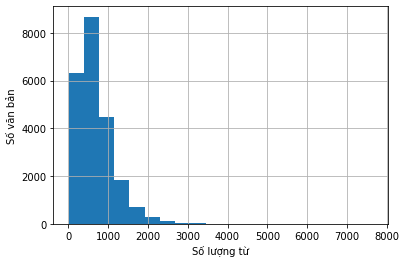

In [ ]:
analyst = pd.Series([len(i.split()) for i in df['text']]).hist(bins=20)
analyst.set_xlabel('Số lượng từ')
analyst.set_ylabel('Số văn bản')
analyst

In [12]:
data_train, data_test = train_test_split(df, train_size=0.8)
x_train = data_train['text']
y_train = data_train['label']

x_test = data_test['text']
y_test = data_test['label'] 

In [13]:
max_seq_len = 256
tokens_train = tokenizer.batch_encode_plus(
    data_train['text'],
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    data_test['text'],
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
# accumulate gradients

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [14]:
from torch.utils.data.dataset import TensorDataset
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(list(data_train['label']))

train_data = TensorDataset(train_seq, train_mask, train_y)
train_loader = DataLoader(train_data, batch_size=16)

In [15]:
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(list(data_test['label']))

test_data = TensorDataset(test_seq, test_mask, test_y)
test_loader = DataLoader(test_data, batch_size=16)

In [16]:
print(len(train_loader))
print(len(test_loader))

1125
282


In [ ]:
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=6e7eac42e21536e63b02daad18e76a1d2c66dbdbc5db5d3b7e2ec2cfd8d8e979
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))
    
# Execute function
mem_report()

CPU RAM Free: 9.3 GB
GPU 0 ... Mem Free: 1089MB / 15109MB | Utilization  93%


In [17]:
class PhoBERT_CLS(nn.Module):
    def __init__(self, model, output_dim):
        super(PhoBERT_CLS, self).__init__()
        self.model = model
        
        # for params in self.model.parameters():
        #     params.requires_grad = False
        
        embedding_dim = model.config.to_dict()['hidden_size']
        self.fc1 = nn.Linear(embedding_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)
    def forward(self, input_ids, attention_mask):
        _, outputs = self.model(input_ids= input_ids, 
                            attention_mask= attention_mask,
                            return_dict= False
                            )
        # outputs = self.bert(input_ids=input_ids)
        # outputs = outputs[0]
        outputs = F.relu(self.fc1(outputs))
        outputs = self.fc2(outputs)

        return outputs

In [18]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
phobert_cls = PhoBERT_CLS(phobert, 15)
phobert_cls = phobert_cls.to(device)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Code/NLP Research/save/phobert_cls_model2.pt')
phobert_cls.load_state_dict(checkpoint)

<All keys matched successfully>

In [20]:
criterion = CrossEntropyLoss().to(device)
num_epochs = 3
lr = 1e-5
num_labels = 15
optimizer = optim.AdamW(phobert_cls.parameters(), lr=lr)

In [ ]:
# batch = next(iter(train_loader))


In [ ]:
# input_ids = batch[0].to(device)
# attention_mask = batch[1].to(device)
# label = batch[2].to(device)
# print(type(label))

<class 'torch.Tensor'>


In [ ]:
# output = phobert_cls(input_ids, attention_mask)
# print(output.shape)

torch.Size([16, 15])


In [ ]:
# label

tensor([10,  6,  9,  8,  7,  5, 10,  9,  9,  6, 14,  2,  7,  1,  9,  3,  3, 10,
         6,  5,  4,  1,  5,  3, 13, 13,  3,  9, 12, 14,  3,  5,  7, 13, 12,  5,
         7,  7,  4, 10,  7,  5,  4,  3,  5, 13, 10,  7,  2,  5,  1,  9,  7,  5,
        14, 14, 14, 13,  3,  5,  5,  5, 11, 10, 11, 11,  0,  2,  4,  1,  5, 14,
         1,  2, 11,  8,  9,  5,  0, 10,  6, 10, 12, 10,  1,  2,  3, 12,  6, 12,
        11,  2,  8,  5,  3, 12,  8, 14, 13,  0, 12,  9,  1, 13, 14,  0,  3,  0,
        12, 14,  9,  0, 12,  3,  3,  5, 14, 13, 13, 11,  7,  3,  9,  9,  5,  0,
         6, 13, 13,  2, 11,  8,  4, 14, 12,  1,  3,  5,  4,  7,  8,  6,  3,  1,
        13, 11,  7, 11,  5,  6,  8,  2, 12,  8,  0, 11,  8, 10,  8,  0, 12, 12,
         6, 14, 10,  9, 10,  5,  1, 12,  7, 11,  5,  6, 14,  3,  5,  8, 11, 11,
         9,  4,  4, 12,  2, 12,  4,  2, 11, 12, 13,  0,  9,  5,  4,  6,  2, 11,
        14,  5], device='cuda:0')

In [ ]:
# (np.ones(4) + np.zeros(4)).mean(axis=0)

1.0

In [ ]:
# a = [1, 2, 3, 4]
# b = [1, 2, 3, 5]
# c = np.array(a) == np.array(b)
# criterion(torch.Tensor(a).unsqueeze(0), torch.Tensor(b).unsqueeze(0)).item()

14.842086791992188

In [21]:
def compute_accuracy(pred, label):
    max_pred_idx = pred.argmax(dim=1)
    # tags_idx = (label != pad_idx).nonzero()
    correct = max_pred_idx.eq(label)
    # print(correct)
    return correct.sum() * 1.0 / len(label)
def compute_f1_score_confusion_matrix(pred, label):
    max_pred_idx = pred.argmax(dim=1)
    # tags_idx = (label != pad_idx).nonzero()
    correct = max_pred_idx.eq(label)
    # print(correct)
    return f1_score(label, max_pred_idx, average=None), confusion_matrix(label, max_pred_idx, labels=list(range(num_labels)))
def eval(model, testing_loader):
    epoch_loss = 0
    epoch_acc = 0

    epoch_confusion_matrix = np.zeros((num_labels, num_labels))
    epoch_f1_score = np.zeros(num_labels)
    model.eval()

    y_true = []
    y_pred = []

    print('----Test phase----')
    with torch.no_grad():
        for idx, batch in tqdm(enumerate(testing_loader)):
            # model.zero_grad()

            ids = batch[0].to(device, dtype=torch.long)
            att_mask = batch[1].to(device, dtype=torch.long)
            labels = batch[2].to(device, dtype=torch.long)

            flattend_targets = labels.view(-1)
            

            outputs = model(ids, att_mask)
            
            y_true.extend(labels.cpu().numpy())
            y_pred_iter =  outputs.argmax(dim=1)
            y_pred.extend(y_pred_iter.cpu().numpy())
            loss = criterion(outputs, labels)
            acc = compute_accuracy(outputs, labels)
            # acc = compute_accuracy(outputs, labels)

            # y_true.extend(label) # label.shape = (200, )

            # loss.backward()
            # optimizer.step()

            print ('loss test: {}, acc test: {}'.format(loss.item(), acc))
            epoch_loss += loss.item()
            # epoch_acc += acc
            # epoch_confusion_matrix += confusionmatrix
            # epoch_f1_score += f1score
    epoch_loss /= len(testing_loader)
    epoch_acc = (np.array(y_pred) == np.array(y_true)).sum() * 1.0 / len(y_true)
    f1_score_none = f1_score(y_true=y_true, y_pred= y_pred, average=None)
    epoch_confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    return epoch_loss, epoch_acc , f1_score_none, epoch_confusion_matrix
    
def train(model, training_loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    print('----Train phase----')
    model.train()

    y_true = []
    y_pred = []

    for idx, batch in tqdm(enumerate(training_loader)):
        model.zero_grad()

        ids = batch[0].to(device, dtype=torch.long)
        att_mask = batch[1].to(device, dtype=torch.long)
        labels = batch[2].to(device, dtype=torch.long)

        # flattend_targets = labels.view(-1)
        

        outputs = model(ids, att_mask)
        # outputs = outputs.contiguous().view(-1, outputs.shape[-1])
        # labels = labels.contiguous().view(-1)

        loss = criterion(outputs, labels)
        acc = compute_accuracy(outputs, labels)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

        loss.backward()
        optimizer.step()

        print ('loss train: {}, acc train: {}'.format(loss.item(), acc))
        epoch_loss += loss.item()
        # if idx == 5:
        #     break
        # if idx % 5 == 0:
        #     eval(model, testing_loader)
    epoch_loss /= len(training_loader)
    epoch_acc = (np.array(y_pred) == np.array(y_true)).sum() * 1.0 / len(y_true)
    
    return epoch_loss, epoch_acc

In [ ]:

with open('/content/drive/MyDrive/Code/NLP Research/save/text.csv', 'a') as f:
    for i in range(10):
        wtr = csv.writer(f)
        wtr.writerow([i, i+1, i+2])

In [ ]:
train_loss_full, train_acc_full, test_loss_full, test_acc_full = [], [], [], []

for epoch in range(6):
    print('======== Epoch {:} / {:} ========'.format(epoch+1, num_epochs))
    train_loss, train_acc = train(
        model=phobert_cls,
        training_loader= train_loader,
        # testing_loader= test_loader,
        optimizer= optimizer,
        criterion= criterion
    )
    with open('/content/drive/MyDrive/Code/NLP Research/save/cls_trains.csv', 'a') as f:
        wtr = csv.writer(f)
        wtr.writerow([train_loss, train_acc])
    # train_loss_full.append(train_loss)
    # train_acc_full.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    
    test_loss, test_acc, test_f1_score, test_f1_confusion_matrix= eval(
        model=phobert_cls,
        testing_loader= test_loader,
    )
    with open('/content/drive/MyDrive/Code/NLP Research/save/cls_tesst.csv', 'a') as f:
        wtr = csv.writer(f)
        wtr.writerow([test_loss, test_acc])
    matrixs = [
               test_f1_score,
               test_f1_confusion_matrix
    ]
    with open('/content/drive/MyDrive/Code/NLP Research/save/matrix.pkl', 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(matrixs, outp, pickle.HIGHEST_PROTOCOL)
    torch.save(phobert_cls.state_dict(), '/content/drive/MyDrive/Code/NLP Research/save/phobert_cls_model2.pt')
    print("Model saved!")
    
    # test_loss_full.append(test_loss)
    # test_acc_full.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

======== Epoch 1 / 10 ========
----Train phase----


1it [00:01,  1.50s/it]

loss train: 2.723276138305664, acc train: 0.125


2it [00:02,  1.48s/it]

loss train: 2.6549108028411865, acc train: 0.1875


3it [00:04,  1.47s/it]

loss train: 2.72686505317688, acc train: 0.0625


4it [00:05,  1.47s/it]

loss train: 2.668323040008545, acc train: 0.1875


5it [00:07,  1.48s/it]

loss train: 2.7166731357574463, acc train: 0.0625


6it [00:08,  1.47s/it]

loss train: 2.7613940238952637, acc train: 0.125


7it [00:10,  1.47s/it]

loss train: 2.702629566192627, acc train: 0.0


8it [00:11,  1.47s/it]

loss train: 2.72544264793396, acc train: 0.0625


9it [00:13,  1.47s/it]

loss train: 2.766456127166748, acc train: 0.0625


10it [00:14,  1.47s/it]

loss train: 2.7482175827026367, acc train: 0.125


11it [00:16,  1.47s/it]

loss train: 2.70097279548645, acc train: 0.125


12it [00:17,  1.47s/it]

loss train: 2.650458812713623, acc train: 0.0


13it [00:19,  1.47s/it]

loss train: 2.6724255084991455, acc train: 0.0625


14it [00:20,  1.47s/it]

loss train: 2.6938607692718506, acc train: 0.125


15it [00:22,  1.47s/it]

loss train: 2.7094085216522217, acc train: 0.0625


16it [00:23,  1.47s/it]

loss train: 2.65673565864563, acc train: 0.25


17it [00:25,  1.47s/it]

loss train: 2.709669828414917, acc train: 0.125


18it [00:26,  1.47s/it]

loss train: 2.695319175720215, acc train: 0.0625


19it [00:27,  1.47s/it]

loss train: 2.609987497329712, acc train: 0.375


20it [00:29,  1.47s/it]

loss train: 2.6110458374023438, acc train: 0.25


21it [00:30,  1.47s/it]

loss train: 2.603890895843506, acc train: 0.3125


22it [00:32,  1.47s/it]

loss train: 2.6346962451934814, acc train: 0.125


23it [00:33,  1.47s/it]

loss train: 2.6218438148498535, acc train: 0.3125


24it [00:35,  1.47s/it]

loss train: 2.6150712966918945, acc train: 0.3125


25it [00:36,  1.46s/it]

loss train: 2.490687847137451, acc train: 0.5


26it [00:38,  1.47s/it]

loss train: 2.4631550312042236, acc train: 0.5625


27it [00:39,  1.46s/it]

loss train: 2.44876766204834, acc train: 0.6875


28it [00:41,  1.46s/it]

loss train: 2.554849624633789, acc train: 0.375


29it [00:42,  1.46s/it]

loss train: 2.599095344543457, acc train: 0.25


30it [00:44,  1.46s/it]

loss train: 2.4848694801330566, acc train: 0.375


31it [00:45,  1.46s/it]

loss train: 2.3942019939422607, acc train: 0.25


32it [00:46,  1.46s/it]

loss train: 2.5046021938323975, acc train: 0.25


33it [00:48,  1.47s/it]

loss train: 2.4826819896698, acc train: 0.375


34it [00:49,  1.47s/it]

loss train: 2.410628318786621, acc train: 0.375


35it [00:51,  1.47s/it]

loss train: 2.4793968200683594, acc train: 0.25


36it [00:52,  1.46s/it]

loss train: 2.2883286476135254, acc train: 0.5


37it [00:54,  1.46s/it]

loss train: 2.3073267936706543, acc train: 0.5


38it [00:55,  1.46s/it]

loss train: 2.259384870529175, acc train: 0.4375


39it [00:57,  1.46s/it]

loss train: 2.3976504802703857, acc train: 0.375


40it [00:58,  1.46s/it]

loss train: 2.197537422180176, acc train: 0.5


41it [01:00,  1.46s/it]

loss train: 2.4413442611694336, acc train: 0.25


42it [01:01,  1.46s/it]

loss train: 2.3245980739593506, acc train: 0.4375


43it [01:03,  1.46s/it]

loss train: 2.293267250061035, acc train: 0.4375


44it [01:04,  1.46s/it]

loss train: 2.158458948135376, acc train: 0.4375


45it [01:05,  1.46s/it]

loss train: 2.185652494430542, acc train: 0.5625


46it [01:07,  1.46s/it]

loss train: 2.2213633060455322, acc train: 0.4375


47it [01:08,  1.46s/it]

loss train: 2.2092902660369873, acc train: 0.3125


48it [01:10,  1.46s/it]

loss train: 2.038119077682495, acc train: 0.5625


49it [01:11,  1.46s/it]

loss train: 2.2481439113616943, acc train: 0.375


50it [01:13,  1.46s/it]

loss train: 2.3224456310272217, acc train: 0.5


51it [01:14,  1.46s/it]

loss train: 2.289475440979004, acc train: 0.1875


52it [01:16,  1.46s/it]

loss train: 2.2969536781311035, acc train: 0.5625


53it [01:17,  1.46s/it]

loss train: 1.9579460620880127, acc train: 0.6875


54it [01:19,  1.46s/it]

loss train: 2.100421905517578, acc train: 0.4375


55it [01:20,  1.46s/it]

loss train: 2.392637014389038, acc train: 0.4375


56it [01:22,  1.46s/it]

loss train: 2.1334526538848877, acc train: 0.4375


57it [01:23,  1.46s/it]

loss train: 2.1616601943969727, acc train: 0.4375


58it [01:25,  1.46s/it]

loss train: 2.35318660736084, acc train: 0.375


59it [01:26,  1.46s/it]

loss train: 2.637810707092285, acc train: 0.25


60it [01:27,  1.46s/it]

loss train: 2.365377187728882, acc train: 0.1875


61it [01:29,  1.46s/it]

loss train: 2.118682384490967, acc train: 0.5


62it [01:30,  1.46s/it]

loss train: 2.2151432037353516, acc train: 0.375


63it [01:32,  1.46s/it]

loss train: 2.3074731826782227, acc train: 0.375


64it [01:33,  1.46s/it]

loss train: 2.087615489959717, acc train: 0.375


65it [01:35,  1.46s/it]

loss train: 2.0139124393463135, acc train: 0.5


66it [01:36,  1.46s/it]

loss train: 2.116727590560913, acc train: 0.4375


67it [01:38,  1.46s/it]

loss train: 1.7725621461868286, acc train: 0.6875


68it [01:39,  1.46s/it]

loss train: 2.096662759780884, acc train: 0.5625


69it [01:41,  1.46s/it]

loss train: 2.082205057144165, acc train: 0.5


70it [01:42,  1.46s/it]

loss train: 1.8597744703292847, acc train: 0.625


71it [01:43,  1.46s/it]

loss train: 1.6742212772369385, acc train: 0.75


72it [01:45,  1.46s/it]

loss train: 1.671725869178772, acc train: 0.6875


73it [01:46,  1.46s/it]

loss train: 1.6839487552642822, acc train: 0.6875


74it [01:48,  1.46s/it]

loss train: 1.7465181350708008, acc train: 0.625


75it [01:49,  1.46s/it]

loss train: 2.003002166748047, acc train: 0.5


76it [01:51,  1.46s/it]

loss train: 1.8294904232025146, acc train: 0.625


77it [01:52,  1.46s/it]

loss train: 1.9285365343093872, acc train: 0.375


78it [01:54,  1.46s/it]

loss train: 1.8625119924545288, acc train: 0.5625


79it [01:55,  1.46s/it]

loss train: 2.149614095687866, acc train: 0.3125


80it [01:57,  1.46s/it]

loss train: 1.7589408159255981, acc train: 0.5


81it [01:58,  1.46s/it]

loss train: 1.9442884922027588, acc train: 0.5625


82it [02:00,  1.46s/it]

loss train: 1.7484123706817627, acc train: 0.5625


83it [02:01,  1.46s/it]

loss train: 1.8177388906478882, acc train: 0.5


84it [02:02,  1.46s/it]

loss train: 1.5562430620193481, acc train: 0.5625


85it [02:04,  1.46s/it]

loss train: 1.8297351598739624, acc train: 0.5625


86it [02:05,  1.46s/it]

loss train: 1.721760630607605, acc train: 0.625


87it [02:07,  1.46s/it]

loss train: 1.9070849418640137, acc train: 0.375


88it [02:08,  1.46s/it]

loss train: 1.8514187335968018, acc train: 0.4375


89it [02:10,  1.46s/it]

loss train: 1.7143397331237793, acc train: 0.5625


90it [02:11,  1.46s/it]

loss train: 2.1114954948425293, acc train: 0.375


91it [02:13,  1.46s/it]

loss train: 1.8588287830352783, acc train: 0.5


92it [02:14,  1.46s/it]

loss train: 1.675899863243103, acc train: 0.5625


93it [02:16,  1.45s/it]

loss train: 1.4141943454742432, acc train: 0.6875


94it [02:17,  1.46s/it]

loss train: 1.478695034980774, acc train: 0.6875


95it [02:18,  1.46s/it]

loss train: 2.007779359817505, acc train: 0.5625


96it [02:20,  1.46s/it]

loss train: 1.4296720027923584, acc train: 0.75


97it [02:21,  1.46s/it]

loss train: 1.716589093208313, acc train: 0.375


98it [02:23,  1.46s/it]

loss train: 1.407350778579712, acc train: 0.625


99it [02:24,  1.46s/it]

loss train: 1.4997553825378418, acc train: 0.625


100it [02:26,  1.46s/it]

loss train: 1.4809476137161255, acc train: 0.625


101it [02:27,  1.46s/it]

loss train: 1.6037195920944214, acc train: 0.5625


102it [02:29,  1.46s/it]

loss train: 1.7353754043579102, acc train: 0.5


103it [02:30,  1.46s/it]

loss train: 1.913468360900879, acc train: 0.5625


104it [02:32,  1.46s/it]

loss train: 1.9396312236785889, acc train: 0.3125


105it [02:33,  1.46s/it]

loss train: 1.8353595733642578, acc train: 0.5625


106it [02:35,  1.46s/it]

loss train: 1.356756567955017, acc train: 0.6875


107it [02:36,  1.46s/it]

loss train: 1.4060581922531128, acc train: 0.5625


108it [02:37,  1.46s/it]

loss train: 1.4231430292129517, acc train: 0.75


109it [02:39,  1.46s/it]

loss train: 1.7487596273422241, acc train: 0.5


110it [02:40,  1.46s/it]

loss train: 1.8989877700805664, acc train: 0.5


111it [02:42,  1.46s/it]

loss train: 1.9152977466583252, acc train: 0.5


112it [02:43,  1.46s/it]

loss train: 1.7618955373764038, acc train: 0.5625


113it [02:45,  1.46s/it]

loss train: 1.8017475605010986, acc train: 0.5


114it [02:46,  1.46s/it]

loss train: 1.6296353340148926, acc train: 0.625


115it [02:48,  1.46s/it]

loss train: 1.5004850625991821, acc train: 0.6875


116it [02:49,  1.46s/it]

loss train: 1.4122174978256226, acc train: 0.6875


117it [02:51,  1.46s/it]

loss train: 1.726534128189087, acc train: 0.5


118it [02:52,  1.46s/it]

loss train: 1.6607252359390259, acc train: 0.625


119it [02:53,  1.46s/it]

loss train: 1.6127517223358154, acc train: 0.625


120it [02:55,  1.46s/it]

loss train: 1.7609766721725464, acc train: 0.5625


121it [02:56,  1.46s/it]

loss train: 1.9168437719345093, acc train: 0.375


122it [02:58,  1.46s/it]

loss train: 1.6987308263778687, acc train: 0.625


123it [02:59,  1.46s/it]

loss train: 1.826599359512329, acc train: 0.5625


124it [03:01,  1.46s/it]

loss train: 1.4799063205718994, acc train: 0.5625


125it [03:02,  1.46s/it]

loss train: 1.4539273977279663, acc train: 0.6875


126it [03:04,  1.45s/it]

loss train: 0.9460969567298889, acc train: 0.8125


127it [03:05,  1.45s/it]

loss train: 1.388508677482605, acc train: 0.625


128it [03:07,  1.46s/it]

loss train: 1.3168221712112427, acc train: 0.625


129it [03:08,  1.46s/it]

loss train: 1.525709867477417, acc train: 0.5625


130it [03:10,  1.46s/it]

loss train: 1.3979389667510986, acc train: 0.625


131it [03:11,  1.46s/it]

loss train: 1.5366472005844116, acc train: 0.5


132it [03:12,  1.46s/it]

loss train: 0.9615412354469299, acc train: 0.75


133it [03:14,  1.46s/it]

loss train: 1.3286077976226807, acc train: 0.5625


134it [03:15,  1.46s/it]

loss train: 1.9350682497024536, acc train: 0.375


135it [03:17,  1.46s/it]

loss train: 1.3541738986968994, acc train: 0.6875


136it [03:18,  1.46s/it]

loss train: 1.6055585145950317, acc train: 0.5


137it [03:20,  1.46s/it]

loss train: 1.2607471942901611, acc train: 0.75


138it [03:21,  1.46s/it]

loss train: 1.2129837274551392, acc train: 0.8125


139it [03:23,  1.46s/it]

loss train: 1.743903636932373, acc train: 0.5


140it [03:24,  1.46s/it]

loss train: 1.2853846549987793, acc train: 0.6875


141it [03:26,  1.46s/it]

loss train: 1.322035312652588, acc train: 0.625


142it [03:27,  1.45s/it]

loss train: 1.5734632015228271, acc train: 0.5625


143it [03:28,  1.46s/it]

loss train: 1.3437837362289429, acc train: 0.75


144it [03:30,  1.46s/it]

loss train: 2.140848398208618, acc train: 0.375


145it [03:31,  1.46s/it]

loss train: 1.1947022676467896, acc train: 0.6875


146it [03:33,  1.46s/it]

loss train: 1.4194239377975464, acc train: 0.625


147it [03:34,  1.46s/it]

loss train: 1.6884100437164307, acc train: 0.375


148it [03:36,  1.46s/it]

loss train: 1.2379952669143677, acc train: 0.75


149it [03:37,  1.46s/it]

loss train: 1.2951444387435913, acc train: 0.6875


150it [03:39,  1.46s/it]

loss train: 0.7922510504722595, acc train: 0.9375


151it [03:40,  1.46s/it]

loss train: 1.9806302785873413, acc train: 0.5625


152it [03:42,  1.46s/it]

loss train: 1.9014779329299927, acc train: 0.375


153it [03:43,  1.46s/it]

loss train: 1.637717366218567, acc train: 0.4375


154it [03:45,  1.46s/it]

loss train: 0.9108216166496277, acc train: 0.8125


155it [03:46,  1.46s/it]

loss train: 1.6998857259750366, acc train: 0.5625


156it [03:47,  1.46s/it]

loss train: 1.4828788042068481, acc train: 0.5625


157it [03:49,  1.46s/it]

loss train: 0.9738986492156982, acc train: 0.8125


158it [03:50,  1.46s/it]

loss train: 1.8010891675949097, acc train: 0.4375


159it [03:52,  1.46s/it]

loss train: 1.41629958152771, acc train: 0.625


160it [03:53,  1.46s/it]

loss train: 1.0976811647415161, acc train: 0.6875


161it [03:55,  1.46s/it]

loss train: 1.4398671388626099, acc train: 0.5


162it [03:56,  1.46s/it]

loss train: 1.0763591527938843, acc train: 0.8125


163it [03:58,  1.46s/it]

loss train: 1.6689680814743042, acc train: 0.5625


164it [03:59,  1.46s/it]

loss train: 1.9533658027648926, acc train: 0.4375


165it [04:01,  1.46s/it]

loss train: 1.8952823877334595, acc train: 0.5


166it [04:02,  1.46s/it]

loss train: 1.4718801975250244, acc train: 0.625


167it [04:03,  1.46s/it]

loss train: 1.8795406818389893, acc train: 0.4375


168it [04:05,  1.46s/it]

loss train: 1.3066174983978271, acc train: 0.5


169it [04:06,  1.46s/it]

loss train: 1.20660400390625, acc train: 0.6875


170it [04:08,  1.46s/it]

loss train: 1.6434276103973389, acc train: 0.4375


171it [04:09,  1.46s/it]

loss train: 1.7694178819656372, acc train: 0.5


172it [04:11,  1.46s/it]

loss train: 1.191766619682312, acc train: 0.6875


173it [04:12,  1.46s/it]

loss train: 1.0908780097961426, acc train: 0.6875


174it [04:14,  1.46s/it]

loss train: 1.2589104175567627, acc train: 0.625


175it [04:15,  1.46s/it]

loss train: 1.2220932245254517, acc train: 0.75


176it [04:17,  1.46s/it]

loss train: 1.753730297088623, acc train: 0.5


177it [04:18,  1.46s/it]

loss train: 0.8924466371536255, acc train: 0.8125


178it [04:20,  1.46s/it]

loss train: 1.8094888925552368, acc train: 0.625


179it [04:21,  1.46s/it]

loss train: 1.3656718730926514, acc train: 0.5625


180it [04:22,  1.46s/it]

loss train: 1.5200845003128052, acc train: 0.5


181it [04:24,  1.46s/it]

loss train: 1.6259409189224243, acc train: 0.5


182it [04:25,  1.46s/it]

loss train: 0.947285532951355, acc train: 0.8125


183it [04:27,  1.46s/it]

loss train: 1.1649879217147827, acc train: 0.6875


184it [04:28,  1.46s/it]

loss train: 1.1170088052749634, acc train: 0.75


185it [04:30,  1.46s/it]

loss train: 1.5914885997772217, acc train: 0.375


186it [04:31,  1.46s/it]

loss train: 1.3302353620529175, acc train: 0.6875


187it [04:33,  1.46s/it]

loss train: 1.1625994443893433, acc train: 0.75


188it [04:34,  1.46s/it]

loss train: 1.6148173809051514, acc train: 0.5


189it [04:36,  1.46s/it]

loss train: 1.7117559909820557, acc train: 0.5


190it [04:37,  1.46s/it]

loss train: 1.2936769723892212, acc train: 0.625


191it [04:38,  1.46s/it]

loss train: 1.501938819885254, acc train: 0.5


192it [04:40,  1.46s/it]

loss train: 1.2196240425109863, acc train: 0.6875


193it [04:41,  1.45s/it]

loss train: 1.4882785081863403, acc train: 0.5625


194it [04:43,  1.45s/it]

loss train: 1.471108078956604, acc train: 0.5


195it [04:44,  1.45s/it]

loss train: 1.3601224422454834, acc train: 0.5625


196it [04:46,  1.45s/it]

loss train: 1.1673295497894287, acc train: 0.625


197it [04:47,  1.45s/it]

loss train: 0.9684750437736511, acc train: 0.75


198it [04:49,  1.46s/it]

loss train: 1.7050148248672485, acc train: 0.5


199it [04:50,  1.46s/it]

loss train: 1.476531744003296, acc train: 0.625


200it [04:52,  1.46s/it]

loss train: 1.7489609718322754, acc train: 0.625


201it [04:53,  1.46s/it]

loss train: 1.3043088912963867, acc train: 0.5625


202it [04:54,  1.46s/it]

loss train: 0.8963608741760254, acc train: 0.6875


203it [04:56,  1.45s/it]

loss train: 1.8941587209701538, acc train: 0.4375


204it [04:57,  1.45s/it]

loss train: 1.8390392065048218, acc train: 0.375


205it [04:59,  1.46s/it]

loss train: 0.8771704435348511, acc train: 0.75


206it [05:00,  1.46s/it]

loss train: 1.318646788597107, acc train: 0.5625


207it [05:02,  1.46s/it]

loss train: 1.2568607330322266, acc train: 0.6875


208it [05:03,  1.46s/it]

loss train: 1.4073634147644043, acc train: 0.5625


209it [05:05,  1.46s/it]

loss train: 1.518721103668213, acc train: 0.625


210it [05:06,  1.46s/it]

loss train: 1.3331859111785889, acc train: 0.625


211it [05:08,  1.45s/it]

loss train: 1.7356736660003662, acc train: 0.5


212it [05:09,  1.45s/it]

loss train: 1.310867428779602, acc train: 0.625


213it [05:10,  1.45s/it]

loss train: 1.0451308488845825, acc train: 0.6875


214it [05:12,  1.45s/it]

loss train: 0.9644467234611511, acc train: 0.75


215it [05:13,  1.45s/it]

loss train: 0.8922120332717896, acc train: 0.75


216it [05:15,  1.45s/it]

loss train: 1.3785203695297241, acc train: 0.5625


217it [05:16,  1.45s/it]

loss train: 1.449750304222107, acc train: 0.5625


218it [05:18,  1.45s/it]

loss train: 1.53875732421875, acc train: 0.625


219it [05:19,  1.46s/it]

loss train: 1.7014600038528442, acc train: 0.625


220it [05:21,  1.46s/it]

loss train: 1.406464695930481, acc train: 0.5


221it [05:22,  1.46s/it]

loss train: 1.2011140584945679, acc train: 0.6875


222it [05:24,  1.46s/it]

loss train: 0.8941025137901306, acc train: 0.875


223it [05:25,  1.46s/it]

loss train: 0.632674515247345, acc train: 0.9375


224it [05:26,  1.46s/it]

loss train: 1.6257184743881226, acc train: 0.4375


225it [05:28,  1.45s/it]

loss train: 1.7283852100372314, acc train: 0.5


226it [05:29,  1.45s/it]

loss train: 1.4369778633117676, acc train: 0.625


227it [05:31,  1.45s/it]

loss train: 1.254396915435791, acc train: 0.625


228it [05:32,  1.45s/it]

loss train: 1.601462721824646, acc train: 0.5625


229it [05:34,  1.45s/it]

loss train: 0.9919883608818054, acc train: 0.625


230it [05:35,  1.45s/it]

loss train: 1.0694576501846313, acc train: 0.6875


231it [05:37,  1.45s/it]

loss train: 1.54630708694458, acc train: 0.5625


232it [05:38,  1.45s/it]

loss train: 1.4047255516052246, acc train: 0.625


233it [05:40,  1.45s/it]

loss train: 1.5947260856628418, acc train: 0.5625


234it [05:41,  1.46s/it]

loss train: 1.4846360683441162, acc train: 0.625


235it [05:42,  1.46s/it]

loss train: 1.5727088451385498, acc train: 0.6875


236it [05:44,  1.46s/it]

loss train: 1.3729630708694458, acc train: 0.5625


237it [05:45,  1.46s/it]

loss train: 1.4660613536834717, acc train: 0.5625


238it [05:47,  1.46s/it]

loss train: 1.395390510559082, acc train: 0.625


239it [05:48,  1.45s/it]

loss train: 1.6716121435165405, acc train: 0.3125


240it [05:50,  1.46s/it]

loss train: 1.4434592723846436, acc train: 0.5625


241it [05:51,  1.46s/it]

loss train: 1.7179086208343506, acc train: 0.5


242it [05:53,  1.46s/it]

loss train: 1.212831974029541, acc train: 0.625


243it [05:54,  1.46s/it]

loss train: 0.8417670726776123, acc train: 0.75


244it [05:56,  1.46s/it]

loss train: 1.2688943147659302, acc train: 0.625


245it [05:57,  1.46s/it]

loss train: 1.1739863157272339, acc train: 0.6875


246it [05:59,  1.46s/it]

loss train: 1.3461709022521973, acc train: 0.75


247it [06:00,  1.46s/it]

loss train: 1.2662794589996338, acc train: 0.5625


248it [06:01,  1.46s/it]

loss train: 0.9225038886070251, acc train: 0.8125


249it [06:03,  1.46s/it]

loss train: 0.7991154193878174, acc train: 0.75


250it [06:04,  1.46s/it]

loss train: 0.6769152283668518, acc train: 0.9375


251it [06:06,  1.46s/it]

loss train: 1.7666513919830322, acc train: 0.4375


252it [06:07,  1.46s/it]

loss train: 2.0794992446899414, acc train: 0.375


253it [06:09,  1.46s/it]

loss train: 0.9974352121353149, acc train: 0.8125


254it [06:10,  1.46s/it]

loss train: 1.518589973449707, acc train: 0.5


255it [06:12,  1.46s/it]

loss train: 1.057127833366394, acc train: 0.75


256it [06:13,  1.46s/it]

loss train: 1.74577796459198, acc train: 0.5625


257it [06:15,  1.46s/it]

loss train: 1.6883459091186523, acc train: 0.4375


258it [06:16,  1.46s/it]

loss train: 0.9708284139633179, acc train: 0.6875


259it [06:17,  1.46s/it]

loss train: 1.4721566438674927, acc train: 0.625


260it [06:19,  1.46s/it]

loss train: 1.5688050985336304, acc train: 0.5


261it [06:20,  1.46s/it]

loss train: 1.8188074827194214, acc train: 0.5


262it [06:22,  1.46s/it]

loss train: 1.0171246528625488, acc train: 0.6875


263it [06:23,  1.46s/it]

loss train: 1.1191203594207764, acc train: 0.6875


264it [06:25,  1.46s/it]

loss train: 1.3084288835525513, acc train: 0.4375


265it [06:26,  1.46s/it]

loss train: 1.4300808906555176, acc train: 0.5625


266it [06:28,  1.46s/it]

loss train: 1.0333936214447021, acc train: 0.625


267it [06:29,  1.46s/it]

loss train: 1.174318552017212, acc train: 0.625


268it [06:31,  1.46s/it]

loss train: 1.4194574356079102, acc train: 0.625


269it [06:32,  1.46s/it]

loss train: 1.0955556631088257, acc train: 0.625


270it [06:34,  1.46s/it]

loss train: 1.0040327310562134, acc train: 0.8125


271it [06:35,  1.45s/it]

loss train: 1.6462135314941406, acc train: 0.5625


272it [06:36,  1.46s/it]

loss train: 1.3909801244735718, acc train: 0.625


273it [06:38,  1.46s/it]

loss train: 1.7815308570861816, acc train: 0.4375


274it [06:39,  1.46s/it]

loss train: 1.2353363037109375, acc train: 0.5625


275it [06:41,  1.46s/it]

loss train: 1.2740519046783447, acc train: 0.5


276it [06:42,  1.46s/it]

loss train: 0.9667131304740906, acc train: 0.75


277it [06:44,  1.45s/it]

loss train: 1.1791561841964722, acc train: 0.6875


278it [06:45,  1.46s/it]

loss train: 1.1772716045379639, acc train: 0.6875


279it [06:47,  1.46s/it]

loss train: 1.2373590469360352, acc train: 0.6875


280it [06:48,  1.46s/it]

loss train: 1.9166674613952637, acc train: 0.3125


281it [06:50,  1.45s/it]

loss train: 1.1858398914337158, acc train: 0.6875


282it [06:51,  1.46s/it]

loss train: 1.164688229560852, acc train: 0.5625


283it [06:52,  1.46s/it]

loss train: 1.3568189144134521, acc train: 0.5625


284it [06:54,  1.46s/it]

loss train: 1.9774922132492065, acc train: 0.5


285it [06:55,  1.46s/it]

loss train: 0.862729549407959, acc train: 0.875


286it [06:57,  1.46s/it]

loss train: 1.0724928379058838, acc train: 0.5625


287it [06:58,  1.46s/it]

loss train: 1.178267002105713, acc train: 0.6875


288it [07:00,  1.46s/it]

loss train: 1.5293469429016113, acc train: 0.5


289it [07:01,  1.46s/it]

loss train: 1.8548635244369507, acc train: 0.375


290it [07:03,  1.46s/it]

loss train: 1.499277949333191, acc train: 0.5


291it [07:04,  1.46s/it]

loss train: 1.2025161981582642, acc train: 0.6875


292it [07:06,  1.46s/it]

loss train: 1.4827600717544556, acc train: 0.5625


293it [07:07,  1.46s/it]

loss train: 1.6358280181884766, acc train: 0.5625


294it [07:09,  1.46s/it]

loss train: 1.831368088722229, acc train: 0.4375


295it [07:10,  1.46s/it]

loss train: 0.8474631309509277, acc train: 0.8125


296it [07:11,  1.46s/it]

loss train: 1.377753496170044, acc train: 0.625


297it [07:13,  1.46s/it]

loss train: 1.286926031112671, acc train: 0.6875


298it [07:14,  1.46s/it]

loss train: 0.9978083968162537, acc train: 0.75


299it [07:16,  1.46s/it]

loss train: 1.1455703973770142, acc train: 0.6875


300it [07:17,  1.46s/it]

loss train: 1.1525790691375732, acc train: 0.625


301it [07:19,  1.46s/it]

loss train: 1.2628158330917358, acc train: 0.6875


302it [07:20,  1.46s/it]

loss train: 1.270181655883789, acc train: 0.625


303it [07:22,  1.46s/it]

loss train: 0.805146336555481, acc train: 0.6875


304it [07:23,  1.46s/it]

loss train: 1.0107203722000122, acc train: 0.8125


305it [07:25,  1.45s/it]

loss train: 1.4638283252716064, acc train: 0.6875


306it [07:26,  1.45s/it]

loss train: 1.3766294717788696, acc train: 0.5


307it [07:27,  1.46s/it]

loss train: 0.7119655609130859, acc train: 0.8125


308it [07:29,  1.46s/it]

loss train: 1.0005568265914917, acc train: 0.75


309it [07:30,  1.46s/it]

loss train: 1.124105453491211, acc train: 0.6875


310it [07:32,  1.46s/it]

loss train: 0.6330661773681641, acc train: 0.875


311it [07:33,  1.46s/it]

loss train: 1.0901007652282715, acc train: 0.625


312it [07:35,  1.46s/it]

loss train: 1.0569727420806885, acc train: 0.75


313it [07:36,  1.46s/it]

loss train: 2.119123935699463, acc train: 0.375


314it [07:38,  1.46s/it]

loss train: 1.2076027393341064, acc train: 0.6875


315it [07:39,  1.46s/it]

loss train: 1.1276754140853882, acc train: 0.6875


316it [07:41,  1.46s/it]

loss train: 0.7059195041656494, acc train: 0.875


317it [07:42,  1.46s/it]

loss train: 0.9760749340057373, acc train: 0.8125


318it [07:43,  1.46s/it]

loss train: 1.6825037002563477, acc train: 0.5


319it [07:45,  1.46s/it]

loss train: 1.1411086320877075, acc train: 0.625


320it [07:46,  1.46s/it]

loss train: 0.980534017086029, acc train: 0.75


321it [07:48,  1.46s/it]

loss train: 1.5321474075317383, acc train: 0.5


322it [07:49,  1.46s/it]

loss train: 1.4284801483154297, acc train: 0.5


323it [07:51,  1.46s/it]

loss train: 1.6568189859390259, acc train: 0.5


324it [07:52,  1.46s/it]

loss train: 1.3476357460021973, acc train: 0.625


325it [07:54,  1.46s/it]

loss train: 0.7821388840675354, acc train: 0.875


326it [07:55,  1.46s/it]

loss train: 1.4419294595718384, acc train: 0.625


327it [07:57,  1.46s/it]

loss train: 1.5934561491012573, acc train: 0.5625


328it [07:58,  1.46s/it]

loss train: 1.311335802078247, acc train: 0.6875


329it [08:00,  1.46s/it]

loss train: 1.4937880039215088, acc train: 0.5625


330it [08:01,  1.46s/it]

loss train: 1.3230929374694824, acc train: 0.625


331it [08:02,  1.46s/it]

loss train: 1.2880760431289673, acc train: 0.5625


332it [08:04,  1.46s/it]

loss train: 1.6196116209030151, acc train: 0.5


333it [08:05,  1.46s/it]

loss train: 2.1634345054626465, acc train: 0.4375


334it [08:07,  1.46s/it]

loss train: 1.658136248588562, acc train: 0.5


335it [08:08,  1.46s/it]

loss train: 1.2466394901275635, acc train: 0.625


336it [08:10,  1.46s/it]

loss train: 1.8670356273651123, acc train: 0.5


337it [08:11,  1.46s/it]

loss train: 1.2043083906173706, acc train: 0.625


338it [08:13,  1.46s/it]

loss train: 1.814494252204895, acc train: 0.5


339it [08:14,  1.46s/it]

loss train: 1.0406279563903809, acc train: 0.6875


340it [08:16,  1.45s/it]

loss train: 1.2124829292297363, acc train: 0.5625


341it [08:17,  1.46s/it]

loss train: 1.1466761827468872, acc train: 0.6875


342it [08:19,  1.46s/it]

loss train: 1.4547127485275269, acc train: 0.5


343it [08:20,  1.45s/it]

loss train: 1.283202052116394, acc train: 0.5625


344it [08:21,  1.45s/it]

loss train: 1.1163371801376343, acc train: 0.625


345it [08:23,  1.46s/it]

loss train: 1.523205041885376, acc train: 0.5625


346it [08:24,  1.45s/it]

loss train: 1.22828209400177, acc train: 0.8125


347it [08:26,  1.45s/it]

loss train: 0.9221792221069336, acc train: 0.8125


348it [08:27,  1.45s/it]

loss train: 0.8514925837516785, acc train: 0.6875


349it [08:29,  1.46s/it]

loss train: 0.816016435623169, acc train: 0.75


350it [08:30,  1.46s/it]

loss train: 1.7147377729415894, acc train: 0.5


351it [08:32,  1.46s/it]

loss train: 0.8841443657875061, acc train: 0.75


352it [08:33,  1.46s/it]

loss train: 1.078454613685608, acc train: 0.625


353it [08:35,  1.46s/it]

loss train: 1.914306879043579, acc train: 0.4375


354it [08:36,  1.46s/it]

loss train: 1.3295211791992188, acc train: 0.6875


355it [08:37,  1.46s/it]

loss train: 1.1488784551620483, acc train: 0.6875


356it [08:39,  1.46s/it]

loss train: 1.38897705078125, acc train: 0.625


357it [08:40,  1.46s/it]

loss train: 0.9274066686630249, acc train: 0.625


358it [08:42,  1.46s/it]

loss train: 1.2516674995422363, acc train: 0.625


359it [08:43,  1.46s/it]

loss train: 1.4192914962768555, acc train: 0.6875


360it [08:45,  1.46s/it]

loss train: 1.0731520652770996, acc train: 0.6875


361it [08:46,  1.46s/it]

loss train: 1.687814474105835, acc train: 0.375


362it [08:48,  1.46s/it]

loss train: 1.7498036623001099, acc train: 0.375


363it [08:49,  1.46s/it]

loss train: 1.1646292209625244, acc train: 0.6875


364it [08:51,  1.46s/it]

loss train: 0.5467419624328613, acc train: 0.8125


365it [08:52,  1.46s/it]

loss train: 1.5017237663269043, acc train: 0.6875


366it [08:53,  1.45s/it]

loss train: 1.716291904449463, acc train: 0.4375


367it [08:55,  1.46s/it]

loss train: 0.7871906161308289, acc train: 0.8125


368it [08:56,  1.46s/it]

loss train: 1.124782681465149, acc train: 0.75


369it [08:58,  1.45s/it]

loss train: 0.8256530165672302, acc train: 0.8125


370it [08:59,  1.46s/it]

loss train: 0.8861286640167236, acc train: 0.75


371it [09:01,  1.46s/it]

loss train: 1.3910129070281982, acc train: 0.5


372it [09:02,  1.46s/it]

loss train: 1.9006649255752563, acc train: 0.5


373it [09:04,  1.46s/it]

loss train: 1.2699931859970093, acc train: 0.625


374it [09:05,  1.46s/it]

loss train: 1.345484972000122, acc train: 0.5625


375it [09:07,  1.46s/it]

loss train: 1.226523995399475, acc train: 0.625


376it [09:08,  1.46s/it]

loss train: 1.5208985805511475, acc train: 0.625


377it [09:10,  1.46s/it]

loss train: 1.28937828540802, acc train: 0.5625


378it [09:11,  1.46s/it]

loss train: 1.3322709798812866, acc train: 0.5625


379it [09:12,  1.46s/it]

loss train: 0.8106606602668762, acc train: 0.75


380it [09:14,  1.46s/it]

loss train: 1.1403950452804565, acc train: 0.625


381it [09:15,  1.46s/it]

loss train: 1.6752140522003174, acc train: 0.5


382it [09:17,  1.46s/it]

loss train: 1.2691991329193115, acc train: 0.5625


383it [09:18,  1.46s/it]

loss train: 1.3372900485992432, acc train: 0.5


384it [09:20,  1.46s/it]

loss train: 1.2150263786315918, acc train: 0.625


385it [09:21,  1.45s/it]

loss train: 1.4989851713180542, acc train: 0.5


386it [09:23,  1.45s/it]

loss train: 1.9491775035858154, acc train: 0.5


387it [09:24,  1.46s/it]

loss train: 1.0439425706863403, acc train: 0.6875


388it [09:26,  1.46s/it]

loss train: 1.207011103630066, acc train: 0.5625


389it [09:27,  1.46s/it]

loss train: 1.2343106269836426, acc train: 0.6875


390it [09:28,  1.46s/it]

loss train: 0.9702751636505127, acc train: 0.6875


391it [09:30,  1.46s/it]

loss train: 1.1807069778442383, acc train: 0.75


392it [09:31,  1.46s/it]

loss train: 1.75773286819458, acc train: 0.5


393it [09:33,  1.46s/it]

loss train: 0.6936412453651428, acc train: 0.875


394it [09:34,  1.46s/it]

loss train: 1.5510189533233643, acc train: 0.4375


395it [09:36,  1.46s/it]

loss train: 0.5387163758277893, acc train: 0.875


396it [09:37,  1.45s/it]

loss train: 1.234240174293518, acc train: 0.5


397it [09:39,  1.46s/it]

loss train: 1.5966434478759766, acc train: 0.375


398it [09:40,  1.46s/it]

loss train: 1.3655850887298584, acc train: 0.6875


399it [09:42,  1.46s/it]

loss train: 1.5655158758163452, acc train: 0.5


400it [09:43,  1.46s/it]

loss train: 1.258689284324646, acc train: 0.625


401it [09:44,  1.46s/it]

loss train: 1.2125576734542847, acc train: 0.6875


402it [09:46,  1.46s/it]

loss train: 1.5731019973754883, acc train: 0.5625


403it [09:47,  1.46s/it]

loss train: 1.3497626781463623, acc train: 0.5


404it [09:49,  1.46s/it]

loss train: 0.9823668003082275, acc train: 0.75


405it [09:50,  1.46s/it]

loss train: 1.3492763042449951, acc train: 0.625


406it [09:52,  1.46s/it]

loss train: 0.8732969164848328, acc train: 0.6875


407it [09:53,  1.45s/it]

loss train: 1.7134586572647095, acc train: 0.4375


408it [09:55,  1.46s/it]

loss train: 1.19260573387146, acc train: 0.625


409it [09:56,  1.45s/it]

loss train: 1.1088335514068604, acc train: 0.4375


410it [09:58,  1.45s/it]

loss train: 1.2101659774780273, acc train: 0.6875


411it [09:59,  1.45s/it]

loss train: 0.7991977334022522, acc train: 0.8125


412it [10:00,  1.46s/it]

loss train: 1.680867314338684, acc train: 0.375


413it [10:02,  1.46s/it]

loss train: 1.266610026359558, acc train: 0.625


414it [10:03,  1.46s/it]

loss train: 0.957850992679596, acc train: 0.6875


415it [10:05,  1.46s/it]

loss train: 0.9210078716278076, acc train: 0.6875


416it [10:06,  1.46s/it]

loss train: 1.6310226917266846, acc train: 0.5


417it [10:08,  1.46s/it]

loss train: 1.3043087720870972, acc train: 0.5625


418it [10:09,  1.46s/it]

loss train: 2.2351083755493164, acc train: 0.25


419it [10:11,  1.46s/it]

loss train: 1.189723253250122, acc train: 0.5625


420it [10:12,  1.46s/it]

loss train: 1.5583164691925049, acc train: 0.5


421it [10:14,  1.45s/it]

loss train: 1.6241071224212646, acc train: 0.5


422it [10:15,  1.45s/it]

loss train: 1.2498619556427002, acc train: 0.625


423it [10:17,  1.45s/it]

loss train: 1.3685160875320435, acc train: 0.5


424it [10:18,  1.45s/it]

loss train: 1.3864696025848389, acc train: 0.625


425it [10:19,  1.46s/it]

loss train: 0.9005909562110901, acc train: 0.75


426it [10:21,  1.46s/it]

loss train: 0.7223759889602661, acc train: 0.75


427it [10:22,  1.46s/it]

loss train: 1.2659918069839478, acc train: 0.625


428it [10:24,  1.46s/it]

loss train: 1.9791069030761719, acc train: 0.4375


429it [10:25,  1.45s/it]

loss train: 1.0335357189178467, acc train: 0.6875


430it [10:27,  1.45s/it]

loss train: 0.7967619299888611, acc train: 0.75


431it [10:28,  1.46s/it]

loss train: 1.731533408164978, acc train: 0.5


432it [10:30,  1.46s/it]

loss train: 1.1984105110168457, acc train: 0.75


433it [10:31,  1.46s/it]

loss train: 1.8797121047973633, acc train: 0.375


434it [10:33,  1.46s/it]

loss train: 1.7265702486038208, acc train: 0.5625


435it [10:34,  1.46s/it]

loss train: 1.485290288925171, acc train: 0.625


436it [10:35,  1.46s/it]

loss train: 1.5152052640914917, acc train: 0.625


437it [10:37,  1.46s/it]

loss train: 1.0574824810028076, acc train: 0.6875


438it [10:38,  1.46s/it]

loss train: 1.4222549200057983, acc train: 0.5625


439it [10:40,  1.46s/it]

loss train: 1.423723578453064, acc train: 0.5625


440it [10:41,  1.46s/it]

loss train: 0.7525347471237183, acc train: 0.8125


441it [10:43,  1.46s/it]

loss train: 0.9815276265144348, acc train: 0.625


442it [10:44,  1.46s/it]

loss train: 0.7709782123565674, acc train: 0.8125


443it [10:46,  1.46s/it]

loss train: 1.0255637168884277, acc train: 0.75


444it [10:47,  1.46s/it]

loss train: 1.6779674291610718, acc train: 0.5


445it [10:49,  1.45s/it]

loss train: 1.3197416067123413, acc train: 0.625


446it [10:50,  1.45s/it]

loss train: 0.9860555529594421, acc train: 0.75


447it [10:51,  1.45s/it]

loss train: 1.5337668657302856, acc train: 0.5625


448it [10:53,  1.46s/it]

loss train: 1.7163732051849365, acc train: 0.5625


449it [10:54,  1.46s/it]

loss train: 1.1506505012512207, acc train: 0.625


450it [10:56,  1.46s/it]

loss train: 0.98282790184021, acc train: 0.75


451it [10:57,  1.46s/it]

loss train: 1.5627131462097168, acc train: 0.5


452it [10:59,  1.46s/it]

loss train: 1.580311894416809, acc train: 0.5625


453it [11:00,  1.46s/it]

loss train: 0.8747751116752625, acc train: 0.75


454it [11:02,  1.46s/it]

loss train: 1.3753409385681152, acc train: 0.5


455it [11:03,  1.46s/it]

loss train: 1.102079153060913, acc train: 0.75


456it [11:05,  1.46s/it]

loss train: 0.6284804344177246, acc train: 0.8125


457it [11:06,  1.46s/it]

loss train: 0.7664063572883606, acc train: 0.75


458it [11:08,  1.46s/it]

loss train: 1.094651460647583, acc train: 0.6875


459it [11:09,  1.46s/it]

loss train: 1.386834740638733, acc train: 0.5625


460it [11:10,  1.46s/it]

loss train: 1.112676739692688, acc train: 0.6875


461it [11:12,  1.46s/it]

loss train: 1.9016976356506348, acc train: 0.625


462it [11:13,  1.46s/it]

loss train: 1.4230544567108154, acc train: 0.625


463it [11:15,  1.46s/it]

loss train: 0.9153535962104797, acc train: 0.75


464it [11:16,  1.46s/it]

loss train: 1.7884001731872559, acc train: 0.4375


465it [11:18,  1.46s/it]

loss train: 1.0871315002441406, acc train: 0.6875


466it [11:19,  1.46s/it]

loss train: 2.0548171997070312, acc train: 0.4375


467it [11:21,  1.46s/it]

loss train: 1.242092251777649, acc train: 0.5625


468it [11:22,  1.46s/it]

loss train: 1.1483789682388306, acc train: 0.5625


469it [11:24,  1.46s/it]

loss train: 1.5764294862747192, acc train: 0.5625


470it [11:25,  1.46s/it]

loss train: 1.029314637184143, acc train: 0.6875


471it [11:26,  1.46s/it]

loss train: 1.7238496541976929, acc train: 0.4375


472it [11:28,  1.46s/it]

loss train: 1.239764928817749, acc train: 0.625


473it [11:29,  1.46s/it]

loss train: 1.7211843729019165, acc train: 0.5625


474it [11:31,  1.46s/it]

loss train: 1.7933590412139893, acc train: 0.5


475it [11:32,  1.46s/it]

loss train: 1.000038743019104, acc train: 0.75


476it [11:34,  1.46s/it]

loss train: 1.5734878778457642, acc train: 0.5625


477it [11:35,  1.46s/it]

loss train: 1.7451114654541016, acc train: 0.5625


478it [11:37,  1.45s/it]

loss train: 0.8218420147895813, acc train: 0.8125


479it [11:38,  1.46s/it]

loss train: 0.9681611657142639, acc train: 0.8125


480it [11:40,  1.46s/it]

loss train: 1.0887540578842163, acc train: 0.5625


481it [11:41,  1.46s/it]

loss train: 1.1830962896347046, acc train: 0.625


482it [11:43,  1.46s/it]

loss train: 1.203600525856018, acc train: 0.5625


483it [11:44,  1.46s/it]

loss train: 1.7956082820892334, acc train: 0.5


484it [11:45,  1.46s/it]

loss train: 1.7189607620239258, acc train: 0.4375


485it [11:47,  1.46s/it]

loss train: 1.1539424657821655, acc train: 0.5625


486it [11:48,  1.46s/it]

loss train: 1.028153419494629, acc train: 0.625


487it [11:50,  1.46s/it]

loss train: 0.9799988269805908, acc train: 0.6875


488it [11:51,  1.46s/it]

loss train: 1.4643161296844482, acc train: 0.375


489it [11:53,  1.46s/it]

loss train: 1.6018502712249756, acc train: 0.5


490it [11:54,  1.46s/it]

loss train: 2.1254146099090576, acc train: 0.3125


491it [11:56,  1.46s/it]

loss train: 1.3381069898605347, acc train: 0.6875


492it [11:57,  1.46s/it]

loss train: 1.0544594526290894, acc train: 0.75


493it [11:59,  1.46s/it]

loss train: 1.2223830223083496, acc train: 0.625


494it [12:00,  1.46s/it]

loss train: 1.0722779035568237, acc train: 0.625


495it [12:02,  1.46s/it]

loss train: 1.165680170059204, acc train: 0.6875


496it [12:03,  1.46s/it]

loss train: 0.7769213318824768, acc train: 0.875


497it [12:04,  1.46s/it]

loss train: 1.2413411140441895, acc train: 0.5625


498it [12:06,  1.46s/it]

loss train: 0.8859319090843201, acc train: 0.8125


499it [12:07,  1.46s/it]

loss train: 0.7436283826828003, acc train: 0.75


500it [12:09,  1.46s/it]

loss train: 1.095192790031433, acc train: 0.6875


501it [12:10,  1.46s/it]

loss train: 0.6777280569076538, acc train: 0.875


502it [12:12,  1.46s/it]

loss train: 0.7185512185096741, acc train: 0.75


503it [12:13,  1.46s/it]

loss train: 1.2024805545806885, acc train: 0.625


504it [12:15,  1.45s/it]

loss train: 1.0721849203109741, acc train: 0.5625


505it [12:16,  1.46s/it]

loss train: 1.4757777452468872, acc train: 0.5


506it [12:18,  1.46s/it]

loss train: 1.086366891860962, acc train: 0.6875


507it [12:19,  1.46s/it]

loss train: 0.7955396771430969, acc train: 0.75


508it [12:20,  1.46s/it]

loss train: 1.179388403892517, acc train: 0.6875


509it [12:22,  1.46s/it]

loss train: 0.995993971824646, acc train: 0.6875


510it [12:23,  1.46s/it]

loss train: 1.9944870471954346, acc train: 0.3125


511it [12:25,  1.46s/it]

loss train: 1.098166584968567, acc train: 0.6875


512it [12:26,  1.46s/it]

loss train: 1.5493676662445068, acc train: 0.625


513it [12:28,  1.46s/it]

loss train: 1.8073769807815552, acc train: 0.4375


514it [12:29,  1.46s/it]

loss train: 1.5456167459487915, acc train: 0.4375


515it [12:31,  1.46s/it]

loss train: 1.9896496534347534, acc train: 0.5


516it [12:32,  1.46s/it]

loss train: 1.80564284324646, acc train: 0.5


517it [12:34,  1.46s/it]

loss train: 1.8832988739013672, acc train: 0.5


518it [12:35,  1.46s/it]

loss train: 1.1724588871002197, acc train: 0.6875


519it [12:37,  1.46s/it]

loss train: 1.0644477605819702, acc train: 0.625


520it [12:38,  1.46s/it]

loss train: 1.03024160861969, acc train: 0.625


521it [12:39,  1.46s/it]

loss train: 1.1147539615631104, acc train: 0.625


522it [12:41,  1.46s/it]

loss train: 1.3655929565429688, acc train: 0.5625


523it [12:42,  1.46s/it]

loss train: 0.9879772663116455, acc train: 0.75


524it [12:44,  1.46s/it]

loss train: 1.7063658237457275, acc train: 0.4375


525it [12:45,  1.46s/it]

loss train: 0.8882060647010803, acc train: 0.8125


526it [12:47,  1.46s/it]

loss train: 0.954243004322052, acc train: 0.75


527it [12:48,  1.46s/it]

loss train: 1.4819402694702148, acc train: 0.625


528it [12:50,  1.46s/it]

loss train: 1.2857818603515625, acc train: 0.75


529it [12:51,  1.46s/it]

loss train: 1.3714343309402466, acc train: 0.5625


530it [12:53,  1.46s/it]

loss train: 1.194055199623108, acc train: 0.75


531it [12:54,  1.46s/it]

loss train: 1.024272084236145, acc train: 0.5625


532it [12:56,  1.46s/it]

loss train: 0.5497583150863647, acc train: 0.875


533it [12:57,  1.46s/it]

loss train: 1.3034387826919556, acc train: 0.625


534it [12:58,  1.46s/it]

loss train: 1.443345069885254, acc train: 0.5


535it [13:00,  1.46s/it]

loss train: 1.7471380233764648, acc train: 0.4375


536it [13:01,  1.46s/it]

loss train: 1.3535064458847046, acc train: 0.6875


537it [13:03,  1.46s/it]

loss train: 1.0162712335586548, acc train: 0.6875


538it [13:04,  1.46s/it]

loss train: 1.4552440643310547, acc train: 0.4375


539it [13:06,  1.46s/it]

loss train: 0.8260153532028198, acc train: 0.875


540it [13:07,  1.47s/it]

loss train: 1.1668578386306763, acc train: 0.6875


541it [13:09,  1.46s/it]

loss train: 1.2395257949829102, acc train: 0.5625


542it [13:10,  1.46s/it]

loss train: 1.377798080444336, acc train: 0.4375


543it [13:12,  1.46s/it]

loss train: 1.1415889263153076, acc train: 0.5625


544it [13:13,  1.46s/it]

loss train: 1.576429843902588, acc train: 0.5625


545it [13:15,  1.46s/it]

loss train: 1.6799447536468506, acc train: 0.375


546it [13:16,  1.46s/it]

loss train: 1.018757939338684, acc train: 0.6875


547it [13:17,  1.46s/it]

loss train: 1.1576625108718872, acc train: 0.6875


548it [13:19,  1.46s/it]

loss train: 1.3538094758987427, acc train: 0.625


549it [13:20,  1.46s/it]

loss train: 1.554542899131775, acc train: 0.625


550it [13:22,  1.46s/it]

loss train: 1.2475687265396118, acc train: 0.6875


551it [13:23,  1.46s/it]

loss train: 1.2573212385177612, acc train: 0.5625


552it [13:25,  1.46s/it]

loss train: 1.9103610515594482, acc train: 0.5625


553it [13:26,  1.46s/it]

loss train: 0.95635586977005, acc train: 0.75


554it [13:28,  1.46s/it]

loss train: 1.2517480850219727, acc train: 0.625


555it [13:29,  1.46s/it]

loss train: 0.7144864201545715, acc train: 0.8125


556it [13:31,  1.46s/it]

loss train: 1.1087944507598877, acc train: 0.625


557it [13:32,  1.46s/it]

loss train: 0.9677544832229614, acc train: 0.625


558it [13:34,  1.46s/it]

loss train: 2.450599193572998, acc train: 0.25


559it [13:35,  1.46s/it]

loss train: 1.2004876136779785, acc train: 0.5


560it [13:36,  1.46s/it]

loss train: 0.9789564609527588, acc train: 0.75


561it [13:38,  1.46s/it]

loss train: 2.124269485473633, acc train: 0.3125


562it [13:39,  1.46s/it]

loss train: 0.6544257998466492, acc train: 0.8125


563it [13:41,  1.46s/it]

loss train: 1.4092484712600708, acc train: 0.625


564it [13:42,  1.46s/it]

loss train: 0.9264998435974121, acc train: 0.75


565it [13:44,  1.46s/it]

loss train: 0.803686261177063, acc train: 0.8125


566it [13:45,  1.46s/it]

loss train: 1.2293957471847534, acc train: 0.6875


567it [13:47,  1.46s/it]

loss train: 0.935782790184021, acc train: 0.75


568it [13:48,  1.46s/it]

loss train: 1.0506577491760254, acc train: 0.75


569it [13:50,  1.46s/it]

loss train: 1.7991076707839966, acc train: 0.5


570it [13:51,  1.46s/it]

loss train: 1.509549856185913, acc train: 0.625


571it [13:53,  1.46s/it]

loss train: 1.813002109527588, acc train: 0.4375


572it [13:54,  1.46s/it]

loss train: 1.7968815565109253, acc train: 0.5625


573it [13:55,  1.46s/it]

loss train: 2.172468662261963, acc train: 0.3125


574it [13:57,  1.46s/it]

loss train: 1.600705623626709, acc train: 0.5625


575it [13:58,  1.46s/it]

loss train: 0.7414864301681519, acc train: 0.75


576it [14:00,  1.46s/it]

loss train: 1.3570290803909302, acc train: 0.5


577it [14:01,  1.46s/it]

loss train: 1.5470367670059204, acc train: 0.5


578it [14:03,  1.46s/it]

loss train: 1.3385241031646729, acc train: 0.5


579it [14:04,  1.46s/it]

loss train: 1.5559688806533813, acc train: 0.4375


580it [14:06,  1.46s/it]

loss train: 0.9499573707580566, acc train: 0.6875


581it [14:07,  1.46s/it]

loss train: 0.9538339972496033, acc train: 0.75


582it [14:09,  1.46s/it]

loss train: 1.5245299339294434, acc train: 0.75


583it [14:10,  1.46s/it]

loss train: 1.5060367584228516, acc train: 0.625


584it [14:12,  1.46s/it]

loss train: 1.5779269933700562, acc train: 0.5625


585it [14:13,  1.46s/it]

loss train: 1.2090281248092651, acc train: 0.625


586it [14:14,  1.46s/it]

loss train: 1.3384708166122437, acc train: 0.625


587it [14:16,  1.46s/it]

loss train: 1.3817764520645142, acc train: 0.625


588it [14:17,  1.46s/it]

loss train: 0.8191770911216736, acc train: 0.75


589it [14:19,  1.46s/it]

loss train: 1.142341136932373, acc train: 0.6875


590it [14:20,  1.46s/it]

loss train: 1.2443592548370361, acc train: 0.625


591it [14:22,  1.46s/it]

loss train: 0.7813173532485962, acc train: 0.9375


592it [14:23,  1.46s/it]

loss train: 1.1384388208389282, acc train: 0.5


593it [14:25,  1.46s/it]

loss train: 1.9171037673950195, acc train: 0.375


594it [14:26,  1.46s/it]

loss train: 1.2154613733291626, acc train: 0.5625


595it [14:28,  1.46s/it]

loss train: 0.7447827458381653, acc train: 0.625


596it [14:29,  1.46s/it]

loss train: 0.6053565144538879, acc train: 0.875


597it [14:30,  1.46s/it]

loss train: 0.9967261552810669, acc train: 0.6875


598it [14:32,  1.46s/it]

loss train: 0.8121247887611389, acc train: 0.8125


599it [14:33,  1.46s/it]

loss train: 1.4022290706634521, acc train: 0.5625


600it [14:35,  1.46s/it]

loss train: 0.8902244567871094, acc train: 0.8125


601it [14:36,  1.46s/it]

loss train: 0.9498676657676697, acc train: 0.625


602it [14:38,  1.46s/it]

loss train: 1.1362199783325195, acc train: 0.625


603it [14:39,  1.46s/it]

loss train: 1.3019227981567383, acc train: 0.5625


604it [14:41,  1.46s/it]

loss train: 1.8671438694000244, acc train: 0.375


605it [14:42,  1.46s/it]

loss train: 1.051513910293579, acc train: 0.6875


606it [14:44,  1.46s/it]

loss train: 1.7883858680725098, acc train: 0.375


607it [14:45,  1.46s/it]

loss train: 2.1335904598236084, acc train: 0.375


608it [14:47,  1.46s/it]

loss train: 1.028965950012207, acc train: 0.625


609it [14:48,  1.46s/it]

loss train: 0.6689302921295166, acc train: 0.875


610it [14:49,  1.46s/it]

loss train: 1.3286100625991821, acc train: 0.5625


611it [14:51,  1.46s/it]

loss train: 1.3452397584915161, acc train: 0.5


612it [14:52,  1.46s/it]

loss train: 1.7221304178237915, acc train: 0.5625


613it [14:54,  1.46s/it]

loss train: 0.6879273653030396, acc train: 0.875


614it [14:55,  1.46s/it]

loss train: 1.048796534538269, acc train: 0.8125


615it [14:57,  1.46s/it]

loss train: 1.1273624897003174, acc train: 0.5625


616it [14:58,  1.46s/it]

loss train: 1.5765409469604492, acc train: 0.625


617it [15:00,  1.46s/it]

loss train: 1.8292067050933838, acc train: 0.4375


618it [15:01,  1.46s/it]

loss train: 0.9102837443351746, acc train: 0.8125


619it [15:03,  1.46s/it]

loss train: 1.1227695941925049, acc train: 0.75


620it [15:04,  1.47s/it]

loss train: 1.0390537977218628, acc train: 0.75


621it [15:06,  1.46s/it]

loss train: 0.8218268156051636, acc train: 0.8125


622it [15:07,  1.46s/it]

loss train: 1.1008172035217285, acc train: 0.75


623it [15:09,  1.46s/it]

loss train: 1.1783519983291626, acc train: 0.625


624it [15:10,  1.46s/it]

loss train: 0.8454873561859131, acc train: 0.75


625it [15:11,  1.46s/it]

loss train: 2.3712656497955322, acc train: 0.25


626it [15:13,  1.46s/it]

loss train: 1.4758548736572266, acc train: 0.6875


627it [15:14,  1.46s/it]

loss train: 1.1413213014602661, acc train: 0.625


628it [15:16,  1.46s/it]

loss train: 1.284371256828308, acc train: 0.5625


629it [15:17,  1.46s/it]

loss train: 1.447692632675171, acc train: 0.4375


630it [15:19,  1.46s/it]

loss train: 0.8232182264328003, acc train: 0.8125


631it [15:20,  1.46s/it]

loss train: 0.941981852054596, acc train: 0.75


632it [15:22,  1.46s/it]

loss train: 0.5826209783554077, acc train: 0.8125


633it [15:23,  1.46s/it]

loss train: 1.1721417903900146, acc train: 0.6875


634it [15:25,  1.46s/it]

loss train: 1.4949891567230225, acc train: 0.5625


635it [15:26,  1.46s/it]

loss train: 1.0122066736221313, acc train: 0.75


636it [15:27,  1.46s/it]

loss train: 1.4926016330718994, acc train: 0.625


637it [15:29,  1.46s/it]

loss train: 1.251678228378296, acc train: 0.625


638it [15:30,  1.46s/it]

loss train: 0.8948125243186951, acc train: 0.8125


639it [15:32,  1.46s/it]

loss train: 1.6260689496994019, acc train: 0.5


640it [15:33,  1.46s/it]

loss train: 0.8650379180908203, acc train: 0.6875


641it [15:35,  1.46s/it]

loss train: 1.1380889415740967, acc train: 0.6875


642it [15:36,  1.47s/it]

loss train: 1.6182714700698853, acc train: 0.5


643it [15:38,  1.47s/it]

loss train: 1.4084464311599731, acc train: 0.5625


644it [15:39,  1.47s/it]

loss train: 1.5556540489196777, acc train: 0.375


645it [15:41,  1.47s/it]

loss train: 1.0973857641220093, acc train: 0.6875


646it [15:42,  1.47s/it]

loss train: 1.4533947706222534, acc train: 0.375


647it [15:44,  1.47s/it]

loss train: 0.6052506566047668, acc train: 0.8125


648it [15:45,  1.46s/it]

loss train: 1.2219576835632324, acc train: 0.5625


649it [15:47,  1.47s/it]

loss train: 1.7657207250595093, acc train: 0.4375


650it [15:48,  1.47s/it]

loss train: 1.1107548475265503, acc train: 0.6875


651it [15:49,  1.47s/it]

loss train: 1.468311071395874, acc train: 0.5625


652it [15:51,  1.47s/it]

loss train: 0.8375151753425598, acc train: 0.8125


653it [15:52,  1.46s/it]

loss train: 1.6903939247131348, acc train: 0.4375


654it [15:54,  1.46s/it]

loss train: 1.650486707687378, acc train: 0.625


655it [15:55,  1.46s/it]

loss train: 1.489338994026184, acc train: 0.5


656it [15:57,  1.46s/it]

loss train: 1.3249571323394775, acc train: 0.5


657it [15:58,  1.46s/it]

loss train: 1.755556344985962, acc train: 0.5


658it [16:00,  1.46s/it]

loss train: 1.5741186141967773, acc train: 0.5


659it [16:01,  1.46s/it]

loss train: 1.1170521974563599, acc train: 0.625


660it [16:03,  1.46s/it]

loss train: 0.8265584707260132, acc train: 0.75


661it [16:04,  1.46s/it]

loss train: 1.4949548244476318, acc train: 0.5625


662it [16:06,  1.47s/it]

loss train: 2.180123805999756, acc train: 0.375


663it [16:07,  1.46s/it]

loss train: 0.673796534538269, acc train: 0.8125


664it [16:08,  1.46s/it]

loss train: 1.3550527095794678, acc train: 0.625


665it [16:10,  1.46s/it]

loss train: 0.8771415948867798, acc train: 0.5625


666it [16:11,  1.46s/it]

loss train: 1.1759624481201172, acc train: 0.625


667it [16:13,  1.47s/it]

loss train: 1.4217569828033447, acc train: 0.5625


668it [16:14,  1.47s/it]

loss train: 0.9670024514198303, acc train: 0.6875


669it [16:16,  1.47s/it]

loss train: 1.4227763414382935, acc train: 0.5625


670it [16:17,  1.47s/it]

loss train: 1.2964938879013062, acc train: 0.5


671it [16:19,  1.47s/it]

loss train: 0.7573160529136658, acc train: 0.8125


672it [16:20,  1.46s/it]

loss train: 0.7912469506263733, acc train: 0.875


673it [16:22,  1.47s/it]

loss train: 1.1304709911346436, acc train: 0.5625


674it [16:23,  1.46s/it]

loss train: 1.473353624343872, acc train: 0.4375


675it [16:25,  1.47s/it]

loss train: 1.196340799331665, acc train: 0.625


676it [16:26,  1.47s/it]

loss train: 1.4114806652069092, acc train: 0.625


677it [16:28,  1.47s/it]

loss train: 1.3067471981048584, acc train: 0.6875


678it [16:29,  1.46s/it]

loss train: 1.5746606588363647, acc train: 0.5


679it [16:30,  1.46s/it]

loss train: 0.8402144908905029, acc train: 0.6875


680it [16:32,  1.46s/it]

loss train: 1.399622917175293, acc train: 0.5625


681it [16:33,  1.46s/it]

loss train: 0.8880011439323425, acc train: 0.8125


682it [16:35,  1.46s/it]

loss train: 1.7414405345916748, acc train: 0.5


683it [16:36,  1.46s/it]

loss train: 1.075830340385437, acc train: 0.625


684it [16:38,  1.46s/it]

loss train: 0.9724874496459961, acc train: 0.6875


685it [16:39,  1.46s/it]

loss train: 1.0164850950241089, acc train: 0.6875


686it [16:41,  1.46s/it]

loss train: 1.3921682834625244, acc train: 0.5


687it [16:42,  1.46s/it]

loss train: 1.4205974340438843, acc train: 0.5625


688it [16:44,  1.46s/it]

loss train: 0.9880470037460327, acc train: 0.75


689it [16:45,  1.46s/it]

loss train: 1.1209264993667603, acc train: 0.75


690it [16:46,  1.46s/it]

loss train: 1.7902870178222656, acc train: 0.375


691it [16:48,  1.46s/it]

loss train: 1.0473673343658447, acc train: 0.6875


692it [16:49,  1.47s/it]

loss train: 1.896885871887207, acc train: 0.3125


693it [16:51,  1.47s/it]

loss train: 1.3149540424346924, acc train: 0.5625


694it [16:52,  1.47s/it]

loss train: 1.7108863592147827, acc train: 0.4375


695it [16:54,  1.46s/it]

loss train: 1.2381343841552734, acc train: 0.5625


696it [16:55,  1.46s/it]

loss train: 1.0237897634506226, acc train: 0.625


697it [16:57,  1.46s/it]

loss train: 1.2592532634735107, acc train: 0.5


698it [16:58,  1.46s/it]

loss train: 1.7042953968048096, acc train: 0.5625


699it [17:00,  1.46s/it]

loss train: 1.392742395401001, acc train: 0.5625


700it [17:01,  1.46s/it]

loss train: 1.9649897813796997, acc train: 0.4375


701it [17:03,  1.46s/it]

loss train: 1.4235446453094482, acc train: 0.625


702it [17:04,  1.46s/it]

loss train: 1.7307919263839722, acc train: 0.375


703it [17:06,  1.46s/it]

loss train: 2.1656057834625244, acc train: 0.375


704it [17:07,  1.46s/it]

loss train: 1.1901377439498901, acc train: 0.625


705it [17:08,  1.46s/it]

loss train: 1.0283629894256592, acc train: 0.625


706it [17:10,  1.46s/it]

loss train: 1.2830469608306885, acc train: 0.625


707it [17:11,  1.46s/it]

loss train: 0.921161413192749, acc train: 0.6875


708it [17:13,  1.46s/it]

loss train: 1.2300612926483154, acc train: 0.625


709it [17:14,  1.46s/it]

loss train: 1.470542550086975, acc train: 0.5625


710it [17:16,  1.47s/it]

loss train: 0.9744458198547363, acc train: 0.75


711it [17:17,  1.47s/it]

loss train: 1.1597036123275757, acc train: 0.75


712it [17:19,  1.47s/it]

loss train: 1.0883396863937378, acc train: 0.75


713it [17:20,  1.46s/it]

loss train: 1.0492007732391357, acc train: 0.6875


714it [17:22,  1.47s/it]

loss train: 0.8998359441757202, acc train: 0.75


715it [17:23,  1.47s/it]

loss train: 1.9645729064941406, acc train: 0.4375


716it [17:25,  1.46s/it]

loss train: 1.658760905265808, acc train: 0.625


717it [17:26,  1.46s/it]

loss train: 1.264971137046814, acc train: 0.6875


718it [17:27,  1.47s/it]

loss train: 1.1120408773422241, acc train: 0.625


719it [17:29,  1.47s/it]

loss train: 1.0613853931427002, acc train: 0.6875


720it [17:30,  1.46s/it]

loss train: 1.0179897546768188, acc train: 0.6875


721it [17:32,  1.46s/it]

loss train: 1.3549017906188965, acc train: 0.625


722it [17:33,  1.46s/it]

loss train: 0.7853848934173584, acc train: 0.75


723it [17:35,  1.46s/it]

loss train: 1.6247490644454956, acc train: 0.6875


724it [17:36,  1.46s/it]

loss train: 1.0244700908660889, acc train: 0.625


725it [17:38,  1.46s/it]

loss train: 1.7431511878967285, acc train: 0.3125


726it [17:39,  1.46s/it]

loss train: 0.8608170747756958, acc train: 0.8125


727it [17:41,  1.46s/it]

loss train: 1.3679678440093994, acc train: 0.625


728it [17:42,  1.46s/it]

loss train: 0.97038334608078, acc train: 0.6875


729it [17:44,  1.46s/it]

loss train: 1.2406127452850342, acc train: 0.5625


730it [17:45,  1.46s/it]

loss train: 0.9225626587867737, acc train: 0.75


731it [17:46,  1.46s/it]

loss train: 1.3796594142913818, acc train: 0.625


732it [17:48,  1.46s/it]

loss train: 1.5132553577423096, acc train: 0.5625


733it [17:49,  1.46s/it]

loss train: 0.8746041059494019, acc train: 0.6875


734it [17:51,  1.46s/it]

loss train: 1.0907282829284668, acc train: 0.6875


735it [17:52,  1.46s/it]

loss train: 1.7426995038986206, acc train: 0.625


736it [17:54,  1.46s/it]

loss train: 1.2142595052719116, acc train: 0.625


737it [17:55,  1.46s/it]

loss train: 1.3819600343704224, acc train: 0.6875


738it [17:57,  1.46s/it]

loss train: 1.0310434103012085, acc train: 0.6875


739it [17:58,  1.46s/it]

loss train: 0.7243024110794067, acc train: 0.8125


740it [18:00,  1.46s/it]

loss train: 2.151505470275879, acc train: 0.4375


741it [18:01,  1.46s/it]

loss train: 1.5470311641693115, acc train: 0.5625


742it [18:03,  1.47s/it]

loss train: 1.8354442119598389, acc train: 0.5


743it [18:04,  1.47s/it]

loss train: 1.200061559677124, acc train: 0.625


744it [18:05,  1.47s/it]

loss train: 1.0275121927261353, acc train: 0.6875


745it [18:07,  1.47s/it]

loss train: 1.6583399772644043, acc train: 0.375


746it [18:08,  1.47s/it]

loss train: 1.8466495275497437, acc train: 0.5


747it [18:10,  1.47s/it]

loss train: 1.7583893537521362, acc train: 0.5


748it [18:11,  1.46s/it]

loss train: 1.7292239665985107, acc train: 0.5


749it [18:13,  1.47s/it]

loss train: 1.2766201496124268, acc train: 0.6875


750it [18:14,  1.47s/it]

loss train: 0.8805942535400391, acc train: 0.8125


751it [18:16,  1.47s/it]

loss train: 1.4717583656311035, acc train: 0.5625


752it [18:17,  1.47s/it]

loss train: 0.7747372984886169, acc train: 0.8125


753it [18:19,  1.47s/it]

loss train: 1.1223187446594238, acc train: 0.625


754it [18:20,  1.47s/it]

loss train: 0.9979801774024963, acc train: 0.6875


755it [18:22,  1.46s/it]

loss train: 1.4752978086471558, acc train: 0.5625


756it [18:23,  1.47s/it]

loss train: 1.4923715591430664, acc train: 0.625


757it [18:25,  1.47s/it]

loss train: 1.370694637298584, acc train: 0.625


758it [18:26,  1.47s/it]

loss train: 1.1787868738174438, acc train: 0.625


759it [18:27,  1.47s/it]

loss train: 1.2240972518920898, acc train: 0.5625


760it [18:29,  1.46s/it]

loss train: 1.9773223400115967, acc train: 0.5


761it [18:30,  1.46s/it]

loss train: 1.131070852279663, acc train: 0.75


762it [18:32,  1.46s/it]

loss train: 1.619531512260437, acc train: 0.5


763it [18:33,  1.46s/it]

loss train: 0.908187985420227, acc train: 0.6875


764it [18:35,  1.46s/it]

loss train: 1.3524737358093262, acc train: 0.5


765it [18:36,  1.46s/it]

loss train: 1.776108980178833, acc train: 0.5


766it [18:38,  1.46s/it]

loss train: 1.1965330839157104, acc train: 0.6875


767it [18:39,  1.46s/it]

loss train: 1.439934253692627, acc train: 0.625


768it [18:41,  1.46s/it]

loss train: 1.0760433673858643, acc train: 0.625


769it [18:42,  1.46s/it]

loss train: 0.8147032856941223, acc train: 0.75


770it [18:44,  1.46s/it]

loss train: 0.9679172039031982, acc train: 0.625


771it [18:45,  1.46s/it]

loss train: 1.325943946838379, acc train: 0.6875


772it [18:46,  1.46s/it]

loss train: 1.3217477798461914, acc train: 0.6875


773it [18:48,  1.46s/it]

loss train: 1.0106462240219116, acc train: 0.625


774it [18:49,  1.46s/it]

loss train: 1.5162185430526733, acc train: 0.5625


775it [18:51,  1.46s/it]

loss train: 0.9852123260498047, acc train: 0.625


776it [18:52,  1.46s/it]

loss train: 2.0015976428985596, acc train: 0.5


777it [18:54,  1.47s/it]

loss train: 1.0550992488861084, acc train: 0.75


778it [18:55,  1.47s/it]

loss train: 1.0344648361206055, acc train: 0.5625


779it [18:57,  1.47s/it]

loss train: 1.0765979290008545, acc train: 0.625


780it [18:58,  1.47s/it]

loss train: 1.2327792644500732, acc train: 0.4375


781it [19:00,  1.46s/it]

loss train: 1.3260271549224854, acc train: 0.5


782it [19:01,  1.46s/it]

loss train: 1.5137646198272705, acc train: 0.5625


783it [19:03,  1.47s/it]

loss train: 1.3633660078048706, acc train: 0.625


784it [19:04,  1.46s/it]

loss train: 1.574315071105957, acc train: 0.5625


785it [19:06,  1.46s/it]

loss train: 1.0873390436172485, acc train: 0.6875


786it [19:07,  1.46s/it]

loss train: 1.2780693769454956, acc train: 0.5625


787it [19:08,  1.46s/it]

loss train: 0.958806037902832, acc train: 0.75


788it [19:10,  1.46s/it]

loss train: 1.7945163249969482, acc train: 0.4375


789it [19:11,  1.46s/it]

loss train: 1.086837887763977, acc train: 0.5625


790it [19:13,  1.46s/it]

loss train: 1.1925827264785767, acc train: 0.625


791it [19:14,  1.46s/it]

loss train: 1.6618388891220093, acc train: 0.625


792it [19:16,  1.47s/it]

loss train: 1.467661738395691, acc train: 0.5625


793it [19:17,  1.47s/it]

loss train: 0.9319736957550049, acc train: 0.8125


794it [19:19,  1.46s/it]

loss train: 0.9093850255012512, acc train: 0.8125


795it [19:20,  1.46s/it]

loss train: 1.2913161516189575, acc train: 0.5625


796it [19:22,  1.46s/it]

loss train: 0.8708860874176025, acc train: 0.6875


797it [19:23,  1.46s/it]

loss train: 0.9342290759086609, acc train: 0.625


798it [19:25,  1.46s/it]

loss train: 1.3629908561706543, acc train: 0.5625


799it [19:26,  1.46s/it]

loss train: 2.00447416305542, acc train: 0.375


800it [19:27,  1.46s/it]

loss train: 0.8390325903892517, acc train: 0.8125


801it [19:29,  1.46s/it]

loss train: 1.0265579223632812, acc train: 0.75


802it [19:30,  1.46s/it]

loss train: 0.9034171104431152, acc train: 0.6875


803it [19:32,  1.46s/it]

loss train: 1.5116641521453857, acc train: 0.5


804it [19:33,  1.46s/it]

loss train: 0.6425043344497681, acc train: 0.875


805it [19:35,  1.46s/it]

loss train: 1.2581937313079834, acc train: 0.625


806it [19:36,  1.46s/it]

loss train: 1.1130707263946533, acc train: 0.625


807it [19:38,  1.46s/it]

loss train: 0.33680665493011475, acc train: 0.9375


808it [19:39,  1.46s/it]

loss train: 1.4338161945343018, acc train: 0.5


809it [19:41,  1.46s/it]

loss train: 1.1555839776992798, acc train: 0.625


810it [19:42,  1.46s/it]

loss train: 1.0160670280456543, acc train: 0.75


811it [19:44,  1.47s/it]

loss train: 1.2099653482437134, acc train: 0.625


812it [19:45,  1.46s/it]

loss train: 1.1748217344284058, acc train: 0.625


813it [19:46,  1.46s/it]

loss train: 1.2050315141677856, acc train: 0.5625


814it [19:48,  1.46s/it]

loss train: 1.2658119201660156, acc train: 0.75


815it [19:49,  1.46s/it]

loss train: 1.0783016681671143, acc train: 0.6875


816it [19:51,  1.46s/it]

loss train: 1.4887601137161255, acc train: 0.5625


817it [19:52,  1.46s/it]

loss train: 1.727332353591919, acc train: 0.5625


818it [19:54,  1.47s/it]

loss train: 0.8495468497276306, acc train: 0.75


819it [19:55,  1.47s/it]

loss train: 1.2276661396026611, acc train: 0.4375


820it [19:57,  1.47s/it]

loss train: 1.4335782527923584, acc train: 0.625


821it [19:58,  1.46s/it]

loss train: 1.0571789741516113, acc train: 0.5625


822it [20:00,  1.46s/it]

loss train: 0.9098166823387146, acc train: 0.6875


823it [20:01,  1.46s/it]

loss train: 1.5704795122146606, acc train: 0.5625


824it [20:03,  1.46s/it]

loss train: 1.3242160081863403, acc train: 0.5625


825it [20:04,  1.46s/it]

loss train: 0.8660647869110107, acc train: 0.6875


826it [20:06,  1.47s/it]

loss train: 1.5253660678863525, acc train: 0.5625


827it [20:07,  1.46s/it]

loss train: 1.0607516765594482, acc train: 0.5625


828it [20:08,  1.46s/it]

loss train: 1.5117487907409668, acc train: 0.375


829it [20:10,  1.47s/it]

loss train: 1.3698570728302002, acc train: 0.625


830it [20:11,  1.46s/it]

loss train: 0.9895827174186707, acc train: 0.6875


831it [20:13,  1.46s/it]

loss train: 1.3339892625808716, acc train: 0.625


832it [20:14,  1.46s/it]

loss train: 1.4044822454452515, acc train: 0.75


833it [20:16,  1.46s/it]

loss train: 0.9745491147041321, acc train: 0.75


834it [20:17,  1.46s/it]

loss train: 1.567320466041565, acc train: 0.5625


835it [20:19,  1.46s/it]

loss train: 1.5270576477050781, acc train: 0.625


836it [20:20,  1.46s/it]

loss train: 1.0608782768249512, acc train: 0.6875


837it [20:22,  1.46s/it]

loss train: 1.4597128629684448, acc train: 0.5


838it [20:23,  1.46s/it]

loss train: 0.9810625314712524, acc train: 0.6875


839it [20:25,  1.46s/it]

loss train: 1.270203709602356, acc train: 0.6875


840it [20:26,  1.47s/it]

loss train: 1.170629858970642, acc train: 0.5625


841it [20:27,  1.46s/it]

loss train: 1.2564617395401, acc train: 0.625


842it [20:29,  1.46s/it]

loss train: 1.7571566104888916, acc train: 0.5


843it [20:30,  1.46s/it]

loss train: 1.027814269065857, acc train: 0.6875


844it [20:32,  1.46s/it]

loss train: 1.4772804975509644, acc train: 0.625


845it [20:33,  1.46s/it]

loss train: 1.4064667224884033, acc train: 0.5625


846it [20:35,  1.46s/it]

loss train: 0.8775001764297485, acc train: 0.6875


847it [20:36,  1.46s/it]

loss train: 0.788914144039154, acc train: 0.6875


848it [20:38,  1.46s/it]

loss train: 1.282163381576538, acc train: 0.5625


849it [20:39,  1.46s/it]

loss train: 0.8954679369926453, acc train: 0.75


850it [20:41,  1.46s/it]

loss train: 1.0153580904006958, acc train: 0.75


851it [20:42,  1.46s/it]

loss train: 1.4297950267791748, acc train: 0.625


852it [20:44,  1.46s/it]

loss train: 1.2569973468780518, acc train: 0.5625


853it [20:45,  1.46s/it]

loss train: 1.110909104347229, acc train: 0.6875


854it [20:46,  1.46s/it]

loss train: 0.5966208577156067, acc train: 0.9375


855it [20:48,  1.46s/it]

loss train: 1.4933897256851196, acc train: 0.4375


856it [20:49,  1.45s/it]

loss train: 1.1500180959701538, acc train: 0.6875


857it [20:51,  1.46s/it]

loss train: 1.3126060962677002, acc train: 0.625


858it [20:52,  1.46s/it]

loss train: 0.621648907661438, acc train: 0.875


859it [20:54,  1.46s/it]

loss train: 1.2656759023666382, acc train: 0.625


860it [20:55,  1.46s/it]

loss train: 1.3601391315460205, acc train: 0.625


861it [20:57,  1.46s/it]

loss train: 1.5837163925170898, acc train: 0.625


862it [20:58,  1.46s/it]

loss train: 1.3504499197006226, acc train: 0.5


863it [21:00,  1.46s/it]

loss train: 0.9828323721885681, acc train: 0.75


864it [21:01,  1.46s/it]

loss train: 1.0473741292953491, acc train: 0.6875


865it [21:02,  1.45s/it]

loss train: 1.37661612033844, acc train: 0.75


866it [21:04,  1.45s/it]

loss train: 1.2349525690078735, acc train: 0.625


867it [21:05,  1.46s/it]

loss train: 1.7838430404663086, acc train: 0.4375


868it [21:07,  1.46s/it]

loss train: 1.1850085258483887, acc train: 0.625


869it [21:08,  1.46s/it]

loss train: 0.9527129530906677, acc train: 0.625


870it [21:10,  1.45s/it]

loss train: 0.5122433304786682, acc train: 0.9375


871it [21:11,  1.45s/it]

loss train: 1.3046060800552368, acc train: 0.5


872it [21:13,  1.45s/it]

loss train: 1.0731656551361084, acc train: 0.625


873it [21:14,  1.45s/it]

loss train: 0.9308788776397705, acc train: 0.75


874it [21:16,  1.45s/it]

loss train: 2.1778147220611572, acc train: 0.3125


875it [21:17,  1.46s/it]

loss train: 0.85368412733078, acc train: 0.75


876it [21:18,  1.46s/it]

loss train: 1.0645500421524048, acc train: 0.625


877it [21:20,  1.46s/it]

loss train: 1.9248265027999878, acc train: 0.375


878it [21:21,  1.45s/it]

loss train: 1.330689787864685, acc train: 0.625


879it [21:23,  1.46s/it]

loss train: 1.6766166687011719, acc train: 0.5625


880it [21:24,  1.46s/it]

loss train: 0.7735337018966675, acc train: 0.75


881it [21:26,  1.46s/it]

loss train: 1.039706826210022, acc train: 0.6875


882it [21:27,  1.46s/it]

loss train: 1.1695921421051025, acc train: 0.6875


883it [21:29,  1.46s/it]

loss train: 1.3207019567489624, acc train: 0.6875


884it [21:30,  1.46s/it]

loss train: 1.2617605924606323, acc train: 0.5625


885it [21:32,  1.46s/it]

loss train: 1.8374077081680298, acc train: 0.5


886it [21:33,  1.46s/it]

loss train: 1.2708044052124023, acc train: 0.4375


887it [21:35,  1.46s/it]

loss train: 1.3210093975067139, acc train: 0.6875


888it [21:36,  1.46s/it]

loss train: 1.4345427751541138, acc train: 0.625


889it [21:37,  1.46s/it]

loss train: 1.0375276803970337, acc train: 0.75


890it [21:39,  1.46s/it]

loss train: 1.1766352653503418, acc train: 0.6875


891it [21:40,  1.46s/it]

loss train: 1.5225305557250977, acc train: 0.5625


892it [21:42,  1.46s/it]

loss train: 1.573815107345581, acc train: 0.5


893it [21:43,  1.46s/it]

loss train: 1.511948585510254, acc train: 0.4375


894it [21:45,  1.46s/it]

loss train: 1.2718147039413452, acc train: 0.6875


895it [21:46,  1.46s/it]

loss train: 0.7853912115097046, acc train: 0.75


896it [21:48,  1.46s/it]

loss train: 1.299683928489685, acc train: 0.625


897it [21:49,  1.46s/it]

loss train: 1.1336561441421509, acc train: 0.6875


898it [21:51,  1.46s/it]

loss train: 1.5487903356552124, acc train: 0.5625


899it [21:52,  1.46s/it]

loss train: 0.9273843169212341, acc train: 0.6875


900it [21:53,  1.46s/it]

loss train: 1.1816201210021973, acc train: 0.6875


901it [21:55,  1.46s/it]

loss train: 1.0932121276855469, acc train: 0.75


902it [21:56,  1.46s/it]

loss train: 1.1400249004364014, acc train: 0.6875


903it [21:58,  1.46s/it]

loss train: 1.4168970584869385, acc train: 0.5


904it [21:59,  1.46s/it]

loss train: 1.4311695098876953, acc train: 0.5


905it [22:01,  1.46s/it]

loss train: 1.2553505897521973, acc train: 0.6875


906it [22:02,  1.46s/it]

loss train: 1.1906721591949463, acc train: 0.625


907it [22:04,  1.46s/it]

loss train: 1.6639537811279297, acc train: 0.5


908it [22:05,  1.46s/it]

loss train: 1.297583818435669, acc train: 0.5625


909it [22:07,  1.46s/it]

loss train: 1.2753527164459229, acc train: 0.6875


910it [22:08,  1.45s/it]

loss train: 1.788571834564209, acc train: 0.5625


911it [22:10,  1.46s/it]

loss train: 1.0020382404327393, acc train: 0.625


912it [22:11,  1.46s/it]

loss train: 1.388883113861084, acc train: 0.5625


913it [22:12,  1.46s/it]

loss train: 0.6915174722671509, acc train: 0.75


914it [22:14,  1.46s/it]

loss train: 1.1279000043869019, acc train: 0.6875


915it [22:15,  1.46s/it]

loss train: 1.7081652879714966, acc train: 0.5625


916it [22:17,  1.46s/it]

loss train: 1.182602047920227, acc train: 0.625


917it [22:18,  1.46s/it]

loss train: 1.563140869140625, acc train: 0.4375


918it [22:20,  1.46s/it]

loss train: 2.038163423538208, acc train: 0.5


919it [22:21,  1.46s/it]

loss train: 1.3213727474212646, acc train: 0.625


920it [22:23,  1.46s/it]

loss train: 1.0887805223464966, acc train: 0.6875


921it [22:24,  1.46s/it]

loss train: 0.8191109895706177, acc train: 0.875


922it [22:26,  1.46s/it]

loss train: 1.1970500946044922, acc train: 0.6875


923it [22:27,  1.46s/it]

loss train: 0.6131048202514648, acc train: 0.875


924it [22:28,  1.46s/it]

loss train: 1.2023570537567139, acc train: 0.6875


925it [22:30,  1.46s/it]

loss train: 1.0782536268234253, acc train: 0.625


926it [22:31,  1.46s/it]

loss train: 1.2091294527053833, acc train: 0.6875


927it [22:33,  1.46s/it]

loss train: 1.265509009361267, acc train: 0.6875


928it [22:34,  1.46s/it]

loss train: 1.395363450050354, acc train: 0.6875


929it [22:36,  1.46s/it]

loss train: 1.2583236694335938, acc train: 0.6875


930it [22:37,  1.46s/it]

loss train: 1.265483021736145, acc train: 0.75


931it [22:39,  1.46s/it]

loss train: 1.012428641319275, acc train: 0.8125


932it [22:40,  1.46s/it]

loss train: 1.3633733987808228, acc train: 0.5


933it [22:42,  1.46s/it]

loss train: 0.9628660082817078, acc train: 0.6875


934it [22:43,  1.46s/it]

loss train: 1.03840172290802, acc train: 0.75


935it [22:45,  1.46s/it]

loss train: 1.2565689086914062, acc train: 0.6875


936it [22:46,  1.46s/it]

loss train: 1.025654673576355, acc train: 0.75


937it [22:47,  1.46s/it]

loss train: 0.8470658659934998, acc train: 0.75


938it [22:49,  1.46s/it]

loss train: 1.172863245010376, acc train: 0.5625


939it [22:50,  1.46s/it]

loss train: 1.278363585472107, acc train: 0.5625


940it [22:52,  1.46s/it]

loss train: 1.6425549983978271, acc train: 0.5


941it [22:53,  1.46s/it]

loss train: 0.9924535155296326, acc train: 0.6875


942it [22:55,  1.46s/it]

loss train: 0.7159881591796875, acc train: 0.75


943it [22:56,  1.46s/it]

loss train: 1.414655327796936, acc train: 0.5625


944it [22:58,  1.46s/it]

loss train: 1.1679635047912598, acc train: 0.75


945it [22:59,  1.46s/it]

loss train: 1.5114519596099854, acc train: 0.625


946it [23:01,  1.46s/it]

loss train: 1.2943068742752075, acc train: 0.5


947it [23:02,  1.46s/it]

loss train: 0.9093664288520813, acc train: 0.8125


948it [23:04,  1.46s/it]

loss train: 1.2382841110229492, acc train: 0.625


949it [23:05,  1.46s/it]

loss train: 1.3303930759429932, acc train: 0.4375


950it [23:06,  1.46s/it]

loss train: 0.665824830532074, acc train: 0.8125


951it [23:08,  1.46s/it]

loss train: 1.7315804958343506, acc train: 0.5625


952it [23:09,  1.46s/it]

loss train: 0.9903532862663269, acc train: 0.625


953it [23:11,  1.46s/it]

loss train: 0.8402141332626343, acc train: 0.6875


954it [23:12,  1.46s/it]

loss train: 0.8666119575500488, acc train: 0.6875


955it [23:14,  1.46s/it]

loss train: 1.418848991394043, acc train: 0.5


956it [23:15,  1.46s/it]

loss train: 1.6333707571029663, acc train: 0.3125


957it [23:17,  1.46s/it]

loss train: 1.0520905256271362, acc train: 0.5625


958it [23:18,  1.46s/it]

loss train: 1.6644701957702637, acc train: 0.4375


959it [23:20,  1.46s/it]

loss train: 1.1367542743682861, acc train: 0.625


960it [23:21,  1.46s/it]

loss train: 1.167603611946106, acc train: 0.6875


961it [23:22,  1.46s/it]

loss train: 0.7840184569358826, acc train: 0.75


962it [23:24,  1.46s/it]

loss train: 1.341322898864746, acc train: 0.5625


963it [23:25,  1.46s/it]

loss train: 1.6210912466049194, acc train: 0.4375


964it [23:27,  1.46s/it]

loss train: 1.310424566268921, acc train: 0.5625


965it [23:28,  1.46s/it]

loss train: 1.0505716800689697, acc train: 0.625


966it [23:30,  1.46s/it]

loss train: 1.152677297592163, acc train: 0.625


967it [23:31,  1.46s/it]

loss train: 0.7788691520690918, acc train: 0.8125


968it [23:33,  1.46s/it]

loss train: 1.3098254203796387, acc train: 0.5


969it [23:34,  1.46s/it]

loss train: 1.7025238275527954, acc train: 0.3125


970it [23:36,  1.46s/it]

loss train: 1.7582567930221558, acc train: 0.5


971it [23:37,  1.46s/it]

loss train: 0.6968839168548584, acc train: 0.8125


972it [23:39,  1.46s/it]

loss train: 1.3948010206222534, acc train: 0.625


973it [23:40,  1.46s/it]

loss train: 1.4344515800476074, acc train: 0.5625


974it [23:41,  1.46s/it]

loss train: 0.8627071380615234, acc train: 0.75


975it [23:43,  1.46s/it]

loss train: 1.2890127897262573, acc train: 0.625


976it [23:44,  1.47s/it]

loss train: 0.9516790509223938, acc train: 0.8125


977it [23:46,  1.47s/it]

loss train: 1.3134642839431763, acc train: 0.6875


978it [23:47,  1.46s/it]

loss train: 1.3783806562423706, acc train: 0.375


979it [23:49,  1.46s/it]

loss train: 1.3679159879684448, acc train: 0.5


980it [23:50,  1.46s/it]

loss train: 1.233811378479004, acc train: 0.625


981it [23:52,  1.46s/it]

loss train: 1.0710829496383667, acc train: 0.6875


982it [23:53,  1.46s/it]

loss train: 1.0787540674209595, acc train: 0.6875


983it [23:55,  1.46s/it]

loss train: 1.6104344129562378, acc train: 0.5625


984it [23:56,  1.46s/it]

loss train: 1.1164597272872925, acc train: 0.6875


985it [23:58,  1.46s/it]

loss train: 0.9678832292556763, acc train: 0.5


986it [23:59,  1.46s/it]

loss train: 0.9532853364944458, acc train: 0.6875


987it [24:00,  1.46s/it]

loss train: 1.6413036584854126, acc train: 0.4375


988it [24:02,  1.46s/it]

loss train: 1.4015434980392456, acc train: 0.5625


989it [24:03,  1.46s/it]

loss train: 1.1925063133239746, acc train: 0.5625


990it [24:05,  1.46s/it]

loss train: 1.6330416202545166, acc train: 0.5


991it [24:06,  1.46s/it]

loss train: 1.4718726873397827, acc train: 0.4375


992it [24:08,  1.46s/it]

loss train: 1.0672872066497803, acc train: 0.625


993it [24:09,  1.46s/it]

loss train: 0.9697505235671997, acc train: 0.6875


994it [24:11,  1.46s/it]

loss train: 0.6021277904510498, acc train: 0.875


995it [24:12,  1.46s/it]

loss train: 1.2384310960769653, acc train: 0.625


996it [24:14,  1.46s/it]

loss train: 1.5407419204711914, acc train: 0.5


997it [24:15,  1.46s/it]

loss train: 1.4855546951293945, acc train: 0.625


998it [24:17,  1.46s/it]

loss train: 1.1816402673721313, acc train: 0.625


999it [24:18,  1.46s/it]

loss train: 0.7791788578033447, acc train: 0.8125


1000it [24:19,  1.46s/it]

loss train: 0.6937153339385986, acc train: 0.875


1001it [24:21,  1.46s/it]

loss train: 0.6337833404541016, acc train: 0.8125


1002it [24:22,  1.46s/it]

loss train: 0.8114233016967773, acc train: 0.75


1003it [24:24,  1.46s/it]

loss train: 0.9640264511108398, acc train: 0.625


1004it [24:25,  1.46s/it]

loss train: 1.7171252965927124, acc train: 0.4375


1005it [24:27,  1.46s/it]

loss train: 1.5370680093765259, acc train: 0.375


1006it [24:28,  1.46s/it]

loss train: 1.3899983167648315, acc train: 0.625


1007it [24:30,  1.46s/it]

loss train: 1.3330614566802979, acc train: 0.5625


1008it [24:31,  1.46s/it]

loss train: 0.7812179923057556, acc train: 0.6875


1009it [24:33,  1.46s/it]

loss train: 1.0472640991210938, acc train: 0.625


1010it [24:34,  1.46s/it]

loss train: 1.1055011749267578, acc train: 0.625


1011it [24:36,  1.46s/it]

loss train: 0.9044733643531799, acc train: 0.8125


1012it [24:37,  1.46s/it]

loss train: 1.3600447177886963, acc train: 0.625


1013it [24:38,  1.45s/it]

loss train: 1.3937816619873047, acc train: 0.625


1014it [24:40,  1.45s/it]

loss train: 1.5335617065429688, acc train: 0.5


1015it [24:41,  1.46s/it]

loss train: 0.8386135101318359, acc train: 0.75


1016it [24:43,  1.46s/it]

loss train: 1.1850268840789795, acc train: 0.6875


1017it [24:44,  1.46s/it]

loss train: 1.7338484525680542, acc train: 0.5


1018it [24:46,  1.46s/it]

loss train: 0.7953556180000305, acc train: 0.875


1019it [24:47,  1.46s/it]

loss train: 1.7315728664398193, acc train: 0.5


1020it [24:49,  1.46s/it]

loss train: 1.3388893604278564, acc train: 0.5625


1021it [24:50,  1.46s/it]

loss train: 0.788784384727478, acc train: 0.75


1022it [24:52,  1.46s/it]

loss train: 1.3306431770324707, acc train: 0.5625


1023it [24:53,  1.46s/it]

loss train: 1.3431553840637207, acc train: 0.625


1024it [24:54,  1.46s/it]

loss train: 1.2486540079116821, acc train: 0.75


1025it [24:56,  1.46s/it]

loss train: 1.1754109859466553, acc train: 0.75


1026it [24:57,  1.46s/it]

loss train: 1.181544542312622, acc train: 0.625


1027it [24:59,  1.46s/it]

loss train: 1.1449315547943115, acc train: 0.5625


1028it [25:00,  1.46s/it]

loss train: 1.2336056232452393, acc train: 0.6875


1029it [25:02,  1.46s/it]

loss train: 1.0893741846084595, acc train: 0.75


1030it [25:03,  1.46s/it]

loss train: 1.2829163074493408, acc train: 0.5625


1031it [25:05,  1.46s/it]

loss train: 1.0480940341949463, acc train: 0.6875


1032it [25:06,  1.46s/it]

loss train: 1.0579185485839844, acc train: 0.6875


1033it [25:08,  1.46s/it]

loss train: 0.7792978286743164, acc train: 0.8125


1034it [25:09,  1.46s/it]

loss train: 1.1887949705123901, acc train: 0.75


1035it [25:11,  1.45s/it]

loss train: 1.1275447607040405, acc train: 0.5625


1036it [25:12,  1.45s/it]

loss train: 0.9041485786437988, acc train: 0.6875


1037it [25:13,  1.46s/it]

loss train: 0.8669309616088867, acc train: 0.8125


1038it [25:15,  1.46s/it]

loss train: 1.3279427289962769, acc train: 0.6875


1039it [25:16,  1.46s/it]

loss train: 0.8599319458007812, acc train: 0.8125


1040it [25:18,  1.46s/it]

loss train: 0.8370611071586609, acc train: 0.8125


1041it [25:19,  1.46s/it]

loss train: 1.2105883359909058, acc train: 0.625


1042it [25:21,  1.46s/it]

loss train: 1.2682844400405884, acc train: 0.5625


1043it [25:22,  1.46s/it]

loss train: 1.096171259880066, acc train: 0.625


1044it [25:24,  1.46s/it]

loss train: 0.782753050327301, acc train: 0.75


1045it [25:25,  1.46s/it]

loss train: 1.2467585802078247, acc train: 0.625


1046it [25:27,  1.46s/it]

loss train: 0.7321121096611023, acc train: 0.75


1047it [25:28,  1.46s/it]

loss train: 0.6510233879089355, acc train: 0.8125


1048it [25:29,  1.46s/it]

loss train: 0.9731426239013672, acc train: 0.6875


1049it [25:31,  1.46s/it]

loss train: 1.1016309261322021, acc train: 0.625


1050it [25:32,  1.46s/it]

loss train: 1.102605938911438, acc train: 0.625


1051it [25:34,  1.46s/it]

loss train: 1.8293464183807373, acc train: 0.4375


1052it [25:35,  1.46s/it]

loss train: 1.365874171257019, acc train: 0.625


1053it [25:37,  1.46s/it]

loss train: 0.7714828848838806, acc train: 0.6875


1054it [25:38,  1.46s/it]

loss train: 1.3394311666488647, acc train: 0.6875


1055it [25:40,  1.46s/it]

loss train: 1.1434355974197388, acc train: 0.5625


1056it [25:41,  1.46s/it]

loss train: 1.0613305568695068, acc train: 0.5


1057it [25:43,  1.46s/it]

loss train: 1.4088339805603027, acc train: 0.5625


1058it [25:44,  1.46s/it]

loss train: 1.1837996244430542, acc train: 0.5625


1059it [25:46,  1.46s/it]

loss train: 1.5198030471801758, acc train: 0.5625


1060it [25:47,  1.46s/it]

loss train: 1.1382410526275635, acc train: 0.625


1061it [25:48,  1.46s/it]

loss train: 1.9811408519744873, acc train: 0.5


1062it [25:50,  1.46s/it]

loss train: 0.6145745515823364, acc train: 0.9375


1063it [25:51,  1.46s/it]

loss train: 0.7640679478645325, acc train: 0.875


1064it [25:53,  1.46s/it]

loss train: 1.203940987586975, acc train: 0.625


1065it [25:54,  1.46s/it]

loss train: 1.003249168395996, acc train: 0.6875


1066it [25:56,  1.46s/it]

loss train: 1.1544921398162842, acc train: 0.625


1067it [25:57,  1.46s/it]

loss train: 1.4570685625076294, acc train: 0.5625


1068it [25:59,  1.46s/it]

loss train: 1.2465842962265015, acc train: 0.6875


1069it [26:00,  1.46s/it]

loss train: 1.5144927501678467, acc train: 0.375


1070it [26:02,  1.46s/it]

loss train: 1.5629222393035889, acc train: 0.5


1071it [26:03,  1.46s/it]

loss train: 1.6373555660247803, acc train: 0.5


1072it [26:04,  1.46s/it]

loss train: 1.3001575469970703, acc train: 0.5625


1073it [26:06,  1.46s/it]

loss train: 1.1426482200622559, acc train: 0.6875


1074it [26:07,  1.46s/it]

loss train: 0.9264751672744751, acc train: 0.8125


1075it [26:09,  1.46s/it]

loss train: 2.1814258098602295, acc train: 0.375


1076it [26:10,  1.46s/it]

loss train: 1.3095616102218628, acc train: 0.5


1077it [26:12,  1.45s/it]

loss train: 1.045107126235962, acc train: 0.75


1078it [26:13,  1.45s/it]

loss train: 0.7915365695953369, acc train: 0.75


1079it [26:15,  1.45s/it]

loss train: 1.3533248901367188, acc train: 0.625


1080it [26:16,  1.46s/it]

loss train: 1.5581063032150269, acc train: 0.625


1081it [26:18,  1.46s/it]

loss train: 1.3130385875701904, acc train: 0.5


1082it [26:19,  1.46s/it]

loss train: 0.7036819458007812, acc train: 0.75


1083it [26:20,  1.46s/it]

loss train: 0.7718823552131653, acc train: 0.8125


1084it [26:22,  1.46s/it]

loss train: 1.04681396484375, acc train: 0.625


1085it [26:23,  1.45s/it]

loss train: 1.5242300033569336, acc train: 0.5625


1086it [26:25,  1.46s/it]

loss train: 1.5862892866134644, acc train: 0.625


1087it [26:26,  1.46s/it]

loss train: 1.3048105239868164, acc train: 0.5625


1088it [26:28,  1.46s/it]

loss train: 1.1056599617004395, acc train: 0.625


1089it [26:29,  1.46s/it]

loss train: 1.042361855506897, acc train: 0.6875


1090it [26:31,  1.46s/it]

loss train: 1.0602409839630127, acc train: 0.6875


1091it [26:32,  1.46s/it]

loss train: 1.4966330528259277, acc train: 0.5


1092it [26:34,  1.46s/it]

loss train: 1.4482563734054565, acc train: 0.625


1093it [26:35,  1.46s/it]

loss train: 0.5339832305908203, acc train: 0.875


1094it [26:37,  1.46s/it]

loss train: 1.7205997705459595, acc train: 0.5


1095it [26:38,  1.46s/it]

loss train: 0.6597170233726501, acc train: 0.8125


1096it [26:39,  1.45s/it]

loss train: 0.9342371225357056, acc train: 0.6875


1097it [26:41,  1.45s/it]

loss train: 1.3408067226409912, acc train: 0.5625


1098it [26:42,  1.45s/it]

loss train: 1.9225770235061646, acc train: 0.5


1099it [26:44,  1.45s/it]

loss train: 1.54604172706604, acc train: 0.5


1100it [26:45,  1.45s/it]

loss train: 1.5079820156097412, acc train: 0.5625


1101it [26:47,  1.45s/it]

loss train: 0.7922906875610352, acc train: 0.8125


1102it [26:48,  1.46s/it]

loss train: 1.3486313819885254, acc train: 0.75


1103it [26:50,  1.45s/it]

loss train: 1.0610419511795044, acc train: 0.75


1104it [26:51,  1.45s/it]

loss train: 1.3115979433059692, acc train: 0.6875


1105it [26:52,  1.45s/it]

loss train: 1.4949650764465332, acc train: 0.5


1106it [26:54,  1.46s/it]

loss train: 1.1846625804901123, acc train: 0.6875


1107it [26:55,  1.46s/it]

loss train: 0.917300820350647, acc train: 0.625


1108it [26:57,  1.46s/it]

loss train: 1.0450069904327393, acc train: 0.75


1109it [26:58,  1.46s/it]

loss train: 0.6353952884674072, acc train: 0.8125


1110it [27:00,  1.46s/it]

loss train: 1.394424557685852, acc train: 0.625


1111it [27:01,  1.46s/it]

loss train: 1.0613795518875122, acc train: 0.6875


1112it [27:03,  1.46s/it]

loss train: 0.7445865273475647, acc train: 0.875


1113it [27:04,  1.46s/it]

loss train: 0.9536231160163879, acc train: 0.6875


1114it [27:06,  1.46s/it]

loss train: 1.1123590469360352, acc train: 0.6875


1115it [27:07,  1.46s/it]

loss train: 1.028842806816101, acc train: 0.625


1116it [27:09,  1.46s/it]

loss train: 1.4826956987380981, acc train: 0.5625


1117it [27:10,  1.46s/it]

loss train: 1.0449516773223877, acc train: 0.8125


1118it [27:11,  1.46s/it]

loss train: 1.6765846014022827, acc train: 0.625


1119it [27:13,  1.46s/it]

loss train: 1.0525847673416138, acc train: 0.625


1120it [27:14,  1.46s/it]

loss train: 1.1159635782241821, acc train: 0.6875


1121it [27:16,  1.46s/it]

loss train: 1.4558395147323608, acc train: 0.5


1122it [27:17,  1.46s/it]

loss train: 0.9695466160774231, acc train: 0.6875


1123it [27:19,  1.46s/it]

loss train: 0.9341800808906555, acc train: 0.75


1124it [27:20,  1.46s/it]

loss train: 1.3372048139572144, acc train: 0.5


1125it [27:22,  1.46s/it]


loss train: 1.3604052066802979, acc train: 0.5625
	Train Loss: 1.365 | Train Acc: 60.20%
----Test phase----


1it [00:00,  2.05it/s]

loss test: 0.8989909887313843, acc test: 0.625


2it [00:01,  1.98it/s]

loss test: 1.680503487586975, acc test: 0.5625


3it [00:01,  1.97it/s]

loss test: 1.255824327468872, acc test: 0.5


4it [00:02,  1.97it/s]

loss test: 1.3138188123703003, acc test: 0.5625


5it [00:02,  1.97it/s]

loss test: 1.546319603919983, acc test: 0.5


6it [00:03,  1.97it/s]

loss test: 0.9151232838630676, acc test: 0.6875


7it [00:03,  1.96it/s]

loss test: 1.2432700395584106, acc test: 0.625


8it [00:04,  1.95it/s]

loss test: 1.0560542345046997, acc test: 0.6875


9it [00:04,  1.95it/s]

loss test: 1.3943986892700195, acc test: 0.625


10it [00:05,  1.95it/s]

loss test: 1.3494242429733276, acc test: 0.625


11it [00:05,  1.95it/s]

loss test: 0.7944455742835999, acc test: 0.6875


12it [00:06,  1.95it/s]

loss test: 1.3758829832077026, acc test: 0.625


13it [00:06,  1.95it/s]

loss test: 0.7263237833976746, acc test: 0.6875


14it [00:07,  1.95it/s]

loss test: 0.7249124646186829, acc test: 0.8125


15it [00:07,  1.95it/s]

loss test: 0.4516618549823761, acc test: 0.875


16it [00:08,  1.95it/s]

loss test: 0.8531418442726135, acc test: 0.75


17it [00:08,  1.95it/s]

loss test: 0.5610969662666321, acc test: 0.9375


18it [00:09,  1.96it/s]

loss test: 0.9408136010169983, acc test: 0.75


19it [00:09,  1.96it/s]

loss test: 0.9192381501197815, acc test: 0.8125


20it [00:10,  1.95it/s]

loss test: 1.1290919780731201, acc test: 0.625


21it [00:10,  1.95it/s]

loss test: 0.8897245526313782, acc test: 0.75


22it [00:11,  1.96it/s]

loss test: 1.3803075551986694, acc test: 0.625


23it [00:11,  1.96it/s]

loss test: 0.4839056730270386, acc test: 0.8125


24it [00:12,  1.96it/s]

loss test: 1.3854089975357056, acc test: 0.5


25it [00:12,  1.96it/s]

loss test: 1.3388481140136719, acc test: 0.5625


26it [00:13,  1.96it/s]

loss test: 1.1081082820892334, acc test: 0.6875


27it [00:13,  1.95it/s]

loss test: 0.5394756197929382, acc test: 0.8125


28it [00:14,  1.95it/s]

loss test: 0.8813673257827759, acc test: 0.8125


29it [00:14,  1.94it/s]

loss test: 1.4541497230529785, acc test: 0.625


30it [00:15,  1.95it/s]

loss test: 0.7748669981956482, acc test: 0.875


31it [00:15,  1.95it/s]

loss test: 1.5726641416549683, acc test: 0.5


32it [00:16,  1.95it/s]

loss test: 1.444408893585205, acc test: 0.5625


33it [00:16,  1.95it/s]

loss test: 0.9827347993850708, acc test: 0.6875


34it [00:17,  1.95it/s]

loss test: 1.343641996383667, acc test: 0.5625


35it [00:17,  1.95it/s]

loss test: 1.519248127937317, acc test: 0.625


36it [00:18,  1.95it/s]

loss test: 1.5409291982650757, acc test: 0.625


37it [00:18,  1.95it/s]

loss test: 1.1635818481445312, acc test: 0.6875


38it [00:19,  1.95it/s]

loss test: 1.3218799829483032, acc test: 0.5625


39it [00:19,  1.95it/s]

loss test: 1.2455798387527466, acc test: 0.6875


40it [00:20,  1.95it/s]

loss test: 1.0470105409622192, acc test: 0.6875


41it [00:20,  1.96it/s]

loss test: 1.1399344205856323, acc test: 0.6875


42it [00:21,  1.96it/s]

loss test: 1.0789923667907715, acc test: 0.6875


43it [00:21,  1.97it/s]

loss test: 0.9984474182128906, acc test: 0.6875


44it [00:22,  1.97it/s]

loss test: 1.3145694732666016, acc test: 0.625


45it [00:22,  1.97it/s]

loss test: 1.3253204822540283, acc test: 0.625


46it [00:23,  1.97it/s]

loss test: 2.178637742996216, acc test: 0.375


47it [00:24,  1.96it/s]

loss test: 0.9197705984115601, acc test: 0.75


48it [00:24,  1.96it/s]

loss test: 1.030897617340088, acc test: 0.6875


49it [00:25,  1.96it/s]

loss test: 0.9304870963096619, acc test: 0.75


50it [00:25,  1.95it/s]

loss test: 1.3418258428573608, acc test: 0.625


51it [00:26,  1.95it/s]

loss test: 0.4412614107131958, acc test: 0.9375


52it [00:26,  1.95it/s]

loss test: 1.3962347507476807, acc test: 0.625


53it [00:27,  1.95it/s]

loss test: 1.0689523220062256, acc test: 0.6875


54it [00:27,  1.95it/s]

loss test: 1.6612372398376465, acc test: 0.4375


55it [00:28,  1.95it/s]

loss test: 1.0200532674789429, acc test: 0.8125


56it [00:28,  1.95it/s]

loss test: 1.7553961277008057, acc test: 0.5


57it [00:29,  1.95it/s]

loss test: 0.6559380888938904, acc test: 0.75


58it [00:29,  1.95it/s]

loss test: 1.157604694366455, acc test: 0.75


59it [00:30,  1.95it/s]

loss test: 0.946360170841217, acc test: 0.625


60it [00:30,  1.95it/s]

loss test: 0.8752087354660034, acc test: 0.6875


61it [00:31,  1.95it/s]

loss test: 1.260970115661621, acc test: 0.5625


62it [00:31,  1.95it/s]

loss test: 1.782238245010376, acc test: 0.5625


63it [00:32,  1.96it/s]

loss test: 1.114687442779541, acc test: 0.5


64it [00:32,  1.96it/s]

loss test: 0.9868080019950867, acc test: 0.625


65it [00:33,  1.96it/s]

loss test: 0.7507954835891724, acc test: 0.8125


66it [00:33,  1.96it/s]

loss test: 0.9146959185600281, acc test: 0.8125


67it [00:34,  1.96it/s]

loss test: 0.7145606279373169, acc test: 0.75


68it [00:34,  1.97it/s]

loss test: 1.294468641281128, acc test: 0.6875


69it [00:35,  1.97it/s]

loss test: 1.3616774082183838, acc test: 0.625


70it [00:35,  1.96it/s]

loss test: 1.119920015335083, acc test: 0.625


71it [00:36,  1.96it/s]

loss test: 1.3414150476455688, acc test: 0.5


72it [00:36,  1.95it/s]

loss test: 1.5494874715805054, acc test: 0.4375


73it [00:37,  1.95it/s]

loss test: 0.95697021484375, acc test: 0.75


74it [00:37,  1.95it/s]

loss test: 0.7187643647193909, acc test: 0.8125


75it [00:38,  1.95it/s]

loss test: 1.7805500030517578, acc test: 0.5


76it [00:38,  1.95it/s]

loss test: 1.394371747970581, acc test: 0.5625


77it [00:39,  1.95it/s]

loss test: 1.3929951190948486, acc test: 0.625


78it [00:39,  1.95it/s]

loss test: 0.859367847442627, acc test: 0.75


79it [00:40,  1.95it/s]

loss test: 1.1256210803985596, acc test: 0.5625


80it [00:40,  1.96it/s]

loss test: 0.8169386982917786, acc test: 0.75


81it [00:41,  1.96it/s]

loss test: 1.1954463720321655, acc test: 0.6875


82it [00:41,  1.96it/s]

loss test: 1.1671892404556274, acc test: 0.625


83it [00:42,  1.96it/s]

loss test: 1.8270237445831299, acc test: 0.5


84it [00:42,  1.96it/s]

loss test: 1.6798866987228394, acc test: 0.5625


85it [00:43,  1.96it/s]

loss test: 1.6315304040908813, acc test: 0.5


86it [00:43,  1.96it/s]

loss test: 0.8963831067085266, acc test: 0.75


87it [00:44,  1.96it/s]

loss test: 1.883314847946167, acc test: 0.4375


88it [00:44,  1.96it/s]

loss test: 1.014734148979187, acc test: 0.6875


89it [00:45,  1.96it/s]

loss test: 1.1904531717300415, acc test: 0.6875


90it [00:45,  1.96it/s]

loss test: 0.8316200375556946, acc test: 0.75


91it [00:46,  1.96it/s]

loss test: 1.1891833543777466, acc test: 0.625


92it [00:47,  1.96it/s]

loss test: 1.3377466201782227, acc test: 0.5625


93it [00:47,  1.96it/s]

loss test: 1.0660380125045776, acc test: 0.6875


94it [00:48,  1.95it/s]

loss test: 1.2316535711288452, acc test: 0.625


95it [00:48,  1.95it/s]

loss test: 1.1244550943374634, acc test: 0.6875


96it [00:49,  1.95it/s]

loss test: 1.636965036392212, acc test: 0.625


97it [00:49,  1.95it/s]

loss test: 0.6994389295578003, acc test: 0.75


98it [00:50,  1.95it/s]

loss test: 0.9725512862205505, acc test: 0.6875


99it [00:50,  1.95it/s]

loss test: 1.5694139003753662, acc test: 0.6875


100it [00:51,  1.95it/s]

loss test: 1.3444560766220093, acc test: 0.4375


101it [00:51,  1.96it/s]

loss test: 1.2556097507476807, acc test: 0.5625


102it [00:52,  1.95it/s]

loss test: 0.77791827917099, acc test: 0.75


103it [00:52,  1.96it/s]

loss test: 1.6049842834472656, acc test: 0.5


104it [00:53,  1.96it/s]

loss test: 0.6904857158660889, acc test: 0.75


105it [00:53,  1.96it/s]

loss test: 1.235973834991455, acc test: 0.5625


106it [00:54,  1.96it/s]

loss test: 1.102109432220459, acc test: 0.625


107it [00:54,  1.96it/s]

loss test: 0.978990912437439, acc test: 0.6875


108it [00:55,  1.96it/s]

loss test: 0.7626203894615173, acc test: 0.8125


109it [00:55,  1.96it/s]

loss test: 0.810615062713623, acc test: 0.75


110it [00:56,  1.96it/s]

loss test: 1.4228448867797852, acc test: 0.5


111it [00:56,  1.96it/s]

loss test: 1.536580204963684, acc test: 0.625


112it [00:57,  1.97it/s]

loss test: 1.3644016981124878, acc test: 0.5625


113it [00:57,  1.97it/s]

loss test: 1.0478794574737549, acc test: 0.6875


114it [00:58,  1.97it/s]

loss test: 1.0660653114318848, acc test: 0.625


115it [00:58,  1.97it/s]

loss test: 0.9677380323410034, acc test: 0.75


116it [00:59,  1.96it/s]

loss test: 1.0148205757141113, acc test: 0.6875


117it [00:59,  1.96it/s]

loss test: 1.1423099040985107, acc test: 0.625


118it [01:00,  1.96it/s]

loss test: 1.2350335121154785, acc test: 0.6875


119it [01:00,  1.96it/s]

loss test: 1.0170899629592896, acc test: 0.5625


120it [01:01,  1.96it/s]

loss test: 1.3497827053070068, acc test: 0.5625


121it [01:01,  1.96it/s]

loss test: 1.3362854719161987, acc test: 0.5625


122it [01:02,  1.96it/s]

loss test: 0.8129687309265137, acc test: 0.625


123it [01:02,  1.96it/s]

loss test: 1.37961745262146, acc test: 0.5625


124it [01:03,  1.96it/s]

loss test: 0.9818328022956848, acc test: 0.6875


125it [01:03,  1.96it/s]

loss test: 1.3619333505630493, acc test: 0.625


126it [01:04,  1.96it/s]

loss test: 1.1012386083602905, acc test: 0.6875


127it [01:04,  1.96it/s]

loss test: 1.2745877504348755, acc test: 0.5


128it [01:05,  1.96it/s]

loss test: 1.382347583770752, acc test: 0.625


129it [01:05,  1.95it/s]

loss test: 1.9559296369552612, acc test: 0.5625


130it [01:06,  1.95it/s]

loss test: 1.1355233192443848, acc test: 0.5625


131it [01:06,  1.95it/s]

loss test: 0.649550199508667, acc test: 0.8125


132it [01:07,  1.95it/s]

loss test: 1.994774580001831, acc test: 0.375


133it [01:07,  1.95it/s]

loss test: 1.2117936611175537, acc test: 0.5625


134it [01:08,  1.95it/s]

loss test: 1.1837807893753052, acc test: 0.625


135it [01:08,  1.95it/s]

loss test: 0.5866961479187012, acc test: 0.875


136it [01:09,  1.95it/s]

loss test: 1.1308133602142334, acc test: 0.625


137it [01:10,  1.95it/s]

loss test: 1.802498698234558, acc test: 0.5625


138it [01:10,  1.95it/s]

loss test: 1.1494194269180298, acc test: 0.75


139it [01:11,  1.96it/s]

loss test: 1.0576099157333374, acc test: 0.6875


140it [01:11,  1.96it/s]

loss test: 1.2726974487304688, acc test: 0.5625


141it [01:12,  1.96it/s]

loss test: 1.020421028137207, acc test: 0.6875


142it [01:12,  1.96it/s]

loss test: 0.9882748126983643, acc test: 0.6875


143it [01:13,  1.96it/s]

loss test: 0.913059651851654, acc test: 0.875


144it [01:13,  1.96it/s]

loss test: 1.2501022815704346, acc test: 0.625


145it [01:14,  1.96it/s]

loss test: 1.0310918092727661, acc test: 0.625


146it [01:14,  1.95it/s]

loss test: 0.841556191444397, acc test: 0.75


147it [01:15,  1.95it/s]

loss test: 1.3003945350646973, acc test: 0.5


148it [01:15,  1.95it/s]

loss test: 1.0794506072998047, acc test: 0.75


149it [01:16,  1.95it/s]

loss test: 0.9552010893821716, acc test: 0.8125


150it [01:16,  1.94it/s]

loss test: 1.049856185913086, acc test: 0.625


151it [01:17,  1.95it/s]

loss test: 1.363910436630249, acc test: 0.5


152it [01:17,  1.95it/s]

loss test: 0.5994830131530762, acc test: 0.875


153it [01:18,  1.95it/s]

loss test: 1.2569398880004883, acc test: 0.625


154it [01:18,  1.95it/s]

loss test: 1.6282459497451782, acc test: 0.5


155it [01:19,  1.95it/s]

loss test: 1.8917039632797241, acc test: 0.5625


156it [01:19,  1.96it/s]

loss test: 1.171596646308899, acc test: 0.75


157it [01:20,  1.95it/s]

loss test: 1.3025070428848267, acc test: 0.5


158it [01:20,  1.95it/s]

loss test: 1.0688753128051758, acc test: 0.6875


159it [01:21,  1.96it/s]

loss test: 0.48570138216018677, acc test: 0.875


160it [01:21,  1.96it/s]

loss test: 1.3066425323486328, acc test: 0.5625


161it [01:22,  1.96it/s]

loss test: 1.225193738937378, acc test: 0.5625


162it [01:22,  1.96it/s]

loss test: 1.0359387397766113, acc test: 0.75


163it [01:23,  1.96it/s]

loss test: 1.2682503461837769, acc test: 0.5625


164it [01:23,  1.96it/s]

loss test: 0.9623964428901672, acc test: 0.6875


165it [01:24,  1.97it/s]

loss test: 1.119720697402954, acc test: 0.6875


166it [01:24,  1.97it/s]

loss test: 1.4561506509780884, acc test: 0.4375


167it [01:25,  1.97it/s]

loss test: 1.0954076051712036, acc test: 0.6875


168it [01:25,  1.97it/s]

loss test: 0.8310999870300293, acc test: 0.6875


169it [01:26,  1.96it/s]

loss test: 0.962697446346283, acc test: 0.625


170it [01:26,  1.96it/s]

loss test: 1.483267068862915, acc test: 0.5625


171it [01:27,  1.96it/s]

loss test: 1.3347289562225342, acc test: 0.625


172it [01:27,  1.95it/s]

loss test: 1.1458786725997925, acc test: 0.5


173it [01:28,  1.95it/s]

loss test: 1.2199723720550537, acc test: 0.625


174it [01:28,  1.95it/s]

loss test: 1.354093313217163, acc test: 0.5625


175it [01:29,  1.95it/s]

loss test: 0.7063208222389221, acc test: 0.75


176it [01:29,  1.94it/s]

loss test: 0.8831290602684021, acc test: 0.75


177it [01:30,  1.95it/s]

loss test: 1.2969661951065063, acc test: 0.625


178it [01:30,  1.95it/s]

loss test: 0.9695065021514893, acc test: 0.6875


179it [01:31,  1.95it/s]

loss test: 1.288032054901123, acc test: 0.6875


180it [01:32,  1.95it/s]

loss test: 1.3726524114608765, acc test: 0.6875


181it [01:32,  1.96it/s]

loss test: 1.5626800060272217, acc test: 0.5


182it [01:33,  1.96it/s]

loss test: 1.3733030557632446, acc test: 0.625


183it [01:33,  1.96it/s]

loss test: 0.8081099390983582, acc test: 0.75


184it [01:34,  1.96it/s]

loss test: 1.616388201713562, acc test: 0.5625


185it [01:34,  1.96it/s]

loss test: 1.0735543966293335, acc test: 0.6875


186it [01:35,  1.96it/s]

loss test: 0.7801375985145569, acc test: 0.8125


187it [01:35,  1.96it/s]

loss test: 1.5769239664077759, acc test: 0.5


188it [01:36,  1.96it/s]

loss test: 1.3108519315719604, acc test: 0.625


189it [01:36,  1.96it/s]

loss test: 1.6790745258331299, acc test: 0.5625


190it [01:37,  1.96it/s]

loss test: 1.0471575260162354, acc test: 0.5625


191it [01:37,  1.95it/s]

loss test: 1.8075242042541504, acc test: 0.5


192it [01:38,  1.95it/s]

loss test: 0.6923408508300781, acc test: 0.875


193it [01:38,  1.95it/s]

loss test: 1.561837911605835, acc test: 0.625


194it [01:39,  1.95it/s]

loss test: 1.1208388805389404, acc test: 0.6875


195it [01:39,  1.95it/s]

loss test: 1.7608355283737183, acc test: 0.4375


196it [01:40,  1.95it/s]

loss test: 1.410043478012085, acc test: 0.75


197it [01:40,  1.95it/s]

loss test: 1.241164207458496, acc test: 0.6875


198it [01:41,  1.95it/s]

loss test: 0.8564117550849915, acc test: 0.6875


199it [01:41,  1.95it/s]

loss test: 1.740056037902832, acc test: 0.5625


200it [01:42,  1.95it/s]

loss test: 1.2976495027542114, acc test: 0.4375


201it [01:42,  1.95it/s]

loss test: 1.30726957321167, acc test: 0.5625


202it [01:43,  1.96it/s]

loss test: 1.25114107131958, acc test: 0.625


203it [01:43,  1.96it/s]

loss test: 0.9950819611549377, acc test: 0.8125


204it [01:44,  1.96it/s]

loss test: 1.1494624614715576, acc test: 0.625


205it [01:44,  1.96it/s]

loss test: 1.1173076629638672, acc test: 0.75


206it [01:45,  1.95it/s]

loss test: 1.066003680229187, acc test: 0.75


207it [01:45,  1.96it/s]

loss test: 1.0520650148391724, acc test: 0.625


208it [01:46,  1.96it/s]

loss test: 0.9381426572799683, acc test: 0.6875


209it [01:46,  1.96it/s]

loss test: 1.796897053718567, acc test: 0.5


210it [01:47,  1.96it/s]

loss test: 1.3507030010223389, acc test: 0.6875


211it [01:47,  1.96it/s]

loss test: 1.1127967834472656, acc test: 0.625


212it [01:48,  1.96it/s]

loss test: 0.6992981433868408, acc test: 0.75


213it [01:48,  1.96it/s]

loss test: 0.9596835374832153, acc test: 0.75


214it [01:49,  1.95it/s]

loss test: 0.9568789005279541, acc test: 0.6875


215it [01:49,  1.95it/s]

loss test: 0.9801958203315735, acc test: 0.6875


216it [01:50,  1.95it/s]

loss test: 1.9899345636367798, acc test: 0.4375


217it [01:50,  1.96it/s]

loss test: 0.9872382879257202, acc test: 0.6875


218it [01:51,  1.95it/s]

loss test: 1.1692867279052734, acc test: 0.625


219it [01:51,  1.96it/s]

loss test: 0.9815043807029724, acc test: 0.6875


220it [01:52,  1.96it/s]

loss test: 1.1803165674209595, acc test: 0.6875


221it [01:52,  1.96it/s]

loss test: 1.0131593942642212, acc test: 0.6875


222it [01:53,  1.95it/s]

loss test: 1.1942564249038696, acc test: 0.75


223it [01:53,  1.96it/s]

loss test: 1.1603527069091797, acc test: 0.625


224it [01:54,  1.95it/s]

loss test: 1.3235182762145996, acc test: 0.6875


225it [01:55,  1.96it/s]

loss test: 0.90204918384552, acc test: 0.75


226it [01:55,  1.96it/s]

loss test: 0.42127764225006104, acc test: 0.9375


227it [01:56,  1.96it/s]

loss test: 1.5973867177963257, acc test: 0.5625


228it [01:56,  1.96it/s]

loss test: 0.8522965908050537, acc test: 0.75


229it [01:57,  1.96it/s]

loss test: 0.7089348435401917, acc test: 0.75


230it [01:57,  1.96it/s]

loss test: 0.8734616637229919, acc test: 0.75


231it [01:58,  1.97it/s]

loss test: 1.1177210807800293, acc test: 0.75


232it [01:58,  1.97it/s]

loss test: 0.931490957736969, acc test: 0.75


233it [01:59,  1.97it/s]

loss test: 1.1559206247329712, acc test: 0.625


234it [01:59,  1.97it/s]

loss test: 0.8648467659950256, acc test: 0.75


235it [02:00,  1.97it/s]

loss test: 1.0105656385421753, acc test: 0.6875


236it [02:00,  1.97it/s]

loss test: 1.2782074213027954, acc test: 0.6875


237it [02:01,  1.96it/s]

loss test: 0.8577033281326294, acc test: 0.6875


238it [02:01,  1.95it/s]

loss test: 0.9517325758934021, acc test: 0.75


239it [02:02,  1.95it/s]

loss test: 1.28462815284729, acc test: 0.625


240it [02:02,  1.95it/s]

loss test: 0.7783735394477844, acc test: 0.8125


241it [02:03,  1.95it/s]

loss test: 1.0385401248931885, acc test: 0.625


242it [02:03,  1.95it/s]

loss test: 1.2616527080535889, acc test: 0.625


243it [02:04,  1.95it/s]

loss test: 0.8622372150421143, acc test: 0.6875


244it [02:04,  1.95it/s]

loss test: 1.3108564615249634, acc test: 0.5625


245it [02:05,  1.95it/s]

loss test: 1.015546441078186, acc test: 0.75


246it [02:05,  1.96it/s]

loss test: 1.3737040758132935, acc test: 0.6875


247it [02:06,  1.96it/s]

loss test: 0.9913234114646912, acc test: 0.875


248it [02:06,  1.95it/s]

loss test: 0.8931460380554199, acc test: 0.75


249it [02:07,  1.96it/s]

loss test: 0.7511041164398193, acc test: 0.75


250it [02:07,  1.96it/s]

loss test: 0.829996645450592, acc test: 0.875


251it [02:08,  1.96it/s]

loss test: 1.3675860166549683, acc test: 0.625


252it [02:08,  1.96it/s]

loss test: 1.3155038356781006, acc test: 0.625


253it [02:09,  1.95it/s]

loss test: 0.5892828106880188, acc test: 0.8125


254it [02:09,  1.96it/s]

loss test: 1.1937994956970215, acc test: 0.6875


255it [02:10,  1.97it/s]

loss test: 0.7639992833137512, acc test: 0.6875


256it [02:10,  1.97it/s]

loss test: 1.5760647058486938, acc test: 0.5625


257it [02:11,  1.97it/s]

loss test: 0.8502548933029175, acc test: 0.75


258it [02:11,  1.97it/s]

loss test: 1.4248335361480713, acc test: 0.5625


259it [02:12,  1.97it/s]

loss test: 0.4837650656700134, acc test: 0.875


260it [02:12,  1.97it/s]

loss test: 0.7234614491462708, acc test: 0.6875


261it [02:13,  1.97it/s]

loss test: 1.0376790761947632, acc test: 0.75


262it [02:13,  1.96it/s]

loss test: 0.9567209482192993, acc test: 0.75


263it [02:14,  1.96it/s]

loss test: 0.9567406177520752, acc test: 0.625


264it [02:14,  1.95it/s]

loss test: 1.2396111488342285, acc test: 0.75


265it [02:15,  1.95it/s]

loss test: 1.2605299949645996, acc test: 0.625


266it [02:15,  1.95it/s]

loss test: 1.23492431640625, acc test: 0.5625


267it [02:16,  1.95it/s]

loss test: 0.9914700388908386, acc test: 0.625


268it [02:16,  1.95it/s]

loss test: 1.3560476303100586, acc test: 0.5625


269it [02:17,  1.95it/s]

loss test: 0.8436721563339233, acc test: 0.625


270it [02:17,  1.95it/s]

loss test: 1.4545828104019165, acc test: 0.5


271it [02:18,  1.95it/s]

loss test: 1.4775513410568237, acc test: 0.4375


272it [02:19,  1.95it/s]

loss test: 2.0175936222076416, acc test: 0.4375


273it [02:19,  1.95it/s]

loss test: 1.3193955421447754, acc test: 0.6875


274it [02:20,  1.95it/s]

loss test: 1.1208009719848633, acc test: 0.625


275it [02:20,  1.96it/s]

loss test: 1.2538599967956543, acc test: 0.6875


276it [02:21,  1.96it/s]

loss test: 1.351745367050171, acc test: 0.5625


277it [02:21,  1.97it/s]

loss test: 0.734402596950531, acc test: 0.8125


278it [02:22,  1.97it/s]

loss test: 1.0608346462249756, acc test: 0.5


279it [02:22,  1.97it/s]

loss test: 0.9079398512840271, acc test: 0.75


280it [02:23,  1.97it/s]

loss test: 1.0353392362594604, acc test: 0.6875


282it [02:23,  1.96it/s]

loss test: 1.7130584716796875, acc test: 0.5625
loss test: 1.03950834274292, acc test: 0.5


Model saved!
	Train Loss: 1.365 | Train Acc: 60.20%
======== Epoch 2 / 10 ========
----Train phase----


1it [00:01,  1.43s/it]

loss train: 0.8908058404922485, acc train: 0.75


2it [00:02,  1.45s/it]

loss train: 1.2598844766616821, acc train: 0.625


3it [00:04,  1.45s/it]

loss train: 1.0551211833953857, acc train: 0.6875


4it [00:05,  1.45s/it]

loss train: 0.7990864515304565, acc train: 0.75


5it [00:07,  1.46s/it]

loss train: 1.1677404642105103, acc train: 0.625


6it [00:08,  1.46s/it]

loss train: 1.2759634256362915, acc train: 0.5


7it [00:10,  1.46s/it]

loss train: 1.0643200874328613, acc train: 0.75


8it [00:11,  1.46s/it]

loss train: 0.9132682085037231, acc train: 0.6875


9it [00:13,  1.47s/it]

loss train: 1.5964012145996094, acc train: 0.375


10it [00:14,  1.46s/it]

loss train: 1.6244335174560547, acc train: 0.4375


11it [00:16,  1.46s/it]

loss train: 1.3761131763458252, acc train: 0.625


12it [00:17,  1.46s/it]

loss train: 0.7295042872428894, acc train: 0.8125


13it [00:18,  1.46s/it]

loss train: 1.1512842178344727, acc train: 0.75


14it [00:20,  1.46s/it]

loss train: 0.7322795987129211, acc train: 0.75


15it [00:21,  1.46s/it]

loss train: 1.2342182397842407, acc train: 0.5625


16it [00:23,  1.46s/it]

loss train: 1.18766450881958, acc train: 0.6875


17it [00:24,  1.46s/it]

loss train: 0.5270653963088989, acc train: 0.875


18it [00:26,  1.46s/it]

loss train: 1.5630584955215454, acc train: 0.5625


19it [00:27,  1.46s/it]

loss train: 1.4764312505722046, acc train: 0.5


20it [00:29,  1.46s/it]

loss train: 1.4506895542144775, acc train: 0.375


21it [00:30,  1.46s/it]

loss train: 1.4028180837631226, acc train: 0.6875


22it [00:32,  1.46s/it]

loss train: 1.4187343120574951, acc train: 0.625


23it [00:33,  1.45s/it]

loss train: 1.3933497667312622, acc train: 0.5625


24it [00:34,  1.45s/it]

loss train: 1.4186593294143677, acc train: 0.5625


25it [00:36,  1.45s/it]

loss train: 1.262620210647583, acc train: 0.5625


26it [00:37,  1.45s/it]

loss train: 0.8180594444274902, acc train: 0.8125


27it [00:39,  1.45s/it]

loss train: 0.8306813836097717, acc train: 0.75


28it [00:40,  1.46s/it]

loss train: 1.4312388896942139, acc train: 0.4375


29it [00:42,  1.46s/it]

loss train: 2.07916259765625, acc train: 0.375


30it [00:43,  1.46s/it]

loss train: 1.1639631986618042, acc train: 0.5625


31it [00:45,  1.46s/it]

loss train: 0.9632031917572021, acc train: 0.6875


32it [00:46,  1.46s/it]

loss train: 1.1032886505126953, acc train: 0.6875


33it [00:48,  1.46s/it]

loss train: 1.499725341796875, acc train: 0.5625


34it [00:49,  1.46s/it]

loss train: 0.7219367623329163, acc train: 0.8125


35it [00:51,  1.46s/it]

loss train: 1.382621169090271, acc train: 0.5


36it [00:52,  1.46s/it]

loss train: 0.7154626250267029, acc train: 0.75


37it [00:53,  1.46s/it]

loss train: 1.0826539993286133, acc train: 0.6875


38it [00:55,  1.46s/it]

loss train: 0.8998690247535706, acc train: 0.75


39it [00:56,  1.46s/it]

loss train: 1.541486144065857, acc train: 0.5625


40it [00:58,  1.46s/it]

loss train: 1.235135793685913, acc train: 0.5625


41it [00:59,  1.45s/it]

loss train: 1.649841547012329, acc train: 0.5


42it [01:01,  1.46s/it]

loss train: 1.1740665435791016, acc train: 0.6875


43it [01:02,  1.46s/it]

loss train: 1.4195419549942017, acc train: 0.5625


44it [01:04,  1.46s/it]

loss train: 0.6248422265052795, acc train: 0.8125


45it [01:05,  1.46s/it]

loss train: 1.2142372131347656, acc train: 0.6875


46it [01:07,  1.45s/it]

loss train: 1.0175267457962036, acc train: 0.75


47it [01:08,  1.46s/it]

loss train: 0.9968576431274414, acc train: 0.6875


48it [01:10,  1.46s/it]

loss train: 1.175240159034729, acc train: 0.75


49it [01:11,  1.46s/it]

loss train: 1.1634345054626465, acc train: 0.5625


50it [01:12,  1.46s/it]

loss train: 0.9017292261123657, acc train: 0.75


51it [01:14,  1.46s/it]

loss train: 2.309579849243164, acc train: 0.375


52it [01:15,  1.46s/it]

loss train: 1.2004368305206299, acc train: 0.6875


53it [01:17,  1.46s/it]

loss train: 0.8276931643486023, acc train: 0.75


54it [01:18,  1.46s/it]

loss train: 1.3532534837722778, acc train: 0.4375


55it [01:20,  1.46s/it]

loss train: 1.6899248361587524, acc train: 0.5625


56it [01:21,  1.46s/it]

loss train: 1.2071442604064941, acc train: 0.75


57it [01:23,  1.46s/it]

loss train: 1.2613102197647095, acc train: 0.5625


58it [01:24,  1.46s/it]

loss train: 1.34524405002594, acc train: 0.5625


59it [01:26,  1.46s/it]

loss train: 1.2062665224075317, acc train: 0.75


60it [01:27,  1.46s/it]

loss train: 1.2539387941360474, acc train: 0.5


61it [01:28,  1.46s/it]

loss train: 1.1591036319732666, acc train: 0.625


62it [01:30,  1.46s/it]

loss train: 1.412318468093872, acc train: 0.5


63it [01:31,  1.46s/it]

loss train: 1.2668287754058838, acc train: 0.625


64it [01:33,  1.46s/it]

loss train: 1.085324764251709, acc train: 0.625


65it [01:34,  1.46s/it]

loss train: 1.1326662302017212, acc train: 0.625


66it [01:36,  1.46s/it]

loss train: 1.1115018129348755, acc train: 0.625


67it [01:37,  1.46s/it]

loss train: 0.8479614853858948, acc train: 0.8125


68it [01:39,  1.46s/it]

loss train: 0.811041533946991, acc train: 0.75


69it [01:40,  1.45s/it]

loss train: 1.3790829181671143, acc train: 0.625


70it [01:42,  1.46s/it]

loss train: 1.0797410011291504, acc train: 0.6875


71it [01:43,  1.46s/it]

loss train: 0.7508152723312378, acc train: 0.8125


72it [01:45,  1.46s/it]

loss train: 1.0504902601242065, acc train: 0.6875


73it [01:46,  1.46s/it]

loss train: 0.8581637740135193, acc train: 0.75


74it [01:47,  1.46s/it]

loss train: 0.7422090172767639, acc train: 0.75


75it [01:49,  1.46s/it]

loss train: 1.2098069190979004, acc train: 0.6875


76it [01:50,  1.46s/it]

loss train: 1.107926368713379, acc train: 0.75


77it [01:52,  1.46s/it]

loss train: 1.0481523275375366, acc train: 0.625


78it [01:53,  1.46s/it]

loss train: 1.4510918855667114, acc train: 0.5


79it [01:55,  1.46s/it]

loss train: 1.4787176847457886, acc train: 0.5625


80it [01:56,  1.45s/it]

loss train: 0.851080596446991, acc train: 0.6875


81it [01:58,  1.46s/it]

loss train: 0.9932442307472229, acc train: 0.625


82it [01:59,  1.46s/it]

loss train: 1.388951063156128, acc train: 0.5


83it [02:01,  1.46s/it]

loss train: 1.23322594165802, acc train: 0.625


84it [02:02,  1.46s/it]

loss train: 1.0677546262741089, acc train: 0.75


85it [02:03,  1.46s/it]

loss train: 0.8783769607543945, acc train: 0.6875


86it [02:05,  1.46s/it]

loss train: 0.9378671050071716, acc train: 0.75


87it [02:06,  1.46s/it]

loss train: 0.7338334321975708, acc train: 0.75


88it [02:08,  1.46s/it]

loss train: 1.3778795003890991, acc train: 0.5625


89it [02:09,  1.46s/it]

loss train: 1.259839653968811, acc train: 0.5625


90it [02:11,  1.46s/it]

loss train: 1.0259547233581543, acc train: 0.75


91it [02:12,  1.46s/it]

loss train: 1.1356273889541626, acc train: 0.5625


92it [02:14,  1.45s/it]

loss train: 0.6591500639915466, acc train: 0.75


93it [02:15,  1.46s/it]

loss train: 0.4578356146812439, acc train: 0.875


94it [02:17,  1.46s/it]

loss train: 0.586638331413269, acc train: 0.875


95it [02:18,  1.46s/it]

loss train: 1.085673213005066, acc train: 0.75


96it [02:20,  1.46s/it]

loss train: 0.8763238191604614, acc train: 0.75


97it [02:21,  1.46s/it]

loss train: 1.0961687564849854, acc train: 0.5625


98it [02:22,  1.46s/it]

loss train: 0.502561628818512, acc train: 0.875


99it [02:24,  1.46s/it]

loss train: 1.1631710529327393, acc train: 0.75


100it [02:25,  1.46s/it]

loss train: 1.2494210004806519, acc train: 0.6875


101it [02:27,  1.45s/it]

loss train: 1.0665957927703857, acc train: 0.75


102it [02:28,  1.46s/it]

loss train: 1.1395763158798218, acc train: 0.6875


103it [02:30,  1.46s/it]

loss train: 0.9729623794555664, acc train: 0.8125


104it [02:31,  1.46s/it]

loss train: 1.2696142196655273, acc train: 0.625


105it [02:33,  1.46s/it]

loss train: 1.614263653755188, acc train: 0.5625


106it [02:34,  1.46s/it]

loss train: 0.6750141978263855, acc train: 0.875


107it [02:36,  1.46s/it]

loss train: 0.8841158151626587, acc train: 0.625


108it [02:37,  1.46s/it]

loss train: 0.777958869934082, acc train: 0.8125


109it [02:38,  1.46s/it]

loss train: 1.2392914295196533, acc train: 0.625


110it [02:40,  1.46s/it]

loss train: 0.968842625617981, acc train: 0.75


111it [02:41,  1.46s/it]

loss train: 1.9300106763839722, acc train: 0.5


112it [02:43,  1.46s/it]

loss train: 1.3647066354751587, acc train: 0.625


113it [02:44,  1.46s/it]

loss train: 1.4255281686782837, acc train: 0.625


114it [02:46,  1.46s/it]

loss train: 0.6527603268623352, acc train: 0.75


115it [02:47,  1.46s/it]

loss train: 1.1634188890457153, acc train: 0.5625


116it [02:49,  1.46s/it]

loss train: 0.7815707921981812, acc train: 0.8125


117it [02:50,  1.46s/it]

loss train: 1.2376699447631836, acc train: 0.625


118it [02:52,  1.46s/it]

loss train: 0.8040801882743835, acc train: 0.8125


119it [02:53,  1.46s/it]

loss train: 1.4433951377868652, acc train: 0.5625


120it [02:54,  1.46s/it]

loss train: 0.8166831731796265, acc train: 0.8125


121it [02:56,  1.46s/it]

loss train: 1.662482500076294, acc train: 0.375


122it [02:57,  1.46s/it]

loss train: 1.0334891080856323, acc train: 0.6875


123it [02:59,  1.46s/it]

loss train: 1.3143373727798462, acc train: 0.6875


124it [03:00,  1.46s/it]

loss train: 1.0405598878860474, acc train: 0.625


125it [03:02,  1.46s/it]

loss train: 0.8855175971984863, acc train: 0.8125


126it [03:03,  1.46s/it]

loss train: 0.39861980080604553, acc train: 0.9375


127it [03:05,  1.46s/it]

loss train: 1.011903166770935, acc train: 0.625


128it [03:06,  1.46s/it]

loss train: 0.7700781226158142, acc train: 0.8125


129it [03:08,  1.46s/it]

loss train: 1.4245281219482422, acc train: 0.5


130it [03:09,  1.46s/it]

loss train: 1.0023964643478394, acc train: 0.75


131it [03:11,  1.46s/it]

loss train: 0.9137613773345947, acc train: 0.6875


132it [03:12,  1.46s/it]

loss train: 0.5401937961578369, acc train: 0.8125


133it [03:13,  1.46s/it]

loss train: 0.9541261196136475, acc train: 0.625


134it [03:15,  1.46s/it]

loss train: 1.116605281829834, acc train: 0.5625


135it [03:16,  1.46s/it]

loss train: 0.5839395523071289, acc train: 0.9375


136it [03:18,  1.46s/it]

loss train: 1.1776477098464966, acc train: 0.625


137it [03:19,  1.46s/it]

loss train: 1.0452759265899658, acc train: 0.75


138it [03:21,  1.46s/it]

loss train: 0.995783805847168, acc train: 0.75


139it [03:22,  1.46s/it]

loss train: 1.1452077627182007, acc train: 0.625


140it [03:24,  1.46s/it]

loss train: 0.7166744470596313, acc train: 0.8125


141it [03:25,  1.46s/it]

loss train: 0.7689507603645325, acc train: 0.875


142it [03:27,  1.46s/it]

loss train: 1.4849954843521118, acc train: 0.5625


143it [03:28,  1.46s/it]

loss train: 0.8476563692092896, acc train: 0.8125


144it [03:30,  1.46s/it]

loss train: 1.2393053770065308, acc train: 0.625


145it [03:31,  1.46s/it]

loss train: 1.101622462272644, acc train: 0.6875


146it [03:32,  1.46s/it]

loss train: 1.3066542148590088, acc train: 0.5625


147it [03:34,  1.46s/it]

loss train: 1.0916589498519897, acc train: 0.6875


148it [03:35,  1.46s/it]

loss train: 0.7755348086357117, acc train: 0.75


149it [03:37,  1.47s/it]

loss train: 0.7077973484992981, acc train: 0.8125


150it [03:38,  1.48s/it]

loss train: 0.5456421971321106, acc train: 0.8125


151it [03:40,  1.48s/it]

loss train: 1.207712173461914, acc train: 0.75


152it [03:41,  1.47s/it]

loss train: 1.6576036214828491, acc train: 0.4375


153it [03:43,  1.47s/it]

loss train: 1.3855178356170654, acc train: 0.5625


154it [03:44,  1.47s/it]

loss train: 0.44384607672691345, acc train: 0.875


155it [03:46,  1.47s/it]

loss train: 1.2543437480926514, acc train: 0.5625


156it [03:47,  1.48s/it]

loss train: 1.3220378160476685, acc train: 0.4375


157it [03:49,  1.48s/it]

loss train: 0.5797489285469055, acc train: 0.8125


158it [03:50,  1.48s/it]

loss train: 1.6393120288848877, acc train: 0.5


159it [03:52,  1.48s/it]

loss train: 0.433135986328125, acc train: 0.9375


160it [03:53,  1.48s/it]

loss train: 0.7944858074188232, acc train: 0.8125


161it [03:55,  1.47s/it]

loss train: 0.9176264405250549, acc train: 0.75


162it [03:56,  1.47s/it]

loss train: 0.8067407011985779, acc train: 0.8125


163it [03:58,  1.47s/it]

loss train: 1.287792444229126, acc train: 0.625


164it [03:59,  1.47s/it]

loss train: 1.4766541719436646, acc train: 0.5


165it [04:00,  1.47s/it]

loss train: 1.0392087697982788, acc train: 0.625


166it [04:02,  1.46s/it]

loss train: 1.161797046661377, acc train: 0.625


167it [04:03,  1.46s/it]

loss train: 1.4423192739486694, acc train: 0.5625


168it [04:05,  1.46s/it]

loss train: 0.8360152840614319, acc train: 0.6875


169it [04:06,  1.46s/it]

loss train: 0.8818413615226746, acc train: 0.6875


170it [04:08,  1.46s/it]

loss train: 0.7194234132766724, acc train: 0.75


171it [04:09,  1.46s/it]

loss train: 1.1622358560562134, acc train: 0.5625


172it [04:11,  1.46s/it]

loss train: 0.6597516536712646, acc train: 0.9375


173it [04:12,  1.46s/it]

loss train: 0.6510299444198608, acc train: 0.8125


174it [04:14,  1.46s/it]

loss train: 0.7337475419044495, acc train: 0.8125


175it [04:15,  1.46s/it]

loss train: 0.9115146398544312, acc train: 0.6875


176it [04:16,  1.46s/it]

loss train: 1.3630447387695312, acc train: 0.4375


177it [04:18,  1.46s/it]

loss train: 0.6779491305351257, acc train: 0.75


178it [04:19,  1.46s/it]

loss train: 1.2652193307876587, acc train: 0.625


179it [04:21,  1.46s/it]

loss train: 0.8188221454620361, acc train: 0.75


180it [04:22,  1.46s/it]

loss train: 0.7917535305023193, acc train: 0.75


181it [04:24,  1.46s/it]

loss train: 0.6730435490608215, acc train: 0.8125


182it [04:25,  1.46s/it]

loss train: 0.6775549650192261, acc train: 0.875


183it [04:27,  1.46s/it]

loss train: 0.9201235175132751, acc train: 0.8125


184it [04:28,  1.45s/it]

loss train: 0.5771665573120117, acc train: 0.75


185it [04:30,  1.45s/it]

loss train: 1.0792772769927979, acc train: 0.625


186it [04:31,  1.46s/it]

loss train: 1.0087645053863525, acc train: 0.75


187it [04:32,  1.46s/it]

loss train: 0.5315566062927246, acc train: 0.875


188it [04:34,  1.46s/it]

loss train: 1.174672245979309, acc train: 0.625


189it [04:35,  1.46s/it]

loss train: 1.2304275035858154, acc train: 0.625


190it [04:37,  1.46s/it]

loss train: 1.0696920156478882, acc train: 0.8125


191it [04:38,  1.46s/it]

loss train: 1.0473986864089966, acc train: 0.75


192it [04:40,  1.45s/it]

loss train: 1.0590237379074097, acc train: 0.625


193it [04:41,  1.45s/it]

loss train: 0.8748013377189636, acc train: 0.75


194it [04:43,  1.46s/it]

loss train: 1.3958417177200317, acc train: 0.5625


195it [04:44,  1.46s/it]

loss train: 0.7033003568649292, acc train: 0.8125


196it [04:46,  1.45s/it]

loss train: 0.8327217698097229, acc train: 0.625


197it [04:47,  1.46s/it]

loss train: 0.8596248030662537, acc train: 0.8125


198it [04:49,  1.46s/it]

loss train: 1.348592758178711, acc train: 0.625


199it [04:50,  1.46s/it]

loss train: 0.8995174169540405, acc train: 0.75


200it [04:51,  1.46s/it]

loss train: 0.9059483408927917, acc train: 0.625


201it [04:53,  1.46s/it]

loss train: 1.135999321937561, acc train: 0.6875


202it [04:54,  1.46s/it]

loss train: 0.30505669116973877, acc train: 0.9375


203it [04:56,  1.46s/it]

loss train: 1.4514594078063965, acc train: 0.6875


204it [04:57,  1.46s/it]

loss train: 1.4288160800933838, acc train: 0.5625


205it [04:59,  1.46s/it]

loss train: 0.4552515149116516, acc train: 0.875


206it [05:00,  1.46s/it]

loss train: 1.368944525718689, acc train: 0.5


207it [05:02,  1.46s/it]

loss train: 1.0319499969482422, acc train: 0.625


208it [05:03,  1.46s/it]

loss train: 1.3576598167419434, acc train: 0.625


209it [05:05,  1.46s/it]

loss train: 1.2915408611297607, acc train: 0.6875


210it [05:06,  1.46s/it]

loss train: 0.7551733255386353, acc train: 0.6875


211it [05:07,  1.45s/it]

loss train: 1.6516315937042236, acc train: 0.5


212it [05:09,  1.45s/it]

loss train: 1.2155098915100098, acc train: 0.625


213it [05:10,  1.45s/it]

loss train: 0.42500317096710205, acc train: 0.875


214it [05:12,  1.45s/it]

loss train: 0.5801772475242615, acc train: 0.75


215it [05:13,  1.45s/it]

loss train: 0.39111456274986267, acc train: 0.875


216it [05:15,  1.45s/it]

loss train: 0.8330910205841064, acc train: 0.6875


217it [05:16,  1.45s/it]

loss train: 0.697731077671051, acc train: 0.8125


218it [05:18,  1.46s/it]

loss train: 1.272571325302124, acc train: 0.6875


219it [05:19,  1.46s/it]

loss train: 0.7330890893936157, acc train: 0.6875


220it [05:21,  1.46s/it]

loss train: 0.7129979729652405, acc train: 0.8125


221it [05:22,  1.46s/it]

loss train: 1.412651777267456, acc train: 0.6875


222it [05:23,  1.46s/it]

loss train: 0.5045355558395386, acc train: 0.8125


223it [05:25,  1.46s/it]

loss train: 0.45306137204170227, acc train: 0.875


224it [05:26,  1.46s/it]

loss train: 0.8649892210960388, acc train: 0.75


225it [05:28,  1.46s/it]

loss train: 1.3280354738235474, acc train: 0.625


226it [05:29,  1.45s/it]

loss train: 0.8682479858398438, acc train: 0.8125


227it [05:31,  1.45s/it]

loss train: 1.036115288734436, acc train: 0.625


228it [05:32,  1.45s/it]

loss train: 1.3239843845367432, acc train: 0.625


229it [05:34,  1.45s/it]

loss train: 0.6227630376815796, acc train: 0.75


230it [05:35,  1.45s/it]

loss train: 1.0590107440948486, acc train: 0.75


231it [05:37,  1.45s/it]

loss train: 0.8539956212043762, acc train: 0.6875


232it [05:38,  1.45s/it]

loss train: 0.8690941333770752, acc train: 0.6875


233it [05:39,  1.47s/it]

loss train: 1.0382936000823975, acc train: 0.6875


234it [05:41,  1.47s/it]

loss train: 1.5654751062393188, acc train: 0.5


235it [05:42,  1.46s/it]

loss train: 1.4468940496444702, acc train: 0.625


236it [05:44,  1.46s/it]

loss train: 0.9282071590423584, acc train: 0.75


237it [05:45,  1.46s/it]

loss train: 0.7853385210037231, acc train: 0.8125


238it [05:47,  1.46s/it]

loss train: 1.1399108171463013, acc train: 0.625


239it [05:48,  1.46s/it]

loss train: 1.2661349773406982, acc train: 0.5625


240it [05:50,  1.46s/it]

loss train: 0.9650007486343384, acc train: 0.625


241it [05:51,  1.46s/it]

loss train: 1.4170676469802856, acc train: 0.5625


242it [05:53,  1.46s/it]

loss train: 0.7392491698265076, acc train: 0.75


243it [05:54,  1.46s/it]

loss train: 0.3302781581878662, acc train: 0.875


244it [05:56,  1.46s/it]

loss train: 0.9104660153388977, acc train: 0.6875


245it [05:57,  1.46s/it]

loss train: 0.728024959564209, acc train: 0.8125


246it [05:58,  1.46s/it]

loss train: 0.9188432097434998, acc train: 0.75


247it [06:00,  1.46s/it]

loss train: 1.0220482349395752, acc train: 0.75


248it [06:01,  1.46s/it]

loss train: 0.5614765882492065, acc train: 0.875


249it [06:03,  1.46s/it]

loss train: 0.5917073488235474, acc train: 0.875


250it [06:04,  1.46s/it]

loss train: 0.5400073528289795, acc train: 0.8125


251it [06:06,  1.45s/it]

loss train: 1.2418041229248047, acc train: 0.5


252it [06:07,  1.46s/it]

loss train: 1.6022838354110718, acc train: 0.5


253it [06:09,  1.46s/it]

loss train: 0.9102561473846436, acc train: 0.75


254it [06:10,  1.46s/it]

loss train: 1.5587952136993408, acc train: 0.5625


255it [06:12,  1.46s/it]

loss train: 0.9500813484191895, acc train: 0.8125


256it [06:13,  1.46s/it]

loss train: 1.3657772541046143, acc train: 0.75


257it [06:14,  1.46s/it]

loss train: 0.998051643371582, acc train: 0.75


258it [06:16,  1.46s/it]

loss train: 0.6105269193649292, acc train: 0.875


259it [06:17,  1.46s/it]

loss train: 0.7936150431632996, acc train: 0.8125


260it [06:19,  1.46s/it]

loss train: 1.357720971107483, acc train: 0.5


261it [06:20,  1.46s/it]

loss train: 1.4285393953323364, acc train: 0.625


262it [06:22,  1.46s/it]

loss train: 0.6866236925125122, acc train: 0.8125


263it [06:23,  1.46s/it]

loss train: 0.6435194611549377, acc train: 0.8125


264it [06:25,  1.46s/it]

loss train: 0.8002498149871826, acc train: 0.75


265it [06:26,  1.46s/it]

loss train: 1.0385022163391113, acc train: 0.6875


266it [06:28,  1.46s/it]

loss train: 0.5372464656829834, acc train: 0.75


267it [06:29,  1.46s/it]

loss train: 1.116443395614624, acc train: 0.75


268it [06:31,  1.46s/it]

loss train: 0.8509719967842102, acc train: 0.8125


269it [06:32,  1.46s/it]

loss train: 0.8463195562362671, acc train: 0.6875


270it [06:33,  1.46s/it]

loss train: 0.8487229347229004, acc train: 0.8125


271it [06:35,  1.46s/it]

loss train: 0.9298911690711975, acc train: 0.75


272it [06:36,  1.46s/it]

loss train: 1.1973230838775635, acc train: 0.6875


273it [06:38,  1.46s/it]

loss train: 1.4201263189315796, acc train: 0.5625


274it [06:39,  1.46s/it]

loss train: 0.9070000052452087, acc train: 0.625


275it [06:41,  1.46s/it]

loss train: 1.1484699249267578, acc train: 0.5625


276it [06:42,  1.46s/it]

loss train: 0.5594195127487183, acc train: 0.8125


277it [06:44,  1.46s/it]

loss train: 1.229295015335083, acc train: 0.625


278it [06:45,  1.46s/it]

loss train: 0.8898701071739197, acc train: 0.6875


279it [06:47,  1.46s/it]

loss train: 0.7361974716186523, acc train: 0.8125


280it [06:48,  1.46s/it]

loss train: 1.2962113618850708, acc train: 0.5625


281it [06:49,  1.46s/it]

loss train: 0.7666609883308411, acc train: 0.75


282it [06:51,  1.46s/it]

loss train: 0.5651947259902954, acc train: 0.8125


283it [06:52,  1.46s/it]

loss train: 1.0651233196258545, acc train: 0.625


284it [06:54,  1.45s/it]

loss train: 1.256135106086731, acc train: 0.625


285it [06:55,  1.45s/it]

loss train: 0.6587850451469421, acc train: 0.875


286it [06:57,  1.46s/it]

loss train: 0.8085399866104126, acc train: 0.75


287it [06:58,  1.46s/it]

loss train: 0.936977207660675, acc train: 0.6875


288it [07:00,  1.46s/it]

loss train: 0.9824650287628174, acc train: 0.75


289it [07:01,  1.46s/it]

loss train: 1.3855466842651367, acc train: 0.5


290it [07:03,  1.46s/it]

loss train: 0.9529948830604553, acc train: 0.6875


291it [07:04,  1.46s/it]

loss train: 0.6982709765434265, acc train: 0.8125


292it [07:06,  1.46s/it]

loss train: 0.8857280611991882, acc train: 0.6875


293it [07:07,  1.46s/it]

loss train: 0.8061882257461548, acc train: 0.75


294it [07:08,  1.46s/it]

loss train: 1.0166525840759277, acc train: 0.6875


295it [07:10,  1.46s/it]

loss train: 0.7833987474441528, acc train: 0.8125


296it [07:11,  1.46s/it]

loss train: 1.0977634191513062, acc train: 0.6875


297it [07:13,  1.46s/it]

loss train: 0.8611656427383423, acc train: 0.75


298it [07:14,  1.46s/it]

loss train: 0.740044116973877, acc train: 0.875


299it [07:16,  1.46s/it]

loss train: 0.9987030625343323, acc train: 0.625


300it [07:17,  1.46s/it]

loss train: 1.2682543992996216, acc train: 0.6875


301it [07:19,  1.46s/it]

loss train: 0.9899765253067017, acc train: 0.625


302it [07:20,  1.46s/it]

loss train: 0.6432083249092102, acc train: 0.8125


303it [07:22,  1.46s/it]

loss train: 0.6090521812438965, acc train: 0.875


304it [07:23,  1.46s/it]

loss train: 0.8213721513748169, acc train: 0.8125


305it [07:24,  1.45s/it]

loss train: 1.0089699029922485, acc train: 0.75


306it [07:26,  1.45s/it]

loss train: 0.9426796436309814, acc train: 0.6875


307it [07:27,  1.46s/it]

loss train: 0.5614073872566223, acc train: 0.875


308it [07:29,  1.46s/it]

loss train: 0.882228434085846, acc train: 0.75


309it [07:30,  1.46s/it]

loss train: 1.3220921754837036, acc train: 0.5625


310it [07:32,  1.46s/it]

loss train: 0.6450849175453186, acc train: 0.8125


311it [07:33,  1.46s/it]

loss train: 0.8369417786598206, acc train: 0.75


312it [07:35,  1.46s/it]

loss train: 1.0982744693756104, acc train: 0.6875


313it [07:36,  1.46s/it]

loss train: 1.8282279968261719, acc train: 0.5


314it [07:38,  1.46s/it]

loss train: 0.7778254151344299, acc train: 0.8125


315it [07:39,  1.46s/it]

loss train: 0.7830172777175903, acc train: 0.8125


316it [07:41,  1.46s/it]

loss train: 0.38664108514785767, acc train: 0.875


317it [07:42,  1.46s/it]

loss train: 0.6146202087402344, acc train: 0.8125


318it [07:43,  1.46s/it]

loss train: 0.945854902267456, acc train: 0.6875


319it [07:45,  1.46s/it]

loss train: 0.895116925239563, acc train: 0.75


320it [07:46,  1.46s/it]

loss train: 0.9412994384765625, acc train: 0.75


321it [07:48,  1.46s/it]

loss train: 1.4042526483535767, acc train: 0.5


322it [07:49,  1.45s/it]

loss train: 1.1029486656188965, acc train: 0.625


323it [07:51,  1.46s/it]

loss train: 1.3189820051193237, acc train: 0.625


324it [07:52,  1.46s/it]

loss train: 1.4351744651794434, acc train: 0.6875


325it [07:54,  1.46s/it]

loss train: 0.6883686184883118, acc train: 0.875


326it [07:55,  1.46s/it]

loss train: 1.2105709314346313, acc train: 0.75


327it [07:57,  1.46s/it]

loss train: 1.2022199630737305, acc train: 0.625


328it [07:58,  1.46s/it]

loss train: 1.0634572505950928, acc train: 0.6875


329it [07:59,  1.46s/it]

loss train: 1.259242296218872, acc train: 0.6875


330it [08:01,  1.46s/it]

loss train: 0.9431329965591431, acc train: 0.6875


331it [08:02,  1.46s/it]

loss train: 1.009577989578247, acc train: 0.625


332it [08:04,  1.46s/it]

loss train: 1.2041012048721313, acc train: 0.5625


333it [08:05,  1.46s/it]

loss train: 1.3564783334732056, acc train: 0.6875


334it [08:07,  1.46s/it]

loss train: 1.335832118988037, acc train: 0.6875


335it [08:08,  1.46s/it]

loss train: 1.089589238166809, acc train: 0.6875


336it [08:10,  1.46s/it]

loss train: 1.254740595817566, acc train: 0.6875


337it [08:11,  1.46s/it]

loss train: 0.8540080189704895, acc train: 0.8125


338it [08:13,  1.46s/it]

loss train: 1.3668519258499146, acc train: 0.5625


339it [08:14,  1.46s/it]

loss train: 0.9393659234046936, acc train: 0.5625


340it [08:16,  1.46s/it]

loss train: 0.8318763971328735, acc train: 0.75


341it [08:17,  1.46s/it]

loss train: 1.1089885234832764, acc train: 0.6875


342it [08:18,  1.46s/it]

loss train: 1.085485577583313, acc train: 0.6875


343it [08:20,  1.45s/it]

loss train: 0.9144405722618103, acc train: 0.75


344it [08:21,  1.45s/it]

loss train: 0.7480373382568359, acc train: 0.75


345it [08:23,  1.46s/it]

loss train: 1.475151777267456, acc train: 0.5625


346it [08:24,  1.45s/it]

loss train: 0.567632257938385, acc train: 0.9375


347it [08:26,  1.46s/it]

loss train: 0.5775946378707886, acc train: 0.8125


348it [08:27,  1.46s/it]

loss train: 0.6212342381477356, acc train: 0.8125


349it [08:29,  1.46s/it]

loss train: 0.4432331621646881, acc train: 0.875


350it [08:30,  1.46s/it]

loss train: 1.1392496824264526, acc train: 0.5625


351it [08:32,  1.46s/it]

loss train: 0.604600727558136, acc train: 0.875


352it [08:33,  1.46s/it]

loss train: 0.7146744728088379, acc train: 0.75


353it [08:34,  1.46s/it]

loss train: 1.8731952905654907, acc train: 0.5625


354it [08:36,  1.46s/it]

loss train: 0.8377434611320496, acc train: 0.75


355it [08:37,  1.46s/it]

loss train: 0.9784979224205017, acc train: 0.75


356it [08:39,  1.46s/it]

loss train: 1.2902088165283203, acc train: 0.625


357it [08:40,  1.46s/it]

loss train: 1.0582146644592285, acc train: 0.6875


358it [08:42,  1.46s/it]

loss train: 1.0770014524459839, acc train: 0.625


359it [08:43,  1.46s/it]

loss train: 1.3973420858383179, acc train: 0.625


360it [08:45,  1.46s/it]

loss train: 0.7777897119522095, acc train: 0.75


361it [08:46,  1.46s/it]

loss train: 1.363857388496399, acc train: 0.4375


362it [08:48,  1.46s/it]

loss train: 1.4314603805541992, acc train: 0.4375


363it [08:49,  1.46s/it]

loss train: 1.2095245122909546, acc train: 0.5625


364it [08:51,  1.46s/it]

loss train: 0.30591002106666565, acc train: 0.9375


365it [08:52,  1.46s/it]

loss train: 0.977925181388855, acc train: 0.75


366it [08:53,  1.46s/it]

loss train: 1.5140650272369385, acc train: 0.5625


367it [08:55,  1.46s/it]

loss train: 0.907386839389801, acc train: 0.8125


368it [08:56,  1.46s/it]

loss train: 0.9644520878791809, acc train: 0.8125


369it [08:58,  1.46s/it]

loss train: 0.5076773762702942, acc train: 0.875


370it [08:59,  1.46s/it]

loss train: 0.59114670753479, acc train: 0.8125


371it [09:01,  1.46s/it]

loss train: 0.7326613068580627, acc train: 0.75


372it [09:02,  1.46s/it]

loss train: 1.4083585739135742, acc train: 0.5625


373it [09:04,  1.46s/it]

loss train: 1.0885231494903564, acc train: 0.5625


374it [09:05,  1.46s/it]

loss train: 1.0165412425994873, acc train: 0.625


375it [09:07,  1.46s/it]

loss train: 0.8553301095962524, acc train: 0.6875


376it [09:08,  1.46s/it]

loss train: 1.2659474611282349, acc train: 0.5625


377it [09:10,  1.46s/it]

loss train: 0.8861187696456909, acc train: 0.625


378it [09:11,  1.46s/it]

loss train: 1.0999987125396729, acc train: 0.6875


379it [09:12,  1.46s/it]

loss train: 0.9619285464286804, acc train: 0.625


380it [09:14,  1.46s/it]

loss train: 0.7312883734703064, acc train: 0.75


381it [09:15,  1.46s/it]

loss train: 1.0429050922393799, acc train: 0.6875


382it [09:17,  1.46s/it]

loss train: 0.7445780634880066, acc train: 0.75


383it [09:18,  1.46s/it]

loss train: 0.9825751781463623, acc train: 0.5625


384it [09:20,  1.46s/it]

loss train: 0.8049690127372742, acc train: 0.8125


385it [09:21,  1.45s/it]

loss train: 1.0897578001022339, acc train: 0.625


386it [09:23,  1.46s/it]

loss train: 1.881137728691101, acc train: 0.4375


387it [09:24,  1.46s/it]

loss train: 0.8778406381607056, acc train: 0.6875


388it [09:26,  1.46s/it]

loss train: 0.9399808049201965, acc train: 0.75


389it [09:27,  1.46s/it]

loss train: 0.8779903650283813, acc train: 0.625


390it [09:28,  1.46s/it]

loss train: 0.5973782539367676, acc train: 0.8125


391it [09:30,  1.46s/it]

loss train: 0.6782757639884949, acc train: 0.875


392it [09:31,  1.46s/it]

loss train: 1.5174827575683594, acc train: 0.5625


393it [09:33,  1.46s/it]

loss train: 0.30776742100715637, acc train: 0.9375


394it [09:34,  1.46s/it]

loss train: 1.441842794418335, acc train: 0.5


395it [09:36,  1.46s/it]

loss train: 0.4462081789970398, acc train: 0.875


396it [09:37,  1.46s/it]

loss train: 1.2904844284057617, acc train: 0.4375


397it [09:39,  1.46s/it]

loss train: 1.2749518156051636, acc train: 0.5


398it [09:40,  1.46s/it]

loss train: 0.7937318086624146, acc train: 0.875


399it [09:42,  1.46s/it]

loss train: 0.8703168034553528, acc train: 0.75


400it [09:43,  1.46s/it]

loss train: 0.8163588047027588, acc train: 0.6875


401it [09:45,  1.46s/it]

loss train: 0.9891177415847778, acc train: 0.6875


402it [09:46,  1.46s/it]

loss train: 0.9746597409248352, acc train: 0.6875


403it [09:47,  1.46s/it]

loss train: 1.0669419765472412, acc train: 0.6875


404it [09:49,  1.46s/it]

loss train: 0.6616997122764587, acc train: 0.875


405it [09:50,  1.46s/it]

loss train: 1.1360783576965332, acc train: 0.8125


406it [09:52,  1.46s/it]

loss train: 0.7480965852737427, acc train: 0.625


407it [09:53,  1.46s/it]

loss train: 1.1708735227584839, acc train: 0.5625


408it [09:55,  1.45s/it]

loss train: 0.8616980314254761, acc train: 0.6875


409it [09:56,  1.46s/it]

loss train: 0.9361121654510498, acc train: 0.75


410it [09:58,  1.46s/it]

loss train: 0.7617201805114746, acc train: 0.8125


411it [09:59,  1.46s/it]

loss train: 0.5640525817871094, acc train: 0.8125


412it [10:01,  1.46s/it]

loss train: 1.0458964109420776, acc train: 0.75


413it [10:02,  1.46s/it]

loss train: 0.9403373003005981, acc train: 0.6875


414it [10:03,  1.46s/it]

loss train: 0.7455545663833618, acc train: 0.6875


415it [10:05,  1.46s/it]

loss train: 1.0179239511489868, acc train: 0.8125


416it [10:06,  1.46s/it]

loss train: 0.8518038392066956, acc train: 0.75


417it [10:08,  1.46s/it]

loss train: 1.139991283416748, acc train: 0.625


418it [10:09,  1.46s/it]

loss train: 2.577268600463867, acc train: 0.3125


419it [10:11,  1.46s/it]

loss train: 0.8217395544052124, acc train: 0.75


420it [10:12,  1.46s/it]

loss train: 1.6014059782028198, acc train: 0.5625


421it [10:14,  1.46s/it]

loss train: 1.0027161836624146, acc train: 0.625


422it [10:15,  1.46s/it]

loss train: 0.5539273023605347, acc train: 0.875


423it [10:17,  1.46s/it]

loss train: 0.9937365055084229, acc train: 0.625


424it [10:18,  1.46s/it]

loss train: 1.1241252422332764, acc train: 0.6875


425it [10:20,  1.46s/it]

loss train: 0.8078110218048096, acc train: 0.75


426it [10:21,  1.46s/it]

loss train: 0.6168357729911804, acc train: 0.875


427it [10:22,  1.46s/it]

loss train: 0.9456309676170349, acc train: 0.75


428it [10:24,  1.46s/it]

loss train: 1.1789007186889648, acc train: 0.625


429it [10:25,  1.46s/it]

loss train: 0.5077809691429138, acc train: 0.75


430it [10:27,  1.46s/it]

loss train: 0.666167140007019, acc train: 0.875


431it [10:28,  1.46s/it]

loss train: 1.6639389991760254, acc train: 0.5625


432it [10:30,  1.46s/it]

loss train: 1.0301302671432495, acc train: 0.75


433it [10:31,  1.46s/it]

loss train: 1.5333096981048584, acc train: 0.625


434it [10:33,  1.46s/it]

loss train: 1.323632001876831, acc train: 0.4375


435it [10:34,  1.46s/it]

loss train: 0.6501343250274658, acc train: 0.6875


436it [10:36,  1.46s/it]

loss train: 1.455405354499817, acc train: 0.625


437it [10:37,  1.46s/it]

loss train: 0.8149892687797546, acc train: 0.75


438it [10:39,  1.46s/it]

loss train: 0.8918445110321045, acc train: 0.6875


439it [10:40,  1.46s/it]

loss train: 0.8445432782173157, acc train: 0.75


440it [10:41,  1.46s/it]

loss train: 0.4424169361591339, acc train: 0.9375


441it [10:43,  1.46s/it]

loss train: 0.4757809638977051, acc train: 0.875


442it [10:44,  1.46s/it]

loss train: 0.7583332657814026, acc train: 0.8125


443it [10:46,  1.46s/it]

loss train: 0.8661145567893982, acc train: 0.75


444it [10:47,  1.46s/it]

loss train: 1.13864004611969, acc train: 0.6875


445it [10:49,  1.46s/it]

loss train: 0.4845093786716461, acc train: 0.875


446it [10:50,  1.46s/it]

loss train: 0.635627269744873, acc train: 0.8125


447it [10:52,  1.46s/it]

loss train: 1.4053304195404053, acc train: 0.625


448it [10:53,  1.46s/it]

loss train: 1.0732537508010864, acc train: 0.5625


449it [10:55,  1.46s/it]

loss train: 0.9424713850021362, acc train: 0.8125


450it [10:56,  1.46s/it]

loss train: 0.8220845460891724, acc train: 0.8125


451it [10:57,  1.46s/it]

loss train: 1.3135982751846313, acc train: 0.625


452it [10:59,  1.46s/it]

loss train: 1.2800015211105347, acc train: 0.5625


453it [11:00,  1.46s/it]

loss train: 0.4825505018234253, acc train: 0.875


454it [11:02,  1.46s/it]

loss train: 1.0768145322799683, acc train: 0.625


455it [11:03,  1.46s/it]

loss train: 0.8717883229255676, acc train: 0.8125


456it [11:05,  1.46s/it]

loss train: 0.725203275680542, acc train: 0.6875


457it [11:06,  1.46s/it]

loss train: 0.4072932004928589, acc train: 0.9375


458it [11:08,  1.46s/it]

loss train: 1.0431840419769287, acc train: 0.6875


459it [11:09,  1.46s/it]

loss train: 1.0177195072174072, acc train: 0.6875


460it [11:11,  1.46s/it]

loss train: 0.8926597833633423, acc train: 0.75


461it [11:12,  1.45s/it]

loss train: 1.37935471534729, acc train: 0.75


462it [11:14,  1.45s/it]

loss train: 0.7974428534507751, acc train: 0.75


463it [11:15,  1.46s/it]

loss train: 0.9114050269126892, acc train: 0.75


464it [11:16,  1.46s/it]

loss train: 1.1624740362167358, acc train: 0.625


465it [11:18,  1.46s/it]

loss train: 1.0661026239395142, acc train: 0.6875


466it [11:19,  1.46s/it]

loss train: 1.7925142049789429, acc train: 0.5625


467it [11:21,  1.46s/it]

loss train: 0.7385180592536926, acc train: 0.75


468it [11:22,  1.46s/it]

loss train: 1.1458293199539185, acc train: 0.6875


469it [11:24,  1.46s/it]

loss train: 1.1972465515136719, acc train: 0.625


470it [11:25,  1.46s/it]

loss train: 0.6186911463737488, acc train: 0.8125


471it [11:27,  1.46s/it]

loss train: 1.5062381029129028, acc train: 0.5625


472it [11:28,  1.46s/it]

loss train: 1.0448005199432373, acc train: 0.6875


473it [11:30,  1.45s/it]

loss train: 1.2447493076324463, acc train: 0.5


474it [11:31,  1.46s/it]

loss train: 1.4256632328033447, acc train: 0.5


475it [11:32,  1.46s/it]

loss train: 0.7382062077522278, acc train: 0.8125


476it [11:34,  1.46s/it]

loss train: 1.152599811553955, acc train: 0.625


477it [11:35,  1.46s/it]

loss train: 1.3346432447433472, acc train: 0.5625


478it [11:37,  1.46s/it]

loss train: 1.0039681196212769, acc train: 0.6875


479it [11:38,  1.46s/it]

loss train: 0.9916889667510986, acc train: 0.75


480it [11:40,  1.46s/it]

loss train: 0.9879640936851501, acc train: 0.625


481it [11:41,  1.46s/it]

loss train: 0.9811123013496399, acc train: 0.6875


482it [11:43,  1.46s/it]

loss train: 0.7476715445518494, acc train: 0.75


483it [11:44,  1.46s/it]

loss train: 1.1675529479980469, acc train: 0.625


484it [11:46,  1.46s/it]

loss train: 1.6544455289840698, acc train: 0.5


485it [11:47,  1.46s/it]

loss train: 1.2386447191238403, acc train: 0.625


486it [11:49,  1.46s/it]

loss train: 1.0875179767608643, acc train: 0.625


487it [11:50,  1.45s/it]

loss train: 0.8190467953681946, acc train: 0.8125


488it [11:51,  1.46s/it]

loss train: 1.296007752418518, acc train: 0.5


489it [11:53,  1.46s/it]

loss train: 1.579166054725647, acc train: 0.5625


490it [11:54,  1.46s/it]

loss train: 1.6347254514694214, acc train: 0.5625


491it [11:56,  1.46s/it]

loss train: 0.9700382351875305, acc train: 0.8125


492it [11:57,  1.46s/it]

loss train: 0.7470203638076782, acc train: 0.75


493it [11:59,  1.46s/it]

loss train: 0.5765678882598877, acc train: 0.875


494it [12:00,  1.46s/it]

loss train: 0.6987404823303223, acc train: 0.8125


495it [12:02,  1.46s/it]

loss train: 0.8514113426208496, acc train: 0.625


496it [12:03,  1.46s/it]

loss train: 0.5977146625518799, acc train: 0.75


497it [12:05,  1.46s/it]

loss train: 0.6575964093208313, acc train: 0.8125


498it [12:06,  1.46s/it]

loss train: 0.4790686368942261, acc train: 0.9375


499it [12:08,  1.46s/it]

loss train: 0.47652360796928406, acc train: 0.9375


500it [12:09,  1.46s/it]

loss train: 0.8380046486854553, acc train: 0.8125


501it [12:10,  1.46s/it]

loss train: 0.5344528555870056, acc train: 0.875


502it [12:12,  1.46s/it]

loss train: 0.6170117259025574, acc train: 0.8125


503it [12:13,  1.46s/it]

loss train: 0.9895125031471252, acc train: 0.6875


504it [12:15,  1.46s/it]

loss train: 0.8336949944496155, acc train: 0.75


505it [12:16,  1.46s/it]

loss train: 1.6225483417510986, acc train: 0.625


506it [12:18,  1.46s/it]

loss train: 1.1286407709121704, acc train: 0.6875


507it [12:19,  1.46s/it]

loss train: 0.7038006782531738, acc train: 0.75


508it [12:21,  1.45s/it]

loss train: 0.8073489665985107, acc train: 0.75


509it [12:22,  1.45s/it]

loss train: 0.7349963188171387, acc train: 0.75


510it [12:24,  1.45s/it]

loss train: 2.2030763626098633, acc train: 0.375


511it [12:25,  1.46s/it]

loss train: 0.9432061910629272, acc train: 0.75


512it [12:26,  1.46s/it]

loss train: 1.385591983795166, acc train: 0.6875


513it [12:28,  1.46s/it]

loss train: 1.496232271194458, acc train: 0.5625


514it [12:29,  1.46s/it]

loss train: 1.0863384008407593, acc train: 0.625


515it [12:31,  1.46s/it]

loss train: 1.4419472217559814, acc train: 0.5625


516it [12:32,  1.46s/it]

loss train: 1.1798404455184937, acc train: 0.6875


517it [12:34,  1.46s/it]

loss train: 1.7047258615493774, acc train: 0.5625


518it [12:35,  1.46s/it]

loss train: 0.981177031993866, acc train: 0.625


519it [12:37,  1.46s/it]

loss train: 0.865047812461853, acc train: 0.6875


520it [12:38,  1.46s/it]

loss train: 0.7521692514419556, acc train: 0.75


521it [12:40,  1.46s/it]

loss train: 0.8039401769638062, acc train: 0.6875


522it [12:41,  1.46s/it]

loss train: 1.2903316020965576, acc train: 0.625


523it [12:43,  1.46s/it]

loss train: 0.7398227453231812, acc train: 0.8125


524it [12:44,  1.46s/it]

loss train: 1.3419137001037598, acc train: 0.625


525it [12:45,  1.46s/it]

loss train: 0.9528077244758606, acc train: 0.6875


526it [12:47,  1.46s/it]

loss train: 0.7040311098098755, acc train: 0.75


527it [12:48,  1.46s/it]

loss train: 1.0494145154953003, acc train: 0.625


528it [12:50,  1.46s/it]

loss train: 0.9338026642799377, acc train: 0.8125


529it [12:51,  1.46s/it]

loss train: 0.867125391960144, acc train: 0.75


530it [12:53,  1.46s/it]

loss train: 0.915546715259552, acc train: 0.875


531it [12:54,  1.45s/it]

loss train: 0.4248598515987396, acc train: 0.9375


532it [12:56,  1.46s/it]

loss train: 0.6325719952583313, acc train: 0.75


533it [12:57,  1.46s/it]

loss train: 0.9599440097808838, acc train: 0.6875


534it [12:59,  1.46s/it]

loss train: 1.338465690612793, acc train: 0.5


535it [13:00,  1.46s/it]

loss train: 1.2188304662704468, acc train: 0.625


536it [13:01,  1.46s/it]

loss train: 1.0325566530227661, acc train: 0.6875


537it [13:03,  1.46s/it]

loss train: 0.6901869773864746, acc train: 0.8125


538it [13:04,  1.46s/it]

loss train: 0.976885199546814, acc train: 0.5625


539it [13:06,  1.46s/it]

loss train: 0.5291203260421753, acc train: 0.875


540it [13:07,  1.46s/it]

loss train: 1.2192955017089844, acc train: 0.625


541it [13:09,  1.46s/it]

loss train: 0.8193164467811584, acc train: 0.8125


542it [13:10,  1.46s/it]

loss train: 1.3223991394042969, acc train: 0.4375


543it [13:12,  1.46s/it]

loss train: 0.926018238067627, acc train: 0.75


544it [13:13,  1.46s/it]

loss train: 1.3055920600891113, acc train: 0.625


545it [13:15,  1.46s/it]

loss train: 1.550223469734192, acc train: 0.5625


546it [13:16,  1.46s/it]

loss train: 1.007413387298584, acc train: 0.75


547it [13:18,  1.46s/it]

loss train: 1.210571527481079, acc train: 0.6875


548it [13:19,  1.46s/it]

loss train: 1.2805439233779907, acc train: 0.625


549it [13:20,  1.46s/it]

loss train: 1.331566572189331, acc train: 0.5625


550it [13:22,  1.46s/it]

loss train: 0.8126663565635681, acc train: 0.8125


551it [13:23,  1.46s/it]

loss train: 0.8690683841705322, acc train: 0.6875


552it [13:25,  1.46s/it]

loss train: 2.2027204036712646, acc train: 0.4375


553it [13:26,  1.46s/it]

loss train: 0.9918456077575684, acc train: 0.75


554it [13:28,  1.46s/it]

loss train: 0.4948436915874481, acc train: 0.9375


555it [13:29,  1.46s/it]

loss train: 0.3243393003940582, acc train: 0.9375


556it [13:31,  1.46s/it]

loss train: 0.8239450454711914, acc train: 0.6875


557it [13:32,  1.46s/it]

loss train: 1.1393173933029175, acc train: 0.6875


558it [13:34,  1.46s/it]

loss train: 2.219090223312378, acc train: 0.25


559it [13:35,  1.46s/it]

loss train: 0.6646657586097717, acc train: 0.75


560it [13:36,  1.46s/it]

loss train: 0.7698953151702881, acc train: 0.75


561it [13:38,  1.46s/it]

loss train: 1.5812355279922485, acc train: 0.625


562it [13:39,  1.46s/it]

loss train: 0.40798312425613403, acc train: 0.875


563it [13:41,  1.46s/it]

loss train: 0.7234487533569336, acc train: 0.875


564it [13:42,  1.46s/it]

loss train: 0.8948442339897156, acc train: 0.75


565it [13:44,  1.46s/it]

loss train: 0.4895057678222656, acc train: 0.8125


566it [13:45,  1.46s/it]

loss train: 0.8128682374954224, acc train: 0.75


567it [13:47,  1.46s/it]

loss train: 0.5816065669059753, acc train: 0.875


568it [13:48,  1.45s/it]

loss train: 1.0349886417388916, acc train: 0.8125


569it [13:50,  1.46s/it]

loss train: 1.624261498451233, acc train: 0.5


570it [13:51,  1.46s/it]

loss train: 0.645839512348175, acc train: 0.8125


571it [13:52,  1.46s/it]

loss train: 1.7133351564407349, acc train: 0.625


572it [13:54,  1.46s/it]

loss train: 1.0235604047775269, acc train: 0.8125


573it [13:55,  1.46s/it]

loss train: 2.088231325149536, acc train: 0.4375


574it [13:57,  1.46s/it]

loss train: 1.2516380548477173, acc train: 0.6875


575it [13:58,  1.46s/it]

loss train: 0.7295829057693481, acc train: 0.8125


576it [14:00,  1.46s/it]

loss train: 0.7368175983428955, acc train: 0.8125


577it [14:01,  1.46s/it]

loss train: 1.4752165079116821, acc train: 0.5


578it [14:03,  1.46s/it]

loss train: 1.3519959449768066, acc train: 0.625


579it [14:04,  1.46s/it]

loss train: 1.5592924356460571, acc train: 0.5


580it [14:06,  1.46s/it]

loss train: 0.8739095330238342, acc train: 0.6875


581it [14:07,  1.46s/it]

loss train: 0.7613697648048401, acc train: 0.75


582it [14:09,  1.46s/it]

loss train: 1.3951352834701538, acc train: 0.75


583it [14:10,  1.46s/it]

loss train: 1.948244333267212, acc train: 0.5625


584it [14:11,  1.46s/it]

loss train: 1.8165373802185059, acc train: 0.4375


585it [14:13,  1.46s/it]

loss train: 0.5669475793838501, acc train: 0.8125


586it [14:14,  1.46s/it]

loss train: 1.0887984037399292, acc train: 0.625


587it [14:16,  1.46s/it]

loss train: 1.0941979885101318, acc train: 0.6875


588it [14:17,  1.46s/it]

loss train: 0.9137964844703674, acc train: 0.75


589it [14:19,  1.46s/it]

loss train: 1.1076180934906006, acc train: 0.6875


590it [14:20,  1.46s/it]

loss train: 1.0038189888000488, acc train: 0.6875


591it [14:22,  1.46s/it]

loss train: 0.5173651576042175, acc train: 0.9375


592it [14:23,  1.46s/it]

loss train: 0.8763915300369263, acc train: 0.75


593it [14:25,  1.46s/it]

loss train: 1.1938389539718628, acc train: 0.5


594it [14:26,  1.46s/it]

loss train: 0.827582061290741, acc train: 0.6875


595it [14:27,  1.45s/it]

loss train: 0.5290040969848633, acc train: 0.8125


596it [14:29,  1.46s/it]

loss train: 0.41155532002449036, acc train: 0.875


597it [14:30,  1.46s/it]

loss train: 0.7012391090393066, acc train: 0.8125


598it [14:32,  1.46s/it]

loss train: 0.7568361759185791, acc train: 0.6875


599it [14:33,  1.46s/it]

loss train: 1.1661689281463623, acc train: 0.625


600it [14:35,  1.46s/it]

loss train: 0.8575049638748169, acc train: 0.75


601it [14:36,  1.46s/it]

loss train: 0.814573347568512, acc train: 0.75


602it [14:38,  1.46s/it]

loss train: 1.134717345237732, acc train: 0.625


603it [14:39,  1.46s/it]

loss train: 1.0667022466659546, acc train: 0.75


604it [14:41,  1.46s/it]

loss train: 1.5956202745437622, acc train: 0.5


605it [14:42,  1.46s/it]

loss train: 0.6820570230484009, acc train: 0.8125


606it [14:44,  1.46s/it]

loss train: 1.455119013786316, acc train: 0.4375


607it [14:45,  1.46s/it]

loss train: 1.9119160175323486, acc train: 0.3125


608it [14:46,  1.46s/it]

loss train: 0.5829586982727051, acc train: 0.875


609it [14:48,  1.46s/it]

loss train: 0.528311550617218, acc train: 0.8125


610it [14:49,  1.46s/it]

loss train: 1.1162192821502686, acc train: 0.625


611it [14:51,  1.46s/it]

loss train: 1.1518632173538208, acc train: 0.5625


612it [14:52,  1.46s/it]

loss train: 1.343143343925476, acc train: 0.625


613it [14:54,  1.46s/it]

loss train: 0.5692365169525146, acc train: 0.8125


614it [14:55,  1.46s/it]

loss train: 0.864105761051178, acc train: 0.875


615it [14:57,  1.46s/it]

loss train: 0.6801855564117432, acc train: 0.75


616it [14:58,  1.46s/it]

loss train: 1.4278359413146973, acc train: 0.625


617it [15:00,  1.46s/it]

loss train: 1.550736665725708, acc train: 0.5625


618it [15:01,  1.46s/it]

loss train: 0.6875962018966675, acc train: 0.8125


619it [15:03,  1.46s/it]

loss train: 0.5902514457702637, acc train: 0.9375


620it [15:04,  1.46s/it]

loss train: 0.9104241132736206, acc train: 0.8125


621it [15:05,  1.46s/it]

loss train: 0.7977381944656372, acc train: 0.8125


622it [15:07,  1.46s/it]

loss train: 1.093510389328003, acc train: 0.75


623it [15:08,  1.46s/it]

loss train: 0.8742001056671143, acc train: 0.75


624it [15:10,  1.46s/it]

loss train: 0.7416377067565918, acc train: 0.875


625it [15:11,  1.46s/it]

loss train: 1.6833950281143188, acc train: 0.4375


626it [15:13,  1.46s/it]

loss train: 1.1515519618988037, acc train: 0.75


627it [15:14,  1.46s/it]

loss train: 0.9895324110984802, acc train: 0.75


628it [15:16,  1.46s/it]

loss train: 1.3423984050750732, acc train: 0.625


629it [15:17,  1.46s/it]

loss train: 0.9349831342697144, acc train: 0.75


630it [15:19,  1.46s/it]

loss train: 0.5823734402656555, acc train: 0.875


631it [15:20,  1.46s/it]

loss train: 1.0362094640731812, acc train: 0.625


632it [15:21,  1.46s/it]

loss train: 0.4081174433231354, acc train: 0.875


633it [15:23,  1.46s/it]

loss train: 1.1985198259353638, acc train: 0.6875


634it [15:24,  1.45s/it]

loss train: 0.9685019254684448, acc train: 0.625


635it [15:26,  1.45s/it]

loss train: 0.8959364891052246, acc train: 0.75


636it [15:27,  1.45s/it]

loss train: 1.294730544090271, acc train: 0.625


637it [15:29,  1.46s/it]

loss train: 1.2601383924484253, acc train: 0.625


638it [15:30,  1.46s/it]

loss train: 0.5179169178009033, acc train: 0.8125


639it [15:32,  1.46s/it]

loss train: 1.0225833654403687, acc train: 0.75


640it [15:33,  1.45s/it]

loss train: 0.6344808340072632, acc train: 0.8125


641it [15:35,  1.45s/it]

loss train: 1.007291555404663, acc train: 0.8125


642it [15:36,  1.45s/it]

loss train: 1.0223199129104614, acc train: 0.75


643it [15:37,  1.46s/it]

loss train: 1.298154592514038, acc train: 0.625


644it [15:39,  1.46s/it]

loss train: 1.0609939098358154, acc train: 0.625


645it [15:40,  1.46s/it]

loss train: 0.7777482271194458, acc train: 0.8125


646it [15:42,  1.46s/it]

loss train: 1.1748427152633667, acc train: 0.625


647it [15:43,  1.46s/it]

loss train: 0.45532044768333435, acc train: 0.9375


648it [15:45,  1.46s/it]

loss train: 0.9615145921707153, acc train: 0.6875


649it [15:46,  1.46s/it]

loss train: 1.6460564136505127, acc train: 0.5


650it [15:48,  1.46s/it]

loss train: 0.9467572569847107, acc train: 0.6875


651it [15:49,  1.46s/it]

loss train: 1.333618402481079, acc train: 0.625


652it [15:51,  1.46s/it]

loss train: 0.7112306952476501, acc train: 0.75


653it [15:52,  1.46s/it]

loss train: 1.2023566961288452, acc train: 0.5


654it [15:54,  1.45s/it]

loss train: 1.3144913911819458, acc train: 0.625


655it [15:55,  1.45s/it]

loss train: 0.7545318007469177, acc train: 0.8125


656it [15:56,  1.46s/it]

loss train: 0.9799820780754089, acc train: 0.5625


657it [15:58,  1.46s/it]

loss train: 1.2307946681976318, acc train: 0.625


658it [15:59,  1.46s/it]

loss train: 1.337158441543579, acc train: 0.5


659it [16:01,  1.46s/it]

loss train: 0.798848569393158, acc train: 0.875


660it [16:02,  1.46s/it]

loss train: 0.8072097301483154, acc train: 0.75


661it [16:04,  1.46s/it]

loss train: 1.4595948457717896, acc train: 0.4375


662it [16:05,  1.46s/it]

loss train: 1.5875111818313599, acc train: 0.375


663it [16:07,  1.45s/it]

loss train: 0.6607802510261536, acc train: 0.875


664it [16:08,  1.46s/it]

loss train: 1.2645812034606934, acc train: 0.5


665it [16:10,  1.46s/it]

loss train: 0.6028931736946106, acc train: 0.8125


666it [16:11,  1.46s/it]

loss train: 0.7345035672187805, acc train: 0.8125


667it [16:12,  1.46s/it]

loss train: 1.114253282546997, acc train: 0.625


668it [16:14,  1.46s/it]

loss train: 0.595832884311676, acc train: 0.75


669it [16:15,  1.46s/it]

loss train: 1.219045877456665, acc train: 0.625


670it [16:17,  1.46s/it]

loss train: 1.0370129346847534, acc train: 0.5625


671it [16:18,  1.46s/it]

loss train: 0.642819881439209, acc train: 0.8125


672it [16:20,  1.46s/it]

loss train: 0.5793545246124268, acc train: 0.875


673it [16:21,  1.46s/it]

loss train: 0.8929876089096069, acc train: 0.75


674it [16:23,  1.46s/it]

loss train: 1.5709654092788696, acc train: 0.5625


675it [16:24,  1.46s/it]

loss train: 0.8184161186218262, acc train: 0.75


676it [16:26,  1.46s/it]

loss train: 0.7948778867721558, acc train: 0.8125


677it [16:27,  1.46s/it]

loss train: 1.0438578128814697, acc train: 0.6875


678it [16:28,  1.46s/it]

loss train: 0.8797654509544373, acc train: 0.75


679it [16:30,  1.45s/it]

loss train: 0.699687123298645, acc train: 0.75


680it [16:31,  1.45s/it]

loss train: 1.051604151725769, acc train: 0.6875


681it [16:33,  1.45s/it]

loss train: 0.7975749373435974, acc train: 0.6875


682it [16:34,  1.46s/it]

loss train: 1.4937106370925903, acc train: 0.5625


683it [16:36,  1.45s/it]

loss train: 1.1841213703155518, acc train: 0.6875


684it [16:37,  1.46s/it]

loss train: 1.1347827911376953, acc train: 0.75


685it [16:39,  1.46s/it]

loss train: 0.8575277328491211, acc train: 0.75


686it [16:40,  1.46s/it]

loss train: 1.0446361303329468, acc train: 0.6875


687it [16:42,  1.46s/it]

loss train: 1.3980488777160645, acc train: 0.5625


688it [16:43,  1.46s/it]

loss train: 0.8135862946510315, acc train: 0.8125


689it [16:44,  1.45s/it]

loss train: 0.5255937576293945, acc train: 0.875


690it [16:46,  1.45s/it]

loss train: 1.5853197574615479, acc train: 0.5625


691it [16:47,  1.46s/it]

loss train: 0.8917568922042847, acc train: 0.75


692it [16:49,  1.46s/it]

loss train: 1.4320989847183228, acc train: 0.5625


693it [16:50,  1.46s/it]

loss train: 0.9390344619750977, acc train: 0.75


694it [16:52,  1.46s/it]

loss train: 1.3256453275680542, acc train: 0.625


695it [16:53,  1.46s/it]

loss train: 1.121533989906311, acc train: 0.75


696it [16:55,  1.46s/it]

loss train: 1.2650972604751587, acc train: 0.5625


697it [16:56,  1.46s/it]

loss train: 0.913729727268219, acc train: 0.75


698it [16:58,  1.46s/it]

loss train: 1.4637655019760132, acc train: 0.625


699it [16:59,  1.46s/it]

loss train: 0.9444040060043335, acc train: 0.75


700it [17:01,  1.45s/it]

loss train: 1.4551371335983276, acc train: 0.625


701it [17:02,  1.45s/it]

loss train: 0.9291394352912903, acc train: 0.75


702it [17:03,  1.45s/it]

loss train: 1.1163212060928345, acc train: 0.625


703it [17:05,  1.46s/it]

loss train: 1.5216987133026123, acc train: 0.5625


704it [17:06,  1.46s/it]

loss train: 0.8542773723602295, acc train: 0.75


705it [17:08,  1.46s/it]

loss train: 0.9168599843978882, acc train: 0.75


706it [17:09,  1.46s/it]

loss train: 0.83939528465271, acc train: 0.75


707it [17:11,  1.46s/it]

loss train: 0.721167266368866, acc train: 0.75


708it [17:12,  1.46s/it]

loss train: 0.9783937335014343, acc train: 0.75


709it [17:14,  1.46s/it]

loss train: 1.2818855047225952, acc train: 0.625


710it [17:15,  1.46s/it]

loss train: 1.087569236755371, acc train: 0.6875


711it [17:17,  1.46s/it]

loss train: 1.1166471242904663, acc train: 0.6875


712it [17:18,  1.46s/it]

loss train: 1.2157808542251587, acc train: 0.6875


713it [17:19,  1.46s/it]

loss train: 0.985292911529541, acc train: 0.625


714it [17:21,  1.46s/it]

loss train: 0.5792258381843567, acc train: 0.875


715it [17:22,  1.46s/it]

loss train: 1.4817309379577637, acc train: 0.5625


716it [17:24,  1.46s/it]

loss train: 1.561743974685669, acc train: 0.6875


717it [17:25,  1.46s/it]

loss train: 1.346136450767517, acc train: 0.5625


718it [17:27,  1.46s/it]

loss train: 1.1271531581878662, acc train: 0.625


719it [17:28,  1.46s/it]

loss train: 1.0997896194458008, acc train: 0.625


720it [17:30,  1.46s/it]

loss train: 0.9582709670066833, acc train: 0.75


721it [17:31,  1.46s/it]

loss train: 1.3115367889404297, acc train: 0.6875


722it [17:33,  1.46s/it]

loss train: 1.0930451154708862, acc train: 0.6875


723it [17:34,  1.46s/it]

loss train: 1.377964735031128, acc train: 0.6875


724it [17:36,  1.46s/it]

loss train: 0.8739404678344727, acc train: 0.75


725it [17:37,  1.45s/it]

loss train: 1.215982437133789, acc train: 0.5625


726it [17:38,  1.45s/it]

loss train: 0.9589929580688477, acc train: 0.75


727it [17:40,  1.45s/it]

loss train: 1.1760432720184326, acc train: 0.625


728it [17:41,  1.45s/it]

loss train: 1.0539093017578125, acc train: 0.6875


729it [17:43,  1.45s/it]

loss train: 0.9603903889656067, acc train: 0.75


730it [17:44,  1.46s/it]

loss train: 0.5847634673118591, acc train: 0.875


731it [17:46,  1.46s/it]

loss train: 1.0640689134597778, acc train: 0.6875


732it [17:47,  1.46s/it]

loss train: 1.3739498853683472, acc train: 0.5625


733it [17:49,  1.46s/it]

loss train: 0.5005260705947876, acc train: 0.875


734it [17:50,  1.46s/it]

loss train: 0.5785523056983948, acc train: 0.9375


735it [17:52,  1.46s/it]

loss train: 1.4143176078796387, acc train: 0.6875


736it [17:53,  1.46s/it]

loss train: 0.962917149066925, acc train: 0.6875


737it [17:54,  1.46s/it]

loss train: 1.3359192609786987, acc train: 0.625


738it [17:56,  1.46s/it]

loss train: 1.084166407585144, acc train: 0.625


739it [17:57,  1.46s/it]

loss train: 0.7282120585441589, acc train: 0.75


740it [17:59,  1.46s/it]

loss train: 1.8194429874420166, acc train: 0.375


741it [18:00,  1.45s/it]

loss train: 1.1488479375839233, acc train: 0.6875


742it [18:02,  1.45s/it]

loss train: 1.5299828052520752, acc train: 0.625


743it [18:03,  1.46s/it]

loss train: 0.8323473334312439, acc train: 0.875


744it [18:05,  1.46s/it]

loss train: 0.7987180948257446, acc train: 0.6875


745it [18:06,  1.46s/it]

loss train: 1.3470604419708252, acc train: 0.625


746it [18:08,  1.45s/it]

loss train: 1.5869323015213013, acc train: 0.5625


747it [18:09,  1.45s/it]

loss train: 1.4826104640960693, acc train: 0.5625


748it [18:10,  1.45s/it]

loss train: 1.0425713062286377, acc train: 0.6875


749it [18:12,  1.45s/it]

loss train: 1.2802742719650269, acc train: 0.6875


750it [18:13,  1.45s/it]

loss train: 0.8011019229888916, acc train: 0.75


751it [18:15,  1.45s/it]

loss train: 1.2898175716400146, acc train: 0.75


752it [18:16,  1.45s/it]

loss train: 0.8527772426605225, acc train: 0.75


753it [18:18,  1.45s/it]

loss train: 0.9403085708618164, acc train: 0.6875


754it [18:19,  1.45s/it]

loss train: 0.9875054359436035, acc train: 0.75


755it [18:21,  1.45s/it]

loss train: 1.1459680795669556, acc train: 0.6875


756it [18:22,  1.45s/it]

loss train: 1.303475260734558, acc train: 0.6875


757it [18:24,  1.45s/it]

loss train: 0.9591597318649292, acc train: 0.6875


758it [18:25,  1.46s/it]

loss train: 0.8125088214874268, acc train: 0.75


759it [18:26,  1.46s/it]

loss train: 1.0737147331237793, acc train: 0.6875


760it [18:28,  1.46s/it]

loss train: 1.8044416904449463, acc train: 0.5


761it [18:29,  1.46s/it]

loss train: 1.3737480640411377, acc train: 0.75


762it [18:31,  1.46s/it]

loss train: 1.5072942972183228, acc train: 0.5


763it [18:32,  1.45s/it]

loss train: 0.9214078783988953, acc train: 0.625


764it [18:34,  1.45s/it]

loss train: 1.1393299102783203, acc train: 0.625


765it [18:35,  1.46s/it]

loss train: 0.9454320669174194, acc train: 0.8125


766it [18:37,  1.46s/it]

loss train: 0.8572297096252441, acc train: 0.75


767it [18:38,  1.46s/it]

loss train: 1.0385949611663818, acc train: 0.6875


768it [18:40,  1.46s/it]

loss train: 1.0186994075775146, acc train: 0.5625


769it [18:41,  1.45s/it]

loss train: 0.7061975002288818, acc train: 0.8125


770it [18:42,  1.45s/it]

loss train: 1.1385304927825928, acc train: 0.6875


771it [18:44,  1.45s/it]

loss train: 1.366368293762207, acc train: 0.6875


772it [18:45,  1.45s/it]

loss train: 1.5397906303405762, acc train: 0.625


773it [18:47,  1.46s/it]

loss train: 0.8085001707077026, acc train: 0.75


774it [18:48,  1.46s/it]

loss train: 0.8491718769073486, acc train: 0.75


775it [18:50,  1.46s/it]

loss train: 1.066544532775879, acc train: 0.625


776it [18:51,  1.46s/it]

loss train: 1.145068883895874, acc train: 0.625


777it [18:53,  1.46s/it]

loss train: 1.0417410135269165, acc train: 0.6875


778it [18:54,  1.46s/it]

loss train: 0.4779230058193207, acc train: 0.8125


779it [18:56,  1.46s/it]

loss train: 0.8592292666435242, acc train: 0.75


780it [18:57,  1.46s/it]

loss train: 1.312304139137268, acc train: 0.4375


781it [18:59,  1.46s/it]

loss train: 1.0623390674591064, acc train: 0.5


782it [19:00,  1.46s/it]

loss train: 1.42915678024292, acc train: 0.625


783it [19:01,  1.46s/it]

loss train: 0.909873902797699, acc train: 0.6875


784it [19:03,  1.45s/it]

loss train: 1.524955153465271, acc train: 0.5625


785it [19:04,  1.45s/it]

loss train: 1.142995834350586, acc train: 0.625


786it [19:06,  1.45s/it]

loss train: 1.1824069023132324, acc train: 0.6875


787it [19:07,  1.46s/it]

loss train: 0.364361047744751, acc train: 1.0


788it [19:09,  1.46s/it]

loss train: 1.770156979560852, acc train: 0.625


789it [19:10,  1.46s/it]

loss train: 0.6133715510368347, acc train: 0.75


790it [19:12,  1.46s/it]

loss train: 1.3797011375427246, acc train: 0.625


791it [19:13,  1.46s/it]

loss train: 0.8841612339019775, acc train: 0.6875


792it [19:15,  1.45s/it]

loss train: 1.4603450298309326, acc train: 0.5625


793it [19:16,  1.45s/it]

loss train: 0.8386273980140686, acc train: 0.75


794it [19:17,  1.45s/it]

loss train: 0.5253627896308899, acc train: 0.875


795it [19:19,  1.45s/it]

loss train: 0.7891843318939209, acc train: 0.75


796it [19:20,  1.46s/it]

loss train: 0.775994062423706, acc train: 0.6875


797it [19:22,  1.46s/it]

loss train: 0.7886323928833008, acc train: 0.6875


798it [19:23,  1.46s/it]

loss train: 0.6049495339393616, acc train: 0.8125


799it [19:25,  1.46s/it]

loss train: 1.1959590911865234, acc train: 0.5


800it [19:26,  1.46s/it]

loss train: 0.6892839670181274, acc train: 0.8125


801it [19:28,  1.46s/it]

loss train: 0.9371442794799805, acc train: 0.875


802it [19:29,  1.46s/it]

loss train: 1.0635617971420288, acc train: 0.625


803it [19:31,  1.46s/it]

loss train: 1.2654650211334229, acc train: 0.625


804it [19:32,  1.46s/it]

loss train: 0.8395314812660217, acc train: 0.875


805it [19:33,  1.46s/it]

loss train: 0.9054916501045227, acc train: 0.6875


806it [19:35,  1.46s/it]

loss train: 0.9526802897453308, acc train: 0.625


807it [19:36,  1.46s/it]

loss train: 0.4196964502334595, acc train: 0.875


808it [19:38,  1.46s/it]

loss train: 1.0541645288467407, acc train: 0.6875


809it [19:39,  1.46s/it]

loss train: 1.013593316078186, acc train: 0.6875


810it [19:41,  1.46s/it]

loss train: 0.7714807987213135, acc train: 0.75


811it [19:42,  1.46s/it]

loss train: 1.2042759656906128, acc train: 0.625


812it [19:44,  1.46s/it]

loss train: 1.1833927631378174, acc train: 0.5


813it [19:45,  1.46s/it]

loss train: 0.8012401461601257, acc train: 0.8125


814it [19:47,  1.46s/it]

loss train: 0.7818513512611389, acc train: 0.8125


815it [19:48,  1.46s/it]

loss train: 0.884544849395752, acc train: 0.6875


816it [19:50,  1.46s/it]

loss train: 0.9030153155326843, acc train: 0.6875


817it [19:51,  1.46s/it]

loss train: 1.7125083208084106, acc train: 0.5625


818it [19:52,  1.46s/it]

loss train: 0.9399505853652954, acc train: 0.75


819it [19:54,  1.46s/it]

loss train: 0.7681359648704529, acc train: 0.75


820it [19:55,  1.46s/it]

loss train: 1.3792648315429688, acc train: 0.6875


821it [19:57,  1.46s/it]

loss train: 0.936095654964447, acc train: 0.6875


822it [19:58,  1.45s/it]

loss train: 0.7903398871421814, acc train: 0.75


823it [20:00,  1.45s/it]

loss train: 1.7687877416610718, acc train: 0.625


824it [20:01,  1.45s/it]

loss train: 1.0791385173797607, acc train: 0.8125


825it [20:03,  1.45s/it]

loss train: 0.6619568467140198, acc train: 0.75


826it [20:04,  1.46s/it]

loss train: 1.2117382287979126, acc train: 0.6875


827it [20:06,  1.46s/it]

loss train: 1.0121161937713623, acc train: 0.75


828it [20:07,  1.46s/it]

loss train: 1.137001872062683, acc train: 0.6875


829it [20:08,  1.45s/it]

loss train: 1.307509422302246, acc train: 0.625


830it [20:10,  1.45s/it]

loss train: 0.7871087789535522, acc train: 0.75


831it [20:11,  1.45s/it]

loss train: 0.9854467511177063, acc train: 0.6875


832it [20:13,  1.45s/it]

loss train: 1.3177493810653687, acc train: 0.6875


833it [20:14,  1.46s/it]

loss train: 0.8842227458953857, acc train: 0.6875


834it [20:16,  1.45s/it]

loss train: 0.9668734669685364, acc train: 0.875


835it [20:17,  1.46s/it]

loss train: 1.138696312904358, acc train: 0.625


836it [20:19,  1.46s/it]

loss train: 0.9365121126174927, acc train: 0.75


837it [20:20,  1.46s/it]

loss train: 1.0390503406524658, acc train: 0.625


838it [20:22,  1.46s/it]

loss train: 1.2432386875152588, acc train: 0.625


839it [20:23,  1.46s/it]

loss train: 1.2559536695480347, acc train: 0.5


840it [20:24,  1.46s/it]

loss train: 1.2482941150665283, acc train: 0.5625


841it [20:26,  1.46s/it]

loss train: 1.2924797534942627, acc train: 0.6875


842it [20:27,  1.46s/it]

loss train: 1.7350199222564697, acc train: 0.5625


843it [20:29,  1.46s/it]

loss train: 1.0675326585769653, acc train: 0.5625


844it [20:30,  1.46s/it]

loss train: 1.4876577854156494, acc train: 0.625


845it [20:32,  1.45s/it]

loss train: 1.3968380689620972, acc train: 0.6875


846it [20:33,  1.45s/it]

loss train: 0.6539987921714783, acc train: 0.8125


847it [20:35,  1.45s/it]

loss train: 0.7802196741104126, acc train: 0.625


848it [20:36,  1.45s/it]

loss train: 0.7567636966705322, acc train: 0.75


849it [20:38,  1.45s/it]

loss train: 0.8612164258956909, acc train: 0.75


850it [20:39,  1.46s/it]

loss train: 1.621776819229126, acc train: 0.5


851it [20:40,  1.46s/it]

loss train: 1.190162181854248, acc train: 0.5625


852it [20:42,  1.46s/it]

loss train: 0.8974318504333496, acc train: 0.6875


853it [20:43,  1.45s/it]

loss train: 1.0015435218811035, acc train: 0.6875


854it [20:45,  1.46s/it]

loss train: 0.5256068706512451, acc train: 0.8125


855it [20:46,  1.46s/it]

loss train: 0.880548357963562, acc train: 0.6875


856it [20:48,  1.45s/it]

loss train: 1.2568567991256714, acc train: 0.625


857it [20:49,  1.45s/it]

loss train: 1.2286672592163086, acc train: 0.625


858it [20:51,  1.45s/it]

loss train: 0.5906683802604675, acc train: 0.875


859it [20:52,  1.46s/it]

loss train: 1.3712087869644165, acc train: 0.625


860it [20:54,  1.46s/it]

loss train: 1.3274168968200684, acc train: 0.5625


861it [20:55,  1.45s/it]

loss train: 1.2185033559799194, acc train: 0.75


862it [20:56,  1.45s/it]

loss train: 1.0373183488845825, acc train: 0.5625


863it [20:58,  1.45s/it]

loss train: 1.124647617340088, acc train: 0.6875


864it [20:59,  1.45s/it]

loss train: 1.074652910232544, acc train: 0.6875


865it [21:01,  1.45s/it]

loss train: 0.7975857853889465, acc train: 0.8125


866it [21:02,  1.45s/it]

loss train: 1.318561315536499, acc train: 0.5625


867it [21:04,  1.45s/it]

loss train: 0.9718582630157471, acc train: 0.6875


868it [21:05,  1.46s/it]

loss train: 0.7183264493942261, acc train: 0.75


869it [21:07,  1.46s/it]

loss train: 1.057153344154358, acc train: 0.6875


870it [21:08,  1.46s/it]

loss train: 0.3515187203884125, acc train: 0.9375


871it [21:10,  1.46s/it]

loss train: 1.251170039176941, acc train: 0.5


872it [21:11,  1.46s/it]

loss train: 1.0236737728118896, acc train: 0.6875


873it [21:12,  1.46s/it]

loss train: 0.6842416524887085, acc train: 0.75


874it [21:14,  1.46s/it]

loss train: 1.9882731437683105, acc train: 0.4375


875it [21:15,  1.46s/it]

loss train: 0.8961001038551331, acc train: 0.75


876it [21:17,  1.45s/it]

loss train: 1.033276915550232, acc train: 0.5625


877it [21:18,  1.45s/it]

loss train: 2.0139894485473633, acc train: 0.4375


878it [21:20,  1.45s/it]

loss train: 1.3505927324295044, acc train: 0.625


879it [21:21,  1.45s/it]

loss train: 1.5777946710586548, acc train: 0.5


880it [21:23,  1.45s/it]

loss train: 0.5307682752609253, acc train: 0.875


881it [21:24,  1.46s/it]

loss train: 1.1056621074676514, acc train: 0.625


882it [21:26,  1.46s/it]

loss train: 0.8333758115768433, acc train: 0.75


883it [21:27,  1.45s/it]

loss train: 1.4336028099060059, acc train: 0.5


884it [21:28,  1.46s/it]

loss train: 1.1875076293945312, acc train: 0.625


885it [21:30,  1.46s/it]

loss train: 1.3963661193847656, acc train: 0.5625


886it [21:31,  1.46s/it]

loss train: 0.9996060132980347, acc train: 0.5625


887it [21:33,  1.46s/it]

loss train: 1.341924786567688, acc train: 0.625


888it [21:34,  1.45s/it]

loss train: 1.201838493347168, acc train: 0.5625


889it [21:36,  1.45s/it]

loss train: 0.880198061466217, acc train: 0.8125


890it [21:37,  1.45s/it]

loss train: 1.43355393409729, acc train: 0.625


891it [21:39,  1.46s/it]

loss train: 1.470541000366211, acc train: 0.625


892it [21:40,  1.46s/it]

loss train: 1.267886996269226, acc train: 0.6875


893it [21:42,  1.46s/it]

loss train: 1.7069774866104126, acc train: 0.5


894it [21:43,  1.46s/it]

loss train: 1.1025177240371704, acc train: 0.8125


895it [21:44,  1.46s/it]

loss train: 0.5143936276435852, acc train: 0.8125


896it [21:46,  1.46s/it]

loss train: 1.237034797668457, acc train: 0.6875


897it [21:47,  1.45s/it]

loss train: 0.8174178004264832, acc train: 0.75


898it [21:49,  1.45s/it]

loss train: 1.3014898300170898, acc train: 0.6875


899it [21:50,  1.45s/it]

loss train: 0.9072770476341248, acc train: 0.6875


900it [21:52,  1.45s/it]

loss train: 0.984782338142395, acc train: 0.6875


901it [21:53,  1.46s/it]

loss train: 0.9303973913192749, acc train: 0.8125


902it [21:55,  1.45s/it]

loss train: 0.8869253396987915, acc train: 0.75


903it [21:56,  1.45s/it]

loss train: 1.1346368789672852, acc train: 0.625


904it [21:58,  1.45s/it]

loss train: 1.5776052474975586, acc train: 0.5


905it [21:59,  1.45s/it]

loss train: 1.2636698484420776, acc train: 0.625


906it [22:00,  1.45s/it]

loss train: 1.2098008394241333, acc train: 0.6875


907it [22:02,  1.46s/it]

loss train: 1.4127204418182373, acc train: 0.5625


908it [22:03,  1.46s/it]

loss train: 0.8790613412857056, acc train: 0.75


909it [22:05,  1.46s/it]

loss train: 1.418319582939148, acc train: 0.5


910it [22:06,  1.46s/it]

loss train: 1.2569160461425781, acc train: 0.6875


911it [22:08,  1.46s/it]

loss train: 0.7354335784912109, acc train: 0.75


912it [22:09,  1.46s/it]

loss train: 1.055178165435791, acc train: 0.625


913it [22:11,  1.46s/it]

loss train: 0.5126316547393799, acc train: 0.8125


914it [22:12,  1.46s/it]

loss train: 0.7806251645088196, acc train: 0.75


915it [22:14,  1.46s/it]

loss train: 1.1663215160369873, acc train: 0.6875


916it [22:15,  1.46s/it]

loss train: 0.9867446422576904, acc train: 0.75


917it [22:17,  1.46s/it]

loss train: 1.0369293689727783, acc train: 0.625


918it [22:18,  1.46s/it]

loss train: 2.1019177436828613, acc train: 0.375


919it [22:19,  1.46s/it]

loss train: 1.077331781387329, acc train: 0.8125


920it [22:21,  1.46s/it]

loss train: 0.6778672337532043, acc train: 0.8125


921it [22:22,  1.46s/it]

loss train: 0.6714670062065125, acc train: 0.9375


922it [22:24,  1.46s/it]

loss train: 0.9728199243545532, acc train: 0.75


923it [22:25,  1.46s/it]

loss train: 0.4574439227581024, acc train: 0.875


924it [22:27,  1.46s/it]

loss train: 0.9734302163124084, acc train: 0.6875


925it [22:28,  1.46s/it]

loss train: 0.7906734943389893, acc train: 0.75


926it [22:30,  1.46s/it]

loss train: 0.9558994770050049, acc train: 0.8125


927it [22:31,  1.45s/it]

loss train: 1.052391529083252, acc train: 0.75


928it [22:33,  1.46s/it]

loss train: 1.1976535320281982, acc train: 0.625


929it [22:34,  1.45s/it]

loss train: 1.0769891738891602, acc train: 0.75


930it [22:35,  1.46s/it]

loss train: 0.924149751663208, acc train: 0.8125


931it [22:37,  1.46s/it]

loss train: 0.9356271028518677, acc train: 0.8125


932it [22:38,  1.46s/it]

loss train: 0.904185950756073, acc train: 0.625


933it [22:40,  1.46s/it]

loss train: 0.6676851511001587, acc train: 0.8125


934it [22:41,  1.46s/it]

loss train: 1.0794841051101685, acc train: 0.625


935it [22:43,  1.46s/it]

loss train: 0.895263671875, acc train: 0.75


936it [22:44,  1.45s/it]

loss train: 0.9694904088973999, acc train: 0.625


937it [22:46,  1.46s/it]

loss train: 0.7248563170433044, acc train: 0.75


938it [22:47,  1.46s/it]

loss train: 0.7611125707626343, acc train: 0.75


939it [22:49,  1.45s/it]

loss train: 0.8119758367538452, acc train: 0.8125


940it [22:50,  1.45s/it]

loss train: 1.412703514099121, acc train: 0.5


941it [22:51,  1.46s/it]

loss train: 0.7230191230773926, acc train: 0.75


942it [22:53,  1.46s/it]

loss train: 0.5576848983764648, acc train: 0.875


943it [22:54,  1.46s/it]

loss train: 1.565438985824585, acc train: 0.5


944it [22:56,  1.46s/it]

loss train: 1.1779448986053467, acc train: 0.75


945it [22:57,  1.46s/it]

loss train: 1.4063782691955566, acc train: 0.6875


946it [22:59,  1.46s/it]

loss train: 1.1036676168441772, acc train: 0.625


947it [23:00,  1.46s/it]

loss train: 0.6461633443832397, acc train: 0.8125


948it [23:02,  1.46s/it]

loss train: 0.8114460706710815, acc train: 0.8125


949it [23:03,  1.46s/it]

loss train: 0.8790711164474487, acc train: 0.625


950it [23:05,  1.45s/it]

loss train: 0.5050956010818481, acc train: 0.875


951it [23:06,  1.46s/it]

loss train: 1.9157631397247314, acc train: 0.625


952it [23:08,  1.46s/it]

loss train: 0.9212790131568909, acc train: 0.625


953it [23:09,  1.46s/it]

loss train: 0.7764242887496948, acc train: 0.75


954it [23:10,  1.46s/it]

loss train: 0.5656154155731201, acc train: 0.875


955it [23:12,  1.46s/it]

loss train: 1.214170217514038, acc train: 0.625


956it [23:13,  1.46s/it]

loss train: 0.9707052111625671, acc train: 0.625


957it [23:15,  1.46s/it]

loss train: 1.131675124168396, acc train: 0.625


958it [23:16,  1.46s/it]

loss train: 1.3047001361846924, acc train: 0.6875


959it [23:18,  1.46s/it]

loss train: 1.2572979927062988, acc train: 0.625


960it [23:19,  1.46s/it]

loss train: 0.9245234727859497, acc train: 0.6875


961it [23:21,  1.46s/it]

loss train: 0.6878435611724854, acc train: 0.75


962it [23:22,  1.46s/it]

loss train: 1.2019553184509277, acc train: 0.625


963it [23:24,  1.46s/it]

loss train: 1.4381352663040161, acc train: 0.5625


964it [23:25,  1.46s/it]

loss train: 0.9648487567901611, acc train: 0.75


965it [23:26,  1.46s/it]

loss train: 1.0547040700912476, acc train: 0.5625


966it [23:28,  1.45s/it]

loss train: 0.6756463050842285, acc train: 0.8125


967it [23:29,  1.46s/it]

loss train: 0.48506972193717957, acc train: 0.9375


968it [23:31,  1.46s/it]

loss train: 0.7618858218193054, acc train: 0.75


969it [23:32,  1.46s/it]

loss train: 1.3512067794799805, acc train: 0.5


970it [23:34,  1.46s/it]

loss train: 1.2955083847045898, acc train: 0.5


971it [23:35,  1.46s/it]

loss train: 0.708745002746582, acc train: 0.75


972it [23:37,  1.45s/it]

loss train: 1.4485214948654175, acc train: 0.6875


973it [23:38,  1.45s/it]

loss train: 1.0902749300003052, acc train: 0.6875


974it [23:40,  1.46s/it]

loss train: 0.7145169377326965, acc train: 0.8125


975it [23:41,  1.46s/it]

loss train: 0.9866232872009277, acc train: 0.625


976it [23:42,  1.46s/it]

loss train: 0.5024917721748352, acc train: 0.875


977it [23:44,  1.46s/it]

loss train: 1.20150625705719, acc train: 0.6875


978it [23:45,  1.46s/it]

loss train: 0.7696853280067444, acc train: 0.625


979it [23:47,  1.46s/it]

loss train: 0.8125135898590088, acc train: 0.75


980it [23:48,  1.46s/it]

loss train: 0.8723500967025757, acc train: 0.625


981it [23:50,  1.45s/it]

loss train: 0.6147793531417847, acc train: 0.8125


982it [23:51,  1.45s/it]

loss train: 0.6852467656135559, acc train: 0.8125


983it [23:53,  1.46s/it]

loss train: 1.358016014099121, acc train: 0.6875


984it [23:54,  1.46s/it]

loss train: 1.1755330562591553, acc train: 0.6875


985it [23:56,  1.46s/it]

loss train: 1.0221056938171387, acc train: 0.5625


986it [23:57,  1.46s/it]

loss train: 0.8758154511451721, acc train: 0.625


987it [23:58,  1.45s/it]

loss train: 1.5583449602127075, acc train: 0.5


988it [24:00,  1.45s/it]

loss train: 0.8982873558998108, acc train: 0.6875


989it [24:01,  1.45s/it]

loss train: 0.6357581615447998, acc train: 0.75


990it [24:03,  1.46s/it]

loss train: 1.1441749334335327, acc train: 0.6875


991it [24:04,  1.46s/it]

loss train: 1.1259888410568237, acc train: 0.5625


992it [24:06,  1.46s/it]

loss train: 0.860873281955719, acc train: 0.75


993it [24:07,  1.46s/it]

loss train: 0.5546530485153198, acc train: 0.875


994it [24:09,  1.45s/it]

loss train: 0.47209838032722473, acc train: 0.9375


995it [24:10,  1.45s/it]

loss train: 1.277567744255066, acc train: 0.625


996it [24:12,  1.45s/it]

loss train: 1.5201162099838257, acc train: 0.5625


997it [24:13,  1.45s/it]

loss train: 1.419548749923706, acc train: 0.5625


998it [24:14,  1.45s/it]

loss train: 0.9460840225219727, acc train: 0.625


999it [24:16,  1.45s/it]

loss train: 0.5168222188949585, acc train: 0.875


1000it [24:17,  1.45s/it]

loss train: 0.5706784129142761, acc train: 0.8125


1001it [24:19,  1.46s/it]

loss train: 0.3641259968280792, acc train: 0.9375


1002it [24:20,  1.46s/it]

loss train: 0.44138434529304504, acc train: 0.875


1003it [24:22,  1.45s/it]

loss train: 0.7875058650970459, acc train: 0.6875


1004it [24:23,  1.46s/it]

loss train: 1.6257864236831665, acc train: 0.5


1005it [24:25,  1.46s/it]

loss train: 1.2466347217559814, acc train: 0.5


1006it [24:26,  1.46s/it]

loss train: 1.3963855504989624, acc train: 0.625


1007it [24:28,  1.46s/it]

loss train: 1.032569169998169, acc train: 0.5625


1008it [24:29,  1.46s/it]

loss train: 0.5807054042816162, acc train: 0.75


1009it [24:30,  1.45s/it]

loss train: 0.6979346871376038, acc train: 0.6875


1010it [24:32,  1.45s/it]

loss train: 1.3539950847625732, acc train: 0.5625


1011it [24:33,  1.46s/it]

loss train: 0.9438120722770691, acc train: 0.6875


1012it [24:35,  1.46s/it]

loss train: 1.0779900550842285, acc train: 0.6875


1013it [24:36,  1.46s/it]

loss train: 1.106522560119629, acc train: 0.75


1014it [24:38,  1.46s/it]

loss train: 1.3118090629577637, acc train: 0.6875


1015it [24:39,  1.46s/it]

loss train: 0.7141517400741577, acc train: 0.8125


1016it [24:41,  1.46s/it]

loss train: 0.8781476616859436, acc train: 0.75


1017it [24:42,  1.46s/it]

loss train: 0.9962843060493469, acc train: 0.8125


1018it [24:44,  1.46s/it]

loss train: 0.7322115302085876, acc train: 0.875


1019it [24:45,  1.46s/it]

loss train: 1.0461764335632324, acc train: 0.625


1020it [24:47,  1.46s/it]

loss train: 1.1035598516464233, acc train: 0.625


1021it [24:48,  1.46s/it]

loss train: 0.7518278360366821, acc train: 0.75


1022it [24:49,  1.46s/it]

loss train: 1.299614429473877, acc train: 0.5


1023it [24:51,  1.46s/it]

loss train: 0.9657411575317383, acc train: 0.6875


1024it [24:52,  1.46s/it]

loss train: 1.7781201601028442, acc train: 0.5625


1025it [24:54,  1.46s/it]

loss train: 1.1984424591064453, acc train: 0.625


1026it [24:55,  1.46s/it]

loss train: 0.7633545994758606, acc train: 0.75


1027it [24:57,  1.46s/it]

loss train: 1.0193889141082764, acc train: 0.5625


1028it [24:58,  1.46s/it]

loss train: 1.1814976930618286, acc train: 0.75


1029it [25:00,  1.46s/it]

loss train: 0.7781738638877869, acc train: 0.8125


1030it [25:01,  1.46s/it]

loss train: 0.9948978424072266, acc train: 0.625


1031it [25:03,  1.46s/it]

loss train: 0.9974508881568909, acc train: 0.5625


1032it [25:04,  1.46s/it]

loss train: 1.0366743803024292, acc train: 0.6875


1033it [25:06,  1.46s/it]

loss train: 0.6017418503761292, acc train: 0.875


1034it [25:07,  1.46s/it]

loss train: 0.8697323799133301, acc train: 0.75


1035it [25:08,  1.45s/it]

loss train: 1.218263864517212, acc train: 0.625


1036it [25:10,  1.46s/it]

loss train: 0.7595875263214111, acc train: 0.75


1037it [25:11,  1.46s/it]

loss train: 0.7972465753555298, acc train: 0.8125


1038it [25:13,  1.46s/it]

loss train: 1.0627002716064453, acc train: 0.6875


1039it [25:14,  1.46s/it]

loss train: 0.6291530132293701, acc train: 0.875


1040it [25:16,  1.46s/it]

loss train: 0.7253108620643616, acc train: 0.875


1041it [25:17,  1.46s/it]

loss train: 0.8119193911552429, acc train: 0.625


1042it [25:19,  1.46s/it]

loss train: 0.874971330165863, acc train: 0.625


1043it [25:20,  1.46s/it]

loss train: 1.0531115531921387, acc train: 0.625


1044it [25:22,  1.46s/it]

loss train: 0.5331330299377441, acc train: 0.75


1045it [25:23,  1.46s/it]

loss train: 0.9346526861190796, acc train: 0.75


1046it [25:24,  1.46s/it]

loss train: 0.2959250807762146, acc train: 0.9375


1047it [25:26,  1.46s/it]

loss train: 0.46303752064704895, acc train: 0.875


1048it [25:27,  1.46s/it]

loss train: 0.6762333512306213, acc train: 0.8125


1049it [25:29,  1.46s/it]

loss train: 1.105664610862732, acc train: 0.6875


1050it [25:30,  1.46s/it]

loss train: 0.9442973732948303, acc train: 0.625


1051it [25:32,  1.46s/it]

loss train: 1.4334360361099243, acc train: 0.5


1052it [25:33,  1.46s/it]

loss train: 1.325461745262146, acc train: 0.625


1053it [25:35,  1.46s/it]

loss train: 0.5974144339561462, acc train: 0.8125


1054it [25:36,  1.46s/it]

loss train: 1.1904317140579224, acc train: 0.6875


1055it [25:38,  1.46s/it]

loss train: 0.7820917963981628, acc train: 0.8125


1056it [25:39,  1.46s/it]

loss train: 0.7970312237739563, acc train: 0.625


1057it [25:40,  1.46s/it]

loss train: 1.4433746337890625, acc train: 0.625


1058it [25:42,  1.46s/it]

loss train: 1.0034706592559814, acc train: 0.625


1059it [25:43,  1.46s/it]

loss train: 1.3641998767852783, acc train: 0.625


1060it [25:45,  1.46s/it]

loss train: 0.93187016248703, acc train: 0.75


1061it [25:46,  1.46s/it]

loss train: 1.2690882682800293, acc train: 0.6875


1062it [25:48,  1.46s/it]

loss train: 0.32863593101501465, acc train: 0.875


1063it [25:49,  1.46s/it]

loss train: 0.3541824221611023, acc train: 1.0


1064it [25:51,  1.46s/it]

loss train: 0.6715319156646729, acc train: 0.6875


1065it [25:52,  1.46s/it]

loss train: 0.8738327026367188, acc train: 0.6875


1066it [25:54,  1.46s/it]

loss train: 0.9596996307373047, acc train: 0.625


1067it [25:55,  1.46s/it]

loss train: 1.3559828996658325, acc train: 0.6875


1068it [25:57,  1.46s/it]

loss train: 0.9474697113037109, acc train: 0.625


1069it [25:58,  1.46s/it]

loss train: 1.192172884941101, acc train: 0.5625


1070it [25:59,  1.46s/it]

loss train: 1.0693250894546509, acc train: 0.625


1071it [26:01,  1.46s/it]

loss train: 0.9889995455741882, acc train: 0.625


1072it [26:02,  1.46s/it]

loss train: 1.3957489728927612, acc train: 0.5625


1073it [26:04,  1.46s/it]

loss train: 1.035530686378479, acc train: 0.75


1074it [26:05,  1.46s/it]

loss train: 0.9153701663017273, acc train: 0.75


1075it [26:07,  1.46s/it]

loss train: 1.807882308959961, acc train: 0.5625


1076it [26:08,  1.46s/it]

loss train: 0.831138014793396, acc train: 0.6875


1077it [26:10,  1.46s/it]

loss train: 1.0398088693618774, acc train: 0.75


1078it [26:11,  1.46s/it]

loss train: 0.37007373571395874, acc train: 0.9375


1079it [26:13,  1.45s/it]

loss train: 1.2883857488632202, acc train: 0.6875


1080it [26:14,  1.46s/it]

loss train: 1.490431785583496, acc train: 0.625


1081it [26:16,  1.46s/it]

loss train: 1.0042495727539062, acc train: 0.5


1082it [26:17,  1.46s/it]

loss train: 0.8613339066505432, acc train: 0.6875


1083it [26:18,  1.46s/it]

loss train: 0.7480500340461731, acc train: 0.8125


1084it [26:20,  1.46s/it]

loss train: 0.7353394031524658, acc train: 0.8125


1085it [26:21,  1.46s/it]

loss train: 1.3034745454788208, acc train: 0.625


1086it [26:23,  1.46s/it]

loss train: 0.9409695863723755, acc train: 0.75


1087it [26:24,  1.46s/it]

loss train: 0.9950456023216248, acc train: 0.625


1088it [26:26,  1.46s/it]

loss train: 0.9728085994720459, acc train: 0.6875


1089it [26:27,  1.46s/it]

loss train: 1.0608612298965454, acc train: 0.625


1090it [26:29,  1.46s/it]

loss train: 0.8144847750663757, acc train: 0.6875


1091it [26:30,  1.46s/it]

loss train: 1.3081482648849487, acc train: 0.5625


1092it [26:32,  1.46s/it]

loss train: 1.136812448501587, acc train: 0.6875


1093it [26:33,  1.46s/it]

loss train: 0.5343838930130005, acc train: 0.875


1094it [26:34,  1.46s/it]

loss train: 1.217952847480774, acc train: 0.5625


1095it [26:36,  1.46s/it]

loss train: 0.5572934746742249, acc train: 0.8125


1096it [26:37,  1.46s/it]

loss train: 0.9414394497871399, acc train: 0.75


1097it [26:39,  1.45s/it]

loss train: 0.8023190498352051, acc train: 0.6875


1098it [26:40,  1.45s/it]

loss train: 1.2687602043151855, acc train: 0.5625


1099it [26:42,  1.46s/it]

loss train: 1.1228021383285522, acc train: 0.6875


1100it [26:43,  1.46s/it]

loss train: 1.2109323740005493, acc train: 0.6875


1101it [26:45,  1.46s/it]

loss train: 0.6795411705970764, acc train: 0.8125


1102it [26:46,  1.46s/it]

loss train: 1.1489779949188232, acc train: 0.75


1103it [26:48,  1.46s/it]

loss train: 0.7335563898086548, acc train: 0.75


1104it [26:49,  1.46s/it]

loss train: 1.1367335319519043, acc train: 0.6875


1105it [26:50,  1.46s/it]

loss train: 1.1486427783966064, acc train: 0.75


1106it [26:52,  1.46s/it]

loss train: 1.3076075315475464, acc train: 0.6875


1107it [26:53,  1.46s/it]

loss train: 0.7503946423530579, acc train: 0.75


1108it [26:55,  1.46s/it]

loss train: 1.1128909587860107, acc train: 0.75


1109it [26:56,  1.46s/it]

loss train: 0.605353057384491, acc train: 0.8125


1110it [26:58,  1.46s/it]

loss train: 1.2159308195114136, acc train: 0.625


1111it [26:59,  1.46s/it]

loss train: 1.0292046070098877, acc train: 0.625


1112it [27:01,  1.46s/it]

loss train: 0.5273755788803101, acc train: 0.8125


1113it [27:02,  1.46s/it]

loss train: 0.6317095756530762, acc train: 0.875


1114it [27:04,  1.46s/it]

loss train: 0.9481730461120605, acc train: 0.75


1115it [27:05,  1.46s/it]

loss train: 0.9136446118354797, acc train: 0.6875


1116it [27:07,  1.46s/it]

loss train: 1.1731786727905273, acc train: 0.625


1117it [27:08,  1.46s/it]

loss train: 1.0052992105484009, acc train: 0.8125


1118it [27:09,  1.46s/it]

loss train: 1.7012457847595215, acc train: 0.625


1119it [27:11,  1.45s/it]

loss train: 0.8140081763267517, acc train: 0.6875


1120it [27:12,  1.45s/it]

loss train: 0.7289298176765442, acc train: 0.75


1121it [27:14,  1.46s/it]

loss train: 1.6618424654006958, acc train: 0.5


1122it [27:15,  1.46s/it]

loss train: 0.9744908213615417, acc train: 0.625


1123it [27:17,  1.46s/it]

loss train: 0.7764339447021484, acc train: 0.6875


1124it [27:18,  1.46s/it]

loss train: 1.1531329154968262, acc train: 0.625


1125it [27:20,  1.46s/it]


loss train: 0.8634271025657654, acc train: 0.875
	Train Loss: 1.024 | Train Acc: 69.41%
----Test phase----


1it [00:00,  2.06it/s]

loss test: 1.1214829683303833, acc test: 0.6875


2it [00:00,  1.99it/s]

loss test: 1.4755221605300903, acc test: 0.625


3it [00:01,  1.98it/s]

loss test: 1.2216858863830566, acc test: 0.5625


4it [00:02,  1.97it/s]

loss test: 1.9455980062484741, acc test: 0.5


5it [00:02,  1.96it/s]

loss test: 1.8906712532043457, acc test: 0.5


6it [00:03,  1.96it/s]

loss test: 0.9576936960220337, acc test: 0.625


7it [00:03,  1.97it/s]

loss test: 1.8628212213516235, acc test: 0.4375


8it [00:04,  1.96it/s]

loss test: 1.1203491687774658, acc test: 0.6875


9it [00:04,  1.96it/s]

loss test: 1.4067343473434448, acc test: 0.6875


10it [00:05,  1.96it/s]

loss test: 1.7917293310165405, acc test: 0.5625


11it [00:05,  1.96it/s]

loss test: 0.8326593637466431, acc test: 0.6875


12it [00:06,  1.96it/s]

loss test: 1.6245851516723633, acc test: 0.5625


13it [00:06,  1.96it/s]

loss test: 1.0149668455123901, acc test: 0.6875


14it [00:07,  1.96it/s]

loss test: 0.5525542497634888, acc test: 0.9375


15it [00:07,  1.96it/s]

loss test: 0.32555314898490906, acc test: 0.9375


16it [00:08,  1.96it/s]

loss test: 0.9784624576568604, acc test: 0.6875


17it [00:08,  1.96it/s]

loss test: 0.6317464709281921, acc test: 0.875


18it [00:09,  1.96it/s]

loss test: 0.8908745646476746, acc test: 0.75


19it [00:09,  1.95it/s]

loss test: 0.888218343257904, acc test: 0.8125


20it [00:10,  1.95it/s]

loss test: 1.0439025163650513, acc test: 0.625


21it [00:10,  1.95it/s]

loss test: 1.409550666809082, acc test: 0.5


22it [00:11,  1.95it/s]

loss test: 1.3489893674850464, acc test: 0.625


23it [00:11,  1.95it/s]

loss test: 0.526378870010376, acc test: 0.8125


24it [00:12,  1.96it/s]

loss test: 1.5720045566558838, acc test: 0.5


25it [00:12,  1.96it/s]

loss test: 1.6940786838531494, acc test: 0.5


26it [00:13,  1.96it/s]

loss test: 1.2234638929367065, acc test: 0.625


27it [00:13,  1.95it/s]

loss test: 0.8130167722702026, acc test: 0.875


28it [00:14,  1.95it/s]

loss test: 1.088728904724121, acc test: 0.75


29it [00:14,  1.96it/s]

loss test: 1.4414787292480469, acc test: 0.625


30it [00:15,  1.95it/s]

loss test: 0.9359025359153748, acc test: 0.8125


31it [00:15,  1.96it/s]

loss test: 1.7592853307724, acc test: 0.5


32it [00:16,  1.95it/s]

loss test: 1.5511852502822876, acc test: 0.625


33it [00:16,  1.96it/s]

loss test: 1.2035194635391235, acc test: 0.625


34it [00:17,  1.96it/s]

loss test: 1.208788514137268, acc test: 0.625


35it [00:17,  1.97it/s]

loss test: 1.5725189447402954, acc test: 0.6875


36it [00:18,  1.97it/s]

loss test: 1.7827894687652588, acc test: 0.625


37it [00:18,  1.97it/s]

loss test: 1.2760450839996338, acc test: 0.625


38it [00:19,  1.97it/s]

loss test: 1.372626543045044, acc test: 0.5


39it [00:19,  1.96it/s]

loss test: 1.3208589553833008, acc test: 0.5625


40it [00:20,  1.96it/s]

loss test: 1.692244529724121, acc test: 0.5625


41it [00:20,  1.96it/s]

loss test: 1.2112467288970947, acc test: 0.75


42it [00:21,  1.95it/s]

loss test: 1.6788476705551147, acc test: 0.625


43it [00:21,  1.95it/s]

loss test: 1.076801061630249, acc test: 0.6875


44it [00:22,  1.95it/s]

loss test: 1.3864562511444092, acc test: 0.625


45it [00:22,  1.95it/s]

loss test: 1.1839416027069092, acc test: 0.6875


46it [00:23,  1.95it/s]

loss test: 1.8424248695373535, acc test: 0.4375


47it [00:23,  1.96it/s]

loss test: 1.0800131559371948, acc test: 0.75


48it [00:24,  1.96it/s]

loss test: 0.9388046264648438, acc test: 0.6875


49it [00:25,  1.95it/s]

loss test: 1.0163416862487793, acc test: 0.6875


50it [00:25,  1.95it/s]

loss test: 1.4016728401184082, acc test: 0.6875


51it [00:26,  1.95it/s]

loss test: 0.8394134640693665, acc test: 0.8125


52it [00:26,  1.96it/s]

loss test: 1.269278645515442, acc test: 0.625


53it [00:27,  1.96it/s]

loss test: 1.2312395572662354, acc test: 0.75


54it [00:27,  1.95it/s]

loss test: 2.0131771564483643, acc test: 0.375


55it [00:28,  1.96it/s]

loss test: 1.217712640762329, acc test: 0.6875


56it [00:28,  1.96it/s]

loss test: 2.120281457901001, acc test: 0.5


57it [00:29,  1.96it/s]

loss test: 1.4582774639129639, acc test: 0.625


58it [00:29,  1.97it/s]

loss test: 1.0603747367858887, acc test: 0.625


59it [00:30,  1.96it/s]

loss test: 1.0785222053527832, acc test: 0.6875


60it [00:30,  1.96it/s]

loss test: 0.9949979186058044, acc test: 0.6875


61it [00:31,  1.96it/s]

loss test: 1.4622656106948853, acc test: 0.5625


62it [00:31,  1.95it/s]

loss test: 2.1268467903137207, acc test: 0.5625


63it [00:32,  1.95it/s]

loss test: 1.137255072593689, acc test: 0.625


64it [00:32,  1.95it/s]

loss test: 0.887937605381012, acc test: 0.6875


65it [00:33,  1.95it/s]

loss test: 0.6757249236106873, acc test: 0.6875


66it [00:33,  1.95it/s]

loss test: 1.2726041078567505, acc test: 0.625


67it [00:34,  1.95it/s]

loss test: 0.9356746077537537, acc test: 0.6875


68it [00:34,  1.95it/s]

loss test: 1.2786445617675781, acc test: 0.6875


69it [00:35,  1.95it/s]

loss test: 1.4548481702804565, acc test: 0.6875


70it [00:35,  1.95it/s]

loss test: 0.8117426633834839, acc test: 0.8125


71it [00:36,  1.95it/s]

loss test: 1.3404606580734253, acc test: 0.4375


72it [00:36,  1.95it/s]

loss test: 1.5093333721160889, acc test: 0.5


73it [00:37,  1.96it/s]

loss test: 0.8918066024780273, acc test: 0.75


74it [00:37,  1.96it/s]

loss test: 0.7927918434143066, acc test: 0.8125


75it [00:38,  1.96it/s]

loss test: 2.202252149581909, acc test: 0.375


76it [00:38,  1.96it/s]

loss test: 1.1298760175704956, acc test: 0.625


77it [00:39,  1.96it/s]

loss test: 1.4368183612823486, acc test: 0.5625


78it [00:39,  1.96it/s]

loss test: 1.0718061923980713, acc test: 0.6875


79it [00:40,  1.96it/s]

loss test: 1.4574153423309326, acc test: 0.4375


80it [00:40,  1.96it/s]

loss test: 1.0929975509643555, acc test: 0.6875


81it [00:41,  1.96it/s]

loss test: 0.9615879654884338, acc test: 0.6875


82it [00:41,  1.96it/s]

loss test: 1.3688493967056274, acc test: 0.6875


83it [00:42,  1.95it/s]

loss test: 1.6897752285003662, acc test: 0.5625


84it [00:42,  1.96it/s]

loss test: 1.8143119812011719, acc test: 0.625


85it [00:43,  1.95it/s]

loss test: 1.2180979251861572, acc test: 0.625


86it [00:43,  1.95it/s]

loss test: 0.7911240458488464, acc test: 0.8125


87it [00:44,  1.95it/s]

loss test: 2.237448215484619, acc test: 0.4375


88it [00:44,  1.95it/s]

loss test: 1.1320323944091797, acc test: 0.625


89it [00:45,  1.94it/s]

loss test: 1.171169638633728, acc test: 0.6875


90it [00:45,  1.95it/s]

loss test: 0.8824745416641235, acc test: 0.6875


91it [00:46,  1.95it/s]

loss test: 1.1535639762878418, acc test: 0.75


92it [00:47,  1.95it/s]

loss test: 1.0133024454116821, acc test: 0.75


93it [00:47,  1.95it/s]

loss test: 1.4929102659225464, acc test: 0.6875


94it [00:48,  1.96it/s]

loss test: 1.3129115104675293, acc test: 0.625


95it [00:48,  1.96it/s]

loss test: 1.2550616264343262, acc test: 0.625


96it [00:49,  1.96it/s]

loss test: 1.8565239906311035, acc test: 0.5


97it [00:49,  1.96it/s]

loss test: 0.6369916200637817, acc test: 0.8125


98it [00:50,  1.96it/s]

loss test: 1.3996132612228394, acc test: 0.6875


99it [00:50,  1.97it/s]

loss test: 1.6638810634613037, acc test: 0.6875


100it [00:51,  1.97it/s]

loss test: 1.446974515914917, acc test: 0.4375


101it [00:51,  1.97it/s]

loss test: 1.3480474948883057, acc test: 0.5625


102it [00:52,  1.97it/s]

loss test: 0.6128066182136536, acc test: 0.8125


103it [00:52,  1.97it/s]

loss test: 1.374793529510498, acc test: 0.6875


104it [00:53,  1.97it/s]

loss test: 0.47921282052993774, acc test: 0.9375


105it [00:53,  1.96it/s]

loss test: 1.3959879875183105, acc test: 0.625


106it [00:54,  1.96it/s]

loss test: 1.532047986984253, acc test: 0.5625


107it [00:54,  1.95it/s]

loss test: 0.6072656512260437, acc test: 0.75


108it [00:55,  1.95it/s]

loss test: 0.8580709099769592, acc test: 0.6875


109it [00:55,  1.95it/s]

loss test: 0.5434647798538208, acc test: 0.8125


110it [00:56,  1.95it/s]

loss test: 1.2715492248535156, acc test: 0.625


111it [00:56,  1.95it/s]

loss test: 1.6496049165725708, acc test: 0.625


112it [00:57,  1.95it/s]

loss test: 1.1840133666992188, acc test: 0.75


113it [00:57,  1.96it/s]

loss test: 0.9739864468574524, acc test: 0.6875


114it [00:58,  1.96it/s]

loss test: 1.4646137952804565, acc test: 0.625


115it [00:58,  1.96it/s]

loss test: 1.0223071575164795, acc test: 0.6875


116it [00:59,  1.96it/s]

loss test: 1.1533039808273315, acc test: 0.75


117it [00:59,  1.96it/s]

loss test: 1.7496440410614014, acc test: 0.5


118it [01:00,  1.96it/s]

loss test: 1.7197489738464355, acc test: 0.5


119it [01:00,  1.96it/s]

loss test: 0.6968472003936768, acc test: 0.875


120it [01:01,  1.96it/s]

loss test: 1.2156046628952026, acc test: 0.75


121it [01:01,  1.96it/s]

loss test: 1.5045218467712402, acc test: 0.5625


122it [01:02,  1.96it/s]

loss test: 0.8380011320114136, acc test: 0.625


123it [01:02,  1.96it/s]

loss test: 1.4292678833007812, acc test: 0.625


124it [01:03,  1.96it/s]

loss test: 0.9563478231430054, acc test: 0.6875


125it [01:03,  1.97it/s]

loss test: 1.570504069328308, acc test: 0.6875


126it [01:04,  1.97it/s]

loss test: 1.0335627794265747, acc test: 0.6875


127it [01:04,  1.96it/s]

loss test: 1.2833726406097412, acc test: 0.625


128it [01:05,  1.96it/s]

loss test: 1.1219415664672852, acc test: 0.625


129it [01:05,  1.95it/s]

loss test: 2.0518798828125, acc test: 0.5625


130it [01:06,  1.95it/s]

loss test: 1.1406033039093018, acc test: 0.5625


131it [01:06,  1.95it/s]

loss test: 0.7552026510238647, acc test: 0.8125


132it [01:07,  1.95it/s]

loss test: 1.9796701669692993, acc test: 0.4375


133it [01:07,  1.96it/s]

loss test: 0.8741818070411682, acc test: 0.75


134it [01:08,  1.96it/s]

loss test: 1.175222635269165, acc test: 0.5625


135it [01:08,  1.95it/s]

loss test: 0.8723711967468262, acc test: 0.8125


136it [01:09,  1.96it/s]

loss test: 1.307426929473877, acc test: 0.625


137it [01:09,  1.96it/s]

loss test: 1.9011162519454956, acc test: 0.5


138it [01:10,  1.96it/s]

loss test: 1.0012526512145996, acc test: 0.75


139it [01:10,  1.96it/s]

loss test: 1.2977797985076904, acc test: 0.5625


140it [01:11,  1.96it/s]

loss test: 1.401248812675476, acc test: 0.5625


141it [01:12,  1.96it/s]

loss test: 0.7987533807754517, acc test: 0.8125


142it [01:12,  1.96it/s]

loss test: 1.4872534275054932, acc test: 0.625


143it [01:13,  1.97it/s]

loss test: 1.028627634048462, acc test: 0.75


144it [01:13,  1.97it/s]

loss test: 1.1294442415237427, acc test: 0.75


145it [01:14,  1.97it/s]

loss test: 1.0784437656402588, acc test: 0.625


146it [01:14,  1.97it/s]

loss test: 0.8675772547721863, acc test: 0.75


147it [01:15,  1.97it/s]

loss test: 1.1669988632202148, acc test: 0.5625


148it [01:15,  1.97it/s]

loss test: 1.2779879570007324, acc test: 0.625


149it [01:16,  1.97it/s]

loss test: 1.1059352159500122, acc test: 0.75


150it [01:16,  1.97it/s]

loss test: 1.100587010383606, acc test: 0.6875


151it [01:17,  1.98it/s]

loss test: 1.3851990699768066, acc test: 0.5625


152it [01:17,  1.98it/s]

loss test: 0.3330085873603821, acc test: 0.9375


153it [01:18,  1.97it/s]

loss test: 0.9082126021385193, acc test: 0.75


154it [01:18,  1.98it/s]

loss test: 1.607032060623169, acc test: 0.625


155it [01:19,  1.98it/s]

loss test: 1.9645696878433228, acc test: 0.5625


156it [01:19,  1.98it/s]

loss test: 1.360602855682373, acc test: 0.6875


157it [01:20,  1.98it/s]

loss test: 1.2093970775604248, acc test: 0.6875


158it [01:20,  1.97it/s]

loss test: 0.9834850430488586, acc test: 0.8125


159it [01:21,  1.97it/s]

loss test: 0.4007638096809387, acc test: 0.875


160it [01:21,  1.96it/s]

loss test: 2.203166961669922, acc test: 0.375


161it [01:22,  1.97it/s]

loss test: 1.1955853700637817, acc test: 0.5


162it [01:22,  1.96it/s]

loss test: 1.342523455619812, acc test: 0.5625


163it [01:23,  1.96it/s]

loss test: 1.1676902770996094, acc test: 0.6875


164it [01:23,  1.97it/s]

loss test: 0.9317198991775513, acc test: 0.6875


165it [01:24,  1.96it/s]

loss test: 1.035042405128479, acc test: 0.75


166it [01:24,  1.96it/s]

loss test: 1.4736815690994263, acc test: 0.4375


167it [01:25,  1.96it/s]

loss test: 1.305417537689209, acc test: 0.6875


168it [01:25,  1.96it/s]

loss test: 1.0500096082687378, acc test: 0.75


169it [01:26,  1.97it/s]

loss test: 1.129777193069458, acc test: 0.5625


170it [01:26,  1.96it/s]

loss test: 1.1979265213012695, acc test: 0.625


171it [01:27,  1.97it/s]

loss test: 1.3659930229187012, acc test: 0.625


172it [01:27,  1.97it/s]

loss test: 1.1213512420654297, acc test: 0.6875


173it [01:28,  1.96it/s]

loss test: 1.559190034866333, acc test: 0.5625


174it [01:28,  1.97it/s]

loss test: 0.6717660427093506, acc test: 0.8125


175it [01:29,  1.97it/s]

loss test: 0.7223737835884094, acc test: 0.75


176it [01:29,  1.96it/s]

loss test: 0.882239580154419, acc test: 0.8125


177it [01:30,  1.97it/s]

loss test: 1.407801866531372, acc test: 0.6875


178it [01:30,  1.97it/s]

loss test: 1.0464897155761719, acc test: 0.625


179it [01:31,  1.97it/s]

loss test: 1.4411636590957642, acc test: 0.625


180it [01:31,  1.97it/s]

loss test: 1.6532766819000244, acc test: 0.4375


181it [01:32,  1.97it/s]

loss test: 1.8020672798156738, acc test: 0.5


182it [01:32,  1.98it/s]

loss test: 1.67436683177948, acc test: 0.5625


183it [01:33,  1.97it/s]

loss test: 1.249220609664917, acc test: 0.5625


184it [01:33,  1.97it/s]

loss test: 1.4970840215682983, acc test: 0.5625


185it [01:34,  1.98it/s]

loss test: 1.2922011613845825, acc test: 0.5625


186it [01:34,  1.98it/s]

loss test: 0.4747251272201538, acc test: 0.875


187it [01:35,  1.98it/s]

loss test: 1.7170727252960205, acc test: 0.4375


188it [01:35,  1.98it/s]

loss test: 1.541216254234314, acc test: 0.5625


189it [01:36,  1.98it/s]

loss test: 1.3975603580474854, acc test: 0.625


190it [01:36,  1.98it/s]

loss test: 0.9388347268104553, acc test: 0.625


191it [01:37,  1.97it/s]

loss test: 1.736881136894226, acc test: 0.5625


192it [01:37,  1.97it/s]

loss test: 0.6883112788200378, acc test: 0.875


193it [01:38,  1.96it/s]

loss test: 1.613762378692627, acc test: 0.625


194it [01:38,  1.96it/s]

loss test: 1.0770190954208374, acc test: 0.6875


195it [01:39,  1.95it/s]

loss test: 1.2660365104675293, acc test: 0.5625


196it [01:39,  1.95it/s]

loss test: 1.455420732498169, acc test: 0.6875


197it [01:40,  1.95it/s]

loss test: 1.2140312194824219, acc test: 0.6875


198it [01:40,  1.96it/s]

loss test: 0.683769941329956, acc test: 0.8125


199it [01:41,  1.95it/s]

loss test: 1.442164659500122, acc test: 0.5625


200it [01:42,  1.96it/s]

loss test: 1.2585639953613281, acc test: 0.5


201it [01:42,  1.97it/s]

loss test: 1.4830402135849, acc test: 0.5


202it [01:43,  1.97it/s]

loss test: 1.145053505897522, acc test: 0.625


203it [01:43,  1.97it/s]

loss test: 1.0242582559585571, acc test: 0.5625


204it [01:44,  1.97it/s]

loss test: 1.2241346836090088, acc test: 0.5


205it [01:44,  1.97it/s]

loss test: 1.23264479637146, acc test: 0.6875


206it [01:45,  1.97it/s]

loss test: 1.5019357204437256, acc test: 0.5625


207it [01:45,  1.97it/s]

loss test: 1.0040597915649414, acc test: 0.6875


208it [01:46,  1.97it/s]

loss test: 1.206209659576416, acc test: 0.75


209it [01:46,  1.97it/s]

loss test: 1.7007304430007935, acc test: 0.5625


210it [01:47,  1.98it/s]

loss test: 1.1670801639556885, acc test: 0.6875


211it [01:47,  1.98it/s]

loss test: 1.2565442323684692, acc test: 0.625


212it [01:48,  1.97it/s]

loss test: 0.7032314538955688, acc test: 0.75


213it [01:48,  1.97it/s]

loss test: 1.3436330556869507, acc test: 0.6875


214it [01:49,  1.97it/s]

loss test: 1.1007205247879028, acc test: 0.75


215it [01:49,  1.97it/s]

loss test: 0.8023630976676941, acc test: 0.75


216it [01:50,  1.98it/s]

loss test: 2.626297950744629, acc test: 0.375


217it [01:50,  1.97it/s]

loss test: 0.9830372929573059, acc test: 0.6875


218it [01:51,  1.98it/s]

loss test: 1.2155102491378784, acc test: 0.625


219it [01:51,  1.98it/s]

loss test: 0.8365795016288757, acc test: 0.75


220it [01:52,  1.98it/s]

loss test: 1.21659517288208, acc test: 0.6875


221it [01:52,  1.98it/s]

loss test: 1.268738865852356, acc test: 0.625


222it [01:53,  1.98it/s]

loss test: 1.3861819505691528, acc test: 0.6875


223it [01:53,  1.98it/s]

loss test: 1.313781976699829, acc test: 0.5625


224it [01:54,  1.98it/s]

loss test: 1.4002002477645874, acc test: 0.625


225it [01:54,  1.98it/s]

loss test: 0.875767171382904, acc test: 0.8125


226it [01:55,  1.98it/s]

loss test: 0.3151439428329468, acc test: 0.9375


227it [01:55,  1.98it/s]

loss test: 1.5278702974319458, acc test: 0.6875


228it [01:56,  1.98it/s]

loss test: 0.7143009901046753, acc test: 0.75


229it [01:56,  1.98it/s]

loss test: 0.7395321726799011, acc test: 0.75


230it [01:57,  1.98it/s]

loss test: 0.9415237903594971, acc test: 0.75


231it [01:57,  1.98it/s]

loss test: 1.209842562675476, acc test: 0.75


232it [01:58,  1.97it/s]

loss test: 0.7607566714286804, acc test: 0.8125


233it [01:58,  1.97it/s]

loss test: 1.2287638187408447, acc test: 0.625


234it [01:59,  1.97it/s]

loss test: 0.9823964238166809, acc test: 0.75


235it [01:59,  1.97it/s]

loss test: 1.0188071727752686, acc test: 0.625


236it [02:00,  1.97it/s]

loss test: 1.7824411392211914, acc test: 0.5625


237it [02:00,  1.97it/s]

loss test: 0.6196366548538208, acc test: 0.75


238it [02:01,  1.97it/s]

loss test: 0.9191029667854309, acc test: 0.8125


239it [02:01,  1.97it/s]

loss test: 1.1134880781173706, acc test: 0.625


240it [02:02,  1.96it/s]

loss test: 0.7150463461875916, acc test: 0.75


241it [02:02,  1.96it/s]

loss test: 1.1462050676345825, acc test: 0.5625


242it [02:03,  1.96it/s]

loss test: 1.4405241012573242, acc test: 0.5625


243it [02:03,  1.96it/s]

loss test: 0.7966958284378052, acc test: 0.75


244it [02:04,  1.96it/s]

loss test: 1.0730841159820557, acc test: 0.6875


245it [02:04,  1.96it/s]

loss test: 1.2339826822280884, acc test: 0.6875


246it [02:05,  1.96it/s]

loss test: 1.355440616607666, acc test: 0.6875


247it [02:05,  1.97it/s]

loss test: 0.7791223526000977, acc test: 0.75


248it [02:06,  1.96it/s]

loss test: 0.8419186472892761, acc test: 0.75


249it [02:06,  1.96it/s]

loss test: 0.7649019956588745, acc test: 0.75


250it [02:07,  1.96it/s]

loss test: 0.8087028861045837, acc test: 0.8125


251it [02:07,  1.97it/s]

loss test: 0.9563462138175964, acc test: 0.75


252it [02:08,  1.97it/s]

loss test: 1.8478119373321533, acc test: 0.4375


253it [02:08,  1.97it/s]

loss test: 1.1646465063095093, acc test: 0.6875


254it [02:09,  1.97it/s]

loss test: 1.0714298486709595, acc test: 0.6875


255it [02:09,  1.97it/s]

loss test: 0.5525866150856018, acc test: 0.75


256it [02:10,  1.98it/s]

loss test: 1.798888921737671, acc test: 0.5625


257it [02:10,  1.98it/s]

loss test: 0.803922712802887, acc test: 0.875


258it [02:11,  1.97it/s]

loss test: 1.3021433353424072, acc test: 0.625


259it [02:11,  1.97it/s]

loss test: 0.7597904801368713, acc test: 0.8125


260it [02:12,  1.98it/s]

loss test: 0.6995949149131775, acc test: 0.75


261it [02:12,  1.98it/s]

loss test: 0.919253945350647, acc test: 0.6875


262it [02:13,  1.98it/s]

loss test: 0.8843767046928406, acc test: 0.8125


263it [02:13,  1.98it/s]

loss test: 0.8911923766136169, acc test: 0.75


264it [02:14,  1.98it/s]

loss test: 1.4003760814666748, acc test: 0.5625


265it [02:14,  1.98it/s]

loss test: 1.3095194101333618, acc test: 0.5625


266it [02:15,  1.98it/s]

loss test: 0.956635594367981, acc test: 0.5625


267it [02:15,  1.98it/s]

loss test: 0.9164095520973206, acc test: 0.6875


268it [02:16,  1.97it/s]

loss test: 1.382059931755066, acc test: 0.5625


269it [02:16,  1.97it/s]

loss test: 0.7478129267692566, acc test: 0.75


270it [02:17,  1.97it/s]

loss test: 1.9149847030639648, acc test: 0.375


271it [02:17,  1.97it/s]

loss test: 1.5252060890197754, acc test: 0.375


272it [02:18,  1.97it/s]

loss test: 1.675394892692566, acc test: 0.5625


273it [02:19,  1.97it/s]

loss test: 1.2656058073043823, acc test: 0.6875


274it [02:19,  1.97it/s]

loss test: 0.8962527513504028, acc test: 0.75


275it [02:20,  1.97it/s]

loss test: 1.3306351900100708, acc test: 0.75


276it [02:20,  1.97it/s]

loss test: 1.6917412281036377, acc test: 0.5


277it [02:21,  1.97it/s]

loss test: 0.714816689491272, acc test: 0.75


278it [02:21,  1.97it/s]

loss test: 1.000982403755188, acc test: 0.625


279it [02:22,  1.97it/s]

loss test: 1.1436643600463867, acc test: 0.75


280it [02:22,  1.97it/s]

loss test: 1.1449675559997559, acc test: 0.5625


282it [02:23,  1.97it/s]

loss test: 1.5708739757537842, acc test: 0.5
loss test: 1.4270094633102417, acc test: 0.5


Model saved!
	Train Loss: 1.024 | Train Acc: 69.41%
======== Epoch 3 / 10 ========
----Train phase----


1it [00:01,  1.50s/it]

loss train: 0.8325579762458801, acc train: 0.75


2it [00:02,  1.47s/it]

loss train: 1.33217453956604, acc train: 0.625


3it [00:04,  1.46s/it]

loss train: 0.5918513536453247, acc train: 0.8125


4it [00:05,  1.46s/it]

loss train: 0.7902335524559021, acc train: 0.75


5it [00:07,  1.46s/it]

loss train: 0.834623396396637, acc train: 0.6875


6it [00:08,  1.45s/it]

loss train: 0.9650024175643921, acc train: 0.6875


7it [00:10,  1.46s/it]

loss train: 1.0611664056777954, acc train: 0.75


8it [00:11,  1.46s/it]

loss train: 0.6524425148963928, acc train: 0.75


9it [00:13,  1.46s/it]

loss train: 1.082874059677124, acc train: 0.625


10it [00:14,  1.46s/it]

loss train: 1.3120441436767578, acc train: 0.5625


11it [00:16,  1.46s/it]

loss train: 1.2530852556228638, acc train: 0.6875


12it [00:17,  1.46s/it]

loss train: 0.6226024627685547, acc train: 0.8125


13it [00:18,  1.46s/it]

loss train: 1.592773199081421, acc train: 0.5


14it [00:20,  1.46s/it]

loss train: 0.8782998323440552, acc train: 0.6875


15it [00:21,  1.46s/it]

loss train: 1.1124639511108398, acc train: 0.75


16it [00:23,  1.46s/it]

loss train: 1.3197228908538818, acc train: 0.75


17it [00:24,  1.46s/it]

loss train: 0.45941162109375, acc train: 0.9375


18it [00:26,  1.46s/it]

loss train: 1.5044822692871094, acc train: 0.625


19it [00:27,  1.46s/it]

loss train: 1.3305529356002808, acc train: 0.6875


20it [00:29,  1.45s/it]

loss train: 1.0664303302764893, acc train: 0.6875


21it [00:30,  1.45s/it]

loss train: 1.4798223972320557, acc train: 0.625


22it [00:32,  1.45s/it]

loss train: 1.129489779472351, acc train: 0.6875


23it [00:33,  1.45s/it]

loss train: 1.0862802267074585, acc train: 0.625


24it [00:34,  1.45s/it]

loss train: 1.1204502582550049, acc train: 0.75


25it [00:36,  1.45s/it]

loss train: 0.8061075806617737, acc train: 0.6875


26it [00:37,  1.45s/it]

loss train: 0.7052386999130249, acc train: 0.875


27it [00:39,  1.45s/it]

loss train: 0.8535268902778625, acc train: 0.75


28it [00:40,  1.45s/it]

loss train: 0.9295734167098999, acc train: 0.6875


29it [00:42,  1.46s/it]

loss train: 2.118401288986206, acc train: 0.375


30it [00:43,  1.46s/it]

loss train: 1.0680592060089111, acc train: 0.5625


31it [00:45,  1.46s/it]

loss train: 0.9537857174873352, acc train: 0.75


32it [00:46,  1.45s/it]

loss train: 0.6464800238609314, acc train: 0.875


33it [00:48,  1.45s/it]

loss train: 1.5118420124053955, acc train: 0.5625


34it [00:49,  1.45s/it]

loss train: 0.5441310405731201, acc train: 0.875


35it [00:50,  1.45s/it]

loss train: 0.9882839322090149, acc train: 0.75


36it [00:52,  1.45s/it]

loss train: 0.681861400604248, acc train: 0.8125


37it [00:53,  1.45s/it]

loss train: 1.4361354112625122, acc train: 0.5625


38it [00:55,  1.45s/it]

loss train: 0.7291105389595032, acc train: 0.8125


39it [00:56,  1.45s/it]

loss train: 1.1639597415924072, acc train: 0.6875


40it [00:58,  1.45s/it]

loss train: 0.8726266026496887, acc train: 0.6875


41it [00:59,  1.45s/it]

loss train: 1.15730619430542, acc train: 0.6875


42it [01:01,  1.45s/it]

loss train: 0.7823763489723206, acc train: 0.75


43it [01:02,  1.45s/it]

loss train: 1.26262629032135, acc train: 0.5625


44it [01:03,  1.45s/it]

loss train: 0.5956212282180786, acc train: 0.8125


45it [01:05,  1.45s/it]

loss train: 1.2720129489898682, acc train: 0.6875


46it [01:06,  1.45s/it]

loss train: 0.687239944934845, acc train: 0.75


47it [01:08,  1.45s/it]

loss train: 0.8357910513877869, acc train: 0.8125


48it [01:09,  1.45s/it]

loss train: 0.7704895734786987, acc train: 0.75


49it [01:11,  1.45s/it]

loss train: 0.8604897856712341, acc train: 0.625


50it [01:12,  1.45s/it]

loss train: 0.8252163529396057, acc train: 0.6875


51it [01:14,  1.46s/it]

loss train: 1.544108271598816, acc train: 0.625


52it [01:15,  1.45s/it]

loss train: 0.8840872049331665, acc train: 0.75


53it [01:17,  1.45s/it]

loss train: 0.5809455513954163, acc train: 0.6875


54it [01:18,  1.45s/it]

loss train: 0.8877847194671631, acc train: 0.75


55it [01:19,  1.45s/it]

loss train: 1.417182207107544, acc train: 0.75


56it [01:21,  1.45s/it]

loss train: 0.8819060921669006, acc train: 0.8125


57it [01:22,  1.45s/it]

loss train: 1.4457151889801025, acc train: 0.5625


58it [01:24,  1.45s/it]

loss train: 1.1205809116363525, acc train: 0.6875


59it [01:25,  1.45s/it]

loss train: 1.030318260192871, acc train: 0.75


60it [01:27,  1.45s/it]

loss train: 1.3627710342407227, acc train: 0.5


61it [01:28,  1.45s/it]

loss train: 1.0511671304702759, acc train: 0.6875


62it [01:30,  1.45s/it]

loss train: 1.1896051168441772, acc train: 0.5625


63it [01:31,  1.45s/it]

loss train: 1.16874361038208, acc train: 0.6875


64it [01:32,  1.45s/it]

loss train: 0.8572102785110474, acc train: 0.75


65it [01:34,  1.45s/it]

loss train: 0.9652437567710876, acc train: 0.8125


66it [01:35,  1.45s/it]

loss train: 1.0392440557479858, acc train: 0.5625


67it [01:37,  1.45s/it]

loss train: 0.5141795873641968, acc train: 0.875


68it [01:38,  1.45s/it]

loss train: 0.7070393562316895, acc train: 0.8125


69it [01:40,  1.45s/it]

loss train: 1.0545300245285034, acc train: 0.75


70it [01:41,  1.45s/it]

loss train: 0.8545170426368713, acc train: 0.6875


71it [01:43,  1.45s/it]

loss train: 0.6108338236808777, acc train: 0.8125


72it [01:44,  1.45s/it]

loss train: 0.5182750225067139, acc train: 0.875


73it [01:46,  1.45s/it]

loss train: 0.6869779229164124, acc train: 0.75


74it [01:47,  1.45s/it]

loss train: 0.9127426147460938, acc train: 0.625


75it [01:48,  1.45s/it]

loss train: 1.3052104711532593, acc train: 0.5625


76it [01:50,  1.45s/it]

loss train: 0.8923601508140564, acc train: 0.8125


77it [01:51,  1.45s/it]

loss train: 0.9718453288078308, acc train: 0.75


78it [01:53,  1.45s/it]

loss train: 1.5282500982284546, acc train: 0.5625


79it [01:54,  1.45s/it]

loss train: 0.858877956867218, acc train: 0.75


80it [01:56,  1.45s/it]

loss train: 0.5677579045295715, acc train: 0.75


81it [01:57,  1.45s/it]

loss train: 0.8390395045280457, acc train: 0.8125


82it [01:59,  1.45s/it]

loss train: 0.8606452941894531, acc train: 0.6875


83it [02:00,  1.45s/it]

loss train: 0.589130163192749, acc train: 0.8125


84it [02:01,  1.45s/it]

loss train: 0.755989670753479, acc train: 0.75


85it [02:03,  1.45s/it]

loss train: 0.8396031260490417, acc train: 0.6875


86it [02:04,  1.45s/it]

loss train: 0.5725459456443787, acc train: 0.875


87it [02:06,  1.45s/it]

loss train: 0.48996275663375854, acc train: 0.8125


88it [02:07,  1.46s/it]

loss train: 0.813193678855896, acc train: 0.75


89it [02:09,  1.46s/it]

loss train: 0.713861346244812, acc train: 0.6875


90it [02:10,  1.46s/it]

loss train: 0.9970663189888, acc train: 0.75


91it [02:12,  1.46s/it]

loss train: 1.345718502998352, acc train: 0.5625


92it [02:13,  1.45s/it]

loss train: 0.5727726221084595, acc train: 0.875


93it [02:15,  1.45s/it]

loss train: 0.4700060784816742, acc train: 0.8125


94it [02:16,  1.45s/it]

loss train: 0.39010727405548096, acc train: 0.875


95it [02:17,  1.45s/it]

loss train: 0.9126016497612, acc train: 0.6875


96it [02:19,  1.45s/it]

loss train: 0.5171141624450684, acc train: 0.9375


97it [02:20,  1.45s/it]

loss train: 0.8850546479225159, acc train: 0.75


98it [02:22,  1.45s/it]

loss train: 0.3583281338214874, acc train: 0.875


99it [02:23,  1.45s/it]

loss train: 0.7306293845176697, acc train: 0.8125


100it [02:25,  1.45s/it]

loss train: 1.1167185306549072, acc train: 0.75


101it [02:26,  1.45s/it]

loss train: 0.6802922487258911, acc train: 0.8125


102it [02:28,  1.45s/it]

loss train: 0.9545561671257019, acc train: 0.75


103it [02:29,  1.45s/it]

loss train: 1.0190813541412354, acc train: 0.6875


104it [02:31,  1.45s/it]

loss train: 1.001626968383789, acc train: 0.75


105it [02:32,  1.45s/it]

loss train: 1.440765619277954, acc train: 0.625


106it [02:33,  1.45s/it]

loss train: 0.7668458223342896, acc train: 0.8125


107it [02:35,  1.45s/it]

loss train: 0.7015053033828735, acc train: 0.8125


108it [02:36,  1.45s/it]

loss train: 0.9366651773452759, acc train: 0.8125


109it [02:38,  1.45s/it]

loss train: 0.9102245569229126, acc train: 0.75


110it [02:39,  1.46s/it]

loss train: 1.0420747995376587, acc train: 0.75


111it [02:41,  1.45s/it]

loss train: 1.8617719411849976, acc train: 0.5


112it [02:42,  1.46s/it]

loss train: 1.1936841011047363, acc train: 0.6875


113it [02:44,  1.46s/it]

loss train: 1.3102834224700928, acc train: 0.6875


114it [02:45,  1.46s/it]

loss train: 0.7119523882865906, acc train: 0.8125


115it [02:47,  1.45s/it]

loss train: 1.0864031314849854, acc train: 0.625


116it [02:48,  1.45s/it]

loss train: 0.8571245670318604, acc train: 0.8125


117it [02:49,  1.45s/it]

loss train: 0.8359310626983643, acc train: 0.6875


118it [02:51,  1.45s/it]

loss train: 0.7657516598701477, acc train: 0.75


119it [02:52,  1.45s/it]

loss train: 1.2119823694229126, acc train: 0.5625


120it [02:54,  1.45s/it]

loss train: 0.7033555507659912, acc train: 0.8125


121it [02:55,  1.45s/it]

loss train: 1.6118748188018799, acc train: 0.4375


122it [02:57,  1.45s/it]

loss train: 0.6604248881340027, acc train: 0.75


123it [02:58,  1.45s/it]

loss train: 1.1820285320281982, acc train: 0.6875


124it [03:00,  1.46s/it]

loss train: 0.9779441952705383, acc train: 0.625


125it [03:01,  1.46s/it]

loss train: 0.5145689845085144, acc train: 0.8125


126it [03:03,  1.45s/it]

loss train: 0.39081305265426636, acc train: 0.875


127it [03:04,  1.45s/it]

loss train: 0.7406662106513977, acc train: 0.75


128it [03:05,  1.45s/it]

loss train: 0.8449482917785645, acc train: 0.75


129it [03:07,  1.45s/it]

loss train: 0.9557812213897705, acc train: 0.75


130it [03:08,  1.45s/it]

loss train: 0.9675871729850769, acc train: 0.5625


131it [03:10,  1.45s/it]

loss train: 0.6053489446640015, acc train: 0.8125


132it [03:11,  1.45s/it]

loss train: 0.2764740586280823, acc train: 1.0


133it [03:13,  1.45s/it]

loss train: 1.0312623977661133, acc train: 0.5625


134it [03:14,  1.45s/it]

loss train: 1.2735447883605957, acc train: 0.625


135it [03:16,  1.45s/it]

loss train: 1.0744876861572266, acc train: 0.75


136it [03:17,  1.45s/it]

loss train: 0.7647656202316284, acc train: 0.8125


137it [03:18,  1.45s/it]

loss train: 0.7473296523094177, acc train: 0.75


138it [03:20,  1.45s/it]

loss train: 0.7360527515411377, acc train: 0.8125


139it [03:21,  1.45s/it]

loss train: 1.1076949834823608, acc train: 0.6875


140it [03:23,  1.45s/it]

loss train: 0.9252944588661194, acc train: 0.6875


141it [03:24,  1.45s/it]

loss train: 0.8327499032020569, acc train: 0.8125


142it [03:26,  1.45s/it]

loss train: 0.8311272859573364, acc train: 0.75


143it [03:27,  1.45s/it]

loss train: 0.6506935954093933, acc train: 0.8125


144it [03:29,  1.45s/it]

loss train: 0.8834046721458435, acc train: 0.8125


145it [03:30,  1.45s/it]

loss train: 0.5512413382530212, acc train: 0.875


146it [03:32,  1.46s/it]

loss train: 1.0112504959106445, acc train: 0.6875


147it [03:33,  1.46s/it]

loss train: 0.7263524532318115, acc train: 0.6875


148it [03:34,  1.45s/it]

loss train: 0.6302387714385986, acc train: 0.75


149it [03:36,  1.45s/it]

loss train: 0.8851145505905151, acc train: 0.75


150it [03:37,  1.46s/it]

loss train: 0.37465375661849976, acc train: 0.9375


151it [03:39,  1.46s/it]

loss train: 1.390952229499817, acc train: 0.6875


152it [03:40,  1.46s/it]

loss train: 1.689287781715393, acc train: 0.5


153it [03:42,  1.46s/it]

loss train: 1.1490198373794556, acc train: 0.6875


154it [03:43,  1.45s/it]

loss train: 0.25924551486968994, acc train: 0.9375


155it [03:45,  1.45s/it]

loss train: 0.639806866645813, acc train: 0.8125


156it [03:46,  1.45s/it]

loss train: 1.0393733978271484, acc train: 0.625


157it [03:48,  1.45s/it]

loss train: 0.36922141909599304, acc train: 0.875


158it [03:49,  1.45s/it]

loss train: 1.1865555047988892, acc train: 0.6875


159it [03:50,  1.45s/it]

loss train: 0.2901459038257599, acc train: 0.9375


160it [03:52,  1.46s/it]

loss train: 0.7100580930709839, acc train: 0.8125


161it [03:53,  1.46s/it]

loss train: 0.6983771324157715, acc train: 0.75


162it [03:55,  1.45s/it]

loss train: 0.5528357028961182, acc train: 0.8125


163it [03:56,  1.46s/it]

loss train: 1.018794059753418, acc train: 0.75


164it [03:58,  1.46s/it]

loss train: 1.5579782724380493, acc train: 0.5


165it [03:59,  1.46s/it]

loss train: 0.888484001159668, acc train: 0.75


166it [04:01,  1.46s/it]

loss train: 0.6654121279716492, acc train: 0.8125


167it [04:02,  1.45s/it]

loss train: 1.0419374704360962, acc train: 0.6875


168it [04:04,  1.46s/it]

loss train: 0.6529330015182495, acc train: 0.6875


169it [04:05,  1.45s/it]

loss train: 0.7321282029151917, acc train: 0.75


170it [04:06,  1.45s/it]

loss train: 0.7680730819702148, acc train: 0.75


171it [04:08,  1.45s/it]

loss train: 0.6275529265403748, acc train: 0.75


172it [04:09,  1.45s/it]

loss train: 0.6328216195106506, acc train: 0.875


173it [04:11,  1.45s/it]

loss train: 0.49465203285217285, acc train: 0.875


174it [04:12,  1.45s/it]

loss train: 0.7377639412879944, acc train: 0.8125


175it [04:14,  1.45s/it]

loss train: 0.6539271473884583, acc train: 0.8125


176it [04:15,  1.45s/it]

loss train: 1.0846449136734009, acc train: 0.625


177it [04:17,  1.45s/it]

loss train: 0.7875936627388, acc train: 0.8125


178it [04:18,  1.45s/it]

loss train: 0.9695068001747131, acc train: 0.625


179it [04:20,  1.45s/it]

loss train: 0.888542652130127, acc train: 0.6875


180it [04:21,  1.45s/it]

loss train: 0.5571534037590027, acc train: 0.8125


181it [04:22,  1.46s/it]

loss train: 0.9698935151100159, acc train: 0.75


182it [04:24,  1.45s/it]

loss train: 0.6294086575508118, acc train: 0.875


183it [04:25,  1.45s/it]

loss train: 0.5154721736907959, acc train: 0.875


184it [04:27,  1.45s/it]

loss train: 0.6858575940132141, acc train: 0.75


185it [04:28,  1.45s/it]

loss train: 0.9853137135505676, acc train: 0.6875


186it [04:30,  1.45s/it]

loss train: 1.1555702686309814, acc train: 0.75


187it [04:31,  1.46s/it]

loss train: 0.32726165652275085, acc train: 0.875


188it [04:33,  1.45s/it]

loss train: 0.9975627064704895, acc train: 0.625


189it [04:34,  1.45s/it]

loss train: 0.683590829372406, acc train: 0.75


190it [04:35,  1.45s/it]

loss train: 0.6346754431724548, acc train: 0.875


191it [04:37,  1.45s/it]

loss train: 0.8903906941413879, acc train: 0.75


192it [04:38,  1.45s/it]

loss train: 0.6535711884498596, acc train: 0.8125


193it [04:40,  1.44s/it]

loss train: 0.552660346031189, acc train: 0.875


194it [04:41,  1.45s/it]

loss train: 1.1688268184661865, acc train: 0.625


195it [04:43,  1.45s/it]

loss train: 0.7895674705505371, acc train: 0.6875


196it [04:44,  1.45s/it]

loss train: 1.0505213737487793, acc train: 0.6875


197it [04:46,  1.45s/it]

loss train: 0.9786009192466736, acc train: 0.625


198it [04:47,  1.45s/it]

loss train: 1.5527344942092896, acc train: 0.5


199it [04:48,  1.45s/it]

loss train: 0.9185117483139038, acc train: 0.8125


200it [04:50,  1.45s/it]

loss train: 1.0633467435836792, acc train: 0.5625


201it [04:51,  1.45s/it]

loss train: 1.1527615785598755, acc train: 0.625


202it [04:53,  1.45s/it]

loss train: 0.2352914810180664, acc train: 1.0


203it [04:54,  1.45s/it]

loss train: 1.1025651693344116, acc train: 0.8125


204it [04:56,  1.44s/it]

loss train: 1.2871607542037964, acc train: 0.625


205it [04:57,  1.45s/it]

loss train: 0.8982932567596436, acc train: 0.75


206it [04:59,  1.45s/it]

loss train: 1.052189588546753, acc train: 0.625


207it [05:00,  1.45s/it]

loss train: 0.8147196173667908, acc train: 0.6875


208it [05:02,  1.45s/it]

loss train: 0.8020461797714233, acc train: 0.75


209it [05:03,  1.45s/it]

loss train: 0.791081964969635, acc train: 0.8125


210it [05:04,  1.45s/it]

loss train: 0.63748699426651, acc train: 0.8125


211it [05:06,  1.44s/it]

loss train: 1.2861275672912598, acc train: 0.625


212it [05:07,  1.44s/it]

loss train: 0.8892191648483276, acc train: 0.625


213it [05:09,  1.44s/it]

loss train: 0.3173803687095642, acc train: 1.0


214it [05:10,  1.44s/it]

loss train: 0.49721387028694153, acc train: 0.875


215it [05:12,  1.45s/it]

loss train: 0.3412369191646576, acc train: 0.875


216it [05:13,  1.45s/it]

loss train: 0.8677656650543213, acc train: 0.75


217it [05:15,  1.44s/it]

loss train: 0.5534130930900574, acc train: 0.875


218it [05:16,  1.44s/it]

loss train: 0.9945645332336426, acc train: 0.75


219it [05:17,  1.44s/it]

loss train: 0.6802095174789429, acc train: 0.8125


220it [05:19,  1.45s/it]

loss train: 0.7080557942390442, acc train: 0.75


221it [05:20,  1.45s/it]

loss train: 1.0095621347427368, acc train: 0.6875


222it [05:22,  1.45s/it]

loss train: 0.6627888679504395, acc train: 0.6875


223it [05:23,  1.45s/it]

loss train: 0.5026293396949768, acc train: 0.9375


224it [05:25,  1.45s/it]

loss train: 0.7387524843215942, acc train: 0.8125


225it [05:26,  1.45s/it]

loss train: 1.3169530630111694, acc train: 0.5


226it [05:28,  1.45s/it]

loss train: 0.7298946380615234, acc train: 0.8125


227it [05:29,  1.45s/it]

loss train: 0.9298670291900635, acc train: 0.8125


228it [05:30,  1.45s/it]

loss train: 1.470015525817871, acc train: 0.5625


229it [05:32,  1.45s/it]

loss train: 0.5300158858299255, acc train: 0.875


230it [05:33,  1.45s/it]

loss train: 0.9417186379432678, acc train: 0.6875


231it [05:35,  1.45s/it]

loss train: 0.622003436088562, acc train: 0.8125


232it [05:36,  1.45s/it]

loss train: 0.6321395635604858, acc train: 0.75


233it [05:38,  1.45s/it]

loss train: 0.971875011920929, acc train: 0.625


234it [05:39,  1.45s/it]

loss train: 1.1533055305480957, acc train: 0.6875


235it [05:41,  1.45s/it]

loss train: 1.261378526687622, acc train: 0.75


236it [05:42,  1.45s/it]

loss train: 0.9292343258857727, acc train: 0.75


237it [05:44,  1.45s/it]

loss train: 0.5175514221191406, acc train: 0.875


238it [05:45,  1.45s/it]

loss train: 0.9461442232131958, acc train: 0.75


239it [05:46,  1.45s/it]

loss train: 1.1407359838485718, acc train: 0.625


240it [05:48,  1.45s/it]

loss train: 0.8088648915290833, acc train: 0.75


241it [05:49,  1.45s/it]

loss train: 1.2974505424499512, acc train: 0.625


242it [05:51,  1.45s/it]

loss train: 0.2534194886684418, acc train: 0.9375


243it [05:52,  1.45s/it]

loss train: 0.35925981402397156, acc train: 0.875


244it [05:54,  1.45s/it]

loss train: 0.8010505437850952, acc train: 0.75


245it [05:55,  1.45s/it]

loss train: 0.5690040588378906, acc train: 0.8125


246it [05:57,  1.45s/it]

loss train: 0.4575200080871582, acc train: 0.9375


247it [05:58,  1.45s/it]

loss train: 0.7615110874176025, acc train: 0.6875


248it [05:59,  1.44s/it]

loss train: 0.5368849039077759, acc train: 0.875


249it [06:01,  1.44s/it]

loss train: 0.3600311875343323, acc train: 0.875


250it [06:02,  1.44s/it]

loss train: 0.5088097453117371, acc train: 0.875


251it [06:04,  1.44s/it]

loss train: 1.2317744493484497, acc train: 0.5


252it [06:05,  1.44s/it]

loss train: 1.235835313796997, acc train: 0.625


253it [06:07,  1.45s/it]

loss train: 0.5772210359573364, acc train: 0.75


254it [06:08,  1.45s/it]

loss train: 0.8722869157791138, acc train: 0.875


255it [06:10,  1.45s/it]

loss train: 0.8217406868934631, acc train: 0.875


256it [06:11,  1.45s/it]

loss train: 0.9147283434867859, acc train: 0.75


257it [06:12,  1.45s/it]

loss train: 0.8856399655342102, acc train: 0.8125


258it [06:14,  1.45s/it]

loss train: 0.2764575481414795, acc train: 0.9375


259it [06:15,  1.45s/it]

loss train: 0.7445449829101562, acc train: 0.8125


260it [06:17,  1.45s/it]

loss train: 1.4566558599472046, acc train: 0.625


261it [06:18,  1.45s/it]

loss train: 1.4158698320388794, acc train: 0.625


262it [06:20,  1.45s/it]

loss train: 0.5112044215202332, acc train: 0.8125


263it [06:21,  1.45s/it]

loss train: 0.7524685859680176, acc train: 0.6875


264it [06:23,  1.45s/it]

loss train: 1.1016008853912354, acc train: 0.625


265it [06:24,  1.45s/it]

loss train: 1.0079460144042969, acc train: 0.6875


266it [06:26,  1.45s/it]

loss train: 0.4541957974433899, acc train: 0.875


267it [06:27,  1.45s/it]

loss train: 0.7187293171882629, acc train: 0.8125


268it [06:28,  1.45s/it]

loss train: 0.7528207302093506, acc train: 0.875


269it [06:30,  1.44s/it]

loss train: 0.6906698346138, acc train: 0.6875


270it [06:31,  1.44s/it]

loss train: 0.45755356550216675, acc train: 0.875


271it [06:33,  1.44s/it]

loss train: 0.7778807878494263, acc train: 0.75


272it [06:34,  1.45s/it]

loss train: 0.852618396282196, acc train: 0.75


273it [06:36,  1.45s/it]

loss train: 1.0367361307144165, acc train: 0.625


274it [06:37,  1.45s/it]

loss train: 0.8313044309616089, acc train: 0.6875


275it [06:39,  1.45s/it]

loss train: 0.9924960136413574, acc train: 0.5625


276it [06:40,  1.45s/it]

loss train: 0.6495460271835327, acc train: 0.8125


277it [06:41,  1.45s/it]

loss train: 0.5186154246330261, acc train: 0.8125


278it [06:43,  1.45s/it]

loss train: 0.9423331618309021, acc train: 0.75


279it [06:44,  1.45s/it]

loss train: 0.5236852765083313, acc train: 0.875


280it [06:46,  1.45s/it]

loss train: 0.8507470488548279, acc train: 0.6875


281it [06:47,  1.45s/it]

loss train: 0.5357768535614014, acc train: 0.875


282it [06:49,  1.45s/it]

loss train: 0.37078118324279785, acc train: 0.875


283it [06:50,  1.44s/it]

loss train: 0.6735354661941528, acc train: 0.8125


284it [06:52,  1.44s/it]

loss train: 1.1867284774780273, acc train: 0.75


285it [06:53,  1.44s/it]

loss train: 0.7591201066970825, acc train: 0.8125


286it [06:54,  1.44s/it]

loss train: 1.0577443838119507, acc train: 0.625


287it [06:56,  1.45s/it]

loss train: 0.8783482909202576, acc train: 0.6875


288it [06:57,  1.45s/it]

loss train: 0.8263685703277588, acc train: 0.75


289it [06:59,  1.45s/it]

loss train: 1.1035456657409668, acc train: 0.6875


290it [07:00,  1.45s/it]

loss train: 1.2912139892578125, acc train: 0.6875


291it [07:02,  1.45s/it]

loss train: 0.4075392782688141, acc train: 0.9375


292it [07:03,  1.46s/it]

loss train: 1.2178808450698853, acc train: 0.75


293it [07:05,  1.46s/it]

loss train: 0.5947392582893372, acc train: 0.75


294it [07:06,  1.46s/it]

loss train: 0.672722578048706, acc train: 0.6875


295it [07:08,  1.45s/it]

loss train: 0.5204357504844666, acc train: 0.875


296it [07:09,  1.45s/it]

loss train: 0.979597806930542, acc train: 0.8125


297it [07:10,  1.45s/it]

loss train: 0.7906200289726257, acc train: 0.8125


298it [07:12,  1.45s/it]

loss train: 0.692288875579834, acc train: 0.875


299it [07:13,  1.45s/it]

loss train: 0.8886519074440002, acc train: 0.6875


300it [07:15,  1.45s/it]

loss train: 1.0267972946166992, acc train: 0.6875


301it [07:16,  1.45s/it]

loss train: 0.9101289510726929, acc train: 0.6875


302it [07:18,  1.45s/it]

loss train: 0.5623841881752014, acc train: 0.875


303it [07:19,  1.45s/it]

loss train: 0.5703490376472473, acc train: 0.75


304it [07:21,  1.45s/it]

loss train: 0.47143325209617615, acc train: 0.9375


305it [07:22,  1.45s/it]

loss train: 0.606328010559082, acc train: 0.9375


306it [07:23,  1.45s/it]

loss train: 0.8800187110900879, acc train: 0.5625


307it [07:25,  1.45s/it]

loss train: 0.6318435668945312, acc train: 0.875


308it [07:26,  1.45s/it]

loss train: 0.5153194665908813, acc train: 0.875


309it [07:28,  1.45s/it]

loss train: 0.9268046021461487, acc train: 0.75


310it [07:29,  1.45s/it]

loss train: 0.483857125043869, acc train: 0.875


311it [07:31,  1.45s/it]

loss train: 0.9376510977745056, acc train: 0.75


312it [07:32,  1.45s/it]

loss train: 1.062242031097412, acc train: 0.8125


313it [07:34,  1.45s/it]

loss train: 1.657288670539856, acc train: 0.5625


314it [07:35,  1.45s/it]

loss train: 0.7425420880317688, acc train: 0.8125


315it [07:37,  1.45s/it]

loss train: 0.7288792729377747, acc train: 0.875


316it [07:38,  1.45s/it]

loss train: 0.6677188277244568, acc train: 0.875


317it [07:39,  1.45s/it]

loss train: 1.7127265930175781, acc train: 0.4375


318it [07:41,  1.45s/it]

loss train: 1.2382479906082153, acc train: 0.625


319it [07:42,  1.45s/it]

loss train: 1.185808777809143, acc train: 0.6875


320it [07:44,  1.45s/it]

loss train: 0.8140603303909302, acc train: 0.8125


321it [07:45,  1.45s/it]

loss train: 1.4918733835220337, acc train: 0.625


322it [07:47,  1.45s/it]

loss train: 1.0893243551254272, acc train: 0.75


323it [07:48,  1.45s/it]

loss train: 1.5246713161468506, acc train: 0.625


324it [07:50,  1.45s/it]

loss train: 1.0671294927597046, acc train: 0.625


325it [07:51,  1.45s/it]

loss train: 0.5890868306159973, acc train: 0.875


326it [07:52,  1.45s/it]

loss train: 1.2225826978683472, acc train: 0.8125


327it [07:54,  1.45s/it]

loss train: 0.8897404074668884, acc train: 0.6875


328it [07:55,  1.45s/it]

loss train: 0.8001254796981812, acc train: 0.75


329it [07:57,  1.45s/it]

loss train: 1.5195661783218384, acc train: 0.4375


330it [07:58,  1.45s/it]

loss train: 1.0477221012115479, acc train: 0.6875


331it [08:00,  1.44s/it]

loss train: 0.8075938820838928, acc train: 0.8125


332it [08:01,  1.45s/it]

loss train: 1.1385035514831543, acc train: 0.625


333it [08:03,  1.44s/it]

loss train: 1.0113011598587036, acc train: 0.75


334it [08:04,  1.44s/it]

loss train: 1.306026816368103, acc train: 0.625


335it [08:05,  1.44s/it]

loss train: 1.5330158472061157, acc train: 0.5


336it [08:07,  1.45s/it]

loss train: 1.2249211072921753, acc train: 0.6875


337it [08:08,  1.45s/it]

loss train: 0.9970632195472717, acc train: 0.625


338it [08:10,  1.45s/it]

loss train: 1.376541018486023, acc train: 0.5625


339it [08:11,  1.45s/it]

loss train: 0.7264989614486694, acc train: 0.6875


340it [08:13,  1.45s/it]

loss train: 1.3315707445144653, acc train: 0.625


341it [08:14,  1.45s/it]

loss train: 1.2269227504730225, acc train: 0.6875


342it [08:16,  1.45s/it]

loss train: 0.8285720348358154, acc train: 0.8125


343it [08:17,  1.45s/it]

loss train: 0.5675225853919983, acc train: 0.8125


344it [08:18,  1.44s/it]

loss train: 0.7521084547042847, acc train: 0.75


345it [08:20,  1.44s/it]

loss train: 1.6972107887268066, acc train: 0.4375


346it [08:21,  1.44s/it]

loss train: 0.5100584030151367, acc train: 0.8125


347it [08:23,  1.44s/it]

loss train: 0.7358487844467163, acc train: 0.75


348it [08:24,  1.44s/it]

loss train: 0.43397754430770874, acc train: 0.8125


349it [08:26,  1.45s/it]

loss train: 0.3608294427394867, acc train: 0.9375


350it [08:27,  1.45s/it]

loss train: 1.2545511722564697, acc train: 0.5625


351it [08:29,  1.45s/it]

loss train: 0.4772060215473175, acc train: 0.875


352it [08:30,  1.45s/it]

loss train: 0.6536710858345032, acc train: 0.75


353it [08:32,  1.45s/it]

loss train: 1.7070937156677246, acc train: 0.6875


354it [08:33,  1.45s/it]

loss train: 0.7398791313171387, acc train: 0.8125


355it [08:34,  1.45s/it]

loss train: 0.8654358386993408, acc train: 0.625


356it [08:36,  1.45s/it]

loss train: 0.7197028994560242, acc train: 0.6875


357it [08:37,  1.45s/it]

loss train: 1.0823915004730225, acc train: 0.75


358it [08:39,  1.45s/it]

loss train: 1.039793848991394, acc train: 0.6875


359it [08:40,  1.45s/it]

loss train: 1.0336474180221558, acc train: 0.75


360it [08:42,  1.45s/it]

loss train: 0.7713760137557983, acc train: 0.8125


361it [08:43,  1.45s/it]

loss train: 1.369455099105835, acc train: 0.5625


362it [08:45,  1.45s/it]

loss train: 1.1767165660858154, acc train: 0.5625


363it [08:46,  1.45s/it]

loss train: 0.8201210498809814, acc train: 0.75


364it [08:47,  1.45s/it]

loss train: 0.24292682111263275, acc train: 0.9375


365it [08:49,  1.45s/it]

loss train: 1.2591499090194702, acc train: 0.625


366it [08:50,  1.45s/it]

loss train: 1.3392822742462158, acc train: 0.6875


367it [08:52,  1.45s/it]

loss train: 0.5233462452888489, acc train: 0.9375


368it [08:53,  1.45s/it]

loss train: 0.873039722442627, acc train: 0.8125


369it [08:55,  1.45s/it]

loss train: 0.29627108573913574, acc train: 0.9375


370it [08:56,  1.45s/it]

loss train: 0.46662428975105286, acc train: 0.875


371it [08:58,  1.45s/it]

loss train: 0.626919686794281, acc train: 0.75


372it [08:59,  1.44s/it]

loss train: 1.4568758010864258, acc train: 0.5625


373it [09:00,  1.44s/it]

loss train: 0.9446752071380615, acc train: 0.6875


374it [09:02,  1.45s/it]

loss train: 0.6968379616737366, acc train: 0.75


375it [09:03,  1.45s/it]

loss train: 0.7890318036079407, acc train: 0.6875


376it [09:05,  1.45s/it]

loss train: 1.2068159580230713, acc train: 0.625


377it [09:06,  1.45s/it]

loss train: 0.5587558746337891, acc train: 0.875


378it [09:08,  1.45s/it]

loss train: 0.7096481919288635, acc train: 0.8125


379it [09:09,  1.45s/it]

loss train: 0.5658240914344788, acc train: 0.8125


380it [09:11,  1.45s/it]

loss train: 0.5117983818054199, acc train: 0.8125


381it [09:12,  1.45s/it]

loss train: 0.9867623448371887, acc train: 0.8125


382it [09:14,  1.45s/it]

loss train: 0.5520220398902893, acc train: 0.8125


383it [09:15,  1.45s/it]

loss train: 0.8164044618606567, acc train: 0.6875


384it [09:16,  1.45s/it]

loss train: 0.6543146967887878, acc train: 0.8125


385it [09:18,  1.44s/it]

loss train: 0.9205803275108337, acc train: 0.625


386it [09:19,  1.45s/it]

loss train: 1.6190786361694336, acc train: 0.5


387it [09:21,  1.45s/it]

loss train: 0.8069617748260498, acc train: 0.6875


388it [09:22,  1.45s/it]

loss train: 0.9696924090385437, acc train: 0.75


389it [09:24,  1.45s/it]

loss train: 0.913360059261322, acc train: 0.6875


390it [09:25,  1.44s/it]

loss train: 0.40136030316352844, acc train: 0.875


391it [09:27,  1.44s/it]

loss train: 0.7109304666519165, acc train: 0.75


392it [09:28,  1.44s/it]

loss train: 1.592933177947998, acc train: 0.5625


393it [09:29,  1.45s/it]

loss train: 0.22926627099514008, acc train: 1.0


394it [09:31,  1.44s/it]

loss train: 1.5623970031738281, acc train: 0.5


395it [09:32,  1.44s/it]

loss train: 0.32965925335884094, acc train: 0.875


396it [09:34,  1.45s/it]

loss train: 0.7820403575897217, acc train: 0.625


397it [09:35,  1.45s/it]

loss train: 0.8955662250518799, acc train: 0.6875


398it [09:37,  1.45s/it]

loss train: 0.7472558617591858, acc train: 0.8125


399it [09:38,  1.45s/it]

loss train: 0.7598679661750793, acc train: 0.8125


400it [09:40,  1.45s/it]

loss train: 0.8044849038124084, acc train: 0.6875


401it [09:41,  1.45s/it]

loss train: 0.7820242047309875, acc train: 0.6875


402it [09:42,  1.45s/it]

loss train: 0.8175718188285828, acc train: 0.8125


403it [09:44,  1.45s/it]

loss train: 1.1055850982666016, acc train: 0.625


404it [09:45,  1.45s/it]

loss train: 0.5106701850891113, acc train: 0.875


405it [09:47,  1.45s/it]

loss train: 1.1004831790924072, acc train: 0.8125


406it [09:48,  1.45s/it]

loss train: 0.5049117207527161, acc train: 0.8125


407it [09:50,  1.45s/it]

loss train: 0.9590646028518677, acc train: 0.6875


408it [09:51,  1.45s/it]

loss train: 0.7612792253494263, acc train: 0.75


409it [09:53,  1.45s/it]

loss train: 1.0278469324111938, acc train: 0.625


410it [09:54,  1.45s/it]

loss train: 0.5587320923805237, acc train: 0.9375


411it [09:55,  1.45s/it]

loss train: 0.45265671610832214, acc train: 0.875


412it [09:57,  1.45s/it]

loss train: 0.9277969598770142, acc train: 0.625


413it [09:58,  1.45s/it]

loss train: 0.9974086880683899, acc train: 0.6875


414it [10:00,  1.45s/it]

loss train: 0.6350171566009521, acc train: 0.75


415it [10:01,  1.45s/it]

loss train: 0.8657481074333191, acc train: 0.875


416it [10:03,  1.45s/it]

loss train: 0.9384117722511292, acc train: 0.6875


417it [10:04,  1.45s/it]

loss train: 0.8861684799194336, acc train: 0.75


418it [10:06,  1.44s/it]

loss train: 1.9989224672317505, acc train: 0.5


419it [10:07,  1.44s/it]

loss train: 0.6981726288795471, acc train: 0.6875


420it [10:09,  1.45s/it]

loss train: 1.1587193012237549, acc train: 0.6875


421it [10:10,  1.44s/it]

loss train: 0.8017476797103882, acc train: 0.75


422it [10:11,  1.44s/it]

loss train: 0.931092381477356, acc train: 0.75


423it [10:13,  1.44s/it]

loss train: 1.0049152374267578, acc train: 0.5625


424it [10:14,  1.44s/it]

loss train: 0.892072319984436, acc train: 0.75


425it [10:16,  1.45s/it]

loss train: 0.5394474267959595, acc train: 0.8125


426it [10:17,  1.45s/it]

loss train: 0.4417406916618347, acc train: 0.8125


427it [10:19,  1.44s/it]

loss train: 0.8935776948928833, acc train: 0.75


428it [10:20,  1.45s/it]

loss train: 1.1235758066177368, acc train: 0.625


429it [10:22,  1.45s/it]

loss train: 0.5894591212272644, acc train: 0.8125


430it [10:23,  1.45s/it]

loss train: 0.535610020160675, acc train: 0.875


431it [10:24,  1.45s/it]

loss train: 1.502081274986267, acc train: 0.5


432it [10:26,  1.45s/it]

loss train: 0.7829017639160156, acc train: 0.75


433it [10:27,  1.45s/it]

loss train: 1.2010056972503662, acc train: 0.5625


434it [10:29,  1.45s/it]

loss train: 1.0335246324539185, acc train: 0.6875


435it [10:30,  1.45s/it]

loss train: 0.7190360426902771, acc train: 0.6875


436it [10:32,  1.45s/it]

loss train: 1.1092660427093506, acc train: 0.75


437it [10:33,  1.45s/it]

loss train: 0.6611829400062561, acc train: 0.75


438it [10:35,  1.45s/it]

loss train: 0.6310280561447144, acc train: 0.875


439it [10:36,  1.45s/it]

loss train: 0.7540913224220276, acc train: 0.75


440it [10:37,  1.45s/it]

loss train: 0.4016779065132141, acc train: 0.9375


441it [10:39,  1.45s/it]

loss train: 0.36287999153137207, acc train: 0.9375


442it [10:40,  1.45s/it]

loss train: 0.5756255984306335, acc train: 0.875


443it [10:42,  1.45s/it]

loss train: 1.0148426294326782, acc train: 0.8125


444it [10:43,  1.45s/it]

loss train: 0.9816820025444031, acc train: 0.625


445it [10:45,  1.45s/it]

loss train: 0.5233839154243469, acc train: 0.8125


446it [10:46,  1.45s/it]

loss train: 0.5139004588127136, acc train: 0.8125


447it [10:48,  1.45s/it]

loss train: 1.0792399644851685, acc train: 0.6875


448it [10:49,  1.45s/it]

loss train: 1.0296049118041992, acc train: 0.6875


449it [10:51,  1.45s/it]

loss train: 0.5430721640586853, acc train: 0.875


450it [10:52,  1.45s/it]

loss train: 0.6798669099807739, acc train: 0.8125


451it [10:53,  1.45s/it]

loss train: 0.6723821759223938, acc train: 0.6875


452it [10:55,  1.45s/it]

loss train: 0.9846351742744446, acc train: 0.625


453it [10:56,  1.45s/it]

loss train: 0.37753161787986755, acc train: 0.875


454it [10:58,  1.45s/it]

loss train: 0.6340618133544922, acc train: 0.8125


455it [10:59,  1.45s/it]

loss train: 0.7157923579216003, acc train: 0.875


456it [11:01,  1.45s/it]

loss train: 0.5012449622154236, acc train: 0.875


457it [11:02,  1.45s/it]

loss train: 0.20697326958179474, acc train: 1.0


458it [11:04,  1.45s/it]

loss train: 0.6997807025909424, acc train: 0.8125


459it [11:05,  1.45s/it]

loss train: 1.0407770872116089, acc train: 0.6875


460it [11:06,  1.45s/it]

loss train: 0.665553629398346, acc train: 0.8125


461it [11:08,  1.45s/it]

loss train: 1.2307827472686768, acc train: 0.75


462it [11:09,  1.45s/it]

loss train: 0.71379154920578, acc train: 0.8125


463it [11:11,  1.45s/it]

loss train: 0.7473656535148621, acc train: 0.75


464it [11:12,  1.45s/it]

loss train: 0.9257879853248596, acc train: 0.6875


465it [11:14,  1.44s/it]

loss train: 0.9370855689048767, acc train: 0.75


466it [11:15,  1.45s/it]

loss train: 1.2030062675476074, acc train: 0.75


467it [11:17,  1.45s/it]

loss train: 0.35306790471076965, acc train: 0.875


468it [11:18,  1.45s/it]

loss train: 0.7013855576515198, acc train: 0.8125


469it [11:20,  1.45s/it]

loss train: 1.1881078481674194, acc train: 0.625


470it [11:21,  1.45s/it]

loss train: 0.41836076974868774, acc train: 0.8125


471it [11:22,  1.45s/it]

loss train: 0.8655919432640076, acc train: 0.75


472it [11:24,  1.45s/it]

loss train: 0.6324830651283264, acc train: 0.875


473it [11:25,  1.45s/it]

loss train: 0.6578148007392883, acc train: 0.6875


474it [11:27,  1.45s/it]

loss train: 1.0807527303695679, acc train: 0.6875


475it [11:28,  1.45s/it]

loss train: 0.5806819796562195, acc train: 0.875


476it [11:30,  1.45s/it]

loss train: 0.960924506187439, acc train: 0.6875


477it [11:31,  1.45s/it]

loss train: 0.9906554222106934, acc train: 0.8125


478it [11:33,  1.45s/it]

loss train: 0.5906677842140198, acc train: 0.875


479it [11:34,  1.44s/it]

loss train: 0.63001549243927, acc train: 0.8125


480it [11:35,  1.44s/it]

loss train: 0.5364769697189331, acc train: 0.75


481it [11:37,  1.45s/it]

loss train: 0.8619972467422485, acc train: 0.6875


482it [11:38,  1.45s/it]

loss train: 0.9483461380004883, acc train: 0.75


483it [11:40,  1.45s/it]

loss train: 1.1880203485488892, acc train: 0.6875


484it [11:41,  1.45s/it]

loss train: 1.3227553367614746, acc train: 0.625


485it [11:43,  1.45s/it]

loss train: 0.9241287708282471, acc train: 0.625


486it [11:44,  1.45s/it]

loss train: 1.07750403881073, acc train: 0.6875


487it [11:46,  1.44s/it]

loss train: 0.32267898321151733, acc train: 1.0


488it [11:47,  1.45s/it]

loss train: 1.1956892013549805, acc train: 0.5


489it [11:48,  1.45s/it]

loss train: 1.246078372001648, acc train: 0.6875


490it [11:50,  1.45s/it]

loss train: 1.3142781257629395, acc train: 0.625


491it [11:51,  1.45s/it]

loss train: 0.8614158630371094, acc train: 0.8125


492it [11:53,  1.45s/it]

loss train: 0.403645783662796, acc train: 0.875


493it [11:54,  1.45s/it]

loss train: 0.4194771349430084, acc train: 0.8125


494it [11:56,  1.45s/it]

loss train: 0.6752979159355164, acc train: 0.75


495it [11:57,  1.45s/it]

loss train: 0.8028803467750549, acc train: 0.6875


496it [11:59,  1.45s/it]

loss train: 0.5905523896217346, acc train: 0.8125


497it [12:00,  1.45s/it]

loss train: 0.48881280422210693, acc train: 0.875


498it [12:01,  1.45s/it]

loss train: 0.464397668838501, acc train: 0.875


499it [12:03,  1.45s/it]

loss train: 0.26779305934906006, acc train: 1.0


500it [12:04,  1.45s/it]

loss train: 0.7287869453430176, acc train: 0.75


501it [12:06,  1.45s/it]

loss train: 0.3912997841835022, acc train: 0.9375


502it [12:07,  1.45s/it]

loss train: 0.45519718527793884, acc train: 0.875


503it [12:09,  1.45s/it]

loss train: 0.5245426297187805, acc train: 0.8125


504it [12:10,  1.45s/it]

loss train: 0.5278377532958984, acc train: 0.9375


505it [12:12,  1.45s/it]

loss train: 1.3354688882827759, acc train: 0.6875


506it [12:13,  1.45s/it]

loss train: 0.7437143325805664, acc train: 0.8125


507it [12:14,  1.45s/it]

loss train: 0.7160977125167847, acc train: 0.75


508it [12:16,  1.45s/it]

loss train: 0.7720429301261902, acc train: 0.8125


509it [12:17,  1.45s/it]

loss train: 0.4869213104248047, acc train: 0.8125


510it [12:19,  1.44s/it]

loss train: 1.8183400630950928, acc train: 0.5625


511it [12:20,  1.45s/it]

loss train: 0.8397879004478455, acc train: 0.75


512it [12:22,  1.45s/it]

loss train: 1.0517303943634033, acc train: 0.6875


513it [12:23,  1.45s/it]

loss train: 1.348620891571045, acc train: 0.625


514it [12:25,  1.45s/it]

loss train: 0.6119607090950012, acc train: 0.8125


515it [12:26,  1.45s/it]

loss train: 0.7883910536766052, acc train: 0.75


516it [12:28,  1.45s/it]

loss train: 1.1846257448196411, acc train: 0.625


517it [12:29,  1.45s/it]

loss train: 1.138144850730896, acc train: 0.6875


518it [12:30,  1.45s/it]

loss train: 0.9957371950149536, acc train: 0.75


519it [12:32,  1.45s/it]

loss train: 0.6844068169593811, acc train: 0.875


520it [12:33,  1.45s/it]

loss train: 0.6118727922439575, acc train: 0.9375


521it [12:35,  1.45s/it]

loss train: 0.5825879573822021, acc train: 0.75


522it [12:36,  1.45s/it]

loss train: 1.2719366550445557, acc train: 0.625


523it [12:38,  1.45s/it]

loss train: 0.7196382880210876, acc train: 0.8125


524it [12:39,  1.45s/it]

loss train: 1.1193480491638184, acc train: 0.6875


525it [12:41,  1.45s/it]

loss train: 0.4024319648742676, acc train: 0.875


526it [12:42,  1.45s/it]

loss train: 0.8325938582420349, acc train: 0.6875


527it [12:43,  1.45s/it]

loss train: 0.7259872555732727, acc train: 0.625


528it [12:45,  1.45s/it]

loss train: 1.2488245964050293, acc train: 0.6875


529it [12:46,  1.45s/it]

loss train: 0.8160825371742249, acc train: 0.8125


530it [12:48,  1.45s/it]

loss train: 0.818529486656189, acc train: 0.875


531it [12:49,  1.45s/it]

loss train: 0.2823817729949951, acc train: 0.9375


532it [12:51,  1.45s/it]

loss train: 0.19612333178520203, acc train: 1.0


533it [12:52,  1.45s/it]

loss train: 0.7671118378639221, acc train: 0.6875


534it [12:54,  1.45s/it]

loss train: 0.8162973523139954, acc train: 0.75


535it [12:55,  1.45s/it]

loss train: 0.7723015546798706, acc train: 0.875


536it [12:57,  1.45s/it]

loss train: 0.8432674407958984, acc train: 0.75


537it [12:58,  1.45s/it]

loss train: 0.5292534232139587, acc train: 0.875


538it [12:59,  1.45s/it]

loss train: 1.0749775171279907, acc train: 0.6875


539it [13:01,  1.45s/it]

loss train: 0.2663246989250183, acc train: 0.875


540it [13:02,  1.44s/it]

loss train: 0.9652212262153625, acc train: 0.75


541it [13:04,  1.45s/it]

loss train: 0.9692478179931641, acc train: 0.75


542it [13:05,  1.45s/it]

loss train: 1.0699009895324707, acc train: 0.5625


543it [13:07,  1.45s/it]

loss train: 0.9740147590637207, acc train: 0.75


544it [13:08,  1.45s/it]

loss train: 1.0488438606262207, acc train: 0.75


545it [13:10,  1.44s/it]

loss train: 1.3468291759490967, acc train: 0.6875


546it [13:11,  1.44s/it]

loss train: 0.5005058646202087, acc train: 0.875


547it [13:12,  1.45s/it]

loss train: 0.8993385434150696, acc train: 0.8125


548it [13:14,  1.45s/it]

loss train: 0.7347927689552307, acc train: 0.8125


549it [13:15,  1.45s/it]

loss train: 1.2401056289672852, acc train: 0.625


550it [13:17,  1.45s/it]

loss train: 0.6888706088066101, acc train: 0.875


551it [13:18,  1.45s/it]

loss train: 0.4443076550960541, acc train: 0.875


552it [13:20,  1.45s/it]

loss train: 1.5035831928253174, acc train: 0.75


553it [13:21,  1.45s/it]

loss train: 0.7681303024291992, acc train: 0.8125


554it [13:23,  1.45s/it]

loss train: 0.3946378529071808, acc train: 0.875


555it [13:24,  1.45s/it]

loss train: 0.3271726667881012, acc train: 0.875


556it [13:25,  1.45s/it]

loss train: 0.5516619682312012, acc train: 0.8125


557it [13:27,  1.45s/it]

loss train: 0.8610156178474426, acc train: 0.8125


558it [13:28,  1.44s/it]

loss train: 1.980394959449768, acc train: 0.4375


559it [13:30,  1.44s/it]

loss train: 0.4621453285217285, acc train: 0.875


560it [13:31,  1.44s/it]

loss train: 0.5807995200157166, acc train: 0.8125


561it [13:33,  1.44s/it]

loss train: 1.5412535667419434, acc train: 0.6875


562it [13:34,  1.45s/it]

loss train: 0.9501488208770752, acc train: 0.625


563it [13:36,  1.44s/it]

loss train: 0.6048996448516846, acc train: 0.8125


564it [13:37,  1.45s/it]

loss train: 0.5473719239234924, acc train: 0.875


565it [13:38,  1.45s/it]

loss train: 0.2730262577533722, acc train: 0.9375


566it [13:40,  1.45s/it]

loss train: 0.7167020440101624, acc train: 0.8125


567it [13:41,  1.45s/it]

loss train: 0.5057458281517029, acc train: 0.875


568it [13:43,  1.45s/it]

loss train: 1.1889561414718628, acc train: 0.75


569it [13:44,  1.45s/it]

loss train: 0.7570346593856812, acc train: 0.75


570it [13:46,  1.45s/it]

loss train: 0.38269102573394775, acc train: 0.875


571it [13:47,  1.45s/it]

loss train: 1.2190107107162476, acc train: 0.75


572it [13:49,  1.45s/it]

loss train: 0.7563602328300476, acc train: 0.8125


573it [13:50,  1.45s/it]

loss train: 1.8906091451644897, acc train: 0.4375


574it [13:52,  1.45s/it]

loss train: 0.9174642562866211, acc train: 0.6875


575it [13:53,  1.45s/it]

loss train: 0.39676299691200256, acc train: 0.9375


576it [13:54,  1.45s/it]

loss train: 0.7723687887191772, acc train: 0.875


577it [13:56,  1.45s/it]

loss train: 1.323504090309143, acc train: 0.5625


578it [13:57,  1.45s/it]

loss train: 0.7622465491294861, acc train: 0.75


579it [13:59,  1.45s/it]

loss train: 0.8543932437896729, acc train: 0.6875


580it [14:00,  1.45s/it]

loss train: 0.7653636932373047, acc train: 0.75


581it [14:02,  1.45s/it]

loss train: 0.4284963011741638, acc train: 0.875


582it [14:03,  1.45s/it]

loss train: 1.303828239440918, acc train: 0.75


583it [14:05,  1.45s/it]

loss train: 1.5167748928070068, acc train: 0.5625


584it [14:06,  1.45s/it]

loss train: 0.8401451706886292, acc train: 0.625


585it [14:07,  1.45s/it]

loss train: 0.24057558178901672, acc train: 1.0


586it [14:09,  1.45s/it]

loss train: 0.668778657913208, acc train: 0.875


587it [14:10,  1.45s/it]

loss train: 1.258856177330017, acc train: 0.6875


588it [14:12,  1.45s/it]

loss train: 0.7340125441551208, acc train: 0.875


589it [14:13,  1.45s/it]

loss train: 1.0923261642456055, acc train: 0.625


590it [14:15,  1.45s/it]

loss train: 1.1317766904830933, acc train: 0.75


591it [14:16,  1.45s/it]

loss train: 0.6658954620361328, acc train: 0.8125


592it [14:18,  1.45s/it]

loss train: 0.3931335210800171, acc train: 0.9375


593it [14:19,  1.45s/it]

loss train: 1.0262086391448975, acc train: 0.6875


594it [14:20,  1.44s/it]

loss train: 0.5289683938026428, acc train: 0.75


595it [14:22,  1.44s/it]

loss train: 0.23973819613456726, acc train: 0.9375


596it [14:23,  1.45s/it]

loss train: 0.3026745021343231, acc train: 0.9375


597it [14:25,  1.45s/it]

loss train: 0.5087181329727173, acc train: 0.875


598it [14:26,  1.45s/it]

loss train: 0.4839375615119934, acc train: 0.8125


599it [14:28,  1.45s/it]

loss train: 0.9383404850959778, acc train: 0.75


600it [14:29,  1.44s/it]

loss train: 0.7106013894081116, acc train: 0.8125


601it [14:31,  1.45s/it]

loss train: 0.555584728717804, acc train: 0.875


602it [14:32,  1.45s/it]

loss train: 0.980270504951477, acc train: 0.6875


603it [14:34,  1.45s/it]

loss train: 0.6652793288230896, acc train: 0.8125


604it [14:35,  1.45s/it]

loss train: 1.8003050088882446, acc train: 0.4375


605it [14:36,  1.45s/it]

loss train: 0.7006017565727234, acc train: 0.8125


606it [14:38,  1.45s/it]

loss train: 1.1136239767074585, acc train: 0.6875


607it [14:39,  1.45s/it]

loss train: 1.685624361038208, acc train: 0.4375


608it [14:41,  1.45s/it]

loss train: 0.4614391624927521, acc train: 0.9375


609it [14:42,  1.45s/it]

loss train: 0.5318871736526489, acc train: 0.875


610it [14:44,  1.45s/it]

loss train: 1.014147400856018, acc train: 0.5625


611it [14:45,  1.45s/it]

loss train: 0.9617887139320374, acc train: 0.6875


612it [14:47,  1.45s/it]

loss train: 0.8802937269210815, acc train: 0.75


613it [14:48,  1.45s/it]

loss train: 0.4653492867946625, acc train: 0.875


614it [14:49,  1.45s/it]

loss train: 0.6263339519500732, acc train: 0.875


615it [14:51,  1.45s/it]

loss train: 0.5577023029327393, acc train: 0.75


616it [14:52,  1.45s/it]

loss train: 0.946378231048584, acc train: 0.6875


617it [14:54,  1.45s/it]

loss train: 1.3548507690429688, acc train: 0.5625


618it [14:55,  1.45s/it]

loss train: 0.6856462359428406, acc train: 0.75


619it [14:57,  1.45s/it]

loss train: 0.46886682510375977, acc train: 0.8125


620it [14:58,  1.44s/it]

loss train: 0.6370983719825745, acc train: 0.9375


621it [15:00,  1.44s/it]

loss train: 0.5856793522834778, acc train: 0.875


622it [15:01,  1.44s/it]

loss train: 0.7947692275047302, acc train: 0.8125


623it [15:02,  1.45s/it]

loss train: 0.823822021484375, acc train: 0.75


624it [15:04,  1.44s/it]

loss train: 0.23702006042003632, acc train: 1.0


625it [15:05,  1.45s/it]

loss train: 1.243923544883728, acc train: 0.625


626it [15:07,  1.45s/it]

loss train: 0.9982785582542419, acc train: 0.75


627it [15:08,  1.45s/it]

loss train: 0.8483228087425232, acc train: 0.75


628it [15:10,  1.45s/it]

loss train: 0.8810608386993408, acc train: 0.6875


629it [15:11,  1.45s/it]

loss train: 0.6965024471282959, acc train: 0.75


630it [15:13,  1.45s/it]

loss train: 0.44783514738082886, acc train: 0.9375


631it [15:14,  1.45s/it]

loss train: 0.9084445834159851, acc train: 0.75


632it [15:16,  1.44s/it]

loss train: 0.24895566701889038, acc train: 0.9375


633it [15:17,  1.45s/it]

loss train: 0.9141334891319275, acc train: 0.75


634it [15:18,  1.44s/it]

loss train: 0.7721564173698425, acc train: 0.8125


635it [15:20,  1.45s/it]

loss train: 0.4333210587501526, acc train: 0.875


636it [15:21,  1.45s/it]

loss train: 1.2705854177474976, acc train: 0.625


637it [15:23,  1.45s/it]

loss train: 0.8846506476402283, acc train: 0.8125


638it [15:24,  1.45s/it]

loss train: 0.3899753987789154, acc train: 0.9375


639it [15:26,  1.45s/it]

loss train: 0.6923960447311401, acc train: 0.75


640it [15:27,  1.45s/it]

loss train: 0.6973344087600708, acc train: 0.8125


641it [15:29,  1.45s/it]

loss train: 0.5595004558563232, acc train: 0.9375


642it [15:30,  1.45s/it]

loss train: 0.7084550261497498, acc train: 0.8125


643it [15:31,  1.45s/it]

loss train: 0.8243457078933716, acc train: 0.75


644it [15:33,  1.45s/it]

loss train: 0.9795597195625305, acc train: 0.6875


645it [15:34,  1.45s/it]

loss train: 0.641589879989624, acc train: 0.8125


646it [15:36,  1.45s/it]

loss train: 1.4624849557876587, acc train: 0.5625


647it [15:37,  1.44s/it]

loss train: 0.2925332486629486, acc train: 0.875


648it [15:39,  1.45s/it]

loss train: 0.5851160883903503, acc train: 0.8125


649it [15:40,  1.45s/it]

loss train: 0.7751711010932922, acc train: 0.6875


650it [15:42,  1.45s/it]

loss train: 0.7591080069541931, acc train: 0.75


651it [15:43,  1.45s/it]

loss train: 1.0775561332702637, acc train: 0.75


652it [15:44,  1.45s/it]

loss train: 0.321331650018692, acc train: 0.9375


653it [15:46,  1.44s/it]

loss train: 0.6784994006156921, acc train: 0.8125


654it [15:47,  1.44s/it]

loss train: 1.2424633502960205, acc train: 0.625


655it [15:49,  1.44s/it]

loss train: 0.7063365578651428, acc train: 0.75


656it [15:50,  1.45s/it]

loss train: 0.9170389771461487, acc train: 0.6875


657it [15:52,  1.45s/it]

loss train: 0.826751708984375, acc train: 0.875


658it [15:53,  1.45s/it]

loss train: 0.5636401176452637, acc train: 0.8125


659it [15:55,  1.45s/it]

loss train: 0.7353795170783997, acc train: 0.75


660it [15:56,  1.45s/it]

loss train: 0.7002027630805969, acc train: 0.8125


661it [15:57,  1.45s/it]

loss train: 1.4193601608276367, acc train: 0.625


662it [15:59,  1.45s/it]

loss train: 1.1092466115951538, acc train: 0.5625


663it [16:00,  1.45s/it]

loss train: 0.5320941209793091, acc train: 0.9375


664it [16:02,  1.45s/it]

loss train: 0.951052188873291, acc train: 0.6875


665it [16:03,  1.45s/it]

loss train: 0.5006256699562073, acc train: 0.875


666it [16:05,  1.45s/it]

loss train: 0.6511936187744141, acc train: 0.8125


667it [16:06,  1.45s/it]

loss train: 0.7231278419494629, acc train: 0.75


668it [16:08,  1.45s/it]

loss train: 0.5557886958122253, acc train: 0.875


669it [16:09,  1.45s/it]

loss train: 0.9635836482048035, acc train: 0.6875


670it [16:11,  1.45s/it]

loss train: 0.7641986012458801, acc train: 0.75


671it [16:12,  1.45s/it]

loss train: 0.2636216878890991, acc train: 0.875


672it [16:13,  1.45s/it]

loss train: 0.34232714772224426, acc train: 0.9375


673it [16:15,  1.45s/it]

loss train: 1.0078890323638916, acc train: 0.625


674it [16:16,  1.45s/it]

loss train: 1.2139697074890137, acc train: 0.5625


675it [16:18,  1.45s/it]

loss train: 0.7546537518501282, acc train: 0.75


676it [16:19,  1.45s/it]

loss train: 0.7654343247413635, acc train: 0.8125


677it [16:21,  1.45s/it]

loss train: 0.7443253993988037, acc train: 0.8125


678it [16:22,  1.44s/it]

loss train: 0.7675032615661621, acc train: 0.75


679it [16:24,  1.44s/it]

loss train: 0.3475630283355713, acc train: 0.875


680it [16:25,  1.44s/it]

loss train: 0.6893580555915833, acc train: 0.6875


681it [16:26,  1.44s/it]

loss train: 0.4320293366909027, acc train: 0.875


682it [16:28,  1.45s/it]

loss train: 1.7528587579727173, acc train: 0.5


683it [16:29,  1.45s/it]

loss train: 0.9145932793617249, acc train: 0.6875


684it [16:31,  1.44s/it]

loss train: 1.5437085628509521, acc train: 0.5625


685it [16:32,  1.45s/it]

loss train: 0.8073939085006714, acc train: 0.6875


686it [16:34,  1.44s/it]

loss train: 0.9130728244781494, acc train: 0.6875


687it [16:35,  1.45s/it]

loss train: 1.1152615547180176, acc train: 0.625


688it [16:37,  1.45s/it]

loss train: 0.41850146651268005, acc train: 0.875


689it [16:38,  1.45s/it]

loss train: 0.43127816915512085, acc train: 0.9375


690it [16:39,  1.45s/it]

loss train: 1.374260663986206, acc train: 0.625


691it [16:41,  1.45s/it]

loss train: 0.6273421049118042, acc train: 0.875


692it [16:42,  1.45s/it]

loss train: 1.416032314300537, acc train: 0.625


693it [16:44,  1.45s/it]

loss train: 0.6532348394393921, acc train: 0.75


694it [16:45,  1.45s/it]

loss train: 1.4749714136123657, acc train: 0.5


695it [16:47,  1.45s/it]

loss train: 0.4901004135608673, acc train: 0.875


696it [16:48,  1.45s/it]

loss train: 1.1131212711334229, acc train: 0.6875


697it [16:50,  1.45s/it]

loss train: 0.5577031970024109, acc train: 0.875


698it [16:51,  1.45s/it]

loss train: 1.4545804262161255, acc train: 0.5625


699it [16:53,  1.45s/it]

loss train: 0.6983353495597839, acc train: 0.8125


700it [16:54,  1.45s/it]

loss train: 1.2257455587387085, acc train: 0.5625


701it [16:55,  1.45s/it]

loss train: 0.7257455587387085, acc train: 0.8125


702it [16:57,  1.45s/it]

loss train: 0.9970775246620178, acc train: 0.625


703it [16:58,  1.45s/it]

loss train: 1.0376842021942139, acc train: 0.5625


704it [17:00,  1.45s/it]

loss train: 0.8363965153694153, acc train: 0.6875


705it [17:01,  1.45s/it]

loss train: 0.7698128819465637, acc train: 0.75


706it [17:03,  1.44s/it]

loss train: 0.866748571395874, acc train: 0.75


707it [17:04,  1.45s/it]

loss train: 0.683789849281311, acc train: 0.6875


708it [17:06,  1.45s/it]

loss train: 0.918437659740448, acc train: 0.6875


709it [17:07,  1.45s/it]

loss train: 0.9785491228103638, acc train: 0.75


710it [17:08,  1.45s/it]

loss train: 0.6697980761528015, acc train: 0.875


711it [17:10,  1.45s/it]

loss train: 0.8885066509246826, acc train: 0.75


712it [17:11,  1.45s/it]

loss train: 0.8940920829772949, acc train: 0.75


713it [17:13,  1.45s/it]

loss train: 0.8834198117256165, acc train: 0.625


714it [17:14,  1.45s/it]

loss train: 0.2764245569705963, acc train: 0.9375


715it [17:16,  1.45s/it]

loss train: 1.1197364330291748, acc train: 0.5625


716it [17:17,  1.45s/it]

loss train: 1.4231058359146118, acc train: 0.625


717it [17:19,  1.45s/it]

loss train: 0.8406744599342346, acc train: 0.75


718it [17:20,  1.45s/it]

loss train: 0.772864043712616, acc train: 0.8125


719it [17:21,  1.45s/it]

loss train: 0.8453181385993958, acc train: 0.625


720it [17:23,  1.45s/it]

loss train: 0.8722708225250244, acc train: 0.8125


721it [17:24,  1.45s/it]

loss train: 0.6121038198471069, acc train: 0.8125


722it [17:26,  1.45s/it]

loss train: 0.2564527988433838, acc train: 0.9375


723it [17:27,  1.45s/it]

loss train: 1.3969990015029907, acc train: 0.5625


724it [17:29,  1.44s/it]

loss train: 0.6287851929664612, acc train: 0.75


725it [17:30,  1.44s/it]

loss train: 0.9214116930961609, acc train: 0.75


726it [17:32,  1.44s/it]

loss train: 0.662425696849823, acc train: 0.8125


727it [17:33,  1.44s/it]

loss train: 0.7276264429092407, acc train: 0.8125


728it [17:34,  1.44s/it]

loss train: 0.5269340872764587, acc train: 0.75


729it [17:36,  1.45s/it]

loss train: 0.8093050718307495, acc train: 0.6875


730it [17:37,  1.45s/it]

loss train: 0.3924208879470825, acc train: 0.875


731it [17:39,  1.45s/it]

loss train: 0.8280800580978394, acc train: 0.6875


732it [17:40,  1.45s/it]

loss train: 1.2712105512619019, acc train: 0.5625


733it [17:42,  1.45s/it]

loss train: 0.6276131868362427, acc train: 0.875


734it [17:43,  1.45s/it]

loss train: 0.4756683111190796, acc train: 0.9375


735it [17:45,  1.45s/it]

loss train: 1.6176033020019531, acc train: 0.6875


736it [17:46,  1.45s/it]

loss train: 0.7724979519844055, acc train: 0.8125


737it [17:47,  1.45s/it]

loss train: 1.1994528770446777, acc train: 0.625


738it [17:49,  1.45s/it]

loss train: 0.848726749420166, acc train: 0.8125


739it [17:50,  1.45s/it]

loss train: 0.6777607798576355, acc train: 0.75


740it [17:52,  1.45s/it]

loss train: 1.4749712944030762, acc train: 0.5


741it [17:53,  1.45s/it]

loss train: 0.9253311157226562, acc train: 0.8125


742it [17:55,  1.45s/it]

loss train: 1.1515476703643799, acc train: 0.75


743it [17:56,  1.45s/it]

loss train: 1.059906005859375, acc train: 0.6875


744it [17:58,  1.45s/it]

loss train: 0.4453514516353607, acc train: 0.875


745it [17:59,  1.45s/it]

loss train: 1.3760285377502441, acc train: 0.625


746it [18:01,  1.45s/it]

loss train: 1.1103154420852661, acc train: 0.6875


747it [18:02,  1.46s/it]

loss train: 0.9709909558296204, acc train: 0.8125


748it [18:03,  1.45s/it]

loss train: 0.8834336400032043, acc train: 0.6875


749it [18:05,  1.45s/it]

loss train: 1.345913290977478, acc train: 0.6875


750it [18:06,  1.45s/it]

loss train: 0.815722644329071, acc train: 0.875


751it [18:08,  1.45s/it]

loss train: 1.0807913541793823, acc train: 0.6875


752it [18:09,  1.45s/it]

loss train: 0.40526658296585083, acc train: 0.9375


753it [18:11,  1.45s/it]

loss train: 0.6216222643852234, acc train: 0.8125


754it [18:12,  1.45s/it]

loss train: 0.6545238494873047, acc train: 0.8125


755it [18:14,  1.45s/it]

loss train: 0.9043134450912476, acc train: 0.75


756it [18:15,  1.45s/it]

loss train: 0.9583696126937866, acc train: 0.75


757it [18:17,  1.45s/it]

loss train: 0.5407809019088745, acc train: 0.8125


758it [18:18,  1.45s/it]

loss train: 0.6995830535888672, acc train: 0.75


759it [18:19,  1.45s/it]

loss train: 0.9627801775932312, acc train: 0.625


760it [18:21,  1.45s/it]

loss train: 1.563744068145752, acc train: 0.5625


761it [18:22,  1.45s/it]

loss train: 0.8022902011871338, acc train: 0.75


762it [18:24,  1.45s/it]

loss train: 1.229702115058899, acc train: 0.625


763it [18:25,  1.44s/it]

loss train: 0.6105355024337769, acc train: 0.8125


764it [18:27,  1.45s/it]

loss train: 1.0443065166473389, acc train: 0.6875


765it [18:28,  1.44s/it]

loss train: 0.687468945980072, acc train: 0.875


766it [18:30,  1.44s/it]

loss train: 0.6041730642318726, acc train: 0.75


767it [18:31,  1.44s/it]

loss train: 0.8997464179992676, acc train: 0.75


768it [18:32,  1.44s/it]

loss train: 0.6442207098007202, acc train: 0.8125


769it [18:34,  1.45s/it]

loss train: 0.36442166566848755, acc train: 0.9375


770it [18:35,  1.45s/it]

loss train: 0.47177156805992126, acc train: 0.9375


771it [18:37,  1.45s/it]

loss train: 1.0606372356414795, acc train: 0.75


772it [18:38,  1.44s/it]

loss train: 0.8948342204093933, acc train: 0.8125


773it [18:40,  1.45s/it]

loss train: 0.6430759429931641, acc train: 0.75


774it [18:41,  1.45s/it]

loss train: 0.6177898645401001, acc train: 0.8125


775it [18:43,  1.45s/it]

loss train: 0.8552786111831665, acc train: 0.75


776it [18:44,  1.45s/it]

loss train: 1.058279037475586, acc train: 0.6875


777it [18:45,  1.45s/it]

loss train: 0.693602442741394, acc train: 0.8125


778it [18:47,  1.45s/it]

loss train: 0.4843984842300415, acc train: 0.9375


779it [18:48,  1.45s/it]

loss train: 0.5033725500106812, acc train: 0.8125


780it [18:50,  1.45s/it]

loss train: 0.8899972438812256, acc train: 0.6875


781it [18:51,  1.45s/it]

loss train: 1.0370837450027466, acc train: 0.625


782it [18:53,  1.45s/it]

loss train: 1.119257926940918, acc train: 0.6875


783it [18:54,  1.45s/it]

loss train: 0.8435319066047668, acc train: 0.75


784it [18:56,  1.45s/it]

loss train: 1.1300920248031616, acc train: 0.6875


785it [18:57,  1.45s/it]

loss train: 0.602983295917511, acc train: 0.8125


786it [18:58,  1.44s/it]

loss train: 0.7064985632896423, acc train: 0.6875


787it [19:00,  1.45s/it]

loss train: 0.5665110349655151, acc train: 0.875


788it [19:01,  1.45s/it]

loss train: 1.6086066961288452, acc train: 0.5625


789it [19:03,  1.45s/it]

loss train: 0.5237469673156738, acc train: 0.75


790it [19:04,  1.45s/it]

loss train: 1.2801463603973389, acc train: 0.8125


791it [19:06,  1.45s/it]

loss train: 0.48208487033843994, acc train: 0.875


792it [19:07,  1.45s/it]

loss train: 0.772938072681427, acc train: 0.6875


793it [19:09,  1.45s/it]

loss train: 0.595592200756073, acc train: 0.875


794it [19:10,  1.45s/it]

loss train: 0.5949368476867676, acc train: 0.8125


795it [19:12,  1.45s/it]

loss train: 0.6732146739959717, acc train: 0.875


796it [19:13,  1.45s/it]

loss train: 0.645934522151947, acc train: 0.75


797it [19:14,  1.45s/it]

loss train: 0.456438273191452, acc train: 0.75


798it [19:16,  1.45s/it]

loss train: 0.33379995822906494, acc train: 0.9375


799it [19:17,  1.45s/it]

loss train: 1.259702444076538, acc train: 0.4375


800it [19:19,  1.45s/it]

loss train: 0.4230915904045105, acc train: 0.875


801it [19:20,  1.44s/it]

loss train: 0.6998246908187866, acc train: 0.875


802it [19:22,  1.45s/it]

loss train: 0.8545898199081421, acc train: 0.6875


803it [19:23,  1.45s/it]

loss train: 1.0986275672912598, acc train: 0.625


804it [19:25,  1.45s/it]

loss train: 0.25634872913360596, acc train: 0.9375


805it [19:26,  1.44s/it]

loss train: 0.6458615660667419, acc train: 0.8125


806it [19:27,  1.45s/it]

loss train: 0.8735677003860474, acc train: 0.625


807it [19:29,  1.45s/it]

loss train: 0.18384107947349548, acc train: 0.9375


808it [19:30,  1.45s/it]

loss train: 0.5427764058113098, acc train: 0.75


809it [19:32,  1.45s/it]

loss train: 0.5242624282836914, acc train: 0.75


810it [19:33,  1.45s/it]

loss train: 0.6247485876083374, acc train: 0.8125


811it [19:35,  1.45s/it]

loss train: 0.8247766494750977, acc train: 0.75


812it [19:36,  1.45s/it]

loss train: 0.759292721748352, acc train: 0.75


813it [19:38,  1.45s/it]

loss train: 0.5806137919425964, acc train: 0.8125


814it [19:39,  1.45s/it]

loss train: 0.7074775695800781, acc train: 0.6875


815it [19:40,  1.45s/it]

loss train: 0.5710515379905701, acc train: 0.875


816it [19:42,  1.45s/it]

loss train: 0.7524909973144531, acc train: 0.75


817it [19:43,  1.45s/it]

loss train: 1.1160037517547607, acc train: 0.6875


818it [19:45,  1.45s/it]

loss train: 1.0576698780059814, acc train: 0.6875


819it [19:46,  1.45s/it]

loss train: 0.8338527679443359, acc train: 0.75


820it [19:48,  1.45s/it]

loss train: 1.3617371320724487, acc train: 0.6875


821it [19:49,  1.45s/it]

loss train: 0.5014979839324951, acc train: 0.8125


822it [19:51,  1.45s/it]

loss train: 0.9586129188537598, acc train: 0.6875


823it [19:52,  1.45s/it]

loss train: 1.1042027473449707, acc train: 0.75


824it [19:53,  1.45s/it]

loss train: 0.8586724996566772, acc train: 0.8125


825it [19:55,  1.45s/it]

loss train: 0.3142121732234955, acc train: 0.875


826it [19:56,  1.45s/it]

loss train: 1.0600634813308716, acc train: 0.75


827it [19:58,  1.44s/it]

loss train: 0.8333749175071716, acc train: 0.8125


828it [19:59,  1.45s/it]

loss train: 1.2031426429748535, acc train: 0.6875


829it [20:01,  1.44s/it]

loss train: 1.0550049543380737, acc train: 0.75


830it [20:02,  1.44s/it]

loss train: 0.7009885907173157, acc train: 0.75


831it [20:04,  1.45s/it]

loss train: 0.8475931882858276, acc train: 0.75


832it [20:05,  1.44s/it]

loss train: 1.0921586751937866, acc train: 0.6875


833it [20:07,  1.45s/it]

loss train: 0.7338619828224182, acc train: 0.75


834it [20:08,  1.44s/it]

loss train: 1.1976319551467896, acc train: 0.8125


835it [20:09,  1.44s/it]

loss train: 1.202711820602417, acc train: 0.6875


836it [20:11,  1.45s/it]

loss train: 0.7340013980865479, acc train: 0.75


837it [20:12,  1.45s/it]

loss train: 0.779773473739624, acc train: 0.6875


838it [20:14,  1.45s/it]

loss train: 0.7844299674034119, acc train: 0.75


839it [20:15,  1.45s/it]

loss train: 1.155912160873413, acc train: 0.625


840it [20:17,  1.45s/it]

loss train: 0.8800737261772156, acc train: 0.6875


841it [20:18,  1.45s/it]

loss train: 1.056060552597046, acc train: 0.75


842it [20:20,  1.45s/it]

loss train: 1.3790628910064697, acc train: 0.5625


843it [20:21,  1.45s/it]

loss train: 0.928682267665863, acc train: 0.75


844it [20:22,  1.45s/it]

loss train: 1.2019277811050415, acc train: 0.6875


845it [20:24,  1.45s/it]

loss train: 1.0072455406188965, acc train: 0.75


846it [20:25,  1.45s/it]

loss train: 0.47993165254592896, acc train: 0.875


847it [20:27,  1.45s/it]

loss train: 0.599497377872467, acc train: 0.75


848it [20:28,  1.44s/it]

loss train: 0.7434483766555786, acc train: 0.75


849it [20:30,  1.44s/it]

loss train: 0.7994591593742371, acc train: 0.75


850it [20:31,  1.45s/it]

loss train: 0.6365324854850769, acc train: 0.8125


851it [20:33,  1.45s/it]

loss train: 0.9275004267692566, acc train: 0.75


852it [20:34,  1.45s/it]

loss train: 0.4538334012031555, acc train: 0.875


853it [20:35,  1.45s/it]

loss train: 0.7030025720596313, acc train: 0.8125


854it [20:37,  1.45s/it]

loss train: 0.5457912087440491, acc train: 0.8125


855it [20:38,  1.45s/it]

loss train: 0.684685230255127, acc train: 0.75


856it [20:40,  1.45s/it]

loss train: 1.1885900497436523, acc train: 0.6875


857it [20:41,  1.45s/it]

loss train: 0.7930704355239868, acc train: 0.8125


858it [20:43,  1.45s/it]

loss train: 0.3910556137561798, acc train: 0.9375


859it [20:44,  1.45s/it]

loss train: 1.1119085550308228, acc train: 0.6875


860it [20:46,  1.45s/it]

loss train: 1.0676038265228271, acc train: 0.6875


861it [20:47,  1.44s/it]

loss train: 0.9043810367584229, acc train: 0.75


862it [20:48,  1.44s/it]

loss train: 0.7097135186195374, acc train: 0.875


863it [20:50,  1.45s/it]

loss train: 1.0867189168930054, acc train: 0.75


864it [20:51,  1.45s/it]

loss train: 0.7655050754547119, acc train: 0.8125


865it [20:53,  1.45s/it]

loss train: 0.4957633316516876, acc train: 0.9375


866it [20:54,  1.45s/it]

loss train: 0.8856157660484314, acc train: 0.75


867it [20:56,  1.45s/it]

loss train: 0.700462281703949, acc train: 0.75


868it [20:57,  1.45s/it]

loss train: 0.46721023321151733, acc train: 0.875


869it [20:59,  1.45s/it]

loss train: 0.5604339838027954, acc train: 0.875


870it [21:00,  1.45s/it]

loss train: 0.1427299678325653, acc train: 1.0


871it [21:02,  1.45s/it]

loss train: 0.8168703317642212, acc train: 0.75


872it [21:03,  1.45s/it]

loss train: 0.7607235312461853, acc train: 0.8125


873it [21:04,  1.45s/it]

loss train: 0.4371565282344818, acc train: 0.8125


874it [21:06,  1.45s/it]

loss train: 1.356561541557312, acc train: 0.5625


875it [21:07,  1.45s/it]

loss train: 0.5286327004432678, acc train: 0.875


876it [21:09,  1.45s/it]

loss train: 0.8341581225395203, acc train: 0.75


877it [21:10,  1.45s/it]

loss train: 1.2289066314697266, acc train: 0.5625


878it [21:12,  1.45s/it]

loss train: 1.0898199081420898, acc train: 0.5625


879it [21:13,  1.45s/it]

loss train: 1.7003097534179688, acc train: 0.5


880it [21:15,  1.45s/it]

loss train: 0.3174263834953308, acc train: 0.875


881it [21:16,  1.45s/it]

loss train: 0.5720801949501038, acc train: 0.875


882it [21:18,  1.45s/it]

loss train: 0.5972793102264404, acc train: 0.875


883it [21:19,  1.45s/it]

loss train: 1.3067641258239746, acc train: 0.625


884it [21:20,  1.45s/it]

loss train: 0.834056556224823, acc train: 0.8125


885it [21:22,  1.45s/it]

loss train: 0.9697085618972778, acc train: 0.6875


886it [21:23,  1.45s/it]

loss train: 0.8127766251564026, acc train: 0.6875


887it [21:25,  1.45s/it]

loss train: 0.9604523181915283, acc train: 0.8125


888it [21:26,  1.45s/it]

loss train: 0.5875952839851379, acc train: 0.8125


889it [21:28,  1.45s/it]

loss train: 0.6363642811775208, acc train: 0.8125


890it [21:29,  1.45s/it]

loss train: 0.587062656879425, acc train: 0.75


891it [21:31,  1.46s/it]

loss train: 1.6857497692108154, acc train: 0.5625


892it [21:32,  1.45s/it]

loss train: 1.064583420753479, acc train: 0.75


893it [21:33,  1.45s/it]

loss train: 1.198631763458252, acc train: 0.6875


894it [21:35,  1.45s/it]

loss train: 0.6329696178436279, acc train: 0.875


895it [21:36,  1.45s/it]

loss train: 0.2968016564846039, acc train: 0.9375


896it [21:38,  1.45s/it]

loss train: 0.7530617713928223, acc train: 0.75


897it [21:39,  1.45s/it]

loss train: 0.4784909784793854, acc train: 0.8125


898it [21:41,  1.45s/it]

loss train: 0.764745831489563, acc train: 0.75


899it [21:42,  1.45s/it]

loss train: 0.7162632346153259, acc train: 0.6875


900it [21:44,  1.45s/it]

loss train: 0.8584292531013489, acc train: 0.75


901it [21:45,  1.45s/it]

loss train: 0.4029856026172638, acc train: 0.9375


902it [21:47,  1.45s/it]

loss train: 0.6104811429977417, acc train: 0.75


903it [21:48,  1.45s/it]

loss train: 0.8332002758979797, acc train: 0.625


904it [21:49,  1.45s/it]

loss train: 1.0549330711364746, acc train: 0.625


905it [21:51,  1.45s/it]

loss train: 1.0184601545333862, acc train: 0.75


906it [21:52,  1.45s/it]

loss train: 0.9739843010902405, acc train: 0.6875


907it [21:54,  1.45s/it]

loss train: 1.139669418334961, acc train: 0.5625


908it [21:55,  1.45s/it]

loss train: 0.4830528497695923, acc train: 0.875


909it [21:57,  1.45s/it]

loss train: 1.0559940338134766, acc train: 0.6875


910it [21:58,  1.45s/it]

loss train: 0.8923013210296631, acc train: 0.6875


911it [22:00,  1.45s/it]

loss train: 0.829384982585907, acc train: 0.75


912it [22:01,  1.45s/it]

loss train: 1.04936683177948, acc train: 0.75


913it [22:02,  1.45s/it]

loss train: 0.3968413472175598, acc train: 0.8125


914it [22:04,  1.45s/it]

loss train: 0.5951992273330688, acc train: 0.8125


915it [22:05,  1.45s/it]

loss train: 1.1776089668273926, acc train: 0.6875


916it [22:07,  1.45s/it]

loss train: 0.6387022137641907, acc train: 0.8125


917it [22:08,  1.45s/it]

loss train: 0.7300770282745361, acc train: 0.6875


918it [22:10,  1.45s/it]

loss train: 2.109761953353882, acc train: 0.4375


919it [22:11,  1.45s/it]

loss train: 0.8689777255058289, acc train: 0.75


920it [22:13,  1.45s/it]

loss train: 0.5388463735580444, acc train: 0.8125


921it [22:14,  1.45s/it]

loss train: 0.5367029309272766, acc train: 0.9375


922it [22:15,  1.45s/it]

loss train: 0.9147096872329712, acc train: 0.8125


923it [22:17,  1.45s/it]

loss train: 0.45760512351989746, acc train: 0.9375


924it [22:18,  1.45s/it]

loss train: 0.942845344543457, acc train: 0.6875


925it [22:20,  1.45s/it]

loss train: 0.6990852355957031, acc train: 0.8125


926it [22:21,  1.45s/it]

loss train: 0.8069853782653809, acc train: 0.75


927it [22:23,  1.45s/it]

loss train: 0.8576264977455139, acc train: 0.8125


928it [22:24,  1.45s/it]

loss train: 1.0429773330688477, acc train: 0.6875


929it [22:26,  1.45s/it]

loss train: 1.0129714012145996, acc train: 0.6875


930it [22:27,  1.45s/it]

loss train: 0.8836494088172913, acc train: 0.75


931it [22:29,  1.45s/it]

loss train: 1.020243525505066, acc train: 0.75


932it [22:30,  1.45s/it]

loss train: 0.6718052625656128, acc train: 0.6875


933it [22:31,  1.44s/it]

loss train: 0.7509734034538269, acc train: 0.75


934it [22:33,  1.45s/it]

loss train: 0.8547290563583374, acc train: 0.6875


935it [22:34,  1.45s/it]

loss train: 0.8818058371543884, acc train: 0.75


936it [22:36,  1.45s/it]

loss train: 0.5394837856292725, acc train: 0.8125


937it [22:37,  1.45s/it]

loss train: 0.5008002519607544, acc train: 0.875


938it [22:39,  1.45s/it]

loss train: 0.5084484815597534, acc train: 0.9375


939it [22:40,  1.45s/it]

loss train: 0.6841104626655579, acc train: 0.8125


940it [22:42,  1.45s/it]

loss train: 0.960601806640625, acc train: 0.6875


941it [22:43,  1.45s/it]

loss train: 0.7084255814552307, acc train: 0.8125


942it [22:44,  1.45s/it]

loss train: 0.2374485433101654, acc train: 0.9375


943it [22:46,  1.45s/it]

loss train: 1.1771231889724731, acc train: 0.5625


944it [22:47,  1.45s/it]

loss train: 1.0772128105163574, acc train: 0.8125


945it [22:49,  1.45s/it]

loss train: 0.965943455696106, acc train: 0.75


946it [22:50,  1.45s/it]

loss train: 1.0674598217010498, acc train: 0.625


947it [22:52,  1.45s/it]

loss train: 0.8151823878288269, acc train: 0.75


948it [22:53,  1.45s/it]

loss train: 0.865084707736969, acc train: 0.8125


949it [22:55,  1.45s/it]

loss train: 0.7093752026557922, acc train: 0.75


950it [22:56,  1.45s/it]

loss train: 0.7864772081375122, acc train: 0.8125


951it [22:58,  1.45s/it]

loss train: 1.1863633394241333, acc train: 0.6875


952it [22:59,  1.45s/it]

loss train: 0.6696383953094482, acc train: 0.6875


953it [23:00,  1.45s/it]

loss train: 0.48245298862457275, acc train: 0.875


954it [23:02,  1.45s/it]

loss train: 0.6716811060905457, acc train: 0.75


955it [23:03,  1.45s/it]

loss train: 1.0905799865722656, acc train: 0.6875


956it [23:05,  1.44s/it]

loss train: 0.8967004418373108, acc train: 0.75


957it [23:06,  1.44s/it]

loss train: 0.6941457986831665, acc train: 0.8125


958it [23:08,  1.45s/it]

loss train: 1.2736830711364746, acc train: 0.6875


959it [23:09,  1.45s/it]

loss train: 0.9896405935287476, acc train: 0.6875


960it [23:11,  1.45s/it]

loss train: 0.7134163975715637, acc train: 0.8125


961it [23:12,  1.45s/it]

loss train: 0.6230526566505432, acc train: 0.8125


962it [23:13,  1.45s/it]

loss train: 0.7698206901550293, acc train: 0.6875


963it [23:15,  1.45s/it]

loss train: 1.2959284782409668, acc train: 0.5625


964it [23:16,  1.45s/it]

loss train: 0.823207437992096, acc train: 0.8125


965it [23:18,  1.45s/it]

loss train: 1.225830316543579, acc train: 0.5625


966it [23:19,  1.45s/it]

loss train: 0.8120364546775818, acc train: 0.75


967it [23:21,  1.45s/it]

loss train: 0.6174351572990417, acc train: 0.8125


968it [23:22,  1.45s/it]

loss train: 1.1375987529754639, acc train: 0.5625


969it [23:24,  1.45s/it]

loss train: 1.1259194612503052, acc train: 0.625


970it [23:25,  1.45s/it]

loss train: 1.098281979560852, acc train: 0.625


971it [23:26,  1.45s/it]

loss train: 0.7149818539619446, acc train: 0.8125


972it [23:28,  1.45s/it]

loss train: 1.2674014568328857, acc train: 0.6875


973it [23:29,  1.45s/it]

loss train: 0.8924105763435364, acc train: 0.75


974it [23:31,  1.45s/it]

loss train: 0.6976613402366638, acc train: 0.8125


975it [23:32,  1.45s/it]

loss train: 0.8085786700248718, acc train: 0.625


976it [23:34,  1.45s/it]

loss train: 0.28620871901512146, acc train: 0.9375


977it [23:35,  1.45s/it]

loss train: 1.0998321771621704, acc train: 0.75


978it [23:37,  1.45s/it]

loss train: 0.6769537925720215, acc train: 0.8125


979it [23:38,  1.45s/it]

loss train: 0.7268586158752441, acc train: 0.8125


980it [23:40,  1.45s/it]

loss train: 0.8983350992202759, acc train: 0.625


981it [23:41,  1.45s/it]

loss train: 0.41342511773109436, acc train: 0.9375


982it [23:42,  1.45s/it]

loss train: 0.5522053241729736, acc train: 0.875


983it [23:44,  1.45s/it]

loss train: 0.9924722909927368, acc train: 0.625


984it [23:45,  1.45s/it]

loss train: 1.0844308137893677, acc train: 0.625


985it [23:47,  1.45s/it]

loss train: 0.8950034976005554, acc train: 0.625


986it [23:48,  1.45s/it]

loss train: 0.9596633315086365, acc train: 0.6875


987it [23:50,  1.45s/it]

loss train: 1.7886772155761719, acc train: 0.4375


988it [23:51,  1.45s/it]

loss train: 0.720094621181488, acc train: 0.6875


989it [23:53,  1.45s/it]

loss train: 0.8456530570983887, acc train: 0.6875


990it [23:54,  1.45s/it]

loss train: 0.8386944532394409, acc train: 0.6875


991it [23:55,  1.45s/it]

loss train: 1.1656397581100464, acc train: 0.5625


992it [23:57,  1.45s/it]

loss train: 0.6576995849609375, acc train: 0.75


993it [23:58,  1.45s/it]

loss train: 0.59726482629776, acc train: 0.875


994it [24:00,  1.45s/it]

loss train: 0.6527414321899414, acc train: 0.8125


995it [24:01,  1.45s/it]

loss train: 0.819274365901947, acc train: 0.75


996it [24:03,  1.45s/it]

loss train: 1.5209087133407593, acc train: 0.5625


997it [24:04,  1.45s/it]

loss train: 1.339569091796875, acc train: 0.6875


998it [24:06,  1.45s/it]

loss train: 0.9225596785545349, acc train: 0.75


999it [24:07,  1.45s/it]

loss train: 0.504727303981781, acc train: 0.875


1000it [24:09,  1.45s/it]

loss train: 0.38611900806427, acc train: 0.9375


1001it [24:10,  1.45s/it]

loss train: 0.22904986143112183, acc train: 1.0


1002it [24:11,  1.45s/it]

loss train: 0.4251026213169098, acc train: 0.9375


1003it [24:13,  1.44s/it]

loss train: 0.6349576711654663, acc train: 0.75


1004it [24:14,  1.44s/it]

loss train: 1.6784008741378784, acc train: 0.5


1005it [24:16,  1.45s/it]

loss train: 1.3209336996078491, acc train: 0.4375


1006it [24:17,  1.45s/it]

loss train: 1.2787033319473267, acc train: 0.625


1007it [24:19,  1.45s/it]

loss train: 0.8379354476928711, acc train: 0.6875


1008it [24:20,  1.45s/it]

loss train: 0.6403425931930542, acc train: 0.75


1009it [24:22,  1.45s/it]

loss train: 0.65679532289505, acc train: 0.75


1010it [24:23,  1.45s/it]

loss train: 0.6761844754219055, acc train: 0.875


1011it [24:24,  1.45s/it]

loss train: 0.5616854429244995, acc train: 0.8125


1012it [24:26,  1.45s/it]

loss train: 0.9512933492660522, acc train: 0.6875


1013it [24:27,  1.45s/it]

loss train: 1.1362491846084595, acc train: 0.6875


1014it [24:29,  1.45s/it]

loss train: 0.6739013195037842, acc train: 0.875


1015it [24:30,  1.45s/it]

loss train: 0.8247126340866089, acc train: 0.75


1016it [24:32,  1.45s/it]

loss train: 0.9662026762962341, acc train: 0.6875


1017it [24:33,  1.44s/it]

loss train: 0.9494023323059082, acc train: 0.75


1018it [24:35,  1.44s/it]

loss train: 0.9343743920326233, acc train: 0.8125


1019it [24:36,  1.44s/it]

loss train: 0.9395632743835449, acc train: 0.75


1020it [24:37,  1.45s/it]

loss train: 0.9517494440078735, acc train: 0.6875


1021it [24:39,  1.45s/it]

loss train: 0.6453553438186646, acc train: 0.8125


1022it [24:40,  1.45s/it]

loss train: 1.0459489822387695, acc train: 0.6875


1023it [24:42,  1.45s/it]

loss train: 0.9536818265914917, acc train: 0.6875


1024it [24:43,  1.45s/it]

loss train: 1.2715985774993896, acc train: 0.75


1025it [24:45,  1.45s/it]

loss train: 0.8459978103637695, acc train: 0.75


1026it [24:46,  1.45s/it]

loss train: 0.6408100128173828, acc train: 0.8125


1027it [24:48,  1.45s/it]

loss train: 0.9539722204208374, acc train: 0.5625


1028it [24:49,  1.45s/it]

loss train: 0.8168530464172363, acc train: 0.8125


1029it [24:51,  1.45s/it]

loss train: 0.7598916292190552, acc train: 0.875


1030it [24:52,  1.45s/it]

loss train: 0.7336063385009766, acc train: 0.6875


1031it [24:53,  1.45s/it]

loss train: 0.5622925758361816, acc train: 0.8125


1032it [24:55,  1.45s/it]

loss train: 0.8158678412437439, acc train: 0.6875


1033it [24:56,  1.45s/it]

loss train: 0.49280548095703125, acc train: 0.875


1034it [24:58,  1.45s/it]

loss train: 0.538679301738739, acc train: 0.8125


1035it [24:59,  1.44s/it]

loss train: 0.578166663646698, acc train: 0.75


1036it [25:01,  1.44s/it]

loss train: 0.6266911029815674, acc train: 0.75


1037it [25:02,  1.44s/it]

loss train: 0.8312840461730957, acc train: 0.8125


1038it [25:04,  1.45s/it]

loss train: 0.6438238620758057, acc train: 0.875


1039it [25:05,  1.45s/it]

loss train: 0.4124821424484253, acc train: 0.875


1040it [25:06,  1.45s/it]

loss train: 0.7936152815818787, acc train: 0.8125


1041it [25:08,  1.45s/it]

loss train: 0.7850677371025085, acc train: 0.75


1042it [25:09,  1.45s/it]

loss train: 1.1277529001235962, acc train: 0.5625


1043it [25:11,  1.45s/it]

loss train: 0.7297337055206299, acc train: 0.8125


1044it [25:12,  1.45s/it]

loss train: 0.4971197545528412, acc train: 0.8125


1045it [25:14,  1.45s/it]

loss train: 0.9994145035743713, acc train: 0.75


1046it [25:15,  1.45s/it]

loss train: 0.41368722915649414, acc train: 0.875


1047it [25:17,  1.45s/it]

loss train: 0.8130656480789185, acc train: 0.8125


1048it [25:18,  1.45s/it]

loss train: 0.7249184846878052, acc train: 0.75


1049it [25:19,  1.45s/it]

loss train: 0.9192275404930115, acc train: 0.75


1050it [25:21,  1.45s/it]

loss train: 0.4026269316673279, acc train: 0.875


1051it [25:22,  1.45s/it]

loss train: 1.1989526748657227, acc train: 0.6875


1052it [25:24,  1.45s/it]

loss train: 0.9508265256881714, acc train: 0.75


1053it [25:25,  1.45s/it]

loss train: 0.673026442527771, acc train: 0.6875


1054it [25:27,  1.45s/it]

loss train: 0.8796111941337585, acc train: 0.75


1055it [25:28,  1.45s/it]

loss train: 0.5525461435317993, acc train: 0.8125


1056it [25:30,  1.45s/it]

loss train: 0.5787664651870728, acc train: 0.75


1057it [25:31,  1.45s/it]

loss train: 1.0063141584396362, acc train: 0.6875


1058it [25:33,  1.45s/it]

loss train: 0.9027688503265381, acc train: 0.6875


1059it [25:34,  1.45s/it]

loss train: 0.8535679578781128, acc train: 0.6875


1060it [25:35,  1.45s/it]

loss train: 0.6527430415153503, acc train: 0.8125


1061it [25:37,  1.45s/it]

loss train: 1.1577527523040771, acc train: 0.75


1062it [25:38,  1.45s/it]

loss train: 0.2900053560733795, acc train: 0.9375


1063it [25:40,  1.45s/it]

loss train: 0.2301667034626007, acc train: 1.0


1064it [25:41,  1.45s/it]

loss train: 0.5797127485275269, acc train: 0.875


1065it [25:43,  1.45s/it]

loss train: 0.8894192576408386, acc train: 0.75


1066it [25:44,  1.45s/it]

loss train: 0.7958025932312012, acc train: 0.75


1067it [25:46,  1.45s/it]

loss train: 1.479737401008606, acc train: 0.5625


1068it [25:47,  1.45s/it]

loss train: 0.7154936790466309, acc train: 0.8125


1069it [25:48,  1.45s/it]

loss train: 0.7940762639045715, acc train: 0.6875


1070it [25:50,  1.45s/it]

loss train: 0.9387283325195312, acc train: 0.75


1071it [25:51,  1.45s/it]

loss train: 0.8141793608665466, acc train: 0.6875


1072it [25:53,  1.45s/it]

loss train: 1.259255051612854, acc train: 0.625


1073it [25:54,  1.45s/it]

loss train: 0.49871399998664856, acc train: 0.8125


1074it [25:56,  1.45s/it]

loss train: 0.6844276189804077, acc train: 0.8125


1075it [25:57,  1.45s/it]

loss train: 1.6170895099639893, acc train: 0.5625


1076it [25:59,  1.45s/it]

loss train: 0.898036539554596, acc train: 0.6875


1077it [26:00,  1.45s/it]

loss train: 0.4658724069595337, acc train: 0.875


1078it [26:02,  1.44s/it]

loss train: 0.48777851462364197, acc train: 0.9375


1079it [26:03,  1.45s/it]

loss train: 0.980312168598175, acc train: 0.75


1080it [26:04,  1.45s/it]

loss train: 0.8816601037979126, acc train: 0.6875


1081it [26:06,  1.45s/it]

loss train: 0.8752217888832092, acc train: 0.625


1082it [26:07,  1.45s/it]

loss train: 0.5121539831161499, acc train: 0.875


1083it [26:09,  1.45s/it]

loss train: 0.45188191533088684, acc train: 0.875


1084it [26:10,  1.45s/it]

loss train: 0.8246635794639587, acc train: 0.75


1085it [26:12,  1.45s/it]

loss train: 1.095491886138916, acc train: 0.625


1086it [26:13,  1.45s/it]

loss train: 0.6727730631828308, acc train: 0.75


1087it [26:15,  1.45s/it]

loss train: 0.8290956020355225, acc train: 0.6875


1088it [26:16,  1.45s/it]

loss train: 0.8259556889533997, acc train: 0.75


1089it [26:17,  1.45s/it]

loss train: 0.52088463306427, acc train: 0.8125


1090it [26:19,  1.45s/it]

loss train: 0.5159487724304199, acc train: 0.8125


1091it [26:20,  1.45s/it]

loss train: 1.1972332000732422, acc train: 0.5625


1092it [26:22,  1.45s/it]

loss train: 0.7342798113822937, acc train: 0.8125


1093it [26:23,  1.45s/it]

loss train: 0.33105480670928955, acc train: 0.875


1094it [26:25,  1.45s/it]

loss train: 1.0481632947921753, acc train: 0.6875


1095it [26:26,  1.45s/it]

loss train: 0.4679824411869049, acc train: 0.9375


1096it [26:28,  1.45s/it]

loss train: 0.4108394980430603, acc train: 0.875


1097it [26:29,  1.45s/it]

loss train: 0.866868257522583, acc train: 0.6875


1098it [26:30,  1.45s/it]

loss train: 0.9283825159072876, acc train: 0.75


1099it [26:32,  1.45s/it]

loss train: 0.8322826027870178, acc train: 0.75


1100it [26:33,  1.45s/it]

loss train: 1.141566514968872, acc train: 0.6875


1101it [26:35,  1.45s/it]

loss train: 0.5834669470787048, acc train: 0.8125


1102it [26:36,  1.45s/it]

loss train: 0.6889858841896057, acc train: 0.875


1103it [26:38,  1.46s/it]

loss train: 0.4929758608341217, acc train: 0.875


1104it [26:39,  1.46s/it]

loss train: 0.7618452310562134, acc train: 0.8125


1105it [26:41,  1.45s/it]

loss train: 0.7788906693458557, acc train: 0.8125


1106it [26:42,  1.45s/it]

loss train: 1.3010408878326416, acc train: 0.6875


1107it [26:44,  1.45s/it]

loss train: 0.49881377816200256, acc train: 0.8125


1108it [26:45,  1.45s/it]

loss train: 0.7304707765579224, acc train: 0.75


1109it [26:46,  1.45s/it]

loss train: 0.4219065308570862, acc train: 0.875


1110it [26:48,  1.45s/it]

loss train: 0.7392172813415527, acc train: 0.75


1111it [26:49,  1.45s/it]

loss train: 0.7273751497268677, acc train: 0.8125


1112it [26:51,  1.45s/it]

loss train: 0.4721132814884186, acc train: 0.875


1113it [26:52,  1.45s/it]

loss train: 0.5208752751350403, acc train: 0.875


1114it [26:54,  1.45s/it]

loss train: 0.9147244095802307, acc train: 0.75


1115it [26:55,  1.45s/it]

loss train: 0.7872920036315918, acc train: 0.6875


1116it [26:57,  1.45s/it]

loss train: 1.1087580919265747, acc train: 0.6875


1117it [26:58,  1.45s/it]

loss train: 1.019204020500183, acc train: 0.8125


1118it [27:00,  1.45s/it]

loss train: 1.909543514251709, acc train: 0.625


1119it [27:01,  1.45s/it]

loss train: 0.6812018752098083, acc train: 0.8125


1120it [27:02,  1.45s/it]

loss train: 0.5029296278953552, acc train: 0.8125


1121it [27:04,  1.45s/it]

loss train: 1.1333047151565552, acc train: 0.625


1122it [27:05,  1.45s/it]

loss train: 1.124901294708252, acc train: 0.625


1123it [27:07,  1.45s/it]

loss train: 0.5361319780349731, acc train: 0.8125


1124it [27:08,  1.45s/it]

loss train: 1.0093436241149902, acc train: 0.6875


1125it [27:10,  1.45s/it]


loss train: 0.5680955052375793, acc train: 0.9375
	Train Loss: 0.841 | Train Acc: 75.22%
----Test phase----


1it [00:00,  2.06it/s]

loss test: 0.9812957048416138, acc test: 0.75


2it [00:01,  1.99it/s]

loss test: 1.201676607131958, acc test: 0.75


3it [00:01,  1.99it/s]

loss test: 1.6771160364151, acc test: 0.5


4it [00:02,  1.98it/s]

loss test: 2.2842729091644287, acc test: 0.375


5it [00:02,  1.98it/s]

loss test: 1.8246238231658936, acc test: 0.5625


6it [00:03,  1.97it/s]

loss test: 0.8913585543632507, acc test: 0.6875


7it [00:03,  1.97it/s]

loss test: 1.56549072265625, acc test: 0.5625


8it [00:04,  1.98it/s]

loss test: 1.037583351135254, acc test: 0.6875


9it [00:04,  1.97it/s]

loss test: 1.4128327369689941, acc test: 0.625


10it [00:05,  1.96it/s]

loss test: 1.4145580530166626, acc test: 0.625


11it [00:05,  1.96it/s]

loss test: 0.7676954865455627, acc test: 0.6875


12it [00:06,  1.97it/s]

loss test: 1.2390495538711548, acc test: 0.625


13it [00:06,  1.97it/s]

loss test: 1.2305841445922852, acc test: 0.625


14it [00:07,  1.97it/s]

loss test: 0.45753464102745056, acc test: 0.9375


15it [00:07,  1.97it/s]

loss test: 0.21025991439819336, acc test: 1.0


16it [00:08,  1.98it/s]

loss test: 1.4102387428283691, acc test: 0.625


17it [00:08,  1.98it/s]

loss test: 0.4318543076515198, acc test: 0.875


18it [00:09,  1.98it/s]

loss test: 0.7798888087272644, acc test: 0.75


19it [00:09,  1.98it/s]

loss test: 1.3327890634536743, acc test: 0.75


20it [00:10,  1.98it/s]

loss test: 1.061927080154419, acc test: 0.5625


21it [00:10,  1.99it/s]

loss test: 1.1069691181182861, acc test: 0.8125


22it [00:11,  1.98it/s]

loss test: 1.7334251403808594, acc test: 0.4375


23it [00:11,  1.98it/s]

loss test: 0.8835167288780212, acc test: 0.75


24it [00:12,  1.98it/s]

loss test: 1.2008148431777954, acc test: 0.625


25it [00:12,  1.98it/s]

loss test: 1.4839951992034912, acc test: 0.5


26it [00:13,  1.98it/s]

loss test: 1.1734435558319092, acc test: 0.75


27it [00:13,  1.98it/s]

loss test: 0.5225014090538025, acc test: 0.875


28it [00:14,  1.98it/s]

loss test: 1.0765807628631592, acc test: 0.6875


29it [00:14,  1.98it/s]

loss test: 1.4700756072998047, acc test: 0.5625


30it [00:15,  1.98it/s]

loss test: 0.6194982528686523, acc test: 0.875


31it [00:15,  1.97it/s]

loss test: 1.7061712741851807, acc test: 0.5


32it [00:16,  1.96it/s]

loss test: 1.7258996963500977, acc test: 0.625


33it [00:16,  1.96it/s]

loss test: 1.1579669713974, acc test: 0.6875


34it [00:17,  1.97it/s]

loss test: 1.168615698814392, acc test: 0.625


35it [00:17,  1.97it/s]

loss test: 1.2117384672164917, acc test: 0.625


36it [00:18,  1.97it/s]

loss test: 1.870033621788025, acc test: 0.5625


37it [00:18,  1.97it/s]

loss test: 1.2211477756500244, acc test: 0.625


38it [00:19,  1.97it/s]

loss test: 1.473352313041687, acc test: 0.5625


39it [00:19,  1.97it/s]

loss test: 1.6412044763565063, acc test: 0.625


40it [00:20,  1.97it/s]

loss test: 1.0344290733337402, acc test: 0.625


41it [00:20,  1.97it/s]

loss test: 1.236934781074524, acc test: 0.6875


42it [00:21,  1.97it/s]

loss test: 1.2581428289413452, acc test: 0.6875


43it [00:21,  1.97it/s]

loss test: 0.8927680850028992, acc test: 0.75


44it [00:22,  1.97it/s]

loss test: 1.0501257181167603, acc test: 0.75


45it [00:22,  1.97it/s]

loss test: 1.0820411443710327, acc test: 0.6875


46it [00:23,  1.98it/s]

loss test: 1.901079773902893, acc test: 0.5


47it [00:23,  1.98it/s]

loss test: 1.1805187463760376, acc test: 0.75


48it [00:24,  1.98it/s]

loss test: 1.0619770288467407, acc test: 0.6875


49it [00:24,  1.97it/s]

loss test: 1.0878111124038696, acc test: 0.6875


50it [00:25,  1.97it/s]

loss test: 1.3035272359848022, acc test: 0.6875


51it [00:25,  1.97it/s]

loss test: 0.46404871344566345, acc test: 0.8125


52it [00:26,  1.97it/s]

loss test: 2.0248732566833496, acc test: 0.5


53it [00:26,  1.97it/s]

loss test: 0.9120540618896484, acc test: 0.75


54it [00:27,  1.97it/s]

loss test: 1.8377578258514404, acc test: 0.5


55it [00:27,  1.97it/s]

loss test: 0.6966812014579773, acc test: 0.8125


56it [00:28,  1.97it/s]

loss test: 1.761191487312317, acc test: 0.4375


57it [00:28,  1.97it/s]

loss test: 1.0558632612228394, acc test: 0.625


58it [00:29,  1.98it/s]

loss test: 0.9604892730712891, acc test: 0.75


59it [00:29,  1.98it/s]

loss test: 1.3075989484786987, acc test: 0.6875


60it [00:30,  1.98it/s]

loss test: 0.9467933773994446, acc test: 0.6875


61it [00:30,  1.98it/s]

loss test: 1.7998476028442383, acc test: 0.5625


62it [00:31,  1.98it/s]

loss test: 2.0423710346221924, acc test: 0.5


63it [00:31,  1.98it/s]

loss test: 1.3020952939987183, acc test: 0.5625


64it [00:32,  1.98it/s]

loss test: 1.0146154165267944, acc test: 0.6875


65it [00:32,  1.98it/s]

loss test: 0.598339855670929, acc test: 0.8125


66it [00:33,  1.98it/s]

loss test: 0.899991512298584, acc test: 0.8125


67it [00:33,  1.98it/s]

loss test: 0.3885761797428131, acc test: 0.875


68it [00:34,  1.98it/s]

loss test: 1.2651840448379517, acc test: 0.6875


69it [00:34,  1.98it/s]

loss test: 1.2058080434799194, acc test: 0.6875


70it [00:35,  1.98it/s]

loss test: 0.9152300953865051, acc test: 0.6875


71it [00:35,  1.98it/s]

loss test: 1.408707857131958, acc test: 0.5625


72it [00:36,  1.98it/s]

loss test: 1.7849868535995483, acc test: 0.4375


73it [00:36,  1.97it/s]

loss test: 0.8900806903839111, acc test: 0.6875


74it [00:37,  1.97it/s]

loss test: 0.6863494515419006, acc test: 0.8125


75it [00:37,  1.97it/s]

loss test: 2.1567111015319824, acc test: 0.5


76it [00:38,  1.97it/s]

loss test: 1.692168116569519, acc test: 0.5625


77it [00:38,  1.97it/s]

loss test: 1.2780169248580933, acc test: 0.625


78it [00:39,  1.98it/s]

loss test: 0.8934110999107361, acc test: 0.75


79it [00:40,  1.97it/s]

loss test: 1.9959720373153687, acc test: 0.375


80it [00:40,  1.97it/s]

loss test: 1.0756422281265259, acc test: 0.75


81it [00:41,  1.97it/s]

loss test: 1.003364086151123, acc test: 0.625


82it [00:41,  1.97it/s]

loss test: 1.5967724323272705, acc test: 0.625


83it [00:42,  1.97it/s]

loss test: 1.7675150632858276, acc test: 0.625


84it [00:42,  1.97it/s]

loss test: 1.9706213474273682, acc test: 0.5625


85it [00:43,  1.97it/s]

loss test: 2.1969752311706543, acc test: 0.5


86it [00:43,  1.97it/s]

loss test: 0.6313998699188232, acc test: 0.75


87it [00:44,  1.97it/s]

loss test: 1.589665412902832, acc test: 0.625


88it [00:44,  1.97it/s]

loss test: 1.1656396389007568, acc test: 0.75


89it [00:45,  1.97it/s]

loss test: 0.997042179107666, acc test: 0.6875


90it [00:45,  1.97it/s]

loss test: 0.7560760378837585, acc test: 0.625


91it [00:46,  1.97it/s]

loss test: 1.1510941982269287, acc test: 0.8125


92it [00:46,  1.97it/s]

loss test: 1.479005217552185, acc test: 0.6875


93it [00:47,  1.98it/s]

loss test: 1.5960326194763184, acc test: 0.625


94it [00:47,  1.97it/s]

loss test: 1.4375914335250854, acc test: 0.5625


95it [00:48,  1.98it/s]

loss test: 0.9985172152519226, acc test: 0.625


96it [00:48,  1.98it/s]

loss test: 1.9569611549377441, acc test: 0.5625


97it [00:49,  1.98it/s]

loss test: 0.8103398084640503, acc test: 0.8125


98it [00:49,  1.98it/s]

loss test: 1.1644500494003296, acc test: 0.6875


99it [00:50,  1.98it/s]

loss test: 1.6736739873886108, acc test: 0.6875


100it [00:50,  1.98it/s]

loss test: 1.3687427043914795, acc test: 0.5625


101it [00:51,  1.98it/s]

loss test: 1.2067984342575073, acc test: 0.625


102it [00:51,  1.98it/s]

loss test: 1.220477819442749, acc test: 0.6875


103it [00:52,  1.98it/s]

loss test: 1.2835417985916138, acc test: 0.625


104it [00:52,  1.98it/s]

loss test: 0.5233161449432373, acc test: 0.8125


105it [00:53,  1.98it/s]

loss test: 1.9864132404327393, acc test: 0.5


106it [00:53,  1.97it/s]

loss test: 1.3132883310317993, acc test: 0.625


107it [00:54,  1.97it/s]

loss test: 0.6860511302947998, acc test: 0.8125


108it [00:54,  1.98it/s]

loss test: 0.715846061706543, acc test: 0.75


109it [00:55,  1.98it/s]

loss test: 1.1787537336349487, acc test: 0.625


110it [00:55,  1.97it/s]

loss test: 1.3780642747879028, acc test: 0.5625


111it [00:56,  1.98it/s]

loss test: 1.3769025802612305, acc test: 0.6875


112it [00:56,  1.98it/s]

loss test: 1.6684560775756836, acc test: 0.5625


113it [00:57,  1.98it/s]

loss test: 0.8609369397163391, acc test: 0.6875


114it [00:57,  1.98it/s]

loss test: 1.7622313499450684, acc test: 0.5625


115it [00:58,  1.98it/s]

loss test: 0.9950770735740662, acc test: 0.6875


116it [00:58,  1.98it/s]

loss test: 0.8490874171257019, acc test: 0.875


117it [00:59,  1.98it/s]

loss test: 1.979589819908142, acc test: 0.5


118it [00:59,  1.98it/s]

loss test: 0.9948056936264038, acc test: 0.5625


119it [01:00,  1.98it/s]

loss test: 0.9885502457618713, acc test: 0.8125


120it [01:00,  1.97it/s]

loss test: 2.0199146270751953, acc test: 0.5625


121it [01:01,  1.97it/s]

loss test: 1.7129701375961304, acc test: 0.5625


122it [01:01,  1.96it/s]

loss test: 1.2741767168045044, acc test: 0.75


123it [01:02,  1.96it/s]

loss test: 2.1622540950775146, acc test: 0.5625


124it [01:02,  1.97it/s]

loss test: 1.1465790271759033, acc test: 0.625


125it [01:03,  1.97it/s]

loss test: 1.5636707544326782, acc test: 0.625


126it [01:03,  1.97it/s]

loss test: 0.9093701243400574, acc test: 0.75


127it [01:04,  1.97it/s]

loss test: 1.4707286357879639, acc test: 0.375


128it [01:04,  1.97it/s]

loss test: 1.2790675163269043, acc test: 0.6875


129it [01:05,  1.97it/s]

loss test: 2.2654061317443848, acc test: 0.5625


130it [01:05,  1.97it/s]

loss test: 0.5748103857040405, acc test: 0.8125


131it [01:06,  1.97it/s]

loss test: 0.5170514583587646, acc test: 0.875


132it [01:06,  1.97it/s]

loss test: 2.237490177154541, acc test: 0.4375


133it [01:07,  1.97it/s]

loss test: 1.1277837753295898, acc test: 0.5


134it [01:07,  1.97it/s]

loss test: 1.4236245155334473, acc test: 0.6875


135it [01:08,  1.97it/s]

loss test: 0.5202324986457825, acc test: 0.8125


136it [01:08,  1.97it/s]

loss test: 1.1966248750686646, acc test: 0.625


137it [01:09,  1.97it/s]

loss test: 2.238572120666504, acc test: 0.4375


138it [01:09,  1.97it/s]

loss test: 1.1060138940811157, acc test: 0.75


139it [01:10,  1.98it/s]

loss test: 1.2065441608428955, acc test: 0.625


140it [01:10,  1.97it/s]

loss test: 1.3004870414733887, acc test: 0.5625


141it [01:11,  1.97it/s]

loss test: 0.8972081542015076, acc test: 0.8125


142it [01:11,  1.98it/s]

loss test: 1.0975581407546997, acc test: 0.625


143it [01:12,  1.98it/s]

loss test: 0.9521689414978027, acc test: 0.8125


144it [01:12,  1.97it/s]

loss test: 1.1683225631713867, acc test: 0.6875


145it [01:13,  1.97it/s]

loss test: 1.2275956869125366, acc test: 0.625


146it [01:13,  1.98it/s]

loss test: 1.0100762844085693, acc test: 0.6875


147it [01:14,  1.98it/s]

loss test: 1.2786601781845093, acc test: 0.5


148it [01:14,  1.97it/s]

loss test: 1.3576184511184692, acc test: 0.5625


149it [01:15,  1.98it/s]

loss test: 1.102500319480896, acc test: 0.75


150it [01:15,  1.98it/s]

loss test: 1.3988229036331177, acc test: 0.5625


151it [01:16,  1.98it/s]

loss test: 1.1370946168899536, acc test: 0.5


152it [01:16,  1.98it/s]

loss test: 0.49185797572135925, acc test: 0.8125


153it [01:17,  1.98it/s]

loss test: 1.044843077659607, acc test: 0.6875


154it [01:17,  1.98it/s]

loss test: 1.8800712823867798, acc test: 0.5625


155it [01:18,  1.98it/s]

loss test: 2.332801103591919, acc test: 0.5625


156it [01:19,  1.98it/s]

loss test: 1.2874138355255127, acc test: 0.75


157it [01:19,  1.98it/s]

loss test: 1.4985138177871704, acc test: 0.625


158it [01:20,  1.98it/s]

loss test: 1.0263705253601074, acc test: 0.6875


159it [01:20,  1.98it/s]

loss test: 0.5150492191314697, acc test: 0.8125


160it [01:21,  1.97it/s]

loss test: 1.3251163959503174, acc test: 0.5625


161it [01:21,  1.97it/s]

loss test: 1.7176361083984375, acc test: 0.4375


162it [01:22,  1.97it/s]

loss test: 1.40861976146698, acc test: 0.6875


163it [01:22,  1.97it/s]

loss test: 1.246445894241333, acc test: 0.5


164it [01:23,  1.97it/s]

loss test: 0.8147060871124268, acc test: 0.8125


165it [01:23,  1.97it/s]

loss test: 0.8907144069671631, acc test: 0.75


166it [01:24,  1.97it/s]

loss test: 1.4030756950378418, acc test: 0.6875


167it [01:24,  1.97it/s]

loss test: 1.0261147022247314, acc test: 0.75


168it [01:25,  1.97it/s]

loss test: 1.181044578552246, acc test: 0.6875


169it [01:25,  1.97it/s]

loss test: 1.2502464056015015, acc test: 0.5625


170it [01:26,  1.97it/s]

loss test: 1.4816832542419434, acc test: 0.5625


171it [01:26,  1.98it/s]

loss test: 1.1941088438034058, acc test: 0.6875


172it [01:27,  1.97it/s]

loss test: 1.1529109477996826, acc test: 0.625


173it [01:27,  1.97it/s]

loss test: 1.266607642173767, acc test: 0.5625


174it [01:28,  1.97it/s]

loss test: 0.8440373539924622, acc test: 0.6875


175it [01:28,  1.97it/s]

loss test: 0.727746844291687, acc test: 0.75


176it [01:29,  1.97it/s]

loss test: 1.1822577714920044, acc test: 0.8125


177it [01:29,  1.97it/s]

loss test: 1.3203452825546265, acc test: 0.6875


178it [01:30,  1.97it/s]

loss test: 1.0202956199645996, acc test: 0.6875


179it [01:30,  1.97it/s]

loss test: 1.7337219715118408, acc test: 0.5625


180it [01:31,  1.97it/s]

loss test: 1.769239902496338, acc test: 0.5625


181it [01:31,  1.97it/s]

loss test: 1.8372814655303955, acc test: 0.5


182it [01:32,  1.97it/s]

loss test: 1.2880507707595825, acc test: 0.6875


183it [01:32,  1.97it/s]

loss test: 1.0637000799179077, acc test: 0.6875


184it [01:33,  1.98it/s]

loss test: 1.1810647249221802, acc test: 0.625


185it [01:33,  1.98it/s]

loss test: 1.4387112855911255, acc test: 0.5625


186it [01:34,  1.98it/s]

loss test: 0.7669510245323181, acc test: 0.8125


187it [01:34,  1.97it/s]

loss test: 1.5089119672775269, acc test: 0.5625


188it [01:35,  1.97it/s]

loss test: 1.4333714246749878, acc test: 0.625


189it [01:35,  1.97it/s]

loss test: 2.1527700424194336, acc test: 0.5


190it [01:36,  1.97it/s]

loss test: 1.2022961378097534, acc test: 0.6875


191it [01:36,  1.97it/s]

loss test: 2.22418212890625, acc test: 0.5


192it [01:37,  1.98it/s]

loss test: 0.643187403678894, acc test: 0.8125


193it [01:37,  1.97it/s]

loss test: 1.343060851097107, acc test: 0.625


194it [01:38,  1.98it/s]

loss test: 1.495986819267273, acc test: 0.625


195it [01:38,  1.98it/s]

loss test: 1.9785441160202026, acc test: 0.4375


196it [01:39,  1.98it/s]

loss test: 1.7044850587844849, acc test: 0.625


197it [01:39,  1.98it/s]

loss test: 1.648266315460205, acc test: 0.5625


198it [01:40,  1.99it/s]

loss test: 0.6707717776298523, acc test: 0.6875


199it [01:40,  1.98it/s]

loss test: 1.850272536277771, acc test: 0.625


200it [01:41,  1.98it/s]

loss test: 1.685917615890503, acc test: 0.4375


201it [01:41,  1.98it/s]

loss test: 1.9188871383666992, acc test: 0.4375


202it [01:42,  1.98it/s]

loss test: 1.261802077293396, acc test: 0.5625


203it [01:42,  1.98it/s]

loss test: 1.0067099332809448, acc test: 0.6875


204it [01:43,  1.98it/s]

loss test: 1.3175314664840698, acc test: 0.6875


205it [01:43,  1.98it/s]

loss test: 1.3105336427688599, acc test: 0.5625


206it [01:44,  1.98it/s]

loss test: 1.2545592784881592, acc test: 0.5


207it [01:44,  1.97it/s]

loss test: 0.9650445580482483, acc test: 0.8125


208it [01:45,  1.97it/s]

loss test: 1.1393210887908936, acc test: 0.6875


209it [01:45,  1.97it/s]

loss test: 1.9915668964385986, acc test: 0.5


210it [01:46,  1.97it/s]

loss test: 1.4207600355148315, acc test: 0.75


211it [01:46,  1.96it/s]

loss test: 1.2137833833694458, acc test: 0.625


212it [01:47,  1.96it/s]

loss test: 0.6578758955001831, acc test: 0.8125


213it [01:47,  1.96it/s]

loss test: 1.3091504573822021, acc test: 0.6875


214it [01:48,  1.96it/s]

loss test: 1.025411605834961, acc test: 0.6875


215it [01:48,  1.96it/s]

loss test: 1.0669769048690796, acc test: 0.6875


216it [01:49,  1.97it/s]

loss test: 2.344724178314209, acc test: 0.3125


217it [01:49,  1.96it/s]

loss test: 1.1012704372406006, acc test: 0.6875


218it [01:50,  1.97it/s]

loss test: 1.42289400100708, acc test: 0.625


219it [01:50,  1.97it/s]

loss test: 0.9390572309494019, acc test: 0.6875


220it [01:51,  1.98it/s]

loss test: 1.5699485540390015, acc test: 0.625


221it [01:51,  1.97it/s]

loss test: 1.1725451946258545, acc test: 0.75


222it [01:52,  1.97it/s]

loss test: 1.2045801877975464, acc test: 0.75


223it [01:52,  1.97it/s]

loss test: 0.813258945941925, acc test: 0.75


224it [01:53,  1.97it/s]

loss test: 0.9615710377693176, acc test: 0.75


225it [01:53,  1.97it/s]

loss test: 0.7416002750396729, acc test: 0.8125


226it [01:54,  1.98it/s]

loss test: 0.28990164399147034, acc test: 0.875


227it [01:54,  1.98it/s]

loss test: 1.4238606691360474, acc test: 0.625


228it [01:55,  1.98it/s]

loss test: 0.6262642741203308, acc test: 0.8125


229it [01:56,  1.98it/s]

loss test: 0.6803964376449585, acc test: 0.75


230it [01:56,  1.97it/s]

loss test: 0.7448550462722778, acc test: 0.8125


231it [01:57,  1.98it/s]

loss test: 1.22569739818573, acc test: 0.6875


232it [01:57,  1.98it/s]

loss test: 1.6619224548339844, acc test: 0.625


233it [01:58,  1.97it/s]

loss test: 1.4057949781417847, acc test: 0.625


234it [01:58,  1.97it/s]

loss test: 0.8315349817276001, acc test: 0.6875


235it [01:59,  1.98it/s]

loss test: 0.9567631483078003, acc test: 0.5625


236it [01:59,  1.98it/s]

loss test: 1.887732744216919, acc test: 0.625


237it [02:00,  1.98it/s]

loss test: 1.014502763748169, acc test: 0.6875


238it [02:00,  1.98it/s]

loss test: 0.8661868572235107, acc test: 0.8125


239it [02:01,  1.98it/s]

loss test: 1.2116433382034302, acc test: 0.75


240it [02:01,  1.98it/s]

loss test: 0.8971849679946899, acc test: 0.6875


241it [02:02,  1.98it/s]

loss test: 1.6611448526382446, acc test: 0.4375


242it [02:02,  1.98it/s]

loss test: 1.8020944595336914, acc test: 0.5625


243it [02:03,  1.98it/s]

loss test: 0.9097622036933899, acc test: 0.75


244it [02:03,  1.98it/s]

loss test: 1.050986886024475, acc test: 0.6875


245it [02:04,  1.98it/s]

loss test: 1.365004539489746, acc test: 0.6875


246it [02:04,  1.98it/s]

loss test: 2.1017866134643555, acc test: 0.5625


247it [02:05,  1.98it/s]

loss test: 1.1508674621582031, acc test: 0.75


248it [02:05,  1.98it/s]

loss test: 0.8565612435340881, acc test: 0.8125


249it [02:06,  1.98it/s]

loss test: 0.900751531124115, acc test: 0.6875


250it [02:06,  1.97it/s]

loss test: 0.7056824564933777, acc test: 0.8125


251it [02:07,  1.97it/s]

loss test: 1.363370656967163, acc test: 0.6875


252it [02:07,  1.97it/s]

loss test: 1.2209563255310059, acc test: 0.625


253it [02:08,  1.97it/s]

loss test: 1.3445693254470825, acc test: 0.625


254it [02:08,  1.97it/s]

loss test: 1.4588232040405273, acc test: 0.625


255it [02:09,  1.97it/s]

loss test: 0.7142331004142761, acc test: 0.75


256it [02:09,  1.97it/s]

loss test: 1.556771993637085, acc test: 0.5625


257it [02:10,  1.97it/s]

loss test: 0.6039182543754578, acc test: 0.875


258it [02:10,  1.97it/s]

loss test: 1.5545611381530762, acc test: 0.625


259it [02:11,  1.97it/s]

loss test: 0.432081401348114, acc test: 0.875


260it [02:11,  1.98it/s]

loss test: 1.2285377979278564, acc test: 0.6875


261it [02:12,  1.97it/s]

loss test: 0.8564467430114746, acc test: 0.75


262it [02:12,  1.97it/s]

loss test: 0.8882454633712769, acc test: 0.8125


263it [02:13,  1.97it/s]

loss test: 1.1250922679901123, acc test: 0.625


264it [02:13,  1.97it/s]

loss test: 1.1162350177764893, acc test: 0.75


265it [02:14,  1.98it/s]

loss test: 1.2729908227920532, acc test: 0.5625


266it [02:14,  1.98it/s]

loss test: 1.32314932346344, acc test: 0.5


267it [02:15,  1.98it/s]

loss test: 1.239375352859497, acc test: 0.5625


268it [02:15,  1.98it/s]

loss test: 1.7454272508621216, acc test: 0.625


269it [02:16,  1.98it/s]

loss test: 0.399191677570343, acc test: 0.875


270it [02:16,  1.97it/s]

loss test: 1.6015220880508423, acc test: 0.5


271it [02:17,  1.97it/s]

loss test: 1.7666385173797607, acc test: 0.4375


272it [02:17,  1.97it/s]

loss test: 2.2293801307678223, acc test: 0.4375


273it [02:18,  1.97it/s]

loss test: 1.2831910848617554, acc test: 0.625


274it [02:18,  1.97it/s]

loss test: 1.040953278541565, acc test: 0.625


275it [02:19,  1.98it/s]

loss test: 1.2445493936538696, acc test: 0.6875


276it [02:19,  1.98it/s]

loss test: 1.3976237773895264, acc test: 0.625


277it [02:20,  1.98it/s]

loss test: 0.7458801865577698, acc test: 0.6875


278it [02:20,  1.98it/s]

loss test: 1.0624593496322632, acc test: 0.625


279it [02:21,  1.98it/s]

loss test: 1.0882948637008667, acc test: 0.75


280it [02:21,  1.97it/s]

loss test: 0.8488583564758301, acc test: 0.6875


282it [02:22,  1.98it/s]

loss test: 1.9767155647277832, acc test: 0.5
loss test: 0.658186137676239, acc test: 0.75


Model saved!
	Train Loss: 0.841 | Train Acc: 75.22%
======== Epoch 4 / 10 ========
----Train phase----


1it [00:01,  1.45s/it]

loss train: 0.5804395079612732, acc train: 0.8125


2it [00:02,  1.44s/it]

loss train: 1.1625789403915405, acc train: 0.625


3it [00:04,  1.44s/it]

loss train: 0.5098408460617065, acc train: 0.8125


4it [00:05,  1.44s/it]

loss train: 0.5344498157501221, acc train: 0.875


5it [00:07,  1.45s/it]

loss train: 0.9155634641647339, acc train: 0.6875


6it [00:08,  1.45s/it]

loss train: 1.0767377614974976, acc train: 0.625


7it [00:10,  1.45s/it]

loss train: 0.760749340057373, acc train: 0.8125


8it [00:11,  1.46s/it]

loss train: 0.5159947872161865, acc train: 0.75


9it [00:13,  1.45s/it]

loss train: 0.7353447079658508, acc train: 0.75


10it [00:14,  1.46s/it]

loss train: 1.275932788848877, acc train: 0.5625


11it [00:15,  1.46s/it]

loss train: 1.232875108718872, acc train: 0.6875


12it [00:17,  1.46s/it]

loss train: 0.5066772699356079, acc train: 0.875


13it [00:18,  1.46s/it]

loss train: 1.1884746551513672, acc train: 0.625


14it [00:20,  1.45s/it]

loss train: 0.49204373359680176, acc train: 0.75


15it [00:21,  1.45s/it]

loss train: 1.435057520866394, acc train: 0.625


16it [00:23,  1.45s/it]

loss train: 1.1137144565582275, acc train: 0.625


17it [00:24,  1.45s/it]

loss train: 0.5695959329605103, acc train: 0.875


18it [00:26,  1.45s/it]

loss train: 0.9688325524330139, acc train: 0.8125


19it [00:27,  1.45s/it]

loss train: 1.3923298120498657, acc train: 0.625


20it [00:29,  1.44s/it]

loss train: 0.9637952446937561, acc train: 0.625


21it [00:30,  1.45s/it]

loss train: 1.3150237798690796, acc train: 0.625


22it [00:31,  1.45s/it]

loss train: 0.8018454909324646, acc train: 0.8125


23it [00:33,  1.45s/it]

loss train: 0.9676679968833923, acc train: 0.75


24it [00:34,  1.45s/it]

loss train: 1.1525747776031494, acc train: 0.75


25it [00:36,  1.44s/it]

loss train: 0.8422719240188599, acc train: 0.6875


26it [00:37,  1.45s/it]

loss train: 0.7056581974029541, acc train: 0.875


27it [00:39,  1.45s/it]

loss train: 0.36230820417404175, acc train: 0.875


28it [00:40,  1.45s/it]

loss train: 0.8075609803199768, acc train: 0.6875


29it [00:42,  1.45s/it]

loss train: 1.1811113357543945, acc train: 0.6875


30it [00:43,  1.45s/it]

loss train: 0.8827207088470459, acc train: 0.6875


31it [00:44,  1.45s/it]

loss train: 0.7127681970596313, acc train: 0.75


32it [00:46,  1.45s/it]

loss train: 0.7166791558265686, acc train: 0.875


33it [00:47,  1.45s/it]

loss train: 1.3747013807296753, acc train: 0.5625


34it [00:49,  1.45s/it]

loss train: 0.5037485361099243, acc train: 0.75


35it [00:50,  1.45s/it]

loss train: 1.0057425498962402, acc train: 0.6875


36it [00:52,  1.45s/it]

loss train: 0.47089508175849915, acc train: 0.9375


37it [00:53,  1.45s/it]

loss train: 0.5518524050712585, acc train: 0.875


38it [00:55,  1.44s/it]

loss train: 0.4190388023853302, acc train: 0.875


39it [00:56,  1.45s/it]

loss train: 1.1570088863372803, acc train: 0.625


40it [00:57,  1.44s/it]

loss train: 0.5866243839263916, acc train: 0.75


41it [00:59,  1.44s/it]

loss train: 0.9611676335334778, acc train: 0.6875


42it [01:00,  1.45s/it]

loss train: 0.5744319558143616, acc train: 0.8125


43it [01:02,  1.45s/it]

loss train: 0.8159465193748474, acc train: 0.6875


44it [01:03,  1.45s/it]

loss train: 0.22417467832565308, acc train: 1.0


45it [01:05,  1.45s/it]

loss train: 1.0801079273223877, acc train: 0.75


46it [01:06,  1.45s/it]

loss train: 0.663006067276001, acc train: 0.8125


47it [01:08,  1.45s/it]

loss train: 0.6755892038345337, acc train: 0.8125


48it [01:09,  1.45s/it]

loss train: 0.44286611676216125, acc train: 0.875


49it [01:11,  1.45s/it]

loss train: 0.5233498215675354, acc train: 0.8125


50it [01:12,  1.45s/it]

loss train: 0.6701662540435791, acc train: 0.8125


51it [01:13,  1.45s/it]

loss train: 1.3104850053787231, acc train: 0.6875


52it [01:15,  1.45s/it]

loss train: 0.5958643555641174, acc train: 0.875


53it [01:16,  1.45s/it]

loss train: 0.36499646306037903, acc train: 0.9375


54it [01:18,  1.45s/it]

loss train: 0.8750625848770142, acc train: 0.75


55it [01:19,  1.45s/it]

loss train: 1.2028124332427979, acc train: 0.75


56it [01:21,  1.45s/it]

loss train: 1.0937292575836182, acc train: 0.6875


57it [01:22,  1.45s/it]

loss train: 0.6978915929794312, acc train: 0.75


58it [01:24,  1.45s/it]

loss train: 0.7725239992141724, acc train: 0.8125


59it [01:25,  1.45s/it]

loss train: 0.8593459129333496, acc train: 0.75


60it [01:26,  1.45s/it]

loss train: 1.1113784313201904, acc train: 0.625


61it [01:28,  1.45s/it]

loss train: 0.6413947939872742, acc train: 0.75


62it [01:29,  1.45s/it]

loss train: 0.8967924118041992, acc train: 0.6875


63it [01:31,  1.45s/it]

loss train: 0.9696987271308899, acc train: 0.5625


64it [01:32,  1.45s/it]

loss train: 1.037278175354004, acc train: 0.6875


65it [01:34,  1.45s/it]

loss train: 1.0151904821395874, acc train: 0.8125


66it [01:35,  1.44s/it]

loss train: 0.8724583983421326, acc train: 0.6875


67it [01:37,  1.44s/it]

loss train: 0.4867401719093323, acc train: 0.875


68it [01:38,  1.45s/it]

loss train: 0.4258539378643036, acc train: 0.875


69it [01:39,  1.45s/it]

loss train: 1.1347514390945435, acc train: 0.75


70it [01:41,  1.45s/it]

loss train: 0.7459937334060669, acc train: 0.75


71it [01:42,  1.45s/it]

loss train: 0.5426409244537354, acc train: 0.875


72it [01:44,  1.45s/it]

loss train: 0.30079299211502075, acc train: 0.9375


73it [01:45,  1.45s/it]

loss train: 0.6405807137489319, acc train: 0.8125


74it [01:47,  1.45s/it]

loss train: 0.6973391771316528, acc train: 0.75


75it [01:48,  1.45s/it]

loss train: 1.1373988389968872, acc train: 0.6875


76it [01:50,  1.45s/it]

loss train: 0.6621906757354736, acc train: 0.8125


77it [01:51,  1.45s/it]

loss train: 0.9080861806869507, acc train: 0.6875


78it [01:53,  1.45s/it]

loss train: 0.8728180527687073, acc train: 0.6875


79it [01:54,  1.45s/it]

loss train: 0.7105751037597656, acc train: 0.8125


80it [01:55,  1.44s/it]

loss train: 0.40771037340164185, acc train: 0.9375


81it [01:57,  1.45s/it]

loss train: 0.6840474009513855, acc train: 0.8125


82it [01:58,  1.45s/it]

loss train: 0.5971462726593018, acc train: 0.75


83it [02:00,  1.45s/it]

loss train: 0.3913930058479309, acc train: 0.875


84it [02:01,  1.45s/it]

loss train: 0.47700074315071106, acc train: 0.875


85it [02:03,  1.45s/it]

loss train: 0.4723602533340454, acc train: 0.9375


86it [02:04,  1.45s/it]

loss train: 0.6453965902328491, acc train: 0.875


87it [02:06,  1.45s/it]

loss train: 0.20392552018165588, acc train: 1.0


88it [02:07,  1.45s/it]

loss train: 0.46829429268836975, acc train: 0.8125


89it [02:08,  1.45s/it]

loss train: 0.753317654132843, acc train: 0.75


90it [02:10,  1.45s/it]

loss train: 0.8991450071334839, acc train: 0.8125


91it [02:11,  1.45s/it]

loss train: 0.8937395811080933, acc train: 0.6875


92it [02:13,  1.45s/it]

loss train: 0.6523706912994385, acc train: 0.875


93it [02:14,  1.45s/it]

loss train: 0.31591683626174927, acc train: 0.875


94it [02:16,  1.45s/it]

loss train: 0.5038188695907593, acc train: 0.8125


95it [02:17,  1.45s/it]

loss train: 0.6790637373924255, acc train: 0.75


96it [02:19,  1.46s/it]

loss train: 0.3812163174152374, acc train: 0.9375


97it [02:20,  1.46s/it]

loss train: 0.7152875065803528, acc train: 0.75


98it [02:22,  1.45s/it]

loss train: 0.13690714538097382, acc train: 1.0


99it [02:23,  1.45s/it]

loss train: 0.6866573691368103, acc train: 0.875


100it [02:24,  1.45s/it]

loss train: 0.7193766236305237, acc train: 0.875


101it [02:26,  1.44s/it]

loss train: 0.5742849111557007, acc train: 0.8125


102it [02:27,  1.44s/it]

loss train: 1.0003626346588135, acc train: 0.75


103it [02:29,  1.45s/it]

loss train: 0.5728956460952759, acc train: 0.875


104it [02:30,  1.45s/it]

loss train: 0.6159275770187378, acc train: 0.8125


105it [02:32,  1.45s/it]

loss train: 1.2525385618209839, acc train: 0.75


106it [02:33,  1.45s/it]

loss train: 0.8067468404769897, acc train: 0.8125


107it [02:35,  1.45s/it]

loss train: 0.48236802220344543, acc train: 0.8125


108it [02:36,  1.45s/it]

loss train: 0.5685371160507202, acc train: 0.875


109it [02:37,  1.45s/it]

loss train: 0.8216723799705505, acc train: 0.75


110it [02:39,  1.45s/it]

loss train: 1.0038961172103882, acc train: 0.6875


111it [02:40,  1.45s/it]

loss train: 1.6347851753234863, acc train: 0.625


112it [02:42,  1.45s/it]

loss train: 1.2255239486694336, acc train: 0.6875


113it [02:43,  1.45s/it]

loss train: 1.1399328708648682, acc train: 0.75


114it [02:45,  1.44s/it]

loss train: 0.3744373917579651, acc train: 0.875


115it [02:46,  1.44s/it]

loss train: 1.2145717144012451, acc train: 0.6875


116it [02:48,  1.44s/it]

loss train: 0.5708428025245667, acc train: 0.875


117it [02:49,  1.44s/it]

loss train: 0.5863134860992432, acc train: 0.75


118it [02:50,  1.45s/it]

loss train: 0.5824688673019409, acc train: 0.875


119it [02:52,  1.45s/it]

loss train: 0.9864923357963562, acc train: 0.625


120it [02:53,  1.44s/it]

loss train: 0.5964154601097107, acc train: 0.8125


121it [02:55,  1.44s/it]

loss train: 1.3461133241653442, acc train: 0.5


122it [02:56,  1.45s/it]

loss train: 0.47207099199295044, acc train: 0.875


123it [02:58,  1.45s/it]

loss train: 0.6898240447044373, acc train: 0.8125


124it [02:59,  1.45s/it]

loss train: 0.8442152142524719, acc train: 0.75


125it [03:01,  1.45s/it]

loss train: 0.33900874853134155, acc train: 0.9375


126it [03:02,  1.44s/it]

loss train: 0.41180479526519775, acc train: 0.9375


127it [03:03,  1.44s/it]

loss train: 0.8048221468925476, acc train: 0.75


128it [03:05,  1.44s/it]

loss train: 0.576257586479187, acc train: 0.875


129it [03:06,  1.45s/it]

loss train: 0.9132916927337646, acc train: 0.75


130it [03:08,  1.45s/it]

loss train: 1.2888532876968384, acc train: 0.8125


131it [03:09,  1.45s/it]

loss train: 0.4233490526676178, acc train: 0.9375


132it [03:11,  1.45s/it]

loss train: 0.3181835114955902, acc train: 0.9375


133it [03:12,  1.45s/it]

loss train: 0.8172211050987244, acc train: 0.6875


134it [03:14,  1.45s/it]

loss train: 0.685393214225769, acc train: 0.75


135it [03:15,  1.45s/it]

loss train: 0.3108588755130768, acc train: 0.9375


136it [03:17,  1.45s/it]

loss train: 0.4682968258857727, acc train: 0.9375


137it [03:18,  1.45s/it]

loss train: 0.6779975891113281, acc train: 0.875


138it [03:19,  1.46s/it]

loss train: 0.6550416350364685, acc train: 0.875


139it [03:21,  1.45s/it]

loss train: 1.0250623226165771, acc train: 0.625


140it [03:22,  1.45s/it]

loss train: 0.38704633712768555, acc train: 0.875


141it [03:24,  1.46s/it]

loss train: 0.7968862652778625, acc train: 0.875


142it [03:25,  1.46s/it]

loss train: 0.919011652469635, acc train: 0.75


143it [03:27,  1.46s/it]

loss train: 0.6433813571929932, acc train: 0.8125


144it [03:28,  1.46s/it]

loss train: 1.1006258726119995, acc train: 0.6875


145it [03:30,  1.46s/it]

loss train: 0.6212950944900513, acc train: 0.875


146it [03:31,  1.46s/it]

loss train: 0.6143538355827332, acc train: 0.8125


147it [03:33,  1.45s/it]

loss train: 0.5473163723945618, acc train: 0.75


148it [03:34,  1.45s/it]

loss train: 0.47085219621658325, acc train: 0.875


149it [03:35,  1.45s/it]

loss train: 0.45059800148010254, acc train: 0.875


150it [03:37,  1.46s/it]

loss train: 0.44252389669418335, acc train: 0.9375


151it [03:38,  1.45s/it]

loss train: 0.7245659232139587, acc train: 0.8125


152it [03:40,  1.46s/it]

loss train: 1.3840183019638062, acc train: 0.5625


153it [03:41,  1.46s/it]

loss train: 0.7356698513031006, acc train: 0.8125


154it [03:43,  1.46s/it]

loss train: 0.1910121887922287, acc train: 0.9375


155it [03:44,  1.46s/it]

loss train: 0.37154632806777954, acc train: 0.875


156it [03:46,  1.46s/it]

loss train: 0.7180808782577515, acc train: 0.75


157it [03:47,  1.46s/it]

loss train: 0.4039515256881714, acc train: 0.875


158it [03:49,  1.46s/it]

loss train: 0.9226018190383911, acc train: 0.8125


159it [03:50,  1.46s/it]

loss train: 0.415441632270813, acc train: 0.875


160it [03:51,  1.46s/it]

loss train: 0.6320297718048096, acc train: 0.8125


161it [03:53,  1.46s/it]

loss train: 0.6537690758705139, acc train: 0.8125


162it [03:54,  1.46s/it]

loss train: 0.2744081914424896, acc train: 0.9375


163it [03:56,  1.46s/it]

loss train: 0.9432702660560608, acc train: 0.75


164it [03:57,  1.46s/it]

loss train: 1.053741693496704, acc train: 0.625


165it [03:59,  1.46s/it]

loss train: 0.8551428914070129, acc train: 0.8125


166it [04:00,  1.46s/it]

loss train: 0.7264107465744019, acc train: 0.8125


167it [04:02,  1.46s/it]

loss train: 0.9327545762062073, acc train: 0.75


168it [04:03,  1.46s/it]

loss train: 0.434346079826355, acc train: 0.8125


169it [04:05,  1.46s/it]

loss train: 0.6367242932319641, acc train: 0.75


170it [04:06,  1.46s/it]

loss train: 0.565253734588623, acc train: 0.8125


171it [04:08,  1.46s/it]

loss train: 0.5158435702323914, acc train: 0.75


172it [04:09,  1.46s/it]

loss train: 0.15106727182865143, acc train: 1.0


173it [04:10,  1.46s/it]

loss train: 0.3654625415802002, acc train: 0.9375


174it [04:12,  1.46s/it]

loss train: 0.41229671239852905, acc train: 0.875


175it [04:13,  1.46s/it]

loss train: 0.528954029083252, acc train: 0.9375


176it [04:15,  1.46s/it]

loss train: 0.681620180606842, acc train: 0.75


177it [04:16,  1.46s/it]

loss train: 0.4084908366203308, acc train: 0.875


178it [04:18,  1.46s/it]

loss train: 0.5976127982139587, acc train: 0.8125


179it [04:19,  1.46s/it]

loss train: 0.6473892331123352, acc train: 0.8125


180it [04:21,  1.46s/it]

loss train: 0.4940849840641022, acc train: 0.875


181it [04:22,  1.46s/it]

loss train: 0.3598155379295349, acc train: 0.875


182it [04:24,  1.46s/it]

loss train: 0.30976054072380066, acc train: 0.9375


183it [04:25,  1.46s/it]

loss train: 0.3589560091495514, acc train: 0.875


184it [04:27,  1.46s/it]

loss train: 0.3335619866847992, acc train: 0.875


185it [04:28,  1.46s/it]

loss train: 0.8405680656433105, acc train: 0.6875


186it [04:29,  1.46s/it]

loss train: 0.6624792814254761, acc train: 0.875


187it [04:31,  1.46s/it]

loss train: 0.26329535245895386, acc train: 0.9375


188it [04:32,  1.46s/it]

loss train: 0.5937408804893494, acc train: 0.8125


189it [04:34,  1.46s/it]

loss train: 0.7398881316184998, acc train: 0.5625


190it [04:35,  1.46s/it]

loss train: 0.36621132493019104, acc train: 0.9375


191it [04:37,  1.46s/it]

loss train: 1.0359878540039062, acc train: 0.6875


192it [04:38,  1.46s/it]

loss train: 0.5017911791801453, acc train: 0.875


193it [04:40,  1.46s/it]

loss train: 0.421455979347229, acc train: 0.9375


194it [04:41,  1.46s/it]

loss train: 0.8480682373046875, acc train: 0.75


195it [04:43,  1.45s/it]

loss train: 0.6067454814910889, acc train: 0.875


196it [04:44,  1.45s/it]

loss train: 0.6855588555335999, acc train: 0.75


197it [04:45,  1.46s/it]

loss train: 0.7350101470947266, acc train: 0.8125


198it [04:47,  1.46s/it]

loss train: 1.0854682922363281, acc train: 0.625


199it [04:48,  1.46s/it]

loss train: 0.9431113600730896, acc train: 0.8125


200it [04:50,  1.46s/it]

loss train: 0.6181238293647766, acc train: 0.75


201it [04:51,  1.46s/it]

loss train: 1.101973533630371, acc train: 0.75


202it [04:53,  1.46s/it]

loss train: 0.13731083273887634, acc train: 1.0


203it [04:54,  1.46s/it]

loss train: 1.1798487901687622, acc train: 0.75


204it [04:56,  1.45s/it]

loss train: 0.8102502822875977, acc train: 0.75


205it [04:57,  1.46s/it]

loss train: 0.32534122467041016, acc train: 0.9375


206it [04:59,  1.46s/it]

loss train: 0.8780693411827087, acc train: 0.625


207it [05:00,  1.46s/it]

loss train: 0.5867968797683716, acc train: 0.875


208it [05:02,  1.46s/it]

loss train: 0.44671982526779175, acc train: 0.875


209it [05:03,  1.46s/it]

loss train: 0.8284700512886047, acc train: 0.8125


210it [05:04,  1.46s/it]

loss train: 0.4025106728076935, acc train: 0.9375


211it [05:06,  1.45s/it]

loss train: 1.0532203912734985, acc train: 0.75


212it [05:07,  1.45s/it]

loss train: 0.6630427241325378, acc train: 0.75


213it [05:09,  1.45s/it]

loss train: 0.27794063091278076, acc train: 0.875


214it [05:10,  1.46s/it]

loss train: 0.2838398516178131, acc train: 0.9375


215it [05:12,  1.46s/it]

loss train: 0.14053994417190552, acc train: 1.0


216it [05:13,  1.46s/it]

loss train: 0.6025988459587097, acc train: 0.875


217it [05:15,  1.45s/it]

loss train: 0.5701889991760254, acc train: 0.875


218it [05:16,  1.45s/it]

loss train: 0.7579776644706726, acc train: 0.8125


219it [05:18,  1.45s/it]

loss train: 0.574357271194458, acc train: 0.875


220it [05:19,  1.46s/it]

loss train: 0.45122766494750977, acc train: 0.8125


221it [05:20,  1.45s/it]

loss train: 0.7892839908599854, acc train: 0.8125


222it [05:22,  1.45s/it]

loss train: 0.35463303327560425, acc train: 0.8125


223it [05:23,  1.46s/it]

loss train: 0.1198733001947403, acc train: 1.0


224it [05:25,  1.46s/it]

loss train: 0.5072487592697144, acc train: 0.9375


225it [05:26,  1.45s/it]

loss train: 1.1093289852142334, acc train: 0.6875


226it [05:28,  1.45s/it]

loss train: 0.5902495384216309, acc train: 0.875


227it [05:29,  1.45s/it]

loss train: 0.7759430408477783, acc train: 0.8125


228it [05:31,  1.45s/it]

loss train: 1.1839916706085205, acc train: 0.6875


229it [05:32,  1.46s/it]

loss train: 0.12701071798801422, acc train: 1.0


230it [05:34,  1.46s/it]

loss train: 0.8202171921730042, acc train: 0.8125


231it [05:35,  1.46s/it]

loss train: 0.3891092538833618, acc train: 0.875


232it [05:36,  1.46s/it]

loss train: 0.28193360567092896, acc train: 0.9375


233it [05:38,  1.45s/it]

loss train: 0.6394984126091003, acc train: 0.75


234it [05:39,  1.45s/it]

loss train: 0.9740349054336548, acc train: 0.8125


235it [05:41,  1.46s/it]

loss train: 1.2607202529907227, acc train: 0.6875


236it [05:42,  1.46s/it]

loss train: 0.7711652517318726, acc train: 0.75


237it [05:44,  1.46s/it]

loss train: 0.4314553141593933, acc train: 0.875


238it [05:45,  1.46s/it]

loss train: 0.9680901765823364, acc train: 0.6875


239it [05:47,  1.46s/it]

loss train: 0.5583799481391907, acc train: 0.9375


240it [05:48,  1.45s/it]

loss train: 0.5908223986625671, acc train: 0.8125


241it [05:50,  1.46s/it]

loss train: 0.6675091981887817, acc train: 0.8125


242it [05:51,  1.46s/it]

loss train: 0.2915308475494385, acc train: 0.9375


243it [05:52,  1.45s/it]

loss train: 0.2828429043292999, acc train: 0.9375


244it [05:54,  1.46s/it]

loss train: 0.5688345432281494, acc train: 0.875


245it [05:55,  1.46s/it]

loss train: 0.7339312434196472, acc train: 0.75


246it [05:57,  1.46s/it]

loss train: 0.43760499358177185, acc train: 0.9375


247it [05:58,  1.46s/it]

loss train: 0.599239706993103, acc train: 0.8125


248it [06:00,  1.46s/it]

loss train: 0.3366251587867737, acc train: 0.9375


249it [06:01,  1.46s/it]

loss train: 0.2775525450706482, acc train: 0.9375


250it [06:03,  1.46s/it]

loss train: 0.5319072008132935, acc train: 0.8125


251it [06:04,  1.46s/it]

loss train: 1.1559644937515259, acc train: 0.625


252it [06:06,  1.46s/it]

loss train: 1.2062654495239258, acc train: 0.625


253it [06:07,  1.46s/it]

loss train: 0.22026920318603516, acc train: 0.9375


254it [06:09,  1.46s/it]

loss train: 0.8041238188743591, acc train: 0.8125


255it [06:10,  1.45s/it]

loss train: 0.5995168685913086, acc train: 0.875


256it [06:11,  1.45s/it]

loss train: 0.5544862747192383, acc train: 0.9375


257it [06:13,  1.46s/it]

loss train: 0.9606459736824036, acc train: 0.6875


258it [06:14,  1.46s/it]

loss train: 0.15039142966270447, acc train: 1.0


259it [06:16,  1.46s/it]

loss train: 0.48116764426231384, acc train: 0.9375


260it [06:17,  1.46s/it]

loss train: 0.9657965302467346, acc train: 0.75


261it [06:19,  1.46s/it]

loss train: 1.0328316688537598, acc train: 0.75


262it [06:20,  1.46s/it]

loss train: 0.25810033082962036, acc train: 0.9375


263it [06:22,  1.46s/it]

loss train: 0.5881139636039734, acc train: 0.75


264it [06:23,  1.46s/it]

loss train: 0.464244544506073, acc train: 0.875


265it [06:25,  1.46s/it]

loss train: 0.776831328868866, acc train: 0.75


266it [06:26,  1.46s/it]

loss train: 0.3219083845615387, acc train: 0.8125


267it [06:27,  1.46s/it]

loss train: 0.29745763540267944, acc train: 0.9375


268it [06:29,  1.46s/it]

loss train: 0.7009701132774353, acc train: 0.875


269it [06:30,  1.46s/it]

loss train: 0.3653402328491211, acc train: 0.875


270it [06:32,  1.46s/it]

loss train: 0.3480227589607239, acc train: 0.875


271it [06:33,  1.46s/it]

loss train: 0.5031182765960693, acc train: 0.875


272it [06:35,  1.46s/it]

loss train: 1.512579083442688, acc train: 0.625


273it [06:36,  1.45s/it]

loss train: 1.1026078462600708, acc train: 0.75


274it [06:38,  1.46s/it]

loss train: 0.6488081216812134, acc train: 0.75


275it [06:39,  1.46s/it]

loss train: 0.5908935070037842, acc train: 0.75


276it [06:41,  1.46s/it]

loss train: 0.5460379719734192, acc train: 0.75


277it [06:42,  1.46s/it]

loss train: 0.21128396689891815, acc train: 1.0


278it [06:43,  1.45s/it]

loss train: 0.434217631816864, acc train: 0.9375


279it [06:45,  1.45s/it]

loss train: 0.3750598430633545, acc train: 0.875


280it [06:46,  1.46s/it]

loss train: 0.9752517342567444, acc train: 0.6875


281it [06:48,  1.45s/it]

loss train: 0.5708077549934387, acc train: 0.875


282it [06:49,  1.45s/it]

loss train: 0.4707169830799103, acc train: 0.875


283it [06:51,  1.46s/it]

loss train: 0.5528878569602966, acc train: 0.6875


284it [06:52,  1.46s/it]

loss train: 1.0692342519760132, acc train: 0.75


285it [06:54,  1.46s/it]

loss train: 0.2867244482040405, acc train: 0.9375


286it [06:55,  1.46s/it]

loss train: 0.6240875720977783, acc train: 0.8125


287it [06:57,  1.46s/it]

loss train: 0.44091659784317017, acc train: 0.875


288it [06:58,  1.46s/it]

loss train: 0.5746801495552063, acc train: 0.8125


289it [07:00,  1.46s/it]

loss train: 1.1712993383407593, acc train: 0.625


290it [07:01,  1.46s/it]

loss train: 0.6703355312347412, acc train: 0.8125


291it [07:02,  1.46s/it]

loss train: 0.20962488651275635, acc train: 0.9375


292it [07:04,  1.46s/it]

loss train: 0.7072747349739075, acc train: 0.8125


293it [07:05,  1.46s/it]

loss train: 0.22220784425735474, acc train: 0.9375


294it [07:07,  1.46s/it]

loss train: 0.7172349095344543, acc train: 0.75


295it [07:08,  1.46s/it]

loss train: 0.21308380365371704, acc train: 0.9375


296it [07:10,  1.46s/it]

loss train: 0.5499599575996399, acc train: 0.875


297it [07:11,  1.46s/it]

loss train: 0.3396056592464447, acc train: 0.875


298it [07:13,  1.46s/it]

loss train: 0.44933006167411804, acc train: 0.875


299it [07:14,  1.46s/it]

loss train: 0.828690767288208, acc train: 0.8125


300it [07:16,  1.46s/it]

loss train: 0.45130008459091187, acc train: 0.875


301it [07:17,  1.46s/it]

loss train: 0.9027435779571533, acc train: 0.6875


302it [07:18,  1.46s/it]

loss train: 0.269085168838501, acc train: 1.0


303it [07:20,  1.46s/it]

loss train: 0.16779087483882904, acc train: 1.0


304it [07:21,  1.46s/it]

loss train: 0.5038976073265076, acc train: 0.8125


305it [07:23,  1.45s/it]

loss train: 0.41666021943092346, acc train: 0.9375


306it [07:24,  1.46s/it]

loss train: 0.3472995460033417, acc train: 0.8125


307it [07:26,  1.46s/it]

loss train: 0.42804229259490967, acc train: 0.875


308it [07:27,  1.46s/it]

loss train: 0.6549193263053894, acc train: 0.75


309it [07:29,  1.46s/it]

loss train: 0.6296108365058899, acc train: 0.75


310it [07:30,  1.46s/it]

loss train: 0.31909340620040894, acc train: 0.9375


311it [07:32,  1.46s/it]

loss train: 0.7879847288131714, acc train: 0.875


312it [07:33,  1.45s/it]

loss train: 0.3994261622428894, acc train: 0.9375


313it [07:35,  1.45s/it]

loss train: 1.7034986019134521, acc train: 0.5


314it [07:36,  1.46s/it]

loss train: 0.4763302505016327, acc train: 0.9375


315it [07:37,  1.46s/it]

loss train: 0.5767332911491394, acc train: 0.875


316it [07:39,  1.46s/it]

loss train: 0.27764761447906494, acc train: 0.9375


317it [07:40,  1.46s/it]

loss train: 0.7126296162605286, acc train: 0.8125


318it [07:42,  1.46s/it]

loss train: 0.508799135684967, acc train: 0.875


319it [07:43,  1.46s/it]

loss train: 1.0475976467132568, acc train: 0.75


320it [07:45,  1.46s/it]

loss train: 0.3273699879646301, acc train: 0.9375


321it [07:46,  1.46s/it]

loss train: 0.9373080730438232, acc train: 0.6875


322it [07:48,  1.46s/it]

loss train: 1.0485563278198242, acc train: 0.6875


323it [07:49,  1.46s/it]

loss train: 1.2556965351104736, acc train: 0.6875


324it [07:51,  1.46s/it]

loss train: 0.6834855675697327, acc train: 0.875


325it [07:52,  1.45s/it]

loss train: 0.31258922815322876, acc train: 0.9375


326it [07:53,  1.45s/it]

loss train: 0.7475526332855225, acc train: 0.8125


327it [07:55,  1.46s/it]

loss train: 0.8195427060127258, acc train: 0.75


328it [07:56,  1.46s/it]

loss train: 0.49113982915878296, acc train: 0.9375


329it [07:58,  1.46s/it]

loss train: 0.9310458898544312, acc train: 0.75


330it [07:59,  1.46s/it]

loss train: 0.9427837133407593, acc train: 0.625


331it [08:01,  1.46s/it]

loss train: 0.6519747972488403, acc train: 0.75


332it [08:02,  1.46s/it]

loss train: 0.7304396629333496, acc train: 0.6875


333it [08:04,  1.46s/it]

loss train: 0.709241509437561, acc train: 0.8125


334it [08:05,  1.46s/it]

loss train: 1.1534394025802612, acc train: 0.6875


335it [08:07,  1.46s/it]

loss train: 0.6827248930931091, acc train: 0.8125


336it [08:08,  1.46s/it]

loss train: 0.9546453356742859, acc train: 0.6875


337it [08:10,  1.46s/it]

loss train: 0.3163347840309143, acc train: 0.8125


338it [08:11,  1.46s/it]

loss train: 0.6722890138626099, acc train: 0.8125


339it [08:12,  1.46s/it]

loss train: 0.528197705745697, acc train: 0.875


340it [08:14,  1.46s/it]

loss train: 0.7482964992523193, acc train: 0.75


341it [08:15,  1.46s/it]

loss train: 0.7019857168197632, acc train: 0.8125


342it [08:17,  1.46s/it]

loss train: 0.6801944375038147, acc train: 0.8125


343it [08:18,  1.46s/it]

loss train: 0.2024749517440796, acc train: 0.9375


344it [08:20,  1.46s/it]

loss train: 0.5365011096000671, acc train: 0.875


345it [08:21,  1.46s/it]

loss train: 1.3398419618606567, acc train: 0.6875


346it [08:23,  1.46s/it]

loss train: 0.2654753625392914, acc train: 0.9375


347it [08:24,  1.45s/it]

loss train: 0.5959537625312805, acc train: 0.8125


348it [08:26,  1.46s/it]

loss train: 0.25957363843917847, acc train: 0.9375


349it [08:27,  1.46s/it]

loss train: 0.2082688957452774, acc train: 0.9375


350it [08:28,  1.46s/it]

loss train: 0.8280211091041565, acc train: 0.75


351it [08:30,  1.46s/it]

loss train: 0.36934301257133484, acc train: 0.9375


352it [08:31,  1.46s/it]

loss train: 0.5299235582351685, acc train: 0.75


353it [08:33,  1.46s/it]

loss train: 1.5868819952011108, acc train: 0.75


354it [08:34,  1.46s/it]

loss train: 0.6238086223602295, acc train: 0.8125


355it [08:36,  1.46s/it]

loss train: 0.5707976818084717, acc train: 0.8125


356it [08:37,  1.46s/it]

loss train: 0.8328783512115479, acc train: 0.8125


357it [08:39,  1.46s/it]

loss train: 0.5315827131271362, acc train: 0.875


358it [08:40,  1.46s/it]

loss train: 0.6811533570289612, acc train: 0.8125


359it [08:42,  1.46s/it]

loss train: 0.6123008728027344, acc train: 0.8125


360it [08:43,  1.46s/it]

loss train: 0.3803868293762207, acc train: 0.9375


361it [08:45,  1.46s/it]

loss train: 0.8113096952438354, acc train: 0.6875


362it [08:46,  1.46s/it]

loss train: 0.816292405128479, acc train: 0.625


363it [08:47,  1.46s/it]

loss train: 0.4054138660430908, acc train: 0.875


364it [08:49,  1.46s/it]

loss train: 0.21972186863422394, acc train: 0.9375


365it [08:50,  1.46s/it]

loss train: 0.6707648038864136, acc train: 0.8125


366it [08:52,  1.46s/it]

loss train: 0.9287366271018982, acc train: 0.625


367it [08:53,  1.46s/it]

loss train: 0.40859854221343994, acc train: 0.875


368it [08:55,  1.46s/it]

loss train: 0.7277181148529053, acc train: 0.875


369it [08:56,  1.46s/it]

loss train: 0.13700079917907715, acc train: 1.0


370it [08:58,  1.46s/it]

loss train: 0.24669508635997772, acc train: 0.9375


371it [08:59,  1.46s/it]

loss train: 0.40601685643196106, acc train: 0.9375


372it [09:01,  1.46s/it]

loss train: 1.1740859746932983, acc train: 0.6875


373it [09:02,  1.46s/it]

loss train: 0.4208035469055176, acc train: 0.875


374it [09:03,  1.46s/it]

loss train: 0.5010160803794861, acc train: 0.75


375it [09:05,  1.46s/it]

loss train: 0.5803021788597107, acc train: 0.8125


376it [09:06,  1.46s/it]

loss train: 0.6850284337997437, acc train: 0.8125


377it [09:08,  1.46s/it]

loss train: 0.4107748866081238, acc train: 0.875


378it [09:09,  1.46s/it]

loss train: 0.4147346019744873, acc train: 0.8125


379it [09:11,  1.46s/it]

loss train: 0.471000999212265, acc train: 0.875


380it [09:12,  1.46s/it]

loss train: 0.12165459990501404, acc train: 1.0


381it [09:14,  1.46s/it]

loss train: 0.8693386316299438, acc train: 0.8125


382it [09:15,  1.46s/it]

loss train: 0.5005285143852234, acc train: 0.875


383it [09:17,  1.46s/it]

loss train: 0.8260959386825562, acc train: 0.75


384it [09:18,  1.46s/it]

loss train: 0.4558720886707306, acc train: 0.875


385it [09:20,  1.46s/it]

loss train: 0.7084285616874695, acc train: 0.75


386it [09:21,  1.46s/it]

loss train: 1.3887838125228882, acc train: 0.625


387it [09:22,  1.46s/it]

loss train: 0.5123104453086853, acc train: 0.8125


388it [09:24,  1.45s/it]

loss train: 0.6512192487716675, acc train: 0.8125


389it [09:25,  1.46s/it]

loss train: 0.5650928616523743, acc train: 0.875


390it [09:27,  1.46s/it]

loss train: 0.35666945576667786, acc train: 0.9375


391it [09:28,  1.46s/it]

loss train: 0.39852267503738403, acc train: 0.875


392it [09:30,  1.46s/it]

loss train: 0.927912175655365, acc train: 0.6875


393it [09:31,  1.46s/it]

loss train: 0.2223324179649353, acc train: 1.0


394it [09:33,  1.46s/it]

loss train: 1.0489522218704224, acc train: 0.5625


395it [09:34,  1.46s/it]

loss train: 0.27164268493652344, acc train: 0.9375


396it [09:36,  1.46s/it]

loss train: 0.48724210262298584, acc train: 0.8125


397it [09:37,  1.46s/it]

loss train: 0.8204754590988159, acc train: 0.75


398it [09:39,  1.46s/it]

loss train: 0.6017492413520813, acc train: 0.875


399it [09:40,  1.46s/it]

loss train: 0.4653955399990082, acc train: 0.875


400it [09:41,  1.46s/it]

loss train: 0.8503317832946777, acc train: 0.6875


401it [09:43,  1.46s/it]

loss train: 0.6704596281051636, acc train: 0.75


402it [09:44,  1.46s/it]

loss train: 0.6727336645126343, acc train: 0.8125


403it [09:46,  1.46s/it]

loss train: 1.0061771869659424, acc train: 0.625


404it [09:47,  1.46s/it]

loss train: 0.330846905708313, acc train: 0.9375


405it [09:49,  1.46s/it]

loss train: 0.7603966593742371, acc train: 0.875


406it [09:50,  1.46s/it]

loss train: 0.31288689374923706, acc train: 0.9375


407it [09:52,  1.46s/it]

loss train: 0.8131130933761597, acc train: 0.75


408it [09:53,  1.46s/it]

loss train: 0.6358047127723694, acc train: 0.8125


409it [09:55,  1.46s/it]

loss train: 0.8162921667098999, acc train: 0.6875


410it [09:56,  1.46s/it]

loss train: 0.3798190951347351, acc train: 0.875


411it [09:57,  1.46s/it]

loss train: 0.470748633146286, acc train: 0.875


412it [09:59,  1.46s/it]

loss train: 0.5764771699905396, acc train: 0.8125


413it [10:00,  1.46s/it]

loss train: 1.0056006908416748, acc train: 0.6875


414it [10:02,  1.46s/it]

loss train: 0.521875262260437, acc train: 0.8125


415it [10:03,  1.46s/it]

loss train: 0.588894248008728, acc train: 0.9375


416it [10:05,  1.46s/it]

loss train: 0.8239361047744751, acc train: 0.8125


417it [10:06,  1.46s/it]

loss train: 0.8218542337417603, acc train: 0.8125


418it [10:08,  1.46s/it]

loss train: 1.620510458946228, acc train: 0.5625


419it [10:09,  1.46s/it]

loss train: 0.6294239163398743, acc train: 0.8125


420it [10:11,  1.46s/it]

loss train: 0.8816760182380676, acc train: 0.75


421it [10:12,  1.46s/it]

loss train: 0.6576592326164246, acc train: 0.8125


422it [10:13,  1.45s/it]

loss train: 0.9123250246047974, acc train: 0.75


423it [10:15,  1.46s/it]

loss train: 0.523025393486023, acc train: 0.875


424it [10:16,  1.46s/it]

loss train: 0.8101112842559814, acc train: 0.75


425it [10:18,  1.46s/it]

loss train: 0.47656551003456116, acc train: 0.8125


426it [10:19,  1.46s/it]

loss train: 0.39647501707077026, acc train: 0.875


427it [10:21,  1.46s/it]

loss train: 0.4893292486667633, acc train: 0.875


428it [10:22,  1.46s/it]

loss train: 0.6135865449905396, acc train: 0.75


429it [10:24,  1.46s/it]

loss train: 0.3355339467525482, acc train: 0.875


430it [10:25,  1.46s/it]

loss train: 0.26022279262542725, acc train: 0.9375


431it [10:27,  1.46s/it]

loss train: 1.2532755136489868, acc train: 0.625


432it [10:28,  1.46s/it]

loss train: 0.6983861327171326, acc train: 0.8125


433it [10:30,  1.46s/it]

loss train: 1.0362074375152588, acc train: 0.6875


434it [10:31,  1.46s/it]

loss train: 0.3961358070373535, acc train: 0.875


435it [10:32,  1.46s/it]

loss train: 0.3456982672214508, acc train: 0.8125


436it [10:34,  1.46s/it]

loss train: 1.0294042825698853, acc train: 0.75


437it [10:35,  1.46s/it]

loss train: 0.6170738935470581, acc train: 0.8125


438it [10:37,  1.46s/it]

loss train: 0.4929127097129822, acc train: 0.75


439it [10:38,  1.47s/it]

loss train: 0.7859091758728027, acc train: 0.8125


440it [10:40,  1.46s/it]

loss train: 0.4655953347682953, acc train: 0.8125


441it [10:41,  1.46s/it]

loss train: 0.2701178789138794, acc train: 0.9375


442it [10:43,  1.46s/it]

loss train: 0.5192731618881226, acc train: 0.875


443it [10:44,  1.46s/it]

loss train: 0.602033257484436, acc train: 0.875


444it [10:46,  1.46s/it]

loss train: 0.6334831714630127, acc train: 0.75


445it [10:47,  1.46s/it]

loss train: 0.32772624492645264, acc train: 0.875


446it [10:49,  1.46s/it]

loss train: 0.4928343594074249, acc train: 0.875


447it [10:50,  1.46s/it]

loss train: 1.1983067989349365, acc train: 0.625


448it [10:51,  1.46s/it]

loss train: 0.511732280254364, acc train: 0.8125


449it [10:53,  1.46s/it]

loss train: 0.5487738847732544, acc train: 0.875


450it [10:54,  1.46s/it]

loss train: 0.63221275806427, acc train: 0.8125


451it [10:56,  1.46s/it]

loss train: 0.44095805287361145, acc train: 0.8125


452it [10:57,  1.46s/it]

loss train: 0.6992247104644775, acc train: 0.75


453it [10:59,  1.46s/it]

loss train: 0.4806247651576996, acc train: 0.8125


454it [11:00,  1.46s/it]

loss train: 0.5892893671989441, acc train: 0.8125


455it [11:02,  1.46s/it]

loss train: 0.6109660863876343, acc train: 0.8125


456it [11:03,  1.46s/it]

loss train: 0.35570088028907776, acc train: 0.875


457it [11:05,  1.46s/it]

loss train: 0.12739554047584534, acc train: 1.0


458it [11:06,  1.46s/it]

loss train: 0.41256842017173767, acc train: 0.875


459it [11:08,  1.46s/it]

loss train: 0.8045480251312256, acc train: 0.875


460it [11:09,  1.46s/it]

loss train: 0.31938982009887695, acc train: 0.875


461it [11:10,  1.46s/it]

loss train: 1.205215573310852, acc train: 0.75


462it [11:12,  1.46s/it]

loss train: 0.38998860120773315, acc train: 0.9375


463it [11:13,  1.46s/it]

loss train: 0.48641178011894226, acc train: 0.875


464it [11:15,  1.46s/it]

loss train: 0.5917660593986511, acc train: 0.75


465it [11:16,  1.46s/it]

loss train: 0.7867842316627502, acc train: 0.8125


466it [11:18,  1.46s/it]

loss train: 0.8188030123710632, acc train: 0.75


467it [11:19,  1.46s/it]

loss train: 0.4338167607784271, acc train: 0.9375


468it [11:21,  1.46s/it]

loss train: 0.12182024866342545, acc train: 1.0


469it [11:22,  1.46s/it]

loss train: 0.9644407629966736, acc train: 0.75


470it [11:24,  1.46s/it]

loss train: 0.17737405002117157, acc train: 1.0


471it [11:25,  1.46s/it]

loss train: 0.6014884114265442, acc train: 0.8125


472it [11:27,  1.46s/it]

loss train: 0.5334978699684143, acc train: 0.875


473it [11:28,  1.46s/it]

loss train: 0.5166147947311401, acc train: 0.8125


474it [11:29,  1.46s/it]

loss train: 0.8624370098114014, acc train: 0.6875


475it [11:31,  1.46s/it]

loss train: 0.44377487897872925, acc train: 0.875


476it [11:32,  1.46s/it]

loss train: 0.8186820149421692, acc train: 0.8125


477it [11:34,  1.46s/it]

loss train: 0.9982852935791016, acc train: 0.8125


478it [11:35,  1.46s/it]

loss train: 0.09924814850091934, acc train: 1.0


479it [11:37,  1.46s/it]

loss train: 0.37568199634552, acc train: 0.9375


480it [11:38,  1.46s/it]

loss train: 0.21502143144607544, acc train: 0.9375


481it [11:40,  1.46s/it]

loss train: 0.6974149346351624, acc train: 0.8125


482it [11:41,  1.46s/it]

loss train: 0.18094170093536377, acc train: 1.0


483it [11:43,  1.46s/it]

loss train: 0.8516634702682495, acc train: 0.6875


484it [11:44,  1.46s/it]

loss train: 1.227916955947876, acc train: 0.625


485it [11:45,  1.46s/it]

loss train: 0.5884538888931274, acc train: 0.875


486it [11:47,  1.46s/it]

loss train: 1.067209005355835, acc train: 0.625


487it [11:48,  1.46s/it]

loss train: 0.14341512322425842, acc train: 1.0


488it [11:50,  1.46s/it]

loss train: 0.9808763265609741, acc train: 0.6875


489it [11:51,  1.46s/it]

loss train: 1.2748576402664185, acc train: 0.5625


490it [11:53,  1.46s/it]

loss train: 1.3388398885726929, acc train: 0.5625


491it [11:54,  1.46s/it]

loss train: 0.5313105583190918, acc train: 0.9375


492it [11:56,  1.46s/it]

loss train: 0.3005424439907074, acc train: 0.875


493it [11:57,  1.46s/it]

loss train: 0.33807995915412903, acc train: 0.9375


494it [11:59,  1.46s/it]

loss train: 0.39882218837738037, acc train: 0.9375


495it [12:00,  1.46s/it]

loss train: 0.31862062215805054, acc train: 0.9375


496it [12:02,  1.46s/it]

loss train: 0.19058895111083984, acc train: 0.9375


497it [12:03,  1.46s/it]

loss train: 0.42054274678230286, acc train: 0.875


498it [12:04,  1.46s/it]

loss train: 0.14135949313640594, acc train: 1.0


499it [12:06,  1.46s/it]

loss train: 0.20308049023151398, acc train: 0.9375


500it [12:07,  1.46s/it]

loss train: 0.7477613091468811, acc train: 0.8125


501it [12:09,  1.46s/it]

loss train: 0.5589314699172974, acc train: 0.8125


502it [12:10,  1.46s/it]

loss train: 0.4034286439418793, acc train: 0.875


503it [12:12,  1.46s/it]

loss train: 0.39833301305770874, acc train: 0.875


504it [12:13,  1.46s/it]

loss train: 0.630662739276886, acc train: 0.875


505it [12:15,  1.46s/it]

loss train: 1.0239832401275635, acc train: 0.75


506it [12:16,  1.46s/it]

loss train: 0.7751864194869995, acc train: 0.75


507it [12:18,  1.46s/it]

loss train: 0.509148120880127, acc train: 0.8125


508it [12:19,  1.46s/it]

loss train: 0.5503389239311218, acc train: 0.875


509it [12:21,  1.46s/it]

loss train: 0.27607858180999756, acc train: 0.9375


510it [12:22,  1.46s/it]

loss train: 1.6394892930984497, acc train: 0.6875


511it [12:23,  1.46s/it]

loss train: 0.6861245036125183, acc train: 0.875


512it [12:25,  1.46s/it]

loss train: 0.7398887872695923, acc train: 0.8125


513it [12:26,  1.46s/it]

loss train: 0.9911291003227234, acc train: 0.75


514it [12:28,  1.46s/it]

loss train: 0.7672207951545715, acc train: 0.6875


515it [12:29,  1.46s/it]

loss train: 0.7954050302505493, acc train: 0.75


516it [12:31,  1.46s/it]

loss train: 0.8916749358177185, acc train: 0.6875


517it [12:32,  1.46s/it]

loss train: 1.1523491144180298, acc train: 0.75


518it [12:34,  1.46s/it]

loss train: 0.5411075949668884, acc train: 0.8125


519it [12:35,  1.46s/it]

loss train: 0.5055941343307495, acc train: 0.75


520it [12:37,  1.46s/it]

loss train: 0.5129972696304321, acc train: 0.875


521it [12:38,  1.46s/it]

loss train: 0.4837021827697754, acc train: 0.875


522it [12:39,  1.46s/it]

loss train: 0.9365535974502563, acc train: 0.75


523it [12:41,  1.46s/it]

loss train: 0.4523223340511322, acc train: 0.875


524it [12:42,  1.46s/it]

loss train: 0.9541617035865784, acc train: 0.6875


525it [12:44,  1.46s/it]

loss train: 0.2515603303909302, acc train: 0.875


526it [12:45,  1.46s/it]

loss train: 0.4004788398742676, acc train: 0.875


527it [12:47,  1.45s/it]

loss train: 0.6495896577835083, acc train: 0.75


528it [12:48,  1.45s/it]

loss train: 1.006234049797058, acc train: 0.75


529it [12:50,  1.45s/it]

loss train: 0.6919988989830017, acc train: 0.9375


530it [12:51,  1.45s/it]

loss train: 0.8457056879997253, acc train: 0.875


531it [12:53,  1.45s/it]

loss train: 0.20372118055820465, acc train: 1.0


532it [12:54,  1.45s/it]

loss train: 0.20102280378341675, acc train: 1.0


533it [12:55,  1.46s/it]

loss train: 0.5597150921821594, acc train: 0.75


534it [12:57,  1.46s/it]

loss train: 0.6062656044960022, acc train: 0.8125


535it [12:58,  1.46s/it]

loss train: 0.5755268931388855, acc train: 0.875


536it [13:00,  1.46s/it]

loss train: 0.5940078496932983, acc train: 0.9375


537it [13:01,  1.46s/it]

loss train: 0.2994315028190613, acc train: 0.9375


538it [13:03,  1.46s/it]

loss train: 0.6980155110359192, acc train: 0.75


539it [13:04,  1.46s/it]

loss train: 0.18639707565307617, acc train: 0.9375


540it [13:06,  1.46s/it]

loss train: 1.0497090816497803, acc train: 0.6875


541it [13:07,  1.46s/it]

loss train: 0.2861664593219757, acc train: 0.875


542it [13:09,  1.46s/it]

loss train: 0.5065349340438843, acc train: 0.8125


543it [13:10,  1.46s/it]

loss train: 0.745614767074585, acc train: 0.8125


544it [13:12,  1.46s/it]

loss train: 0.7337244153022766, acc train: 0.8125


545it [13:13,  1.46s/it]

loss train: 1.1626396179199219, acc train: 0.6875


546it [13:14,  1.46s/it]

loss train: 0.44342494010925293, acc train: 0.875


547it [13:16,  1.46s/it]

loss train: 0.8504781723022461, acc train: 0.8125


548it [13:17,  1.46s/it]

loss train: 0.7603408694267273, acc train: 0.6875


549it [13:19,  1.46s/it]

loss train: 1.2053160667419434, acc train: 0.6875


550it [13:20,  1.46s/it]

loss train: 0.5373746156692505, acc train: 0.9375


551it [13:22,  1.46s/it]

loss train: 0.5302963256835938, acc train: 0.8125


552it [13:23,  1.46s/it]

loss train: 1.668229103088379, acc train: 0.6875


553it [13:25,  1.46s/it]

loss train: 0.6172090172767639, acc train: 0.75


554it [13:26,  1.46s/it]

loss train: 0.2797880172729492, acc train: 0.875


555it [13:28,  1.46s/it]

loss train: 0.2322424054145813, acc train: 0.9375


556it [13:29,  1.46s/it]

loss train: 0.1282995045185089, acc train: 1.0


557it [13:31,  1.46s/it]

loss train: 0.535484254360199, acc train: 0.875


558it [13:32,  1.46s/it]

loss train: 1.6793981790542603, acc train: 0.5625


559it [13:33,  1.45s/it]

loss train: 0.4351813495159149, acc train: 0.875


560it [13:35,  1.45s/it]

loss train: 0.2381412386894226, acc train: 0.9375


561it [13:36,  1.45s/it]

loss train: 1.313572883605957, acc train: 0.75


562it [13:38,  1.46s/it]

loss train: 0.3558637499809265, acc train: 0.8125


563it [13:39,  1.45s/it]

loss train: 0.3823007345199585, acc train: 0.875


564it [13:41,  1.45s/it]

loss train: 0.34046506881713867, acc train: 0.875


565it [13:42,  1.46s/it]

loss train: 0.29662904143333435, acc train: 0.9375


566it [13:44,  1.46s/it]

loss train: 0.5573509335517883, acc train: 0.875


567it [13:45,  1.45s/it]

loss train: 0.46039268374443054, acc train: 0.875


568it [13:47,  1.46s/it]

loss train: 0.9122719764709473, acc train: 0.75


569it [13:48,  1.46s/it]

loss train: 0.33285263180732727, acc train: 0.9375


570it [13:49,  1.46s/it]

loss train: 0.30440554022789, acc train: 0.9375


571it [13:51,  1.46s/it]

loss train: 0.9500766396522522, acc train: 0.75


572it [13:52,  1.46s/it]

loss train: 0.6689081192016602, acc train: 0.8125


573it [13:54,  1.46s/it]

loss train: 1.6022993326187134, acc train: 0.5


574it [13:55,  1.46s/it]

loss train: 0.6741688251495361, acc train: 0.8125


575it [13:57,  1.45s/it]

loss train: 0.5103991031646729, acc train: 0.9375


576it [13:58,  1.46s/it]

loss train: 0.6790755987167358, acc train: 0.875


577it [14:00,  1.46s/it]

loss train: 0.9742147922515869, acc train: 0.8125


578it [14:01,  1.46s/it]

loss train: 0.9889107346534729, acc train: 0.6875


579it [14:03,  1.46s/it]

loss train: 0.6689585447311401, acc train: 0.75


580it [14:04,  1.46s/it]

loss train: 0.6088235378265381, acc train: 0.875


581it [14:05,  1.46s/it]

loss train: 0.2376980483531952, acc train: 0.9375


582it [14:07,  1.46s/it]

loss train: 1.0131694078445435, acc train: 0.8125


583it [14:08,  1.46s/it]

loss train: 1.044464111328125, acc train: 0.6875


584it [14:10,  1.46s/it]

loss train: 0.48127955198287964, acc train: 0.875


585it [14:11,  1.46s/it]

loss train: 0.1511297971010208, acc train: 1.0


586it [14:13,  1.46s/it]

loss train: 0.7776669859886169, acc train: 0.75


587it [14:14,  1.46s/it]

loss train: 1.0071799755096436, acc train: 0.6875


588it [14:16,  1.46s/it]

loss train: 0.40297409892082214, acc train: 0.875


589it [14:17,  1.46s/it]

loss train: 0.8083390593528748, acc train: 0.8125


590it [14:19,  1.46s/it]

loss train: 0.6870832443237305, acc train: 0.75


591it [14:20,  1.46s/it]

loss train: 0.44572925567626953, acc train: 0.875


592it [14:22,  1.46s/it]

loss train: 0.32464128732681274, acc train: 0.9375


593it [14:23,  1.46s/it]

loss train: 0.7482689023017883, acc train: 0.8125


594it [14:24,  1.46s/it]

loss train: 0.4017966389656067, acc train: 0.875


595it [14:26,  1.46s/it]

loss train: 0.4466923177242279, acc train: 0.9375


596it [14:27,  1.46s/it]

loss train: 0.11699748784303665, acc train: 1.0


597it [14:29,  1.46s/it]

loss train: 0.31494688987731934, acc train: 0.875


598it [14:30,  1.46s/it]

loss train: 0.37781038880348206, acc train: 0.875


599it [14:32,  1.46s/it]

loss train: 0.73528653383255, acc train: 0.875


600it [14:33,  1.46s/it]

loss train: 0.47798728942871094, acc train: 0.875


601it [14:35,  1.46s/it]

loss train: 0.5809504985809326, acc train: 0.8125


602it [14:36,  1.46s/it]

loss train: 0.6459814310073853, acc train: 0.8125


603it [14:38,  1.46s/it]

loss train: 0.37491390109062195, acc train: 0.9375


604it [14:39,  1.46s/it]

loss train: 1.3866890668869019, acc train: 0.6875


605it [14:41,  1.46s/it]

loss train: 0.5311874151229858, acc train: 0.8125


606it [14:42,  1.46s/it]

loss train: 0.8582654595375061, acc train: 0.8125


607it [14:43,  1.46s/it]

loss train: 1.3920284509658813, acc train: 0.5625


608it [14:45,  1.46s/it]

loss train: 0.15565137565135956, acc train: 1.0


609it [14:46,  1.46s/it]

loss train: 0.12912136316299438, acc train: 1.0


610it [14:48,  1.46s/it]

loss train: 0.8031323552131653, acc train: 0.6875


611it [14:49,  1.46s/it]

loss train: 0.6565508842468262, acc train: 0.8125


612it [14:51,  1.46s/it]

loss train: 0.5537763237953186, acc train: 0.9375


613it [14:52,  1.46s/it]

loss train: 0.19906121492385864, acc train: 1.0


614it [14:54,  1.46s/it]

loss train: 0.32913118600845337, acc train: 0.875


615it [14:55,  1.46s/it]

loss train: 0.3526236414909363, acc train: 0.9375


616it [14:57,  1.46s/it]

loss train: 0.5300307869911194, acc train: 0.875


617it [14:58,  1.46s/it]

loss train: 1.380307912826538, acc train: 0.6875


618it [15:00,  1.46s/it]

loss train: 0.41556257009506226, acc train: 0.875


619it [15:01,  1.46s/it]

loss train: 0.25203898549079895, acc train: 0.9375


620it [15:02,  1.46s/it]

loss train: 0.5301238894462585, acc train: 0.875


621it [15:04,  1.46s/it]

loss train: 0.2801772356033325, acc train: 0.9375


622it [15:05,  1.46s/it]

loss train: 0.22010181844234467, acc train: 0.9375


623it [15:07,  1.46s/it]

loss train: 0.8051310777664185, acc train: 0.75


624it [15:08,  1.46s/it]

loss train: 0.06665778905153275, acc train: 1.0


625it [15:10,  1.46s/it]

loss train: 0.8191524744033813, acc train: 0.75


626it [15:11,  1.46s/it]

loss train: 0.8228303790092468, acc train: 0.75


627it [15:13,  1.46s/it]

loss train: 0.776414155960083, acc train: 0.75


628it [15:14,  1.46s/it]

loss train: 0.9422212243080139, acc train: 0.6875


629it [15:16,  1.46s/it]

loss train: 0.4508705735206604, acc train: 0.875


630it [15:17,  1.46s/it]

loss train: 0.1318836361169815, acc train: 1.0


631it [15:19,  1.46s/it]

loss train: 0.7678362131118774, acc train: 0.75


632it [15:20,  1.46s/it]

loss train: 0.33733612298965454, acc train: 0.875


633it [15:21,  1.46s/it]

loss train: 1.0991511344909668, acc train: 0.6875


634it [15:23,  1.46s/it]

loss train: 0.4856366515159607, acc train: 0.8125


635it [15:24,  1.46s/it]

loss train: 0.16971226036548615, acc train: 1.0


636it [15:26,  1.46s/it]

loss train: 0.6110644340515137, acc train: 0.875


637it [15:27,  1.46s/it]

loss train: 0.7545949816703796, acc train: 0.8125


638it [15:29,  1.46s/it]

loss train: 0.3008207082748413, acc train: 0.875


639it [15:30,  1.46s/it]

loss train: 0.6234829425811768, acc train: 0.75


640it [15:32,  1.46s/it]

loss train: 0.22469845414161682, acc train: 0.9375


641it [15:33,  1.46s/it]

loss train: 0.4833744764328003, acc train: 0.875


642it [15:35,  1.46s/it]

loss train: 0.5873124003410339, acc train: 0.875


643it [15:36,  1.46s/it]

loss train: 0.3100871741771698, acc train: 0.875


644it [15:37,  1.46s/it]

loss train: 0.6577163338661194, acc train: 0.8125


645it [15:39,  1.46s/it]

loss train: 0.3980255722999573, acc train: 0.875


646it [15:40,  1.46s/it]

loss train: 0.6810258030891418, acc train: 0.8125


647it [15:42,  1.46s/it]

loss train: 0.1223822683095932, acc train: 1.0


648it [15:43,  1.46s/it]

loss train: 0.530322790145874, acc train: 0.8125


649it [15:45,  1.46s/it]

loss train: 0.7162108421325684, acc train: 0.75


650it [15:46,  1.46s/it]

loss train: 0.7911190390586853, acc train: 0.8125


651it [15:48,  1.46s/it]

loss train: 0.7389910817146301, acc train: 0.8125


652it [15:49,  1.46s/it]

loss train: 0.4564449191093445, acc train: 0.875


653it [15:51,  1.46s/it]

loss train: 0.5014363527297974, acc train: 0.8125


654it [15:52,  1.46s/it]

loss train: 0.9538416266441345, acc train: 0.625


655it [15:54,  1.46s/it]

loss train: 0.39413905143737793, acc train: 0.8125


656it [15:55,  1.46s/it]

loss train: 0.5903855562210083, acc train: 0.8125


657it [15:56,  1.46s/it]

loss train: 0.47731709480285645, acc train: 0.9375


658it [15:58,  1.46s/it]

loss train: 0.5295248627662659, acc train: 0.8125


659it [15:59,  1.46s/it]

loss train: 0.2302042841911316, acc train: 0.9375


660it [16:01,  1.46s/it]

loss train: 0.6109170913696289, acc train: 0.8125


661it [16:02,  1.46s/it]

loss train: 1.4219733476638794, acc train: 0.5


662it [16:04,  1.46s/it]

loss train: 1.0562585592269897, acc train: 0.5625


663it [16:05,  1.46s/it]

loss train: 0.5130066871643066, acc train: 0.9375


664it [16:07,  1.46s/it]

loss train: 0.667130708694458, acc train: 0.75


665it [16:08,  1.46s/it]

loss train: 0.3401296138763428, acc train: 0.9375


666it [16:10,  1.46s/it]

loss train: 0.786984920501709, acc train: 0.75


667it [16:11,  1.46s/it]

loss train: 0.6873728632926941, acc train: 0.8125


668it [16:13,  1.46s/it]

loss train: 0.45544037222862244, acc train: 0.875


669it [16:14,  1.46s/it]

loss train: 0.5350732803344727, acc train: 0.8125


670it [16:15,  1.46s/it]

loss train: 0.7736349701881409, acc train: 0.6875


671it [16:17,  1.46s/it]

loss train: 0.31708380579948425, acc train: 0.9375


672it [16:18,  1.46s/it]

loss train: 0.32360121607780457, acc train: 1.0


673it [16:20,  1.45s/it]

loss train: 0.9126496911048889, acc train: 0.6875


674it [16:21,  1.45s/it]

loss train: 1.2247858047485352, acc train: 0.6875


675it [16:23,  1.46s/it]

loss train: 0.6063147783279419, acc train: 0.8125


676it [16:24,  1.46s/it]

loss train: 0.7108629941940308, acc train: 0.8125


677it [16:26,  1.46s/it]

loss train: 0.9398565292358398, acc train: 0.75


678it [16:27,  1.46s/it]

loss train: 1.1377449035644531, acc train: 0.6875


679it [16:29,  1.46s/it]

loss train: 0.7373256683349609, acc train: 0.6875


680it [16:30,  1.46s/it]

loss train: 0.6622306108474731, acc train: 0.8125


681it [16:31,  1.46s/it]

loss train: 0.6338435411453247, acc train: 0.8125


682it [16:33,  1.46s/it]

loss train: 0.9804574251174927, acc train: 0.8125


683it [16:34,  1.46s/it]

loss train: 0.4854821562767029, acc train: 0.9375


684it [16:36,  1.45s/it]

loss train: 2.1412765979766846, acc train: 0.5625


685it [16:37,  1.45s/it]

loss train: 0.9223109483718872, acc train: 0.6875


686it [16:39,  1.45s/it]

loss train: 0.9649229049682617, acc train: 0.6875


687it [16:40,  1.45s/it]

loss train: 2.114345073699951, acc train: 0.375


688it [16:42,  1.45s/it]

loss train: 1.09352707862854, acc train: 0.625


689it [16:43,  1.45s/it]

loss train: 0.4130263328552246, acc train: 0.9375


690it [16:45,  1.45s/it]

loss train: 1.0101585388183594, acc train: 0.625


691it [16:46,  1.45s/it]

loss train: 1.182769775390625, acc train: 0.625


692it [16:47,  1.45s/it]

loss train: 1.0041260719299316, acc train: 0.6875


693it [16:49,  1.45s/it]

loss train: 0.696205735206604, acc train: 0.6875


694it [16:50,  1.45s/it]

loss train: 1.3093293905258179, acc train: 0.6875


695it [16:52,  1.45s/it]

loss train: 0.4100434184074402, acc train: 0.875


696it [16:53,  1.45s/it]

loss train: 0.7649844884872437, acc train: 0.75


697it [16:55,  1.45s/it]

loss train: 0.7594637870788574, acc train: 0.6875


698it [16:56,  1.45s/it]

loss train: 1.3986356258392334, acc train: 0.6875


699it [16:58,  1.45s/it]

loss train: 0.9462749361991882, acc train: 0.625


700it [16:59,  1.46s/it]

loss train: 1.5246518850326538, acc train: 0.5


701it [17:01,  1.45s/it]

loss train: 0.8560974597930908, acc train: 0.875


702it [17:02,  1.45s/it]

loss train: 0.8490613102912903, acc train: 0.75


703it [17:03,  1.45s/it]

loss train: 0.8718641400337219, acc train: 0.75


704it [17:05,  1.45s/it]

loss train: 0.9163720607757568, acc train: 0.8125


705it [17:06,  1.44s/it]

loss train: 0.6847155690193176, acc train: 0.875


706it [17:08,  1.44s/it]

loss train: 0.5726326107978821, acc train: 0.9375


707it [17:09,  1.45s/it]

loss train: 0.5997534990310669, acc train: 0.75


708it [17:11,  1.45s/it]

loss train: 0.9042115211486816, acc train: 0.8125


709it [17:12,  1.45s/it]

loss train: 0.8500699996948242, acc train: 0.625


710it [17:14,  1.45s/it]

loss train: 0.6314111948013306, acc train: 0.875


711it [17:15,  1.45s/it]

loss train: 0.7915502190589905, acc train: 0.8125


712it [17:16,  1.45s/it]

loss train: 0.739698588848114, acc train: 0.875


713it [17:18,  1.45s/it]

loss train: 0.5879978537559509, acc train: 0.8125


714it [17:19,  1.45s/it]

loss train: 0.37641021609306335, acc train: 0.875


715it [17:21,  1.45s/it]

loss train: 1.0395398139953613, acc train: 0.6875


716it [17:22,  1.46s/it]

loss train: 1.103325366973877, acc train: 0.8125


717it [17:24,  1.46s/it]

loss train: 0.9102373123168945, acc train: 0.625


718it [17:25,  1.46s/it]

loss train: 0.644972562789917, acc train: 0.875


719it [17:27,  1.45s/it]

loss train: 0.6653846502304077, acc train: 0.8125


720it [17:28,  1.45s/it]

loss train: 1.0995615720748901, acc train: 0.75


721it [17:30,  1.45s/it]

loss train: 0.4394061267375946, acc train: 0.9375


722it [17:31,  1.45s/it]

loss train: 0.10147065669298172, acc train: 1.0


723it [17:32,  1.45s/it]

loss train: 1.179856538772583, acc train: 0.75


724it [17:34,  1.45s/it]

loss train: 0.772541880607605, acc train: 0.8125


725it [17:35,  1.44s/it]

loss train: 0.8626288771629333, acc train: 0.75


726it [17:37,  1.44s/it]

loss train: 0.4922961890697479, acc train: 0.875


727it [17:38,  1.44s/it]

loss train: 1.3657673597335815, acc train: 0.625


728it [17:40,  1.44s/it]

loss train: 0.6611189246177673, acc train: 0.8125


729it [17:41,  1.44s/it]

loss train: 0.6571748852729797, acc train: 0.8125


730it [17:43,  1.45s/it]

loss train: 0.22430695593357086, acc train: 0.9375


731it [17:44,  1.45s/it]

loss train: 0.9547420144081116, acc train: 0.625


732it [17:45,  1.44s/it]

loss train: 1.0846613645553589, acc train: 0.625


733it [17:47,  1.45s/it]

loss train: 0.7151135802268982, acc train: 0.75


734it [17:48,  1.44s/it]

loss train: 1.1334080696105957, acc train: 0.75


735it [17:50,  1.45s/it]

loss train: 1.2629811763763428, acc train: 0.75


736it [17:51,  1.45s/it]

loss train: 1.0580799579620361, acc train: 0.75


737it [17:53,  1.45s/it]

loss train: 1.4788457155227661, acc train: 0.5625


738it [17:54,  1.45s/it]

loss train: 0.5899105668067932, acc train: 0.8125


739it [17:56,  1.45s/it]

loss train: 1.4354554414749146, acc train: 0.5625


740it [17:57,  1.45s/it]

loss train: 1.418315052986145, acc train: 0.5


741it [17:58,  1.45s/it]

loss train: 1.75038743019104, acc train: 0.5


742it [18:00,  1.45s/it]

loss train: 2.6173627376556396, acc train: 0.125


743it [18:01,  1.45s/it]

loss train: 2.314420461654663, acc train: 0.25


744it [18:03,  1.45s/it]

loss train: 2.4368293285369873, acc train: 0.25


745it [18:04,  1.45s/it]

loss train: 2.8604917526245117, acc train: 0.125


746it [18:06,  1.45s/it]

loss train: 2.024585247039795, acc train: 0.3125


747it [18:07,  1.45s/it]

loss train: 2.662424325942993, acc train: 0.125


748it [18:09,  1.45s/it]

loss train: 2.091395378112793, acc train: 0.25


749it [18:10,  1.45s/it]

loss train: 2.6483521461486816, acc train: 0.1875


750it [18:11,  1.45s/it]

loss train: 2.3203084468841553, acc train: 0.3125


751it [18:13,  1.45s/it]

loss train: 2.9531078338623047, acc train: 0.3125


752it [18:14,  1.45s/it]

loss train: 2.535763740539551, acc train: 0.25


753it [18:16,  1.44s/it]

loss train: 3.3812012672424316, acc train: 0.125


754it [18:17,  1.44s/it]

loss train: 3.2234647274017334, acc train: 0.0


755it [18:19,  1.44s/it]

loss train: 2.566887140274048, acc train: 0.375


756it [18:20,  1.44s/it]

loss train: 3.0820703506469727, acc train: 0.0


757it [18:22,  1.45s/it]

loss train: 2.867854595184326, acc train: 0.0625


758it [18:23,  1.45s/it]

loss train: 2.7947936058044434, acc train: 0.0625


759it [18:24,  1.45s/it]

loss train: 2.724616289138794, acc train: 0.0625


760it [18:26,  1.45s/it]

loss train: 2.677037477493286, acc train: 0.0625


761it [18:27,  1.45s/it]

loss train: 2.662247896194458, acc train: 0.125


762it [18:29,  1.45s/it]

loss train: 2.8592309951782227, acc train: 0.0


763it [18:30,  1.45s/it]

loss train: 2.7164671421051025, acc train: 0.125


764it [18:32,  1.45s/it]

loss train: 2.675619602203369, acc train: 0.0625


765it [18:33,  1.44s/it]

loss train: 2.6851956844329834, acc train: 0.125


766it [18:35,  1.44s/it]

loss train: 2.6970088481903076, acc train: 0.125


767it [18:36,  1.44s/it]

loss train: 2.7380013465881348, acc train: 0.0625


768it [18:37,  1.44s/it]

loss train: 2.7186460494995117, acc train: 0.0625


769it [18:39,  1.44s/it]

loss train: 2.7356386184692383, acc train: 0.1875


770it [18:40,  1.44s/it]

loss train: 2.7493903636932373, acc train: 0.0625


771it [18:42,  1.44s/it]

loss train: 2.6896109580993652, acc train: 0.0625


772it [18:43,  1.45s/it]

loss train: 2.6825673580169678, acc train: 0.1875


773it [18:45,  1.45s/it]

loss train: 2.7035470008850098, acc train: 0.0625


774it [18:46,  1.44s/it]

loss train: 2.726335287094116, acc train: 0.0


775it [18:48,  1.45s/it]

loss train: 2.704251289367676, acc train: 0.0625


776it [18:49,  1.45s/it]

loss train: 2.738091230392456, acc train: 0.0625


777it [18:50,  1.45s/it]

loss train: 2.7307028770446777, acc train: 0.0625


778it [18:52,  1.45s/it]

loss train: 2.7471067905426025, acc train: 0.0


779it [18:53,  1.44s/it]

loss train: 2.7164902687072754, acc train: 0.0625


780it [18:55,  1.44s/it]

loss train: 2.6795053482055664, acc train: 0.125


781it [18:56,  1.44s/it]

loss train: 2.7135016918182373, acc train: 0.0625


782it [18:58,  1.45s/it]

loss train: 2.683448553085327, acc train: 0.125


783it [18:59,  1.44s/it]

loss train: 2.7124545574188232, acc train: 0.0


784it [19:01,  1.44s/it]

loss train: 2.7002034187316895, acc train: 0.125


785it [19:02,  1.44s/it]

loss train: 2.735602617263794, acc train: 0.0625


786it [19:03,  1.45s/it]

loss train: 2.6735005378723145, acc train: 0.25


787it [19:05,  1.44s/it]

loss train: 2.732114553451538, acc train: 0.0


788it [19:06,  1.45s/it]

loss train: 2.690021514892578, acc train: 0.0


789it [19:08,  1.45s/it]

loss train: 2.7401111125946045, acc train: 0.0


790it [19:09,  1.44s/it]

loss train: 2.7229766845703125, acc train: 0.0625


791it [19:11,  1.44s/it]

loss train: 2.7153329849243164, acc train: 0.0


792it [19:12,  1.44s/it]

loss train: 2.7085492610931396, acc train: 0.125


793it [19:14,  1.44s/it]

loss train: 2.727970838546753, acc train: 0.0625


794it [19:15,  1.44s/it]

loss train: 2.730545997619629, acc train: 0.0


795it [19:16,  1.44s/it]

loss train: 2.689063310623169, acc train: 0.125


796it [19:18,  1.44s/it]

loss train: 2.7066903114318848, acc train: 0.0625


797it [19:19,  1.44s/it]

loss train: 2.739781141281128, acc train: 0.0


798it [19:21,  1.44s/it]

loss train: 2.731828451156616, acc train: 0.0


799it [19:22,  1.44s/it]

loss train: 2.6911745071411133, acc train: 0.1875


800it [19:24,  1.44s/it]

loss train: 2.729708671569824, acc train: 0.0625


801it [19:25,  1.44s/it]

loss train: 2.732936143875122, acc train: 0.0


802it [19:27,  1.44s/it]

loss train: 2.697225332260132, acc train: 0.0


803it [19:28,  1.44s/it]

loss train: 2.6964783668518066, acc train: 0.0625


804it [19:29,  1.43s/it]

loss train: 2.7326653003692627, acc train: 0.0


805it [19:31,  1.43s/it]

loss train: 2.710519552230835, acc train: 0.0


806it [19:32,  1.42s/it]

loss train: 2.683629274368286, acc train: 0.1875


807it [19:34,  1.41s/it]

loss train: 2.743239164352417, acc train: 0.0


808it [19:35,  1.41s/it]

loss train: 2.712639808654785, acc train: 0.0


809it [19:36,  1.41s/it]

loss train: 2.7239015102386475, acc train: 0.0625


810it [19:38,  1.40s/it]

loss train: 2.715526819229126, acc train: 0.0625


811it [19:39,  1.40s/it]

loss train: 2.7109556198120117, acc train: 0.0


812it [19:41,  1.39s/it]

loss train: 2.7096829414367676, acc train: 0.125


813it [19:42,  1.38s/it]

loss train: 2.6981678009033203, acc train: 0.125


814it [19:43,  1.38s/it]

loss train: 2.693451404571533, acc train: 0.125


815it [19:45,  1.37s/it]

loss train: 2.717461109161377, acc train: 0.0


816it [19:46,  1.37s/it]

loss train: 2.700829029083252, acc train: 0.125


817it [19:47,  1.36s/it]

loss train: 2.7114744186401367, acc train: 0.1875


818it [19:49,  1.36s/it]

loss train: 2.7461318969726562, acc train: 0.0


819it [19:50,  1.36s/it]

loss train: 2.683450698852539, acc train: 0.125


820it [19:51,  1.36s/it]

loss train: 2.716310739517212, acc train: 0.0625


821it [19:53,  1.36s/it]

loss train: 2.7201366424560547, acc train: 0.0


822it [19:54,  1.36s/it]

loss train: 2.7166202068328857, acc train: 0.0625


823it [19:56,  1.36s/it]

loss train: 2.706005334854126, acc train: 0.0


824it [19:57,  1.36s/it]

loss train: 2.676745653152466, acc train: 0.125


825it [19:58,  1.36s/it]

loss train: 2.6787495613098145, acc train: 0.125


826it [20:00,  1.36s/it]

loss train: 2.729247570037842, acc train: 0.0


827it [20:01,  1.36s/it]

loss train: 2.7035160064697266, acc train: 0.125


828it [20:02,  1.36s/it]

loss train: 2.7136809825897217, acc train: 0.0


829it [20:04,  1.36s/it]

loss train: 2.694088935852051, acc train: 0.0


830it [20:05,  1.36s/it]

loss train: 2.6962695121765137, acc train: 0.1875


831it [20:06,  1.36s/it]

loss train: 2.703207492828369, acc train: 0.0625


832it [20:08,  1.36s/it]

loss train: 2.7188880443573, acc train: 0.0625


833it [20:09,  1.36s/it]

loss train: 2.7153470516204834, acc train: 0.0625


834it [20:10,  1.37s/it]

loss train: 2.752213716506958, acc train: 0.0


835it [20:12,  1.36s/it]

loss train: 2.689100742340088, acc train: 0.125


836it [20:13,  1.36s/it]

loss train: 2.6908984184265137, acc train: 0.125


837it [20:15,  1.36s/it]

loss train: 2.7006866931915283, acc train: 0.0625


838it [20:16,  1.36s/it]

loss train: 2.70308518409729, acc train: 0.125


839it [20:17,  1.36s/it]

loss train: 2.6900031566619873, acc train: 0.0625


840it [20:19,  1.36s/it]

loss train: 2.7115025520324707, acc train: 0.0


841it [20:20,  1.36s/it]

loss train: 2.685663938522339, acc train: 0.125


842it [20:21,  1.36s/it]

loss train: 2.7059082984924316, acc train: 0.125


843it [20:23,  1.36s/it]

loss train: 2.7022390365600586, acc train: 0.125


844it [20:24,  1.36s/it]

loss train: 2.7099416255950928, acc train: 0.125


845it [20:25,  1.36s/it]

loss train: 2.704571008682251, acc train: 0.0625


846it [20:27,  1.36s/it]

loss train: 2.7321887016296387, acc train: 0.0


847it [20:28,  1.36s/it]

loss train: 2.72420072555542, acc train: 0.0625


848it [20:30,  1.36s/it]

loss train: 2.7190728187561035, acc train: 0.0


849it [20:31,  1.36s/it]

loss train: 2.7082321643829346, acc train: 0.0625


850it [20:32,  1.36s/it]

loss train: 2.744392156600952, acc train: 0.0


851it [20:34,  1.36s/it]

loss train: 2.6760005950927734, acc train: 0.0625


852it [20:35,  1.36s/it]

loss train: 2.706632614135742, acc train: 0.0


853it [20:36,  1.36s/it]

loss train: 2.706089973449707, acc train: 0.0625


854it [20:38,  1.36s/it]

loss train: 2.733863353729248, acc train: 0.0


855it [20:39,  1.36s/it]

loss train: 2.689523935317993, acc train: 0.1875


856it [20:40,  1.36s/it]

loss train: 2.7121798992156982, acc train: 0.0625


857it [20:42,  1.36s/it]

loss train: 2.7395973205566406, acc train: 0.0


858it [20:43,  1.36s/it]

loss train: 2.7081193923950195, acc train: 0.0625


859it [20:44,  1.36s/it]

loss train: 2.724374771118164, acc train: 0.1875


860it [20:46,  1.36s/it]

loss train: 2.7159483432769775, acc train: 0.0625


861it [20:47,  1.36s/it]

loss train: 2.7080025672912598, acc train: 0.125


862it [20:49,  1.36s/it]

loss train: 2.7052464485168457, acc train: 0.0


863it [20:50,  1.36s/it]

loss train: 2.746087074279785, acc train: 0.0625


864it [20:51,  1.36s/it]

loss train: 2.737947940826416, acc train: 0.0


865it [20:53,  1.36s/it]

loss train: 2.680091142654419, acc train: 0.125


866it [20:54,  1.36s/it]

loss train: 2.6938271522521973, acc train: 0.0625


867it [20:55,  1.36s/it]

loss train: 2.7220373153686523, acc train: 0.0


868it [20:57,  1.36s/it]

loss train: 2.711416244506836, acc train: 0.0625


869it [20:58,  1.36s/it]

loss train: 2.7015905380249023, acc train: 0.0625


870it [20:59,  1.36s/it]

loss train: 2.718561887741089, acc train: 0.0


871it [21:01,  1.36s/it]

loss train: 2.6931827068328857, acc train: 0.0


872it [21:02,  1.36s/it]

loss train: 2.7103235721588135, acc train: 0.0


873it [21:03,  1.36s/it]

loss train: 2.7082481384277344, acc train: 0.0625


874it [21:05,  1.36s/it]

loss train: 2.6890361309051514, acc train: 0.0


875it [21:06,  1.36s/it]

loss train: 2.691237211227417, acc train: 0.125


876it [21:08,  1.36s/it]

loss train: 2.707918643951416, acc train: 0.0625


877it [21:09,  1.36s/it]

loss train: 2.6836013793945312, acc train: 0.1875


878it [21:10,  1.36s/it]

loss train: 2.72774076461792, acc train: 0.0


879it [21:12,  1.35s/it]

loss train: 2.714081048965454, acc train: 0.125


880it [21:13,  1.36s/it]

loss train: 2.72645902633667, acc train: 0.0625


881it [21:14,  1.36s/it]

loss train: 2.6819212436676025, acc train: 0.0625


882it [21:16,  1.36s/it]

loss train: 2.713930130004883, acc train: 0.0


883it [21:17,  1.36s/it]

loss train: 2.7009804248809814, acc train: 0.0625


884it [21:18,  1.36s/it]

loss train: 2.7193143367767334, acc train: 0.0625


885it [21:20,  1.36s/it]

loss train: 2.7123215198516846, acc train: 0.0625


886it [21:21,  1.36s/it]

loss train: 2.678431272506714, acc train: 0.25


887it [21:22,  1.35s/it]

loss train: 2.7522363662719727, acc train: 0.0


888it [21:24,  1.35s/it]

loss train: 2.7024049758911133, acc train: 0.125


889it [21:25,  1.36s/it]

loss train: 2.7191426753997803, acc train: 0.0625


890it [21:27,  1.36s/it]

loss train: 2.7233707904815674, acc train: 0.0625


891it [21:28,  1.36s/it]

loss train: 2.714470148086548, acc train: 0.125


892it [21:29,  1.36s/it]

loss train: 2.727877616882324, acc train: 0.0


893it [21:31,  1.36s/it]

loss train: 2.703565835952759, acc train: 0.0625


894it [21:32,  1.36s/it]

loss train: 2.7158567905426025, acc train: 0.0


895it [21:33,  1.36s/it]

loss train: 2.6884000301361084, acc train: 0.0625


896it [21:35,  1.36s/it]

loss train: 2.7167913913726807, acc train: 0.0625


897it [21:36,  1.36s/it]

loss train: 2.7014925479888916, acc train: 0.125


898it [21:37,  1.36s/it]

loss train: 2.6869208812713623, acc train: 0.1875


899it [21:39,  1.36s/it]

loss train: 2.7202107906341553, acc train: 0.0625


900it [21:40,  1.36s/it]

loss train: 2.687164306640625, acc train: 0.125


901it [21:42,  1.36s/it]

loss train: 2.740967273712158, acc train: 0.0625


902it [21:43,  1.36s/it]

loss train: 2.682187557220459, acc train: 0.0625


903it [21:44,  1.36s/it]

loss train: 2.6958680152893066, acc train: 0.0


904it [21:46,  1.36s/it]

loss train: 2.6883533000946045, acc train: 0.0625


905it [21:47,  1.36s/it]

loss train: 2.6989104747772217, acc train: 0.0625


906it [21:48,  1.36s/it]

loss train: 2.7259950637817383, acc train: 0.0


907it [21:50,  1.35s/it]

loss train: 2.703087568283081, acc train: 0.0625


908it [21:51,  1.36s/it]

loss train: 2.674262046813965, acc train: 0.125


909it [21:52,  1.35s/it]

loss train: 2.7113771438598633, acc train: 0.0


910it [21:54,  1.36s/it]

loss train: 2.730665445327759, acc train: 0.0625


911it [21:55,  1.36s/it]

loss train: 2.7106213569641113, acc train: 0.125


912it [21:56,  1.36s/it]

loss train: 2.733431339263916, acc train: 0.0


913it [21:58,  1.36s/it]

loss train: 2.7274467945098877, acc train: 0.0


914it [21:59,  1.36s/it]

loss train: 2.7317495346069336, acc train: 0.0


915it [22:01,  1.36s/it]

loss train: 2.711787223815918, acc train: 0.0


916it [22:02,  1.36s/it]

loss train: 2.732459306716919, acc train: 0.0625


917it [22:03,  1.36s/it]

loss train: 2.707975149154663, acc train: 0.0


918it [22:05,  1.36s/it]

loss train: 2.706782102584839, acc train: 0.1875


919it [22:06,  1.36s/it]

loss train: 2.6747915744781494, acc train: 0.0625


920it [22:07,  1.36s/it]

loss train: 2.737354278564453, acc train: 0.0


921it [22:09,  1.36s/it]

loss train: 2.7027699947357178, acc train: 0.0625


922it [22:10,  1.36s/it]

loss train: 2.7234466075897217, acc train: 0.0625


923it [22:11,  1.36s/it]

loss train: 2.7226409912109375, acc train: 0.0


924it [22:13,  1.36s/it]

loss train: 2.728909492492676, acc train: 0.0625


925it [22:14,  1.36s/it]

loss train: 2.712066173553467, acc train: 0.0


926it [22:15,  1.36s/it]

loss train: 2.6933209896087646, acc train: 0.0625


927it [22:17,  1.36s/it]

loss train: 2.7226734161376953, acc train: 0.0


928it [22:18,  1.36s/it]

loss train: 2.718123435974121, acc train: 0.0


929it [22:20,  1.36s/it]

loss train: 2.7037513256073, acc train: 0.0


930it [22:21,  1.35s/it]

loss train: 2.7070112228393555, acc train: 0.0


931it [22:22,  1.36s/it]

loss train: 2.6952707767486572, acc train: 0.0625


932it [22:24,  1.36s/it]

loss train: 2.7035462856292725, acc train: 0.1875


933it [22:25,  1.36s/it]

loss train: 2.73539662361145, acc train: 0.0


934it [22:26,  1.36s/it]

loss train: 2.720337390899658, acc train: 0.0625


935it [22:28,  1.36s/it]

loss train: 2.702868700027466, acc train: 0.0625


936it [22:29,  1.36s/it]

loss train: 2.6890084743499756, acc train: 0.125


937it [22:30,  1.36s/it]

loss train: 2.725478410720825, acc train: 0.0625


938it [22:32,  1.36s/it]

loss train: 2.709747076034546, acc train: 0.25


939it [22:33,  1.36s/it]

loss train: 2.693018913269043, acc train: 0.125


940it [22:34,  1.36s/it]

loss train: 2.7087607383728027, acc train: 0.0625


941it [22:36,  1.36s/it]

loss train: 2.7257132530212402, acc train: 0.0


942it [22:37,  1.36s/it]

loss train: 2.6916396617889404, acc train: 0.125


943it [22:39,  1.36s/it]

loss train: 2.71415638923645, acc train: 0.0


944it [22:40,  1.36s/it]

loss train: 2.7006402015686035, acc train: 0.0625


945it [22:41,  1.36s/it]

loss train: 2.6596484184265137, acc train: 0.1875


946it [22:43,  1.36s/it]

loss train: 2.695309638977051, acc train: 0.0625


947it [22:44,  1.35s/it]

loss train: 2.699010133743286, acc train: 0.125


948it [22:45,  1.36s/it]

loss train: 2.7095890045166016, acc train: 0.0


949it [22:47,  1.36s/it]

loss train: 2.709472894668579, acc train: 0.125


950it [22:48,  1.36s/it]

loss train: 2.701704502105713, acc train: 0.0


951it [22:49,  1.36s/it]

loss train: 2.7290613651275635, acc train: 0.0


952it [22:51,  1.36s/it]

loss train: 2.7103261947631836, acc train: 0.1875


953it [22:52,  1.36s/it]

loss train: 2.7262165546417236, acc train: 0.0625


954it [22:53,  1.36s/it]

loss train: 2.7282228469848633, acc train: 0.0


955it [22:55,  1.36s/it]

loss train: 2.6955618858337402, acc train: 0.125


956it [22:56,  1.36s/it]

loss train: 2.6939995288848877, acc train: 0.25


957it [22:58,  1.36s/it]

loss train: 2.6472060680389404, acc train: 0.125


958it [22:59,  1.36s/it]

loss train: 2.6875154972076416, acc train: 0.0


959it [23:00,  1.36s/it]

loss train: 2.71779727935791, acc train: 0.0


960it [23:02,  1.36s/it]

loss train: 2.6848278045654297, acc train: 0.1875


961it [23:03,  1.36s/it]

loss train: 2.7457082271575928, acc train: 0.0625


962it [23:04,  1.36s/it]

loss train: 2.7325968742370605, acc train: 0.0


963it [23:06,  1.35s/it]

loss train: 2.6995506286621094, acc train: 0.125


964it [23:07,  1.35s/it]

loss train: 2.710935115814209, acc train: 0.125


965it [23:08,  1.36s/it]

loss train: 2.704939603805542, acc train: 0.0


966it [23:10,  1.36s/it]

loss train: 2.709104537963867, acc train: 0.125


967it [23:11,  1.35s/it]

loss train: 2.7193734645843506, acc train: 0.0


968it [23:12,  1.36s/it]

loss train: 2.7123990058898926, acc train: 0.0


969it [23:14,  1.36s/it]

loss train: 2.7084953784942627, acc train: 0.0625


970it [23:15,  1.36s/it]

loss train: 2.684980869293213, acc train: 0.125


971it [23:17,  1.36s/it]

loss train: 2.744176149368286, acc train: 0.0


972it [23:18,  1.36s/it]

loss train: 2.731677770614624, acc train: 0.0


973it [23:19,  1.36s/it]

loss train: 2.7123470306396484, acc train: 0.0625


974it [23:21,  1.36s/it]

loss train: 2.705904960632324, acc train: 0.0625


975it [23:22,  1.36s/it]

loss train: 2.6962058544158936, acc train: 0.1875


976it [23:23,  1.36s/it]

loss train: 2.726060390472412, acc train: 0.0


977it [23:25,  1.35s/it]

loss train: 2.7218093872070312, acc train: 0.0625


978it [23:26,  1.36s/it]

loss train: 2.7043049335479736, acc train: 0.0625


979it [23:27,  1.36s/it]

loss train: 2.69718337059021, acc train: 0.125


980it [23:29,  1.35s/it]

loss train: 2.7239584922790527, acc train: 0.0


981it [23:30,  1.36s/it]

loss train: 2.688539743423462, acc train: 0.125


982it [23:31,  1.36s/it]

loss train: 2.7266881465911865, acc train: 0.0


983it [23:33,  1.36s/it]

loss train: 2.730212450027466, acc train: 0.0625


984it [23:34,  1.36s/it]

loss train: 2.694176197052002, acc train: 0.125


985it [23:36,  1.36s/it]

loss train: 2.713290214538574, acc train: 0.0


986it [23:37,  1.36s/it]

loss train: 2.7113146781921387, acc train: 0.0


987it [23:38,  1.36s/it]

loss train: 2.7036855220794678, acc train: 0.125


988it [23:40,  1.35s/it]

loss train: 2.707970142364502, acc train: 0.125


989it [23:41,  1.35s/it]

loss train: 2.715608596801758, acc train: 0.0


990it [23:42,  1.35s/it]

loss train: 2.6962738037109375, acc train: 0.25


991it [23:44,  1.35s/it]

loss train: 2.6932411193847656, acc train: 0.0625


992it [23:45,  1.35s/it]

loss train: 2.7018299102783203, acc train: 0.0625


993it [23:46,  1.36s/it]

loss train: 2.7345688343048096, acc train: 0.0


994it [23:48,  1.36s/it]

loss train: 2.6939361095428467, acc train: 0.0


995it [23:49,  1.36s/it]

loss train: 2.708784341812134, acc train: 0.125


996it [23:50,  1.36s/it]

loss train: 2.691486358642578, acc train: 0.125


997it [23:52,  1.36s/it]

loss train: 2.689228057861328, acc train: 0.0625


998it [23:53,  1.36s/it]

loss train: 2.728069543838501, acc train: 0.0


999it [23:55,  1.36s/it]

loss train: 2.695298671722412, acc train: 0.0625


1000it [23:56,  1.35s/it]

loss train: 2.7456116676330566, acc train: 0.0625


1001it [23:57,  1.35s/it]

loss train: 2.73543119430542, acc train: 0.0


1002it [23:59,  1.36s/it]

loss train: 2.719184637069702, acc train: 0.0


1003it [24:00,  1.35s/it]

loss train: 2.7153377532958984, acc train: 0.125


1004it [24:01,  1.35s/it]

loss train: 2.737485885620117, acc train: 0.0625


1005it [24:03,  1.36s/it]

loss train: 2.6852755546569824, acc train: 0.125


1006it [24:04,  1.35s/it]

loss train: 2.72282075881958, acc train: 0.0


1007it [24:05,  1.36s/it]

loss train: 2.7301111221313477, acc train: 0.0625


1008it [24:07,  1.36s/it]

loss train: 2.729708433151245, acc train: 0.0


1009it [24:08,  1.36s/it]

loss train: 2.7165603637695312, acc train: 0.0


1010it [24:09,  1.36s/it]

loss train: 2.707745313644409, acc train: 0.0625


1011it [24:11,  1.36s/it]

loss train: 2.730748414993286, acc train: 0.0


1012it [24:12,  1.36s/it]

loss train: 2.715517520904541, acc train: 0.0


1013it [24:14,  1.35s/it]

loss train: 2.6959733963012695, acc train: 0.0625


1014it [24:15,  1.36s/it]

loss train: 2.712031841278076, acc train: 0.0


1015it [24:16,  1.36s/it]

loss train: 2.7061758041381836, acc train: 0.0


1016it [24:18,  1.36s/it]

loss train: 2.7073428630828857, acc train: 0.125


1017it [24:19,  1.35s/it]

loss train: 2.7105226516723633, acc train: 0.0


1018it [24:20,  1.35s/it]

loss train: 2.7163453102111816, acc train: 0.0625


1019it [24:22,  1.35s/it]

loss train: 2.706538438796997, acc train: 0.125


1020it [24:23,  1.36s/it]

loss train: 2.7272918224334717, acc train: 0.0625


1021it [24:24,  1.36s/it]

loss train: 2.7346010208129883, acc train: 0.0625


1022it [24:26,  1.36s/it]

loss train: 2.692387104034424, acc train: 0.0625


1023it [24:27,  1.36s/it]

loss train: 2.70698618888855, acc train: 0.0625


1024it [24:28,  1.36s/it]

loss train: 2.722609043121338, acc train: 0.0


1025it [24:30,  1.36s/it]

loss train: 2.701188325881958, acc train: 0.1875


1026it [24:31,  1.36s/it]

loss train: 2.7114980220794678, acc train: 0.125


1027it [24:33,  1.36s/it]

loss train: 2.7136545181274414, acc train: 0.125


1028it [24:34,  1.36s/it]

loss train: 2.730753183364868, acc train: 0.0


1029it [24:35,  1.36s/it]

loss train: 2.7494518756866455, acc train: 0.0625


1030it [24:37,  1.36s/it]

loss train: 2.709106206893921, acc train: 0.0625


1031it [24:38,  1.36s/it]

loss train: 2.7043488025665283, acc train: 0.0625


1032it [24:39,  1.35s/it]

loss train: 2.7054154872894287, acc train: 0.0


1033it [24:41,  1.35s/it]

loss train: 2.6991868019104004, acc train: 0.0625


1034it [24:42,  1.35s/it]

loss train: 2.715895175933838, acc train: 0.0625


1035it [24:43,  1.36s/it]

loss train: 2.6998331546783447, acc train: 0.1875


1036it [24:45,  1.36s/it]

loss train: 2.688502311706543, acc train: 0.125


1037it [24:46,  1.35s/it]

loss train: 2.7398383617401123, acc train: 0.0


1038it [24:47,  1.36s/it]

loss train: 2.7065627574920654, acc train: 0.125


1039it [24:49,  1.36s/it]

loss train: 2.7178831100463867, acc train: 0.0625


1040it [24:50,  1.36s/it]

loss train: 2.7342522144317627, acc train: 0.0625


1041it [24:51,  1.36s/it]

loss train: 2.6942222118377686, acc train: 0.0


1042it [24:53,  1.36s/it]

loss train: 2.722177267074585, acc train: 0.0


1043it [24:54,  1.36s/it]

loss train: 2.6956748962402344, acc train: 0.1875


1044it [24:56,  1.35s/it]

loss train: 2.7203450202941895, acc train: 0.0625


1045it [24:57,  1.36s/it]

loss train: 2.6827661991119385, acc train: 0.0625


1046it [24:58,  1.36s/it]

loss train: 2.701164960861206, acc train: 0.125


1047it [25:00,  1.35s/it]

loss train: 2.7361018657684326, acc train: 0.0


1048it [25:01,  1.36s/it]

loss train: 2.7205142974853516, acc train: 0.0


1049it [25:02,  1.36s/it]

loss train: 2.7072770595550537, acc train: 0.0625


1050it [25:04,  1.36s/it]

loss train: 2.7327003479003906, acc train: 0.0625


1051it [25:05,  1.36s/it]

loss train: 2.7138726711273193, acc train: 0.0625


1052it [25:06,  1.36s/it]

loss train: 2.68896746635437, acc train: 0.0625


1053it [25:08,  1.36s/it]

loss train: 2.712207078933716, acc train: 0.0


1054it [25:09,  1.36s/it]

loss train: 2.6964192390441895, acc train: 0.0625


1055it [25:10,  1.36s/it]

loss train: 2.6882166862487793, acc train: 0.1875


1056it [25:12,  1.36s/it]

loss train: 2.6912810802459717, acc train: 0.125


1057it [25:13,  1.36s/it]

loss train: 2.718980073928833, acc train: 0.125


1058it [25:15,  1.36s/it]

loss train: 2.7064244747161865, acc train: 0.125


1059it [25:16,  1.35s/it]

loss train: 2.725590467453003, acc train: 0.0


1060it [25:17,  1.36s/it]

loss train: 2.6987557411193848, acc train: 0.0625


1061it [25:19,  1.36s/it]

loss train: 2.724546432495117, acc train: 0.0


1062it [25:20,  1.36s/it]

loss train: 2.7347867488861084, acc train: 0.0


1063it [25:21,  1.36s/it]

loss train: 2.6822848320007324, acc train: 0.0625


1064it [25:23,  1.36s/it]

loss train: 2.6965811252593994, acc train: 0.0


1065it [25:24,  1.36s/it]

loss train: 2.6981565952301025, acc train: 0.125


1066it [25:25,  1.36s/it]

loss train: 2.653613328933716, acc train: 0.0625


1067it [25:27,  1.36s/it]

loss train: 2.7133584022521973, acc train: 0.0


1068it [25:28,  1.36s/it]

loss train: 2.7106873989105225, acc train: 0.125


1069it [25:29,  1.36s/it]

loss train: 2.7001984119415283, acc train: 0.0


1070it [25:31,  1.36s/it]

loss train: 2.6930880546569824, acc train: 0.125


1071it [25:32,  1.36s/it]

loss train: 2.6761677265167236, acc train: 0.1875


1072it [25:34,  1.36s/it]

loss train: 2.6849257946014404, acc train: 0.125


1073it [25:35,  1.36s/it]

loss train: 2.7223410606384277, acc train: 0.0625


1074it [25:36,  1.36s/it]

loss train: 2.7040135860443115, acc train: 0.125


1075it [25:38,  1.36s/it]

loss train: 2.7057645320892334, acc train: 0.0625


1076it [25:39,  1.36s/it]

loss train: 2.677525520324707, acc train: 0.1875


1077it [25:40,  1.36s/it]

loss train: 2.70591402053833, acc train: 0.0


1078it [25:42,  1.36s/it]

loss train: 2.6901421546936035, acc train: 0.0625


1079it [25:43,  1.36s/it]

loss train: 2.7194321155548096, acc train: 0.0625


1080it [25:44,  1.35s/it]

loss train: 2.7161457538604736, acc train: 0.0


1081it [25:46,  1.36s/it]

loss train: 2.711991786956787, acc train: 0.0625


1082it [25:47,  1.36s/it]

loss train: 2.7141599655151367, acc train: 0.0625


1083it [25:49,  1.36s/it]

loss train: 2.732269525527954, acc train: 0.0


1084it [25:50,  1.36s/it]

loss train: 2.6966960430145264, acc train: 0.0625


1085it [25:51,  1.35s/it]

loss train: 2.7125518321990967, acc train: 0.0


1086it [25:53,  1.36s/it]

loss train: 2.7040517330169678, acc train: 0.0


1087it [25:54,  1.36s/it]

loss train: 2.7092955112457275, acc train: 0.0625


1088it [25:55,  1.36s/it]

loss train: 2.6834981441497803, acc train: 0.25


1089it [25:57,  1.36s/it]

loss train: 2.713663339614868, acc train: 0.125


1090it [25:58,  1.36s/it]

loss train: 2.7214515209198, acc train: 0.0625


1091it [25:59,  1.35s/it]

loss train: 2.713233232498169, acc train: 0.125


1092it [26:01,  1.35s/it]

loss train: 2.7116799354553223, acc train: 0.0625


1093it [26:02,  1.36s/it]

loss train: 2.725440263748169, acc train: 0.0625


1094it [26:03,  1.36s/it]

loss train: 2.6929712295532227, acc train: 0.125


1095it [26:05,  1.36s/it]

loss train: 2.7287919521331787, acc train: 0.0


1096it [26:06,  1.36s/it]

loss train: 2.72467041015625, acc train: 0.0625


1097it [26:08,  1.36s/it]

loss train: 2.6978864669799805, acc train: 0.1875


1098it [26:09,  1.36s/it]

loss train: 2.7153000831604004, acc train: 0.125


1099it [26:10,  1.36s/it]

loss train: 2.7122063636779785, acc train: 0.0625


1100it [26:12,  1.36s/it]

loss train: 2.7044663429260254, acc train: 0.125


1101it [26:13,  1.36s/it]

loss train: 2.7079477310180664, acc train: 0.25


1102it [26:14,  1.36s/it]

loss train: 2.7028870582580566, acc train: 0.125


1103it [26:16,  1.36s/it]

loss train: 2.7180519104003906, acc train: 0.0625


1104it [26:17,  1.36s/it]

loss train: 2.727071762084961, acc train: 0.125


1105it [26:18,  1.36s/it]

loss train: 2.7012035846710205, acc train: 0.0625


1106it [26:20,  1.36s/it]

loss train: 2.7013418674468994, acc train: 0.0625


1107it [26:21,  1.36s/it]

loss train: 2.699185848236084, acc train: 0.125


1108it [26:22,  1.36s/it]

loss train: 2.7156364917755127, acc train: 0.125


1109it [26:24,  1.36s/it]

loss train: 2.7303502559661865, acc train: 0.125


1110it [26:25,  1.36s/it]

loss train: 2.705305814743042, acc train: 0.0625


1111it [26:27,  1.36s/it]

loss train: 2.6878104209899902, acc train: 0.0


1112it [26:28,  1.36s/it]

loss train: 2.701796054840088, acc train: 0.125


1113it [26:29,  1.36s/it]

loss train: 2.7139127254486084, acc train: 0.0625


1114it [26:31,  1.36s/it]

loss train: 2.701350212097168, acc train: 0.1875


1115it [26:32,  1.36s/it]

loss train: 2.7145750522613525, acc train: 0.0625


1116it [26:33,  1.36s/it]

loss train: 2.720262289047241, acc train: 0.125


1117it [26:35,  1.36s/it]

loss train: 2.70238995552063, acc train: 0.125


1118it [26:36,  1.36s/it]

loss train: 2.7053041458129883, acc train: 0.0


1119it [26:37,  1.36s/it]

loss train: 2.723541736602783, acc train: 0.0


1120it [26:39,  1.36s/it]

loss train: 2.738276720046997, acc train: 0.0625


1121it [26:40,  1.36s/it]

loss train: 2.6937458515167236, acc train: 0.125


1122it [26:42,  1.36s/it]

loss train: 2.697303056716919, acc train: 0.0625


1123it [26:43,  1.36s/it]

loss train: 2.708846092224121, acc train: 0.0625


1124it [26:44,  1.36s/it]

loss train: 2.6779985427856445, acc train: 0.0625


1125it [26:46,  1.43s/it]


loss train: 2.6942596435546875, acc train: 0.0
	Train Loss: 1.365 | Train Acc: 55.93%
----Test phase----


1it [00:00,  2.10it/s]

loss test: 2.7098801136016846, acc test: 0.125


2it [00:00,  2.02it/s]

loss test: 2.7161874771118164, acc test: 0.0625


3it [00:01,  2.01it/s]

loss test: 2.727903127670288, acc test: 0.0


4it [00:01,  2.01it/s]

loss test: 2.7026937007904053, acc test: 0.125


5it [00:02,  2.00it/s]

loss test: 2.7328743934631348, acc test: 0.0


6it [00:02,  2.00it/s]

loss test: 2.7463316917419434, acc test: 0.0


7it [00:03,  2.00it/s]

loss test: 2.722703218460083, acc test: 0.0


8it [00:03,  2.00it/s]

loss test: 2.710655927658081, acc test: 0.0


9it [00:04,  2.00it/s]

loss test: 2.727769613265991, acc test: 0.0


10it [00:04,  2.00it/s]

loss test: 2.7209763526916504, acc test: 0.125


11it [00:05,  2.00it/s]

loss test: 2.707162857055664, acc test: 0.0


12it [00:05,  1.99it/s]

loss test: 2.7006378173828125, acc test: 0.1875


13it [00:06,  1.99it/s]

loss test: 2.7164831161499023, acc test: 0.0625


14it [00:06,  1.99it/s]

loss test: 2.6876490116119385, acc test: 0.0625


15it [00:07,  2.00it/s]

loss test: 2.700989246368408, acc test: 0.0625


16it [00:07,  2.00it/s]

loss test: 2.71147084236145, acc test: 0.1875


17it [00:08,  2.00it/s]

loss test: 2.691771984100342, acc test: 0.1875


18it [00:08,  2.00it/s]

loss test: 2.7124831676483154, acc test: 0.0


19it [00:09,  2.00it/s]

loss test: 2.7345457077026367, acc test: 0.0625


20it [00:09,  2.00it/s]

loss test: 2.6734421253204346, acc test: 0.1875


21it [00:10,  2.00it/s]

loss test: 2.7046256065368652, acc test: 0.25


22it [00:10,  2.01it/s]

loss test: 2.7138407230377197, acc test: 0.0625


23it [00:11,  2.00it/s]

loss test: 2.728193759918213, acc test: 0.0625


24it [00:11,  2.00it/s]

loss test: 2.7133231163024902, acc test: 0.0625


25it [00:12,  2.00it/s]

loss test: 2.6720504760742188, acc test: 0.375


26it [00:12,  2.00it/s]

loss test: 2.695331573486328, acc test: 0.125


27it [00:13,  2.00it/s]

loss test: 2.7168612480163574, acc test: 0.0625


28it [00:13,  2.00it/s]

loss test: 2.7049596309661865, acc test: 0.125


29it [00:14,  1.99it/s]

loss test: 2.714625358581543, acc test: 0.0625


30it [00:15,  1.99it/s]

loss test: 2.7167234420776367, acc test: 0.125


31it [00:15,  1.99it/s]

loss test: 2.7258102893829346, acc test: 0.0625


32it [00:16,  1.99it/s]

loss test: 2.7121479511260986, acc test: 0.1875


33it [00:16,  1.99it/s]

loss test: 2.695920705795288, acc test: 0.0625


34it [00:17,  1.99it/s]

loss test: 2.7097084522247314, acc test: 0.0625


35it [00:17,  1.99it/s]

loss test: 2.722999095916748, acc test: 0.0625


36it [00:18,  1.99it/s]

loss test: 2.707205057144165, acc test: 0.0


37it [00:18,  1.99it/s]

loss test: 2.6929636001586914, acc test: 0.0625


38it [00:19,  1.99it/s]

loss test: 2.7160110473632812, acc test: 0.125


39it [00:19,  1.99it/s]

loss test: 2.70759916305542, acc test: 0.0


40it [00:20,  1.99it/s]

loss test: 2.7136173248291016, acc test: 0.0625


41it [00:20,  1.99it/s]

loss test: 2.7230148315429688, acc test: 0.0625


42it [00:21,  1.99it/s]

loss test: 2.7195637226104736, acc test: 0.0


43it [00:21,  1.99it/s]

loss test: 2.713378429412842, acc test: 0.0625


44it [00:22,  1.99it/s]

loss test: 2.7020299434661865, acc test: 0.125


45it [00:22,  1.99it/s]

loss test: 2.705319404602051, acc test: 0.0


46it [00:23,  1.99it/s]

loss test: 2.729318618774414, acc test: 0.0


47it [00:23,  2.00it/s]

loss test: 2.7234408855438232, acc test: 0.0625


48it [00:24,  1.99it/s]

loss test: 2.736046075820923, acc test: 0.0625


49it [00:24,  1.99it/s]

loss test: 2.715764284133911, acc test: 0.0625


50it [00:25,  1.99it/s]

loss test: 2.7244536876678467, acc test: 0.0625


51it [00:25,  2.00it/s]

loss test: 2.7269551753997803, acc test: 0.0625


52it [00:26,  1.99it/s]

loss test: 2.7093725204467773, acc test: 0.0625


53it [00:26,  1.99it/s]

loss test: 2.691741704940796, acc test: 0.1875


54it [00:27,  1.99it/s]

loss test: 2.6958911418914795, acc test: 0.0


55it [00:27,  1.99it/s]

loss test: 2.713290214538574, acc test: 0.0625


56it [00:28,  1.99it/s]

loss test: 2.7037391662597656, acc test: 0.0625


57it [00:28,  1.99it/s]

loss test: 2.7215399742126465, acc test: 0.0


58it [00:29,  1.99it/s]

loss test: 2.703742027282715, acc test: 0.0


59it [00:29,  1.99it/s]

loss test: 2.7218430042266846, acc test: 0.0625


60it [00:30,  1.99it/s]

loss test: 2.729653835296631, acc test: 0.0


61it [00:30,  1.99it/s]

loss test: 2.7002878189086914, acc test: 0.0625


62it [00:31,  1.99it/s]

loss test: 2.6906166076660156, acc test: 0.125


63it [00:31,  1.99it/s]

loss test: 2.7288546562194824, acc test: 0.0


64it [00:32,  1.99it/s]

loss test: 2.720425844192505, acc test: 0.125


65it [00:32,  1.99it/s]

loss test: 2.714383363723755, acc test: 0.0625


66it [00:33,  1.99it/s]

loss test: 2.7313392162323, acc test: 0.0


67it [00:33,  1.99it/s]

loss test: 2.730046033859253, acc test: 0.0625


68it [00:34,  1.99it/s]

loss test: 2.7234277725219727, acc test: 0.125


69it [00:34,  2.00it/s]

loss test: 2.697915554046631, acc test: 0.1875


70it [00:35,  1.99it/s]

loss test: 2.74240779876709, acc test: 0.0


71it [00:35,  1.99it/s]

loss test: 2.707848072052002, acc test: 0.0


72it [00:36,  1.99it/s]

loss test: 2.7072465419769287, acc test: 0.0625


73it [00:36,  1.99it/s]

loss test: 2.704702377319336, acc test: 0.1875


74it [00:37,  1.99it/s]

loss test: 2.7302112579345703, acc test: 0.0


75it [00:37,  1.99it/s]

loss test: 2.6895196437835693, acc test: 0.0625


76it [00:38,  1.99it/s]

loss test: 2.693528413772583, acc test: 0.0625


77it [00:38,  1.99it/s]

loss test: 2.7075612545013428, acc test: 0.125


78it [00:39,  1.99it/s]

loss test: 2.716642379760742, acc test: 0.0


79it [00:39,  1.99it/s]

loss test: 2.713911533355713, acc test: 0.0


80it [00:40,  1.99it/s]

loss test: 2.702988862991333, acc test: 0.0625


81it [00:40,  2.00it/s]

loss test: 2.7127199172973633, acc test: 0.0625


82it [00:41,  1.99it/s]

loss test: 2.7068817615509033, acc test: 0.0


83it [00:41,  1.99it/s]

loss test: 2.7329647541046143, acc test: 0.0625


84it [00:42,  1.99it/s]

loss test: 2.6927073001861572, acc test: 0.125


85it [00:42,  1.99it/s]

loss test: 2.7151031494140625, acc test: 0.0625


86it [00:43,  1.99it/s]

loss test: 2.716515064239502, acc test: 0.0


87it [00:43,  1.99it/s]

loss test: 2.713067054748535, acc test: 0.25


88it [00:44,  1.99it/s]

loss test: 2.6931471824645996, acc test: 0.0


89it [00:44,  1.99it/s]

loss test: 2.712808609008789, acc test: 0.0


90it [00:45,  1.99it/s]

loss test: 2.689633846282959, acc test: 0.0625


91it [00:45,  1.99it/s]

loss test: 2.7011237144470215, acc test: 0.125


92it [00:46,  1.99it/s]

loss test: 2.729530096054077, acc test: 0.0


93it [00:46,  1.99it/s]

loss test: 2.7097370624542236, acc test: 0.0625


94it [00:47,  1.99it/s]

loss test: 2.697645902633667, acc test: 0.0625


95it [00:47,  1.99it/s]

loss test: 2.731391191482544, acc test: 0.0


96it [00:48,  1.99it/s]

loss test: 2.714494466781616, acc test: 0.0625


97it [00:48,  1.99it/s]

loss test: 2.7010910511016846, acc test: 0.0


98it [00:49,  1.99it/s]

loss test: 2.7044408321380615, acc test: 0.0625


99it [00:49,  1.99it/s]

loss test: 2.7167959213256836, acc test: 0.0625


100it [00:50,  2.00it/s]

loss test: 2.6934988498687744, acc test: 0.3125


101it [00:50,  1.99it/s]

loss test: 2.711942195892334, acc test: 0.0625


102it [00:51,  1.99it/s]

loss test: 2.7520272731781006, acc test: 0.0


103it [00:51,  2.00it/s]

loss test: 2.6985349655151367, acc test: 0.125


104it [00:52,  2.00it/s]

loss test: 2.700003147125244, acc test: 0.0625


105it [00:52,  1.99it/s]

loss test: 2.695794105529785, acc test: 0.125


106it [00:53,  2.00it/s]

loss test: 2.725152015686035, acc test: 0.0625


107it [00:53,  2.00it/s]

loss test: 2.717470645904541, acc test: 0.125


108it [00:54,  2.00it/s]

loss test: 2.7263846397399902, acc test: 0.125


109it [00:54,  2.00it/s]

loss test: 2.70884108543396, acc test: 0.0625


110it [00:55,  2.00it/s]

loss test: 2.699012279510498, acc test: 0.1875


111it [00:55,  2.01it/s]

loss test: 2.7223942279815674, acc test: 0.125


112it [00:56,  2.01it/s]

loss test: 2.7143399715423584, acc test: 0.125


113it [00:56,  2.01it/s]

loss test: 2.7336459159851074, acc test: 0.0


114it [00:57,  2.00it/s]

loss test: 2.684575080871582, acc test: 0.0625


115it [00:57,  2.00it/s]

loss test: 2.689406394958496, acc test: 0.0625


116it [00:58,  2.00it/s]

loss test: 2.7311882972717285, acc test: 0.0625


117it [00:58,  2.00it/s]

loss test: 2.685530424118042, acc test: 0.0


118it [00:59,  2.00it/s]

loss test: 2.728732109069824, acc test: 0.0625


119it [00:59,  2.00it/s]

loss test: 2.7067997455596924, acc test: 0.0


120it [01:00,  2.00it/s]

loss test: 2.6930837631225586, acc test: 0.0625


121it [01:00,  2.00it/s]

loss test: 2.732825517654419, acc test: 0.0625


122it [01:01,  2.00it/s]

loss test: 2.7020387649536133, acc test: 0.0625


123it [01:01,  1.99it/s]

loss test: 2.719249963760376, acc test: 0.0625


124it [01:02,  1.99it/s]

loss test: 2.691006660461426, acc test: 0.125


125it [01:02,  1.99it/s]

loss test: 2.7310242652893066, acc test: 0.0


126it [01:03,  1.99it/s]

loss test: 2.709874391555786, acc test: 0.0625


127it [01:03,  1.99it/s]

loss test: 2.6954331398010254, acc test: 0.125


128it [01:04,  1.99it/s]

loss test: 2.7034831047058105, acc test: 0.1875


129it [01:04,  1.99it/s]

loss test: 2.7412281036376953, acc test: 0.0625


130it [01:05,  1.99it/s]

loss test: 2.6940290927886963, acc test: 0.125


131it [01:05,  2.00it/s]

loss test: 2.7115707397460938, acc test: 0.0625


132it [01:06,  1.99it/s]

loss test: 2.687232732772827, acc test: 0.1875


133it [01:06,  1.99it/s]

loss test: 2.6973252296447754, acc test: 0.125


134it [01:07,  1.99it/s]

loss test: 2.7206602096557617, acc test: 0.0625


135it [01:07,  1.98it/s]

loss test: 2.7209372520446777, acc test: 0.0625


136it [01:08,  1.99it/s]

loss test: 2.7109291553497314, acc test: 0.0


137it [01:08,  1.98it/s]

loss test: 2.700770139694214, acc test: 0.1875


138it [01:09,  1.98it/s]

loss test: 2.6849515438079834, acc test: 0.125


139it [01:09,  1.98it/s]

loss test: 2.7139110565185547, acc test: 0.0625


140it [01:10,  1.98it/s]

loss test: 2.727414131164551, acc test: 0.0


141it [01:10,  1.98it/s]

loss test: 2.712779998779297, acc test: 0.0


142it [01:11,  1.98it/s]

loss test: 2.7153878211975098, acc test: 0.0625


143it [01:11,  1.98it/s]

loss test: 2.7038021087646484, acc test: 0.0625


144it [01:12,  1.98it/s]

loss test: 2.71246600151062, acc test: 0.0


145it [01:12,  1.97it/s]

loss test: 2.7105886936187744, acc test: 0.125


146it [01:13,  1.98it/s]

loss test: 2.6924796104431152, acc test: 0.125


147it [01:13,  1.98it/s]

loss test: 2.6965067386627197, acc test: 0.0


148it [01:14,  1.98it/s]

loss test: 2.687439203262329, acc test: 0.125


149it [01:14,  1.99it/s]

loss test: 2.7153966426849365, acc test: 0.125


150it [01:15,  1.98it/s]

loss test: 2.6791462898254395, acc test: 0.125


151it [01:15,  1.99it/s]

loss test: 2.7138118743896484, acc test: 0.125


152it [01:16,  1.99it/s]

loss test: 2.697904348373413, acc test: 0.125


153it [01:16,  1.99it/s]

loss test: 2.6913034915924072, acc test: 0.0


154it [01:17,  1.99it/s]

loss test: 2.6961824893951416, acc test: 0.125


155it [01:17,  1.99it/s]

loss test: 2.729116678237915, acc test: 0.0


156it [01:18,  1.99it/s]

loss test: 2.7115819454193115, acc test: 0.0


157it [01:18,  1.99it/s]

loss test: 2.671375274658203, acc test: 0.1875


158it [01:19,  1.99it/s]

loss test: 2.717958927154541, acc test: 0.0


159it [01:19,  1.99it/s]

loss test: 2.7184324264526367, acc test: 0.0625


160it [01:20,  1.99it/s]

loss test: 2.7016327381134033, acc test: 0.0625


161it [01:20,  1.99it/s]

loss test: 2.738372325897217, acc test: 0.0625


162it [01:21,  1.99it/s]

loss test: 2.705933094024658, acc test: 0.125


163it [01:21,  1.99it/s]

loss test: 2.7119619846343994, acc test: 0.0625


164it [01:22,  1.98it/s]

loss test: 2.717400550842285, acc test: 0.0625


165it [01:22,  1.99it/s]

loss test: 2.7138547897338867, acc test: 0.0625


166it [01:23,  1.99it/s]

loss test: 2.6841745376586914, acc test: 0.0625


167it [01:23,  1.99it/s]

loss test: 2.7137937545776367, acc test: 0.0625


168it [01:24,  1.99it/s]

loss test: 2.6989710330963135, acc test: 0.1875


169it [01:24,  1.98it/s]

loss test: 2.7199976444244385, acc test: 0.1875


170it [01:25,  1.98it/s]

loss test: 2.6944820880889893, acc test: 0.1875


171it [01:25,  1.98it/s]

loss test: 2.7101879119873047, acc test: 0.0625


172it [01:26,  1.98it/s]

loss test: 2.704770565032959, acc test: 0.0625


173it [01:26,  1.98it/s]

loss test: 2.6970322132110596, acc test: 0.0


174it [01:27,  1.99it/s]

loss test: 2.705242872238159, acc test: 0.0625


175it [01:27,  1.99it/s]

loss test: 2.6926310062408447, acc test: 0.0625


176it [01:28,  1.98it/s]

loss test: 2.740579128265381, acc test: 0.0


177it [01:28,  1.98it/s]

loss test: 2.722177743911743, acc test: 0.125


178it [01:29,  1.98it/s]

loss test: 2.7028863430023193, acc test: 0.0625


179it [01:29,  1.98it/s]

loss test: 2.698256492614746, acc test: 0.125


180it [01:30,  1.98it/s]

loss test: 2.7033567428588867, acc test: 0.1875


181it [01:30,  1.99it/s]

loss test: 2.7091689109802246, acc test: 0.0625


182it [01:31,  1.99it/s]

loss test: 2.6949424743652344, acc test: 0.0625


183it [01:31,  1.99it/s]

loss test: 2.7125041484832764, acc test: 0.0


184it [01:32,  1.98it/s]

loss test: 2.6993508338928223, acc test: 0.1875


185it [01:32,  1.98it/s]

loss test: 2.6895031929016113, acc test: 0.125


186it [01:33,  1.98it/s]

loss test: 2.7054176330566406, acc test: 0.125


187it [01:33,  1.98it/s]

loss test: 2.694863796234131, acc test: 0.0625


188it [01:34,  1.99it/s]

loss test: 2.723252058029175, acc test: 0.0625


189it [01:34,  1.99it/s]

loss test: 2.72042179107666, acc test: 0.0


190it [01:35,  1.99it/s]

loss test: 2.700695753097534, acc test: 0.0


191it [01:35,  1.98it/s]

loss test: 2.6980316638946533, acc test: 0.1875


192it [01:36,  1.98it/s]

loss test: 2.725446939468384, acc test: 0.0


193it [01:36,  1.99it/s]

loss test: 2.7244057655334473, acc test: 0.0625


194it [01:37,  1.99it/s]

loss test: 2.7295515537261963, acc test: 0.0625


195it [01:37,  1.99it/s]

loss test: 2.706601858139038, acc test: 0.0


196it [01:38,  1.98it/s]

loss test: 2.7207906246185303, acc test: 0.125


197it [01:38,  1.98it/s]

loss test: 2.6822590827941895, acc test: 0.1875


198it [01:39,  1.99it/s]

loss test: 2.6865291595458984, acc test: 0.0625


199it [01:39,  1.99it/s]

loss test: 2.732462167739868, acc test: 0.0625


200it [01:40,  1.98it/s]

loss test: 2.6601955890655518, acc test: 0.125


201it [01:40,  1.99it/s]

loss test: 2.715097188949585, acc test: 0.0625


202it [01:41,  1.98it/s]

loss test: 2.7007253170013428, acc test: 0.0


203it [01:41,  1.98it/s]

loss test: 2.7053256034851074, acc test: 0.125


204it [01:42,  1.98it/s]

loss test: 2.731771469116211, acc test: 0.0


205it [01:42,  1.97it/s]

loss test: 2.7228012084960938, acc test: 0.0625


206it [01:43,  1.97it/s]

loss test: 2.6903843879699707, acc test: 0.125


207it [01:43,  1.97it/s]

loss test: 2.710587739944458, acc test: 0.0625


208it [01:44,  1.96it/s]

loss test: 2.738935708999634, acc test: 0.0625


209it [01:45,  1.97it/s]

loss test: 2.7067785263061523, acc test: 0.125


210it [01:45,  1.97it/s]

loss test: 2.7073044776916504, acc test: 0.125


211it [01:46,  1.97it/s]

loss test: 2.722585678100586, acc test: 0.0


212it [01:46,  1.97it/s]

loss test: 2.72475266456604, acc test: 0.0


213it [01:47,  1.97it/s]

loss test: 2.7143137454986572, acc test: 0.0


214it [01:47,  1.98it/s]

loss test: 2.7021403312683105, acc test: 0.0


215it [01:48,  1.97it/s]

loss test: 2.7369906902313232, acc test: 0.0625


216it [01:48,  1.98it/s]

loss test: 2.7497072219848633, acc test: 0.0


217it [01:49,  1.98it/s]

loss test: 2.6991896629333496, acc test: 0.0


218it [01:49,  1.98it/s]

loss test: 2.6968014240264893, acc test: 0.0


219it [01:50,  1.98it/s]

loss test: 2.7279129028320312, acc test: 0.0


220it [01:50,  1.98it/s]

loss test: 2.706418752670288, acc test: 0.1875


221it [01:51,  1.97it/s]

loss test: 2.7106893062591553, acc test: 0.0625


222it [01:51,  1.98it/s]

loss test: 2.6958439350128174, acc test: 0.1875


223it [01:52,  1.98it/s]

loss test: 2.711482286453247, acc test: 0.0625


224it [01:52,  1.98it/s]

loss test: 2.7118799686431885, acc test: 0.0


225it [01:53,  1.98it/s]

loss test: 2.7223212718963623, acc test: 0.0625


226it [01:53,  1.99it/s]

loss test: 2.740732431411743, acc test: 0.0


227it [01:54,  1.99it/s]

loss test: 2.7197000980377197, acc test: 0.0


228it [01:54,  1.99it/s]

loss test: 2.687401294708252, acc test: 0.0625


229it [01:55,  1.99it/s]

loss test: 2.724667549133301, acc test: 0.0625


230it [01:55,  1.99it/s]

loss test: 2.731501817703247, acc test: 0.0625


231it [01:56,  1.98it/s]

loss test: 2.706087827682495, acc test: 0.0625


232it [01:56,  1.98it/s]

loss test: 2.706350803375244, acc test: 0.0


233it [01:57,  1.98it/s]

loss test: 2.718421697616577, acc test: 0.0625


234it [01:57,  1.98it/s]

loss test: 2.7248268127441406, acc test: 0.0


235it [01:58,  1.98it/s]

loss test: 2.69569730758667, acc test: 0.0625


236it [01:58,  1.98it/s]

loss test: 2.723876476287842, acc test: 0.0625


237it [01:59,  1.98it/s]

loss test: 2.732332468032837, acc test: 0.0


238it [01:59,  1.98it/s]

loss test: 2.699737071990967, acc test: 0.125


239it [02:00,  1.98it/s]

loss test: 2.696451187133789, acc test: 0.0


240it [02:00,  1.98it/s]

loss test: 2.731031656265259, acc test: 0.0


241it [02:01,  1.98it/s]

loss test: 2.7226998805999756, acc test: 0.0625


242it [02:01,  1.98it/s]

loss test: 2.7316174507141113, acc test: 0.0625


243it [02:02,  1.98it/s]

loss test: 2.7167394161224365, acc test: 0.1875


244it [02:02,  1.98it/s]

loss test: 2.698408603668213, acc test: 0.0625


245it [02:03,  1.98it/s]

loss test: 2.701794385910034, acc test: 0.0625


246it [02:03,  1.98it/s]

loss test: 2.7032506465911865, acc test: 0.0


247it [02:04,  1.99it/s]

loss test: 2.6974241733551025, acc test: 0.1875


248it [02:04,  1.98it/s]

loss test: 2.735051393508911, acc test: 0.0


249it [02:05,  1.98it/s]

loss test: 2.7225780487060547, acc test: 0.0625


250it [02:05,  1.98it/s]

loss test: 2.6881022453308105, acc test: 0.0


251it [02:06,  1.98it/s]

loss test: 2.68937611579895, acc test: 0.0625


252it [02:06,  1.98it/s]

loss test: 2.67207670211792, acc test: 0.1875


253it [02:07,  1.98it/s]

loss test: 2.7303130626678467, acc test: 0.0


254it [02:07,  1.98it/s]

loss test: 2.7314422130584717, acc test: 0.0


255it [02:08,  1.98it/s]

loss test: 2.697152614593506, acc test: 0.0


256it [02:08,  1.99it/s]

loss test: 2.7044198513031006, acc test: 0.0625


257it [02:09,  1.98it/s]

loss test: 2.7230453491210938, acc test: 0.0625


258it [02:09,  1.98it/s]

loss test: 2.6864380836486816, acc test: 0.125


259it [02:10,  1.98it/s]

loss test: 2.71032977104187, acc test: 0.125


260it [02:10,  1.98it/s]

loss test: 2.7473104000091553, acc test: 0.0


261it [02:11,  1.99it/s]

loss test: 2.7408297061920166, acc test: 0.0


262it [02:11,  1.99it/s]

loss test: 2.7154862880706787, acc test: 0.0


263it [02:12,  1.98it/s]

loss test: 2.7274181842803955, acc test: 0.0625


264it [02:12,  1.98it/s]

loss test: 2.693723678588867, acc test: 0.125


265it [02:13,  1.98it/s]

loss test: 2.699981212615967, acc test: 0.0


266it [02:13,  1.97it/s]

loss test: 2.7479193210601807, acc test: 0.0


267it [02:14,  1.98it/s]

loss test: 2.697953701019287, acc test: 0.0625


268it [02:14,  1.98it/s]

loss test: 2.696692943572998, acc test: 0.125


269it [02:15,  1.98it/s]

loss test: 2.678910255432129, acc test: 0.0


270it [02:15,  1.98it/s]

loss test: 2.7184715270996094, acc test: 0.0625


271it [02:16,  1.99it/s]

loss test: 2.6896867752075195, acc test: 0.125


272it [02:16,  1.98it/s]

loss test: 2.7065701484680176, acc test: 0.0625


273it [02:17,  1.99it/s]

loss test: 2.6772899627685547, acc test: 0.0625


274it [02:17,  1.98it/s]

loss test: 2.7156124114990234, acc test: 0.0625


275it [02:18,  1.98it/s]

loss test: 2.7055740356445312, acc test: 0.0


276it [02:18,  1.98it/s]

loss test: 2.6998167037963867, acc test: 0.0625


277it [02:19,  1.98it/s]

loss test: 2.7037510871887207, acc test: 0.0


278it [02:19,  1.98it/s]

loss test: 2.7201621532440186, acc test: 0.0


279it [02:20,  1.98it/s]

loss test: 2.731951951980591, acc test: 0.0625


280it [02:20,  1.98it/s]

loss test: 2.7212226390838623, acc test: 0.0625


282it [02:21,  1.99it/s]

loss test: 2.709846258163452, acc test: 0.0625
loss test: 2.709913492202759, acc test: 0.25


Model saved!
	Train Loss: 1.365 | Train Acc: 55.93%
======== Epoch 5 / 10 ========
----Train phase----


1it [00:01,  1.37s/it]

loss train: 2.7434277534484863, acc train: 0.0


2it [00:02,  1.36s/it]

loss train: 2.7093284130096436, acc train: 0.0625


3it [00:04,  1.36s/it]

loss train: 2.719608783721924, acc train: 0.0625


4it [00:05,  1.36s/it]

loss train: 2.7065069675445557, acc train: 0.0625


5it [00:06,  1.36s/it]

loss train: 2.701572895050049, acc train: 0.0625


6it [00:08,  1.36s/it]

loss train: 2.730525493621826, acc train: 0.0


7it [00:09,  1.36s/it]

loss train: 2.7267911434173584, acc train: 0.125


8it [00:10,  1.37s/it]

loss train: 2.7356278896331787, acc train: 0.0


9it [00:12,  1.37s/it]

loss train: 2.7053780555725098, acc train: 0.0


10it [00:13,  1.37s/it]

loss train: 2.698430299758911, acc train: 0.125


11it [00:15,  1.37s/it]

loss train: 2.700746536254883, acc train: 0.125


12it [00:16,  1.37s/it]

loss train: 2.713331460952759, acc train: 0.0625


13it [00:17,  1.37s/it]

loss train: 2.72820782661438, acc train: 0.0


14it [00:19,  1.37s/it]

loss train: 2.7442028522491455, acc train: 0.0


15it [00:20,  1.37s/it]

loss train: 2.6921231746673584, acc train: 0.1875


16it [00:21,  1.37s/it]

loss train: 2.711427927017212, acc train: 0.0625


17it [00:23,  1.36s/it]

loss train: 2.7101945877075195, acc train: 0.0


18it [00:24,  1.37s/it]

loss train: 2.704150438308716, acc train: 0.125


19it [00:25,  1.37s/it]

loss train: 2.700411081314087, acc train: 0.125


20it [00:27,  1.37s/it]

loss train: 2.7052032947540283, acc train: 0.0625


21it [00:28,  1.37s/it]

loss train: 2.694774866104126, acc train: 0.0625


22it [00:30,  1.37s/it]

loss train: 2.686081647872925, acc train: 0.125


23it [00:31,  1.37s/it]

loss train: 2.713099479675293, acc train: 0.0625


24it [00:32,  1.37s/it]

loss train: 2.689887523651123, acc train: 0.0625


25it [00:34,  1.37s/it]

loss train: 2.721919536590576, acc train: 0.125


26it [00:35,  1.37s/it]

loss train: 2.6914010047912598, acc train: 0.0625


27it [00:36,  1.37s/it]

loss train: 2.6988236904144287, acc train: 0.0


28it [00:38,  1.37s/it]

loss train: 2.7173197269439697, acc train: 0.0625


29it [00:39,  1.37s/it]

loss train: 2.6697750091552734, acc train: 0.125


30it [00:41,  1.37s/it]

loss train: 2.717423439025879, acc train: 0.0625


31it [00:42,  1.37s/it]

loss train: 2.7238314151763916, acc train: 0.0


32it [00:43,  1.37s/it]

loss train: 2.6989688873291016, acc train: 0.0625


33it [00:45,  1.37s/it]

loss train: 2.706249475479126, acc train: 0.1875


34it [00:46,  1.37s/it]

loss train: 2.7143638134002686, acc train: 0.0625


35it [00:47,  1.37s/it]

loss train: 2.6979451179504395, acc train: 0.0


36it [00:49,  1.37s/it]

loss train: 2.7065789699554443, acc train: 0.0625


37it [00:50,  1.37s/it]

loss train: 2.688652992248535, acc train: 0.0625


38it [00:51,  1.37s/it]

loss train: 2.708225965499878, acc train: 0.0625


39it [00:53,  1.37s/it]

loss train: 2.706441879272461, acc train: 0.0


40it [00:54,  1.37s/it]

loss train: 2.7204432487487793, acc train: 0.0625


41it [00:56,  1.36s/it]

loss train: 2.7018861770629883, acc train: 0.125


42it [00:57,  1.36s/it]

loss train: 2.718003988265991, acc train: 0.0625


43it [00:58,  1.37s/it]

loss train: 2.7153804302215576, acc train: 0.0625


44it [01:00,  1.37s/it]

loss train: 2.697110652923584, acc train: 0.125


45it [01:01,  1.37s/it]

loss train: 2.744309425354004, acc train: 0.0625


46it [01:02,  1.37s/it]

loss train: 2.7026073932647705, acc train: 0.125


47it [01:04,  1.37s/it]

loss train: 2.7098400592803955, acc train: 0.0


48it [01:05,  1.37s/it]

loss train: 2.7115120887756348, acc train: 0.0625


49it [01:07,  1.37s/it]

loss train: 2.699343204498291, acc train: 0.125


50it [01:08,  1.37s/it]

loss train: 2.7157840728759766, acc train: 0.125


51it [01:09,  1.37s/it]

loss train: 2.722872495651245, acc train: 0.0


52it [01:11,  1.37s/it]

loss train: 2.715667963027954, acc train: 0.0625


53it [01:12,  1.37s/it]

loss train: 2.7229652404785156, acc train: 0.0


54it [01:13,  1.37s/it]

loss train: 2.7093207836151123, acc train: 0.0


55it [01:15,  1.37s/it]

loss train: 2.682138442993164, acc train: 0.125


56it [01:16,  1.36s/it]

loss train: 2.701876401901245, acc train: 0.0


57it [01:17,  1.37s/it]

loss train: 2.712709903717041, acc train: 0.0625


58it [01:19,  1.37s/it]

loss train: 2.6893365383148193, acc train: 0.125


59it [01:20,  1.37s/it]

loss train: 2.7227783203125, acc train: 0.0625


60it [01:22,  1.37s/it]

loss train: 2.683584451675415, acc train: 0.25


61it [01:23,  1.37s/it]

loss train: 2.70330810546875, acc train: 0.125


62it [01:24,  1.37s/it]

loss train: 2.6905479431152344, acc train: 0.1875


63it [01:26,  1.37s/it]

loss train: 2.7005040645599365, acc train: 0.0625


64it [01:27,  1.37s/it]

loss train: 2.7060532569885254, acc train: 0.125


65it [01:28,  1.36s/it]

loss train: 2.720918655395508, acc train: 0.0625


66it [01:30,  1.37s/it]

loss train: 2.718292236328125, acc train: 0.1875


67it [01:31,  1.37s/it]

loss train: 2.739285469055176, acc train: 0.0


68it [01:32,  1.37s/it]

loss train: 2.6780216693878174, acc train: 0.25


69it [01:34,  1.36s/it]

loss train: 2.713421583175659, acc train: 0.0625


70it [01:35,  1.37s/it]

loss train: 2.697467088699341, acc train: 0.125


71it [01:37,  1.37s/it]

loss train: 2.7076072692871094, acc train: 0.0625


72it [01:38,  1.37s/it]

loss train: 2.7454793453216553, acc train: 0.0


73it [01:39,  1.37s/it]

loss train: 2.7140276432037354, acc train: 0.0


74it [01:41,  1.37s/it]

loss train: 2.735088348388672, acc train: 0.0625


75it [01:42,  1.37s/it]

loss train: 2.70983624458313, acc train: 0.125


76it [01:43,  1.37s/it]

loss train: 2.6907124519348145, acc train: 0.125


77it [01:45,  1.37s/it]

loss train: 2.7301430702209473, acc train: 0.0625


78it [01:46,  1.36s/it]

loss train: 2.7001142501831055, acc train: 0.0625


79it [01:48,  1.37s/it]

loss train: 2.670722246170044, acc train: 0.3125


80it [01:49,  1.37s/it]

loss train: 2.6957387924194336, acc train: 0.0625


81it [01:50,  1.36s/it]

loss train: 2.7115187644958496, acc train: 0.0625


82it [01:52,  1.36s/it]

loss train: 2.699450969696045, acc train: 0.125


83it [01:53,  1.36s/it]

loss train: 2.70861554145813, acc train: 0.0


84it [01:54,  1.37s/it]

loss train: 2.7307333946228027, acc train: 0.0


85it [01:56,  1.37s/it]

loss train: 2.711803436279297, acc train: 0.0


86it [01:57,  1.37s/it]

loss train: 2.712609052658081, acc train: 0.0625


87it [01:58,  1.37s/it]

loss train: 2.696781873703003, acc train: 0.0625


88it [02:00,  1.37s/it]

loss train: 2.705857515335083, acc train: 0.0625


89it [02:01,  1.37s/it]

loss train: 2.7072105407714844, acc train: 0.0


90it [02:03,  1.36s/it]

loss train: 2.711984157562256, acc train: 0.1875


91it [02:04,  1.36s/it]

loss train: 2.7345356941223145, acc train: 0.0


92it [02:05,  1.36s/it]

loss train: 2.692509412765503, acc train: 0.0


93it [02:07,  1.36s/it]

loss train: 2.7245447635650635, acc train: 0.0


94it [02:08,  1.37s/it]

loss train: 2.701852560043335, acc train: 0.0


95it [02:09,  1.37s/it]

loss train: 2.7020044326782227, acc train: 0.0625


96it [02:11,  1.37s/it]

loss train: 2.697869300842285, acc train: 0.0625


97it [02:12,  1.37s/it]

loss train: 2.7258427143096924, acc train: 0.0


98it [02:13,  1.37s/it]

loss train: 2.6946136951446533, acc train: 0.0625


99it [02:15,  1.37s/it]

loss train: 2.696997880935669, acc train: 0.125


100it [02:16,  1.37s/it]

loss train: 2.709089994430542, acc train: 0.0625


101it [02:18,  1.37s/it]

loss train: 2.702881097793579, acc train: 0.125


102it [02:19,  1.37s/it]

loss train: 2.682386636734009, acc train: 0.1875


103it [02:20,  1.37s/it]

loss train: 2.7547004222869873, acc train: 0.0


104it [02:22,  1.37s/it]

loss train: 2.70440936088562, acc train: 0.125


105it [02:23,  1.37s/it]

loss train: 2.7079219818115234, acc train: 0.125


106it [02:24,  1.37s/it]

loss train: 2.715632438659668, acc train: 0.0625


107it [02:26,  1.36s/it]

loss train: 2.7224202156066895, acc train: 0.0625


108it [02:27,  1.36s/it]

loss train: 2.692723274230957, acc train: 0.0625


109it [02:28,  1.37s/it]

loss train: 2.7173562049865723, acc train: 0.0625


110it [02:30,  1.36s/it]

loss train: 2.7087464332580566, acc train: 0.0625


111it [02:31,  1.36s/it]

loss train: 2.7046260833740234, acc train: 0.0625


112it [02:33,  1.37s/it]

loss train: 2.7117080688476562, acc train: 0.0625


113it [02:34,  1.36s/it]

loss train: 2.704848289489746, acc train: 0.0625


114it [02:35,  1.37s/it]

loss train: 2.730806589126587, acc train: 0.0


115it [02:37,  1.36s/it]

loss train: 2.681931734085083, acc train: 0.25


116it [02:38,  1.36s/it]

loss train: 2.720319986343384, acc train: 0.0


117it [02:39,  1.37s/it]

loss train: 2.7026867866516113, acc train: 0.0625


118it [02:41,  1.37s/it]

loss train: 2.6958556175231934, acc train: 0.0


119it [02:42,  1.37s/it]

loss train: 2.681741237640381, acc train: 0.0625


120it [02:44,  1.37s/it]

loss train: 2.7320058345794678, acc train: 0.0625


121it [02:45,  1.37s/it]

loss train: 2.710150957107544, acc train: 0.0625


122it [02:46,  1.37s/it]

loss train: 2.702915906906128, acc train: 0.0625


123it [02:48,  1.37s/it]

loss train: 2.7075510025024414, acc train: 0.0


124it [02:49,  1.37s/it]

loss train: 2.7041449546813965, acc train: 0.1875


125it [02:50,  1.37s/it]

loss train: 2.6890902519226074, acc train: 0.0625


126it [02:52,  1.37s/it]

loss train: 2.705402374267578, acc train: 0.0


127it [02:53,  1.37s/it]

loss train: 2.7235066890716553, acc train: 0.125


128it [02:54,  1.36s/it]

loss train: 2.708517551422119, acc train: 0.1875


129it [02:56,  1.37s/it]

loss train: 2.708836078643799, acc train: 0.0


130it [02:57,  1.37s/it]

loss train: 2.7059731483459473, acc train: 0.1875


131it [02:59,  1.37s/it]

loss train: 2.7059261798858643, acc train: 0.0


132it [03:00,  1.37s/it]

loss train: 2.7226486206054688, acc train: 0.0


133it [03:01,  1.37s/it]

loss train: 2.7639739513397217, acc train: 0.0


134it [03:03,  1.37s/it]

loss train: 2.702843427658081, acc train: 0.1875


135it [03:04,  1.37s/it]

loss train: 2.7268335819244385, acc train: 0.0


136it [03:05,  1.36s/it]

loss train: 2.697920322418213, acc train: 0.125


137it [03:07,  1.36s/it]

loss train: 2.717759370803833, acc train: 0.0


138it [03:08,  1.36s/it]

loss train: 2.704021453857422, acc train: 0.0


139it [03:09,  1.36s/it]

loss train: 2.718071937561035, acc train: 0.0


140it [03:11,  1.37s/it]

loss train: 2.712012529373169, acc train: 0.0625


141it [03:12,  1.36s/it]

loss train: 2.7284233570098877, acc train: 0.0


142it [03:14,  1.37s/it]

loss train: 2.728123426437378, acc train: 0.0


143it [03:15,  1.37s/it]

loss train: 2.723863363265991, acc train: 0.0


144it [03:16,  1.37s/it]

loss train: 2.707674264907837, acc train: 0.1875


145it [03:18,  1.37s/it]

loss train: 2.7165443897247314, acc train: 0.0


146it [03:19,  1.37s/it]

loss train: 2.680432081222534, acc train: 0.125


147it [03:20,  1.37s/it]

loss train: 2.700579881668091, acc train: 0.125


148it [03:22,  1.37s/it]

loss train: 2.688478946685791, acc train: 0.0625


149it [03:23,  1.37s/it]

loss train: 2.7039926052093506, acc train: 0.0


150it [03:25,  1.36s/it]

loss train: 2.7370684146881104, acc train: 0.0


151it [03:26,  1.36s/it]

loss train: 2.676377773284912, acc train: 0.0625


152it [03:27,  1.36s/it]

loss train: 2.694498300552368, acc train: 0.0625


153it [03:29,  1.37s/it]

loss train: 2.706096649169922, acc train: 0.0625


154it [03:30,  1.37s/it]

loss train: 2.7263877391815186, acc train: 0.0


155it [03:31,  1.36s/it]

loss train: 2.693293333053589, acc train: 0.1875


156it [03:33,  1.36s/it]

loss train: 2.6994473934173584, acc train: 0.0


157it [03:34,  1.36s/it]

loss train: 2.7202529907226562, acc train: 0.0625


158it [03:35,  1.36s/it]

loss train: 2.701754331588745, acc train: 0.125


159it [03:37,  1.36s/it]

loss train: 2.7124719619750977, acc train: 0.125


160it [03:38,  1.37s/it]

loss train: 2.715019464492798, acc train: 0.0


161it [03:40,  1.37s/it]

loss train: 2.700143814086914, acc train: 0.125


162it [03:41,  1.37s/it]

loss train: 2.7308247089385986, acc train: 0.0


163it [03:42,  1.37s/it]

loss train: 2.6932146549224854, acc train: 0.0


164it [03:44,  1.36s/it]

loss train: 2.6911447048187256, acc train: 0.0


165it [03:45,  1.36s/it]

loss train: 2.6732656955718994, acc train: 0.375


166it [03:46,  1.37s/it]

loss train: 2.705822706222534, acc train: 0.0625


167it [03:48,  1.36s/it]

loss train: 2.7135822772979736, acc train: 0.0


168it [03:49,  1.36s/it]

loss train: 2.713158369064331, acc train: 0.0625


169it [03:50,  1.36s/it]

loss train: 2.7076334953308105, acc train: 0.0625


170it [03:52,  1.36s/it]

loss train: 2.7081682682037354, acc train: 0.0


171it [03:53,  1.36s/it]

loss train: 2.701115131378174, acc train: 0.0


172it [03:55,  1.36s/it]

loss train: 2.731034755706787, acc train: 0.0


173it [03:56,  1.36s/it]

loss train: 2.717952013015747, acc train: 0.125


174it [03:57,  1.36s/it]

loss train: 2.716458797454834, acc train: 0.0


175it [03:59,  1.36s/it]

loss train: 2.7007558345794678, acc train: 0.125


176it [04:00,  1.36s/it]

loss train: 2.679025650024414, acc train: 0.0625


177it [04:01,  1.36s/it]

loss train: 2.7042126655578613, acc train: 0.1875


178it [04:03,  1.36s/it]

loss train: 2.722001314163208, acc train: 0.125


179it [04:04,  1.37s/it]

loss train: 2.705277919769287, acc train: 0.0625


180it [04:05,  1.37s/it]

loss train: 2.6895687580108643, acc train: 0.0


181it [04:07,  1.37s/it]

loss train: 2.711273431777954, acc train: 0.0625


182it [04:08,  1.37s/it]

loss train: 2.7214746475219727, acc train: 0.0


183it [04:10,  1.37s/it]

loss train: 2.7360620498657227, acc train: 0.0


184it [04:11,  1.36s/it]

loss train: 2.6963109970092773, acc train: 0.1875


185it [04:12,  1.37s/it]

loss train: 2.688896417617798, acc train: 0.1875


186it [04:14,  1.37s/it]

loss train: 2.742985963821411, acc train: 0.0


187it [04:15,  1.37s/it]

loss train: 2.712331771850586, acc train: 0.0


188it [04:16,  1.37s/it]

loss train: 2.698622941970825, acc train: 0.0


189it [04:18,  1.36s/it]

loss train: 2.7343835830688477, acc train: 0.0625


190it [04:19,  1.36s/it]

loss train: 2.708280563354492, acc train: 0.0625


191it [04:20,  1.36s/it]

loss train: 2.741382122039795, acc train: 0.0


192it [04:22,  1.37s/it]

loss train: 2.7136456966400146, acc train: 0.125


193it [04:23,  1.36s/it]

loss train: 2.7238900661468506, acc train: 0.0


194it [04:25,  1.36s/it]

loss train: 2.687220335006714, acc train: 0.0625


195it [04:26,  1.37s/it]

loss train: 2.7402710914611816, acc train: 0.0


196it [04:27,  1.37s/it]

loss train: 2.726046562194824, acc train: 0.0


197it [04:29,  1.37s/it]

loss train: 2.7129242420196533, acc train: 0.0625


198it [04:30,  1.37s/it]

loss train: 2.710378408432007, acc train: 0.0625


199it [04:31,  1.37s/it]

loss train: 2.7014334201812744, acc train: 0.0625


200it [04:33,  1.37s/it]

loss train: 2.705399990081787, acc train: 0.125


201it [04:34,  1.36s/it]

loss train: 2.696751356124878, acc train: 0.0


202it [04:35,  1.36s/it]

loss train: 2.7212636470794678, acc train: 0.0625


203it [04:37,  1.36s/it]

loss train: 2.698899507522583, acc train: 0.0


204it [04:38,  1.36s/it]

loss train: 2.69388484954834, acc train: 0.125


205it [04:40,  1.36s/it]

loss train: 2.7324724197387695, acc train: 0.0


206it [04:41,  1.36s/it]

loss train: 2.7216403484344482, acc train: 0.0625


207it [04:42,  1.37s/it]

loss train: 2.6949079036712646, acc train: 0.0625


208it [04:44,  1.37s/it]

loss train: 2.6890580654144287, acc train: 0.25


209it [04:45,  1.37s/it]

loss train: 2.7304329872131348, acc train: 0.0


210it [04:46,  1.37s/it]

loss train: 2.7030160427093506, acc train: 0.0


211it [04:48,  1.37s/it]

loss train: 2.6946465969085693, acc train: 0.0


212it [04:49,  1.37s/it]

loss train: 2.729778528213501, acc train: 0.0


213it [04:51,  1.36s/it]

loss train: 2.718576192855835, acc train: 0.0


214it [04:52,  1.36s/it]

loss train: 2.703073501586914, acc train: 0.0625


215it [04:53,  1.36s/it]

loss train: 2.714456796646118, acc train: 0.0625


216it [04:55,  1.36s/it]

loss train: 2.7265818119049072, acc train: 0.0625


217it [04:56,  1.37s/it]

loss train: 2.739119529724121, acc train: 0.0


218it [04:57,  1.36s/it]

loss train: 2.704051971435547, acc train: 0.0625


219it [04:59,  1.37s/it]

loss train: 2.723069667816162, acc train: 0.0625


220it [05:00,  1.36s/it]

loss train: 2.7199907302856445, acc train: 0.0625


221it [05:01,  1.36s/it]

loss train: 2.6825332641601562, acc train: 0.125


222it [05:03,  1.36s/it]

loss train: 2.6843323707580566, acc train: 0.1875


223it [05:04,  1.36s/it]

loss train: 2.713366985321045, acc train: 0.0


224it [05:06,  1.37s/it]

loss train: 2.7018964290618896, acc train: 0.0


225it [05:07,  1.36s/it]

loss train: 2.7141780853271484, acc train: 0.0625


226it [05:08,  1.36s/it]

loss train: 2.6818833351135254, acc train: 0.1875


227it [05:10,  1.36s/it]

loss train: 2.7206287384033203, acc train: 0.0


228it [05:11,  1.36s/it]

loss train: 2.685353994369507, acc train: 0.125


229it [05:12,  1.36s/it]

loss train: 2.7219009399414062, acc train: 0.125


230it [05:14,  1.37s/it]

loss train: 2.725818395614624, acc train: 0.0


231it [05:15,  1.37s/it]

loss train: 2.726292848587036, acc train: 0.0625


232it [05:16,  1.37s/it]

loss train: 2.7289483547210693, acc train: 0.0625


233it [05:18,  1.37s/it]

loss train: 2.6811611652374268, acc train: 0.1875


234it [05:19,  1.37s/it]

loss train: 2.70639967918396, acc train: 0.0625


235it [05:21,  1.37s/it]

loss train: 2.6927919387817383, acc train: 0.125


236it [05:22,  1.37s/it]

loss train: 2.6853225231170654, acc train: 0.0625


237it [05:23,  1.37s/it]

loss train: 2.6942100524902344, acc train: 0.3125


238it [05:25,  1.37s/it]

loss train: 2.6974706649780273, acc train: 0.0625


239it [05:26,  1.37s/it]

loss train: 2.662492036819458, acc train: 0.25


240it [05:27,  1.37s/it]

loss train: 2.693941354751587, acc train: 0.0


241it [05:29,  1.37s/it]

loss train: 2.6773247718811035, acc train: 0.1875


242it [05:30,  1.37s/it]

loss train: 2.7179276943206787, acc train: 0.0


243it [05:31,  1.37s/it]

loss train: 2.722886085510254, acc train: 0.0


244it [05:33,  1.37s/it]

loss train: 2.7204530239105225, acc train: 0.125


245it [05:34,  1.37s/it]

loss train: 2.7122437953948975, acc train: 0.125


246it [05:36,  1.37s/it]

loss train: 2.7141077518463135, acc train: 0.0625


247it [05:37,  1.37s/it]

loss train: 2.7390358448028564, acc train: 0.0


248it [05:38,  1.37s/it]

loss train: 2.7290897369384766, acc train: 0.125


249it [05:40,  1.37s/it]

loss train: 2.721351385116577, acc train: 0.0625


250it [05:41,  1.37s/it]

loss train: 2.7305240631103516, acc train: 0.125


251it [05:42,  1.37s/it]

loss train: 2.70865797996521, acc train: 0.0625


252it [05:44,  1.37s/it]

loss train: 2.7222280502319336, acc train: 0.0


253it [05:45,  1.36s/it]

loss train: 2.7166402339935303, acc train: 0.125


254it [05:47,  1.36s/it]

loss train: 2.723605155944824, acc train: 0.125


255it [05:48,  1.36s/it]

loss train: 2.7216720581054688, acc train: 0.1875


256it [05:49,  1.37s/it]

loss train: 2.6809000968933105, acc train: 0.125


257it [05:51,  1.36s/it]

loss train: 2.70680832862854, acc train: 0.0


258it [05:52,  1.36s/it]

loss train: 2.7313334941864014, acc train: 0.0


259it [05:53,  1.36s/it]

loss train: 2.6913697719573975, acc train: 0.0625


260it [05:55,  1.37s/it]

loss train: 2.6919267177581787, acc train: 0.125


261it [05:56,  1.36s/it]

loss train: 2.701843738555908, acc train: 0.125


262it [05:57,  1.37s/it]

loss train: 2.73439359664917, acc train: 0.0


263it [05:59,  1.37s/it]

loss train: 2.7347564697265625, acc train: 0.0


264it [06:00,  1.36s/it]

loss train: 2.715806722640991, acc train: 0.0625


265it [06:02,  1.37s/it]

loss train: 2.723240613937378, acc train: 0.0


266it [06:03,  1.36s/it]

loss train: 2.7143900394439697, acc train: 0.0


267it [06:04,  1.36s/it]

loss train: 2.7199816703796387, acc train: 0.125


268it [06:06,  1.36s/it]

loss train: 2.7008769512176514, acc train: 0.0


269it [06:07,  1.36s/it]

loss train: 2.7062106132507324, acc train: 0.0625


270it [06:08,  1.36s/it]

loss train: 2.680837869644165, acc train: 0.1875


271it [06:10,  1.36s/it]

loss train: 2.7331185340881348, acc train: 0.125


272it [06:11,  1.36s/it]

loss train: 2.7043721675872803, acc train: 0.0625


273it [06:12,  1.36s/it]

loss train: 2.6939785480499268, acc train: 0.0625


274it [06:14,  1.37s/it]

loss train: 2.6937506198883057, acc train: 0.125


275it [06:15,  1.37s/it]

loss train: 2.7127299308776855, acc train: 0.0625


276it [06:17,  1.37s/it]

loss train: 2.7355775833129883, acc train: 0.0


277it [06:18,  1.37s/it]

loss train: 2.722140073776245, acc train: 0.0


278it [06:19,  1.37s/it]

loss train: 2.7212367057800293, acc train: 0.0


279it [06:21,  1.37s/it]

loss train: 2.7309203147888184, acc train: 0.0


280it [06:22,  1.37s/it]

loss train: 2.711435317993164, acc train: 0.0625


281it [06:23,  1.37s/it]

loss train: 2.7230753898620605, acc train: 0.0


282it [06:25,  1.37s/it]

loss train: 2.7036733627319336, acc train: 0.125


283it [06:26,  1.37s/it]

loss train: 2.726696252822876, acc train: 0.0625


284it [06:27,  1.37s/it]

loss train: 2.6809937953948975, acc train: 0.125


285it [06:29,  1.37s/it]

loss train: 2.702162265777588, acc train: 0.125


286it [06:30,  1.36s/it]

loss train: 2.7230100631713867, acc train: 0.0625


287it [06:32,  1.37s/it]

loss train: 2.697068452835083, acc train: 0.125


288it [06:33,  1.36s/it]

loss train: 2.699326276779175, acc train: 0.0625


289it [06:34,  1.36s/it]

loss train: 2.729964017868042, acc train: 0.125


290it [06:36,  1.36s/it]

loss train: 2.707127809524536, acc train: 0.0


291it [06:37,  1.37s/it]

loss train: 2.719552516937256, acc train: 0.0625


292it [06:38,  1.37s/it]

loss train: 2.7262651920318604, acc train: 0.0625


293it [06:40,  1.37s/it]

loss train: 2.7301371097564697, acc train: 0.0


294it [06:41,  1.37s/it]

loss train: 2.7018277645111084, acc train: 0.0625


295it [06:42,  1.37s/it]

loss train: 2.713653802871704, acc train: 0.0625


296it [06:44,  1.36s/it]

loss train: 2.702115297317505, acc train: 0.0625


297it [06:45,  1.36s/it]

loss train: 2.712503433227539, acc train: 0.0


298it [06:47,  1.37s/it]

loss train: 2.6855108737945557, acc train: 0.0625


299it [06:48,  1.36s/it]

loss train: 2.703850030899048, acc train: 0.0625


300it [06:49,  1.36s/it]

loss train: 2.6923763751983643, acc train: 0.1875


301it [06:51,  1.36s/it]

loss train: 2.7055861949920654, acc train: 0.0625


302it [06:52,  1.36s/it]

loss train: 2.714508056640625, acc train: 0.125


303it [06:53,  1.36s/it]

loss train: 2.7539923191070557, acc train: 0.0625


304it [06:55,  1.36s/it]

loss train: 2.700878620147705, acc train: 0.0


305it [06:56,  1.36s/it]

loss train: 2.6994948387145996, acc train: 0.125


306it [06:57,  1.36s/it]

loss train: 2.720597267150879, acc train: 0.0


307it [06:59,  1.36s/it]

loss train: 2.7206780910491943, acc train: 0.0


308it [07:00,  1.36s/it]

loss train: 2.7240359783172607, acc train: 0.0


309it [07:02,  1.36s/it]

loss train: 2.7018628120422363, acc train: 0.0625


310it [07:03,  1.36s/it]

loss train: 2.7364280223846436, acc train: 0.0


311it [07:04,  1.36s/it]

loss train: 2.7397208213806152, acc train: 0.0625


312it [07:06,  1.36s/it]

loss train: 2.7206807136535645, acc train: 0.0625


313it [07:07,  1.36s/it]

loss train: 2.70866322517395, acc train: 0.0625


314it [07:08,  1.37s/it]

loss train: 2.720336675643921, acc train: 0.0


315it [07:10,  1.37s/it]

loss train: 2.723867416381836, acc train: 0.0


316it [07:11,  1.37s/it]

loss train: 2.7240726947784424, acc train: 0.0


317it [07:12,  1.36s/it]

loss train: 2.7145638465881348, acc train: 0.0625


318it [07:14,  1.36s/it]

loss train: 2.713114023208618, acc train: 0.0625


319it [07:15,  1.36s/it]

loss train: 2.718277931213379, acc train: 0.0


320it [07:17,  1.36s/it]

loss train: 2.7053771018981934, acc train: 0.0625


321it [07:18,  1.36s/it]

loss train: 2.69614315032959, acc train: 0.125


322it [07:19,  1.37s/it]

loss train: 2.695354461669922, acc train: 0.0625


323it [07:21,  1.37s/it]

loss train: 2.701073408126831, acc train: 0.0


324it [07:22,  1.37s/it]

loss train: 2.688717842102051, acc train: 0.0625


325it [07:23,  1.37s/it]

loss train: 2.711655378341675, acc train: 0.0


326it [07:25,  1.37s/it]

loss train: 2.6898155212402344, acc train: 0.125


327it [07:26,  1.37s/it]

loss train: 2.689640522003174, acc train: 0.125


328it [07:28,  1.37s/it]

loss train: 2.712822198867798, acc train: 0.0


329it [07:29,  1.37s/it]

loss train: 2.723055124282837, acc train: 0.0625


330it [07:30,  1.37s/it]

loss train: 2.6927828788757324, acc train: 0.0625


331it [07:32,  1.37s/it]

loss train: 2.7357177734375, acc train: 0.0625


332it [07:33,  1.37s/it]

loss train: 2.7206413745880127, acc train: 0.0


333it [07:34,  1.37s/it]

loss train: 2.699418306350708, acc train: 0.125


334it [07:36,  1.37s/it]

loss train: 2.701058864593506, acc train: 0.0


335it [07:37,  1.37s/it]

loss train: 2.7034683227539062, acc train: 0.0


336it [07:38,  1.37s/it]

loss train: 2.687180519104004, acc train: 0.1875


337it [07:40,  1.37s/it]

loss train: 2.7024433612823486, acc train: 0.0


338it [07:41,  1.37s/it]

loss train: 2.7104151248931885, acc train: 0.125


339it [07:43,  1.37s/it]

loss train: 2.6904184818267822, acc train: 0.0625


340it [07:44,  1.37s/it]

loss train: 2.7031123638153076, acc train: 0.0


341it [07:45,  1.37s/it]

loss train: 2.74114727973938, acc train: 0.0


342it [07:47,  1.37s/it]

loss train: 2.7112903594970703, acc train: 0.0625


343it [07:48,  1.36s/it]

loss train: 2.729264736175537, acc train: 0.0


344it [07:49,  1.37s/it]

loss train: 2.7248921394348145, acc train: 0.0


345it [07:51,  1.37s/it]

loss train: 2.703570604324341, acc train: 0.0625


346it [07:52,  1.37s/it]

loss train: 2.7033181190490723, acc train: 0.125


347it [07:54,  1.37s/it]

loss train: 2.7247250080108643, acc train: 0.0


348it [07:55,  1.37s/it]

loss train: 2.736278533935547, acc train: 0.0


349it [07:56,  1.37s/it]

loss train: 2.703524112701416, acc train: 0.0625


350it [07:58,  1.37s/it]

loss train: 2.68216609954834, acc train: 0.25


351it [07:59,  1.37s/it]

loss train: 2.7216134071350098, acc train: 0.125


352it [08:00,  1.37s/it]

loss train: 2.6989858150482178, acc train: 0.0


353it [08:02,  1.37s/it]

loss train: 2.6779370307922363, acc train: 0.125


354it [08:03,  1.37s/it]

loss train: 2.702275276184082, acc train: 0.0


355it [08:05,  1.37s/it]

loss train: 2.730952501296997, acc train: 0.0


356it [08:06,  1.37s/it]

loss train: 2.7147936820983887, acc train: 0.0625


357it [08:07,  1.37s/it]

loss train: 2.7104427814483643, acc train: 0.0625


358it [08:09,  1.37s/it]

loss train: 2.7080495357513428, acc train: 0.125


359it [08:10,  1.37s/it]

loss train: 2.725557804107666, acc train: 0.0


360it [08:11,  1.37s/it]

loss train: 2.7291083335876465, acc train: 0.0


361it [08:13,  1.37s/it]

loss train: 2.6833624839782715, acc train: 0.1875


362it [08:14,  1.37s/it]

loss train: 2.6908719539642334, acc train: 0.125


363it [08:15,  1.38s/it]

loss train: 2.7230615615844727, acc train: 0.0625


364it [08:17,  1.37s/it]

loss train: 2.7255165576934814, acc train: 0.0625


365it [08:18,  1.37s/it]

loss train: 2.6902871131896973, acc train: 0.125


366it [08:20,  1.37s/it]

loss train: 2.6758358478546143, acc train: 0.1875


367it [08:21,  1.37s/it]

loss train: 2.7172186374664307, acc train: 0.125


368it [08:22,  1.37s/it]

loss train: 2.7289741039276123, acc train: 0.0


369it [08:24,  1.37s/it]

loss train: 2.703810691833496, acc train: 0.125


370it [08:25,  1.37s/it]

loss train: 2.6899261474609375, acc train: 0.1875


371it [08:26,  1.37s/it]

loss train: 2.676492214202881, acc train: 0.125


372it [08:28,  1.37s/it]

loss train: 2.7398691177368164, acc train: 0.0


373it [08:29,  1.37s/it]

loss train: 2.6885154247283936, acc train: 0.0625


374it [08:31,  1.37s/it]

loss train: 2.725465774536133, acc train: 0.0625


375it [08:32,  1.37s/it]

loss train: 2.7156455516815186, acc train: 0.0


376it [08:33,  1.37s/it]

loss train: 2.72031569480896, acc train: 0.0625


377it [08:35,  1.37s/it]

loss train: 2.7140378952026367, acc train: 0.0625


378it [08:36,  1.37s/it]

loss train: 2.7291200160980225, acc train: 0.0


379it [08:37,  1.37s/it]

loss train: 2.7339162826538086, acc train: 0.0


380it [08:39,  1.37s/it]

loss train: 2.7024199962615967, acc train: 0.25


381it [08:40,  1.37s/it]

loss train: 2.702738046646118, acc train: 0.0625


382it [08:42,  1.37s/it]

loss train: 2.7038187980651855, acc train: 0.0625


383it [08:43,  1.37s/it]

loss train: 2.712608575820923, acc train: 0.0625


384it [08:44,  1.37s/it]

loss train: 2.7171335220336914, acc train: 0.0625


385it [08:46,  1.37s/it]

loss train: 2.736844778060913, acc train: 0.0


386it [08:47,  1.37s/it]

loss train: 2.714240550994873, acc train: 0.0625


387it [08:48,  1.37s/it]

loss train: 2.7220287322998047, acc train: 0.0


388it [08:50,  1.37s/it]

loss train: 2.7197697162628174, acc train: 0.125


389it [08:51,  1.37s/it]

loss train: 2.707216501235962, acc train: 0.0625


390it [08:53,  1.37s/it]

loss train: 2.7302608489990234, acc train: 0.125


391it [08:54,  1.37s/it]

loss train: 2.7365028858184814, acc train: 0.0


392it [08:55,  1.37s/it]

loss train: 2.706742525100708, acc train: 0.125


393it [08:57,  1.37s/it]

loss train: 2.7061150074005127, acc train: 0.0625


394it [08:58,  1.37s/it]

loss train: 2.700949192047119, acc train: 0.0625


395it [08:59,  1.37s/it]

loss train: 2.7210490703582764, acc train: 0.0


396it [09:01,  1.37s/it]

loss train: 2.6997945308685303, acc train: 0.0625


397it [09:02,  1.37s/it]

loss train: 2.712982416152954, acc train: 0.0625


398it [09:03,  1.37s/it]

loss train: 2.7181479930877686, acc train: 0.0


399it [09:05,  1.37s/it]

loss train: 2.6992900371551514, acc train: 0.0625


400it [09:06,  1.38s/it]

loss train: 2.6786587238311768, acc train: 0.125


401it [09:08,  1.37s/it]

loss train: 2.7322936058044434, acc train: 0.0


402it [09:09,  1.37s/it]

loss train: 2.7043046951293945, acc train: 0.0625


403it [09:10,  1.37s/it]

loss train: 2.702802896499634, acc train: 0.0625


404it [09:12,  1.37s/it]

loss train: 2.716207265853882, acc train: 0.0


405it [09:13,  1.37s/it]

loss train: 2.6981589794158936, acc train: 0.0625


406it [09:14,  1.37s/it]

loss train: 2.722965955734253, acc train: 0.0625


407it [09:16,  1.37s/it]

loss train: 2.6752729415893555, acc train: 0.25


408it [09:17,  1.37s/it]

loss train: 2.710571765899658, acc train: 0.1875


409it [09:19,  1.37s/it]

loss train: 2.7221486568450928, acc train: 0.0


410it [09:20,  1.37s/it]

loss train: 2.721869707107544, acc train: 0.0625


411it [09:21,  1.37s/it]

loss train: 2.731555700302124, acc train: 0.0625


412it [09:23,  1.37s/it]

loss train: 2.721790313720703, acc train: 0.0


413it [09:24,  1.37s/it]

loss train: 2.697328805923462, acc train: 0.0625


414it [09:25,  1.37s/it]

loss train: 2.70173716545105, acc train: 0.125


415it [09:27,  1.37s/it]

loss train: 2.715594530105591, acc train: 0.0


416it [09:28,  1.37s/it]

loss train: 2.7095112800598145, acc train: 0.0


417it [09:30,  1.37s/it]

loss train: 2.690291166305542, acc train: 0.1875


418it [09:31,  1.37s/it]

loss train: 2.705179214477539, acc train: 0.0625


419it [09:32,  1.37s/it]

loss train: 2.7061707973480225, acc train: 0.0


420it [09:34,  1.37s/it]

loss train: 2.7133889198303223, acc train: 0.125


421it [09:35,  1.37s/it]

loss train: 2.7060394287109375, acc train: 0.0


422it [09:36,  1.37s/it]

loss train: 2.704799175262451, acc train: 0.0625


423it [09:38,  1.37s/it]

loss train: 2.714315891265869, acc train: 0.0


424it [09:39,  1.37s/it]

loss train: 2.7181127071380615, acc train: 0.0


425it [09:41,  1.37s/it]

loss train: 2.7198290824890137, acc train: 0.0625


426it [09:42,  1.37s/it]

loss train: 2.7105047702789307, acc train: 0.0625


427it [09:43,  1.38s/it]

loss train: 2.7103354930877686, acc train: 0.0625


428it [09:45,  1.37s/it]

loss train: 2.6833386421203613, acc train: 0.0625


429it [09:46,  1.37s/it]

loss train: 2.698488473892212, acc train: 0.0625


430it [09:47,  1.37s/it]

loss train: 2.7113044261932373, acc train: 0.0625


431it [09:49,  1.37s/it]

loss train: 2.706435203552246, acc train: 0.125


432it [09:50,  1.37s/it]

loss train: 2.707101583480835, acc train: 0.1875


433it [09:52,  1.37s/it]

loss train: 2.711488962173462, acc train: 0.125


434it [09:53,  1.37s/it]

loss train: 2.711995840072632, acc train: 0.0625


435it [09:54,  1.37s/it]

loss train: 2.7063796520233154, acc train: 0.125


436it [09:56,  1.37s/it]

loss train: 2.693983554840088, acc train: 0.0625


437it [09:57,  1.38s/it]

loss train: 2.7217764854431152, acc train: 0.0


438it [09:58,  1.38s/it]

loss train: 2.7079124450683594, acc train: 0.125


439it [10:00,  1.38s/it]

loss train: 2.7186083793640137, acc train: 0.0625


440it [10:01,  1.37s/it]

loss train: 2.7014107704162598, acc train: 0.0625


441it [10:02,  1.37s/it]

loss train: 2.726051092147827, acc train: 0.0


442it [10:04,  1.37s/it]

loss train: 2.6951818466186523, acc train: 0.0


443it [10:05,  1.37s/it]

loss train: 2.712064266204834, acc train: 0.0625


444it [10:07,  1.37s/it]

loss train: 2.693657159805298, acc train: 0.125


445it [10:08,  1.37s/it]

loss train: 2.6951746940612793, acc train: 0.0625


446it [10:09,  1.37s/it]

loss train: 2.697584390640259, acc train: 0.0


447it [10:11,  1.37s/it]

loss train: 2.741330862045288, acc train: 0.0


448it [10:12,  1.37s/it]

loss train: 2.6928036212921143, acc train: 0.0625


449it [10:13,  1.37s/it]

loss train: 2.751253843307495, acc train: 0.0


450it [10:15,  1.37s/it]

loss train: 2.730570077896118, acc train: 0.0


451it [10:16,  1.37s/it]

loss train: 2.7360713481903076, acc train: 0.0


452it [10:18,  1.37s/it]

loss train: 2.7106947898864746, acc train: 0.0


453it [10:19,  1.37s/it]

loss train: 2.7289557456970215, acc train: 0.0


454it [10:20,  1.37s/it]

loss train: 2.6997971534729004, acc train: 0.125


455it [10:22,  1.37s/it]

loss train: 2.7013819217681885, acc train: 0.0625


456it [10:23,  1.37s/it]

loss train: 2.713263988494873, acc train: 0.0


457it [10:24,  1.37s/it]

loss train: 2.7092738151550293, acc train: 0.0


458it [10:26,  1.37s/it]

loss train: 2.669644594192505, acc train: 0.125


459it [10:27,  1.37s/it]

loss train: 2.6978025436401367, acc train: 0.125


460it [10:29,  1.37s/it]

loss train: 2.7182211875915527, acc train: 0.0


461it [10:30,  1.37s/it]

loss train: 2.726874589920044, acc train: 0.125


462it [10:31,  1.37s/it]

loss train: 2.70924711227417, acc train: 0.0625


463it [10:33,  1.38s/it]

loss train: 2.708475112915039, acc train: 0.1875


464it [10:34,  1.38s/it]

loss train: 2.6902613639831543, acc train: 0.25


465it [10:35,  1.38s/it]

loss train: 2.703366756439209, acc train: 0.1875


466it [10:37,  1.37s/it]

loss train: 2.687795877456665, acc train: 0.0625


467it [10:38,  1.37s/it]

loss train: 2.7469637393951416, acc train: 0.0


468it [10:40,  1.37s/it]

loss train: 2.714246988296509, acc train: 0.0


469it [10:41,  1.37s/it]

loss train: 2.7070720195770264, acc train: 0.0625


470it [10:42,  1.37s/it]

loss train: 2.711181640625, acc train: 0.0


471it [10:44,  1.37s/it]

loss train: 2.7080092430114746, acc train: 0.0625


472it [10:45,  1.37s/it]

loss train: 2.7104053497314453, acc train: 0.0625


473it [10:46,  1.37s/it]

loss train: 2.697640895843506, acc train: 0.125


474it [10:48,  1.37s/it]

loss train: 2.7079849243164062, acc train: 0.125


475it [10:49,  1.37s/it]

loss train: 2.699819803237915, acc train: 0.0


476it [10:51,  1.37s/it]

loss train: 2.7085137367248535, acc train: 0.125


477it [10:52,  1.38s/it]

loss train: 2.681123733520508, acc train: 0.125


478it [10:53,  1.37s/it]

loss train: 2.7091941833496094, acc train: 0.0


479it [10:55,  1.37s/it]

loss train: 2.6921889781951904, acc train: 0.125


480it [10:56,  1.38s/it]

loss train: 2.708812952041626, acc train: 0.125


481it [10:57,  1.37s/it]

loss train: 2.6912243366241455, acc train: 0.0625


482it [10:59,  1.37s/it]

loss train: 2.710845708847046, acc train: 0.0625


483it [11:00,  1.37s/it]

loss train: 2.72782039642334, acc train: 0.0


484it [11:02,  1.37s/it]

loss train: 2.735114812850952, acc train: 0.0


485it [11:03,  1.37s/it]

loss train: 2.7067747116088867, acc train: 0.0625


486it [11:04,  1.37s/it]

loss train: 2.726339101791382, acc train: 0.0


487it [11:06,  1.38s/it]

loss train: 2.7239439487457275, acc train: 0.25


488it [11:07,  1.37s/it]

loss train: 2.7102458477020264, acc train: 0.125


489it [11:08,  1.37s/it]

loss train: 2.7061309814453125, acc train: 0.0625


490it [11:10,  1.37s/it]

loss train: 2.6995270252227783, acc train: 0.0


491it [11:11,  1.37s/it]

loss train: 2.7236061096191406, acc train: 0.0


492it [11:12,  1.37s/it]

loss train: 2.681074380874634, acc train: 0.125


493it [11:14,  1.37s/it]

loss train: 2.6912975311279297, acc train: 0.1875


494it [11:15,  1.37s/it]

loss train: 2.702655792236328, acc train: 0.0625


495it [11:17,  1.37s/it]

loss train: 2.7049005031585693, acc train: 0.0


496it [11:18,  1.37s/it]

loss train: 2.714855432510376, acc train: 0.0


497it [11:19,  1.37s/it]

loss train: 2.6830625534057617, acc train: 0.1875


498it [11:21,  1.37s/it]

loss train: 2.7062277793884277, acc train: 0.125


499it [11:22,  1.37s/it]

loss train: 2.7001659870147705, acc train: 0.0625


500it [11:23,  1.38s/it]

loss train: 2.7112443447113037, acc train: 0.125


501it [11:25,  1.38s/it]

loss train: 2.7386326789855957, acc train: 0.0


502it [11:26,  1.38s/it]

loss train: 2.6911404132843018, acc train: 0.125


503it [11:28,  1.38s/it]

loss train: 2.6984074115753174, acc train: 0.125


504it [11:29,  1.38s/it]

loss train: 2.6984610557556152, acc train: 0.0625


505it [11:30,  1.37s/it]

loss train: 2.714454174041748, acc train: 0.0625


506it [11:32,  1.37s/it]

loss train: 2.7092676162719727, acc train: 0.0


507it [11:33,  1.37s/it]

loss train: 2.708937168121338, acc train: 0.0625


508it [11:34,  1.37s/it]

loss train: 2.733450412750244, acc train: 0.125


509it [11:36,  1.37s/it]

loss train: 2.708578586578369, acc train: 0.0625


510it [11:37,  1.37s/it]

loss train: 2.6954691410064697, acc train: 0.25


511it [11:39,  1.38s/it]

loss train: 2.7226266860961914, acc train: 0.0


512it [11:40,  1.37s/it]

loss train: 2.7202634811401367, acc train: 0.0625


513it [11:41,  1.37s/it]

loss train: 2.6821064949035645, acc train: 0.25


514it [11:43,  1.38s/it]

loss train: 2.702737808227539, acc train: 0.0625


515it [11:44,  1.37s/it]

loss train: 2.716092109680176, acc train: 0.0625


516it [11:45,  1.37s/it]

loss train: 2.703859329223633, acc train: 0.0


517it [11:47,  1.37s/it]

loss train: 2.714660406112671, acc train: 0.0625


518it [11:48,  1.37s/it]

loss train: 2.704967737197876, acc train: 0.125


519it [11:50,  1.37s/it]

loss train: 2.7086572647094727, acc train: 0.125


520it [11:51,  1.37s/it]

loss train: 2.7016050815582275, acc train: 0.0625


521it [11:52,  1.38s/it]

loss train: 2.714801073074341, acc train: 0.125


522it [11:54,  1.38s/it]

loss train: 2.7029924392700195, acc train: 0.0625


523it [11:55,  1.38s/it]

loss train: 2.713775873184204, acc train: 0.0625


524it [11:56,  1.38s/it]

loss train: 2.679867744445801, acc train: 0.0


525it [11:58,  1.37s/it]

loss train: 2.684497833251953, acc train: 0.125


526it [11:59,  1.37s/it]

loss train: 2.740975856781006, acc train: 0.0


527it [12:01,  1.37s/it]

loss train: 2.701350450515747, acc train: 0.0625


528it [12:02,  1.37s/it]

loss train: 2.7110064029693604, acc train: 0.0625


529it [12:03,  1.37s/it]

loss train: 2.712200880050659, acc train: 0.0


530it [12:05,  1.37s/it]

loss train: 2.6946351528167725, acc train: 0.0625


531it [12:06,  1.37s/it]

loss train: 2.723407030105591, acc train: 0.0


532it [12:07,  1.37s/it]

loss train: 2.716808319091797, acc train: 0.0


533it [12:09,  1.37s/it]

loss train: 2.746194839477539, acc train: 0.125


534it [12:10,  1.37s/it]

loss train: 2.6992688179016113, acc train: 0.1875


535it [12:12,  1.37s/it]

loss train: 2.7254011631011963, acc train: 0.125


536it [12:13,  1.37s/it]

loss train: 2.7093725204467773, acc train: 0.0


537it [12:14,  1.37s/it]

loss train: 2.7333450317382812, acc train: 0.0625


538it [12:16,  1.37s/it]

loss train: 2.7092156410217285, acc train: 0.0


539it [12:17,  1.37s/it]

loss train: 2.6951818466186523, acc train: 0.25


540it [12:18,  1.37s/it]

loss train: 2.722750186920166, acc train: 0.0625


541it [12:20,  1.37s/it]

loss train: 2.733915328979492, acc train: 0.0625


542it [12:21,  1.37s/it]

loss train: 2.7162249088287354, acc train: 0.0625


543it [12:22,  1.37s/it]

loss train: 2.7141177654266357, acc train: 0.0


544it [12:24,  1.37s/it]

loss train: 2.733037233352661, acc train: 0.0


545it [12:25,  1.37s/it]

loss train: 2.6970767974853516, acc train: 0.0625


546it [12:27,  1.37s/it]

loss train: 2.71285080909729, acc train: 0.0


547it [12:28,  1.37s/it]

loss train: 2.6976852416992188, acc train: 0.0625


548it [12:29,  1.37s/it]

loss train: 2.709320545196533, acc train: 0.125


549it [12:31,  1.37s/it]

loss train: 2.7017269134521484, acc train: 0.0


550it [12:32,  1.37s/it]

loss train: 2.719299793243408, acc train: 0.0625


551it [12:33,  1.37s/it]

loss train: 2.7018373012542725, acc train: 0.0


552it [12:35,  1.37s/it]

loss train: 2.6963939666748047, acc train: 0.125


553it [12:36,  1.37s/it]

loss train: 2.690561056137085, acc train: 0.25


554it [12:38,  1.37s/it]

loss train: 2.7200376987457275, acc train: 0.0625


555it [12:39,  1.37s/it]

loss train: 2.7187132835388184, acc train: 0.0


556it [12:40,  1.37s/it]

loss train: 2.7178494930267334, acc train: 0.125


557it [12:42,  1.37s/it]

loss train: 2.706712007522583, acc train: 0.0625


558it [12:43,  1.37s/it]

loss train: 2.706937313079834, acc train: 0.0625


559it [12:44,  1.37s/it]

loss train: 2.6882901191711426, acc train: 0.125


560it [12:46,  1.38s/it]

loss train: 2.7098920345306396, acc train: 0.0


561it [12:47,  1.38s/it]

loss train: 2.7123312950134277, acc train: 0.0625


562it [12:49,  1.37s/it]

loss train: 2.7282700538635254, acc train: 0.0


563it [12:50,  1.37s/it]

loss train: 2.7068867683410645, acc train: 0.0


564it [12:51,  1.38s/it]

loss train: 2.740126132965088, acc train: 0.0


565it [12:53,  1.37s/it]

loss train: 2.740382432937622, acc train: 0.0


566it [12:54,  1.37s/it]

loss train: 2.6707327365875244, acc train: 0.1875


567it [12:55,  1.37s/it]

loss train: 2.715585947036743, acc train: 0.0


568it [12:57,  1.37s/it]

loss train: 2.701059579849243, acc train: 0.0625


569it [12:58,  1.37s/it]

loss train: 2.7413370609283447, acc train: 0.0


570it [13:00,  1.37s/it]

loss train: 2.725801467895508, acc train: 0.0


571it [13:01,  1.37s/it]

loss train: 2.692384958267212, acc train: 0.125


572it [13:02,  1.37s/it]

loss train: 2.7276759147644043, acc train: 0.0


573it [13:04,  1.37s/it]

loss train: 2.701012372970581, acc train: 0.0625


574it [13:05,  1.37s/it]

loss train: 2.723203182220459, acc train: 0.0625


575it [13:06,  1.37s/it]

loss train: 2.722761869430542, acc train: 0.0625


576it [13:08,  1.38s/it]

loss train: 2.7524983882904053, acc train: 0.0


577it [13:09,  1.37s/it]

loss train: 2.7215523719787598, acc train: 0.125


578it [13:11,  1.38s/it]

loss train: 2.714735507965088, acc train: 0.0625


579it [13:12,  1.37s/it]

loss train: 2.705881357192993, acc train: 0.125


580it [13:13,  1.37s/it]

loss train: 2.716827154159546, acc train: 0.0625


581it [13:15,  1.37s/it]

loss train: 2.689265251159668, acc train: 0.25


582it [13:16,  1.37s/it]

loss train: 2.7097485065460205, acc train: 0.125


583it [13:17,  1.37s/it]

loss train: 2.7210536003112793, acc train: 0.0625


584it [13:19,  1.37s/it]

loss train: 2.688089370727539, acc train: 0.125


585it [13:20,  1.37s/it]

loss train: 2.701038122177124, acc train: 0.0625


586it [13:21,  1.37s/it]

loss train: 2.7184014320373535, acc train: 0.0


587it [13:23,  1.37s/it]

loss train: 2.7307050228118896, acc train: 0.0


588it [13:24,  1.37s/it]

loss train: 2.7237625122070312, acc train: 0.1875


589it [13:26,  1.37s/it]

loss train: 2.7141997814178467, acc train: 0.125


590it [13:27,  1.37s/it]

loss train: 2.71512508392334, acc train: 0.0625


591it [13:28,  1.38s/it]

loss train: 2.72454833984375, acc train: 0.0625


592it [13:30,  1.38s/it]

loss train: 2.707721471786499, acc train: 0.0625


593it [13:31,  1.38s/it]

loss train: 2.7165513038635254, acc train: 0.125


594it [13:32,  1.37s/it]

loss train: 2.707188844680786, acc train: 0.0


595it [13:34,  1.37s/it]

loss train: 2.735167980194092, acc train: 0.0625


596it [13:35,  1.37s/it]

loss train: 2.719562530517578, acc train: 0.0625


597it [13:37,  1.37s/it]

loss train: 2.732357978820801, acc train: 0.0


598it [13:38,  1.38s/it]

loss train: 2.7247395515441895, acc train: 0.0625


599it [13:39,  1.37s/it]

loss train: 2.701794385910034, acc train: 0.0


600it [13:41,  1.37s/it]

loss train: 2.7006967067718506, acc train: 0.0625


601it [13:42,  1.38s/it]

loss train: 2.6991138458251953, acc train: 0.0625


602it [13:43,  1.37s/it]

loss train: 2.7176244258880615, acc train: 0.0625


603it [13:45,  1.37s/it]

loss train: 2.7174458503723145, acc train: 0.0


604it [13:46,  1.37s/it]

loss train: 2.744410514831543, acc train: 0.0625


605it [13:48,  1.37s/it]

loss train: 2.7362184524536133, acc train: 0.0


606it [13:49,  1.37s/it]

loss train: 2.7023472785949707, acc train: 0.0625


607it [13:50,  1.37s/it]

loss train: 2.7104434967041016, acc train: 0.25


608it [13:52,  1.37s/it]

loss train: 2.717867612838745, acc train: 0.0625


609it [13:53,  1.37s/it]

loss train: 2.7108490467071533, acc train: 0.0


610it [13:54,  1.37s/it]

loss train: 2.7108709812164307, acc train: 0.0


611it [13:56,  1.38s/it]

loss train: 2.7133684158325195, acc train: 0.0


612it [13:57,  1.38s/it]

loss train: 2.6973180770874023, acc train: 0.125


613it [13:59,  1.37s/it]

loss train: 2.7211761474609375, acc train: 0.0625


614it [14:00,  1.38s/it]

loss train: 2.7049012184143066, acc train: 0.0


615it [14:01,  1.38s/it]

loss train: 2.72027325630188, acc train: 0.1875


616it [14:03,  1.38s/it]

loss train: 2.713984727859497, acc train: 0.0


617it [14:04,  1.38s/it]

loss train: 2.7210729122161865, acc train: 0.0


618it [14:05,  1.37s/it]

loss train: 2.709310293197632, acc train: 0.0


619it [14:07,  1.37s/it]

loss train: 2.690967559814453, acc train: 0.1875


620it [14:08,  1.37s/it]

loss train: 2.702951192855835, acc train: 0.0


621it [14:10,  1.37s/it]

loss train: 2.7227818965911865, acc train: 0.0


622it [14:11,  1.37s/it]

loss train: 2.706883192062378, acc train: 0.0625


623it [14:12,  1.37s/it]

loss train: 2.698120594024658, acc train: 0.0


624it [14:14,  1.37s/it]

loss train: 2.723907947540283, acc train: 0.0625


625it [14:15,  1.37s/it]

loss train: 2.6947269439697266, acc train: 0.0


626it [14:16,  1.37s/it]

loss train: 2.700054168701172, acc train: 0.0625


627it [14:18,  1.37s/it]

loss train: 2.7181241512298584, acc train: 0.0


628it [14:19,  1.38s/it]

loss train: 2.722015857696533, acc train: 0.0


629it [14:21,  1.38s/it]

loss train: 2.7194838523864746, acc train: 0.0625


630it [14:22,  1.38s/it]

loss train: 2.69291615486145, acc train: 0.0625


631it [14:23,  1.37s/it]

loss train: 2.7213988304138184, acc train: 0.0625


632it [14:25,  1.37s/it]

loss train: 2.705345392227173, acc train: 0.0625


633it [14:26,  1.37s/it]

loss train: 2.687985420227051, acc train: 0.125


634it [14:27,  1.37s/it]

loss train: 2.701848268508911, acc train: 0.0625


635it [14:29,  1.37s/it]

loss train: 2.7205522060394287, acc train: 0.0


636it [14:30,  1.37s/it]

loss train: 2.6972217559814453, acc train: 0.0625


637it [14:32,  1.37s/it]

loss train: 2.7116966247558594, acc train: 0.0


638it [14:33,  1.37s/it]

loss train: 2.7226645946502686, acc train: 0.0625


639it [14:34,  1.37s/it]

loss train: 2.7255983352661133, acc train: 0.0625


640it [14:36,  1.37s/it]

loss train: 2.7019028663635254, acc train: 0.0


641it [14:37,  1.37s/it]

loss train: 2.6907150745391846, acc train: 0.0625


642it [14:38,  1.37s/it]

loss train: 2.7165744304656982, acc train: 0.0


643it [14:40,  1.37s/it]

loss train: 2.7251625061035156, acc train: 0.0


644it [14:41,  1.37s/it]

loss train: 2.6956627368927, acc train: 0.125


645it [14:42,  1.37s/it]

loss train: 2.720421075820923, acc train: 0.0


646it [14:44,  1.37s/it]

loss train: 2.711252212524414, acc train: 0.0625


647it [14:45,  1.37s/it]

loss train: 2.711195945739746, acc train: 0.125


648it [14:47,  1.37s/it]

loss train: 2.7196009159088135, acc train: 0.0625


649it [14:48,  1.37s/it]

loss train: 2.706073522567749, acc train: 0.0625


650it [14:49,  1.37s/it]

loss train: 2.7085392475128174, acc train: 0.0


651it [14:51,  1.37s/it]

loss train: 2.708252429962158, acc train: 0.1875


652it [14:52,  1.37s/it]

loss train: 2.724902629852295, acc train: 0.0


653it [14:53,  1.37s/it]

loss train: 2.7203712463378906, acc train: 0.0625


654it [14:55,  1.37s/it]

loss train: 2.7262864112854004, acc train: 0.125


655it [14:56,  1.37s/it]

loss train: 2.7113125324249268, acc train: 0.0625


656it [14:58,  1.38s/it]

loss train: 2.705073118209839, acc train: 0.125


657it [14:59,  1.38s/it]

loss train: 2.723787307739258, acc train: 0.0


658it [15:00,  1.38s/it]

loss train: 2.7167482376098633, acc train: 0.0


659it [15:02,  1.37s/it]

loss train: 2.7035436630249023, acc train: 0.125


660it [15:03,  1.37s/it]

loss train: 2.7252705097198486, acc train: 0.0625


661it [15:04,  1.37s/it]

loss train: 2.7102153301239014, acc train: 0.0625


662it [15:06,  1.37s/it]

loss train: 2.6742966175079346, acc train: 0.0625


663it [15:07,  1.37s/it]

loss train: 2.7264504432678223, acc train: 0.0625


664it [15:09,  1.37s/it]

loss train: 2.7006683349609375, acc train: 0.0625


665it [15:10,  1.37s/it]

loss train: 2.7129580974578857, acc train: 0.0


666it [15:11,  1.37s/it]

loss train: 2.689864158630371, acc train: 0.0625


667it [15:13,  1.38s/it]

loss train: 2.7133805751800537, acc train: 0.0625


668it [15:14,  1.37s/it]

loss train: 2.7024173736572266, acc train: 0.0625


669it [15:15,  1.37s/it]

loss train: 2.695678949356079, acc train: 0.0625


670it [15:17,  1.37s/it]

loss train: 2.7029898166656494, acc train: 0.0625


671it [15:18,  1.37s/it]

loss train: 2.699146032333374, acc train: 0.125


672it [15:20,  1.37s/it]

loss train: 2.699641704559326, acc train: 0.0


673it [15:21,  1.37s/it]

loss train: 2.69296932220459, acc train: 0.0625


674it [15:22,  1.37s/it]

loss train: 2.699880838394165, acc train: 0.0


675it [15:24,  1.37s/it]

loss train: 2.715320348739624, acc train: 0.0625


676it [15:25,  1.37s/it]

loss train: 2.7013261318206787, acc train: 0.0625


677it [15:26,  1.37s/it]

loss train: 2.7082290649414062, acc train: 0.125


678it [15:28,  1.38s/it]

loss train: 2.7258987426757812, acc train: 0.0


679it [15:29,  1.37s/it]

loss train: 2.708874464035034, acc train: 0.0


680it [15:31,  1.37s/it]

loss train: 2.7198328971862793, acc train: 0.125


681it [15:32,  1.37s/it]

loss train: 2.720362901687622, acc train: 0.0625


682it [15:33,  1.37s/it]

loss train: 2.706967353820801, acc train: 0.0625


683it [15:35,  1.37s/it]

loss train: 2.7057058811187744, acc train: 0.125


684it [15:36,  1.37s/it]

loss train: 2.7208023071289062, acc train: 0.0625


685it [15:37,  1.37s/it]

loss train: 2.6892428398132324, acc train: 0.125


686it [15:39,  1.37s/it]

loss train: 2.678435802459717, acc train: 0.125


687it [15:40,  1.37s/it]

loss train: 2.703723669052124, acc train: 0.125


688it [15:42,  1.37s/it]

loss train: 2.746812105178833, acc train: 0.0


689it [15:43,  1.37s/it]

loss train: 2.693709373474121, acc train: 0.0


690it [15:44,  1.37s/it]

loss train: 2.6807661056518555, acc train: 0.0625


691it [15:46,  1.37s/it]

loss train: 2.6800284385681152, acc train: 0.1875


692it [15:47,  1.37s/it]

loss train: 2.727844476699829, acc train: 0.0


693it [15:48,  1.37s/it]

loss train: 2.721782922744751, acc train: 0.0


694it [15:50,  1.37s/it]

loss train: 2.718825340270996, acc train: 0.0


695it [15:51,  1.37s/it]

loss train: 2.7466626167297363, acc train: 0.0


696it [15:52,  1.37s/it]

loss train: 2.723707437515259, acc train: 0.0


697it [15:54,  1.37s/it]

loss train: 2.6970832347869873, acc train: 0.0


698it [15:55,  1.38s/it]

loss train: 2.721280097961426, acc train: 0.0


699it [15:57,  1.37s/it]

loss train: 2.7006187438964844, acc train: 0.25


700it [15:58,  1.37s/it]

loss train: 2.6835262775421143, acc train: 0.0625


701it [15:59,  1.37s/it]

loss train: 2.711113691329956, acc train: 0.0625


702it [16:01,  1.38s/it]

loss train: 2.7182183265686035, acc train: 0.0


703it [16:02,  1.37s/it]

loss train: 2.6843106746673584, acc train: 0.125


704it [16:03,  1.37s/it]

loss train: 2.7242631912231445, acc train: 0.0


705it [16:05,  1.37s/it]

loss train: 2.702023506164551, acc train: 0.1875


706it [16:06,  1.37s/it]

loss train: 2.7414710521698, acc train: 0.0


707it [16:08,  1.37s/it]

loss train: 2.7214932441711426, acc train: 0.0625


708it [16:09,  1.37s/it]

loss train: 2.7161853313446045, acc train: 0.0625


709it [16:10,  1.37s/it]

loss train: 2.706972599029541, acc train: 0.125


710it [16:12,  1.37s/it]

loss train: 2.7188665866851807, acc train: 0.125


711it [16:13,  1.37s/it]

loss train: 2.682339668273926, acc train: 0.0


712it [16:14,  1.38s/it]

loss train: 2.7229292392730713, acc train: 0.0625


713it [16:16,  1.37s/it]

loss train: 2.6973519325256348, acc train: 0.125


714it [16:17,  1.37s/it]

loss train: 2.7409169673919678, acc train: 0.0


715it [16:19,  1.37s/it]

loss train: 2.713728666305542, acc train: 0.125


716it [16:20,  1.37s/it]

loss train: 2.7013731002807617, acc train: 0.0625


717it [16:21,  1.37s/it]

loss train: 2.6908771991729736, acc train: 0.125


718it [16:23,  1.38s/it]

loss train: 2.7278051376342773, acc train: 0.0


719it [16:24,  1.37s/it]

loss train: 2.681392192840576, acc train: 0.1875


720it [16:25,  1.37s/it]

loss train: 2.7055599689483643, acc train: 0.0625


721it [16:27,  1.37s/it]

loss train: 2.7029004096984863, acc train: 0.0625


722it [16:28,  1.37s/it]

loss train: 2.693242073059082, acc train: 0.125


723it [16:30,  1.37s/it]

loss train: 2.708360195159912, acc train: 0.0625


724it [16:31,  1.37s/it]

loss train: 2.699860095977783, acc train: 0.0


725it [16:32,  1.37s/it]

loss train: 2.718090534210205, acc train: 0.0


726it [16:34,  1.37s/it]

loss train: 2.7206931114196777, acc train: 0.0


727it [16:35,  1.37s/it]

loss train: 2.6936943531036377, acc train: 0.125


728it [16:36,  1.37s/it]

loss train: 2.694241523742676, acc train: 0.125


729it [16:38,  1.38s/it]

loss train: 2.7126238346099854, acc train: 0.0625


730it [16:39,  1.37s/it]

loss train: 2.721616506576538, acc train: 0.0


731it [16:41,  1.37s/it]

loss train: 2.708118438720703, acc train: 0.0625


732it [16:42,  1.37s/it]

loss train: 2.7115402221679688, acc train: 0.125


733it [16:43,  1.37s/it]

loss train: 2.7276737689971924, acc train: 0.0625


734it [16:45,  1.37s/it]

loss train: 2.715502977371216, acc train: 0.125


735it [16:46,  1.37s/it]

loss train: 2.7044506072998047, acc train: 0.0


736it [16:47,  1.37s/it]

loss train: 2.718956470489502, acc train: 0.125


737it [16:49,  1.37s/it]

loss train: 2.716151475906372, acc train: 0.0


738it [16:50,  1.37s/it]

loss train: 2.713930130004883, acc train: 0.0


739it [16:52,  1.37s/it]

loss train: 2.7148373126983643, acc train: 0.0625


740it [16:53,  1.37s/it]

loss train: 2.7138311862945557, acc train: 0.0625


741it [16:54,  1.37s/it]

loss train: 2.7002298831939697, acc train: 0.0


742it [16:56,  1.37s/it]

loss train: 2.6833560466766357, acc train: 0.1875


743it [16:57,  1.37s/it]

loss train: 2.730468511581421, acc train: 0.0625


744it [16:58,  1.37s/it]

loss train: 2.7136831283569336, acc train: 0.0


745it [17:00,  1.37s/it]

loss train: 2.7042360305786133, acc train: 0.0


746it [17:01,  1.37s/it]

loss train: 2.7296252250671387, acc train: 0.125


747it [17:02,  1.37s/it]

loss train: 2.716456413269043, acc train: 0.0625


748it [17:04,  1.37s/it]

loss train: 2.703733205795288, acc train: 0.0


749it [17:05,  1.37s/it]

loss train: 2.7142343521118164, acc train: 0.0


750it [17:07,  1.37s/it]

loss train: 2.723658323287964, acc train: 0.0


751it [17:08,  1.37s/it]

loss train: 2.6832823753356934, acc train: 0.125


752it [17:09,  1.37s/it]

loss train: 2.707686185836792, acc train: 0.0625


753it [17:11,  1.37s/it]

loss train: 2.7042927742004395, acc train: 0.0625


754it [17:12,  1.37s/it]

loss train: 2.700982093811035, acc train: 0.0


755it [17:13,  1.37s/it]

loss train: 2.6535961627960205, acc train: 0.25


756it [17:15,  1.37s/it]

loss train: 2.7130556106567383, acc train: 0.125


757it [17:16,  1.37s/it]

loss train: 2.724539279937744, acc train: 0.0625


758it [17:18,  1.37s/it]

loss train: 2.7093045711517334, acc train: 0.0625


759it [17:19,  1.37s/it]

loss train: 2.7207424640655518, acc train: 0.0625


760it [17:20,  1.37s/it]

loss train: 2.700955867767334, acc train: 0.0625


761it [17:22,  1.37s/it]

loss train: 2.7028918266296387, acc train: 0.0625


762it [17:23,  1.37s/it]

loss train: 2.682692050933838, acc train: 0.0625


763it [17:24,  1.37s/it]

loss train: 2.7161197662353516, acc train: 0.125


764it [17:26,  1.37s/it]

loss train: 2.694521188735962, acc train: 0.0625


765it [17:27,  1.37s/it]

loss train: 2.6981751918792725, acc train: 0.0625


766it [17:29,  1.37s/it]

loss train: 2.6958696842193604, acc train: 0.125


767it [17:30,  1.37s/it]

loss train: 2.7266476154327393, acc train: 0.0


768it [17:31,  1.37s/it]

loss train: 2.703885316848755, acc train: 0.0


769it [17:33,  1.37s/it]

loss train: 2.72572922706604, acc train: 0.0


770it [17:34,  1.37s/it]

loss train: 2.7245841026306152, acc train: 0.0625


771it [17:35,  1.37s/it]

loss train: 2.692178726196289, acc train: 0.125


772it [17:37,  1.37s/it]

loss train: 2.6904563903808594, acc train: 0.125


773it [17:38,  1.37s/it]

loss train: 2.7080116271972656, acc train: 0.0625


774it [17:40,  1.37s/it]

loss train: 2.744687795639038, acc train: 0.0


775it [17:41,  1.38s/it]

loss train: 2.694126844406128, acc train: 0.0


776it [17:42,  1.38s/it]

loss train: 2.714383602142334, acc train: 0.0625


777it [17:44,  1.37s/it]

loss train: 2.722856044769287, acc train: 0.0625


778it [17:45,  1.37s/it]

loss train: 2.7331690788269043, acc train: 0.0625


779it [17:46,  1.37s/it]

loss train: 2.7220656871795654, acc train: 0.0


780it [17:48,  1.37s/it]

loss train: 2.692229747772217, acc train: 0.125


781it [17:49,  1.37s/it]

loss train: 2.7046291828155518, acc train: 0.0


782it [17:50,  1.37s/it]

loss train: 2.6886491775512695, acc train: 0.0


783it [17:52,  1.37s/it]

loss train: 2.707598924636841, acc train: 0.0


784it [17:53,  1.37s/it]

loss train: 2.6880457401275635, acc train: 0.1875


785it [17:55,  1.37s/it]

loss train: 2.721334218978882, acc train: 0.0


786it [17:56,  1.37s/it]

loss train: 2.6984152793884277, acc train: 0.0625


787it [17:57,  1.37s/it]

loss train: 2.716475248336792, acc train: 0.0


788it [17:59,  1.37s/it]

loss train: 2.6958439350128174, acc train: 0.25


789it [18:00,  1.37s/it]

loss train: 2.7315781116485596, acc train: 0.125


790it [18:01,  1.37s/it]

loss train: 2.7093310356140137, acc train: 0.0625


791it [18:03,  1.37s/it]

loss train: 2.7122275829315186, acc train: 0.0


792it [18:04,  1.37s/it]

loss train: 2.724008321762085, acc train: 0.0


793it [18:06,  1.37s/it]

loss train: 2.717211961746216, acc train: 0.0


794it [18:07,  1.37s/it]

loss train: 2.71931791305542, acc train: 0.0625


795it [18:08,  1.37s/it]

loss train: 2.694988965988159, acc train: 0.125


796it [18:10,  1.37s/it]

loss train: 2.703388214111328, acc train: 0.0625


797it [18:11,  1.37s/it]

loss train: 2.7354118824005127, acc train: 0.0625


798it [18:12,  1.37s/it]

loss train: 2.730038642883301, acc train: 0.0


799it [18:14,  1.37s/it]

loss train: 2.694998264312744, acc train: 0.25


800it [18:15,  1.37s/it]

loss train: 2.7264091968536377, acc train: 0.0625


801it [18:17,  1.37s/it]

loss train: 2.727271556854248, acc train: 0.0


802it [18:18,  1.37s/it]

loss train: 2.6986825466156006, acc train: 0.0


803it [18:19,  1.37s/it]

loss train: 2.698132276535034, acc train: 0.0625


804it [18:21,  1.37s/it]

loss train: 2.7298622131347656, acc train: 0.0


805it [18:22,  1.37s/it]

loss train: 2.7090110778808594, acc train: 0.0


806it [18:23,  1.37s/it]

loss train: 2.685936689376831, acc train: 0.1875


807it [18:25,  1.37s/it]

loss train: 2.738615036010742, acc train: 0.0


808it [18:26,  1.37s/it]

loss train: 2.712284564971924, acc train: 0.0


809it [18:27,  1.37s/it]

loss train: 2.721266984939575, acc train: 0.0625


810it [18:29,  1.37s/it]

loss train: 2.714639663696289, acc train: 0.0625


811it [18:30,  1.37s/it]

loss train: 2.7097766399383545, acc train: 0.0


812it [18:32,  1.37s/it]

loss train: 2.7095277309417725, acc train: 0.125


813it [18:33,  1.37s/it]

loss train: 2.6994893550872803, acc train: 0.125


814it [18:34,  1.37s/it]

loss train: 2.694798469543457, acc train: 0.125


815it [18:36,  1.37s/it]

loss train: 2.715900421142578, acc train: 0.0


816it [18:37,  1.37s/it]

loss train: 2.7019457817077637, acc train: 0.125


817it [18:38,  1.37s/it]

loss train: 2.711331844329834, acc train: 0.1875


818it [18:40,  1.37s/it]

loss train: 2.7408359050750732, acc train: 0.0


819it [18:41,  1.37s/it]

loss train: 2.68691349029541, acc train: 0.125


820it [18:43,  1.37s/it]

loss train: 2.7154226303100586, acc train: 0.0625


821it [18:44,  1.37s/it]

loss train: 2.7187986373901367, acc train: 0.0


822it [18:45,  1.37s/it]

loss train: 2.71514892578125, acc train: 0.0625


823it [18:47,  1.37s/it]

loss train: 2.7057690620422363, acc train: 0.0


824it [18:48,  1.37s/it]

loss train: 2.679941415786743, acc train: 0.125


825it [18:49,  1.37s/it]

loss train: 2.6824936866760254, acc train: 0.125


826it [18:51,  1.37s/it]

loss train: 2.72544527053833, acc train: 0.0


827it [18:52,  1.37s/it]

loss train: 2.7036190032958984, acc train: 0.125


828it [18:54,  1.37s/it]

loss train: 2.711954116821289, acc train: 0.0


829it [18:55,  1.38s/it]

loss train: 2.6954009532928467, acc train: 0.0


830it [18:56,  1.37s/it]

loss train: 2.6981945037841797, acc train: 0.1875


831it [18:58,  1.38s/it]

loss train: 2.703305721282959, acc train: 0.0625


832it [18:59,  1.37s/it]

loss train: 2.7168326377868652, acc train: 0.0625


833it [19:00,  1.37s/it]

loss train: 2.7143619060516357, acc train: 0.0625


834it [19:02,  1.37s/it]

loss train: 2.7461423873901367, acc train: 0.0


835it [19:03,  1.37s/it]

loss train: 2.6914608478546143, acc train: 0.125


836it [19:05,  1.37s/it]

loss train: 2.6924734115600586, acc train: 0.125


837it [19:06,  1.37s/it]

loss train: 2.7017924785614014, acc train: 0.0625


838it [19:07,  1.37s/it]

loss train: 2.7036728858947754, acc train: 0.125


839it [19:09,  1.37s/it]

loss train: 2.691664695739746, acc train: 0.0625


840it [19:10,  1.37s/it]

loss train: 2.7106711864471436, acc train: 0.0


841it [19:11,  1.37s/it]

loss train: 2.6876702308654785, acc train: 0.125


842it [19:13,  1.37s/it]

loss train: 2.706409454345703, acc train: 0.125


843it [19:14,  1.37s/it]

loss train: 2.702474594116211, acc train: 0.125


844it [19:15,  1.37s/it]

loss train: 2.710092067718506, acc train: 0.125


845it [19:17,  1.38s/it]

loss train: 2.704219341278076, acc train: 0.0625


846it [19:18,  1.37s/it]

loss train: 2.7282280921936035, acc train: 0.0


847it [19:20,  1.37s/it]

loss train: 2.721865177154541, acc train: 0.0625


848it [19:21,  1.37s/it]

loss train: 2.717078924179077, acc train: 0.0


849it [19:22,  1.37s/it]

loss train: 2.7078585624694824, acc train: 0.0625


850it [19:24,  1.37s/it]

loss train: 2.739049196243286, acc train: 0.0


851it [19:25,  1.37s/it]

loss train: 2.6797475814819336, acc train: 0.0625


852it [19:26,  1.37s/it]

loss train: 2.7070415019989014, acc train: 0.0


853it [19:28,  1.37s/it]

loss train: 2.706238031387329, acc train: 0.0625


854it [19:29,  1.37s/it]

loss train: 2.729762315750122, acc train: 0.0


855it [19:31,  1.37s/it]

loss train: 2.691728115081787, acc train: 0.1875


856it [19:32,  1.37s/it]

loss train: 2.711082935333252, acc train: 0.0625


857it [19:33,  1.37s/it]

loss train: 2.7350966930389404, acc train: 0.0


858it [19:35,  1.37s/it]

loss train: 2.7077999114990234, acc train: 0.0625


859it [19:36,  1.37s/it]

loss train: 2.7222230434417725, acc train: 0.1875


860it [19:37,  1.37s/it]

loss train: 2.7151904106140137, acc train: 0.0625


861it [19:39,  1.37s/it]

loss train: 2.7090225219726562, acc train: 0.125


862it [19:40,  1.37s/it]

loss train: 2.704869508743286, acc train: 0.0


863it [19:41,  1.37s/it]

loss train: 2.74092698097229, acc train: 0.0625


864it [19:43,  1.37s/it]

loss train: 2.734297275543213, acc train: 0.0


865it [19:44,  1.37s/it]

loss train: 2.6831746101379395, acc train: 0.125


866it [19:46,  1.37s/it]

loss train: 2.6957736015319824, acc train: 0.0625


867it [19:47,  1.37s/it]

loss train: 2.720121383666992, acc train: 0.0


868it [19:48,  1.37s/it]

loss train: 2.7114007472991943, acc train: 0.0625


869it [19:50,  1.37s/it]

loss train: 2.7018351554870605, acc train: 0.0625


870it [19:51,  1.37s/it]

loss train: 2.7169930934906006, acc train: 0.0


871it [19:52,  1.37s/it]

loss train: 2.694347381591797, acc train: 0.0


872it [19:54,  1.37s/it]

loss train: 2.709751605987549, acc train: 0.0


873it [19:55,  1.37s/it]

loss train: 2.7085750102996826, acc train: 0.0625


874it [19:57,  1.37s/it]

loss train: 2.691234588623047, acc train: 0.0


875it [19:58,  1.37s/it]

loss train: 2.693375825881958, acc train: 0.125


876it [19:59,  1.37s/it]

loss train: 2.707211971282959, acc train: 0.0625


877it [20:01,  1.37s/it]

loss train: 2.6859171390533447, acc train: 0.1875


878it [20:02,  1.37s/it]

loss train: 2.7250301837921143, acc train: 0.0


879it [20:03,  1.38s/it]

loss train: 2.7124855518341064, acc train: 0.125


880it [20:05,  1.38s/it]

loss train: 2.7231812477111816, acc train: 0.0625


881it [20:06,  1.37s/it]

loss train: 2.685019016265869, acc train: 0.0625


882it [20:08,  1.37s/it]

loss train: 2.7126364707946777, acc train: 0.0


883it [20:09,  1.37s/it]

loss train: 2.701415777206421, acc train: 0.0625


884it [20:10,  1.37s/it]

loss train: 2.7172799110412598, acc train: 0.0625


885it [20:12,  1.37s/it]

loss train: 2.711118698120117, acc train: 0.0625


886it [20:13,  1.37s/it]

loss train: 2.6826095581054688, acc train: 0.25


887it [20:14,  1.37s/it]

loss train: 2.746159553527832, acc train: 0.0


888it [20:16,  1.37s/it]

loss train: 2.7030651569366455, acc train: 0.125


889it [20:17,  1.37s/it]

loss train: 2.7181949615478516, acc train: 0.0625


890it [20:19,  1.37s/it]

loss train: 2.7208895683288574, acc train: 0.0625


891it [20:20,  1.37s/it]

loss train: 2.7132129669189453, acc train: 0.125


892it [20:21,  1.37s/it]

loss train: 2.7252893447875977, acc train: 0.0


893it [20:23,  1.37s/it]

loss train: 2.7034645080566406, acc train: 0.0625


894it [20:24,  1.37s/it]

loss train: 2.7142434120178223, acc train: 0.0


895it [20:25,  1.37s/it]

loss train: 2.6900713443756104, acc train: 0.0625


896it [20:27,  1.37s/it]

loss train: 2.714935541152954, acc train: 0.0625


897it [20:28,  1.37s/it]

loss train: 2.702312707901001, acc train: 0.125


898it [20:30,  1.37s/it]

loss train: 2.689276695251465, acc train: 0.1875


899it [20:31,  1.37s/it]

loss train: 2.7181894779205322, acc train: 0.0625


900it [20:32,  1.37s/it]

loss train: 2.689950466156006, acc train: 0.125


901it [20:34,  1.38s/it]

loss train: 2.73659086227417, acc train: 0.0625


902it [20:35,  1.38s/it]

loss train: 2.68477725982666, acc train: 0.0625


903it [20:36,  1.38s/it]

loss train: 2.6974570751190186, acc train: 0.0


904it [20:38,  1.38s/it]

loss train: 2.6907317638397217, acc train: 0.0625


905it [20:39,  1.38s/it]

loss train: 2.699636220932007, acc train: 0.0625


906it [20:41,  1.37s/it]

loss train: 2.723130702972412, acc train: 0.0


907it [20:42,  1.37s/it]

loss train: 2.703674793243408, acc train: 0.0625


908it [20:43,  1.37s/it]

loss train: 2.678086280822754, acc train: 0.125


909it [20:45,  1.37s/it]

loss train: 2.7105305194854736, acc train: 0.0


910it [20:46,  1.37s/it]

loss train: 2.7274322509765625, acc train: 0.0625


911it [20:47,  1.37s/it]

loss train: 2.7103707790374756, acc train: 0.125


912it [20:49,  1.37s/it]

loss train: 2.729623794555664, acc train: 0.0


913it [20:50,  1.37s/it]

loss train: 2.7248733043670654, acc train: 0.0


914it [20:51,  1.37s/it]

loss train: 2.728062152862549, acc train: 0.0


915it [20:53,  1.37s/it]

loss train: 2.7108914852142334, acc train: 0.0


916it [20:54,  1.37s/it]

loss train: 2.7288918495178223, acc train: 0.0625


917it [20:56,  1.37s/it]

loss train: 2.707768201828003, acc train: 0.0


918it [20:57,  1.37s/it]

loss train: 2.7076001167297363, acc train: 0.1875


919it [20:58,  1.37s/it]

loss train: 2.67919921875, acc train: 0.0625


920it [21:00,  1.37s/it]

loss train: 2.7333180904388428, acc train: 0.0


921it [21:01,  1.37s/it]

loss train: 2.702559471130371, acc train: 0.0625


922it [21:02,  1.37s/it]

loss train: 2.721161127090454, acc train: 0.0625


923it [21:04,  1.37s/it]

loss train: 2.7211155891418457, acc train: 0.0


924it [21:05,  1.37s/it]

loss train: 2.725553512573242, acc train: 0.0625


925it [21:07,  1.37s/it]

loss train: 2.711097002029419, acc train: 0.0


926it [21:08,  1.37s/it]

loss train: 2.69515061378479, acc train: 0.0625


927it [21:09,  1.37s/it]

loss train: 2.7201056480407715, acc train: 0.0


928it [21:11,  1.37s/it]

loss train: 2.716323137283325, acc train: 0.0


929it [21:12,  1.37s/it]

loss train: 2.7036707401275635, acc train: 0.0


930it [21:13,  1.37s/it]

loss train: 2.7060208320617676, acc train: 0.0


931it [21:15,  1.37s/it]

loss train: 2.6961424350738525, acc train: 0.0625


932it [21:16,  1.37s/it]

loss train: 2.7039310932159424, acc train: 0.1875


933it [21:18,  1.37s/it]

loss train: 2.731597661972046, acc train: 0.0


934it [21:19,  1.37s/it]

loss train: 2.717850923538208, acc train: 0.0625


935it [21:20,  1.37s/it]

loss train: 2.702720880508423, acc train: 0.0625


936it [21:22,  1.37s/it]

loss train: 2.6914877891540527, acc train: 0.125


937it [21:23,  1.37s/it]

loss train: 2.7228682041168213, acc train: 0.0625


938it [21:24,  1.37s/it]

loss train: 2.709038734436035, acc train: 0.25


939it [21:26,  1.37s/it]

loss train: 2.6950182914733887, acc train: 0.125


940it [21:27,  1.37s/it]

loss train: 2.708484172821045, acc train: 0.0625


941it [21:28,  1.37s/it]

loss train: 2.722923755645752, acc train: 0.0


942it [21:30,  1.38s/it]

loss train: 2.693767786026001, acc train: 0.125


943it [21:31,  1.37s/it]

loss train: 2.7123336791992188, acc train: 0.0


944it [21:33,  1.37s/it]

loss train: 2.7019996643066406, acc train: 0.0625


945it [21:34,  1.37s/it]

loss train: 2.6660284996032715, acc train: 0.1875


946it [21:35,  1.37s/it]

loss train: 2.6960604190826416, acc train: 0.0625


947it [21:37,  1.37s/it]

loss train: 2.7003116607666016, acc train: 0.125


948it [21:38,  1.37s/it]

loss train: 2.709331512451172, acc train: 0.0


949it [21:39,  1.37s/it]

loss train: 2.708707332611084, acc train: 0.125


950it [21:41,  1.37s/it]

loss train: 2.7018015384674072, acc train: 0.0


951it [21:42,  1.37s/it]

loss train: 2.725935220718384, acc train: 0.0


952it [21:44,  1.37s/it]

loss train: 2.7104835510253906, acc train: 0.1875


953it [21:45,  1.37s/it]

loss train: 2.7233755588531494, acc train: 0.0625


954it [21:46,  1.37s/it]

loss train: 2.725179433822632, acc train: 0.0


955it [21:48,  1.37s/it]

loss train: 2.696666717529297, acc train: 0.125


956it [21:49,  1.37s/it]

loss train: 2.6959891319274902, acc train: 0.25


957it [21:50,  1.37s/it]

loss train: 2.6539173126220703, acc train: 0.125


958it [21:52,  1.37s/it]

loss train: 2.6893577575683594, acc train: 0.0


959it [21:53,  1.37s/it]

loss train: 2.715968132019043, acc train: 0.0


960it [21:55,  1.37s/it]

loss train: 2.687964677810669, acc train: 0.1875


961it [21:56,  1.37s/it]

loss train: 2.740861654281616, acc train: 0.0625


962it [21:57,  1.38s/it]

loss train: 2.7295801639556885, acc train: 0.0


963it [21:59,  1.37s/it]

loss train: 2.701125383377075, acc train: 0.125


964it [22:00,  1.37s/it]

loss train: 2.710641860961914, acc train: 0.125


965it [22:01,  1.37s/it]

loss train: 2.704270839691162, acc train: 0.0


966it [22:03,  1.38s/it]

loss train: 2.7086315155029297, acc train: 0.125


967it [22:04,  1.37s/it]

loss train: 2.7180275917053223, acc train: 0.0


968it [22:06,  1.37s/it]

loss train: 2.711771249771118, acc train: 0.0


969it [22:07,  1.37s/it]

loss train: 2.708613872528076, acc train: 0.0625


970it [22:08,  1.37s/it]

loss train: 2.68821382522583, acc train: 0.125


971it [22:10,  1.37s/it]

loss train: 2.739534616470337, acc train: 0.0


972it [22:11,  1.37s/it]

loss train: 2.728222608566284, acc train: 0.0


973it [22:12,  1.37s/it]

loss train: 2.711338520050049, acc train: 0.0625


974it [22:14,  1.37s/it]

loss train: 2.705098867416382, acc train: 0.0625


975it [22:15,  1.37s/it]

loss train: 2.69771146774292, acc train: 0.1875


976it [22:17,  1.37s/it]

loss train: 2.7234089374542236, acc train: 0.0


977it [22:18,  1.37s/it]

loss train: 2.7196264266967773, acc train: 0.0625


978it [22:19,  1.37s/it]

loss train: 2.7051076889038086, acc train: 0.0625


979it [22:21,  1.38s/it]

loss train: 2.6988601684570312, acc train: 0.125


980it [22:22,  1.37s/it]

loss train: 2.721592903137207, acc train: 0.0


981it [22:23,  1.37s/it]

loss train: 2.690499782562256, acc train: 0.125


982it [22:25,  1.37s/it]

loss train: 2.7239880561828613, acc train: 0.0


983it [22:26,  1.37s/it]

loss train: 2.7270290851593018, acc train: 0.0625


984it [22:28,  1.37s/it]

loss train: 2.695626735687256, acc train: 0.125


985it [22:29,  1.38s/it]

loss train: 2.712838649749756, acc train: 0.0


986it [22:30,  1.37s/it]

loss train: 2.7109198570251465, acc train: 0.0


987it [22:32,  1.37s/it]

loss train: 2.7036588191986084, acc train: 0.125


988it [22:33,  1.37s/it]

loss train: 2.7074897289276123, acc train: 0.125


989it [22:34,  1.37s/it]

loss train: 2.7147998809814453, acc train: 0.0


990it [22:36,  1.37s/it]

loss train: 2.698493719100952, acc train: 0.25


991it [22:37,  1.37s/it]

loss train: 2.694783926010132, acc train: 0.0625


992it [22:39,  1.38s/it]

loss train: 2.7023231983184814, acc train: 0.0625


993it [22:40,  1.38s/it]

loss train: 2.731414794921875, acc train: 0.0


994it [22:41,  1.38s/it]

loss train: 2.6959404945373535, acc train: 0.0


995it [22:43,  1.38s/it]

loss train: 2.70806884765625, acc train: 0.125


996it [22:44,  1.38s/it]

loss train: 2.693713426589966, acc train: 0.125


997it [22:45,  1.38s/it]

loss train: 2.691978931427002, acc train: 0.0625


998it [22:47,  1.37s/it]

loss train: 2.725231647491455, acc train: 0.0


999it [22:48,  1.37s/it]

loss train: 2.696563720703125, acc train: 0.0625


1000it [22:50,  1.37s/it]

loss train: 2.7406699657440186, acc train: 0.0625


1001it [22:51,  1.37s/it]

loss train: 2.732327699661255, acc train: 0.0


1002it [22:52,  1.37s/it]

loss train: 2.717646360397339, acc train: 0.0


1003it [22:54,  1.37s/it]

loss train: 2.713545083999634, acc train: 0.125


1004it [22:55,  1.37s/it]

loss train: 2.734109401702881, acc train: 0.0625


1005it [22:56,  1.37s/it]

loss train: 2.6877992153167725, acc train: 0.125


1006it [22:58,  1.38s/it]

loss train: 2.7204291820526123, acc train: 0.0


1007it [22:59,  1.37s/it]

loss train: 2.727125406265259, acc train: 0.0625


1008it [23:00,  1.37s/it]

loss train: 2.726348876953125, acc train: 0.0


1009it [23:02,  1.37s/it]

loss train: 2.7150819301605225, acc train: 0.0


1010it [23:03,  1.37s/it]

loss train: 2.707676649093628, acc train: 0.0625


1011it [23:05,  1.37s/it]

loss train: 2.727562665939331, acc train: 0.0


1012it [23:06,  1.37s/it]

loss train: 2.7137038707733154, acc train: 0.0


1013it [23:07,  1.37s/it]

loss train: 2.697324275970459, acc train: 0.0625


1014it [23:09,  1.37s/it]

loss train: 2.7107203006744385, acc train: 0.0


1015it [23:10,  1.37s/it]

loss train: 2.705550193786621, acc train: 0.0


1016it [23:11,  1.37s/it]

loss train: 2.7066688537597656, acc train: 0.125


1017it [23:13,  1.37s/it]

loss train: 2.710452079772949, acc train: 0.0


1018it [23:14,  1.37s/it]

loss train: 2.715613842010498, acc train: 0.0625


1019it [23:16,  1.37s/it]

loss train: 2.706857442855835, acc train: 0.125


1020it [23:17,  1.37s/it]

loss train: 2.7242157459259033, acc train: 0.0625


1021it [23:18,  1.37s/it]

loss train: 2.7305185794830322, acc train: 0.0625


1022it [23:20,  1.37s/it]

loss train: 2.6940689086914062, acc train: 0.0625


1023it [23:21,  1.37s/it]

loss train: 2.7068662643432617, acc train: 0.0625


1024it [23:22,  1.37s/it]

loss train: 2.7204036712646484, acc train: 0.0


1025it [23:24,  1.37s/it]

loss train: 2.7025041580200195, acc train: 0.1875


1026it [23:25,  1.37s/it]

loss train: 2.7111926078796387, acc train: 0.125


1027it [23:27,  1.37s/it]

loss train: 2.712643623352051, acc train: 0.125


1028it [23:28,  1.37s/it]

loss train: 2.7278192043304443, acc train: 0.0


1029it [23:29,  1.37s/it]

loss train: 2.7444100379943848, acc train: 0.0625


1030it [23:31,  1.37s/it]

loss train: 2.708242177963257, acc train: 0.0625


1031it [23:32,  1.37s/it]

loss train: 2.7046823501586914, acc train: 0.0625


1032it [23:33,  1.37s/it]

loss train: 2.705273151397705, acc train: 0.0


1033it [23:35,  1.37s/it]

loss train: 2.699943780899048, acc train: 0.0625


1034it [23:36,  1.37s/it]

loss train: 2.7143146991729736, acc train: 0.0625


1035it [23:38,  1.37s/it]

loss train: 2.7011027336120605, acc train: 0.1875


1036it [23:39,  1.37s/it]

loss train: 2.6908693313598633, acc train: 0.125


1037it [23:40,  1.37s/it]

loss train: 2.735196352005005, acc train: 0.0


1038it [23:42,  1.37s/it]

loss train: 2.70676326751709, acc train: 0.125


1039it [23:43,  1.38s/it]

loss train: 2.716092586517334, acc train: 0.0625


1040it [23:44,  1.37s/it]

loss train: 2.7312116622924805, acc train: 0.0625


1041it [23:46,  1.37s/it]

loss train: 2.6961445808410645, acc train: 0.0


1042it [23:47,  1.37s/it]

loss train: 2.7195353507995605, acc train: 0.0


1043it [23:49,  1.37s/it]

loss train: 2.6969892978668213, acc train: 0.1875


1044it [23:50,  1.37s/it]

loss train: 2.7182891368865967, acc train: 0.0625


1045it [23:51,  1.37s/it]

loss train: 2.6850996017456055, acc train: 0.0625


1046it [23:53,  1.37s/it]

loss train: 2.701692581176758, acc train: 0.125


1047it [23:54,  1.37s/it]

loss train: 2.732692003250122, acc train: 0.0


1048it [23:55,  1.37s/it]

loss train: 2.718510150909424, acc train: 0.0


1049it [23:57,  1.37s/it]

loss train: 2.7067618370056152, acc train: 0.0625


1050it [23:58,  1.37s/it]

loss train: 2.7299184799194336, acc train: 0.0625


1051it [23:59,  1.37s/it]

loss train: 2.712639331817627, acc train: 0.0625


1052it [24:01,  1.37s/it]

loss train: 2.691119909286499, acc train: 0.0625


1053it [24:02,  1.37s/it]

loss train: 2.7112276554107666, acc train: 0.0


1054it [24:04,  1.37s/it]

loss train: 2.6975889205932617, acc train: 0.0625


1055it [24:05,  1.37s/it]

loss train: 2.6901767253875732, acc train: 0.1875


1056it [24:06,  1.37s/it]

loss train: 2.6926491260528564, acc train: 0.125


1057it [24:08,  1.37s/it]

loss train: 2.7174863815307617, acc train: 0.125


1058it [24:09,  1.37s/it]

loss train: 2.706840991973877, acc train: 0.125


1059it [24:10,  1.37s/it]

loss train: 2.7230961322784424, acc train: 0.0


1060it [24:12,  1.37s/it]

loss train: 2.699767589569092, acc train: 0.0625


1061it [24:13,  1.37s/it]

loss train: 2.721525192260742, acc train: 0.0


1062it [24:15,  1.37s/it]

loss train: 2.730368137359619, acc train: 0.0


1063it [24:16,  1.37s/it]

loss train: 2.684877872467041, acc train: 0.0625


1064it [24:17,  1.37s/it]

loss train: 2.697479724884033, acc train: 0.0


1065it [24:19,  1.37s/it]

loss train: 2.699154853820801, acc train: 0.125


1066it [24:20,  1.37s/it]

loss train: 2.6592977046966553, acc train: 0.0625


1067it [24:21,  1.37s/it]

loss train: 2.7120838165283203, acc train: 0.0


1068it [24:23,  1.37s/it]

loss train: 2.7103211879730225, acc train: 0.125


1069it [24:24,  1.37s/it]

loss train: 2.700043201446533, acc train: 0.0


1070it [24:26,  1.37s/it]

loss train: 2.6945033073425293, acc train: 0.125


1071it [24:27,  1.37s/it]

loss train: 2.6796345710754395, acc train: 0.1875


1072it [24:28,  1.37s/it]

loss train: 2.6877028942108154, acc train: 0.125


1073it [24:30,  1.37s/it]

loss train: 2.720170259475708, acc train: 0.0625


1074it [24:31,  1.37s/it]

loss train: 2.7041633129119873, acc train: 0.125


1075it [24:32,  1.37s/it]

loss train: 2.705312967300415, acc train: 0.0625


1076it [24:34,  1.37s/it]

loss train: 2.6812245845794678, acc train: 0.1875


1077it [24:35,  1.37s/it]

loss train: 2.7058229446411133, acc train: 0.0


1078it [24:37,  1.37s/it]

loss train: 2.6918954849243164, acc train: 0.0625


1079it [24:38,  1.38s/it]

loss train: 2.717593193054199, acc train: 0.0625


1080it [24:39,  1.38s/it]

loss train: 2.714724540710449, acc train: 0.0


1081it [24:41,  1.37s/it]

loss train: 2.7112624645233154, acc train: 0.0625


1082it [24:42,  1.37s/it]

loss train: 2.7137136459350586, acc train: 0.0625


1083it [24:43,  1.37s/it]

loss train: 2.729546308517456, acc train: 0.0


1084it [24:45,  1.37s/it]

loss train: 2.6980226039886475, acc train: 0.0625


1085it [24:46,  1.37s/it]

loss train: 2.711698293685913, acc train: 0.0


1086it [24:48,  1.37s/it]

loss train: 2.704087734222412, acc train: 0.0


1087it [24:49,  1.37s/it]

loss train: 2.7086164951324463, acc train: 0.0625


1088it [24:50,  1.37s/it]

loss train: 2.686481475830078, acc train: 0.25


1089it [24:52,  1.37s/it]

loss train: 2.7130305767059326, acc train: 0.125


1090it [24:53,  1.37s/it]

loss train: 2.7199931144714355, acc train: 0.0625


1091it [24:54,  1.37s/it]

loss train: 2.712157726287842, acc train: 0.125


1092it [24:56,  1.37s/it]

loss train: 2.711007595062256, acc train: 0.0625


1093it [24:57,  1.38s/it]

loss train: 2.7232742309570312, acc train: 0.0625


1094it [24:58,  1.37s/it]

loss train: 2.6949050426483154, acc train: 0.125


1095it [25:00,  1.37s/it]

loss train: 2.7254862785339355, acc train: 0.0


1096it [25:01,  1.37s/it]

loss train: 2.7228431701660156, acc train: 0.0625


1097it [25:03,  1.37s/it]

loss train: 2.6989502906799316, acc train: 0.1875


1098it [25:04,  1.37s/it]

loss train: 2.7144393920898438, acc train: 0.125


1099it [25:05,  1.37s/it]

loss train: 2.7117347717285156, acc train: 0.0625


1100it [25:07,  1.37s/it]

loss train: 2.7051100730895996, acc train: 0.125


1101it [25:08,  1.37s/it]

loss train: 2.708146572113037, acc train: 0.25


1102it [25:09,  1.37s/it]

loss train: 2.703629970550537, acc train: 0.125


1103it [25:11,  1.38s/it]

loss train: 2.716867685317993, acc train: 0.0625


1104it [25:12,  1.37s/it]

loss train: 2.724454402923584, acc train: 0.125


1105it [25:14,  1.37s/it]

loss train: 2.701831817626953, acc train: 0.0625


1106it [25:15,  1.37s/it]

loss train: 2.702009439468384, acc train: 0.0625


1107it [25:16,  1.37s/it]

loss train: 2.700559377670288, acc train: 0.125


1108it [25:18,  1.37s/it]

loss train: 2.714393377304077, acc train: 0.125


1109it [25:19,  1.37s/it]

loss train: 2.7279043197631836, acc train: 0.125


1110it [25:20,  1.37s/it]

loss train: 2.70500111579895, acc train: 0.0625


1111it [25:22,  1.37s/it]

loss train: 2.6895322799682617, acc train: 0.0


1112it [25:23,  1.37s/it]

loss train: 2.7022457122802734, acc train: 0.125


1113it [25:25,  1.37s/it]

loss train: 2.7132630348205566, acc train: 0.0625


1114it [25:26,  1.37s/it]

loss train: 2.701784610748291, acc train: 0.1875


1115it [25:27,  1.37s/it]

loss train: 2.713806390762329, acc train: 0.0625


1116it [25:29,  1.37s/it]

loss train: 2.7186379432678223, acc train: 0.125


1117it [25:30,  1.37s/it]

loss train: 2.7028911113739014, acc train: 0.125


1118it [25:31,  1.37s/it]

loss train: 2.7051374912261963, acc train: 0.0


1119it [25:33,  1.37s/it]

loss train: 2.7209420204162598, acc train: 0.0


1120it [25:34,  1.37s/it]

loss train: 2.734827995300293, acc train: 0.0625


1121it [25:36,  1.37s/it]

loss train: 2.6950435638427734, acc train: 0.125


1122it [25:37,  1.37s/it]

loss train: 2.6980955600738525, acc train: 0.0625


1123it [25:38,  1.37s/it]

loss train: 2.708873748779297, acc train: 0.0625


1124it [25:40,  1.37s/it]

loss train: 2.6814968585968018, acc train: 0.0625


1125it [25:41,  1.37s/it]


loss train: 2.6954360008239746, acc train: 0.0
	Train Loss: 2.710 | Train Acc: 6.60%
----Test phase----


1it [00:00,  2.08it/s]

loss test: 2.7093307971954346, acc test: 0.125


2it [00:00,  1.99it/s]

loss test: 2.71459698677063, acc test: 0.0625


3it [00:01,  1.99it/s]

loss test: 2.725889205932617, acc test: 0.0


4it [00:02,  1.98it/s]

loss test: 2.7025723457336426, acc test: 0.125


5it [00:02,  1.97it/s]

loss test: 2.7294468879699707, acc test: 0.0


6it [00:03,  1.96it/s]

loss test: 2.741825580596924, acc test: 0.0


7it [00:03,  1.97it/s]

loss test: 2.7207741737365723, acc test: 0.0


8it [00:04,  1.96it/s]

loss test: 2.7102701663970947, acc test: 0.0


9it [00:04,  1.97it/s]

loss test: 2.7248544692993164, acc test: 0.0


10it [00:05,  1.97it/s]

loss test: 2.7189173698425293, acc test: 0.125


11it [00:05,  1.97it/s]

loss test: 2.7061874866485596, acc test: 0.0


12it [00:06,  1.97it/s]

loss test: 2.701500177383423, acc test: 0.1875


13it [00:06,  1.98it/s]

loss test: 2.715160608291626, acc test: 0.0625


14it [00:07,  1.97it/s]

loss test: 2.689981698989868, acc test: 0.0625


15it [00:07,  1.97it/s]

loss test: 2.7012860774993896, acc test: 0.0625


16it [00:08,  1.97it/s]

loss test: 2.711198091506958, acc test: 0.1875


17it [00:08,  1.97it/s]

loss test: 2.693155527114868, acc test: 0.1875


18it [00:09,  1.97it/s]

loss test: 2.7118284702301025, acc test: 0.0


19it [00:09,  1.97it/s]

loss test: 2.7315165996551514, acc test: 0.0625


20it [00:10,  1.97it/s]

loss test: 2.6775734424591064, acc test: 0.1875


21it [00:10,  1.97it/s]

loss test: 2.704749822616577, acc test: 0.25


22it [00:11,  1.97it/s]

loss test: 2.7136428356170654, acc test: 0.0625


23it [00:11,  1.97it/s]

loss test: 2.725534200668335, acc test: 0.0625


24it [00:12,  1.97it/s]

loss test: 2.71256160736084, acc test: 0.0625


25it [00:12,  1.97it/s]

loss test: 2.6765756607055664, acc test: 0.375


26it [00:13,  1.97it/s]

loss test: 2.6972410678863525, acc test: 0.125


27it [00:13,  1.97it/s]

loss test: 2.7154531478881836, acc test: 0.0625


28it [00:14,  1.97it/s]

loss test: 2.7050845623016357, acc test: 0.125


29it [00:14,  1.97it/s]

loss test: 2.7134933471679688, acc test: 0.0625


30it [00:15,  1.97it/s]

loss test: 2.7159464359283447, acc test: 0.125


31it [00:15,  1.97it/s]

loss test: 2.7236695289611816, acc test: 0.0625


32it [00:16,  1.96it/s]

loss test: 2.7116591930389404, acc test: 0.1875


33it [00:16,  1.96it/s]

loss test: 2.6969902515411377, acc test: 0.0625


34it [00:17,  1.97it/s]

loss test: 2.708966016769409, acc test: 0.0625


35it [00:17,  1.96it/s]

loss test: 2.72092342376709, acc test: 0.0625


36it [00:18,  1.96it/s]

loss test: 2.70719838142395, acc test: 0.0


37it [00:18,  1.97it/s]

loss test: 2.695054054260254, acc test: 0.0625


38it [00:19,  1.96it/s]

loss test: 2.7146894931793213, acc test: 0.125


39it [00:19,  1.97it/s]

loss test: 2.7073886394500732, acc test: 0.0


40it [00:20,  1.97it/s]

loss test: 2.7126429080963135, acc test: 0.0625


41it [00:20,  1.98it/s]

loss test: 2.7206077575683594, acc test: 0.0625


42it [00:21,  1.97it/s]

loss test: 2.7183053493499756, acc test: 0.0


43it [00:21,  1.97it/s]

loss test: 2.713289976119995, acc test: 0.0625


44it [00:22,  1.97it/s]

loss test: 2.702956438064575, acc test: 0.125


45it [00:22,  1.97it/s]

loss test: 2.705623149871826, acc test: 0.0


46it [00:23,  1.97it/s]

loss test: 2.726396083831787, acc test: 0.0


47it [00:23,  1.97it/s]

loss test: 2.7210681438446045, acc test: 0.0625


48it [00:24,  1.97it/s]

loss test: 2.7319087982177734, acc test: 0.0625


49it [00:24,  1.97it/s]

loss test: 2.714611291885376, acc test: 0.0625


50it [00:25,  1.97it/s]

loss test: 2.7218432426452637, acc test: 0.0625


51it [00:25,  1.97it/s]

loss test: 2.7241013050079346, acc test: 0.0625


52it [00:26,  1.97it/s]

loss test: 2.709047317504883, acc test: 0.0625


53it [00:26,  1.97it/s]

loss test: 2.6942760944366455, acc test: 0.1875


54it [00:27,  1.97it/s]

loss test: 2.697359085083008, acc test: 0.0


55it [00:27,  1.97it/s]

loss test: 2.7131223678588867, acc test: 0.0625


56it [00:28,  1.97it/s]

loss test: 2.7035272121429443, acc test: 0.0625


57it [00:28,  1.97it/s]

loss test: 2.719205856323242, acc test: 0.0


58it [00:29,  1.97it/s]

loss test: 2.7031736373901367, acc test: 0.0


59it [00:29,  1.97it/s]

loss test: 2.720024824142456, acc test: 0.0625


60it [00:30,  1.97it/s]

loss test: 2.7267343997955322, acc test: 0.0


61it [00:30,  1.97it/s]

loss test: 2.701429605484009, acc test: 0.0625


62it [00:31,  1.97it/s]

loss test: 2.6934099197387695, acc test: 0.125


63it [00:31,  1.97it/s]

loss test: 2.7263693809509277, acc test: 0.0


64it [00:32,  1.97it/s]

loss test: 2.7187392711639404, acc test: 0.125


65it [00:32,  1.97it/s]

loss test: 2.713596820831299, acc test: 0.0625


66it [00:33,  1.97it/s]

loss test: 2.728268623352051, acc test: 0.0


67it [00:34,  1.97it/s]

loss test: 2.7270584106445312, acc test: 0.0625


68it [00:34,  1.97it/s]

loss test: 2.721374034881592, acc test: 0.125


69it [00:35,  1.97it/s]

loss test: 2.6994497776031494, acc test: 0.1875


70it [00:35,  1.97it/s]

loss test: 2.738365650177002, acc test: 0.0


71it [00:36,  1.96it/s]

loss test: 2.707292079925537, acc test: 0.0


72it [00:36,  1.96it/s]

loss test: 2.7073729038238525, acc test: 0.0625


73it [00:37,  1.96it/s]

loss test: 2.7049217224121094, acc test: 0.1875


74it [00:37,  1.96it/s]

loss test: 2.7270636558532715, acc test: 0.0


75it [00:38,  1.96it/s]

loss test: 2.6913414001464844, acc test: 0.0625


76it [00:38,  1.97it/s]

loss test: 2.6945972442626953, acc test: 0.0625


77it [00:39,  1.97it/s]

loss test: 2.7071168422698975, acc test: 0.125


78it [00:39,  1.97it/s]

loss test: 2.7156624794006348, acc test: 0.0


79it [00:40,  1.96it/s]

loss test: 2.713365316390991, acc test: 0.0


80it [00:40,  1.96it/s]

loss test: 2.703197717666626, acc test: 0.0625


81it [00:41,  1.97it/s]

loss test: 2.71160626411438, acc test: 0.0625


82it [00:41,  1.97it/s]

loss test: 2.7077252864837646, acc test: 0.0


83it [00:42,  1.97it/s]

loss test: 2.7293155193328857, acc test: 0.0625


84it [00:42,  1.97it/s]

loss test: 2.694434642791748, acc test: 0.125


85it [00:43,  1.97it/s]

loss test: 2.713662624359131, acc test: 0.0625


86it [00:43,  1.97it/s]

loss test: 2.7148032188415527, acc test: 0.0


87it [00:44,  1.97it/s]

loss test: 2.712552309036255, acc test: 0.25


88it [00:44,  1.97it/s]

loss test: 2.69427490234375, acc test: 0.0


89it [00:45,  1.97it/s]

loss test: 2.712064743041992, acc test: 0.0


90it [00:45,  1.97it/s]

loss test: 2.6916916370391846, acc test: 0.0625


91it [00:46,  1.97it/s]

loss test: 2.7019567489624023, acc test: 0.125


92it [00:46,  1.98it/s]

loss test: 2.7269034385681152, acc test: 0.0


93it [00:47,  1.98it/s]

loss test: 2.7093918323516846, acc test: 0.0625


94it [00:47,  1.98it/s]

loss test: 2.6983489990234375, acc test: 0.0625


95it [00:48,  1.98it/s]

loss test: 2.7279212474823, acc test: 0.0


96it [00:48,  1.97it/s]

loss test: 2.712967872619629, acc test: 0.0625


97it [00:49,  1.98it/s]

loss test: 2.701417922973633, acc test: 0.0


98it [00:49,  1.98it/s]

loss test: 2.704822301864624, acc test: 0.0625


99it [00:50,  1.98it/s]

loss test: 2.715506076812744, acc test: 0.0625


100it [00:50,  1.98it/s]

loss test: 2.696014642715454, acc test: 0.3125


101it [00:51,  1.98it/s]

loss test: 2.7113399505615234, acc test: 0.0625


102it [00:51,  1.97it/s]

loss test: 2.7464020252227783, acc test: 0.0


103it [00:52,  1.98it/s]

loss test: 2.7001283168792725, acc test: 0.125


104it [00:52,  1.97it/s]

loss test: 2.7005198001861572, acc test: 0.0625


105it [00:53,  1.96it/s]

loss test: 2.6970207691192627, acc test: 0.125


106it [00:53,  1.97it/s]

loss test: 2.7234511375427246, acc test: 0.0625


107it [00:54,  1.96it/s]

loss test: 2.716146469116211, acc test: 0.125


108it [00:54,  1.96it/s]

loss test: 2.7237956523895264, acc test: 0.125


109it [00:55,  1.96it/s]

loss test: 2.70943284034729, acc test: 0.0625


110it [00:55,  1.96it/s]

loss test: 2.7004458904266357, acc test: 0.1875


111it [00:56,  1.96it/s]

loss test: 2.7207775115966797, acc test: 0.125


112it [00:56,  1.96it/s]

loss test: 2.714588165283203, acc test: 0.125


113it [00:57,  1.96it/s]

loss test: 2.730424165725708, acc test: 0.0


114it [00:57,  1.97it/s]

loss test: 2.68676495552063, acc test: 0.0625


115it [00:58,  1.96it/s]

loss test: 2.6910336017608643, acc test: 0.0625


116it [00:58,  1.96it/s]

loss test: 2.728332757949829, acc test: 0.0625


117it [00:59,  1.97it/s]

loss test: 2.6874377727508545, acc test: 0.0


118it [00:59,  1.97it/s]

loss test: 2.7255353927612305, acc test: 0.0625


119it [01:00,  1.98it/s]

loss test: 2.7070913314819336, acc test: 0.0


120it [01:00,  1.98it/s]

loss test: 2.694634437561035, acc test: 0.0625


121it [01:01,  1.97it/s]

loss test: 2.7293689250946045, acc test: 0.0625


122it [01:01,  1.97it/s]

loss test: 2.703421115875244, acc test: 0.0625


123it [01:02,  1.98it/s]

loss test: 2.718135356903076, acc test: 0.0625


124it [01:02,  1.98it/s]

loss test: 2.6930911540985107, acc test: 0.125


125it [01:03,  1.97it/s]

loss test: 2.7286691665649414, acc test: 0.0


126it [01:03,  1.97it/s]

loss test: 2.709639549255371, acc test: 0.0625


127it [01:04,  1.97it/s]

loss test: 2.6963183879852295, acc test: 0.125


128it [01:04,  1.97it/s]

loss test: 2.704099178314209, acc test: 0.1875


129it [01:05,  1.97it/s]

loss test: 2.736872673034668, acc test: 0.0625


130it [01:05,  1.97it/s]

loss test: 2.6954188346862793, acc test: 0.125


131it [01:06,  1.97it/s]

loss test: 2.710495948791504, acc test: 0.0625


132it [01:07,  1.97it/s]

loss test: 2.690272569656372, acc test: 0.1875


133it [01:07,  1.97it/s]

loss test: 2.6987221240997314, acc test: 0.125


134it [01:08,  1.97it/s]

loss test: 2.7187066078186035, acc test: 0.0625


135it [01:08,  1.97it/s]

loss test: 2.7192776203155518, acc test: 0.0625


136it [01:09,  1.96it/s]

loss test: 2.7106103897094727, acc test: 0.0


137it [01:09,  1.97it/s]

loss test: 2.7014882564544678, acc test: 0.1875


138it [01:10,  1.97it/s]

loss test: 2.687894344329834, acc test: 0.125


139it [01:10,  1.97it/s]

loss test: 2.712899923324585, acc test: 0.0625


140it [01:11,  1.97it/s]

loss test: 2.724541425704956, acc test: 0.0


141it [01:11,  1.97it/s]

loss test: 2.7126667499542236, acc test: 0.0


142it [01:12,  1.97it/s]

loss test: 2.714096784591675, acc test: 0.0625


143it [01:12,  1.97it/s]

loss test: 2.703909158706665, acc test: 0.0625


144it [01:13,  1.98it/s]

loss test: 2.7116739749908447, acc test: 0.0


145it [01:13,  1.97it/s]

loss test: 2.710808753967285, acc test: 0.125


146it [01:14,  1.97it/s]

loss test: 2.6951608657836914, acc test: 0.125


147it [01:14,  1.97it/s]

loss test: 2.697641372680664, acc test: 0.0


148it [01:15,  1.97it/s]

loss test: 2.6897785663604736, acc test: 0.125


149it [01:15,  1.97it/s]

loss test: 2.714080333709717, acc test: 0.125


150it [01:16,  1.97it/s]

loss test: 2.682559013366699, acc test: 0.125


151it [01:16,  1.97it/s]

loss test: 2.7120304107666016, acc test: 0.125


152it [01:17,  1.96it/s]

loss test: 2.699051856994629, acc test: 0.125


153it [01:17,  1.97it/s]

loss test: 2.693171739578247, acc test: 0.0


154it [01:18,  1.97it/s]

loss test: 2.698528528213501, acc test: 0.125


155it [01:18,  1.96it/s]

loss test: 2.725802183151245, acc test: 0.0


156it [01:19,  1.97it/s]

loss test: 2.7107338905334473, acc test: 0.0


157it [01:19,  1.96it/s]

loss test: 2.6758477687835693, acc test: 0.1875


158it [01:20,  1.97it/s]

loss test: 2.7168989181518555, acc test: 0.0


159it [01:20,  1.97it/s]

loss test: 2.717210292816162, acc test: 0.0625


160it [01:21,  1.97it/s]

loss test: 2.7016541957855225, acc test: 0.0625


161it [01:21,  1.97it/s]

loss test: 2.734522581100464, acc test: 0.0625


162it [01:22,  1.97it/s]

loss test: 2.706061840057373, acc test: 0.125


163it [01:22,  1.97it/s]

loss test: 2.7117109298706055, acc test: 0.0625


164it [01:23,  1.97it/s]

loss test: 2.7159314155578613, acc test: 0.0625


165it [01:23,  1.97it/s]

loss test: 2.7131946086883545, acc test: 0.0625


166it [01:24,  1.97it/s]

loss test: 2.686598062515259, acc test: 0.0625


167it [01:24,  1.97it/s]

loss test: 2.7123584747314453, acc test: 0.0625


168it [01:25,  1.97it/s]

loss test: 2.700070858001709, acc test: 0.1875


169it [01:25,  1.96it/s]

loss test: 2.71895170211792, acc test: 0.1875


170it [01:26,  1.97it/s]

loss test: 2.6963272094726562, acc test: 0.1875


171it [01:26,  1.97it/s]

loss test: 2.7101173400878906, acc test: 0.0625


172it [01:27,  1.97it/s]

loss test: 2.7050046920776367, acc test: 0.0625


173it [01:27,  1.96it/s]

loss test: 2.6981916427612305, acc test: 0.0


174it [01:28,  1.96it/s]

loss test: 2.704867124557495, acc test: 0.0625


175it [01:28,  1.96it/s]

loss test: 2.69465970993042, acc test: 0.0625


176it [01:29,  1.96it/s]

loss test: 2.73644757270813, acc test: 0.0


177it [01:29,  1.96it/s]

loss test: 2.7198328971862793, acc test: 0.125


178it [01:30,  1.97it/s]

loss test: 2.703111171722412, acc test: 0.0625


179it [01:30,  1.96it/s]

loss test: 2.6993348598480225, acc test: 0.125


180it [01:31,  1.97it/s]

loss test: 2.703701972961426, acc test: 0.1875


181it [01:31,  1.96it/s]

loss test: 2.708828926086426, acc test: 0.0625


182it [01:32,  1.96it/s]

loss test: 2.6961917877197266, acc test: 0.0625


183it [01:32,  1.97it/s]

loss test: 2.7122318744659424, acc test: 0.0


184it [01:33,  1.97it/s]

loss test: 2.700366258621216, acc test: 0.1875


185it [01:33,  1.97it/s]

loss test: 2.6919305324554443, acc test: 0.125


186it [01:34,  1.97it/s]

loss test: 2.705083131790161, acc test: 0.125


187it [01:34,  1.97it/s]

loss test: 2.6959621906280518, acc test: 0.0625


188it [01:35,  1.97it/s]

loss test: 2.721437454223633, acc test: 0.0625


189it [01:35,  1.97it/s]

loss test: 2.718409776687622, acc test: 0.0


190it [01:36,  1.97it/s]

loss test: 2.7014219760894775, acc test: 0.0


191it [01:37,  1.97it/s]

loss test: 2.7000892162323, acc test: 0.1875


192it [01:37,  1.97it/s]

loss test: 2.7231009006500244, acc test: 0.0


193it [01:38,  1.97it/s]

loss test: 2.721839189529419, acc test: 0.0625


194it [01:38,  1.97it/s]

loss test: 2.7269973754882812, acc test: 0.0625


195it [01:39,  1.97it/s]

loss test: 2.7060956954956055, acc test: 0.0


196it [01:39,  1.97it/s]

loss test: 2.719971179962158, acc test: 0.125


197it [01:40,  1.97it/s]

loss test: 2.685413360595703, acc test: 0.1875


198it [01:40,  1.97it/s]

loss test: 2.6885383129119873, acc test: 0.0625


199it [01:41,  1.96it/s]

loss test: 2.7291157245635986, acc test: 0.0625


200it [01:41,  1.97it/s]

loss test: 2.665611505508423, acc test: 0.125


201it [01:42,  1.97it/s]

loss test: 2.714231014251709, acc test: 0.0625


202it [01:42,  1.97it/s]

loss test: 2.70133900642395, acc test: 0.0


203it [01:43,  1.97it/s]

loss test: 2.7054176330566406, acc test: 0.125


204it [01:43,  1.96it/s]

loss test: 2.7297182083129883, acc test: 0.0


205it [01:44,  1.97it/s]

loss test: 2.7206199169158936, acc test: 0.0625


206it [01:44,  1.97it/s]

loss test: 2.6924118995666504, acc test: 0.125


207it [01:45,  1.96it/s]

loss test: 2.7094051837921143, acc test: 0.0625


208it [01:45,  1.96it/s]

loss test: 2.734391689300537, acc test: 0.0625


209it [01:46,  1.97it/s]

loss test: 2.706697463989258, acc test: 0.125


210it [01:46,  1.96it/s]

loss test: 2.707249402999878, acc test: 0.125


211it [01:47,  1.97it/s]

loss test: 2.7204854488372803, acc test: 0.0


212it [01:47,  1.96it/s]

loss test: 2.722517251968384, acc test: 0.0


213it [01:48,  1.97it/s]

loss test: 2.713378667831421, acc test: 0.0


214it [01:48,  1.97it/s]

loss test: 2.702446937561035, acc test: 0.0


215it [01:49,  1.96it/s]

loss test: 2.732983112335205, acc test: 0.0625


216it [01:49,  1.96it/s]

loss test: 2.7443482875823975, acc test: 0.0


217it [01:50,  1.96it/s]

loss test: 2.6995954513549805, acc test: 0.0


218it [01:50,  1.97it/s]

loss test: 2.6977741718292236, acc test: 0.0


219it [01:51,  1.97it/s]

loss test: 2.7259371280670166, acc test: 0.0


220it [01:51,  1.97it/s]

loss test: 2.706481695175171, acc test: 0.1875


221it [01:52,  1.97it/s]

loss test: 2.7096197605133057, acc test: 0.0625


222it [01:52,  1.97it/s]

loss test: 2.697312593460083, acc test: 0.1875


223it [01:53,  1.97it/s]

loss test: 2.7117879390716553, acc test: 0.0625


224it [01:53,  1.97it/s]

loss test: 2.7109036445617676, acc test: 0.0


225it [01:54,  1.97it/s]

loss test: 2.7206029891967773, acc test: 0.0625


226it [01:54,  1.97it/s]

loss test: 2.7360987663269043, acc test: 0.0


227it [01:55,  1.97it/s]

loss test: 2.71830677986145, acc test: 0.0


228it [01:55,  1.98it/s]

loss test: 2.690469741821289, acc test: 0.0625


229it [01:56,  1.97it/s]

loss test: 2.7227303981781006, acc test: 0.0625


230it [01:56,  1.97it/s]

loss test: 2.7283213138580322, acc test: 0.0625


231it [01:57,  1.97it/s]

loss test: 2.7066259384155273, acc test: 0.0625


232it [01:57,  1.97it/s]

loss test: 2.7066032886505127, acc test: 0.0


233it [01:58,  1.97it/s]

loss test: 2.7167351245880127, acc test: 0.0625


234it [01:58,  1.97it/s]

loss test: 2.722182512283325, acc test: 0.0


235it [01:59,  1.96it/s]

loss test: 2.697721004486084, acc test: 0.0625


236it [01:59,  1.97it/s]

loss test: 2.721547842025757, acc test: 0.0625


237it [02:00,  1.97it/s]

loss test: 2.7289814949035645, acc test: 0.0


238it [02:00,  1.96it/s]

loss test: 2.700876235961914, acc test: 0.125


239it [02:01,  1.96it/s]

loss test: 2.6977624893188477, acc test: 0.0


240it [02:01,  1.96it/s]

loss test: 2.727745771408081, acc test: 0.0


241it [02:02,  1.97it/s]

loss test: 2.720811367034912, acc test: 0.0625


242it [02:02,  1.97it/s]

loss test: 2.7287657260894775, acc test: 0.0625


243it [02:03,  1.98it/s]

loss test: 2.7158474922180176, acc test: 0.1875


244it [02:03,  1.97it/s]

loss test: 2.6995246410369873, acc test: 0.0625


245it [02:04,  1.97it/s]

loss test: 2.70204758644104, acc test: 0.0625


246it [02:04,  1.97it/s]

loss test: 2.703782081604004, acc test: 0.0


247it [02:05,  1.97it/s]

loss test: 2.699023962020874, acc test: 0.1875


248it [02:05,  1.97it/s]

loss test: 2.7323029041290283, acc test: 0.0


249it [02:06,  1.97it/s]

loss test: 2.7212586402893066, acc test: 0.0625


250it [02:06,  1.97it/s]

loss test: 2.6899921894073486, acc test: 0.0


251it [02:07,  1.97it/s]

loss test: 2.691563129425049, acc test: 0.0625


252it [02:07,  1.98it/s]

loss test: 2.676335573196411, acc test: 0.1875


253it [02:08,  1.98it/s]

loss test: 2.726390838623047, acc test: 0.0


254it [02:08,  1.98it/s]

loss test: 2.7289445400238037, acc test: 0.0


255it [02:09,  1.97it/s]

loss test: 2.697995901107788, acc test: 0.0


256it [02:10,  1.96it/s]

loss test: 2.7044565677642822, acc test: 0.0625


257it [02:10,  1.97it/s]

loss test: 2.7210357189178467, acc test: 0.0625


258it [02:11,  1.97it/s]

loss test: 2.6895911693573, acc test: 0.125


259it [02:11,  1.97it/s]

loss test: 2.709733486175537, acc test: 0.125


260it [02:12,  1.97it/s]

loss test: 2.7420129776000977, acc test: 0.0


261it [02:12,  1.98it/s]

loss test: 2.736987829208374, acc test: 0.0


262it [02:13,  1.97it/s]

loss test: 2.7145862579345703, acc test: 0.0


263it [02:13,  1.97it/s]

loss test: 2.7256717681884766, acc test: 0.0625


264it [02:14,  1.97it/s]

loss test: 2.6958487033843994, acc test: 0.125


265it [02:14,  1.97it/s]

loss test: 2.70058274269104, acc test: 0.0


266it [02:15,  1.96it/s]

loss test: 2.7423739433288574, acc test: 0.0


267it [02:15,  1.97it/s]

loss test: 2.6984217166900635, acc test: 0.0625


268it [02:16,  1.96it/s]

loss test: 2.698340654373169, acc test: 0.125


269it [02:16,  1.97it/s]

loss test: 2.68186354637146, acc test: 0.0


270it [02:17,  1.97it/s]

loss test: 2.7166476249694824, acc test: 0.0625


271it [02:17,  1.97it/s]

loss test: 2.6920857429504395, acc test: 0.125


272it [02:18,  1.96it/s]

loss test: 2.7064759731292725, acc test: 0.0625


273it [02:18,  1.96it/s]

loss test: 2.681169033050537, acc test: 0.0625


274it [02:19,  1.97it/s]

loss test: 2.714867353439331, acc test: 0.0625


275it [02:19,  1.97it/s]

loss test: 2.7057571411132812, acc test: 0.0


276it [02:20,  1.97it/s]

loss test: 2.700255870819092, acc test: 0.0625


277it [02:20,  1.97it/s]

loss test: 2.7043027877807617, acc test: 0.0


278it [02:21,  1.97it/s]

loss test: 2.7184064388275146, acc test: 0.0


279it [02:21,  1.97it/s]

loss test: 2.7287402153015137, acc test: 0.0625


280it [02:22,  1.96it/s]

loss test: 2.719508171081543, acc test: 0.0625


282it [02:22,  1.97it/s]

loss test: 2.709808588027954, acc test: 0.0625
loss test: 2.709667921066284, acc test: 0.25


Model saved!
	Train Loss: 2.710 | Train Acc: 6.60%
======== Epoch 6 / 10 ========
----Train phase----


1it [00:01,  1.37s/it]

loss train: 2.7387375831604004, acc train: 0.0


2it [00:02,  1.37s/it]

loss train: 2.709052324295044, acc train: 0.0625


3it [00:04,  1.37s/it]

loss train: 2.7177317142486572, acc train: 0.0625


4it [00:05,  1.37s/it]

loss train: 2.706677198410034, acc train: 0.0625


5it [00:06,  1.37s/it]

loss train: 2.7017178535461426, acc train: 0.0625


6it [00:08,  1.37s/it]

loss train: 2.727531909942627, acc train: 0.0


7it [00:09,  1.37s/it]

loss train: 2.7238123416900635, acc train: 0.125


8it [00:10,  1.37s/it]

loss train: 2.7316880226135254, acc train: 0.0


9it [00:12,  1.37s/it]

loss train: 2.705524206161499, acc train: 0.0


10it [00:13,  1.38s/it]

loss train: 2.699506998062134, acc train: 0.125


11it [00:15,  1.37s/it]

loss train: 2.7016377449035645, acc train: 0.125


12it [00:16,  1.37s/it]

loss train: 2.7121694087982178, acc train: 0.0625


13it [00:17,  1.37s/it]

loss train: 2.724738359451294, acc train: 0.0


14it [00:19,  1.37s/it]

loss train: 2.7397868633270264, acc train: 0.0


15it [00:20,  1.38s/it]

loss train: 2.693939447402954, acc train: 0.1875


16it [00:21,  1.38s/it]

loss train: 2.7107601165771484, acc train: 0.0625


17it [00:23,  1.37s/it]

loss train: 2.7095324993133545, acc train: 0.0


18it [00:24,  1.37s/it]

loss train: 2.7041773796081543, acc train: 0.125


19it [00:26,  1.37s/it]

loss train: 2.7010915279388428, acc train: 0.125


20it [00:27,  1.37s/it]

loss train: 2.7051050662994385, acc train: 0.0625


21it [00:28,  1.37s/it]

loss train: 2.696892261505127, acc train: 0.0625


22it [00:30,  1.37s/it]

loss train: 2.688434362411499, acc train: 0.125


23it [00:31,  1.37s/it]

loss train: 2.7116382122039795, acc train: 0.0625


24it [00:32,  1.38s/it]

loss train: 2.6925570964813232, acc train: 0.0625


25it [00:34,  1.38s/it]

loss train: 2.7197229862213135, acc train: 0.125


26it [00:35,  1.38s/it]

loss train: 2.6927921772003174, acc train: 0.0625


27it [00:37,  1.37s/it]

loss train: 2.699516773223877, acc train: 0.0


28it [00:38,  1.38s/it]

loss train: 2.7161624431610107, acc train: 0.0625


29it [00:39,  1.38s/it]

loss train: 2.6741905212402344, acc train: 0.125


30it [00:41,  1.37s/it]

loss train: 2.7157511711120605, acc train: 0.0625


31it [00:42,  1.37s/it]

loss train: 2.7214601039886475, acc train: 0.0


32it [00:43,  1.37s/it]

loss train: 2.700044870376587, acc train: 0.0625


33it [00:45,  1.37s/it]

loss train: 2.706258773803711, acc train: 0.1875


34it [00:46,  1.37s/it]

loss train: 2.713209629058838, acc train: 0.0625


35it [00:48,  1.37s/it]

loss train: 2.6988508701324463, acc train: 0.0


36it [00:49,  1.37s/it]

loss train: 2.706477403640747, acc train: 0.0625


37it [00:50,  1.37s/it]

loss train: 2.6905100345611572, acc train: 0.0625


38it [00:52,  1.38s/it]

loss train: 2.7071568965911865, acc train: 0.0625


39it [00:53,  1.38s/it]

loss train: 2.7064461708068848, acc train: 0.0


40it [00:54,  1.38s/it]

loss train: 2.7189290523529053, acc train: 0.0625


41it [00:56,  1.38s/it]

loss train: 2.702833652496338, acc train: 0.125


42it [00:57,  1.38s/it]

loss train: 2.717189311981201, acc train: 0.0625


43it [00:59,  1.37s/it]

loss train: 2.7141542434692383, acc train: 0.0625


44it [01:00,  1.37s/it]

loss train: 2.6984329223632812, acc train: 0.125


45it [01:01,  1.37s/it]

loss train: 2.739856719970703, acc train: 0.0625


46it [01:03,  1.37s/it]

loss train: 2.7031314373016357, acc train: 0.125


47it [01:04,  1.37s/it]

loss train: 2.70957612991333, acc train: 0.0


48it [01:05,  1.37s/it]

loss train: 2.7102363109588623, acc train: 0.0625


49it [01:07,  1.37s/it]

loss train: 2.700108289718628, acc train: 0.125


50it [01:08,  1.37s/it]

loss train: 2.7151615619659424, acc train: 0.125


51it [01:10,  1.37s/it]

loss train: 2.721055507659912, acc train: 0.0


52it [01:11,  1.37s/it]

loss train: 2.714184522628784, acc train: 0.0625


53it [01:12,  1.37s/it]

loss train: 2.720902442932129, acc train: 0.0


54it [01:14,  1.37s/it]

loss train: 2.7087626457214355, acc train: 0.0


55it [01:15,  1.37s/it]

loss train: 2.6848084926605225, acc train: 0.125


56it [01:16,  1.37s/it]

loss train: 2.7020156383514404, acc train: 0.0


57it [01:18,  1.37s/it]

loss train: 2.7124786376953125, acc train: 0.0625


58it [01:19,  1.37s/it]

loss train: 2.690847396850586, acc train: 0.125


59it [01:21,  1.37s/it]

loss train: 2.720877170562744, acc train: 0.0625


60it [01:22,  1.37s/it]

loss train: 2.6864888668060303, acc train: 0.25


61it [01:23,  1.38s/it]

loss train: 2.703611135482788, acc train: 0.125


62it [01:25,  1.37s/it]

loss train: 2.6928064823150635, acc train: 0.1875


63it [01:26,  1.37s/it]

loss train: 2.7015583515167236, acc train: 0.0625


64it [01:27,  1.37s/it]

loss train: 2.7058722972869873, acc train: 0.125


65it [01:29,  1.37s/it]

loss train: 2.720195770263672, acc train: 0.0625


66it [01:30,  1.37s/it]

loss train: 2.717085361480713, acc train: 0.1875


67it [01:32,  1.37s/it]

loss train: 2.735410213470459, acc train: 0.0


68it [01:33,  1.37s/it]

loss train: 2.682011604309082, acc train: 0.25


69it [01:34,  1.37s/it]

loss train: 2.7129719257354736, acc train: 0.0625


70it [01:36,  1.37s/it]

loss train: 2.6984055042266846, acc train: 0.125


71it [01:37,  1.37s/it]

loss train: 2.707667350769043, acc train: 0.0625


72it [01:38,  1.37s/it]

loss train: 2.7401599884033203, acc train: 0.0


73it [01:40,  1.37s/it]

loss train: 2.7133238315582275, acc train: 0.0


74it [01:41,  1.37s/it]

loss train: 2.7316622734069824, acc train: 0.0625


75it [01:42,  1.37s/it]

loss train: 2.709761142730713, acc train: 0.125


76it [01:44,  1.37s/it]

loss train: 2.6930108070373535, acc train: 0.125


77it [01:45,  1.37s/it]

loss train: 2.727513551712036, acc train: 0.0625


78it [01:47,  1.38s/it]

loss train: 2.701486587524414, acc train: 0.0625


79it [01:48,  1.37s/it]

loss train: 2.675361394882202, acc train: 0.3125


80it [01:49,  1.37s/it]

loss train: 2.697564125061035, acc train: 0.0625


81it [01:51,  1.37s/it]

loss train: 2.7109029293060303, acc train: 0.0625


82it [01:52,  1.37s/it]

loss train: 2.7009708881378174, acc train: 0.125


83it [01:53,  1.37s/it]

loss train: 2.7076385021209717, acc train: 0.0


84it [01:55,  1.37s/it]

loss train: 2.7280068397521973, acc train: 0.0


85it [01:56,  1.37s/it]

loss train: 2.7116730213165283, acc train: 0.0


86it [01:58,  1.37s/it]

loss train: 2.712090492248535, acc train: 0.0625


87it [01:59,  1.37s/it]

loss train: 2.6976876258850098, acc train: 0.0625


88it [02:00,  1.37s/it]

loss train: 2.7060160636901855, acc train: 0.0625


89it [02:02,  1.37s/it]

loss train: 2.706731081008911, acc train: 0.0


90it [02:03,  1.37s/it]

loss train: 2.7118237018585205, acc train: 0.1875


91it [02:04,  1.37s/it]

loss train: 2.730746030807495, acc train: 0.0


92it [02:06,  1.37s/it]

loss train: 2.6939189434051514, acc train: 0.0


93it [02:07,  1.37s/it]

loss train: 2.72209095954895, acc train: 0.0


94it [02:09,  1.37s/it]

loss train: 2.7019059658050537, acc train: 0.0


95it [02:10,  1.37s/it]

loss train: 2.7030303478240967, acc train: 0.0625


96it [02:11,  1.37s/it]

loss train: 2.698681116104126, acc train: 0.0625


97it [02:13,  1.37s/it]

loss train: 2.723174571990967, acc train: 0.0


98it [02:14,  1.37s/it]

loss train: 2.696580171585083, acc train: 0.0625


99it [02:15,  1.37s/it]

loss train: 2.6983625888824463, acc train: 0.125


100it [02:17,  1.37s/it]

loss train: 2.7089905738830566, acc train: 0.0625


101it [02:18,  1.37s/it]

loss train: 2.7033464908599854, acc train: 0.125


102it [02:19,  1.37s/it]

loss train: 2.6851460933685303, acc train: 0.1875


103it [02:21,  1.37s/it]

loss train: 2.7492892742156982, acc train: 0.0


104it [02:22,  1.37s/it]

loss train: 2.7050552368164062, acc train: 0.125


105it [02:24,  1.37s/it]

loss train: 2.7072811126708984, acc train: 0.125


106it [02:25,  1.37s/it]

loss train: 2.7139780521392822, acc train: 0.0625


107it [02:26,  1.37s/it]

loss train: 2.7205984592437744, acc train: 0.0625


108it [02:28,  1.37s/it]

loss train: 2.6937272548675537, acc train: 0.0625


109it [02:29,  1.37s/it]

loss train: 2.7156729698181152, acc train: 0.0625


110it [02:30,  1.37s/it]

loss train: 2.7080798149108887, acc train: 0.0625


111it [02:32,  1.37s/it]

loss train: 2.7049074172973633, acc train: 0.0625


112it [02:33,  1.37s/it]

loss train: 2.710871934890747, acc train: 0.0625


113it [02:35,  1.37s/it]

loss train: 2.7054660320281982, acc train: 0.0625


114it [02:36,  1.37s/it]

loss train: 2.727097272872925, acc train: 0.0


115it [02:37,  1.38s/it]

loss train: 2.684913396835327, acc train: 0.25


116it [02:39,  1.37s/it]

loss train: 2.719400405883789, acc train: 0.0


117it [02:40,  1.37s/it]

loss train: 2.7028377056121826, acc train: 0.0625


118it [02:41,  1.37s/it]

loss train: 2.6971466541290283, acc train: 0.0


119it [02:43,  1.37s/it]

loss train: 2.6847355365753174, acc train: 0.0625


120it [02:44,  1.37s/it]

loss train: 2.728966236114502, acc train: 0.0625


121it [02:46,  1.37s/it]

loss train: 2.7101047039031982, acc train: 0.0625


122it [02:47,  1.37s/it]

loss train: 2.703378438949585, acc train: 0.0625


123it [02:48,  1.37s/it]

loss train: 2.7068676948547363, acc train: 0.0


124it [02:50,  1.37s/it]

loss train: 2.7045745849609375, acc train: 0.1875


125it [02:51,  1.37s/it]

loss train: 2.690739393234253, acc train: 0.0625


126it [02:52,  1.37s/it]

loss train: 2.7056586742401123, acc train: 0.0


127it [02:54,  1.37s/it]

loss train: 2.7211451530456543, acc train: 0.125


128it [02:55,  1.37s/it]

loss train: 2.707911968231201, acc train: 0.1875


129it [02:57,  1.38s/it]

loss train: 2.7077510356903076, acc train: 0.0


130it [02:58,  1.37s/it]

loss train: 2.706228256225586, acc train: 0.1875


131it [02:59,  1.37s/it]

loss train: 2.7062909603118896, acc train: 0.0


132it [03:01,  1.37s/it]

loss train: 2.720475196838379, acc train: 0.0


133it [03:02,  1.37s/it]

loss train: 2.7566936016082764, acc train: 0.0


134it [03:03,  1.37s/it]

loss train: 2.703059196472168, acc train: 0.1875


135it [03:05,  1.37s/it]

loss train: 2.724069595336914, acc train: 0.0


136it [03:06,  1.37s/it]

loss train: 2.69830584526062, acc train: 0.125


137it [03:08,  1.37s/it]

loss train: 2.7160472869873047, acc train: 0.0


138it [03:09,  1.37s/it]

loss train: 2.7036335468292236, acc train: 0.0


139it [03:10,  1.37s/it]

loss train: 2.7163243293762207, acc train: 0.0


140it [03:12,  1.37s/it]

loss train: 2.7110595703125, acc train: 0.0625


141it [03:13,  1.37s/it]

loss train: 2.725273370742798, acc train: 0.0


142it [03:14,  1.37s/it]

loss train: 2.7251431941986084, acc train: 0.0


143it [03:16,  1.37s/it]

loss train: 2.7215678691864014, acc train: 0.0


144it [03:17,  1.37s/it]

loss train: 2.707667827606201, acc train: 0.1875


145it [03:18,  1.37s/it]

loss train: 2.7157304286956787, acc train: 0.0


146it [03:20,  1.37s/it]

loss train: 2.6831376552581787, acc train: 0.125


147it [03:21,  1.37s/it]

loss train: 2.701080083847046, acc train: 0.125


148it [03:23,  1.37s/it]

loss train: 2.690828561782837, acc train: 0.0625


149it [03:24,  1.37s/it]

loss train: 2.7036261558532715, acc train: 0.0


150it [03:25,  1.37s/it]

loss train: 2.733384370803833, acc train: 0.0


151it [03:27,  1.37s/it]

loss train: 2.6801116466522217, acc train: 0.0625


152it [03:28,  1.37s/it]

loss train: 2.695664882659912, acc train: 0.0625


153it [03:29,  1.37s/it]

loss train: 2.706545829772949, acc train: 0.0625


154it [03:31,  1.37s/it]

loss train: 2.7238190174102783, acc train: 0.0


155it [03:32,  1.37s/it]

loss train: 2.695383310317993, acc train: 0.1875


156it [03:34,  1.37s/it]

loss train: 2.7007205486297607, acc train: 0.0


157it [03:35,  1.37s/it]

loss train: 2.71915340423584, acc train: 0.0625


158it [03:36,  1.37s/it]

loss train: 2.7023258209228516, acc train: 0.125


159it [03:38,  1.37s/it]

loss train: 2.711975336074829, acc train: 0.125


160it [03:39,  1.37s/it]

loss train: 2.7136597633361816, acc train: 0.0


161it [03:40,  1.37s/it]

loss train: 2.7009427547454834, acc train: 0.125


162it [03:42,  1.37s/it]

loss train: 2.728524923324585, acc train: 0.0


163it [03:43,  1.37s/it]

loss train: 2.6946797370910645, acc train: 0.0


164it [03:45,  1.37s/it]

loss train: 2.692653179168701, acc train: 0.0


165it [03:46,  1.37s/it]

loss train: 2.6777985095977783, acc train: 0.375


166it [03:47,  1.37s/it]

loss train: 2.7057173252105713, acc train: 0.0625


167it [03:49,  1.37s/it]

loss train: 2.712790012359619, acc train: 0.0


168it [03:50,  1.37s/it]

loss train: 2.7127394676208496, acc train: 0.0625


169it [03:51,  1.37s/it]

loss train: 2.7078185081481934, acc train: 0.0625


170it [03:53,  1.37s/it]

loss train: 2.7074012756347656, acc train: 0.0


171it [03:54,  1.37s/it]

loss train: 2.700974941253662, acc train: 0.0


172it [03:56,  1.37s/it]

loss train: 2.72796893119812, acc train: 0.0


173it [03:57,  1.37s/it]

loss train: 2.7170746326446533, acc train: 0.125


174it [03:58,  1.37s/it]

loss train: 2.7149746417999268, acc train: 0.0


175it [04:00,  1.37s/it]

loss train: 2.701972007751465, acc train: 0.125


176it [04:01,  1.37s/it]

loss train: 2.682401418685913, acc train: 0.0625


177it [04:02,  1.37s/it]

loss train: 2.704932928085327, acc train: 0.1875


178it [04:04,  1.37s/it]

loss train: 2.7196645736694336, acc train: 0.125


179it [04:05,  1.37s/it]

loss train: 2.705681562423706, acc train: 0.0625


180it [04:06,  1.37s/it]

loss train: 2.6911544799804688, acc train: 0.0


181it [04:08,  1.37s/it]

loss train: 2.710728883743286, acc train: 0.0625


182it [04:09,  1.37s/it]

loss train: 2.719109296798706, acc train: 0.0


183it [04:11,  1.37s/it]

loss train: 2.732403516769409, acc train: 0.0


184it [04:12,  1.37s/it]

loss train: 2.69820237159729, acc train: 0.1875


185it [04:13,  1.37s/it]

loss train: 2.691702365875244, acc train: 0.1875


186it [04:15,  1.37s/it]

loss train: 2.7390592098236084, acc train: 0.0


187it [04:16,  1.37s/it]

loss train: 2.7119951248168945, acc train: 0.0


188it [04:17,  1.37s/it]

loss train: 2.699443817138672, acc train: 0.0


189it [04:19,  1.37s/it]

loss train: 2.731323480606079, acc train: 0.0625


190it [04:20,  1.37s/it]

loss train: 2.7081403732299805, acc train: 0.0625


191it [04:22,  1.37s/it]

loss train: 2.7374680042266846, acc train: 0.0


192it [04:23,  1.38s/it]

loss train: 2.7132229804992676, acc train: 0.125


193it [04:24,  1.38s/it]

loss train: 2.7223734855651855, acc train: 0.0


194it [04:26,  1.38s/it]

loss train: 2.6897475719451904, acc train: 0.0625


195it [04:27,  1.38s/it]

loss train: 2.736330270767212, acc train: 0.0


196it [04:28,  1.37s/it]

loss train: 2.723236322402954, acc train: 0.0


197it [04:30,  1.37s/it]

loss train: 2.711916446685791, acc train: 0.0625


198it [04:31,  1.37s/it]

loss train: 2.709709405899048, acc train: 0.0625


199it [04:33,  1.37s/it]

loss train: 2.701648712158203, acc train: 0.0625


200it [04:34,  1.37s/it]

loss train: 2.705379009246826, acc train: 0.125


201it [04:35,  1.37s/it]

loss train: 2.6974422931671143, acc train: 0.0


202it [04:37,  1.37s/it]

loss train: 2.720224618911743, acc train: 0.0625


203it [04:38,  1.37s/it]

loss train: 2.6993422508239746, acc train: 0.0


204it [04:39,  1.37s/it]

loss train: 2.6956310272216797, acc train: 0.125


205it [04:41,  1.37s/it]

loss train: 2.7296860218048096, acc train: 0.0


206it [04:42,  1.37s/it]

loss train: 2.7201616764068604, acc train: 0.0625


207it [04:44,  1.37s/it]

loss train: 2.6961960792541504, acc train: 0.0625


208it [04:45,  1.37s/it]

loss train: 2.6919825077056885, acc train: 0.25


209it [04:46,  1.37s/it]

loss train: 2.7273812294006348, acc train: 0.0


210it [04:48,  1.37s/it]

loss train: 2.7024929523468018, acc train: 0.0


211it [04:49,  1.37s/it]

loss train: 2.6961424350738525, acc train: 0.0


212it [04:50,  1.37s/it]

loss train: 2.7265589237213135, acc train: 0.0


213it [04:52,  1.37s/it]

loss train: 2.7173349857330322, acc train: 0.0


214it [04:53,  1.37s/it]

loss train: 2.7036921977996826, acc train: 0.0625


215it [04:54,  1.37s/it]

loss train: 2.7136170864105225, acc train: 0.0625


216it [04:56,  1.37s/it]

loss train: 2.724513530731201, acc train: 0.0625


217it [04:57,  1.37s/it]

loss train: 2.735635280609131, acc train: 0.0


218it [04:59,  1.37s/it]

loss train: 2.703702926635742, acc train: 0.0625


219it [05:00,  1.37s/it]

loss train: 2.7217774391174316, acc train: 0.0625


220it [05:01,  1.37s/it]

loss train: 2.71834659576416, acc train: 0.0625


221it [05:03,  1.37s/it]

loss train: 2.6851978302001953, acc train: 0.125


222it [05:04,  1.37s/it]

loss train: 2.68764591217041, acc train: 0.1875


223it [05:05,  1.37s/it]

loss train: 2.712367296218872, acc train: 0.0


224it [05:07,  1.37s/it]

loss train: 2.702204465866089, acc train: 0.0


225it [05:08,  1.37s/it]

loss train: 2.7136850357055664, acc train: 0.0625


226it [05:10,  1.37s/it]

loss train: 2.6853580474853516, acc train: 0.1875


227it [05:11,  1.37s/it]

loss train: 2.7188260555267334, acc train: 0.0


228it [05:12,  1.37s/it]

loss train: 2.687584638595581, acc train: 0.125


229it [05:14,  1.37s/it]

loss train: 2.7206692695617676, acc train: 0.125


230it [05:15,  1.37s/it]

loss train: 2.723494529724121, acc train: 0.0


231it [05:16,  1.37s/it]

loss train: 2.7241132259368896, acc train: 0.0625


232it [05:18,  1.37s/it]

loss train: 2.725973606109619, acc train: 0.0625


233it [05:19,  1.37s/it]

loss train: 2.6837844848632812, acc train: 0.1875


234it [05:21,  1.37s/it]

loss train: 2.7062411308288574, acc train: 0.0625


235it [05:22,  1.37s/it]

loss train: 2.695302963256836, acc train: 0.125


236it [05:23,  1.37s/it]

loss train: 2.68737530708313, acc train: 0.0625


237it [05:25,  1.37s/it]

loss train: 2.6963202953338623, acc train: 0.3125


238it [05:26,  1.37s/it]

loss train: 2.698047161102295, acc train: 0.0625


239it [05:27,  1.37s/it]

loss train: 2.668191909790039, acc train: 0.25


240it [05:29,  1.37s/it]

loss train: 2.6950554847717285, acc train: 0.0


241it [05:30,  1.37s/it]

loss train: 2.680666446685791, acc train: 0.1875


242it [05:32,  1.37s/it]

loss train: 2.716611862182617, acc train: 0.0


243it [05:33,  1.38s/it]

loss train: 2.7201755046844482, acc train: 0.0


244it [05:34,  1.38s/it]

loss train: 2.7184603214263916, acc train: 0.125


245it [05:36,  1.38s/it]

loss train: 2.711907148361206, acc train: 0.125


246it [05:37,  1.37s/it]

loss train: 2.7141683101654053, acc train: 0.0625


247it [05:38,  1.38s/it]

loss train: 2.7353482246398926, acc train: 0.0


248it [05:40,  1.38s/it]

loss train: 2.726217269897461, acc train: 0.125


249it [05:41,  1.37s/it]

loss train: 2.7196497917175293, acc train: 0.0625


250it [05:43,  1.37s/it]

loss train: 2.7275147438049316, acc train: 0.125


251it [05:44,  1.37s/it]

loss train: 2.7077865600585938, acc train: 0.0625


252it [05:45,  1.37s/it]

loss train: 2.7197394371032715, acc train: 0.0


253it [05:47,  1.37s/it]

loss train: 2.7163631916046143, acc train: 0.125


254it [05:48,  1.37s/it]

loss train: 2.721719980239868, acc train: 0.125


255it [05:49,  1.38s/it]

loss train: 2.720174551010132, acc train: 0.1875


256it [05:51,  1.37s/it]

loss train: 2.683917760848999, acc train: 0.125


257it [05:52,  1.37s/it]

loss train: 2.7066006660461426, acc train: 0.0


258it [05:54,  1.37s/it]

loss train: 2.7284843921661377, acc train: 0.0


259it [05:55,  1.37s/it]

loss train: 2.69273042678833, acc train: 0.0625


260it [05:56,  1.37s/it]

loss train: 2.693692684173584, acc train: 0.125


261it [05:58,  1.37s/it]

loss train: 2.702444076538086, acc train: 0.125


262it [05:59,  1.37s/it]

loss train: 2.7312252521514893, acc train: 0.0


263it [06:00,  1.37s/it]

loss train: 2.7308878898620605, acc train: 0.0


264it [06:02,  1.37s/it]

loss train: 2.714634895324707, acc train: 0.0625


265it [06:03,  1.37s/it]

loss train: 2.721008539199829, acc train: 0.0


266it [06:04,  1.37s/it]

loss train: 2.713236093521118, acc train: 0.0


267it [06:06,  1.37s/it]

loss train: 2.719024419784546, acc train: 0.125


268it [06:07,  1.37s/it]

loss train: 2.701817274093628, acc train: 0.0


269it [06:09,  1.37s/it]

loss train: 2.7060182094573975, acc train: 0.0625


270it [06:10,  1.37s/it]

loss train: 2.683742046356201, acc train: 0.1875


271it [06:11,  1.37s/it]

loss train: 2.730203628540039, acc train: 0.125


272it [06:13,  1.37s/it]

loss train: 2.7043983936309814, acc train: 0.0625


273it [06:14,  1.37s/it]

loss train: 2.695150375366211, acc train: 0.0625


274it [06:15,  1.37s/it]

loss train: 2.694995164871216, acc train: 0.125


275it [06:17,  1.37s/it]

loss train: 2.7111964225769043, acc train: 0.0625


276it [06:18,  1.37s/it]

loss train: 2.731654644012451, acc train: 0.0


277it [06:20,  1.37s/it]

loss train: 2.7194790840148926, acc train: 0.0


278it [06:21,  1.38s/it]

loss train: 2.719649076461792, acc train: 0.0


279it [06:22,  1.38s/it]

loss train: 2.72723126411438, acc train: 0.0


280it [06:24,  1.38s/it]

loss train: 2.7107040882110596, acc train: 0.0625


281it [06:25,  1.38s/it]

loss train: 2.7211806774139404, acc train: 0.0


282it [06:26,  1.37s/it]

loss train: 2.7042346000671387, acc train: 0.125


283it [06:28,  1.37s/it]

loss train: 2.7248334884643555, acc train: 0.0625


284it [06:29,  1.37s/it]

loss train: 2.684020757675171, acc train: 0.125


285it [06:31,  1.37s/it]

loss train: 2.7030436992645264, acc train: 0.125


286it [06:32,  1.37s/it]

loss train: 2.720946788787842, acc train: 0.0625


287it [06:33,  1.37s/it]

loss train: 2.698256254196167, acc train: 0.125


288it [06:35,  1.37s/it]

loss train: 2.6995882987976074, acc train: 0.0625


289it [06:36,  1.38s/it]

loss train: 2.7273006439208984, acc train: 0.125


290it [06:37,  1.38s/it]

loss train: 2.7068724632263184, acc train: 0.0


291it [06:39,  1.38s/it]

loss train: 2.7176294326782227, acc train: 0.0625


292it [06:40,  1.38s/it]

loss train: 2.7242629528045654, acc train: 0.0625


293it [06:42,  1.38s/it]

loss train: 2.7273871898651123, acc train: 0.0


294it [06:43,  1.37s/it]

loss train: 2.7023537158966064, acc train: 0.0625


295it [06:44,  1.37s/it]

loss train: 2.7126781940460205, acc train: 0.0625


296it [06:46,  1.37s/it]

loss train: 2.7025885581970215, acc train: 0.0625


297it [06:47,  1.37s/it]

loss train: 2.7118895053863525, acc train: 0.0


298it [06:48,  1.38s/it]

loss train: 2.6878459453582764, acc train: 0.0625


299it [06:50,  1.38s/it]

loss train: 2.7038662433624268, acc train: 0.0625


300it [06:51,  1.37s/it]

loss train: 2.6944186687469482, acc train: 0.1875


301it [06:53,  1.37s/it]

loss train: 2.7050962448120117, acc train: 0.0625


302it [06:54,  1.38s/it]

loss train: 2.7136847972869873, acc train: 0.125


303it [06:55,  1.38s/it]

loss train: 2.748244047164917, acc train: 0.0625


304it [06:57,  1.38s/it]

loss train: 2.701622486114502, acc train: 0.0


305it [06:58,  1.38s/it]

loss train: 2.6998450756073, acc train: 0.125


306it [06:59,  1.37s/it]

loss train: 2.719139337539673, acc train: 0.0


307it [07:01,  1.37s/it]

loss train: 2.7196545600891113, acc train: 0.0


308it [07:02,  1.37s/it]

loss train: 2.7214856147766113, acc train: 0.0


309it [07:04,  1.37s/it]

loss train: 2.702183961868286, acc train: 0.0625


310it [07:05,  1.37s/it]

loss train: 2.732639789581299, acc train: 0.0


311it [07:06,  1.37s/it]

loss train: 2.7358832359313965, acc train: 0.0625


312it [07:08,  1.37s/it]

loss train: 2.719252109527588, acc train: 0.0625


313it [07:09,  1.37s/it]

loss train: 2.708040237426758, acc train: 0.0625


314it [07:10,  1.37s/it]

loss train: 2.7187552452087402, acc train: 0.0


315it [07:12,  1.37s/it]

loss train: 2.7216084003448486, acc train: 0.0


316it [07:13,  1.38s/it]

loss train: 2.7220559120178223, acc train: 0.0


317it [07:15,  1.38s/it]

loss train: 2.7136290073394775, acc train: 0.0625


318it [07:16,  1.38s/it]

loss train: 2.712507724761963, acc train: 0.0625


319it [07:17,  1.37s/it]

loss train: 2.7165520191192627, acc train: 0.0


320it [07:19,  1.37s/it]

loss train: 2.7052817344665527, acc train: 0.0625


321it [07:20,  1.37s/it]

loss train: 2.6973049640655518, acc train: 0.125


322it [07:21,  1.38s/it]

loss train: 2.696300506591797, acc train: 0.0625


323it [07:23,  1.37s/it]

loss train: 2.70149564743042, acc train: 0.0


324it [07:24,  1.37s/it]

loss train: 2.6903820037841797, acc train: 0.0625


325it [07:26,  1.38s/it]

loss train: 2.711219310760498, acc train: 0.0


326it [07:27,  1.38s/it]

loss train: 2.6916871070861816, acc train: 0.125


327it [07:28,  1.37s/it]

loss train: 2.6915931701660156, acc train: 0.125


328it [07:30,  1.38s/it]

loss train: 2.711463451385498, acc train: 0.0


329it [07:31,  1.37s/it]

loss train: 2.7205822467803955, acc train: 0.0625


330it [07:32,  1.37s/it]

loss train: 2.6941351890563965, acc train: 0.0625


331it [07:34,  1.37s/it]

loss train: 2.732172966003418, acc train: 0.0625


332it [07:35,  1.37s/it]

loss train: 2.7192955017089844, acc train: 0.0


333it [07:37,  1.37s/it]

loss train: 2.6999897956848145, acc train: 0.125


334it [07:38,  1.37s/it]

loss train: 2.7013845443725586, acc train: 0.0


335it [07:39,  1.37s/it]

loss train: 2.7038798332214355, acc train: 0.0


336it [07:41,  1.37s/it]

loss train: 2.689730644226074, acc train: 0.1875


337it [07:42,  1.37s/it]

loss train: 2.703195095062256, acc train: 0.0


338it [07:43,  1.37s/it]

loss train: 2.710236072540283, acc train: 0.125


339it [07:45,  1.37s/it]

loss train: 2.6921498775482178, acc train: 0.0625


340it [07:46,  1.37s/it]

loss train: 2.7030980587005615, acc train: 0.0


341it [07:47,  1.37s/it]

loss train: 2.737344264984131, acc train: 0.0


342it [07:49,  1.37s/it]

loss train: 2.7109131813049316, acc train: 0.0625


343it [07:50,  1.37s/it]

loss train: 2.7271218299865723, acc train: 0.0


344it [07:52,  1.37s/it]

loss train: 2.722580909729004, acc train: 0.0


345it [07:53,  1.38s/it]

loss train: 2.703840732574463, acc train: 0.0625


346it [07:54,  1.37s/it]

loss train: 2.7038111686706543, acc train: 0.125


347it [07:56,  1.37s/it]

loss train: 2.721714496612549, acc train: 0.0


348it [07:57,  1.37s/it]

loss train: 2.732938766479492, acc train: 0.0


349it [07:58,  1.37s/it]

loss train: 2.7041561603546143, acc train: 0.0625


350it [08:00,  1.37s/it]

loss train: 2.6856753826141357, acc train: 0.25


351it [08:01,  1.37s/it]

loss train: 2.719740867614746, acc train: 0.125


352it [08:03,  1.37s/it]

loss train: 2.699368953704834, acc train: 0.0


353it [08:04,  1.38s/it]

loss train: 2.681149959564209, acc train: 0.125


354it [08:05,  1.37s/it]

loss train: 2.7023942470550537, acc train: 0.0


355it [08:07,  1.38s/it]

loss train: 2.728489875793457, acc train: 0.0


356it [08:08,  1.37s/it]

loss train: 2.7136268615722656, acc train: 0.0625


357it [08:09,  1.37s/it]

loss train: 2.7094502449035645, acc train: 0.0625


358it [08:11,  1.37s/it]

loss train: 2.707919120788574, acc train: 0.125


359it [08:12,  1.37s/it]

loss train: 2.7233314514160156, acc train: 0.0


360it [08:14,  1.37s/it]

loss train: 2.7260284423828125, acc train: 0.0


361it [08:15,  1.37s/it]

loss train: 2.6866042613983154, acc train: 0.1875


362it [08:16,  1.37s/it]

loss train: 2.6926629543304443, acc train: 0.125


363it [08:18,  1.37s/it]

loss train: 2.7215218544006348, acc train: 0.0625


364it [08:19,  1.37s/it]

loss train: 2.7236781120300293, acc train: 0.0625


365it [08:20,  1.37s/it]

loss train: 2.69209623336792, acc train: 0.125


366it [08:22,  1.37s/it]

loss train: 2.6795003414154053, acc train: 0.1875


367it [08:23,  1.37s/it]

loss train: 2.7161834239959717, acc train: 0.125


368it [08:25,  1.37s/it]

loss train: 2.726194381713867, acc train: 0.0


369it [08:26,  1.37s/it]

loss train: 2.704235553741455, acc train: 0.125


370it [08:27,  1.37s/it]

loss train: 2.692054510116577, acc train: 0.1875


371it [08:29,  1.37s/it]

loss train: 2.680213451385498, acc train: 0.125


372it [08:30,  1.37s/it]

loss train: 2.7357990741729736, acc train: 0.0


373it [08:31,  1.37s/it]

loss train: 2.690556287765503, acc train: 0.0625


374it [08:33,  1.37s/it]

loss train: 2.7229366302490234, acc train: 0.0625


375it [08:34,  1.37s/it]

loss train: 2.7147510051727295, acc train: 0.0


376it [08:36,  1.37s/it]

loss train: 2.7183420658111572, acc train: 0.0625


377it [08:37,  1.37s/it]

loss train: 2.713165521621704, acc train: 0.0625


378it [08:38,  1.37s/it]

loss train: 2.7264628410339355, acc train: 0.0


379it [08:40,  1.37s/it]

loss train: 2.7308640480041504, acc train: 0.0


380it [08:41,  1.37s/it]

loss train: 2.7032766342163086, acc train: 0.25


381it [08:42,  1.37s/it]

loss train: 2.7031373977661133, acc train: 0.0625


382it [08:44,  1.37s/it]

loss train: 2.7039687633514404, acc train: 0.0625


383it [08:45,  1.37s/it]

loss train: 2.711897611618042, acc train: 0.0625


384it [08:46,  1.37s/it]

loss train: 2.7160329818725586, acc train: 0.0625


385it [08:48,  1.37s/it]

loss train: 2.733060598373413, acc train: 0.0


386it [08:49,  1.37s/it]

loss train: 2.7128641605377197, acc train: 0.0625


387it [08:51,  1.37s/it]

loss train: 2.7196857929229736, acc train: 0.0


388it [08:52,  1.37s/it]

loss train: 2.7184414863586426, acc train: 0.125


389it [08:53,  1.37s/it]

loss train: 2.7073709964752197, acc train: 0.0625


390it [08:55,  1.37s/it]

loss train: 2.727186679840088, acc train: 0.125


391it [08:56,  1.37s/it]

loss train: 2.7331342697143555, acc train: 0.0


392it [08:57,  1.37s/it]

loss train: 2.706721782684326, acc train: 0.125


393it [08:59,  1.37s/it]

loss train: 2.7060706615448, acc train: 0.0625


394it [09:00,  1.37s/it]

loss train: 2.701669931411743, acc train: 0.0625


395it [09:02,  1.37s/it]

loss train: 2.7191555500030518, acc train: 0.0


396it [09:03,  1.37s/it]

loss train: 2.70007061958313, acc train: 0.0625


397it [09:04,  1.37s/it]

loss train: 2.7125587463378906, acc train: 0.0625


398it [09:06,  1.37s/it]

loss train: 2.7164275646209717, acc train: 0.0


399it [09:07,  1.37s/it]

loss train: 2.7001399993896484, acc train: 0.0625


400it [09:08,  1.37s/it]

loss train: 2.6820261478424072, acc train: 0.125


401it [09:10,  1.37s/it]

loss train: 2.7291297912597656, acc train: 0.0


402it [09:11,  1.37s/it]

loss train: 2.7044501304626465, acc train: 0.0625


403it [09:13,  1.38s/it]

loss train: 2.703129768371582, acc train: 0.0625


404it [09:14,  1.38s/it]

loss train: 2.715024471282959, acc train: 0.0


405it [09:15,  1.38s/it]

loss train: 2.699057102203369, acc train: 0.0625


406it [09:17,  1.37s/it]

loss train: 2.721351146697998, acc train: 0.0625


407it [09:18,  1.37s/it]

loss train: 2.678748369216919, acc train: 0.25


408it [09:19,  1.37s/it]

loss train: 2.709899425506592, acc train: 0.1875


409it [09:21,  1.37s/it]

loss train: 2.719979763031006, acc train: 0.0


410it [09:22,  1.37s/it]

loss train: 2.7204337120056152, acc train: 0.0625


411it [09:24,  1.37s/it]

loss train: 2.7283806800842285, acc train: 0.0625


412it [09:25,  1.38s/it]

loss train: 2.7198448181152344, acc train: 0.0


413it [09:26,  1.38s/it]

loss train: 2.6984713077545166, acc train: 0.0625


414it [09:28,  1.37s/it]

loss train: 2.702399730682373, acc train: 0.125


415it [09:29,  1.38s/it]

loss train: 2.714186191558838, acc train: 0.0


416it [09:30,  1.38s/it]

loss train: 2.709468126296997, acc train: 0.0


417it [09:32,  1.38s/it]

loss train: 2.6919593811035156, acc train: 0.1875


418it [09:33,  1.38s/it]

loss train: 2.705010414123535, acc train: 0.0625


419it [09:35,  1.38s/it]

loss train: 2.705777883529663, acc train: 0.0


420it [09:36,  1.37s/it]

loss train: 2.712583541870117, acc train: 0.125


421it [09:37,  1.37s/it]

loss train: 2.705777645111084, acc train: 0.0


422it [09:39,  1.37s/it]

loss train: 2.704802989959717, acc train: 0.0625


423it [09:40,  1.37s/it]

loss train: 2.7132420539855957, acc train: 0.0


424it [09:41,  1.37s/it]

loss train: 2.717423677444458, acc train: 0.0


425it [09:43,  1.37s/it]

loss train: 2.717881202697754, acc train: 0.0625


426it [09:44,  1.37s/it]

loss train: 2.7104430198669434, acc train: 0.0625


427it [09:46,  1.37s/it]

loss train: 2.709857702255249, acc train: 0.0625


428it [09:47,  1.37s/it]

loss train: 2.6862504482269287, acc train: 0.0625


429it [09:48,  1.37s/it]

loss train: 2.699193000793457, acc train: 0.0625


430it [09:50,  1.37s/it]

loss train: 2.710801601409912, acc train: 0.0625


431it [09:51,  1.37s/it]

loss train: 2.706202268600464, acc train: 0.125


432it [09:52,  1.37s/it]

loss train: 2.7067782878875732, acc train: 0.1875


433it [09:54,  1.37s/it]

loss train: 2.7110650539398193, acc train: 0.125


434it [09:55,  1.37s/it]

loss train: 2.711054563522339, acc train: 0.0625


435it [09:56,  1.37s/it]

loss train: 2.707786798477173, acc train: 0.125


436it [09:58,  1.37s/it]

loss train: 2.6950857639312744, acc train: 0.0625


437it [09:59,  1.37s/it]

loss train: 2.7193031311035156, acc train: 0.0


438it [10:01,  1.37s/it]

loss train: 2.7077207565307617, acc train: 0.125


439it [10:02,  1.37s/it]

loss train: 2.716932773590088, acc train: 0.0625


440it [10:03,  1.37s/it]

loss train: 2.702238082885742, acc train: 0.0625


441it [10:05,  1.37s/it]

loss train: 2.7235846519470215, acc train: 0.0


In [22]:
train_loss_full, train_acc_full, test_loss_full, test_acc_full = [], [], [], []

for epoch in range(3):
    print('======== Epoch {:} / {:} ========'.format(epoch+1, num_epochs))
    train_loss, train_acc = train(
        model=phobert_cls,
        training_loader= train_loader,
        # testing_loader= test_loader,
        optimizer= optimizer,
        criterion= criterion
    )
    with open('/content/drive/MyDrive/Code/NLP Research/save/cls_train1.csv', 'a') as f:
        wtr = csv.writer(f)
        wtr.writerow([train_loss, train_acc])
    # train_loss_full.append(train_loss)
    # train_acc_full.append(train_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

    
    test_loss, test_acc, test_f1_score, test_f1_confusion_matrix= eval(
        model=phobert_cls,
        testing_loader= test_loader,
    )
    with open('/content/drive/MyDrive/Code/NLP Research/save/cls_test1.csv', 'a') as f:
        wtr = csv.writer(f)
        wtr.writerow([test_loss, test_acc])
    matrixs = [
               test_f1_score,
               test_f1_confusion_matrix
    ]
    with open('/content/drive/MyDrive/Code/NLP Research/save/matrix.pkl', 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(matrixs, outp, pickle.HIGHEST_PROTOCOL)
    torch.save(phobert_cls.state_dict(), '/content/drive/MyDrive/Code/NLP Research/save/phobert_cls_model1.pt')
    print("Model saved!")
    
    # test_loss_full.append(test_loss)
    # test_acc_full.append(test_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

======== Epoch 1 / 3 ========
----Train phase----


1it [00:01,  1.64s/it]

loss train: 2.7196757793426514, acc train: 0.0


2it [00:03,  1.54s/it]

loss train: 2.6757750511169434, acc train: 0.0625


3it [00:04,  1.51s/it]

loss train: 2.7244343757629395, acc train: 0.0625


4it [00:06,  1.50s/it]

loss train: 2.6941845417022705, acc train: 0.125


5it [00:07,  1.49s/it]

loss train: 2.704956531524658, acc train: 0.0625


6it [00:09,  1.48s/it]

loss train: 2.686227321624756, acc train: 0.125


7it [00:10,  1.48s/it]

loss train: 2.7158501148223877, acc train: 0.0625


8it [00:11,  1.47s/it]

loss train: 2.6980226039886475, acc train: 0.125


9it [00:13,  1.47s/it]

loss train: 2.7229983806610107, acc train: 0.125


10it [00:14,  1.47s/it]

loss train: 2.686627149581909, acc train: 0.0625


11it [00:16,  1.47s/it]

loss train: 2.725240468978882, acc train: 0.0


12it [00:17,  1.47s/it]

loss train: 2.759526014328003, acc train: 0.0


13it [00:19,  1.47s/it]

loss train: 2.6714255809783936, acc train: 0.1875


14it [00:20,  1.47s/it]

loss train: 2.7284867763519287, acc train: 0.0625


15it [00:22,  1.47s/it]

loss train: 2.6547138690948486, acc train: 0.1875


16it [00:23,  1.47s/it]

loss train: 2.7283010482788086, acc train: 0.0


17it [00:25,  1.47s/it]

loss train: 2.7290241718292236, acc train: 0.0


18it [00:26,  1.47s/it]

loss train: 2.7273778915405273, acc train: 0.0625


19it [00:28,  1.47s/it]

loss train: 2.723975419998169, acc train: 0.0


20it [00:29,  1.47s/it]

loss train: 2.7107248306274414, acc train: 0.0625


21it [00:31,  1.47s/it]

loss train: 2.737269639968872, acc train: 0.0


22it [00:32,  1.47s/it]

loss train: 2.720064401626587, acc train: 0.0


23it [00:33,  1.46s/it]

loss train: 2.709388017654419, acc train: 0.0


24it [00:35,  1.46s/it]

loss train: 2.672260046005249, acc train: 0.125


25it [00:36,  1.46s/it]

loss train: 2.6816627979278564, acc train: 0.1875


26it [00:38,  1.46s/it]

loss train: 2.7224671840667725, acc train: 0.0


27it [00:39,  1.46s/it]

loss train: 2.703852891921997, acc train: 0.0


28it [00:41,  1.46s/it]

loss train: 2.730583429336548, acc train: 0.0625


29it [00:42,  1.46s/it]

loss train: 2.7331178188323975, acc train: 0.0625


30it [00:44,  1.46s/it]

loss train: 2.6248395442962646, acc train: 0.25


31it [00:45,  1.46s/it]

loss train: 2.68865966796875, acc train: 0.125


32it [00:47,  1.46s/it]

loss train: 2.707887649536133, acc train: 0.0


33it [00:48,  1.47s/it]

loss train: 2.7135636806488037, acc train: 0.125


34it [00:50,  1.46s/it]

loss train: 2.666287422180176, acc train: 0.0625


35it [00:51,  1.46s/it]

loss train: 2.6805419921875, acc train: 0.0


36it [00:53,  1.46s/it]

loss train: 2.734299898147583, acc train: 0.0


37it [00:54,  1.46s/it]

loss train: 2.675779342651367, acc train: 0.1875


38it [00:55,  1.46s/it]

loss train: 2.6836130619049072, acc train: 0.1875


39it [00:57,  1.46s/it]

loss train: 2.696051836013794, acc train: 0.125


40it [00:58,  1.46s/it]

loss train: 2.685246229171753, acc train: 0.25


41it [01:00,  1.46s/it]

loss train: 2.7314724922180176, acc train: 0.125


42it [01:01,  1.46s/it]

loss train: 2.6680212020874023, acc train: 0.375


43it [01:03,  1.46s/it]

loss train: 2.6271708011627197, acc train: 0.25


44it [01:04,  1.46s/it]

loss train: 2.7175259590148926, acc train: 0.1875


45it [01:06,  1.46s/it]

loss train: 2.6893250942230225, acc train: 0.1875


46it [01:07,  1.46s/it]

loss train: 2.661020517349243, acc train: 0.25


47it [01:09,  1.46s/it]

loss train: 2.6639652252197266, acc train: 0.125


48it [01:10,  1.46s/it]

loss train: 2.686903715133667, acc train: 0.125


49it [01:12,  1.46s/it]

loss train: 2.6751790046691895, acc train: 0.25


50it [01:13,  1.47s/it]

loss train: 2.6587913036346436, acc train: 0.25


51it [01:14,  1.46s/it]

loss train: 2.6433420181274414, acc train: 0.4375


52it [01:16,  1.46s/it]

loss train: 2.684769630432129, acc train: 0.0625


53it [01:17,  1.46s/it]

loss train: 2.66947078704834, acc train: 0.125


54it [01:19,  1.46s/it]

loss train: 2.66107439994812, acc train: 0.375


55it [01:20,  1.46s/it]

loss train: 2.6405203342437744, acc train: 0.25


56it [01:22,  1.46s/it]

loss train: 2.6383683681488037, acc train: 0.1875


57it [01:23,  1.46s/it]

loss train: 2.6499998569488525, acc train: 0.1875


58it [01:25,  1.46s/it]

loss train: 2.674823045730591, acc train: 0.1875


59it [01:26,  1.47s/it]

loss train: 2.6521077156066895, acc train: 0.25


60it [01:28,  1.46s/it]

loss train: 2.648116111755371, acc train: 0.3125


61it [01:29,  1.46s/it]

loss train: 2.6708266735076904, acc train: 0.125


62it [01:31,  1.46s/it]

loss train: 2.618919849395752, acc train: 0.25


63it [01:32,  1.46s/it]

loss train: 2.632845640182495, acc train: 0.25


64it [01:33,  1.46s/it]

loss train: 2.616281270980835, acc train: 0.1875


65it [01:35,  1.46s/it]

loss train: 2.6347475051879883, acc train: 0.375


66it [01:36,  1.46s/it]

loss train: 2.6009531021118164, acc train: 0.375


67it [01:38,  1.46s/it]

loss train: 2.6619362831115723, acc train: 0.25


68it [01:39,  1.46s/it]

loss train: 2.677567958831787, acc train: 0.125


69it [01:41,  1.46s/it]

loss train: 2.662611961364746, acc train: 0.375


70it [01:42,  1.47s/it]

loss train: 2.658928394317627, acc train: 0.0625


71it [01:44,  1.46s/it]

loss train: 2.6092000007629395, acc train: 0.375


72it [01:45,  1.46s/it]

loss train: 2.619088888168335, acc train: 0.125


73it [01:47,  1.46s/it]

loss train: 2.5949158668518066, acc train: 0.375


74it [01:48,  1.46s/it]

loss train: 2.641206979751587, acc train: 0.25


75it [01:50,  1.46s/it]

loss train: 2.6450459957122803, acc train: 0.3125


76it [01:51,  1.46s/it]

loss train: 2.5833284854888916, acc train: 0.3125


77it [01:52,  1.46s/it]

loss train: 2.6558170318603516, acc train: 0.125


78it [01:54,  1.46s/it]

loss train: 2.595273494720459, acc train: 0.4375


79it [01:55,  1.46s/it]

loss train: 2.648861885070801, acc train: 0.25


80it [01:57,  1.46s/it]

loss train: 2.592491865158081, acc train: 0.4375


81it [01:58,  1.46s/it]

loss train: 2.585322141647339, acc train: 0.375


82it [02:00,  1.46s/it]

loss train: 2.617544174194336, acc train: 0.125


83it [02:01,  1.46s/it]

loss train: 2.6070504188537598, acc train: 0.125


84it [02:03,  1.46s/it]

loss train: 2.5758206844329834, acc train: 0.25


85it [02:04,  1.46s/it]

loss train: 2.5736353397369385, acc train: 0.3125


86it [02:06,  1.46s/it]

loss train: 2.6424808502197266, acc train: 0.125


87it [02:07,  1.46s/it]

loss train: 2.624464750289917, acc train: 0.1875


88it [02:09,  1.46s/it]

loss train: 2.581810474395752, acc train: 0.1875


89it [02:10,  1.46s/it]

loss train: 2.578652858734131, acc train: 0.3125


90it [02:11,  1.46s/it]

loss train: 2.6160831451416016, acc train: 0.25


91it [02:13,  1.46s/it]

loss train: 2.6095147132873535, acc train: 0.1875


92it [02:14,  1.46s/it]

loss train: 2.5262680053710938, acc train: 0.4375


93it [02:16,  1.46s/it]

loss train: 2.5864970684051514, acc train: 0.25


94it [02:17,  1.46s/it]

loss train: 2.5369293689727783, acc train: 0.5


95it [02:19,  1.46s/it]

loss train: 2.644409656524658, acc train: 0.1875


96it [02:20,  1.46s/it]

loss train: 2.5271682739257812, acc train: 0.375


97it [02:22,  1.46s/it]

loss train: 2.5966248512268066, acc train: 0.25


98it [02:23,  1.46s/it]

loss train: 2.5720648765563965, acc train: 0.3125


99it [02:25,  1.46s/it]

loss train: 2.613426685333252, acc train: 0.1875


100it [02:26,  1.46s/it]

loss train: 2.581669807434082, acc train: 0.375


101it [02:28,  1.46s/it]

loss train: 2.6377720832824707, acc train: 0.125


102it [02:29,  1.46s/it]

loss train: 2.581371784210205, acc train: 0.3125


103it [02:30,  1.46s/it]

loss train: 2.5555193424224854, acc train: 0.375


104it [02:32,  1.46s/it]

loss train: 2.6087183952331543, acc train: 0.3125


105it [02:33,  1.46s/it]

loss train: 2.5395891666412354, acc train: 0.4375


106it [02:35,  1.46s/it]

loss train: 2.5573692321777344, acc train: 0.375


107it [02:36,  1.46s/it]

loss train: 2.52017879486084, acc train: 0.375


108it [02:38,  1.46s/it]

loss train: 2.5746588706970215, acc train: 0.3125


109it [02:39,  1.46s/it]

loss train: 2.602276086807251, acc train: 0.25


110it [02:41,  1.46s/it]

loss train: 2.5157582759857178, acc train: 0.4375


111it [02:42,  1.46s/it]

loss train: 2.5759968757629395, acc train: 0.375


112it [02:44,  1.46s/it]

loss train: 2.566429853439331, acc train: 0.4375


113it [02:45,  1.46s/it]

loss train: 2.5542361736297607, acc train: 0.375


114it [02:46,  1.45s/it]

loss train: 2.5738251209259033, acc train: 0.3125


115it [02:48,  1.45s/it]

loss train: 2.5706794261932373, acc train: 0.1875


116it [02:49,  1.45s/it]

loss train: 2.4471476078033447, acc train: 0.5


117it [02:51,  1.45s/it]

loss train: 2.541639566421509, acc train: 0.375


118it [02:52,  1.45s/it]

loss train: 2.5429847240448, acc train: 0.4375


119it [02:54,  1.45s/it]

loss train: 2.5892112255096436, acc train: 0.25


120it [02:55,  1.46s/it]

loss train: 2.4423866271972656, acc train: 0.75


121it [02:57,  1.46s/it]

loss train: 2.5118751525878906, acc train: 0.375


122it [02:58,  1.46s/it]

loss train: 2.5509772300720215, acc train: 0.25


123it [03:00,  1.46s/it]

loss train: 2.517939805984497, acc train: 0.375


124it [03:01,  1.46s/it]

loss train: 2.447162389755249, acc train: 0.5


125it [03:03,  1.46s/it]

loss train: 2.5444014072418213, acc train: 0.375


126it [03:04,  1.46s/it]

loss train: 2.496173620223999, acc train: 0.375


127it [03:05,  1.46s/it]

loss train: 2.578970432281494, acc train: 0.25


128it [03:07,  1.46s/it]

loss train: 2.49448561668396, acc train: 0.375


129it [03:08,  1.46s/it]

loss train: 2.457291603088379, acc train: 0.4375


130it [03:10,  1.46s/it]

loss train: 2.5119693279266357, acc train: 0.4375


131it [03:11,  1.46s/it]

loss train: 2.4281091690063477, acc train: 0.6875


132it [03:13,  1.46s/it]

loss train: 2.5074615478515625, acc train: 0.375


133it [03:14,  1.46s/it]

loss train: 2.4807753562927246, acc train: 0.3125


134it [03:16,  1.46s/it]

loss train: 2.4296112060546875, acc train: 0.625


135it [03:17,  1.46s/it]

loss train: 2.428115129470825, acc train: 0.4375


136it [03:19,  1.46s/it]

loss train: 2.479487419128418, acc train: 0.5625


137it [03:20,  1.46s/it]

loss train: 2.454979181289673, acc train: 0.375


138it [03:21,  1.46s/it]

loss train: 2.535390615463257, acc train: 0.5


139it [03:23,  1.46s/it]

loss train: 2.4915056228637695, acc train: 0.375


140it [03:24,  1.46s/it]

loss train: 2.5175771713256836, acc train: 0.25


141it [03:26,  1.46s/it]

loss train: 2.5090925693511963, acc train: 0.3125


142it [03:27,  1.46s/it]

loss train: 2.4634792804718018, acc train: 0.5625


143it [03:29,  1.46s/it]

loss train: 2.5000460147857666, acc train: 0.3125


144it [03:30,  1.46s/it]

loss train: 2.302527666091919, acc train: 0.625


145it [03:32,  1.46s/it]

loss train: 2.4231197834014893, acc train: 0.5625


146it [03:33,  1.46s/it]

loss train: 2.402782440185547, acc train: 0.4375


147it [03:35,  1.46s/it]

loss train: 2.4424009323120117, acc train: 0.375


148it [03:36,  1.46s/it]

loss train: 2.4000048637390137, acc train: 0.4375


149it [03:38,  1.46s/it]

loss train: 2.4025468826293945, acc train: 0.5625


150it [03:39,  1.46s/it]

loss train: 2.4736292362213135, acc train: 0.4375


151it [03:40,  1.46s/it]

loss train: 2.4373011589050293, acc train: 0.5


152it [03:42,  1.46s/it]

loss train: 2.4710798263549805, acc train: 0.375


153it [03:43,  1.46s/it]

loss train: 2.475487232208252, acc train: 0.5


154it [03:45,  1.46s/it]

loss train: 2.424377202987671, acc train: 0.5


155it [03:46,  1.46s/it]

loss train: 2.4185431003570557, acc train: 0.625


156it [03:48,  1.46s/it]

loss train: 2.4672389030456543, acc train: 0.4375


157it [03:49,  1.46s/it]

loss train: 2.433969259262085, acc train: 0.5


158it [03:51,  1.46s/it]

loss train: 2.3576598167419434, acc train: 0.6875


159it [03:52,  1.46s/it]

loss train: 2.368786096572876, acc train: 0.5625


160it [03:54,  1.46s/it]

loss train: 2.3910346031188965, acc train: 0.5


161it [03:55,  1.46s/it]

loss train: 2.490813732147217, acc train: 0.4375


162it [03:57,  1.46s/it]

loss train: 2.384073495864868, acc train: 0.5625


163it [03:58,  1.46s/it]

loss train: 2.4233686923980713, acc train: 0.4375


164it [03:59,  1.46s/it]

loss train: 2.3867785930633545, acc train: 0.5


165it [04:01,  1.46s/it]

loss train: 2.4234044551849365, acc train: 0.4375


166it [04:02,  1.46s/it]

loss train: 2.4331021308898926, acc train: 0.5


167it [04:04,  1.46s/it]

loss train: 2.3553457260131836, acc train: 0.5625


168it [04:05,  1.46s/it]

loss train: 2.396450996398926, acc train: 0.5


169it [04:07,  1.46s/it]

loss train: 2.5162110328674316, acc train: 0.3125


170it [04:08,  1.46s/it]

loss train: 2.3685238361358643, acc train: 0.4375


171it [04:10,  1.46s/it]

loss train: 2.3391411304473877, acc train: 0.5625


172it [04:11,  1.46s/it]

loss train: 2.579784870147705, acc train: 0.125


173it [04:13,  1.46s/it]

loss train: 2.3619656562805176, acc train: 0.5625


174it [04:14,  1.46s/it]

loss train: 2.4654574394226074, acc train: 0.25


175it [04:16,  1.46s/it]

loss train: 2.410229444503784, acc train: 0.3125


176it [04:17,  1.46s/it]

loss train: 2.388437509536743, acc train: 0.4375


177it [04:18,  1.46s/it]

loss train: 2.2825825214385986, acc train: 0.5


178it [04:20,  1.46s/it]

loss train: 2.3977956771850586, acc train: 0.5


179it [04:21,  1.46s/it]

loss train: 2.3697328567504883, acc train: 0.5625


180it [04:23,  1.46s/it]

loss train: 2.39753794670105, acc train: 0.4375


181it [04:24,  1.46s/it]

loss train: 2.415888786315918, acc train: 0.375


182it [04:26,  1.46s/it]

loss train: 2.234910726547241, acc train: 0.625


183it [04:27,  1.46s/it]

loss train: 2.2288591861724854, acc train: 0.5625


184it [04:29,  1.46s/it]

loss train: 2.436795473098755, acc train: 0.375


185it [04:30,  1.46s/it]

loss train: 2.433218002319336, acc train: 0.4375


186it [04:32,  1.46s/it]

loss train: 2.342681646347046, acc train: 0.4375


187it [04:33,  1.46s/it]

loss train: 2.3283276557922363, acc train: 0.4375


188it [04:35,  1.46s/it]

loss train: 2.448732376098633, acc train: 0.3125


189it [04:36,  1.46s/it]

loss train: 2.4040403366088867, acc train: 0.3125


190it [04:37,  1.46s/it]

loss train: 2.3969573974609375, acc train: 0.375


191it [04:39,  1.46s/it]

loss train: 2.2990405559539795, acc train: 0.5625


192it [04:40,  1.46s/it]

loss train: 2.5651698112487793, acc train: 0.3125


193it [04:42,  1.46s/it]

loss train: 2.364661931991577, acc train: 0.5


194it [04:43,  1.46s/it]

loss train: 2.3921685218811035, acc train: 0.5


195it [04:45,  1.46s/it]

loss train: 2.231114387512207, acc train: 0.625


196it [04:46,  1.46s/it]

loss train: 2.2390851974487305, acc train: 0.625


197it [04:48,  1.46s/it]

loss train: 2.423297166824341, acc train: 0.25


198it [04:49,  1.46s/it]

loss train: 2.303149938583374, acc train: 0.5


199it [04:51,  1.46s/it]

loss train: 2.4151275157928467, acc train: 0.375


200it [04:52,  1.46s/it]

loss train: 2.179004430770874, acc train: 0.625


201it [04:54,  1.47s/it]

loss train: 2.3485844135284424, acc train: 0.375


202it [04:55,  1.47s/it]

loss train: 2.3207738399505615, acc train: 0.5625


203it [04:56,  1.46s/it]

loss train: 2.260730028152466, acc train: 0.5625


204it [04:58,  1.46s/it]

loss train: 2.229830265045166, acc train: 0.625


205it [04:59,  1.46s/it]

loss train: 2.275557279586792, acc train: 0.5625


206it [05:01,  1.46s/it]

loss train: 2.2592265605926514, acc train: 0.625


207it [05:02,  1.46s/it]

loss train: 2.1826131343841553, acc train: 0.5


208it [05:04,  1.46s/it]

loss train: 2.2426998615264893, acc train: 0.75


209it [05:05,  1.46s/it]

loss train: 2.0661814212799072, acc train: 0.9375


210it [05:07,  1.46s/it]

loss train: 2.315666437149048, acc train: 0.5625


211it [05:08,  1.46s/it]

loss train: 2.2650046348571777, acc train: 0.5


212it [05:10,  1.46s/it]

loss train: 2.199240207672119, acc train: 0.625


213it [05:11,  1.46s/it]

loss train: 2.1509745121002197, acc train: 0.625


214it [05:13,  1.46s/it]

loss train: 2.3185200691223145, acc train: 0.4375


215it [05:14,  1.47s/it]

loss train: 2.3114242553710938, acc train: 0.3125


216it [05:15,  1.46s/it]

loss train: 2.357381582260132, acc train: 0.5


217it [05:17,  1.46s/it]

loss train: 2.4154791831970215, acc train: 0.3125


218it [05:18,  1.46s/it]

loss train: 2.238067865371704, acc train: 0.5625


219it [05:20,  1.46s/it]

loss train: 2.2896618843078613, acc train: 0.625


220it [05:21,  1.46s/it]

loss train: 2.296780824661255, acc train: 0.5


221it [05:23,  1.46s/it]

loss train: 2.053194522857666, acc train: 0.75


222it [05:24,  1.46s/it]

loss train: 2.303288221359253, acc train: 0.375


223it [05:26,  1.46s/it]

loss train: 2.343700647354126, acc train: 0.25


224it [05:27,  1.46s/it]

loss train: 2.335097074508667, acc train: 0.5


225it [05:29,  1.46s/it]

loss train: 2.14845871925354, acc train: 0.5


226it [05:30,  1.47s/it]

loss train: 2.2211127281188965, acc train: 0.3125


227it [05:32,  1.47s/it]

loss train: 2.177053213119507, acc train: 0.5


228it [05:33,  1.46s/it]

loss train: 2.297306776046753, acc train: 0.4375


229it [05:34,  1.46s/it]

loss train: 2.0826056003570557, acc train: 0.5625


230it [05:36,  1.46s/it]

loss train: 2.165510892868042, acc train: 0.6875


231it [05:37,  1.46s/it]

loss train: 2.138995409011841, acc train: 0.625


232it [05:39,  1.46s/it]

loss train: 2.1704769134521484, acc train: 0.5625


233it [05:40,  1.46s/it]

loss train: 2.149895429611206, acc train: 0.6875


234it [05:42,  1.46s/it]

loss train: 2.1532225608825684, acc train: 0.6875


235it [05:43,  1.46s/it]

loss train: 2.2361748218536377, acc train: 0.5


236it [05:45,  1.46s/it]

loss train: 2.4100253582000732, acc train: 0.4375


237it [05:46,  1.46s/it]

loss train: 2.2556090354919434, acc train: 0.625


238it [05:48,  1.46s/it]

loss train: 2.3733677864074707, acc train: 0.375


239it [05:49,  1.46s/it]

loss train: 2.13676381111145, acc train: 0.5


240it [05:51,  1.46s/it]

loss train: 2.3884096145629883, acc train: 0.3125


241it [05:52,  1.47s/it]

loss train: 2.126918077468872, acc train: 0.625


242it [05:54,  1.46s/it]

loss train: 2.1737022399902344, acc train: 0.5625


243it [05:55,  1.46s/it]

loss train: 2.131700277328491, acc train: 0.5


244it [05:56,  1.46s/it]

loss train: 2.264796257019043, acc train: 0.4375


245it [05:58,  1.46s/it]

loss train: 2.1539015769958496, acc train: 0.5625


246it [05:59,  1.46s/it]

loss train: 2.124905586242676, acc train: 0.4375


247it [06:01,  1.46s/it]

loss train: 2.353835344314575, acc train: 0.375


248it [06:02,  1.46s/it]

loss train: 2.0616238117218018, acc train: 0.625


249it [06:04,  1.46s/it]

loss train: 2.313232421875, acc train: 0.375


250it [06:05,  1.46s/it]

loss train: 2.3822708129882812, acc train: 0.375


251it [06:07,  1.46s/it]

loss train: 2.121412754058838, acc train: 0.5


252it [06:08,  1.46s/it]

loss train: 2.0720791816711426, acc train: 0.625


253it [06:10,  1.46s/it]

loss train: 2.2876839637756348, acc train: 0.5


254it [06:11,  1.46s/it]

loss train: 2.081594944000244, acc train: 0.625


255it [06:12,  1.46s/it]

loss train: 2.029409408569336, acc train: 0.6875


256it [06:14,  1.46s/it]

loss train: 2.0392966270446777, acc train: 0.6875


257it [06:15,  1.46s/it]

loss train: 2.1010665893554688, acc train: 0.625


258it [06:17,  1.46s/it]

loss train: 2.1561083793640137, acc train: 0.625


259it [06:18,  1.47s/it]

loss train: 1.8097217082977295, acc train: 0.8125


260it [06:20,  1.47s/it]

loss train: 2.1133387088775635, acc train: 0.625


261it [06:21,  1.47s/it]

loss train: 2.138359546661377, acc train: 0.5625


262it [06:23,  1.47s/it]

loss train: 2.205488443374634, acc train: 0.375


263it [06:24,  1.46s/it]

loss train: 2.2333734035491943, acc train: 0.375


264it [06:26,  1.46s/it]

loss train: 1.9764189720153809, acc train: 0.75


265it [06:27,  1.46s/it]

loss train: 2.226332426071167, acc train: 0.4375


266it [06:29,  1.46s/it]

loss train: 1.9760229587554932, acc train: 0.6875


267it [06:30,  1.46s/it]

loss train: 2.2222096920013428, acc train: 0.4375


268it [06:32,  1.46s/it]

loss train: 2.1289846897125244, acc train: 0.5


269it [06:33,  1.46s/it]

loss train: 2.041198253631592, acc train: 0.5625


270it [06:34,  1.46s/it]

loss train: 2.2353217601776123, acc train: 0.5


271it [06:36,  1.46s/it]

loss train: 2.2704546451568604, acc train: 0.3125


272it [06:37,  1.46s/it]

loss train: 2.1365249156951904, acc train: 0.5625


273it [06:39,  1.46s/it]

loss train: 2.0638935565948486, acc train: 0.6875


274it [06:40,  1.46s/it]

loss train: 2.028383731842041, acc train: 0.5625


275it [06:42,  1.46s/it]

loss train: 1.9957345724105835, acc train: 0.625


276it [06:43,  1.46s/it]

loss train: 2.047919750213623, acc train: 0.5625


277it [06:45,  1.46s/it]

loss train: 1.9708948135375977, acc train: 0.625


278it [06:46,  1.46s/it]

loss train: 2.207080364227295, acc train: 0.4375


279it [06:48,  1.46s/it]

loss train: 2.2943713665008545, acc train: 0.4375


280it [06:49,  1.46s/it]

loss train: 2.242767572402954, acc train: 0.5625


281it [06:51,  1.46s/it]

loss train: 1.9650335311889648, acc train: 0.75


282it [06:52,  1.46s/it]

loss train: 2.0268311500549316, acc train: 0.5625


283it [06:53,  1.46s/it]

loss train: 2.085662603378296, acc train: 0.5625


284it [06:55,  1.46s/it]

loss train: 2.2333383560180664, acc train: 0.25


285it [06:56,  1.46s/it]

loss train: 1.770203948020935, acc train: 0.9375


286it [06:58,  1.46s/it]

loss train: 2.051260471343994, acc train: 0.625


287it [06:59,  1.46s/it]

loss train: 1.956318736076355, acc train: 0.625


288it [07:01,  1.46s/it]

loss train: 2.026121139526367, acc train: 0.625


289it [07:02,  1.46s/it]

loss train: 2.0288636684417725, acc train: 0.625


290it [07:04,  1.46s/it]

loss train: 2.0219919681549072, acc train: 0.5


291it [07:05,  1.47s/it]

loss train: 2.0153493881225586, acc train: 0.6875


292it [07:07,  1.46s/it]

loss train: 2.1030473709106445, acc train: 0.375


293it [07:08,  1.46s/it]

loss train: 2.226370096206665, acc train: 0.5


294it [07:10,  1.46s/it]

loss train: 2.007591724395752, acc train: 0.6875


295it [07:11,  1.46s/it]

loss train: 1.9895563125610352, acc train: 0.6875


296it [07:12,  1.46s/it]

loss train: 2.140777349472046, acc train: 0.375


297it [07:14,  1.46s/it]

loss train: 2.1713273525238037, acc train: 0.4375


298it [07:15,  1.46s/it]

loss train: 2.187828779220581, acc train: 0.5


299it [07:17,  1.47s/it]

loss train: 1.9907348155975342, acc train: 0.6875


300it [07:18,  1.47s/it]

loss train: 2.0169618129730225, acc train: 0.5625


301it [07:20,  1.47s/it]

loss train: 1.9344037771224976, acc train: 0.625


302it [07:21,  1.46s/it]

loss train: 1.9562808275222778, acc train: 0.5625


303it [07:23,  1.46s/it]

loss train: 1.9483239650726318, acc train: 0.5625


304it [07:24,  1.46s/it]

loss train: 2.180361270904541, acc train: 0.4375


305it [07:26,  1.46s/it]

loss train: 2.0288732051849365, acc train: 0.625


306it [07:27,  1.46s/it]

loss train: 2.2287817001342773, acc train: 0.375


307it [07:29,  1.46s/it]

loss train: 2.274170398712158, acc train: 0.3125


308it [07:30,  1.46s/it]

loss train: 1.8266606330871582, acc train: 0.6875


309it [07:31,  1.46s/it]

loss train: 2.074467182159424, acc train: 0.5625


310it [07:33,  1.46s/it]

loss train: 2.0187530517578125, acc train: 0.625


311it [07:34,  1.46s/it]

loss train: 1.8968920707702637, acc train: 0.75


312it [07:36,  1.46s/it]

loss train: 2.247178316116333, acc train: 0.3125


313it [07:37,  1.46s/it]

loss train: 2.226905107498169, acc train: 0.4375


314it [07:39,  1.46s/it]

loss train: 1.9201292991638184, acc train: 0.625


315it [07:40,  1.46s/it]

loss train: 2.2560558319091797, acc train: 0.375


316it [07:42,  1.46s/it]

loss train: 2.224153757095337, acc train: 0.375


317it [07:43,  1.46s/it]

loss train: 2.0746302604675293, acc train: 0.6875


318it [07:45,  1.46s/it]

loss train: 2.111992120742798, acc train: 0.4375


319it [07:46,  1.46s/it]

loss train: 2.142789602279663, acc train: 0.5


320it [07:48,  1.46s/it]

loss train: 2.228987455368042, acc train: 0.5625


321it [07:49,  1.46s/it]

loss train: 2.1074435710906982, acc train: 0.5


322it [07:50,  1.46s/it]

loss train: 1.912416696548462, acc train: 0.625


323it [07:52,  1.46s/it]

loss train: 1.8498656749725342, acc train: 0.6875


324it [07:53,  1.46s/it]

loss train: 2.3174502849578857, acc train: 0.3125


325it [07:55,  1.46s/it]

loss train: 1.9813611507415771, acc train: 0.4375


326it [07:56,  1.46s/it]

loss train: 2.022488594055176, acc train: 0.5625


327it [07:58,  1.46s/it]

loss train: 1.9515585899353027, acc train: 0.625


328it [07:59,  1.46s/it]

loss train: 1.9706690311431885, acc train: 0.625


329it [08:01,  1.46s/it]

loss train: 2.1130380630493164, acc train: 0.625


330it [08:02,  1.46s/it]

loss train: 2.0342397689819336, acc train: 0.5625


331it [08:04,  1.46s/it]

loss train: 1.8882081508636475, acc train: 0.6875


332it [08:05,  1.46s/it]

loss train: 2.08160662651062, acc train: 0.4375


333it [08:06,  1.46s/it]

loss train: 1.6990340948104858, acc train: 0.8125


334it [08:08,  1.46s/it]

loss train: 1.8642630577087402, acc train: 0.5625


335it [08:09,  1.46s/it]

loss train: 2.1172854900360107, acc train: 0.5


336it [08:11,  1.46s/it]

loss train: 2.113429546356201, acc train: 0.5


337it [08:12,  1.46s/it]

loss train: 2.03497314453125, acc train: 0.5625


338it [08:14,  1.46s/it]

loss train: 2.033329725265503, acc train: 0.4375


339it [08:15,  1.46s/it]

loss train: 2.2604222297668457, acc train: 0.25


340it [08:17,  1.46s/it]

loss train: 1.866533637046814, acc train: 0.5


341it [08:18,  1.46s/it]

loss train: 2.012476682662964, acc train: 0.5625


342it [08:20,  1.46s/it]

loss train: 2.020646095275879, acc train: 0.625


343it [08:21,  1.46s/it]

loss train: 1.793910264968872, acc train: 0.6875


344it [08:23,  1.46s/it]

loss train: 1.762053370475769, acc train: 0.5625


345it [08:24,  1.45s/it]

loss train: 1.9622310400009155, acc train: 0.5625


346it [08:25,  1.46s/it]

loss train: 2.1058223247528076, acc train: 0.4375


347it [08:27,  1.46s/it]

loss train: 1.975710391998291, acc train: 0.5


348it [08:28,  1.45s/it]

loss train: 1.8512732982635498, acc train: 0.5


349it [08:30,  1.45s/it]

loss train: 1.968443512916565, acc train: 0.5625


350it [08:31,  1.45s/it]

loss train: 2.312453031539917, acc train: 0.4375


351it [08:33,  1.45s/it]

loss train: 1.8904139995574951, acc train: 0.625


352it [08:34,  1.45s/it]

loss train: 2.0102286338806152, acc train: 0.5625


353it [08:36,  1.45s/it]

loss train: 2.0072426795959473, acc train: 0.4375


354it [08:37,  1.45s/it]

loss train: 1.9776852130889893, acc train: 0.5


355it [08:39,  1.45s/it]

loss train: 1.8335458040237427, acc train: 0.5625


356it [08:40,  1.46s/it]

loss train: 2.0765175819396973, acc train: 0.375


357it [08:41,  1.46s/it]

loss train: 1.9793195724487305, acc train: 0.5625


358it [08:43,  1.46s/it]

loss train: 1.929343342781067, acc train: 0.5625


359it [08:44,  1.46s/it]

loss train: 1.776772379875183, acc train: 0.5


360it [08:46,  1.46s/it]

loss train: 1.9223355054855347, acc train: 0.625


361it [08:47,  1.46s/it]

loss train: 2.033670663833618, acc train: 0.5625


362it [08:49,  1.46s/it]

loss train: 1.7890735864639282, acc train: 0.6875


363it [08:50,  1.46s/it]

loss train: 1.8320683240890503, acc train: 0.6875


364it [08:52,  1.46s/it]

loss train: 2.147714853286743, acc train: 0.4375


365it [08:53,  1.46s/it]

loss train: 2.149385690689087, acc train: 0.375


366it [08:55,  1.46s/it]

loss train: 1.7159963846206665, acc train: 0.625


367it [08:56,  1.46s/it]

loss train: 2.1864798069000244, acc train: 0.5


368it [08:58,  1.46s/it]

loss train: 2.2251973152160645, acc train: 0.375


369it [08:59,  1.46s/it]

loss train: 2.15609073638916, acc train: 0.4375


370it [09:00,  1.46s/it]

loss train: 1.8219239711761475, acc train: 0.625


371it [09:02,  1.46s/it]

loss train: 1.8458667993545532, acc train: 0.5625


372it [09:03,  1.46s/it]

loss train: 1.779807448387146, acc train: 0.6875


373it [09:05,  1.46s/it]

loss train: 1.8954583406448364, acc train: 0.625


374it [09:06,  1.46s/it]

loss train: 2.159233570098877, acc train: 0.375


375it [09:08,  1.46s/it]

loss train: 2.027120351791382, acc train: 0.5625


376it [09:09,  1.46s/it]

loss train: 1.8532319068908691, acc train: 0.5625


377it [09:11,  1.46s/it]

loss train: 1.9875553846359253, acc train: 0.625


378it [09:12,  1.46s/it]

loss train: 1.860483169555664, acc train: 0.5625


379it [09:14,  1.46s/it]

loss train: 1.8996539115905762, acc train: 0.5


380it [09:15,  1.47s/it]

loss train: 1.8030575513839722, acc train: 0.6875


381it [09:17,  1.47s/it]

loss train: 1.9054144620895386, acc train: 0.5


382it [09:18,  1.47s/it]

loss train: 1.9636306762695312, acc train: 0.625


383it [09:19,  1.46s/it]

loss train: 1.8943685293197632, acc train: 0.5


384it [09:21,  1.46s/it]

loss train: 2.0506763458251953, acc train: 0.5


385it [09:22,  1.46s/it]

loss train: 2.1626787185668945, acc train: 0.375


386it [09:24,  1.46s/it]

loss train: 1.9711328744888306, acc train: 0.5625


387it [09:25,  1.46s/it]

loss train: 2.358637571334839, acc train: 0.25


388it [09:27,  1.46s/it]

loss train: 1.7034611701965332, acc train: 0.75


389it [09:28,  1.46s/it]

loss train: 1.914635419845581, acc train: 0.5625


390it [09:30,  1.46s/it]

loss train: 1.775016188621521, acc train: 0.625


391it [09:31,  1.46s/it]

loss train: 1.9445024728775024, acc train: 0.625


392it [09:33,  1.46s/it]

loss train: 1.9559301137924194, acc train: 0.4375


393it [09:34,  1.46s/it]

loss train: 1.9764482975006104, acc train: 0.5


394it [09:36,  1.46s/it]

loss train: 1.8531410694122314, acc train: 0.5


395it [09:37,  1.47s/it]

loss train: 1.8413152694702148, acc train: 0.5625


396it [09:38,  1.47s/it]

loss train: 2.360028028488159, acc train: 0.375


397it [09:40,  1.47s/it]

loss train: 1.9799156188964844, acc train: 0.375


398it [09:41,  1.47s/it]

loss train: 1.9852567911148071, acc train: 0.4375


399it [09:43,  1.46s/it]

loss train: 1.7989490032196045, acc train: 0.625


400it [09:44,  1.46s/it]

loss train: 1.8386726379394531, acc train: 0.5625


401it [09:46,  1.46s/it]

loss train: 1.7750883102416992, acc train: 0.5


402it [09:47,  1.46s/it]

loss train: 1.7554771900177002, acc train: 0.6875


403it [09:49,  1.46s/it]

loss train: 2.0529983043670654, acc train: 0.5625


404it [09:50,  1.46s/it]

loss train: 1.9574854373931885, acc train: 0.5


405it [09:52,  1.46s/it]

loss train: 1.874849557876587, acc train: 0.75


406it [09:53,  1.46s/it]

loss train: 1.8127074241638184, acc train: 0.5625


407it [09:55,  1.46s/it]

loss train: 2.214592218399048, acc train: 0.375


408it [09:56,  1.46s/it]

loss train: 1.965092420578003, acc train: 0.5


409it [09:57,  1.46s/it]

loss train: 1.8478409051895142, acc train: 0.6875


410it [09:59,  1.46s/it]

loss train: 1.8892320394515991, acc train: 0.625


411it [10:00,  1.46s/it]

loss train: 2.0253162384033203, acc train: 0.375


412it [10:02,  1.46s/it]

loss train: 1.970259666442871, acc train: 0.5625


413it [10:03,  1.47s/it]

loss train: 1.6870155334472656, acc train: 0.75


414it [10:05,  1.47s/it]

loss train: 2.006049633026123, acc train: 0.4375


415it [10:06,  1.47s/it]

loss train: 1.7632498741149902, acc train: 0.5625


416it [10:08,  1.47s/it]

loss train: 1.9471757411956787, acc train: 0.5


417it [10:09,  1.47s/it]

loss train: 1.7531118392944336, acc train: 0.6875


418it [10:11,  1.47s/it]

loss train: 1.6798757314682007, acc train: 0.6875


419it [10:12,  1.47s/it]

loss train: 1.5463881492614746, acc train: 0.6875


420it [10:14,  1.47s/it]

loss train: 1.6511341333389282, acc train: 0.75


421it [10:15,  1.47s/it]

loss train: 2.3340306282043457, acc train: 0.4375


422it [10:17,  1.46s/it]

loss train: 2.2136967182159424, acc train: 0.5625


423it [10:18,  1.46s/it]

loss train: 1.9357314109802246, acc train: 0.6875


424it [10:19,  1.46s/it]

loss train: 1.8490575551986694, acc train: 0.6875


425it [10:21,  1.46s/it]

loss train: 1.9582304954528809, acc train: 0.5


426it [10:22,  1.46s/it]

loss train: 1.7382818460464478, acc train: 0.625


427it [10:24,  1.47s/it]

loss train: 1.9728180170059204, acc train: 0.6875


428it [10:25,  1.47s/it]

loss train: 1.7033320665359497, acc train: 0.6875


429it [10:27,  1.47s/it]

loss train: 2.1015732288360596, acc train: 0.3125


430it [10:28,  1.47s/it]

loss train: 2.0236470699310303, acc train: 0.4375


431it [10:30,  1.46s/it]

loss train: 1.6815149784088135, acc train: 0.6875


432it [10:31,  1.46s/it]

loss train: 1.702664852142334, acc train: 0.75


433it [10:33,  1.46s/it]

loss train: 1.9911621809005737, acc train: 0.6875


434it [10:34,  1.46s/it]

loss train: 1.8625664710998535, acc train: 0.5625


435it [10:36,  1.46s/it]

loss train: 1.712263822555542, acc train: 0.6875


436it [10:37,  1.46s/it]

loss train: 1.9515517950057983, acc train: 0.625


437it [10:38,  1.46s/it]

loss train: 1.7349050045013428, acc train: 0.625


438it [10:40,  1.46s/it]

loss train: 1.7004978656768799, acc train: 0.625


439it [10:41,  1.46s/it]

loss train: 1.7824583053588867, acc train: 0.5625


440it [10:43,  1.47s/it]

loss train: 1.9279799461364746, acc train: 0.4375


441it [10:44,  1.47s/it]

loss train: 1.5867811441421509, acc train: 0.625


442it [10:46,  1.46s/it]

loss train: 1.9261401891708374, acc train: 0.5625


443it [10:47,  1.46s/it]

loss train: 1.8429641723632812, acc train: 0.5625


444it [10:49,  1.47s/it]

loss train: 1.695855736732483, acc train: 0.5625


445it [10:50,  1.47s/it]

loss train: 1.6867477893829346, acc train: 0.6875


446it [10:52,  1.47s/it]

loss train: 2.107253313064575, acc train: 0.5


447it [10:53,  1.46s/it]

loss train: 1.9511380195617676, acc train: 0.625


448it [10:55,  1.47s/it]

loss train: 1.7852506637573242, acc train: 0.5625


449it [10:56,  1.46s/it]

loss train: 1.6611518859863281, acc train: 0.625


450it [10:58,  1.46s/it]

loss train: 1.6585893630981445, acc train: 0.6875


451it [10:59,  1.46s/it]

loss train: 2.0130741596221924, acc train: 0.375


452it [11:00,  1.46s/it]

loss train: 1.8690871000289917, acc train: 0.5


453it [11:02,  1.46s/it]

loss train: 1.681772232055664, acc train: 0.6875


454it [11:03,  1.46s/it]

loss train: 1.987747311592102, acc train: 0.5625


455it [11:05,  1.46s/it]

loss train: 2.1612348556518555, acc train: 0.5


456it [11:06,  1.46s/it]

loss train: 1.7998121976852417, acc train: 0.5625


457it [11:08,  1.46s/it]

loss train: 1.7909308671951294, acc train: 0.4375


458it [11:09,  1.46s/it]

loss train: 1.9918885231018066, acc train: 0.3125


459it [11:11,  1.46s/it]

loss train: 2.0390777587890625, acc train: 0.375


460it [11:12,  1.46s/it]

loss train: 1.9539141654968262, acc train: 0.625


461it [11:14,  1.46s/it]

loss train: 2.0846714973449707, acc train: 0.375


462it [11:15,  1.46s/it]

loss train: 1.4809602499008179, acc train: 0.75


463it [11:17,  1.46s/it]

loss train: 1.6526622772216797, acc train: 0.625


464it [11:18,  1.46s/it]

loss train: 2.0735909938812256, acc train: 0.4375


465it [11:19,  1.46s/it]

loss train: 1.7878345251083374, acc train: 0.5625


466it [11:21,  1.46s/it]

loss train: 1.6323493719100952, acc train: 0.625


467it [11:22,  1.46s/it]

loss train: 1.5827525854110718, acc train: 0.75


468it [11:24,  1.46s/it]

loss train: 1.6460120677947998, acc train: 0.8125


469it [11:25,  1.46s/it]

loss train: 1.9797115325927734, acc train: 0.5625


470it [11:27,  1.46s/it]

loss train: 1.59835946559906, acc train: 0.625


471it [11:28,  1.46s/it]

loss train: 1.670604944229126, acc train: 0.625


472it [11:30,  1.47s/it]

loss train: 1.6424733400344849, acc train: 0.625


473it [11:31,  1.47s/it]

loss train: 1.926841139793396, acc train: 0.4375


474it [11:33,  1.47s/it]

loss train: 1.9452857971191406, acc train: 0.4375


475it [11:34,  1.47s/it]

loss train: 1.6935057640075684, acc train: 0.625


476it [11:36,  1.47s/it]

loss train: 1.9460642337799072, acc train: 0.5625


477it [11:37,  1.47s/it]

loss train: 1.5922908782958984, acc train: 0.75


478it [11:39,  1.47s/it]

loss train: 1.7993608713150024, acc train: 0.4375


479it [11:40,  1.47s/it]

loss train: 1.9543650150299072, acc train: 0.5


480it [11:41,  1.47s/it]

loss train: 1.701830267906189, acc train: 0.6875


481it [11:43,  1.47s/it]

loss train: 2.0209877490997314, acc train: 0.375


482it [11:44,  1.47s/it]

loss train: 1.7816219329833984, acc train: 0.6875


483it [11:46,  1.46s/it]

loss train: 1.8148235082626343, acc train: 0.75


484it [11:47,  1.46s/it]

loss train: 1.820388674736023, acc train: 0.625


485it [11:49,  1.46s/it]

loss train: 1.9014209508895874, acc train: 0.5


486it [11:50,  1.46s/it]

loss train: 1.8615025281906128, acc train: 0.5


487it [11:52,  1.47s/it]

loss train: 1.9909566640853882, acc train: 0.5


488it [11:53,  1.46s/it]

loss train: 1.7982795238494873, acc train: 0.5625


489it [11:55,  1.46s/it]

loss train: 1.843061923980713, acc train: 0.5625


490it [11:56,  1.47s/it]

loss train: 2.018007278442383, acc train: 0.5625


491it [11:58,  1.47s/it]

loss train: 2.210892677307129, acc train: 0.25


492it [11:59,  1.46s/it]

loss train: 1.9642727375030518, acc train: 0.5


493it [12:00,  1.46s/it]

loss train: 1.7366524934768677, acc train: 0.5625


494it [12:02,  1.47s/it]

loss train: 1.9309874773025513, acc train: 0.5


495it [12:03,  1.47s/it]

loss train: 1.7873950004577637, acc train: 0.625


496it [12:05,  1.47s/it]

loss train: 1.6203535795211792, acc train: 0.6875


497it [12:06,  1.47s/it]

loss train: 1.9131685495376587, acc train: 0.5


498it [12:08,  1.47s/it]

loss train: 1.7454073429107666, acc train: 0.5625


499it [12:09,  1.47s/it]

loss train: 1.723413348197937, acc train: 0.625


500it [12:11,  1.47s/it]

loss train: 1.6492332220077515, acc train: 0.75


501it [12:12,  1.47s/it]

loss train: 1.9193202257156372, acc train: 0.4375


502it [12:14,  1.47s/it]

loss train: 1.4877707958221436, acc train: 0.8125


503it [12:15,  1.46s/it]

loss train: 1.861474871635437, acc train: 0.5625


504it [12:17,  1.46s/it]

loss train: 1.745724081993103, acc train: 0.75


505it [12:18,  1.46s/it]

loss train: 1.9216840267181396, acc train: 0.5625


506it [12:20,  1.46s/it]

loss train: 1.8529001474380493, acc train: 0.5625


507it [12:21,  1.46s/it]

loss train: 2.1186633110046387, acc train: 0.375


508it [12:22,  1.46s/it]

loss train: 1.9361531734466553, acc train: 0.5


509it [12:24,  1.46s/it]

loss train: 1.6835603713989258, acc train: 0.75


510it [12:25,  1.46s/it]

loss train: 1.8541338443756104, acc train: 0.5


511it [12:27,  1.46s/it]

loss train: 1.5912132263183594, acc train: 0.75


512it [12:28,  1.46s/it]

loss train: 1.9228605031967163, acc train: 0.5


513it [12:30,  1.46s/it]

loss train: 1.8530104160308838, acc train: 0.4375


514it [12:31,  1.46s/it]

loss train: 1.7760708332061768, acc train: 0.625


515it [12:33,  1.46s/it]

loss train: 1.6588224172592163, acc train: 0.625


516it [12:34,  1.46s/it]

loss train: 1.7172068357467651, acc train: 0.6875


517it [12:36,  1.46s/it]

loss train: 1.9159122705459595, acc train: 0.5


518it [12:37,  1.46s/it]

loss train: 1.4117884635925293, acc train: 0.6875


519it [12:39,  1.46s/it]

loss train: 1.8701086044311523, acc train: 0.625


520it [12:40,  1.46s/it]

loss train: 1.5938891172409058, acc train: 0.625


521it [12:41,  1.46s/it]

loss train: 1.9547958374023438, acc train: 0.4375


522it [12:43,  1.46s/it]

loss train: 1.7160241603851318, acc train: 0.625


523it [12:44,  1.46s/it]

loss train: 1.6642669439315796, acc train: 0.5625


524it [12:46,  1.46s/it]

loss train: 1.5491585731506348, acc train: 0.625


525it [12:47,  1.46s/it]

loss train: 1.7057462930679321, acc train: 0.625


526it [12:49,  1.46s/it]

loss train: 1.783928632736206, acc train: 0.625


527it [12:50,  1.46s/it]

loss train: 2.1290833950042725, acc train: 0.3125


528it [12:52,  1.46s/it]

loss train: 2.1412484645843506, acc train: 0.5


529it [12:53,  1.46s/it]

loss train: 1.5723119974136353, acc train: 0.6875


530it [12:55,  1.46s/it]

loss train: 1.6565630435943604, acc train: 0.6875


531it [12:56,  1.47s/it]

loss train: 1.852870225906372, acc train: 0.5625


532it [12:58,  1.47s/it]

loss train: 1.6822367906570435, acc train: 0.625


533it [12:59,  1.46s/it]

loss train: 1.9171243906021118, acc train: 0.375


534it [13:00,  1.47s/it]

loss train: 1.7973660230636597, acc train: 0.5


535it [13:02,  1.47s/it]

loss train: 1.7011750936508179, acc train: 0.625


536it [13:03,  1.46s/it]

loss train: 1.600285291671753, acc train: 0.8125


537it [13:05,  1.46s/it]

loss train: 1.92721426486969, acc train: 0.3125


538it [13:06,  1.46s/it]

loss train: 1.621482491493225, acc train: 0.6875


539it [13:08,  1.46s/it]

loss train: 1.8320152759552002, acc train: 0.625


540it [13:09,  1.46s/it]

loss train: 1.8225852251052856, acc train: 0.5


541it [13:11,  1.46s/it]

loss train: 1.5020272731781006, acc train: 0.75


542it [13:12,  1.46s/it]

loss train: 2.0234739780426025, acc train: 0.5


543it [13:14,  1.46s/it]

loss train: 1.6409436464309692, acc train: 0.75


544it [13:15,  1.46s/it]

loss train: 1.908178448677063, acc train: 0.5


545it [13:17,  1.46s/it]

loss train: 1.8247311115264893, acc train: 0.5625


546it [13:18,  1.46s/it]

loss train: 1.7266216278076172, acc train: 0.625


547it [13:19,  1.46s/it]

loss train: 1.5170049667358398, acc train: 0.5625


548it [13:21,  1.45s/it]

loss train: 1.749780535697937, acc train: 0.6875


549it [13:22,  1.46s/it]

loss train: 1.8443419933319092, acc train: 0.625


550it [13:24,  1.46s/it]

loss train: 1.7638804912567139, acc train: 0.5625


551it [13:25,  1.46s/it]

loss train: 1.850663423538208, acc train: 0.4375


552it [13:27,  1.46s/it]

loss train: 1.7231216430664062, acc train: 0.5


553it [13:28,  1.46s/it]

loss train: 1.603020429611206, acc train: 0.6875


554it [13:30,  1.46s/it]

loss train: 1.8271690607070923, acc train: 0.5625


555it [13:31,  1.46s/it]

loss train: 1.7711701393127441, acc train: 0.375


556it [13:33,  1.46s/it]

loss train: 1.7250664234161377, acc train: 0.5625


557it [13:34,  1.46s/it]

loss train: 1.5145797729492188, acc train: 0.625


558it [13:35,  1.46s/it]

loss train: 1.1276745796203613, acc train: 0.875


559it [13:37,  1.46s/it]

loss train: 2.025963306427002, acc train: 0.4375


560it [13:38,  1.46s/it]

loss train: 1.5885530710220337, acc train: 0.6875


561it [13:40,  1.46s/it]

loss train: 1.5036126375198364, acc train: 0.625


562it [13:41,  1.46s/it]

loss train: 1.512542486190796, acc train: 0.625


563it [13:43,  1.46s/it]

loss train: 1.57861328125, acc train: 0.625


564it [13:44,  1.46s/it]

loss train: 1.765371322631836, acc train: 0.375


565it [13:46,  1.47s/it]

loss train: 1.8335299491882324, acc train: 0.5625


566it [13:47,  1.46s/it]

loss train: 1.5561654567718506, acc train: 0.6875


567it [13:49,  1.46s/it]

loss train: 1.9398634433746338, acc train: 0.5


568it [13:50,  1.46s/it]

loss train: 1.9060893058776855, acc train: 0.5625


569it [13:52,  1.46s/it]

loss train: 1.8342677354812622, acc train: 0.4375


570it [13:53,  1.46s/it]

loss train: 1.8571686744689941, acc train: 0.5


571it [13:54,  1.46s/it]

loss train: 1.8126795291900635, acc train: 0.625


572it [13:56,  1.46s/it]

loss train: 1.4417011737823486, acc train: 0.75


573it [13:57,  1.46s/it]

loss train: 1.7492892742156982, acc train: 0.5625


574it [13:59,  1.46s/it]

loss train: 1.7226879596710205, acc train: 0.6875


575it [14:00,  1.46s/it]

loss train: 1.8979483842849731, acc train: 0.5625


576it [14:02,  1.46s/it]

loss train: 1.6482998132705688, acc train: 0.75


577it [14:03,  1.46s/it]

loss train: 1.2821019887924194, acc train: 0.8125


578it [14:05,  1.46s/it]

loss train: 1.388712763786316, acc train: 0.6875


579it [14:06,  1.47s/it]

loss train: 1.8943676948547363, acc train: 0.4375


580it [14:08,  1.47s/it]

loss train: 1.5201144218444824, acc train: 0.75


581it [14:09,  1.47s/it]

loss train: 1.499488353729248, acc train: 0.625


582it [14:11,  1.47s/it]

loss train: 1.5361908674240112, acc train: 0.6875


583it [14:12,  1.46s/it]

loss train: 1.3068376779556274, acc train: 0.6875


584it [14:13,  1.46s/it]

loss train: 1.7042443752288818, acc train: 0.8125


585it [14:15,  1.47s/it]

loss train: 1.3441473245620728, acc train: 0.8125


586it [14:16,  1.46s/it]

loss train: 1.5405561923980713, acc train: 0.5625


587it [14:18,  1.47s/it]

loss train: 1.806873083114624, acc train: 0.625


588it [14:19,  1.47s/it]

loss train: 1.9907557964324951, acc train: 0.5


589it [14:21,  1.46s/it]

loss train: 1.6134089231491089, acc train: 0.6875


590it [14:22,  1.46s/it]

loss train: 1.8185207843780518, acc train: 0.4375


591it [14:24,  1.46s/it]

loss train: 1.59697425365448, acc train: 0.75


592it [14:25,  1.46s/it]

loss train: 1.817809820175171, acc train: 0.4375


593it [14:27,  1.46s/it]

loss train: 1.512496829032898, acc train: 0.6875


594it [14:28,  1.46s/it]

loss train: 1.5701828002929688, acc train: 0.6875


595it [14:30,  1.46s/it]

loss train: 1.7329075336456299, acc train: 0.5


596it [14:31,  1.46s/it]

loss train: 1.8956347703933716, acc train: 0.4375


597it [14:33,  1.46s/it]

loss train: 1.617676854133606, acc train: 0.625


598it [14:34,  1.46s/it]

loss train: 1.7404589653015137, acc train: 0.625


599it [14:35,  1.46s/it]

loss train: 1.903787612915039, acc train: 0.5


600it [14:37,  1.46s/it]

loss train: 1.6719151735305786, acc train: 0.6875


601it [14:38,  1.46s/it]

loss train: 1.5274299383163452, acc train: 0.6875


602it [14:40,  1.47s/it]

loss train: 1.249545693397522, acc train: 0.8125


603it [14:41,  1.47s/it]

loss train: 1.7157914638519287, acc train: 0.625


604it [14:43,  1.46s/it]

loss train: 1.9226808547973633, acc train: 0.4375


605it [14:44,  1.46s/it]

loss train: 1.5575066804885864, acc train: 0.6875


606it [14:46,  1.46s/it]

loss train: 2.088153839111328, acc train: 0.3125


607it [14:47,  1.46s/it]

loss train: 1.8670002222061157, acc train: 0.3125


608it [14:49,  1.46s/it]

loss train: 1.833227515220642, acc train: 0.625


609it [14:50,  1.46s/it]

loss train: 1.450508713722229, acc train: 0.6875


610it [14:52,  1.46s/it]

loss train: 1.7204893827438354, acc train: 0.6875


611it [14:53,  1.46s/it]

loss train: 1.7028439044952393, acc train: 0.6875


612it [14:54,  1.47s/it]

loss train: 1.3955457210540771, acc train: 0.75


613it [14:56,  1.47s/it]

loss train: 1.4129173755645752, acc train: 0.8125


614it [14:57,  1.47s/it]

loss train: 1.7824746370315552, acc train: 0.5


615it [14:59,  1.46s/it]

loss train: 1.609024167060852, acc train: 0.6875


616it [15:00,  1.47s/it]

loss train: 1.606919765472412, acc train: 0.625


617it [15:02,  1.47s/it]

loss train: 1.9025018215179443, acc train: 0.5


618it [15:03,  1.46s/it]

loss train: 1.8124830722808838, acc train: 0.5625


619it [15:05,  1.46s/it]

loss train: 1.5540903806686401, acc train: 0.625


620it [15:06,  1.47s/it]

loss train: 1.6372156143188477, acc train: 0.6875


621it [15:08,  1.46s/it]

loss train: 1.574830412864685, acc train: 0.625


622it [15:09,  1.46s/it]

loss train: 1.4069656133651733, acc train: 0.6875


623it [15:11,  1.46s/it]

loss train: 1.5248171091079712, acc train: 0.6875


624it [15:12,  1.46s/it]

loss train: 1.3428672552108765, acc train: 0.875


625it [15:13,  1.46s/it]

loss train: 1.752492070198059, acc train: 0.625


626it [15:15,  1.46s/it]

loss train: 1.3174972534179688, acc train: 0.75


627it [15:16,  1.46s/it]

loss train: 1.636509895324707, acc train: 0.5


628it [15:18,  1.46s/it]

loss train: 1.6516714096069336, acc train: 0.625


629it [15:19,  1.46s/it]

loss train: 1.7324681282043457, acc train: 0.4375


630it [15:21,  1.46s/it]

loss train: 1.580075979232788, acc train: 0.6875


631it [15:22,  1.46s/it]

loss train: 1.3826215267181396, acc train: 0.75


632it [15:24,  1.46s/it]

loss train: 2.140129804611206, acc train: 0.3125


633it [15:25,  1.46s/it]

loss train: 1.5227112770080566, acc train: 0.75


634it [15:27,  1.46s/it]

loss train: 1.4944205284118652, acc train: 0.6875


635it [15:28,  1.46s/it]

loss train: 1.0839145183563232, acc train: 1.0


636it [15:30,  1.46s/it]

loss train: 2.1551036834716797, acc train: 0.3125


637it [15:31,  1.46s/it]

loss train: 1.6447104215621948, acc train: 0.625


638it [15:33,  1.46s/it]

loss train: 1.4736716747283936, acc train: 0.75


639it [15:34,  1.47s/it]

loss train: 1.3513133525848389, acc train: 0.6875


640it [15:35,  1.46s/it]

loss train: 1.6885751485824585, acc train: 0.6875


641it [15:37,  1.47s/it]

loss train: 1.6787707805633545, acc train: 0.5625


642it [15:38,  1.47s/it]

loss train: 1.4454665184020996, acc train: 0.6875


643it [15:40,  1.47s/it]

loss train: 1.6919280290603638, acc train: 0.5625


644it [15:41,  1.47s/it]

loss train: 1.5868672132492065, acc train: 0.625


645it [15:43,  1.47s/it]

loss train: 1.2335928678512573, acc train: 0.75


646it [15:44,  1.47s/it]

loss train: 1.6517817974090576, acc train: 0.5625


647it [15:46,  1.47s/it]

loss train: 1.6374104022979736, acc train: 0.5


648it [15:47,  1.46s/it]

loss train: 1.7831929922103882, acc train: 0.5


649it [15:49,  1.47s/it]

loss train: 1.2293767929077148, acc train: 0.75


650it [15:50,  1.46s/it]

loss train: 1.402761459350586, acc train: 0.8125


651it [15:52,  1.46s/it]

loss train: 1.515013337135315, acc train: 0.6875


652it [15:53,  1.46s/it]

loss train: 1.515836477279663, acc train: 0.625


653it [15:54,  1.47s/it]

loss train: 2.0093884468078613, acc train: 0.5


654it [15:56,  1.47s/it]

loss train: 1.6787699460983276, acc train: 0.5625


655it [15:57,  1.47s/it]

loss train: 1.518438458442688, acc train: 0.625


656it [15:59,  1.46s/it]

loss train: 1.3962606191635132, acc train: 0.75


657it [16:00,  1.46s/it]

loss train: 1.7824807167053223, acc train: 0.4375


658it [16:02,  1.46s/it]

loss train: 1.8765273094177246, acc train: 0.625


659it [16:03,  1.46s/it]

loss train: 1.7749310731887817, acc train: 0.5


660it [16:05,  1.46s/it]

loss train: 1.2872734069824219, acc train: 0.8125


661it [16:06,  1.46s/it]

loss train: 2.083275318145752, acc train: 0.3125


662it [16:08,  1.46s/it]

loss train: 1.8893249034881592, acc train: 0.625


663it [16:09,  1.46s/it]

loss train: 1.4986032247543335, acc train: 0.625


664it [16:11,  1.46s/it]

loss train: 1.7826671600341797, acc train: 0.5


665it [16:12,  1.46s/it]

loss train: 1.217055320739746, acc train: 0.75


666it [16:13,  1.46s/it]

loss train: 1.4217206239700317, acc train: 0.625


667it [16:15,  1.46s/it]

loss train: 1.745931625366211, acc train: 0.75


668it [16:16,  1.46s/it]

loss train: 1.5082461833953857, acc train: 0.5625


669it [16:18,  1.46s/it]

loss train: 1.7414915561676025, acc train: 0.625


670it [16:19,  1.46s/it]

loss train: 1.9202498197555542, acc train: 0.5


671it [16:21,  1.46s/it]

loss train: 1.5416284799575806, acc train: 0.625


672it [16:22,  1.46s/it]

loss train: 1.8183530569076538, acc train: 0.5


673it [16:24,  1.46s/it]

loss train: 1.90398108959198, acc train: 0.5625


674it [16:25,  1.46s/it]

loss train: 1.572237491607666, acc train: 0.5625


675it [16:27,  1.46s/it]

loss train: 1.6613833904266357, acc train: 0.625


676it [16:28,  1.46s/it]

loss train: 1.6465048789978027, acc train: 0.625


677it [16:30,  1.46s/it]

loss train: 1.591089129447937, acc train: 0.625


678it [16:31,  1.46s/it]

loss train: 1.8012827634811401, acc train: 0.625


679it [16:32,  1.46s/it]

loss train: 1.928789496421814, acc train: 0.4375


680it [16:34,  1.46s/it]

loss train: 1.2374681234359741, acc train: 0.8125


681it [16:35,  1.46s/it]

loss train: 1.2824915647506714, acc train: 0.6875


682it [16:37,  1.46s/it]

loss train: 1.6402888298034668, acc train: 0.6875


683it [16:38,  1.46s/it]

loss train: 1.469567060470581, acc train: 0.75


684it [16:40,  1.46s/it]

loss train: 2.088395357131958, acc train: 0.4375


685it [16:41,  1.46s/it]

loss train: 1.8539029359817505, acc train: 0.5


686it [16:43,  1.46s/it]

loss train: 1.2661935091018677, acc train: 0.75


687it [16:44,  1.46s/it]

loss train: 1.5751794576644897, acc train: 0.5625


688it [16:46,  1.46s/it]

loss train: 1.8157176971435547, acc train: 0.5625


689it [16:47,  1.46s/it]

loss train: 1.3164798021316528, acc train: 0.75


690it [16:49,  1.46s/it]

loss train: 1.6575623750686646, acc train: 0.5625


691it [16:50,  1.46s/it]

loss train: 1.1378302574157715, acc train: 0.75


692it [16:51,  1.46s/it]

loss train: 1.7730698585510254, acc train: 0.5


693it [16:53,  1.46s/it]

loss train: 1.3881257772445679, acc train: 0.625


694it [16:54,  1.46s/it]

loss train: 1.6385985612869263, acc train: 0.4375


695it [16:56,  1.46s/it]

loss train: 1.6143733263015747, acc train: 0.5625


696it [16:57,  1.46s/it]

loss train: 1.7949802875518799, acc train: 0.625


697it [16:59,  1.46s/it]

loss train: 1.4594435691833496, acc train: 0.625


698it [17:00,  1.46s/it]

loss train: 1.2903060913085938, acc train: 0.6875


699it [17:02,  1.46s/it]

loss train: 1.24406099319458, acc train: 0.8125


700it [17:03,  1.46s/it]

loss train: 1.581789255142212, acc train: 0.75


701it [17:05,  1.46s/it]

loss train: 1.5956240892410278, acc train: 0.625


702it [17:06,  1.46s/it]

loss train: 1.377414345741272, acc train: 0.75


703it [17:08,  1.46s/it]

loss train: 1.6850597858428955, acc train: 0.5625


704it [17:09,  1.46s/it]

loss train: 1.8651281595230103, acc train: 0.5


705it [17:11,  1.47s/it]

loss train: 1.1992875337600708, acc train: 0.8125


706it [17:12,  1.47s/it]

loss train: 1.4842548370361328, acc train: 0.5625


707it [17:13,  1.46s/it]

loss train: 1.4551447629928589, acc train: 0.8125


708it [17:15,  1.46s/it]

loss train: 1.5767501592636108, acc train: 0.625


709it [17:16,  1.46s/it]

loss train: 1.8154525756835938, acc train: 0.5


710it [17:18,  1.46s/it]

loss train: 1.7405601739883423, acc train: 0.5


711it [17:19,  1.46s/it]

loss train: 1.1886602640151978, acc train: 0.8125


712it [17:21,  1.46s/it]

loss train: 1.7910878658294678, acc train: 0.5625


713it [17:22,  1.46s/it]

loss train: 1.3818774223327637, acc train: 0.625


714it [17:24,  1.46s/it]

loss train: 1.3905152082443237, acc train: 0.6875


715it [17:25,  1.46s/it]

loss train: 1.5797454118728638, acc train: 0.5


716it [17:27,  1.46s/it]

loss train: 1.2099906206130981, acc train: 0.75


717it [17:28,  1.46s/it]

loss train: 1.1802647113800049, acc train: 0.75


718it [17:30,  1.46s/it]

loss train: 1.741569995880127, acc train: 0.625


719it [17:31,  1.46s/it]

loss train: 1.6878913640975952, acc train: 0.5


720it [17:32,  1.46s/it]

loss train: 1.3688042163848877, acc train: 0.8125


721it [17:34,  1.46s/it]

loss train: 1.6568349599838257, acc train: 0.5


722it [17:35,  1.46s/it]

loss train: 1.5050089359283447, acc train: 0.625


723it [17:37,  1.46s/it]

loss train: 1.762332558631897, acc train: 0.5


724it [17:38,  1.46s/it]

loss train: 1.8102139234542847, acc train: 0.375


725it [17:40,  1.46s/it]

loss train: 1.94605553150177, acc train: 0.375


726it [17:41,  1.46s/it]

loss train: 1.3617079257965088, acc train: 0.75


727it [17:43,  1.46s/it]

loss train: 1.598567008972168, acc train: 0.6875


728it [17:44,  1.46s/it]

loss train: 1.791377305984497, acc train: 0.4375


729it [17:46,  1.46s/it]

loss train: 1.5124015808105469, acc train: 0.6875


730it [17:47,  1.46s/it]

loss train: 1.654106855392456, acc train: 0.5625


731it [17:49,  1.46s/it]

loss train: 1.0970101356506348, acc train: 0.6875


732it [17:50,  1.46s/it]

loss train: 1.8118252754211426, acc train: 0.5


733it [17:51,  1.46s/it]

loss train: 1.489139199256897, acc train: 0.6875


734it [17:53,  1.46s/it]

loss train: 1.3700777292251587, acc train: 0.6875


735it [17:54,  1.46s/it]

loss train: 1.8995630741119385, acc train: 0.5625


736it [17:56,  1.47s/it]

loss train: 1.17661452293396, acc train: 0.75


737it [17:57,  1.46s/it]

loss train: 1.4172571897506714, acc train: 0.75


738it [17:59,  1.46s/it]

loss train: 1.5418990850448608, acc train: 0.5625


739it [18:00,  1.46s/it]

loss train: 1.440531849861145, acc train: 0.75


740it [18:02,  1.46s/it]

loss train: 1.6319276094436646, acc train: 0.625


741it [18:03,  1.46s/it]

loss train: 1.7020175457000732, acc train: 0.5625


742it [18:05,  1.46s/it]

loss train: 1.2995179891586304, acc train: 0.6875


743it [18:06,  1.45s/it]

loss train: 1.411571741104126, acc train: 0.75


744it [18:07,  1.45s/it]

loss train: 1.355652928352356, acc train: 0.75


745it [18:09,  1.45s/it]

loss train: 1.2302099466323853, acc train: 0.8125


746it [18:10,  1.46s/it]

loss train: 1.669227957725525, acc train: 0.625


747it [18:12,  1.46s/it]

loss train: 1.5139195919036865, acc train: 0.6875


748it [18:13,  1.46s/it]

loss train: 1.4498114585876465, acc train: 0.75


749it [18:15,  1.46s/it]

loss train: 1.6679604053497314, acc train: 0.6875


750it [18:16,  1.46s/it]

loss train: 1.354479193687439, acc train: 0.75


751it [18:18,  1.46s/it]

loss train: 1.694100260734558, acc train: 0.4375


752it [18:19,  1.46s/it]

loss train: 1.3659826517105103, acc train: 0.75


753it [18:21,  1.46s/it]

loss train: 1.5452020168304443, acc train: 0.5625


754it [18:22,  1.46s/it]

loss train: 1.412111520767212, acc train: 0.6875


755it [18:24,  1.46s/it]

loss train: 1.4852015972137451, acc train: 0.6875


756it [18:25,  1.46s/it]

loss train: 1.7249537706375122, acc train: 0.625


757it [18:26,  1.46s/it]

loss train: 1.6159229278564453, acc train: 0.5625


758it [18:28,  1.46s/it]

loss train: 1.726383090019226, acc train: 0.5


759it [18:29,  1.46s/it]

loss train: 1.413006067276001, acc train: 0.6875


760it [18:31,  1.46s/it]

loss train: 1.5182441473007202, acc train: 0.75


761it [18:32,  1.46s/it]

loss train: 1.6506977081298828, acc train: 0.5


762it [18:34,  1.46s/it]

loss train: 1.6797215938568115, acc train: 0.5625


763it [18:35,  1.46s/it]

loss train: 1.5854309797286987, acc train: 0.5625


764it [18:37,  1.46s/it]

loss train: 1.6259127855300903, acc train: 0.5625


765it [18:38,  1.46s/it]

loss train: 1.574177861213684, acc train: 0.6875


766it [18:40,  1.46s/it]

loss train: 1.3229483366012573, acc train: 0.5625


767it [18:41,  1.46s/it]

loss train: 1.6729239225387573, acc train: 0.4375


768it [18:43,  1.46s/it]

loss train: 1.237959384918213, acc train: 0.6875


769it [18:44,  1.47s/it]

loss train: 1.3384363651275635, acc train: 0.6875


770it [18:45,  1.47s/it]

loss train: 1.7809255123138428, acc train: 0.5


771it [18:47,  1.47s/it]

loss train: 2.040369987487793, acc train: 0.5


772it [18:48,  1.46s/it]

loss train: 1.6462959051132202, acc train: 0.5625


773it [18:50,  1.46s/it]

loss train: 1.3348991870880127, acc train: 0.75


774it [18:51,  1.46s/it]

loss train: 1.616359829902649, acc train: 0.625


775it [18:53,  1.46s/it]

loss train: 1.283718228340149, acc train: 0.6875


776it [18:54,  1.46s/it]

loss train: 1.8386820554733276, acc train: 0.5625


777it [18:56,  1.46s/it]

loss train: 1.4318526983261108, acc train: 0.75


778it [18:57,  1.46s/it]

loss train: 1.6456177234649658, acc train: 0.625


779it [18:59,  1.46s/it]

loss train: 1.361433506011963, acc train: 0.6875


780it [19:00,  1.46s/it]

loss train: 1.5895226001739502, acc train: 0.5625


781it [19:02,  1.46s/it]

loss train: 1.4271444082260132, acc train: 0.6875


782it [19:03,  1.46s/it]

loss train: 1.4235467910766602, acc train: 0.75


783it [19:04,  1.46s/it]

loss train: 1.6138219833374023, acc train: 0.625


784it [19:06,  1.47s/it]

loss train: 1.9591692686080933, acc train: 0.375


785it [19:07,  1.47s/it]

loss train: 2.007610321044922, acc train: 0.375


786it [19:09,  1.46s/it]

loss train: 1.3804798126220703, acc train: 0.5625


787it [19:10,  1.46s/it]

loss train: 1.9145259857177734, acc train: 0.375


788it [19:12,  1.46s/it]

loss train: 1.6011543273925781, acc train: 0.6875


789it [19:13,  1.46s/it]

loss train: 1.73918879032135, acc train: 0.5625


790it [19:15,  1.46s/it]

loss train: 1.4289017915725708, acc train: 0.6875


791it [19:16,  1.46s/it]

loss train: 0.9465997815132141, acc train: 0.875


792it [19:18,  1.46s/it]

loss train: 1.5988200902938843, acc train: 0.5625


793it [19:19,  1.46s/it]

loss train: 1.2239313125610352, acc train: 0.6875


794it [19:21,  1.46s/it]

loss train: 1.1778321266174316, acc train: 0.75


795it [19:22,  1.46s/it]

loss train: 1.4093228578567505, acc train: 0.625


796it [19:23,  1.46s/it]

loss train: 1.725972056388855, acc train: 0.5


797it [19:25,  1.46s/it]

loss train: 1.487709641456604, acc train: 0.625


798it [19:26,  1.46s/it]

loss train: 1.5294976234436035, acc train: 0.625


799it [19:28,  1.46s/it]

loss train: 1.351053237915039, acc train: 0.6875


800it [19:29,  1.46s/it]

loss train: 1.332938551902771, acc train: 0.75


801it [19:31,  1.47s/it]

loss train: 1.3330903053283691, acc train: 0.75


802it [19:32,  1.46s/it]

loss train: 1.375874638557434, acc train: 0.5625


803it [19:34,  1.47s/it]

loss train: 1.3580098152160645, acc train: 0.75


804it [19:35,  1.47s/it]

loss train: 1.46970796585083, acc train: 0.5625


805it [19:37,  1.47s/it]

loss train: 1.497910499572754, acc train: 0.5625


806it [19:38,  1.46s/it]

loss train: 1.2864928245544434, acc train: 0.625


807it [19:40,  1.47s/it]

loss train: 1.6237177848815918, acc train: 0.4375


808it [19:41,  1.47s/it]

loss train: 1.5935869216918945, acc train: 0.5


809it [19:43,  1.47s/it]

loss train: 1.430047631263733, acc train: 0.625


810it [19:44,  1.47s/it]

loss train: 1.6574183702468872, acc train: 0.6875


811it [19:45,  1.47s/it]

loss train: 1.664117455482483, acc train: 0.625


812it [19:47,  1.47s/it]

loss train: 1.512746810913086, acc train: 0.6875


813it [19:48,  1.46s/it]

loss train: 1.9033995866775513, acc train: 0.4375


814it [19:50,  1.46s/it]

loss train: 1.897736668586731, acc train: 0.375


815it [19:51,  1.46s/it]

loss train: 1.335516333580017, acc train: 0.6875


816it [19:53,  1.46s/it]

loss train: 1.766556739807129, acc train: 0.5


817it [19:54,  1.46s/it]

loss train: 1.5163600444793701, acc train: 0.625


818it [19:56,  1.46s/it]

loss train: 1.5672253370285034, acc train: 0.5625


819it [19:57,  1.46s/it]

loss train: 1.7072478532791138, acc train: 0.5


820it [19:59,  1.46s/it]

loss train: 1.4765654802322388, acc train: 0.6875


821it [20:00,  1.46s/it]

loss train: 1.453507661819458, acc train: 0.4375


822it [20:02,  1.46s/it]

loss train: 1.7584539651870728, acc train: 0.5


823it [20:03,  1.46s/it]

loss train: 1.4053473472595215, acc train: 0.5625


824it [20:04,  1.46s/it]

loss train: 1.3202524185180664, acc train: 0.5625


825it [20:06,  1.46s/it]

loss train: 1.4023106098175049, acc train: 0.6875


826it [20:07,  1.46s/it]

loss train: 1.9801422357559204, acc train: 0.5


827it [20:09,  1.46s/it]

loss train: 1.5746632814407349, acc train: 0.5625


828it [20:10,  1.46s/it]

loss train: 1.642688274383545, acc train: 0.5


829it [20:12,  1.46s/it]

loss train: 1.5105152130126953, acc train: 0.6875


830it [20:13,  1.46s/it]

loss train: 1.6296666860580444, acc train: 0.4375


831it [20:15,  1.46s/it]

loss train: 1.2407623529434204, acc train: 0.6875


832it [20:16,  1.46s/it]

loss train: 1.2517868280410767, acc train: 0.6875


833it [20:18,  1.46s/it]

loss train: 1.2954528331756592, acc train: 0.75


834it [20:19,  1.46s/it]

loss train: 1.6004598140716553, acc train: 0.6875


835it [20:21,  1.46s/it]

loss train: 1.612422227859497, acc train: 0.5


836it [20:22,  1.46s/it]

loss train: 1.3878839015960693, acc train: 0.625


837it [20:23,  1.46s/it]

loss train: 1.7258622646331787, acc train: 0.5625


838it [20:25,  1.46s/it]

loss train: 1.4089027643203735, acc train: 0.5625


839it [20:26,  1.46s/it]

loss train: 1.4075525999069214, acc train: 0.5625


840it [20:28,  1.46s/it]

loss train: 1.741662859916687, acc train: 0.5625


841it [20:29,  1.46s/it]

loss train: 1.2008239030838013, acc train: 0.6875


842it [20:31,  1.46s/it]

loss train: 1.4370841979980469, acc train: 0.5625


843it [20:32,  1.46s/it]

loss train: 1.4925198554992676, acc train: 0.625


844it [20:34,  1.46s/it]

loss train: 1.2182660102844238, acc train: 0.75


845it [20:35,  1.46s/it]

loss train: 1.391031265258789, acc train: 0.75


846it [20:37,  1.46s/it]

loss train: 1.6379170417785645, acc train: 0.625


847it [20:38,  1.46s/it]

loss train: 1.2499945163726807, acc train: 0.75


848it [20:40,  1.46s/it]

loss train: 1.9619436264038086, acc train: 0.5625


849it [20:41,  1.46s/it]

loss train: 1.2877405881881714, acc train: 0.6875


850it [20:42,  1.46s/it]

loss train: 1.8772766590118408, acc train: 0.4375


851it [20:44,  1.46s/it]

loss train: 1.5726332664489746, acc train: 0.625


852it [20:45,  1.46s/it]

loss train: 1.431496500968933, acc train: 0.6875


853it [20:47,  1.46s/it]

loss train: 1.1439721584320068, acc train: 0.875


854it [20:48,  1.46s/it]

loss train: 1.6257603168487549, acc train: 0.5625


855it [20:50,  1.46s/it]

loss train: 1.331580400466919, acc train: 0.5625


856it [20:51,  1.46s/it]

loss train: 1.2894508838653564, acc train: 0.6875


857it [20:53,  1.46s/it]

loss train: 1.4596608877182007, acc train: 0.625


858it [20:54,  1.46s/it]

loss train: 1.4187836647033691, acc train: 0.6875


859it [20:56,  1.46s/it]

loss train: 1.3132318258285522, acc train: 0.75


860it [20:57,  1.46s/it]

loss train: 1.4009815454483032, acc train: 0.6875


861it [20:58,  1.46s/it]

loss train: 1.5824854373931885, acc train: 0.6875


862it [21:00,  1.46s/it]

loss train: 1.4113746881484985, acc train: 0.6875


863it [21:01,  1.46s/it]

loss train: 1.3269485235214233, acc train: 0.6875


864it [21:03,  1.46s/it]

loss train: 1.3228716850280762, acc train: 0.75


865it [21:04,  1.46s/it]

loss train: 1.230738639831543, acc train: 0.6875


866it [21:06,  1.46s/it]

loss train: 1.304961085319519, acc train: 0.6875


867it [21:07,  1.46s/it]

loss train: 1.2632548809051514, acc train: 0.625


868it [21:09,  1.46s/it]

loss train: 1.8826961517333984, acc train: 0.5


869it [21:10,  1.46s/it]

loss train: 1.3611512184143066, acc train: 0.6875


870it [21:12,  1.46s/it]

loss train: 1.7321243286132812, acc train: 0.5


871it [21:13,  1.46s/it]

loss train: 1.2401319742202759, acc train: 0.6875


872it [21:15,  1.46s/it]

loss train: 1.2664332389831543, acc train: 0.6875


873it [21:16,  1.46s/it]

loss train: 1.2385770082473755, acc train: 0.625


874it [21:17,  1.46s/it]

loss train: 1.2898552417755127, acc train: 0.6875


875it [21:19,  1.46s/it]

loss train: 1.1492348909378052, acc train: 0.6875


876it [21:20,  1.46s/it]

loss train: 1.3656206130981445, acc train: 0.5625


877it [21:22,  1.46s/it]

loss train: 1.2222741842269897, acc train: 0.8125


878it [21:23,  1.46s/it]

loss train: 1.4179956912994385, acc train: 0.5625


879it [21:25,  1.46s/it]

loss train: 0.9887734651565552, acc train: 0.9375


880it [21:26,  1.46s/it]

loss train: 1.663208246231079, acc train: 0.4375


881it [21:28,  1.46s/it]

loss train: 1.6704730987548828, acc train: 0.5


882it [21:29,  1.46s/it]

loss train: 1.447715163230896, acc train: 0.6875


883it [21:31,  1.47s/it]

loss train: 1.71710205078125, acc train: 0.4375


884it [21:32,  1.47s/it]

loss train: 1.4146826267242432, acc train: 0.6875


885it [21:34,  1.46s/it]

loss train: 1.1103779077529907, acc train: 0.6875


886it [21:35,  1.46s/it]

loss train: 1.14231538772583, acc train: 0.8125


887it [21:36,  1.46s/it]

loss train: 1.3898144960403442, acc train: 0.5625


888it [21:38,  1.46s/it]

loss train: 1.3996710777282715, acc train: 0.6875


889it [21:39,  1.46s/it]

loss train: 1.2636728286743164, acc train: 0.6875


890it [21:41,  1.47s/it]

loss train: 1.0463945865631104, acc train: 0.75


891it [21:42,  1.46s/it]

loss train: 1.4643510580062866, acc train: 0.5


892it [21:44,  1.46s/it]

loss train: 1.3889241218566895, acc train: 0.75


893it [21:45,  1.46s/it]

loss train: 1.405372142791748, acc train: 0.5625


894it [21:47,  1.46s/it]

loss train: 1.8863154649734497, acc train: 0.5625


895it [21:48,  1.46s/it]

loss train: 1.8510531187057495, acc train: 0.4375


896it [21:50,  1.46s/it]

loss train: 1.46254563331604, acc train: 0.75


897it [21:51,  1.46s/it]

loss train: 1.6040332317352295, acc train: 0.5


898it [21:53,  1.46s/it]

loss train: 1.7509174346923828, acc train: 0.5


899it [21:54,  1.46s/it]

loss train: 1.9416745901107788, acc train: 0.375


900it [21:55,  1.46s/it]

loss train: 1.4439997673034668, acc train: 0.625


901it [21:57,  1.47s/it]

loss train: 1.5841176509857178, acc train: 0.4375


902it [21:58,  1.46s/it]

loss train: 1.7884265184402466, acc train: 0.5


903it [22:00,  1.46s/it]

loss train: 1.4538581371307373, acc train: 0.5625


904it [22:01,  1.46s/it]

loss train: 1.4344063997268677, acc train: 0.625


905it [22:03,  1.46s/it]

loss train: 1.5514072179794312, acc train: 0.6875


906it [22:04,  1.46s/it]

loss train: 1.2820841073989868, acc train: 0.75


907it [22:06,  1.46s/it]

loss train: 1.6700295209884644, acc train: 0.5


908it [22:07,  1.46s/it]

loss train: 1.3374114036560059, acc train: 0.625


909it [22:09,  1.46s/it]

loss train: 1.1221799850463867, acc train: 0.875


910it [22:10,  1.47s/it]

loss train: 1.394549012184143, acc train: 0.75


911it [22:12,  1.46s/it]

loss train: 1.6336908340454102, acc train: 0.625


912it [22:13,  1.46s/it]

loss train: 1.3461567163467407, acc train: 0.6875


913it [22:14,  1.46s/it]

loss train: 1.9494861364364624, acc train: 0.3125


914it [22:16,  1.46s/it]

loss train: 1.4688262939453125, acc train: 0.5625


915it [22:17,  1.46s/it]

loss train: 1.455249309539795, acc train: 0.5


916it [22:19,  1.46s/it]

loss train: 1.1908100843429565, acc train: 0.75


917it [22:20,  1.46s/it]

loss train: 1.7421494722366333, acc train: 0.5


918it [22:22,  1.46s/it]

loss train: 1.4615638256072998, acc train: 0.5


919it [22:23,  1.46s/it]

loss train: 1.2197282314300537, acc train: 0.8125


920it [22:25,  1.45s/it]

loss train: 1.1194204092025757, acc train: 0.8125


921it [22:26,  1.46s/it]

loss train: 1.3270165920257568, acc train: 0.625


922it [22:28,  1.46s/it]

loss train: 1.2730841636657715, acc train: 0.625


923it [22:29,  1.46s/it]

loss train: 1.2991483211517334, acc train: 0.75


924it [22:31,  1.46s/it]

loss train: 1.768011450767517, acc train: 0.625


925it [22:32,  1.46s/it]

loss train: 1.1576294898986816, acc train: 0.6875


926it [22:33,  1.46s/it]

loss train: 1.4901586771011353, acc train: 0.5625


927it [22:35,  1.46s/it]

loss train: 1.7539057731628418, acc train: 0.4375


928it [22:36,  1.46s/it]

loss train: 1.6244654655456543, acc train: 0.5625


929it [22:38,  1.46s/it]

loss train: 1.1702359914779663, acc train: 0.6875


930it [22:39,  1.46s/it]

loss train: 1.271530032157898, acc train: 0.6875


931it [22:41,  1.46s/it]

loss train: 1.4436720609664917, acc train: 0.6875


932it [22:42,  1.46s/it]

loss train: 1.3201643228530884, acc train: 0.625


933it [22:44,  1.46s/it]

loss train: 1.133588194847107, acc train: 0.6875


934it [22:45,  1.46s/it]

loss train: 1.3464998006820679, acc train: 0.625


935it [22:47,  1.46s/it]

loss train: 1.8769553899765015, acc train: 0.3125


936it [22:48,  1.46s/it]

loss train: 1.0048351287841797, acc train: 0.8125


937it [22:50,  1.46s/it]

loss train: 1.6277706623077393, acc train: 0.5


938it [22:51,  1.46s/it]

loss train: 1.3613078594207764, acc train: 0.6875


939it [22:52,  1.47s/it]

loss train: 1.3114522695541382, acc train: 0.6875


940it [22:54,  1.46s/it]

loss train: 1.2938799858093262, acc train: 0.625


941it [22:55,  1.46s/it]

loss train: 1.451505422592163, acc train: 0.5625


942it [22:57,  1.46s/it]

loss train: 1.4836080074310303, acc train: 0.625


943it [22:58,  1.46s/it]

loss train: 1.534717321395874, acc train: 0.625


944it [23:00,  1.46s/it]

loss train: 1.0866246223449707, acc train: 0.8125


945it [23:01,  1.46s/it]

loss train: 1.2026716470718384, acc train: 0.6875


946it [23:03,  1.46s/it]

loss train: 1.0314478874206543, acc train: 0.6875


947it [23:04,  1.46s/it]

loss train: 1.564923882484436, acc train: 0.6875


948it [23:06,  1.46s/it]

loss train: 1.4403560161590576, acc train: 0.5625


949it [23:07,  1.46s/it]

loss train: 1.297947645187378, acc train: 0.6875


950it [23:08,  1.45s/it]

loss train: 1.5350956916809082, acc train: 0.5625


951it [23:10,  1.45s/it]

loss train: 1.3774433135986328, acc train: 0.5625


952it [23:11,  1.45s/it]

loss train: 1.5897070169448853, acc train: 0.5


953it [23:13,  1.45s/it]

loss train: 1.3355162143707275, acc train: 0.6875


954it [23:14,  1.45s/it]

loss train: 1.5962460041046143, acc train: 0.5625


955it [23:16,  1.45s/it]

loss train: 1.1243715286254883, acc train: 0.875


956it [23:17,  1.45s/it]

loss train: 1.18131422996521, acc train: 0.8125


957it [23:19,  1.46s/it]

loss train: 0.7848598957061768, acc train: 0.875


958it [23:20,  1.46s/it]

loss train: 1.1025898456573486, acc train: 0.6875


959it [23:22,  1.46s/it]

loss train: 1.261634111404419, acc train: 0.5625


960it [23:23,  1.46s/it]

loss train: 1.226477026939392, acc train: 0.5625


961it [23:24,  1.46s/it]

loss train: 1.3458080291748047, acc train: 0.6875


962it [23:26,  1.46s/it]

loss train: 1.7396447658538818, acc train: 0.4375


963it [23:27,  1.46s/it]

loss train: 1.510472059249878, acc train: 0.625


964it [23:29,  1.46s/it]

loss train: 1.6776989698410034, acc train: 0.5625


965it [23:30,  1.46s/it]

loss train: 2.001016616821289, acc train: 0.5


966it [23:32,  1.45s/it]

loss train: 1.2145323753356934, acc train: 0.75


967it [23:33,  1.46s/it]

loss train: 1.4303358793258667, acc train: 0.5625


968it [23:35,  1.46s/it]

loss train: 1.3370587825775146, acc train: 0.625


969it [23:36,  1.46s/it]

loss train: 1.3831393718719482, acc train: 0.6875


970it [23:38,  1.46s/it]

loss train: 1.5239351987838745, acc train: 0.6875


971it [23:39,  1.46s/it]

loss train: 1.5150614976882935, acc train: 0.625


972it [23:41,  1.46s/it]

loss train: 0.9122599959373474, acc train: 0.75


973it [23:42,  1.46s/it]

loss train: 1.0809216499328613, acc train: 0.8125


974it [23:43,  1.46s/it]

loss train: 1.6140700578689575, acc train: 0.5625


975it [23:45,  1.46s/it]

loss train: 1.1319589614868164, acc train: 0.8125


976it [23:46,  1.46s/it]

loss train: 1.6685173511505127, acc train: 0.5625


977it [23:48,  1.45s/it]

loss train: 1.4859453439712524, acc train: 0.6875


978it [23:49,  1.46s/it]

loss train: 1.3262306451797485, acc train: 0.625


979it [23:51,  1.46s/it]

loss train: 1.4798493385314941, acc train: 0.625


980it [23:52,  1.46s/it]

loss train: 1.0716986656188965, acc train: 0.75


981it [23:54,  1.46s/it]

loss train: 1.1057697534561157, acc train: 0.875


982it [23:55,  1.46s/it]

loss train: 1.1562188863754272, acc train: 0.6875


983it [23:57,  1.46s/it]

loss train: 1.7675988674163818, acc train: 0.4375


984it [23:58,  1.46s/it]

loss train: 1.7687225341796875, acc train: 0.4375


985it [23:59,  1.46s/it]

loss train: 1.5834556818008423, acc train: 0.6875


986it [24:01,  1.46s/it]

loss train: 1.3089566230773926, acc train: 0.625


987it [24:02,  1.46s/it]

loss train: 0.9283052086830139, acc train: 0.875


988it [24:04,  1.46s/it]

loss train: 1.5203839540481567, acc train: 0.5


989it [24:05,  1.46s/it]

loss train: 1.4509154558181763, acc train: 0.5625


990it [24:07,  1.46s/it]

loss train: 1.3375060558319092, acc train: 0.625


991it [24:08,  1.46s/it]

loss train: 1.3523989915847778, acc train: 0.625


992it [24:10,  1.46s/it]

loss train: 1.5396076440811157, acc train: 0.5625


993it [24:11,  1.46s/it]

loss train: 1.3013725280761719, acc train: 0.6875


994it [24:13,  1.46s/it]

loss train: 1.793670654296875, acc train: 0.4375


995it [24:14,  1.46s/it]

loss train: 1.6445002555847168, acc train: 0.5625


996it [24:16,  1.46s/it]

loss train: 1.5847277641296387, acc train: 0.625


997it [24:17,  1.46s/it]

loss train: 1.5336461067199707, acc train: 0.5625


998it [24:18,  1.46s/it]

loss train: 0.9621423482894897, acc train: 0.8125


999it [24:20,  1.46s/it]

loss train: 1.3744198083877563, acc train: 0.6875


1000it [24:21,  1.46s/it]

loss train: 1.2539403438568115, acc train: 0.625


1001it [24:23,  1.46s/it]

loss train: 1.3552342653274536, acc train: 0.75


1002it [24:24,  1.46s/it]

loss train: 1.295453429222107, acc train: 0.6875


1003it [24:26,  1.46s/it]

loss train: 1.200282096862793, acc train: 0.75


1004it [24:27,  1.46s/it]

loss train: 1.4697264432907104, acc train: 0.4375


1005it [24:29,  1.46s/it]

loss train: 1.5220026969909668, acc train: 0.5625


1006it [24:30,  1.46s/it]

loss train: 1.9482605457305908, acc train: 0.375


1007it [24:32,  1.46s/it]

loss train: 1.4050437211990356, acc train: 0.625


1008it [24:33,  1.46s/it]

loss train: 1.2864807844161987, acc train: 0.625


1009it [24:35,  1.46s/it]

loss train: 1.1773476600646973, acc train: 0.8125


1010it [24:36,  1.46s/it]

loss train: 1.1461189985275269, acc train: 0.75


1011it [24:37,  1.46s/it]

loss train: 1.697001576423645, acc train: 0.5


1012it [24:39,  1.46s/it]

loss train: 1.4702439308166504, acc train: 0.625


1013it [24:40,  1.46s/it]

loss train: 1.4222412109375, acc train: 0.5


1014it [24:42,  1.46s/it]

loss train: 1.276003122329712, acc train: 0.6875


1015it [24:43,  1.46s/it]

loss train: 1.3271701335906982, acc train: 0.6875


1016it [24:45,  1.46s/it]

loss train: 1.4786994457244873, acc train: 0.5


1017it [24:46,  1.46s/it]

loss train: 1.440978765487671, acc train: 0.5625


1018it [24:48,  1.46s/it]

loss train: 1.4383786916732788, acc train: 0.625


1019it [24:49,  1.46s/it]

loss train: 1.3530235290527344, acc train: 0.6875


1020it [24:51,  1.46s/it]

loss train: 1.021195888519287, acc train: 0.8125


1021it [24:52,  1.46s/it]

loss train: 1.2402575016021729, acc train: 0.75


1022it [24:54,  1.46s/it]

loss train: 1.4386277198791504, acc train: 0.5625


1023it [24:55,  1.46s/it]

loss train: 1.2169809341430664, acc train: 0.75


1024it [24:56,  1.46s/it]

loss train: 1.229975700378418, acc train: 0.6875


1025it [24:58,  1.46s/it]

loss train: 1.7508524656295776, acc train: 0.5


1026it [24:59,  1.46s/it]

loss train: 1.3687162399291992, acc train: 0.625


1027it [25:01,  1.46s/it]

loss train: 1.1592130661010742, acc train: 0.6875


1028it [25:02,  1.46s/it]

loss train: 1.327102780342102, acc train: 0.5625


1029it [25:04,  1.46s/it]

loss train: 1.377282738685608, acc train: 0.625


1030it [25:05,  1.46s/it]

loss train: 1.6632927656173706, acc train: 0.5


1031it [25:07,  1.46s/it]

loss train: 1.315299391746521, acc train: 0.75


1032it [25:08,  1.46s/it]

loss train: 1.2770949602127075, acc train: 0.6875


1033it [25:10,  1.46s/it]

loss train: 1.399966835975647, acc train: 0.6875


1034it [25:11,  1.46s/it]

loss train: 1.7486196756362915, acc train: 0.5


1035it [25:13,  1.46s/it]

loss train: 1.1770058870315552, acc train: 0.75


1036it [25:14,  1.47s/it]

loss train: 1.5956724882125854, acc train: 0.625


1037it [25:15,  1.46s/it]

loss train: 1.2393407821655273, acc train: 0.6875


1038it [25:17,  1.46s/it]

loss train: 1.4730020761489868, acc train: 0.5625


1039it [25:18,  1.46s/it]

loss train: 1.2414497137069702, acc train: 0.8125


1040it [25:20,  1.46s/it]

loss train: 0.7982698082923889, acc train: 0.75


1041it [25:21,  1.46s/it]

loss train: 0.8947775363922119, acc train: 0.8125


1042it [25:23,  1.46s/it]

loss train: 1.1513985395431519, acc train: 0.75


1043it [25:24,  1.47s/it]

loss train: 1.8107022047042847, acc train: 0.5


1044it [25:26,  1.46s/it]

loss train: 1.0951783657073975, acc train: 0.8125


1045it [25:27,  1.46s/it]

loss train: 1.3656476736068726, acc train: 0.6875


1046it [25:29,  1.46s/it]

loss train: 1.067852258682251, acc train: 0.75


1047it [25:30,  1.46s/it]

loss train: 1.0559437274932861, acc train: 0.8125


1048it [25:32,  1.46s/it]

loss train: 1.8907928466796875, acc train: 0.5


1049it [25:33,  1.46s/it]

loss train: 1.3309508562088013, acc train: 0.625


1050it [25:34,  1.46s/it]

loss train: 1.2253048419952393, acc train: 0.6875


1051it [25:36,  1.46s/it]

loss train: 1.5071654319763184, acc train: 0.5625


1052it [25:37,  1.46s/it]

loss train: 1.824277400970459, acc train: 0.375


1053it [25:39,  1.46s/it]

loss train: 1.9520658254623413, acc train: 0.4375


1054it [25:40,  1.46s/it]

loss train: 0.8347529768943787, acc train: 0.8125


1055it [25:42,  1.46s/it]

loss train: 1.8415390253067017, acc train: 0.375


1056it [25:43,  1.46s/it]

loss train: 1.1264708042144775, acc train: 0.75


1057it [25:45,  1.46s/it]

loss train: 1.5045596361160278, acc train: 0.5625


1058it [25:46,  1.46s/it]

loss train: 1.351776361465454, acc train: 0.6875


1059it [25:48,  1.46s/it]

loss train: 2.1369340419769287, acc train: 0.375


1060it [25:49,  1.46s/it]

loss train: 2.017341136932373, acc train: 0.375


1061it [25:51,  1.46s/it]

loss train: 1.5600919723510742, acc train: 0.5625


1062it [25:52,  1.46s/it]

loss train: 1.2094424962997437, acc train: 0.625


1063it [25:53,  1.46s/it]

loss train: 1.7073794603347778, acc train: 0.4375


1064it [25:55,  1.46s/it]

loss train: 1.1384919881820679, acc train: 0.75


1065it [25:56,  1.46s/it]

loss train: 1.548421025276184, acc train: 0.4375


1066it [25:58,  1.46s/it]

loss train: 1.4267773628234863, acc train: 0.5625


1067it [25:59,  1.46s/it]

loss train: 1.6018580198287964, acc train: 0.5625


1068it [26:01,  1.46s/it]

loss train: 0.8407062888145447, acc train: 0.75


1069it [26:02,  1.46s/it]

loss train: 1.084078073501587, acc train: 0.75


1070it [26:04,  1.46s/it]

loss train: 1.6185781955718994, acc train: 0.375


1071it [26:05,  1.46s/it]

loss train: 1.6380382776260376, acc train: 0.625


1072it [26:07,  1.46s/it]

loss train: 1.2590370178222656, acc train: 0.75


1073it [26:08,  1.46s/it]

loss train: 0.9522984027862549, acc train: 0.75


1074it [26:10,  1.46s/it]

loss train: 1.5864551067352295, acc train: 0.5625


1075it [26:11,  1.46s/it]

loss train: 1.784635066986084, acc train: 0.5


1076it [26:12,  1.46s/it]

loss train: 1.0069600343704224, acc train: 0.8125


1077it [26:14,  1.46s/it]

loss train: 1.725333571434021, acc train: 0.5


1078it [26:15,  1.46s/it]

loss train: 1.3752574920654297, acc train: 0.5625


1079it [26:17,  1.46s/it]

loss train: 1.4281408786773682, acc train: 0.6875


1080it [26:18,  1.46s/it]

loss train: 1.7219650745391846, acc train: 0.4375


1081it [26:20,  1.46s/it]

loss train: 1.1532081365585327, acc train: 0.8125


1082it [26:21,  1.46s/it]

loss train: 1.1155040264129639, acc train: 0.75


1083it [26:23,  1.46s/it]

loss train: 1.2856576442718506, acc train: 0.6875


1084it [26:24,  1.46s/it]

loss train: 1.7963711023330688, acc train: 0.4375


1085it [26:26,  1.46s/it]

loss train: 1.2904351949691772, acc train: 0.625


1086it [26:27,  1.46s/it]

loss train: 1.207808256149292, acc train: 0.5625


1087it [26:29,  1.46s/it]

loss train: 1.3182841539382935, acc train: 0.5625


1088it [26:30,  1.46s/it]

loss train: 1.10892915725708, acc train: 0.875


1089it [26:31,  1.46s/it]

loss train: 0.9906188249588013, acc train: 0.75


1090it [26:33,  1.47s/it]

loss train: 1.0266344547271729, acc train: 0.8125


1091it [26:34,  1.47s/it]

loss train: 1.1914854049682617, acc train: 0.6875


1092it [26:36,  1.47s/it]

loss train: 1.0875171422958374, acc train: 0.6875


1093it [26:37,  1.47s/it]

loss train: 1.4187012910842896, acc train: 0.6875


1094it [26:39,  1.46s/it]

loss train: 1.9149646759033203, acc train: 0.5625


1095it [26:40,  1.46s/it]

loss train: 1.5038883686065674, acc train: 0.6875


1096it [26:42,  1.46s/it]

loss train: 0.9190173149108887, acc train: 0.875


1097it [26:43,  1.46s/it]

loss train: 1.3476678133010864, acc train: 0.6875


1098it [26:45,  1.46s/it]

loss train: 1.5336401462554932, acc train: 0.5625


1099it [26:46,  1.46s/it]

loss train: 1.376311182975769, acc train: 0.5625


1100it [26:48,  1.46s/it]

loss train: 1.3796271085739136, acc train: 0.6875


1101it [26:49,  1.46s/it]

loss train: 1.4148352146148682, acc train: 0.4375


1102it [26:50,  1.46s/it]

loss train: 1.7511394023895264, acc train: 0.5


1103it [26:52,  1.46s/it]

loss train: 1.6696221828460693, acc train: 0.5


1104it [26:53,  1.46s/it]

loss train: 1.6241447925567627, acc train: 0.4375


1105it [26:55,  1.46s/it]

loss train: 1.2772966623306274, acc train: 0.6875


1106it [26:56,  1.46s/it]

loss train: 1.4900505542755127, acc train: 0.625


1107it [26:58,  1.46s/it]

loss train: 0.8977549076080322, acc train: 0.875


1108it [26:59,  1.47s/it]

loss train: 1.4178495407104492, acc train: 0.6875


1109it [27:01,  1.47s/it]

loss train: 1.1335662603378296, acc train: 0.6875


1110it [27:02,  1.47s/it]

loss train: 2.24916672706604, acc train: 0.375


1111it [27:04,  1.46s/it]

loss train: 1.3056437969207764, acc train: 0.6875


1112it [27:05,  1.46s/it]

loss train: 1.6407009363174438, acc train: 0.4375


1113it [27:07,  1.46s/it]

loss train: 1.5745995044708252, acc train: 0.5625


1114it [27:08,  1.46s/it]

loss train: 1.7241610288619995, acc train: 0.4375


1115it [27:10,  1.46s/it]

loss train: 1.245294451713562, acc train: 0.75


1116it [27:11,  1.47s/it]

loss train: 1.3851401805877686, acc train: 0.625


1117it [27:12,  1.47s/it]

loss train: 1.0862988233566284, acc train: 0.75


1118it [27:14,  1.47s/it]

loss train: 1.3133524656295776, acc train: 0.625


1119it [27:15,  1.47s/it]

loss train: 1.2714029550552368, acc train: 0.6875


1120it [27:17,  1.46s/it]

loss train: 1.0389139652252197, acc train: 0.6875


1121it [27:18,  1.46s/it]

loss train: 1.5276216268539429, acc train: 0.5


1122it [27:20,  1.46s/it]

loss train: 1.2296819686889648, acc train: 0.625


1123it [27:21,  1.46s/it]

loss train: 1.321075439453125, acc train: 0.6875


1124it [27:23,  1.46s/it]

loss train: 1.4442616701126099, acc train: 0.5625


1125it [27:24,  1.46s/it]


loss train: 1.4966734647750854, acc train: 0.625
	Train Loss: 1.830 | Train Acc: 54.72%
----Test phase----


1it [00:00,  1.98it/s]

loss test: 1.6193479299545288, acc test: 0.5625


2it [00:01,  1.94it/s]

loss test: 1.5483207702636719, acc test: 0.4375


3it [00:01,  1.93it/s]

loss test: 1.6710448265075684, acc test: 0.5


4it [00:02,  1.93it/s]

loss test: 1.2096768617630005, acc test: 0.625


5it [00:02,  1.94it/s]

loss test: 1.4047080278396606, acc test: 0.5625


6it [00:03,  1.93it/s]

loss test: 1.32076895236969, acc test: 0.6875


7it [00:03,  1.94it/s]

loss test: 1.2589097023010254, acc test: 0.6875


8it [00:04,  1.94it/s]

loss test: 1.0414592027664185, acc test: 0.625


9it [00:04,  1.94it/s]

loss test: 1.492910623550415, acc test: 0.5625


10it [00:05,  1.94it/s]

loss test: 1.253438949584961, acc test: 0.5625


11it [00:05,  1.95it/s]

loss test: 1.2507840394973755, acc test: 0.6875


12it [00:06,  1.95it/s]

loss test: 1.363102674484253, acc test: 0.6875


13it [00:06,  1.95it/s]

loss test: 1.329781174659729, acc test: 0.625


14it [00:07,  1.95it/s]

loss test: 1.7321486473083496, acc test: 0.5


15it [00:07,  1.94it/s]

loss test: 0.9933993220329285, acc test: 0.875


16it [00:08,  1.95it/s]

loss test: 0.8488622307777405, acc test: 0.75


17it [00:08,  1.94it/s]

loss test: 1.4814425706863403, acc test: 0.6875


18it [00:09,  1.95it/s]

loss test: 1.2332900762557983, acc test: 0.6875


19it [00:09,  1.95it/s]

loss test: 1.405738353729248, acc test: 0.375


20it [00:10,  1.94it/s]

loss test: 1.2730530500411987, acc test: 0.625


21it [00:10,  1.94it/s]

loss test: 1.289476752281189, acc test: 0.625


22it [00:11,  1.94it/s]

loss test: 1.0761862993240356, acc test: 0.75


23it [00:11,  1.94it/s]

loss test: 1.246984601020813, acc test: 0.75


24it [00:12,  1.94it/s]

loss test: 1.532326579093933, acc test: 0.5


25it [00:12,  1.94it/s]

loss test: 1.4537580013275146, acc test: 0.5625


26it [00:13,  1.94it/s]

loss test: 1.2031140327453613, acc test: 0.625


27it [00:13,  1.94it/s]

loss test: 1.2817492485046387, acc test: 0.625


28it [00:14,  1.95it/s]

loss test: 1.508005976676941, acc test: 0.5625


29it [00:14,  1.95it/s]

loss test: 1.5262778997421265, acc test: 0.5


30it [00:15,  1.94it/s]

loss test: 0.8564230799674988, acc test: 0.75


31it [00:15,  1.94it/s]

loss test: 1.0563017129898071, acc test: 0.75


32it [00:16,  1.94it/s]

loss test: 1.0671839714050293, acc test: 0.75


33it [00:16,  1.94it/s]

loss test: 1.0143375396728516, acc test: 0.625


34it [00:17,  1.93it/s]

loss test: 1.3224029541015625, acc test: 0.625


35it [00:18,  1.94it/s]

loss test: 1.5947843790054321, acc test: 0.4375


36it [00:18,  1.94it/s]

loss test: 1.3248353004455566, acc test: 0.625


37it [00:19,  1.94it/s]

loss test: 2.0945510864257812, acc test: 0.4375


38it [00:19,  1.94it/s]

loss test: 1.1618643999099731, acc test: 0.8125


39it [00:20,  1.94it/s]

loss test: 1.290870189666748, acc test: 0.5625


40it [00:20,  1.94it/s]

loss test: 1.1823068857192993, acc test: 0.6875


41it [00:21,  1.95it/s]

loss test: 1.350854516029358, acc test: 0.5625


42it [00:21,  1.94it/s]

loss test: 1.2003178596496582, acc test: 0.6875


43it [00:22,  1.95it/s]

loss test: 1.6627646684646606, acc test: 0.4375


44it [00:22,  1.95it/s]

loss test: 1.0192674398422241, acc test: 0.75


45it [00:23,  1.95it/s]

loss test: 1.0756484270095825, acc test: 0.75


46it [00:23,  1.95it/s]

loss test: 0.869158148765564, acc test: 0.8125


47it [00:24,  1.95it/s]

loss test: 0.9903129935264587, acc test: 0.75


48it [00:24,  1.95it/s]

loss test: 1.559714436531067, acc test: 0.5625


49it [00:25,  1.94it/s]

loss test: 1.1310057640075684, acc test: 0.75


50it [00:25,  1.95it/s]

loss test: 1.5377631187438965, acc test: 0.6875


51it [00:26,  1.95it/s]

loss test: 1.619902491569519, acc test: 0.5


52it [00:26,  1.95it/s]

loss test: 1.05186128616333, acc test: 0.6875


53it [00:27,  1.94it/s]

loss test: 1.5283852815628052, acc test: 0.5625


54it [00:27,  1.94it/s]

loss test: 1.9077755212783813, acc test: 0.4375


55it [00:28,  1.94it/s]

loss test: 1.543821930885315, acc test: 0.5625


56it [00:28,  1.94it/s]

loss test: 1.4831957817077637, acc test: 0.5625


57it [00:29,  1.94it/s]

loss test: 1.0152974128723145, acc test: 0.6875


58it [00:29,  1.94it/s]

loss test: 1.03566575050354, acc test: 0.8125


59it [00:30,  1.94it/s]

loss test: 1.0815141201019287, acc test: 0.75


60it [00:30,  1.94it/s]

loss test: 0.694329023361206, acc test: 0.9375


61it [00:31,  1.94it/s]

loss test: 1.552055835723877, acc test: 0.5625


62it [00:31,  1.94it/s]

loss test: 1.0287535190582275, acc test: 0.6875


63it [00:32,  1.94it/s]

loss test: 1.6254589557647705, acc test: 0.5625


64it [00:32,  1.95it/s]

loss test: 1.1067335605621338, acc test: 0.6875


65it [00:33,  1.94it/s]

loss test: 1.2497844696044922, acc test: 0.6875


66it [00:33,  1.95it/s]

loss test: 1.1951688528060913, acc test: 0.6875


67it [00:34,  1.95it/s]

loss test: 1.3164658546447754, acc test: 0.6875


68it [00:34,  1.95it/s]

loss test: 1.247846007347107, acc test: 0.6875


69it [00:35,  1.94it/s]

loss test: 1.5529927015304565, acc test: 0.375


70it [00:36,  1.94it/s]

loss test: 1.4278286695480347, acc test: 0.5625


71it [00:36,  1.94it/s]

loss test: 1.6039419174194336, acc test: 0.4375


72it [00:37,  1.94it/s]

loss test: 0.942913830280304, acc test: 0.6875


73it [00:37,  1.94it/s]

loss test: 2.155632495880127, acc test: 0.25


74it [00:38,  1.94it/s]

loss test: 1.269500732421875, acc test: 0.5625


75it [00:38,  1.94it/s]

loss test: 1.2417783737182617, acc test: 0.625


76it [00:39,  1.94it/s]

loss test: 0.8772649168968201, acc test: 0.75


77it [00:39,  1.94it/s]

loss test: 0.8892810344696045, acc test: 0.75


78it [00:40,  1.94it/s]

loss test: 1.7584254741668701, acc test: 0.25


79it [00:40,  1.94it/s]

loss test: 1.0126763582229614, acc test: 0.75


80it [00:41,  1.95it/s]

loss test: 1.493800401687622, acc test: 0.5


81it [00:41,  1.94it/s]

loss test: 2.000199317932129, acc test: 0.4375


82it [00:42,  1.95it/s]

loss test: 1.0433518886566162, acc test: 0.75


83it [00:42,  1.95it/s]

loss test: 1.320517659187317, acc test: 0.625


84it [00:43,  1.95it/s]

loss test: 1.1572368144989014, acc test: 0.75


85it [00:43,  1.94it/s]

loss test: 0.9162121415138245, acc test: 0.8125


86it [00:44,  1.94it/s]

loss test: 1.653459072113037, acc test: 0.5625


87it [00:44,  1.93it/s]

loss test: 1.1253135204315186, acc test: 0.75


88it [00:45,  1.94it/s]

loss test: 1.8752868175506592, acc test: 0.375


89it [00:45,  1.94it/s]

loss test: 0.955951988697052, acc test: 0.75


90it [00:46,  1.94it/s]

loss test: 1.045041561126709, acc test: 0.75


91it [00:46,  1.94it/s]

loss test: 0.8303534984588623, acc test: 0.875


92it [00:47,  1.94it/s]

loss test: 1.2478240728378296, acc test: 0.6875


93it [00:47,  1.94it/s]

loss test: 1.7250845432281494, acc test: 0.4375


94it [00:48,  1.94it/s]

loss test: 1.273567795753479, acc test: 0.5625


95it [00:48,  1.94it/s]

loss test: 1.0678400993347168, acc test: 0.6875


96it [00:49,  1.95it/s]

loss test: 1.603992223739624, acc test: 0.4375


97it [00:49,  1.95it/s]

loss test: 1.368510127067566, acc test: 0.5


98it [00:50,  1.95it/s]

loss test: 1.106153964996338, acc test: 0.75


99it [00:50,  1.95it/s]

loss test: 1.192028284072876, acc test: 0.6875


100it [00:51,  1.95it/s]

loss test: 1.157874345779419, acc test: 0.75


101it [00:51,  1.94it/s]

loss test: 1.126200795173645, acc test: 0.6875


102it [00:52,  1.94it/s]

loss test: 0.8357551693916321, acc test: 0.875


103it [00:53,  1.94it/s]

loss test: 1.1335445642471313, acc test: 0.75


104it [00:53,  1.93it/s]

loss test: 1.615020751953125, acc test: 0.5625


105it [00:54,  1.94it/s]

loss test: 1.1862682104110718, acc test: 0.8125


106it [00:54,  1.94it/s]

loss test: 1.2922450304031372, acc test: 0.625


107it [00:55,  1.94it/s]

loss test: 1.172459602355957, acc test: 0.75


108it [00:55,  1.94it/s]

loss test: 1.4165709018707275, acc test: 0.625


109it [00:56,  1.95it/s]

loss test: 1.1536022424697876, acc test: 0.6875


110it [00:56,  1.94it/s]

loss test: 1.2099037170410156, acc test: 0.6875


111it [00:57,  1.95it/s]

loss test: 1.29099440574646, acc test: 0.6875


112it [00:57,  1.95it/s]

loss test: 0.9115156531333923, acc test: 0.75


113it [00:58,  1.95it/s]

loss test: 0.9946938157081604, acc test: 0.75


114it [00:58,  1.95it/s]

loss test: 1.0308727025985718, acc test: 0.75


115it [00:59,  1.95it/s]

loss test: 1.359366774559021, acc test: 0.6875


116it [00:59,  1.96it/s]

loss test: 1.3566480875015259, acc test: 0.6875


117it [01:00,  1.95it/s]

loss test: 1.1904466152191162, acc test: 0.75


118it [01:00,  1.95it/s]

loss test: 1.5196506977081299, acc test: 0.5625


119it [01:01,  1.95it/s]

loss test: 1.6953662633895874, acc test: 0.6875


120it [01:01,  1.95it/s]

loss test: 1.6689419746398926, acc test: 0.3125


121it [01:02,  1.95it/s]

loss test: 1.3474879264831543, acc test: 0.625


122it [01:02,  1.95it/s]

loss test: 1.5060060024261475, acc test: 0.5625


123it [01:03,  1.95it/s]

loss test: 0.8460272550582886, acc test: 0.8125


124it [01:03,  1.96it/s]

loss test: 1.353458285331726, acc test: 0.75


125it [01:04,  1.96it/s]

loss test: 1.4161911010742188, acc test: 0.5625


126it [01:04,  1.96it/s]

loss test: 1.5584781169891357, acc test: 0.625


127it [01:05,  1.96it/s]

loss test: 1.6120641231536865, acc test: 0.5


128it [01:05,  1.96it/s]

loss test: 1.2174162864685059, acc test: 0.5625


129it [01:06,  1.95it/s]

loss test: 1.623056411743164, acc test: 0.4375


130it [01:06,  1.95it/s]

loss test: 1.4578896760940552, acc test: 0.6875


131it [01:07,  1.95it/s]

loss test: 1.2794021368026733, acc test: 0.625


132it [01:07,  1.95it/s]

loss test: 1.9455910921096802, acc test: 0.375


133it [01:08,  1.95it/s]

loss test: 0.9794478416442871, acc test: 0.8125


134it [01:08,  1.94it/s]

loss test: 1.976942539215088, acc test: 0.4375


135it [01:09,  1.95it/s]

loss test: 1.206663966178894, acc test: 0.625


136it [01:09,  1.94it/s]

loss test: 1.569762110710144, acc test: 0.4375


137it [01:10,  1.94it/s]

loss test: 1.1040654182434082, acc test: 0.6875


138it [01:10,  1.95it/s]

loss test: 1.6501922607421875, acc test: 0.5625


139it [01:11,  1.95it/s]

loss test: 1.1723681688308716, acc test: 0.6875


140it [01:12,  1.94it/s]

loss test: 1.5177363157272339, acc test: 0.5625


141it [01:12,  1.94it/s]

loss test: 1.1846771240234375, acc test: 0.625


142it [01:13,  1.95it/s]

loss test: 1.1622580289840698, acc test: 0.6875


143it [01:13,  1.95it/s]

loss test: 1.1253033876419067, acc test: 0.8125


144it [01:14,  1.95it/s]

loss test: 1.6250827312469482, acc test: 0.5625


145it [01:14,  1.94it/s]

loss test: 1.113336443901062, acc test: 0.8125


146it [01:15,  1.94it/s]

loss test: 0.8588735461235046, acc test: 0.75


147it [01:15,  1.94it/s]

loss test: 1.6003119945526123, acc test: 0.5625


148it [01:16,  1.94it/s]

loss test: 1.5002317428588867, acc test: 0.5625


149it [01:16,  1.94it/s]

loss test: 1.2823715209960938, acc test: 0.625


150it [01:17,  1.94it/s]

loss test: 1.8920402526855469, acc test: 0.4375


151it [01:17,  1.94it/s]

loss test: 1.5615155696868896, acc test: 0.5


152it [01:18,  1.93it/s]

loss test: 1.3998477458953857, acc test: 0.625


153it [01:18,  1.94it/s]

loss test: 0.7881389856338501, acc test: 0.875


154it [01:19,  1.94it/s]

loss test: 1.6490213871002197, acc test: 0.4375


155it [01:19,  1.94it/s]

loss test: 1.3900883197784424, acc test: 0.625


156it [01:20,  1.94it/s]

loss test: 1.414265513420105, acc test: 0.5625


157it [01:20,  1.94it/s]

loss test: 1.7103722095489502, acc test: 0.5


158it [01:21,  1.95it/s]

loss test: 1.1031054258346558, acc test: 0.625


159it [01:21,  1.95it/s]

loss test: 1.2509064674377441, acc test: 0.5625


160it [01:22,  1.94it/s]

loss test: 1.6042317152023315, acc test: 0.5


161it [01:22,  1.94it/s]

loss test: 1.0229604244232178, acc test: 0.75


162it [01:23,  1.94it/s]

loss test: 1.005757451057434, acc test: 0.6875


163it [01:23,  1.94it/s]

loss test: 1.4446337223052979, acc test: 0.5


164it [01:24,  1.93it/s]

loss test: 1.378530502319336, acc test: 0.5625


165it [01:24,  1.94it/s]

loss test: 1.5626146793365479, acc test: 0.625


166it [01:25,  1.94it/s]

loss test: 1.32071852684021, acc test: 0.5625


167it [01:25,  1.94it/s]

loss test: 1.2029207944869995, acc test: 0.625


168it [01:26,  1.94it/s]

loss test: 1.3739393949508667, acc test: 0.625


169it [01:26,  1.94it/s]

loss test: 1.3941444158554077, acc test: 0.6875


170it [01:27,  1.95it/s]

loss test: 1.2058879137039185, acc test: 0.625


171it [01:27,  1.94it/s]

loss test: 1.2463605403900146, acc test: 0.5625


172it [01:28,  1.95it/s]

loss test: 1.5091907978057861, acc test: 0.5625


173it [01:28,  1.96it/s]

loss test: 1.4177573919296265, acc test: 0.5625


174it [01:29,  1.95it/s]

loss test: 1.223794937133789, acc test: 0.6875


175it [01:30,  1.95it/s]

loss test: 1.5388132333755493, acc test: 0.375


176it [01:30,  1.94it/s]

loss test: 1.2513878345489502, acc test: 0.75


177it [01:31,  1.94it/s]

loss test: 1.1857271194458008, acc test: 0.8125


178it [01:31,  1.94it/s]

loss test: 1.1608326435089111, acc test: 0.6875


179it [01:32,  1.94it/s]

loss test: 1.4943886995315552, acc test: 0.625


180it [01:32,  1.94it/s]

loss test: 1.6204630136489868, acc test: 0.5


181it [01:33,  1.94it/s]

loss test: 1.4527384042739868, acc test: 0.625


182it [01:33,  1.94it/s]

loss test: 1.2396373748779297, acc test: 0.625


183it [01:34,  1.95it/s]

loss test: 1.3660759925842285, acc test: 0.5625


184it [01:34,  1.95it/s]

loss test: 1.0152312517166138, acc test: 0.8125


185it [01:35,  1.94it/s]

loss test: 1.1630866527557373, acc test: 0.6875


186it [01:35,  1.95it/s]

loss test: 1.4815632104873657, acc test: 0.5625


187it [01:36,  1.95it/s]

loss test: 1.14829421043396, acc test: 0.75


188it [01:36,  1.95it/s]

loss test: 0.6805747151374817, acc test: 0.9375


189it [01:37,  1.95it/s]

loss test: 1.0283145904541016, acc test: 0.75


190it [01:37,  1.95it/s]

loss test: 1.584594488143921, acc test: 0.3125


191it [01:38,  1.96it/s]

loss test: 1.0362412929534912, acc test: 0.75


192it [01:38,  1.96it/s]

loss test: 1.4455773830413818, acc test: 0.4375


193it [01:39,  1.95it/s]

loss test: 1.6177873611450195, acc test: 0.5625


194it [01:39,  1.95it/s]

loss test: 1.4718804359436035, acc test: 0.625


195it [01:40,  1.95it/s]

loss test: 1.7202316522598267, acc test: 0.625


196it [01:40,  1.95it/s]

loss test: 1.1633961200714111, acc test: 0.625


197it [01:41,  1.95it/s]

loss test: 1.0511796474456787, acc test: 0.75


198it [01:41,  1.95it/s]

loss test: 1.1083608865737915, acc test: 0.75


199it [01:42,  1.95it/s]

loss test: 1.3562397956848145, acc test: 0.5625


200it [01:42,  1.95it/s]

loss test: 1.7633023262023926, acc test: 0.4375


201it [01:43,  1.95it/s]

loss test: 1.1616666316986084, acc test: 0.625


202it [01:43,  1.94it/s]

loss test: 1.0797499418258667, acc test: 0.6875


203it [01:44,  1.94it/s]

loss test: 1.0972900390625, acc test: 0.6875


204it [01:44,  1.94it/s]

loss test: 1.5031393766403198, acc test: 0.5


205it [01:45,  1.94it/s]

loss test: 1.4488922357559204, acc test: 0.5625


206it [01:45,  1.94it/s]

loss test: 1.5086601972579956, acc test: 0.5625


207it [01:46,  1.95it/s]

loss test: 1.7936301231384277, acc test: 0.375


208it [01:46,  1.95it/s]

loss test: 1.1772130727767944, acc test: 0.6875


209it [01:47,  1.95it/s]

loss test: 1.1516128778457642, acc test: 0.4375


210it [01:48,  1.95it/s]

loss test: 1.4756309986114502, acc test: 0.625


211it [01:48,  1.95it/s]

loss test: 1.4090752601623535, acc test: 0.625


212it [01:49,  1.94it/s]

loss test: 1.1058118343353271, acc test: 0.6875


213it [01:49,  1.95it/s]

loss test: 0.8679887652397156, acc test: 0.8125


214it [01:50,  1.94it/s]

loss test: 1.546999454498291, acc test: 0.5625


215it [01:50,  1.95it/s]

loss test: 0.8343645930290222, acc test: 0.875


216it [01:51,  1.95it/s]

loss test: 1.0225121974945068, acc test: 0.8125


217it [01:51,  1.95it/s]

loss test: 1.1430882215499878, acc test: 0.75


218it [01:52,  1.95it/s]

loss test: 1.347998857498169, acc test: 0.6875


219it [01:52,  1.95it/s]

loss test: 1.42662513256073, acc test: 0.75


220it [01:53,  1.94it/s]

loss test: 1.2890939712524414, acc test: 0.625


221it [01:53,  1.94it/s]

loss test: 1.3918046951293945, acc test: 0.625


222it [01:54,  1.94it/s]

loss test: 0.9206891059875488, acc test: 0.875


223it [01:54,  1.94it/s]

loss test: 1.4337952136993408, acc test: 0.6875


224it [01:55,  1.94it/s]

loss test: 1.9410723447799683, acc test: 0.5


225it [01:55,  1.94it/s]

loss test: 1.2242895364761353, acc test: 0.6875


226it [01:56,  1.94it/s]

loss test: 1.3975001573562622, acc test: 0.5


227it [01:56,  1.94it/s]

loss test: 0.6616228818893433, acc test: 0.875


228it [01:57,  1.94it/s]

loss test: 0.8714075684547424, acc test: 0.8125


229it [01:57,  1.95it/s]

loss test: 1.388347864151001, acc test: 0.625


230it [01:58,  1.95it/s]

loss test: 1.0478944778442383, acc test: 0.6875


231it [01:58,  1.94it/s]

loss test: 1.111794114112854, acc test: 0.6875


232it [01:59,  1.95it/s]

loss test: 0.8841785192489624, acc test: 0.875


233it [01:59,  1.94it/s]

loss test: 1.3031513690948486, acc test: 0.625


234it [02:00,  1.95it/s]

loss test: 1.7551721334457397, acc test: 0.4375


235it [02:00,  1.95it/s]

loss test: 1.5094627141952515, acc test: 0.5


236it [02:01,  1.94it/s]

loss test: 1.7729377746582031, acc test: 0.4375


237it [02:01,  1.94it/s]

loss test: 1.0209366083145142, acc test: 0.6875


238it [02:02,  1.94it/s]

loss test: 1.124259114265442, acc test: 0.6875


239it [02:02,  1.94it/s]

loss test: 1.3679183721542358, acc test: 0.8125


240it [02:03,  1.94it/s]

loss test: 0.8946603536605835, acc test: 0.8125


241it [02:03,  1.94it/s]

loss test: 1.176536202430725, acc test: 0.6875


242it [02:04,  1.94it/s]

loss test: 1.0362443923950195, acc test: 0.8125


243it [02:04,  1.94it/s]

loss test: 1.2111966609954834, acc test: 0.6875


244it [02:05,  1.94it/s]

loss test: 1.0929975509643555, acc test: 0.6875


245it [02:06,  1.95it/s]

loss test: 1.3444688320159912, acc test: 0.6875


246it [02:06,  1.95it/s]

loss test: 1.0652681589126587, acc test: 0.8125


247it [02:07,  1.95it/s]

loss test: 1.7364308834075928, acc test: 0.3125


248it [02:07,  1.95it/s]

loss test: 1.1544969081878662, acc test: 0.75


249it [02:08,  1.95it/s]

loss test: 1.3284082412719727, acc test: 0.5625


250it [02:08,  1.96it/s]

loss test: 1.5965576171875, acc test: 0.5


251it [02:09,  1.96it/s]

loss test: 1.0579290390014648, acc test: 0.75


252it [02:09,  1.95it/s]

loss test: 0.8688485622406006, acc test: 0.8125


253it [02:10,  1.95it/s]

loss test: 1.0097182989120483, acc test: 0.75


254it [02:10,  1.95it/s]

loss test: 1.0292282104492188, acc test: 0.75


255it [02:11,  1.94it/s]

loss test: 1.2030344009399414, acc test: 0.6875


256it [02:11,  1.94it/s]

loss test: 1.7482274770736694, acc test: 0.5625


257it [02:12,  1.95it/s]

loss test: 1.6553014516830444, acc test: 0.5625


258it [02:12,  1.95it/s]

loss test: 1.0916656255722046, acc test: 0.75


259it [02:13,  1.94it/s]

loss test: 1.3518550395965576, acc test: 0.5625


260it [02:13,  1.94it/s]

loss test: 1.0562819242477417, acc test: 0.8125


261it [02:14,  1.94it/s]

loss test: 1.3674392700195312, acc test: 0.5


262it [02:14,  1.94it/s]

loss test: 0.8324875235557556, acc test: 0.75


263it [02:15,  1.94it/s]

loss test: 1.5363649129867554, acc test: 0.5625


264it [02:15,  1.95it/s]

loss test: 1.3590128421783447, acc test: 0.5625


265it [02:16,  1.95it/s]

loss test: 0.7589631676673889, acc test: 0.8125


266it [02:16,  1.95it/s]

loss test: 1.0876264572143555, acc test: 0.625


267it [02:17,  1.95it/s]

loss test: 1.5537803173065186, acc test: 0.5625


268it [02:17,  1.95it/s]

loss test: 1.9209067821502686, acc test: 0.5


269it [02:18,  1.95it/s]

loss test: 1.4469773769378662, acc test: 0.625


270it [02:18,  1.94it/s]

loss test: 1.3759418725967407, acc test: 0.625


271it [02:19,  1.94it/s]

loss test: 1.4451552629470825, acc test: 0.625


272it [02:19,  1.94it/s]

loss test: 1.2830936908721924, acc test: 0.625


273it [02:20,  1.94it/s]

loss test: 1.5575262308120728, acc test: 0.5


274it [02:20,  1.95it/s]

loss test: 1.8337980508804321, acc test: 0.4375


275it [02:21,  1.95it/s]

loss test: 1.6554664373397827, acc test: 0.5


276it [02:21,  1.95it/s]

loss test: 1.523713231086731, acc test: 0.6875


277it [02:22,  1.95it/s]

loss test: 1.156169056892395, acc test: 0.625


278it [02:22,  1.94it/s]

loss test: 1.3093494176864624, acc test: 0.75


279it [02:23,  1.94it/s]

loss test: 1.2913479804992676, acc test: 0.625


280it [02:23,  1.95it/s]

loss test: 1.5868244171142578, acc test: 0.5


282it [02:24,  1.95it/s]

loss test: 0.8483930230140686, acc test: 0.875
loss test: 1.758089542388916, acc test: 0.25


Model saved!
	Train Loss: 1.830 | Train Acc: 54.72%
======== Epoch 2 / 3 ========
----Train phase----


1it [00:01,  1.50s/it]

loss train: 1.2918133735656738, acc train: 0.6875


2it [00:02,  1.48s/it]

loss train: 1.2088148593902588, acc train: 0.5625


3it [00:04,  1.47s/it]

loss train: 1.3177627325057983, acc train: 0.5


4it [00:05,  1.46s/it]

loss train: 1.366737723350525, acc train: 0.625


5it [00:07,  1.47s/it]

loss train: 1.2565691471099854, acc train: 0.6875


6it [00:08,  1.47s/it]

loss train: 1.2578421831130981, acc train: 0.6875


7it [00:10,  1.47s/it]

loss train: 1.599014401435852, acc train: 0.5


8it [00:11,  1.46s/it]

loss train: 1.0612540245056152, acc train: 0.875


9it [00:13,  1.46s/it]

loss train: 1.3135285377502441, acc train: 0.6875


10it [00:14,  1.46s/it]

loss train: 1.199195146560669, acc train: 0.625


11it [00:16,  1.46s/it]

loss train: 1.1010642051696777, acc train: 0.8125


12it [00:17,  1.46s/it]

loss train: 1.656599760055542, acc train: 0.625


13it [00:19,  1.46s/it]

loss train: 1.5570449829101562, acc train: 0.625


14it [00:20,  1.46s/it]

loss train: 1.3848565816879272, acc train: 0.5


15it [00:21,  1.46s/it]

loss train: 0.9925937056541443, acc train: 0.8125


16it [00:23,  1.46s/it]

loss train: 1.576677918434143, acc train: 0.5625


17it [00:24,  1.46s/it]

loss train: 1.6223511695861816, acc train: 0.5


18it [00:26,  1.46s/it]

loss train: 1.6341427564620972, acc train: 0.625


19it [00:27,  1.46s/it]

loss train: 1.1929172277450562, acc train: 0.625


20it [00:29,  1.46s/it]

loss train: 1.1647757291793823, acc train: 0.75


21it [00:30,  1.46s/it]

loss train: 1.2097785472869873, acc train: 0.75


22it [00:32,  1.46s/it]

loss train: 1.7080875635147095, acc train: 0.4375


23it [00:33,  1.46s/it]

loss train: 1.6292381286621094, acc train: 0.5625


24it [00:35,  1.46s/it]

loss train: 1.3520829677581787, acc train: 0.5625


25it [00:36,  1.46s/it]

loss train: 1.253458857536316, acc train: 0.6875


26it [00:38,  1.46s/it]

loss train: 1.4671562910079956, acc train: 0.625


27it [00:39,  1.46s/it]

loss train: 1.173602819442749, acc train: 0.8125


28it [00:40,  1.46s/it]

loss train: 1.4181863069534302, acc train: 0.5625


29it [00:42,  1.46s/it]

loss train: 1.117872714996338, acc train: 0.75


30it [00:43,  1.46s/it]

loss train: 0.8618379831314087, acc train: 0.8125


31it [00:45,  1.46s/it]

loss train: 1.2378069162368774, acc train: 0.5625


32it [00:46,  1.46s/it]

loss train: 1.6398558616638184, acc train: 0.5625


33it [00:48,  1.46s/it]

loss train: 2.2943153381347656, acc train: 0.375


34it [00:49,  1.46s/it]

loss train: 1.0902647972106934, acc train: 0.75


35it [00:51,  1.47s/it]

loss train: 1.0323355197906494, acc train: 0.75


36it [00:52,  1.46s/it]

loss train: 0.8575574159622192, acc train: 0.875


37it [00:54,  1.46s/it]

loss train: 1.1474976539611816, acc train: 0.625


38it [00:55,  1.46s/it]

loss train: 1.372693419456482, acc train: 0.625


39it [00:57,  1.46s/it]

loss train: 1.2020264863967896, acc train: 0.6875


40it [00:58,  1.46s/it]

loss train: 1.5911582708358765, acc train: 0.5


41it [00:59,  1.46s/it]

loss train: 1.380768895149231, acc train: 0.5625


42it [01:01,  1.46s/it]

loss train: 1.3291964530944824, acc train: 0.625


43it [01:02,  1.46s/it]

loss train: 1.023833155632019, acc train: 0.625


44it [01:04,  1.46s/it]

loss train: 1.2745064496994019, acc train: 0.75


45it [01:05,  1.46s/it]

loss train: 1.894781470298767, acc train: 0.5


46it [01:07,  1.46s/it]

loss train: 1.3314791917800903, acc train: 0.625


47it [01:08,  1.46s/it]

loss train: 1.25361967086792, acc train: 0.625


48it [01:10,  1.46s/it]

loss train: 1.111781358718872, acc train: 0.6875


49it [01:11,  1.46s/it]

loss train: 1.2516835927963257, acc train: 0.625


50it [01:13,  1.46s/it]

loss train: 1.1628217697143555, acc train: 0.5625


51it [01:14,  1.47s/it]

loss train: 1.3110477924346924, acc train: 0.6875


52it [01:16,  1.47s/it]

loss train: 1.722955584526062, acc train: 0.4375


53it [01:17,  1.47s/it]

loss train: 1.1632513999938965, acc train: 0.75


54it [01:18,  1.47s/it]

loss train: 1.4590678215026855, acc train: 0.5625


55it [01:20,  1.47s/it]

loss train: 1.165558934211731, acc train: 0.625


56it [01:21,  1.46s/it]

loss train: 1.4384419918060303, acc train: 0.625


57it [01:23,  1.46s/it]

loss train: 1.6141130924224854, acc train: 0.5625


58it [01:24,  1.46s/it]

loss train: 1.395124077796936, acc train: 0.5625


59it [01:26,  1.46s/it]

loss train: 1.4745787382125854, acc train: 0.5


60it [01:27,  1.47s/it]

loss train: 0.9315364360809326, acc train: 0.6875


61it [01:29,  1.46s/it]

loss train: 1.3038995265960693, acc train: 0.5625


62it [01:30,  1.47s/it]

loss train: 1.4673422574996948, acc train: 0.5625


63it [01:32,  1.46s/it]

loss train: 1.3295925855636597, acc train: 0.625


64it [01:33,  1.46s/it]

loss train: 1.534681797027588, acc train: 0.5625


65it [01:35,  1.46s/it]

loss train: 1.3042447566986084, acc train: 0.6875


66it [01:36,  1.46s/it]

loss train: 0.9575595855712891, acc train: 0.75


67it [01:38,  1.47s/it]

loss train: 1.252853512763977, acc train: 0.5625


68it [01:39,  1.47s/it]

loss train: 1.4309041500091553, acc train: 0.6875


69it [01:40,  1.46s/it]

loss train: 1.0717313289642334, acc train: 0.8125


70it [01:42,  1.47s/it]

loss train: 2.092088222503662, acc train: 0.375


71it [01:43,  1.46s/it]

loss train: 1.3147366046905518, acc train: 0.6875


72it [01:45,  1.46s/it]

loss train: 1.49012291431427, acc train: 0.625


73it [01:46,  1.46s/it]

loss train: 1.323496699333191, acc train: 0.5625


74it [01:48,  1.46s/it]

loss train: 1.4641684293746948, acc train: 0.6875


75it [01:49,  1.46s/it]

loss train: 1.7334855794906616, acc train: 0.5


76it [01:51,  1.46s/it]

loss train: 1.2312126159667969, acc train: 0.625


77it [01:52,  1.46s/it]

loss train: 1.6290363073349, acc train: 0.5625


78it [01:54,  1.46s/it]

loss train: 1.0931023359298706, acc train: 0.6875


79it [01:55,  1.46s/it]

loss train: 1.5861217975616455, acc train: 0.625


80it [01:57,  1.46s/it]

loss train: 0.8822085857391357, acc train: 0.8125


81it [01:58,  1.46s/it]

loss train: 1.6798906326293945, acc train: 0.5625


82it [01:59,  1.46s/it]

loss train: 1.6244455575942993, acc train: 0.5


83it [02:01,  1.46s/it]

loss train: 1.7346174716949463, acc train: 0.4375


84it [02:02,  1.46s/it]

loss train: 0.7269392609596252, acc train: 0.9375


85it [02:04,  1.47s/it]

loss train: 1.0667533874511719, acc train: 0.75


86it [02:05,  1.47s/it]

loss train: 1.632946491241455, acc train: 0.625


87it [02:07,  1.47s/it]

loss train: 1.523032307624817, acc train: 0.375


88it [02:08,  1.46s/it]

loss train: 1.1224747896194458, acc train: 0.625


89it [02:10,  1.46s/it]

loss train: 0.9998289346694946, acc train: 0.75


90it [02:11,  1.46s/it]

loss train: 1.5619808435440063, acc train: 0.5


91it [02:13,  1.47s/it]

loss train: 0.9148252606391907, acc train: 0.9375


92it [02:14,  1.47s/it]

loss train: 1.1501293182373047, acc train: 0.75


93it [02:16,  1.46s/it]

loss train: 1.3060764074325562, acc train: 0.625


94it [02:17,  1.46s/it]

loss train: 0.9760189056396484, acc train: 0.875


95it [02:18,  1.47s/it]

loss train: 1.8376480340957642, acc train: 0.5


96it [02:20,  1.47s/it]

loss train: 1.0051301717758179, acc train: 0.6875


97it [02:21,  1.47s/it]

loss train: 1.208890676498413, acc train: 0.5625


98it [02:23,  1.46s/it]

loss train: 1.0264979600906372, acc train: 0.6875


99it [02:24,  1.46s/it]

loss train: 1.10995352268219, acc train: 0.75


100it [02:26,  1.47s/it]

loss train: 1.8347760438919067, acc train: 0.4375


101it [02:27,  1.47s/it]

loss train: 1.9780066013336182, acc train: 0.375


102it [02:29,  1.46s/it]

loss train: 1.3579332828521729, acc train: 0.5


103it [02:30,  1.46s/it]

loss train: 1.571156620979309, acc train: 0.5625


104it [02:32,  1.46s/it]

loss train: 1.487537145614624, acc train: 0.5


105it [02:33,  1.46s/it]

loss train: 1.3692328929901123, acc train: 0.625


106it [02:35,  1.46s/it]

loss train: 1.5388412475585938, acc train: 0.6875


107it [02:36,  1.46s/it]

loss train: 1.0544830560684204, acc train: 0.8125


108it [02:38,  1.46s/it]

loss train: 1.8883553743362427, acc train: 0.375


109it [02:39,  1.46s/it]

loss train: 1.1789257526397705, acc train: 0.625


110it [02:40,  1.46s/it]

loss train: 1.4969441890716553, acc train: 0.625


111it [02:42,  1.46s/it]

loss train: 1.6863033771514893, acc train: 0.5


112it [02:43,  1.47s/it]

loss train: 1.2061965465545654, acc train: 0.625


113it [02:45,  1.47s/it]

loss train: 1.300887942314148, acc train: 0.75


114it [02:46,  1.47s/it]

loss train: 1.3979201316833496, acc train: 0.5625


115it [02:48,  1.47s/it]

loss train: 1.6228231191635132, acc train: 0.4375


116it [02:49,  1.47s/it]

loss train: 1.0147998332977295, acc train: 0.75


117it [02:51,  1.47s/it]

loss train: 1.8144608736038208, acc train: 0.3125


118it [02:52,  1.47s/it]

loss train: 0.9998007416725159, acc train: 0.75


119it [02:54,  1.47s/it]

loss train: 1.3841429948806763, acc train: 0.6875


120it [02:55,  1.46s/it]

loss train: 0.7608112096786499, acc train: 0.9375


121it [02:57,  1.46s/it]

loss train: 1.2309592962265015, acc train: 0.6875


122it [02:58,  1.46s/it]

loss train: 1.4027230739593506, acc train: 0.5625


123it [02:59,  1.46s/it]

loss train: 1.0623459815979004, acc train: 0.875


124it [03:01,  1.46s/it]

loss train: 1.356297254562378, acc train: 0.5625


125it [03:02,  1.46s/it]

loss train: 1.1293396949768066, acc train: 0.75


126it [03:04,  1.46s/it]

loss train: 1.322618007659912, acc train: 0.625


127it [03:05,  1.46s/it]

loss train: 1.6896278858184814, acc train: 0.5


128it [03:07,  1.47s/it]

loss train: 1.0267709493637085, acc train: 0.75


129it [03:08,  1.46s/it]

loss train: 1.1309902667999268, acc train: 0.6875


130it [03:10,  1.46s/it]

loss train: 1.112596035003662, acc train: 0.75


131it [03:11,  1.46s/it]

loss train: 1.209791898727417, acc train: 0.5625


132it [03:13,  1.46s/it]

loss train: 1.4901756048202515, acc train: 0.625


133it [03:14,  1.46s/it]

loss train: 1.2369303703308105, acc train: 0.6875


134it [03:16,  1.46s/it]

loss train: 1.1373134851455688, acc train: 0.625


135it [03:17,  1.46s/it]

loss train: 0.8318833112716675, acc train: 0.875


136it [03:18,  1.46s/it]

loss train: 1.1430789232254028, acc train: 0.6875


137it [03:20,  1.46s/it]

loss train: 1.1828941106796265, acc train: 0.6875


138it [03:21,  1.47s/it]

loss train: 1.444390058517456, acc train: 0.625


139it [03:23,  1.46s/it]

loss train: 1.2384886741638184, acc train: 0.625


140it [03:24,  1.46s/it]

loss train: 1.411740779876709, acc train: 0.5625


141it [03:26,  1.46s/it]

loss train: 1.650848627090454, acc train: 0.5


142it [03:27,  1.46s/it]

loss train: 1.2590341567993164, acc train: 0.5625


143it [03:29,  1.46s/it]

loss train: 1.3724058866500854, acc train: 0.75


144it [03:30,  1.46s/it]

loss train: 0.9404797554016113, acc train: 0.8125


145it [03:32,  1.46s/it]

loss train: 0.7606140375137329, acc train: 0.9375


146it [03:33,  1.46s/it]

loss train: 1.1431087255477905, acc train: 0.75


147it [03:35,  1.46s/it]

loss train: 1.1724433898925781, acc train: 0.6875


148it [03:36,  1.46s/it]

loss train: 1.3809895515441895, acc train: 0.5625


149it [03:37,  1.45s/it]

loss train: 0.8322151899337769, acc train: 0.9375


150it [03:39,  1.46s/it]

loss train: 1.2787787914276123, acc train: 0.5625


151it [03:40,  1.46s/it]

loss train: 1.4810947179794312, acc train: 0.625


152it [03:42,  1.46s/it]

loss train: 1.4417097568511963, acc train: 0.6875


153it [03:43,  1.46s/it]

loss train: 1.5965884923934937, acc train: 0.5625


154it [03:45,  1.46s/it]

loss train: 1.1044427156448364, acc train: 0.6875


155it [03:46,  1.46s/it]

loss train: 1.380516767501831, acc train: 0.75


156it [03:48,  1.46s/it]

loss train: 1.432271957397461, acc train: 0.5


157it [03:49,  1.46s/it]

loss train: 1.7833837270736694, acc train: 0.5


158it [03:51,  1.46s/it]

loss train: 0.9436942338943481, acc train: 0.8125


159it [03:52,  1.46s/it]

loss train: 1.2088019847869873, acc train: 0.75


160it [03:54,  1.46s/it]

loss train: 1.0207439661026, acc train: 0.75


161it [03:55,  1.46s/it]

loss train: 1.903562307357788, acc train: 0.5625


162it [03:56,  1.47s/it]

loss train: 1.4569265842437744, acc train: 0.625


163it [03:58,  1.46s/it]

loss train: 1.5383579730987549, acc train: 0.5


164it [03:59,  1.46s/it]

loss train: 1.0047061443328857, acc train: 0.75


165it [04:01,  1.46s/it]

loss train: 1.5183544158935547, acc train: 0.5625


166it [04:02,  1.46s/it]

loss train: 1.728601336479187, acc train: 0.375


167it [04:04,  1.46s/it]

loss train: 1.0988987684249878, acc train: 0.6875


168it [04:05,  1.46s/it]

loss train: 1.438580870628357, acc train: 0.5625


169it [04:07,  1.47s/it]

loss train: 1.7171146869659424, acc train: 0.4375


170it [04:08,  1.47s/it]

loss train: 1.164842963218689, acc train: 0.625


171it [04:10,  1.47s/it]

loss train: 1.2074532508850098, acc train: 0.75


172it [04:11,  1.47s/it]

loss train: 2.0002872943878174, acc train: 0.3125


173it [04:13,  1.46s/it]

loss train: 1.2787641286849976, acc train: 0.625


174it [04:14,  1.46s/it]

loss train: 1.5189374685287476, acc train: 0.5


175it [04:16,  1.46s/it]

loss train: 1.2871429920196533, acc train: 0.625


176it [04:17,  1.46s/it]

loss train: 1.3756951093673706, acc train: 0.625


177it [04:18,  1.47s/it]

loss train: 1.1715993881225586, acc train: 0.625


178it [04:20,  1.47s/it]

loss train: 1.275563359260559, acc train: 0.5625


179it [04:21,  1.46s/it]

loss train: 1.2520395517349243, acc train: 0.625


180it [04:23,  1.46s/it]

loss train: 1.123043417930603, acc train: 0.625


181it [04:24,  1.46s/it]

loss train: 1.2896149158477783, acc train: 0.5625


182it [04:26,  1.46s/it]

loss train: 0.9997037649154663, acc train: 0.8125


183it [04:27,  1.46s/it]

loss train: 0.8170143365859985, acc train: 0.875


184it [04:29,  1.46s/it]

loss train: 1.4071216583251953, acc train: 0.625


185it [04:30,  1.46s/it]

loss train: 1.4104644060134888, acc train: 0.5


186it [04:32,  1.46s/it]

loss train: 1.0925581455230713, acc train: 0.6875


187it [04:33,  1.46s/it]

loss train: 1.1773486137390137, acc train: 0.625


188it [04:35,  1.46s/it]

loss train: 1.5423394441604614, acc train: 0.625


189it [04:36,  1.46s/it]

loss train: 1.4534692764282227, acc train: 0.5625


190it [04:37,  1.46s/it]

loss train: 1.3503742218017578, acc train: 0.5625


191it [04:39,  1.46s/it]

loss train: 1.3915859460830688, acc train: 0.625


192it [04:40,  1.46s/it]

loss train: 1.9860947132110596, acc train: 0.3125


193it [04:42,  1.46s/it]

loss train: 1.4129271507263184, acc train: 0.625


194it [04:43,  1.46s/it]

loss train: 1.3060864210128784, acc train: 0.6875


195it [04:45,  1.46s/it]

loss train: 0.9119670391082764, acc train: 0.75


196it [04:46,  1.46s/it]

loss train: 0.6784547567367554, acc train: 0.9375


197it [04:48,  1.46s/it]

loss train: 1.8258973360061646, acc train: 0.4375


198it [04:49,  1.46s/it]

loss train: 0.9638906717300415, acc train: 0.8125


199it [04:51,  1.47s/it]

loss train: 1.4879229068756104, acc train: 0.625


200it [04:52,  1.47s/it]

loss train: 1.1810215711593628, acc train: 0.75


201it [04:54,  1.47s/it]

loss train: 1.1804414987564087, acc train: 0.5625


202it [04:55,  1.47s/it]

loss train: 1.6695318222045898, acc train: 0.5


203it [04:56,  1.46s/it]

loss train: 1.0751992464065552, acc train: 0.75


204it [04:58,  1.46s/it]

loss train: 0.8589913845062256, acc train: 0.875


205it [04:59,  1.46s/it]

loss train: 1.155061960220337, acc train: 0.6875


206it [05:01,  1.46s/it]

loss train: 1.1605325937271118, acc train: 0.75


207it [05:02,  1.46s/it]

loss train: 1.2369533777236938, acc train: 0.625


208it [05:04,  1.46s/it]

loss train: 0.9570618271827698, acc train: 0.8125


209it [05:05,  1.46s/it]

loss train: 0.5596693754196167, acc train: 0.9375


210it [05:07,  1.46s/it]

loss train: 1.1721885204315186, acc train: 0.6875


211it [05:08,  1.46s/it]

loss train: 1.5779190063476562, acc train: 0.5625


212it [05:10,  1.46s/it]

loss train: 0.8302668333053589, acc train: 0.8125


213it [05:11,  1.45s/it]

loss train: 0.9118673205375671, acc train: 0.6875


214it [05:12,  1.46s/it]

loss train: 1.6245195865631104, acc train: 0.5


215it [05:14,  1.46s/it]

loss train: 1.2001112699508667, acc train: 0.625


216it [05:15,  1.46s/it]

loss train: 1.5687915086746216, acc train: 0.5625


217it [05:17,  1.46s/it]

loss train: 1.366160273551941, acc train: 0.625


218it [05:18,  1.46s/it]

loss train: 1.1111332178115845, acc train: 0.6875


219it [05:20,  1.47s/it]

loss train: 1.1388942003250122, acc train: 0.625


220it [05:21,  1.46s/it]

loss train: 1.33927583694458, acc train: 0.625


221it [05:23,  1.46s/it]

loss train: 0.7589145302772522, acc train: 0.875


222it [05:24,  1.46s/it]

loss train: 1.2390304803848267, acc train: 0.625


223it [05:26,  1.46s/it]

loss train: 1.1425212621688843, acc train: 0.6875


224it [05:27,  1.46s/it]

loss train: 1.304702639579773, acc train: 0.5625


225it [05:29,  1.46s/it]

loss train: 1.0682138204574585, acc train: 0.625


226it [05:30,  1.47s/it]

loss train: 1.1155102252960205, acc train: 0.625


227it [05:32,  1.46s/it]

loss train: 1.3144038915634155, acc train: 0.625


228it [05:33,  1.46s/it]

loss train: 1.535184383392334, acc train: 0.5625


229it [05:34,  1.46s/it]

loss train: 1.3382055759429932, acc train: 0.5625


230it [05:36,  1.46s/it]

loss train: 1.2754874229431152, acc train: 0.5625


231it [05:37,  1.46s/it]

loss train: 1.003261923789978, acc train: 0.8125


232it [05:39,  1.46s/it]

loss train: 1.1219769716262817, acc train: 0.6875


233it [05:40,  1.46s/it]

loss train: 1.2789956331253052, acc train: 0.6875


234it [05:42,  1.46s/it]

loss train: 0.6495113372802734, acc train: 0.9375


235it [05:43,  1.46s/it]

loss train: 1.0924506187438965, acc train: 0.6875


236it [05:45,  1.46s/it]

loss train: 1.7733937501907349, acc train: 0.5625


237it [05:46,  1.46s/it]

loss train: 1.0982754230499268, acc train: 0.6875


238it [05:48,  1.46s/it]

loss train: 1.760756492614746, acc train: 0.25


239it [05:49,  1.46s/it]

loss train: 1.0596009492874146, acc train: 0.6875


240it [05:50,  1.46s/it]

loss train: 1.5828015804290771, acc train: 0.5


241it [05:52,  1.46s/it]

loss train: 1.1204801797866821, acc train: 0.6875


242it [05:53,  1.46s/it]

loss train: 0.9670128226280212, acc train: 0.75


243it [05:55,  1.46s/it]

loss train: 1.1867039203643799, acc train: 0.6875


244it [05:56,  1.47s/it]

loss train: 1.5854791402816772, acc train: 0.625


245it [05:58,  1.47s/it]

loss train: 0.9579647779464722, acc train: 0.75


246it [05:59,  1.46s/it]

loss train: 1.3278157711029053, acc train: 0.625


247it [06:01,  1.46s/it]

loss train: 1.7120089530944824, acc train: 0.5625


248it [06:02,  1.46s/it]

loss train: 0.9697741866111755, acc train: 0.8125


249it [06:04,  1.46s/it]

loss train: 1.1820874214172363, acc train: 0.625


250it [06:05,  1.46s/it]

loss train: 1.5027012825012207, acc train: 0.6875


251it [06:07,  1.46s/it]

loss train: 1.1315408945083618, acc train: 0.625


252it [06:08,  1.46s/it]

loss train: 0.9924493432044983, acc train: 0.5625


253it [06:10,  1.46s/it]

loss train: 1.5005289316177368, acc train: 0.5


254it [06:11,  1.46s/it]

loss train: 1.2219784259796143, acc train: 0.625


255it [06:12,  1.46s/it]

loss train: 0.9205158948898315, acc train: 0.75


256it [06:14,  1.46s/it]

loss train: 0.8128780126571655, acc train: 0.8125


257it [06:15,  1.46s/it]

loss train: 0.8638742566108704, acc train: 0.8125


258it [06:17,  1.47s/it]

loss train: 1.29743492603302, acc train: 0.5625


259it [06:18,  1.47s/it]

loss train: 0.6213151812553406, acc train: 0.875


260it [06:20,  1.47s/it]

loss train: 0.878063440322876, acc train: 0.8125


261it [06:21,  1.47s/it]

loss train: 1.1232845783233643, acc train: 0.8125


262it [06:23,  1.46s/it]

loss train: 1.2272436618804932, acc train: 0.6875


263it [06:24,  1.46s/it]

loss train: 1.4537591934204102, acc train: 0.5


264it [06:26,  1.47s/it]

loss train: 0.932130753993988, acc train: 0.75


265it [06:27,  1.46s/it]

loss train: 1.2481696605682373, acc train: 0.5


266it [06:29,  1.46s/it]

loss train: 0.6942740678787231, acc train: 0.9375


267it [06:30,  1.46s/it]

loss train: 1.5762274265289307, acc train: 0.5625


268it [06:31,  1.46s/it]

loss train: 1.2833307981491089, acc train: 0.625


269it [06:33,  1.46s/it]

loss train: 1.1383061408996582, acc train: 0.625


270it [06:34,  1.46s/it]

loss train: 1.2680907249450684, acc train: 0.75


271it [06:36,  1.46s/it]

loss train: 1.3084744215011597, acc train: 0.6875


272it [06:37,  1.46s/it]

loss train: 1.1319971084594727, acc train: 0.6875


273it [06:39,  1.46s/it]

loss train: 1.2253895998001099, acc train: 0.75


274it [06:40,  1.46s/it]

loss train: 0.9512324929237366, acc train: 0.75


275it [06:42,  1.46s/it]

loss train: 0.9408107995986938, acc train: 0.6875


276it [06:43,  1.46s/it]

loss train: 0.927224338054657, acc train: 0.8125


277it [06:45,  1.46s/it]

loss train: 1.302100658416748, acc train: 0.625


278it [06:46,  1.46s/it]

loss train: 1.0114631652832031, acc train: 0.8125


279it [06:48,  1.46s/it]

loss train: 1.4582831859588623, acc train: 0.4375


280it [06:49,  1.46s/it]

loss train: 1.5127699375152588, acc train: 0.6875


281it [06:50,  1.46s/it]

loss train: 0.8450959920883179, acc train: 0.8125


282it [06:52,  1.46s/it]

loss train: 0.895214855670929, acc train: 0.8125


283it [06:53,  1.46s/it]

loss train: 1.1957237720489502, acc train: 0.5625


284it [06:55,  1.46s/it]

loss train: 1.6595168113708496, acc train: 0.5


285it [06:56,  1.46s/it]

loss train: 0.5539054274559021, acc train: 0.9375


286it [06:58,  1.46s/it]

loss train: 1.212129831314087, acc train: 0.75


287it [06:59,  1.46s/it]

loss train: 1.0990667343139648, acc train: 0.6875


288it [07:01,  1.46s/it]

loss train: 1.219247817993164, acc train: 0.625


289it [07:02,  1.46s/it]

loss train: 0.9901695251464844, acc train: 0.75


290it [07:04,  1.47s/it]

loss train: 1.16746985912323, acc train: 0.75


291it [07:05,  1.47s/it]

loss train: 1.0006378889083862, acc train: 0.75


292it [07:07,  1.46s/it]

loss train: 1.2353512048721313, acc train: 0.625


293it [07:08,  1.46s/it]

loss train: 1.3898051977157593, acc train: 0.6875


294it [07:09,  1.46s/it]

loss train: 1.068294882774353, acc train: 0.625


295it [07:11,  1.46s/it]

loss train: 1.2469170093536377, acc train: 0.625


296it [07:12,  1.46s/it]

loss train: 1.1985880136489868, acc train: 0.5


297it [07:14,  1.46s/it]

loss train: 1.5718284845352173, acc train: 0.5625


298it [07:15,  1.46s/it]

loss train: 1.6879098415374756, acc train: 0.625


299it [07:17,  1.46s/it]

loss train: 1.0094280242919922, acc train: 0.75


300it [07:18,  1.47s/it]

loss train: 1.1196489334106445, acc train: 0.625


301it [07:20,  1.47s/it]

loss train: 0.8918557167053223, acc train: 0.75


302it [07:21,  1.47s/it]

loss train: 1.1679656505584717, acc train: 0.6875


303it [07:23,  1.47s/it]

loss train: 1.3422800302505493, acc train: 0.625


304it [07:24,  1.47s/it]

loss train: 1.3001811504364014, acc train: 0.625


305it [07:26,  1.47s/it]

loss train: 1.2031012773513794, acc train: 0.6875


306it [07:27,  1.46s/it]

loss train: 1.3263055086135864, acc train: 0.625


307it [07:28,  1.46s/it]

loss train: 1.4395297765731812, acc train: 0.5625


308it [07:30,  1.46s/it]

loss train: 1.0142807960510254, acc train: 0.6875


309it [07:31,  1.46s/it]

loss train: 1.3981220722198486, acc train: 0.5625


310it [07:33,  1.46s/it]

loss train: 1.1419697999954224, acc train: 0.75


311it [07:34,  1.46s/it]

loss train: 0.750089704990387, acc train: 0.75


312it [07:36,  1.46s/it]

loss train: 1.2564914226531982, acc train: 0.75


313it [07:37,  1.46s/it]

loss train: 1.6698884963989258, acc train: 0.5625


314it [07:39,  1.46s/it]

loss train: 0.7316204905509949, acc train: 0.8125


315it [07:40,  1.46s/it]

loss train: 1.3433620929718018, acc train: 0.6875


316it [07:42,  1.46s/it]

loss train: 1.8179125785827637, acc train: 0.5


317it [07:43,  1.46s/it]

loss train: 1.1187653541564941, acc train: 0.75


318it [07:45,  1.46s/it]

loss train: 1.4203413724899292, acc train: 0.5625


319it [07:46,  1.46s/it]

loss train: 1.5435549020767212, acc train: 0.5


320it [07:47,  1.46s/it]

loss train: 1.64068603515625, acc train: 0.4375


321it [07:49,  1.46s/it]

loss train: 1.3503252267837524, acc train: 0.625


322it [07:50,  1.46s/it]

loss train: 1.160086989402771, acc train: 0.6875


323it [07:52,  1.47s/it]

loss train: 0.9891515374183655, acc train: 0.6875


324it [07:53,  1.47s/it]

loss train: 1.605122447013855, acc train: 0.5


325it [07:55,  1.47s/it]

loss train: 1.1041244268417358, acc train: 0.6875


326it [07:56,  1.47s/it]

loss train: 1.1451373100280762, acc train: 0.75


327it [07:58,  1.47s/it]

loss train: 0.9598455429077148, acc train: 0.75


328it [07:59,  1.47s/it]

loss train: 1.0975077152252197, acc train: 0.625


329it [08:01,  1.47s/it]

loss train: 1.3514631986618042, acc train: 0.75


330it [08:02,  1.47s/it]

loss train: 1.2571430206298828, acc train: 0.5625


331it [08:04,  1.47s/it]

loss train: 0.9359521269798279, acc train: 0.8125


332it [08:05,  1.46s/it]

loss train: 1.4493095874786377, acc train: 0.5625


333it [08:07,  1.46s/it]

loss train: 0.634705662727356, acc train: 0.9375


334it [08:08,  1.46s/it]

loss train: 1.3330656290054321, acc train: 0.625


335it [08:09,  1.46s/it]

loss train: 1.349684476852417, acc train: 0.5625


336it [08:11,  1.46s/it]

loss train: 1.1639723777770996, acc train: 0.625


337it [08:12,  1.46s/it]

loss train: 1.373579978942871, acc train: 0.6875


338it [08:14,  1.46s/it]

loss train: 1.236722707748413, acc train: 0.625


339it [08:15,  1.46s/it]

loss train: 1.4365460872650146, acc train: 0.5


340it [08:17,  1.46s/it]

loss train: 1.0168322324752808, acc train: 0.625


341it [08:18,  1.47s/it]

loss train: 1.19856595993042, acc train: 0.625


342it [08:20,  1.46s/it]

loss train: 1.334337830543518, acc train: 0.625


343it [08:21,  1.46s/it]

loss train: 0.9975476861000061, acc train: 0.6875


344it [08:23,  1.46s/it]

loss train: 1.0488742589950562, acc train: 0.75


345it [08:24,  1.46s/it]

loss train: 1.471165418624878, acc train: 0.5625


346it [08:26,  1.46s/it]

loss train: 1.4064140319824219, acc train: 0.5


347it [08:27,  1.46s/it]

loss train: 1.190769076347351, acc train: 0.625


348it [08:28,  1.46s/it]

loss train: 1.3834517002105713, acc train: 0.625


349it [08:30,  1.46s/it]

loss train: 1.329371690750122, acc train: 0.5625


350it [08:31,  1.46s/it]

loss train: 1.5804381370544434, acc train: 0.5625


351it [08:33,  1.46s/it]

loss train: 0.9109944105148315, acc train: 0.8125


352it [08:34,  1.46s/it]

loss train: 1.0517077445983887, acc train: 0.6875


353it [08:36,  1.46s/it]

loss train: 1.3916176557540894, acc train: 0.6875


354it [08:37,  1.46s/it]

loss train: 1.0580965280532837, acc train: 0.75


355it [08:39,  1.46s/it]

loss train: 0.837230920791626, acc train: 0.6875


356it [08:40,  1.46s/it]

loss train: 1.3122596740722656, acc train: 0.5


357it [08:42,  1.46s/it]

loss train: 0.8827606439590454, acc train: 0.8125


358it [08:43,  1.45s/it]

loss train: 1.1327006816864014, acc train: 0.6875


359it [08:45,  1.45s/it]

loss train: 0.7379958629608154, acc train: 0.75


360it [08:46,  1.46s/it]

loss train: 0.8857948780059814, acc train: 0.8125


361it [08:47,  1.46s/it]

loss train: 1.3625731468200684, acc train: 0.625


362it [08:49,  1.46s/it]

loss train: 0.9751694798469543, acc train: 0.75


363it [08:50,  1.46s/it]

loss train: 1.059981107711792, acc train: 0.8125


364it [08:52,  1.46s/it]

loss train: 1.204210877418518, acc train: 0.625


365it [08:53,  1.46s/it]

loss train: 1.2368040084838867, acc train: 0.75


366it [08:55,  1.46s/it]

loss train: 0.9587159156799316, acc train: 0.8125


367it [08:56,  1.46s/it]

loss train: 1.7566488981246948, acc train: 0.4375


368it [08:58,  1.46s/it]

loss train: 1.417328953742981, acc train: 0.625


369it [08:59,  1.46s/it]

loss train: 1.6665610074996948, acc train: 0.5625


370it [09:01,  1.46s/it]

loss train: 1.0347903966903687, acc train: 0.75


371it [09:02,  1.46s/it]

loss train: 1.27599036693573, acc train: 0.625


372it [09:04,  1.46s/it]

loss train: 0.6295743584632874, acc train: 0.8125


373it [09:05,  1.46s/it]

loss train: 1.080138921737671, acc train: 0.6875


374it [09:06,  1.46s/it]

loss train: 1.3997060060501099, acc train: 0.5625


375it [09:08,  1.46s/it]

loss train: 1.2464520931243896, acc train: 0.6875


376it [09:09,  1.46s/it]

loss train: 0.7909324169158936, acc train: 0.875


377it [09:11,  1.46s/it]

loss train: 1.0731379985809326, acc train: 0.8125


378it [09:12,  1.46s/it]

loss train: 1.122344970703125, acc train: 0.625


379it [09:14,  1.46s/it]

loss train: 0.9854817390441895, acc train: 0.75


380it [09:15,  1.46s/it]

loss train: 0.9400948882102966, acc train: 0.75


381it [09:17,  1.46s/it]

loss train: 1.1958398818969727, acc train: 0.625


382it [09:18,  1.46s/it]

loss train: 1.254547357559204, acc train: 0.6875


383it [09:20,  1.46s/it]

loss train: 1.2376683950424194, acc train: 0.625


384it [09:21,  1.47s/it]

loss train: 1.319597601890564, acc train: 0.625


385it [09:23,  1.46s/it]

loss train: 1.6026901006698608, acc train: 0.4375


386it [09:24,  1.46s/it]

loss train: 1.4046635627746582, acc train: 0.625


387it [09:25,  1.46s/it]

loss train: 1.865021824836731, acc train: 0.4375


388it [09:27,  1.46s/it]

loss train: 0.7504340410232544, acc train: 0.875


389it [09:28,  1.46s/it]

loss train: 1.3143138885498047, acc train: 0.5625


390it [09:30,  1.46s/it]

loss train: 0.9375157952308655, acc train: 0.8125


391it [09:31,  1.46s/it]

loss train: 1.1877645254135132, acc train: 0.6875


392it [09:33,  1.46s/it]

loss train: 1.51637864112854, acc train: 0.5


393it [09:34,  1.46s/it]

loss train: 1.2183948755264282, acc train: 0.625


394it [09:36,  1.46s/it]

loss train: 1.1574314832687378, acc train: 0.625


395it [09:37,  1.46s/it]

loss train: 1.007270097732544, acc train: 0.625


396it [09:39,  1.46s/it]

loss train: 1.9987249374389648, acc train: 0.5


397it [09:40,  1.46s/it]

loss train: 1.511484980583191, acc train: 0.625


398it [09:41,  1.46s/it]

loss train: 1.1512457132339478, acc train: 0.6875


399it [09:43,  1.46s/it]

loss train: 0.8850712776184082, acc train: 0.6875


400it [09:44,  1.46s/it]

loss train: 1.3955128192901611, acc train: 0.5625


401it [09:46,  1.46s/it]

loss train: 1.311481237411499, acc train: 0.625


402it [09:47,  1.46s/it]

loss train: 0.9770601391792297, acc train: 0.8125


403it [09:49,  1.46s/it]

loss train: 1.3233445882797241, acc train: 0.6875


404it [09:50,  1.46s/it]

loss train: 1.1938488483428955, acc train: 0.625


405it [09:52,  1.46s/it]

loss train: 1.0834507942199707, acc train: 0.625


406it [09:53,  1.46s/it]

loss train: 1.0382184982299805, acc train: 0.75


407it [09:55,  1.46s/it]

loss train: 1.8364049196243286, acc train: 0.4375


408it [09:56,  1.46s/it]

loss train: 1.2800021171569824, acc train: 0.625


409it [09:58,  1.46s/it]

loss train: 0.779198169708252, acc train: 0.875


410it [09:59,  1.46s/it]

loss train: 1.0702760219573975, acc train: 0.6875


411it [10:00,  1.46s/it]

loss train: 1.2902662754058838, acc train: 0.5625


412it [10:02,  1.46s/it]

loss train: 1.2550688982009888, acc train: 0.625


413it [10:03,  1.46s/it]

loss train: 0.9543614983558655, acc train: 0.6875


414it [10:05,  1.46s/it]

loss train: 1.1633106470108032, acc train: 0.6875


415it [10:06,  1.46s/it]

loss train: 1.185417890548706, acc train: 0.6875


416it [10:08,  1.46s/it]

loss train: 1.4986714124679565, acc train: 0.4375


417it [10:09,  1.46s/it]

loss train: 1.0687856674194336, acc train: 0.8125


418it [10:11,  1.46s/it]

loss train: 0.9756365418434143, acc train: 0.6875


419it [10:12,  1.46s/it]

loss train: 0.7930018305778503, acc train: 0.8125


420it [10:14,  1.46s/it]

loss train: 0.7248955965042114, acc train: 0.75


421it [10:15,  1.46s/it]

loss train: 1.9460551738739014, acc train: 0.4375


422it [10:17,  1.46s/it]

loss train: 1.818684697151184, acc train: 0.5


423it [10:18,  1.46s/it]

loss train: 1.2577558755874634, acc train: 0.6875


424it [10:19,  1.46s/it]

loss train: 0.9323790669441223, acc train: 0.75


425it [10:21,  1.46s/it]

loss train: 1.3931348323822021, acc train: 0.625


426it [10:22,  1.46s/it]

loss train: 0.9916598796844482, acc train: 0.75


427it [10:24,  1.46s/it]

loss train: 1.1426527500152588, acc train: 0.75


428it [10:25,  1.46s/it]

loss train: 0.9508336782455444, acc train: 0.75


429it [10:27,  1.46s/it]

loss train: 1.6725571155548096, acc train: 0.5625


430it [10:28,  1.46s/it]

loss train: 1.4513765573501587, acc train: 0.5625


431it [10:30,  1.46s/it]

loss train: 0.7114688158035278, acc train: 0.9375


432it [10:31,  1.46s/it]

loss train: 0.7513365149497986, acc train: 0.875


433it [10:33,  1.47s/it]

loss train: 1.0833361148834229, acc train: 0.8125


434it [10:34,  1.46s/it]

loss train: 1.3786580562591553, acc train: 0.625


435it [10:36,  1.46s/it]

loss train: 0.7896584868431091, acc train: 0.875


436it [10:37,  1.46s/it]

loss train: 1.0334081649780273, acc train: 0.6875


437it [10:38,  1.46s/it]

loss train: 1.0044596195220947, acc train: 0.75


438it [10:40,  1.47s/it]

loss train: 0.7900150418281555, acc train: 0.8125


439it [10:41,  1.47s/it]

loss train: 1.1251789331436157, acc train: 0.625


440it [10:43,  1.47s/it]

loss train: 1.1975555419921875, acc train: 0.6875


441it [10:44,  1.47s/it]

loss train: 0.8132388591766357, acc train: 0.75


442it [10:46,  1.47s/it]

loss train: 1.1642508506774902, acc train: 0.625


443it [10:47,  1.46s/it]

loss train: 1.391204833984375, acc train: 0.6875


444it [10:49,  1.47s/it]

loss train: 0.9759215116500854, acc train: 0.75


445it [10:50,  1.47s/it]

loss train: 1.0055630207061768, acc train: 0.75


446it [10:52,  1.47s/it]

loss train: 1.7669123411178589, acc train: 0.5


447it [10:53,  1.47s/it]

loss train: 1.1892578601837158, acc train: 0.8125


448it [10:55,  1.47s/it]

loss train: 1.1972228288650513, acc train: 0.5625


449it [10:56,  1.46s/it]

loss train: 0.9274802803993225, acc train: 0.625


450it [10:58,  1.46s/it]

loss train: 0.780909538269043, acc train: 0.875


451it [10:59,  1.46s/it]

loss train: 1.2475172281265259, acc train: 0.6875


452it [11:00,  1.46s/it]

loss train: 1.2830296754837036, acc train: 0.625


453it [11:02,  1.46s/it]

loss train: 0.8007181286811829, acc train: 0.75


454it [11:03,  1.46s/it]

loss train: 1.2282423973083496, acc train: 0.6875


455it [11:05,  1.46s/it]

loss train: 1.8791923522949219, acc train: 0.5


456it [11:06,  1.46s/it]

loss train: 0.9490543007850647, acc train: 0.875


457it [11:08,  1.46s/it]

loss train: 0.9948967099189758, acc train: 0.6875


458it [11:09,  1.47s/it]

loss train: 1.4899985790252686, acc train: 0.5625


459it [11:11,  1.46s/it]

loss train: 1.4550600051879883, acc train: 0.625


460it [11:12,  1.47s/it]

loss train: 1.0240967273712158, acc train: 0.6875


461it [11:14,  1.47s/it]

loss train: 1.5172353982925415, acc train: 0.625


462it [11:15,  1.46s/it]

loss train: 0.7079281210899353, acc train: 0.8125


463it [11:17,  1.47s/it]

loss train: 1.1058435440063477, acc train: 0.6875


464it [11:18,  1.46s/it]

loss train: 1.355954647064209, acc train: 0.625


465it [11:19,  1.46s/it]

loss train: 1.1937462091445923, acc train: 0.625


466it [11:21,  1.46s/it]

loss train: 0.8320720791816711, acc train: 0.8125


467it [11:22,  1.46s/it]

loss train: 0.7920579314231873, acc train: 0.875


468it [11:24,  1.46s/it]

loss train: 0.8416829109191895, acc train: 0.8125


469it [11:25,  1.46s/it]

loss train: 1.4244787693023682, acc train: 0.5625


470it [11:27,  1.46s/it]

loss train: 0.8209896087646484, acc train: 0.75


471it [11:28,  1.47s/it]

loss train: 1.1013922691345215, acc train: 0.6875


472it [11:30,  1.47s/it]

loss train: 1.0224777460098267, acc train: 0.6875


473it [11:31,  1.47s/it]

loss train: 1.463538646697998, acc train: 0.5625


474it [11:33,  1.47s/it]

loss train: 1.1929337978363037, acc train: 0.6875


475it [11:34,  1.47s/it]

loss train: 0.9403278827667236, acc train: 0.75


476it [11:36,  1.46s/it]

loss train: 1.5959579944610596, acc train: 0.625


477it [11:37,  1.46s/it]

loss train: 0.9252976179122925, acc train: 0.75


478it [11:38,  1.46s/it]

loss train: 1.2698174715042114, acc train: 0.625


479it [11:40,  1.46s/it]

loss train: 1.5100128650665283, acc train: 0.5625


480it [11:41,  1.46s/it]

loss train: 1.0485501289367676, acc train: 0.8125


481it [11:43,  1.46s/it]

loss train: 1.497545599937439, acc train: 0.4375


482it [11:44,  1.46s/it]

loss train: 0.8394124507904053, acc train: 0.8125


483it [11:46,  1.46s/it]

loss train: 0.8150514960289001, acc train: 0.875


484it [11:47,  1.46s/it]

loss train: 1.236554503440857, acc train: 0.6875


485it [11:49,  1.46s/it]

loss train: 1.282910704612732, acc train: 0.5625


486it [11:50,  1.46s/it]

loss train: 1.466712474822998, acc train: 0.5625


487it [11:52,  1.46s/it]

loss train: 1.282947301864624, acc train: 0.5625


488it [11:53,  1.46s/it]

loss train: 1.0335010290145874, acc train: 0.6875


489it [11:55,  1.47s/it]

loss train: 0.9750248193740845, acc train: 0.8125


490it [11:56,  1.47s/it]

loss train: 1.5921417474746704, acc train: 0.5625


491it [11:58,  1.47s/it]

loss train: 1.6596260070800781, acc train: 0.5


492it [11:59,  1.47s/it]

loss train: 1.12563157081604, acc train: 0.8125


493it [12:00,  1.47s/it]

loss train: 1.1292237043380737, acc train: 0.625


494it [12:02,  1.47s/it]

loss train: 1.4675095081329346, acc train: 0.5625


495it [12:03,  1.46s/it]

loss train: 1.2039823532104492, acc train: 0.6875


496it [12:05,  1.46s/it]

loss train: 0.994547963142395, acc train: 0.75


497it [12:06,  1.47s/it]

loss train: 1.240057349205017, acc train: 0.5625


498it [12:08,  1.47s/it]

loss train: 1.2697173357009888, acc train: 0.5625


499it [12:09,  1.47s/it]

loss train: 1.3258389234542847, acc train: 0.5625


500it [12:11,  1.47s/it]

loss train: 1.159928321838379, acc train: 0.6875


501it [12:12,  1.46s/it]

loss train: 1.4234968423843384, acc train: 0.375


502it [12:14,  1.46s/it]

loss train: 0.7314198017120361, acc train: 0.875


503it [12:15,  1.46s/it]

loss train: 1.263263463973999, acc train: 0.625


504it [12:17,  1.46s/it]

loss train: 1.12012779712677, acc train: 0.75


505it [12:18,  1.46s/it]

loss train: 1.3852732181549072, acc train: 0.5625


506it [12:19,  1.47s/it]

loss train: 1.0338764190673828, acc train: 0.8125


507it [12:21,  1.46s/it]

loss train: 1.62665593624115, acc train: 0.4375


508it [12:22,  1.46s/it]

loss train: 1.5276875495910645, acc train: 0.5


509it [12:24,  1.46s/it]

loss train: 1.2112394571304321, acc train: 0.6875


510it [12:25,  1.46s/it]

loss train: 0.9233106970787048, acc train: 0.8125


511it [12:27,  1.46s/it]

loss train: 0.9136800169944763, acc train: 0.75


512it [12:28,  1.46s/it]

loss train: 1.6172235012054443, acc train: 0.6875


513it [12:30,  1.46s/it]

loss train: 1.0189197063446045, acc train: 0.6875


514it [12:31,  1.46s/it]

loss train: 1.2167001962661743, acc train: 0.625


515it [12:33,  1.46s/it]

loss train: 1.071274995803833, acc train: 0.75


516it [12:34,  1.46s/it]

loss train: 1.1941767930984497, acc train: 0.6875


517it [12:36,  1.47s/it]

loss train: 1.1215941905975342, acc train: 0.6875


518it [12:37,  1.47s/it]

loss train: 0.6666855216026306, acc train: 0.875


519it [12:39,  1.47s/it]

loss train: 1.2547142505645752, acc train: 0.6875


520it [12:40,  1.46s/it]

loss train: 1.0543608665466309, acc train: 0.625


521it [12:41,  1.46s/it]

loss train: 1.3321797847747803, acc train: 0.6875


522it [12:43,  1.46s/it]

loss train: 1.2351218461990356, acc train: 0.6875


523it [12:44,  1.46s/it]

loss train: 1.1218515634536743, acc train: 0.6875


524it [12:46,  1.47s/it]

loss train: 1.1528912782669067, acc train: 0.6875


525it [12:47,  1.47s/it]

loss train: 0.9282885193824768, acc train: 0.8125


526it [12:49,  1.47s/it]

loss train: 1.0758721828460693, acc train: 0.6875


527it [12:50,  1.47s/it]

loss train: 1.6943795680999756, acc train: 0.5625


528it [12:52,  1.47s/it]

loss train: 1.5523160696029663, acc train: 0.5625


529it [12:53,  1.47s/it]

loss train: 0.8853383660316467, acc train: 0.75


530it [12:55,  1.47s/it]

loss train: 1.031787395477295, acc train: 0.6875


531it [12:56,  1.47s/it]

loss train: 1.3996734619140625, acc train: 0.5625


532it [12:58,  1.47s/it]

loss train: 1.0228744745254517, acc train: 0.625


533it [12:59,  1.47s/it]

loss train: 1.2881888151168823, acc train: 0.625


534it [13:01,  1.47s/it]

loss train: 1.3800890445709229, acc train: 0.5


535it [13:02,  1.47s/it]

loss train: 1.105949878692627, acc train: 0.75


536it [13:03,  1.47s/it]

loss train: 0.8895832896232605, acc train: 0.8125


537it [13:05,  1.47s/it]

loss train: 1.3903536796569824, acc train: 0.5


538it [13:06,  1.47s/it]

loss train: 0.8232758641242981, acc train: 0.875


539it [13:08,  1.47s/it]

loss train: 1.2386935949325562, acc train: 0.6875


540it [13:09,  1.47s/it]

loss train: 1.3610162734985352, acc train: 0.625


541it [13:11,  1.47s/it]

loss train: 0.7256487607955933, acc train: 0.75


542it [13:12,  1.47s/it]

loss train: 1.4786309003829956, acc train: 0.625


543it [13:14,  1.47s/it]

loss train: 0.7862963676452637, acc train: 0.8125


544it [13:15,  1.46s/it]

loss train: 1.618085503578186, acc train: 0.5


545it [13:17,  1.46s/it]

loss train: 1.1121159791946411, acc train: 0.6875


546it [13:18,  1.46s/it]

loss train: 1.1944221258163452, acc train: 0.6875


547it [13:20,  1.46s/it]

loss train: 1.0244145393371582, acc train: 0.6875


548it [13:21,  1.46s/it]

loss train: 1.3038169145584106, acc train: 0.625


549it [13:22,  1.46s/it]

loss train: 1.4610779285430908, acc train: 0.625


550it [13:24,  1.46s/it]

loss train: 1.2387996912002563, acc train: 0.6875


551it [13:25,  1.46s/it]

loss train: 1.2813868522644043, acc train: 0.5625


552it [13:27,  1.46s/it]

loss train: 1.2454602718353271, acc train: 0.625


553it [13:28,  1.46s/it]

loss train: 1.0285569429397583, acc train: 0.75


554it [13:30,  1.46s/it]

loss train: 1.351109504699707, acc train: 0.6875


555it [13:31,  1.46s/it]

loss train: 1.10250723361969, acc train: 0.625


556it [13:33,  1.46s/it]

loss train: 1.2692649364471436, acc train: 0.6875


557it [13:34,  1.46s/it]

loss train: 0.9977082014083862, acc train: 0.75


558it [13:36,  1.46s/it]

loss train: 0.3737405836582184, acc train: 1.0


559it [13:37,  1.46s/it]

loss train: 1.4879484176635742, acc train: 0.625


560it [13:39,  1.46s/it]

loss train: 1.1706198453903198, acc train: 0.625


561it [13:40,  1.46s/it]

loss train: 0.9347139596939087, acc train: 0.625


562it [13:41,  1.46s/it]

loss train: 0.8243076801300049, acc train: 0.75


563it [13:43,  1.46s/it]

loss train: 0.9620299935340881, acc train: 0.75


564it [13:44,  1.46s/it]

loss train: 1.0735059976577759, acc train: 0.6875


565it [13:46,  1.46s/it]

loss train: 1.3051491975784302, acc train: 0.5625


566it [13:47,  1.46s/it]

loss train: 1.09623384475708, acc train: 0.75


567it [13:49,  1.45s/it]

loss train: 1.1006885766983032, acc train: 0.8125


568it [13:50,  1.46s/it]

loss train: 1.3988648653030396, acc train: 0.5625


569it [13:52,  1.46s/it]

loss train: 1.2035683393478394, acc train: 0.5625


570it [13:53,  1.46s/it]

loss train: 1.5007638931274414, acc train: 0.5625


571it [13:55,  1.46s/it]

loss train: 1.4712249040603638, acc train: 0.625


572it [13:56,  1.46s/it]

loss train: 0.799094557762146, acc train: 0.875


573it [13:57,  1.46s/it]

loss train: 1.3317382335662842, acc train: 0.5625


574it [13:59,  1.46s/it]

loss train: 1.2910913228988647, acc train: 0.625


575it [14:00,  1.46s/it]

loss train: 1.4066160917282104, acc train: 0.5625


576it [14:02,  1.46s/it]

loss train: 1.1525405645370483, acc train: 0.75


577it [14:03,  1.46s/it]

loss train: 0.6569273471832275, acc train: 0.875


578it [14:05,  1.46s/it]

loss train: 0.674737811088562, acc train: 0.8125


579it [14:06,  1.46s/it]

loss train: 1.186809778213501, acc train: 0.5625


580it [14:08,  1.46s/it]

loss train: 0.7120537757873535, acc train: 0.875


581it [14:09,  1.46s/it]

loss train: 0.7824202179908752, acc train: 0.75


582it [14:11,  1.46s/it]

loss train: 1.0239548683166504, acc train: 0.6875


583it [14:12,  1.46s/it]

loss train: 0.7935062050819397, acc train: 0.6875


584it [14:14,  1.46s/it]

loss train: 1.178067922592163, acc train: 0.75


585it [14:15,  1.46s/it]

loss train: 0.7201681137084961, acc train: 0.8125


586it [14:16,  1.46s/it]

loss train: 1.1195728778839111, acc train: 0.5625


587it [14:18,  1.47s/it]

loss train: 1.3775320053100586, acc train: 0.5625


588it [14:19,  1.47s/it]

loss train: 1.6449273824691772, acc train: 0.4375


589it [14:21,  1.46s/it]

loss train: 1.1103078126907349, acc train: 0.75


590it [14:22,  1.46s/it]

loss train: 1.4822826385498047, acc train: 0.5


591it [14:24,  1.46s/it]

loss train: 1.1959786415100098, acc train: 0.75


592it [14:25,  1.46s/it]

loss train: 1.402876853942871, acc train: 0.5625


593it [14:27,  1.46s/it]

loss train: 0.943392276763916, acc train: 0.625


594it [14:28,  1.46s/it]

loss train: 0.9964808821678162, acc train: 0.8125


595it [14:30,  1.46s/it]

loss train: 1.5193018913269043, acc train: 0.5625


596it [14:31,  1.46s/it]

loss train: 1.3178318738937378, acc train: 0.625


597it [14:33,  1.47s/it]

loss train: 0.8783007264137268, acc train: 0.75


598it [14:34,  1.46s/it]

loss train: 1.1587574481964111, acc train: 0.6875


599it [14:35,  1.46s/it]

loss train: 1.4170037508010864, acc train: 0.625


600it [14:37,  1.46s/it]

loss train: 1.082195520401001, acc train: 0.625


601it [14:38,  1.46s/it]

loss train: 1.1009676456451416, acc train: 0.6875


602it [14:40,  1.46s/it]

loss train: 0.8339874744415283, acc train: 0.8125


603it [14:41,  1.46s/it]

loss train: 1.0798711776733398, acc train: 0.75


604it [14:43,  1.46s/it]

loss train: 1.6342215538024902, acc train: 0.4375


605it [14:44,  1.46s/it]

loss train: 0.8752003908157349, acc train: 0.75


606it [14:46,  1.46s/it]

loss train: 1.8016592264175415, acc train: 0.3125


607it [14:47,  1.46s/it]

loss train: 1.3245999813079834, acc train: 0.5625


608it [14:49,  1.46s/it]

loss train: 1.4513908624649048, acc train: 0.6875


609it [14:50,  1.46s/it]

loss train: 0.9064220190048218, acc train: 0.75


610it [14:52,  1.46s/it]

loss train: 1.2945952415466309, acc train: 0.625


611it [14:53,  1.46s/it]

loss train: 1.2260053157806396, acc train: 0.75


612it [14:54,  1.46s/it]

loss train: 0.652482271194458, acc train: 0.9375


613it [14:56,  1.46s/it]

loss train: 0.7996662855148315, acc train: 0.875


614it [14:57,  1.46s/it]

loss train: 1.4105117321014404, acc train: 0.5625


615it [14:59,  1.46s/it]

loss train: 1.2354384660720825, acc train: 0.5625


616it [15:00,  1.46s/it]

loss train: 1.1186902523040771, acc train: 0.75


617it [15:02,  1.46s/it]

loss train: 1.1119763851165771, acc train: 0.75


618it [15:03,  1.46s/it]

loss train: 1.4324960708618164, acc train: 0.5625


619it [15:05,  1.46s/it]

loss train: 1.117569923400879, acc train: 0.625


620it [15:06,  1.46s/it]

loss train: 1.1720505952835083, acc train: 0.75


621it [15:08,  1.46s/it]

loss train: 1.2381160259246826, acc train: 0.625


622it [15:09,  1.46s/it]

loss train: 0.7774392366409302, acc train: 0.8125


623it [15:11,  1.46s/it]

loss train: 0.8870378732681274, acc train: 0.8125


624it [15:12,  1.46s/it]

loss train: 0.711083710193634, acc train: 0.875


625it [15:13,  1.46s/it]

loss train: 1.292621374130249, acc train: 0.625


626it [15:15,  1.46s/it]

loss train: 0.9542107582092285, acc train: 0.75


627it [15:16,  1.46s/it]

loss train: 0.9682585597038269, acc train: 0.75


628it [15:18,  1.46s/it]

loss train: 0.8222525119781494, acc train: 0.8125


629it [15:19,  1.46s/it]

loss train: 1.5421031713485718, acc train: 0.5625


630it [15:21,  1.46s/it]

loss train: 1.0690802335739136, acc train: 0.75


631it [15:22,  1.47s/it]

loss train: 0.94254469871521, acc train: 0.875


632it [15:24,  1.47s/it]

loss train: 1.2934188842773438, acc train: 0.625


633it [15:25,  1.47s/it]

loss train: 0.7762110829353333, acc train: 0.875


634it [15:27,  1.47s/it]

loss train: 0.9161341786384583, acc train: 0.75


635it [15:28,  1.47s/it]

loss train: 0.3931957185268402, acc train: 1.0


636it [15:30,  1.47s/it]

loss train: 1.9365431070327759, acc train: 0.5625


637it [15:31,  1.47s/it]

loss train: 1.169355034828186, acc train: 0.6875


638it [15:33,  1.47s/it]

loss train: 0.862113893032074, acc train: 0.8125


639it [15:34,  1.47s/it]

loss train: 0.9761477708816528, acc train: 0.6875


640it [15:35,  1.47s/it]

loss train: 1.0932565927505493, acc train: 0.75


641it [15:37,  1.46s/it]

loss train: 1.268445611000061, acc train: 0.5625


642it [15:38,  1.46s/it]

loss train: 1.1993262767791748, acc train: 0.625


643it [15:40,  1.46s/it]

loss train: 1.3006168603897095, acc train: 0.5625


644it [15:41,  1.46s/it]

loss train: 1.0383484363555908, acc train: 0.8125


645it [15:43,  1.46s/it]

loss train: 0.5921907424926758, acc train: 0.9375


646it [15:44,  1.46s/it]

loss train: 0.9993718266487122, acc train: 0.8125


647it [15:46,  1.46s/it]

loss train: 1.3147317171096802, acc train: 0.6875


648it [15:47,  1.46s/it]

loss train: 1.2982943058013916, acc train: 0.8125


649it [15:49,  1.46s/it]

loss train: 0.6116269826889038, acc train: 0.875


650it [15:50,  1.46s/it]

loss train: 0.9105606079101562, acc train: 0.8125


651it [15:52,  1.46s/it]

loss train: 1.0425033569335938, acc train: 0.75


652it [15:53,  1.46s/it]

loss train: 1.0505534410476685, acc train: 0.75


653it [15:54,  1.46s/it]

loss train: 1.7464183568954468, acc train: 0.5625


654it [15:56,  1.46s/it]

loss train: 1.4920192956924438, acc train: 0.5625


655it [15:57,  1.46s/it]

loss train: 0.9856992363929749, acc train: 0.6875


656it [15:59,  1.46s/it]

loss train: 1.192915916442871, acc train: 0.6875


657it [16:00,  1.46s/it]

loss train: 1.1739124059677124, acc train: 0.5625


658it [16:02,  1.46s/it]

loss train: 1.3344298601150513, acc train: 0.5625


659it [16:03,  1.46s/it]

loss train: 1.108332872390747, acc train: 0.5625


660it [16:05,  1.46s/it]

loss train: 0.6678965091705322, acc train: 0.875


661it [16:06,  1.46s/it]

loss train: 1.7363860607147217, acc train: 0.5


662it [16:08,  1.46s/it]

loss train: 1.6035445928573608, acc train: 0.625


663it [16:09,  1.46s/it]

loss train: 0.950637698173523, acc train: 0.6875


664it [16:11,  1.46s/it]

loss train: 1.2169899940490723, acc train: 0.6875


665it [16:12,  1.46s/it]

loss train: 0.7199028730392456, acc train: 0.75


666it [16:13,  1.46s/it]

loss train: 1.0042649507522583, acc train: 0.5625


667it [16:15,  1.46s/it]

loss train: 1.2511943578720093, acc train: 0.6875


668it [16:16,  1.46s/it]

loss train: 0.9448881149291992, acc train: 0.6875


669it [16:18,  1.46s/it]

loss train: 1.32123863697052, acc train: 0.625


670it [16:19,  1.46s/it]

loss train: 1.4679666757583618, acc train: 0.5


671it [16:21,  1.46s/it]

loss train: 1.1668623685836792, acc train: 0.625


672it [16:22,  1.46s/it]

loss train: 1.3408199548721313, acc train: 0.625


673it [16:24,  1.46s/it]

loss train: 1.7189959287643433, acc train: 0.5625


674it [16:25,  1.46s/it]

loss train: 0.9626954793930054, acc train: 0.75


675it [16:27,  1.46s/it]

loss train: 1.2540719509124756, acc train: 0.5625


676it [16:28,  1.46s/it]

loss train: 1.3191499710083008, acc train: 0.625


677it [16:30,  1.46s/it]

loss train: 1.189557671546936, acc train: 0.625


678it [16:31,  1.46s/it]

loss train: 1.7081272602081299, acc train: 0.5625


679it [16:32,  1.46s/it]

loss train: 1.394639492034912, acc train: 0.375


680it [16:34,  1.46s/it]

loss train: 0.6585222482681274, acc train: 0.9375


681it [16:35,  1.46s/it]

loss train: 0.8740371465682983, acc train: 0.6875


682it [16:37,  1.46s/it]

loss train: 1.1338415145874023, acc train: 0.6875


683it [16:38,  1.46s/it]

loss train: 0.9229519963264465, acc train: 0.75


684it [16:40,  1.46s/it]

loss train: 1.832256555557251, acc train: 0.4375


685it [16:41,  1.46s/it]

loss train: 1.5740653276443481, acc train: 0.625


686it [16:43,  1.46s/it]

loss train: 0.880366325378418, acc train: 0.8125


687it [16:44,  1.46s/it]

loss train: 0.9552673101425171, acc train: 0.6875


688it [16:46,  1.46s/it]

loss train: 1.7095376253128052, acc train: 0.625


689it [16:47,  1.46s/it]

loss train: 0.7905810475349426, acc train: 0.8125


690it [16:48,  1.46s/it]

loss train: 1.0400816202163696, acc train: 0.6875


691it [16:50,  1.46s/it]

loss train: 0.6350277662277222, acc train: 0.875


692it [16:51,  1.46s/it]

loss train: 1.5720387697219849, acc train: 0.5


693it [16:53,  1.46s/it]

loss train: 0.8591023683547974, acc train: 0.6875


694it [16:54,  1.46s/it]

loss train: 1.0111684799194336, acc train: 0.75


695it [16:56,  1.46s/it]

loss train: 0.9731709361076355, acc train: 0.6875


696it [16:57,  1.46s/it]

loss train: 1.3011722564697266, acc train: 0.6875


697it [16:59,  1.46s/it]

loss train: 0.9959807395935059, acc train: 0.6875


698it [17:00,  1.46s/it]

loss train: 0.8549896478652954, acc train: 0.6875


699it [17:02,  1.46s/it]

loss train: 0.7355199456214905, acc train: 0.875


700it [17:03,  1.46s/it]

loss train: 1.1775399446487427, acc train: 0.625


701it [17:05,  1.46s/it]

loss train: 1.2307153940200806, acc train: 0.625


702it [17:06,  1.46s/it]

loss train: 0.9312771558761597, acc train: 0.8125


703it [17:07,  1.46s/it]

loss train: 1.1561733484268188, acc train: 0.5625


704it [17:09,  1.46s/it]

loss train: 1.4313311576843262, acc train: 0.5625


705it [17:10,  1.46s/it]

loss train: 0.58693927526474, acc train: 0.875


706it [17:12,  1.46s/it]

loss train: 1.0022202730178833, acc train: 0.625


707it [17:13,  1.47s/it]

loss train: 0.7934280037879944, acc train: 0.875


708it [17:15,  1.47s/it]

loss train: 1.2274293899536133, acc train: 0.6875


709it [17:16,  1.47s/it]

loss train: 1.413355827331543, acc train: 0.5625


710it [17:18,  1.47s/it]

loss train: 1.3592873811721802, acc train: 0.625


711it [17:19,  1.47s/it]

loss train: 0.8646419644355774, acc train: 0.8125


712it [17:21,  1.46s/it]

loss train: 1.3883179426193237, acc train: 0.5625


713it [17:22,  1.47s/it]

loss train: 0.9134396314620972, acc train: 0.75


714it [17:24,  1.47s/it]

loss train: 1.0964601039886475, acc train: 0.75


715it [17:25,  1.47s/it]

loss train: 1.0413615703582764, acc train: 0.5625


716it [17:27,  1.47s/it]

loss train: 0.9030463695526123, acc train: 0.6875


717it [17:28,  1.47s/it]

loss train: 0.6669551134109497, acc train: 0.8125


718it [17:29,  1.46s/it]

loss train: 1.2270236015319824, acc train: 0.6875


719it [17:31,  1.46s/it]

loss train: 1.227726936340332, acc train: 0.6875


720it [17:32,  1.46s/it]

loss train: 0.9440779685974121, acc train: 0.8125


721it [17:34,  1.46s/it]

loss train: 1.0903551578521729, acc train: 0.75


722it [17:35,  1.46s/it]

loss train: 1.2844135761260986, acc train: 0.625


723it [17:37,  1.46s/it]

loss train: 1.4287370443344116, acc train: 0.5625


724it [17:38,  1.46s/it]

loss train: 1.6032449007034302, acc train: 0.5


725it [17:40,  1.46s/it]

loss train: 1.5657663345336914, acc train: 0.375


726it [17:41,  1.46s/it]

loss train: 0.9907159805297852, acc train: 0.75


727it [17:43,  1.46s/it]

loss train: 1.2079501152038574, acc train: 0.75


728it [17:44,  1.46s/it]

loss train: 1.4104026556015015, acc train: 0.625


729it [17:46,  1.46s/it]

loss train: 0.9571912288665771, acc train: 0.8125


730it [17:47,  1.47s/it]

loss train: 1.1879018545150757, acc train: 0.625


731it [17:48,  1.47s/it]

loss train: 0.6915343403816223, acc train: 0.8125


732it [17:50,  1.46s/it]

loss train: 1.3190364837646484, acc train: 0.625


733it [17:51,  1.46s/it]

loss train: 0.941757082939148, acc train: 0.75


734it [17:53,  1.46s/it]

loss train: 1.0458310842514038, acc train: 0.75


735it [17:54,  1.46s/it]

loss train: 1.4209598302841187, acc train: 0.5625


736it [17:56,  1.46s/it]

loss train: 0.65899258852005, acc train: 0.875


737it [17:57,  1.46s/it]

loss train: 0.9537919759750366, acc train: 0.75


738it [17:59,  1.46s/it]

loss train: 1.103528380393982, acc train: 0.75


739it [18:00,  1.46s/it]

loss train: 1.0911177396774292, acc train: 0.625


740it [18:02,  1.46s/it]

loss train: 1.1666903495788574, acc train: 0.625


741it [18:03,  1.46s/it]

loss train: 1.333119511604309, acc train: 0.625


742it [18:05,  1.46s/it]

loss train: 0.8593364953994751, acc train: 0.75


743it [18:06,  1.46s/it]

loss train: 0.9025537967681885, acc train: 0.8125


744it [18:08,  1.46s/it]

loss train: 0.6090779304504395, acc train: 0.9375


745it [18:09,  1.47s/it]

loss train: 0.5592811107635498, acc train: 0.9375


746it [18:10,  1.47s/it]

loss train: 1.047863483428955, acc train: 0.75


747it [18:12,  1.47s/it]

loss train: 1.1327762603759766, acc train: 0.75


748it [18:13,  1.47s/it]

loss train: 0.9642290472984314, acc train: 0.8125


749it [18:15,  1.47s/it]

loss train: 1.4247740507125854, acc train: 0.75


750it [18:16,  1.46s/it]

loss train: 0.7829626798629761, acc train: 0.8125


751it [18:18,  1.46s/it]

loss train: 1.3195948600769043, acc train: 0.5625


752it [18:19,  1.46s/it]

loss train: 0.8740419149398804, acc train: 0.75


753it [18:21,  1.46s/it]

loss train: 1.1357831954956055, acc train: 0.6875


754it [18:22,  1.46s/it]

loss train: 1.000009536743164, acc train: 0.75


755it [18:24,  1.46s/it]

loss train: 1.1783101558685303, acc train: 0.6875


756it [18:25,  1.46s/it]

loss train: 1.2400577068328857, acc train: 0.625


757it [18:27,  1.46s/it]

loss train: 1.0663743019104004, acc train: 0.6875


758it [18:28,  1.46s/it]

loss train: 1.4171439409255981, acc train: 0.5625


759it [18:29,  1.46s/it]

loss train: 0.6833193898200989, acc train: 0.875


760it [18:31,  1.46s/it]

loss train: 1.1221015453338623, acc train: 0.75


761it [18:32,  1.46s/it]

loss train: 1.196272611618042, acc train: 0.6875


762it [18:34,  1.46s/it]

loss train: 1.1909085512161255, acc train: 0.625


763it [18:35,  1.46s/it]

loss train: 1.1141700744628906, acc train: 0.6875


764it [18:37,  1.46s/it]

loss train: 1.1821198463439941, acc train: 0.75


765it [18:38,  1.46s/it]

loss train: 1.0175423622131348, acc train: 0.6875


766it [18:40,  1.46s/it]

loss train: 0.8596382737159729, acc train: 0.6875


767it [18:41,  1.46s/it]

loss train: 1.3055757284164429, acc train: 0.5625


768it [18:43,  1.46s/it]

loss train: 0.7702455520629883, acc train: 0.75


769it [18:44,  1.46s/it]

loss train: 1.140170693397522, acc train: 0.625


770it [18:46,  1.46s/it]

loss train: 1.4144909381866455, acc train: 0.5


771it [18:47,  1.46s/it]

loss train: 1.6660141944885254, acc train: 0.5


772it [18:48,  1.46s/it]

loss train: 1.340485692024231, acc train: 0.625


773it [18:50,  1.46s/it]

loss train: 0.8898083567619324, acc train: 0.8125


774it [18:51,  1.47s/it]

loss train: 1.4532514810562134, acc train: 0.625


775it [18:53,  1.46s/it]

loss train: 0.8747057318687439, acc train: 0.75


776it [18:54,  1.46s/it]

loss train: 1.175422191619873, acc train: 0.625


777it [18:56,  1.46s/it]

loss train: 0.9761138558387756, acc train: 0.8125


778it [18:57,  1.46s/it]

loss train: 1.332294225692749, acc train: 0.625


779it [18:59,  1.46s/it]

loss train: 1.180930495262146, acc train: 0.6875


780it [19:00,  1.46s/it]

loss train: 1.1996028423309326, acc train: 0.625


781it [19:02,  1.46s/it]

loss train: 1.0323939323425293, acc train: 0.6875


782it [19:03,  1.45s/it]

loss train: 1.062459111213684, acc train: 0.75


783it [19:04,  1.45s/it]

loss train: 1.4224807024002075, acc train: 0.6875


784it [19:06,  1.45s/it]

loss train: 1.151909351348877, acc train: 0.5625


785it [19:07,  1.45s/it]

loss train: 1.621699571609497, acc train: 0.4375


786it [19:09,  1.45s/it]

loss train: 1.0089797973632812, acc train: 0.625


787it [19:10,  1.46s/it]

loss train: 1.6363856792449951, acc train: 0.4375


788it [19:12,  1.46s/it]

loss train: 1.3088080883026123, acc train: 0.6875


789it [19:13,  1.46s/it]

loss train: 1.3609205484390259, acc train: 0.5625


790it [19:15,  1.46s/it]

loss train: 1.0089179277420044, acc train: 0.75


791it [19:16,  1.46s/it]

loss train: 0.5442626476287842, acc train: 0.875


792it [19:18,  1.46s/it]

loss train: 1.2496918439865112, acc train: 0.6875


793it [19:19,  1.46s/it]

loss train: 0.8331992030143738, acc train: 0.875


794it [19:21,  1.46s/it]

loss train: 0.6482821106910706, acc train: 0.875


795it [19:22,  1.46s/it]

loss train: 0.9807677865028381, acc train: 0.6875


796it [19:23,  1.46s/it]

loss train: 1.3654531240463257, acc train: 0.5625


797it [19:25,  1.46s/it]

loss train: 1.0116394758224487, acc train: 0.6875


798it [19:26,  1.46s/it]

loss train: 0.9991296529769897, acc train: 0.8125


799it [19:28,  1.46s/it]

loss train: 0.65831458568573, acc train: 0.8125


800it [19:29,  1.46s/it]

loss train: 0.9725114107131958, acc train: 0.75


801it [19:31,  1.46s/it]

loss train: 0.9472644925117493, acc train: 0.8125


802it [19:32,  1.46s/it]

loss train: 1.1896659135818481, acc train: 0.625


803it [19:34,  1.46s/it]

loss train: 1.1184064149856567, acc train: 0.75


804it [19:35,  1.46s/it]

loss train: 1.1784698963165283, acc train: 0.6875


805it [19:37,  1.46s/it]

loss train: 0.9364072680473328, acc train: 0.6875


806it [19:38,  1.46s/it]

loss train: 0.888650119304657, acc train: 0.8125


807it [19:40,  1.46s/it]

loss train: 1.2150206565856934, acc train: 0.625


808it [19:41,  1.46s/it]

loss train: 1.083707571029663, acc train: 0.625


809it [19:42,  1.46s/it]

loss train: 1.0463635921478271, acc train: 0.75


810it [19:44,  1.46s/it]

loss train: 1.3868029117584229, acc train: 0.5625


811it [19:45,  1.46s/it]

loss train: 1.4219467639923096, acc train: 0.5625


812it [19:47,  1.46s/it]

loss train: 1.2044566869735718, acc train: 0.6875


813it [19:48,  1.46s/it]

loss train: 1.4837743043899536, acc train: 0.5625


814it [19:50,  1.46s/it]

loss train: 1.0819380283355713, acc train: 0.75


815it [19:51,  1.46s/it]

loss train: 0.8972492814064026, acc train: 0.6875


816it [19:53,  1.46s/it]

loss train: 1.5413312911987305, acc train: 0.5625


817it [19:54,  1.46s/it]

loss train: 1.026618480682373, acc train: 0.6875


818it [19:56,  1.46s/it]

loss train: 1.162549614906311, acc train: 0.6875


819it [19:57,  1.46s/it]

loss train: 1.4647669792175293, acc train: 0.5625


820it [19:59,  1.46s/it]

loss train: 0.8466153144836426, acc train: 0.75


821it [20:00,  1.46s/it]

loss train: 1.315049171447754, acc train: 0.4375


822it [20:01,  1.46s/it]

loss train: 1.5122560262680054, acc train: 0.5


823it [20:03,  1.46s/it]

loss train: 0.91485196352005, acc train: 0.6875


824it [20:04,  1.46s/it]

loss train: 0.9880105257034302, acc train: 0.625


825it [20:06,  1.46s/it]

loss train: 1.0592042207717896, acc train: 0.8125


826it [20:07,  1.46s/it]

loss train: 1.44026780128479, acc train: 0.5625


827it [20:09,  1.46s/it]

loss train: 1.4456698894500732, acc train: 0.625


828it [20:10,  1.46s/it]

loss train: 1.046280860900879, acc train: 0.75


829it [20:12,  1.46s/it]

loss train: 1.2991358041763306, acc train: 0.6875


830it [20:13,  1.46s/it]

loss train: 1.185349702835083, acc train: 0.625


831it [20:15,  1.46s/it]

loss train: 0.8474664092063904, acc train: 0.8125


832it [20:16,  1.46s/it]

loss train: 0.6555646657943726, acc train: 0.875


833it [20:18,  1.46s/it]

loss train: 0.8335171341896057, acc train: 0.875


834it [20:19,  1.46s/it]

loss train: 1.3206787109375, acc train: 0.75


835it [20:20,  1.46s/it]

loss train: 1.293419599533081, acc train: 0.6875


836it [20:22,  1.46s/it]

loss train: 1.2912993431091309, acc train: 0.5625


837it [20:23,  1.47s/it]

loss train: 1.1693601608276367, acc train: 0.625


838it [20:25,  1.46s/it]

loss train: 1.0576214790344238, acc train: 0.625


839it [20:26,  1.46s/it]

loss train: 1.1182194948196411, acc train: 0.625


840it [20:28,  1.46s/it]

loss train: 1.0448156595230103, acc train: 0.6875


841it [20:29,  1.46s/it]

loss train: 0.9335075616836548, acc train: 0.6875


842it [20:31,  1.46s/it]

loss train: 1.118602991104126, acc train: 0.625


843it [20:32,  1.46s/it]

loss train: 1.0403636693954468, acc train: 0.625


844it [20:34,  1.46s/it]

loss train: 0.7875269651412964, acc train: 0.75


845it [20:35,  1.46s/it]

loss train: 1.0434596538543701, acc train: 0.8125


846it [20:37,  1.46s/it]

loss train: 1.1530057191848755, acc train: 0.6875


847it [20:38,  1.46s/it]

loss train: 0.8307984471321106, acc train: 0.8125


848it [20:39,  1.46s/it]

loss train: 1.477337121963501, acc train: 0.625


849it [20:41,  1.46s/it]

loss train: 0.8739651441574097, acc train: 0.875


850it [20:42,  1.46s/it]

loss train: 1.330431342124939, acc train: 0.4375


851it [20:44,  1.46s/it]

loss train: 1.0928741693496704, acc train: 0.8125


852it [20:45,  1.46s/it]

loss train: 1.0910472869873047, acc train: 0.75


853it [20:47,  1.46s/it]

loss train: 0.634549617767334, acc train: 0.875


854it [20:48,  1.46s/it]

loss train: 1.1070280075073242, acc train: 0.6875


855it [20:50,  1.46s/it]

loss train: 1.0330778360366821, acc train: 0.75


856it [20:51,  1.46s/it]

loss train: 1.071791648864746, acc train: 0.625


857it [20:53,  1.46s/it]

loss train: 1.1817702054977417, acc train: 0.6875


858it [20:54,  1.46s/it]

loss train: 1.130372405052185, acc train: 0.75


859it [20:56,  1.46s/it]

loss train: 0.902656614780426, acc train: 0.8125


860it [20:57,  1.46s/it]

loss train: 1.0697557926177979, acc train: 0.75


861it [20:58,  1.46s/it]

loss train: 1.234397530555725, acc train: 0.75


862it [21:00,  1.46s/it]

loss train: 1.0110310316085815, acc train: 0.75


863it [21:01,  1.46s/it]

loss train: 0.8335964679718018, acc train: 0.8125


864it [21:03,  1.46s/it]

loss train: 0.924570620059967, acc train: 0.6875


865it [21:04,  1.46s/it]

loss train: 0.6104868650436401, acc train: 0.9375


866it [21:06,  1.46s/it]

loss train: 0.7990216016769409, acc train: 0.6875


867it [21:07,  1.46s/it]

loss train: 0.7504093647003174, acc train: 0.875


868it [21:09,  1.46s/it]

loss train: 1.4319140911102295, acc train: 0.5625


869it [21:10,  1.47s/it]

loss train: 0.9835342764854431, acc train: 0.75


870it [21:12,  1.47s/it]

loss train: 1.5594569444656372, acc train: 0.5


871it [21:13,  1.46s/it]

loss train: 0.9628651142120361, acc train: 0.6875


872it [21:15,  1.46s/it]

loss train: 0.9027873873710632, acc train: 0.75


873it [21:16,  1.46s/it]

loss train: 0.9726649522781372, acc train: 0.6875


874it [21:17,  1.46s/it]

loss train: 0.6838579773902893, acc train: 0.8125


875it [21:19,  1.46s/it]

loss train: 0.8386273980140686, acc train: 0.6875


876it [21:20,  1.46s/it]

loss train: 1.0016403198242188, acc train: 0.5625


877it [21:22,  1.46s/it]

loss train: 0.813521683216095, acc train: 0.8125


878it [21:23,  1.46s/it]

loss train: 1.194688320159912, acc train: 0.625


879it [21:25,  1.46s/it]

loss train: 0.5576017498970032, acc train: 0.9375


880it [21:26,  1.46s/it]

loss train: 1.4483561515808105, acc train: 0.5625


881it [21:28,  1.46s/it]

loss train: 1.1903917789459229, acc train: 0.625


882it [21:29,  1.46s/it]

loss train: 1.0610584020614624, acc train: 0.75


883it [21:31,  1.46s/it]

loss train: 1.2866350412368774, acc train: 0.75


884it [21:32,  1.46s/it]

loss train: 0.9943906664848328, acc train: 0.75


885it [21:34,  1.46s/it]

loss train: 0.848311185836792, acc train: 0.75


886it [21:35,  1.46s/it]

loss train: 0.7116581201553345, acc train: 0.8125


887it [21:36,  1.46s/it]

loss train: 1.0608487129211426, acc train: 0.625


888it [21:38,  1.45s/it]

loss train: 0.986804723739624, acc train: 0.75


889it [21:39,  1.46s/it]

loss train: 1.236090064048767, acc train: 0.625


890it [21:41,  1.46s/it]

loss train: 0.8279742002487183, acc train: 0.6875


891it [21:42,  1.46s/it]

loss train: 1.1333811283111572, acc train: 0.5


892it [21:44,  1.46s/it]

loss train: 1.1223602294921875, acc train: 0.6875


893it [21:45,  1.46s/it]

loss train: 1.2533878087997437, acc train: 0.625


894it [21:47,  1.46s/it]

loss train: 1.6519076824188232, acc train: 0.5625


895it [21:48,  1.46s/it]

loss train: 1.6158541440963745, acc train: 0.5


896it [21:50,  1.46s/it]

loss train: 1.2555760145187378, acc train: 0.6875


897it [21:51,  1.46s/it]

loss train: 1.4412779808044434, acc train: 0.5625


898it [21:52,  1.46s/it]

loss train: 1.3539422750473022, acc train: 0.5


899it [21:54,  1.46s/it]

loss train: 1.5507317781448364, acc train: 0.5


900it [21:55,  1.46s/it]

loss train: 0.9551916122436523, acc train: 0.6875


901it [21:57,  1.46s/it]

loss train: 1.2936358451843262, acc train: 0.5625


902it [21:58,  1.46s/it]

loss train: 1.5270617008209229, acc train: 0.625


903it [22:00,  1.46s/it]

loss train: 0.9348534345626831, acc train: 0.75


904it [22:01,  1.46s/it]

loss train: 1.156032919883728, acc train: 0.6875


905it [22:03,  1.46s/it]

loss train: 1.3350428342819214, acc train: 0.625


906it [22:04,  1.46s/it]

loss train: 1.0361859798431396, acc train: 0.6875


907it [22:06,  1.46s/it]

loss train: 1.3565421104431152, acc train: 0.5625


908it [22:07,  1.46s/it]

loss train: 1.0299491882324219, acc train: 0.6875


909it [22:09,  1.46s/it]

loss train: 0.8952091932296753, acc train: 0.8125


910it [22:10,  1.46s/it]

loss train: 0.8717663884162903, acc train: 0.8125


911it [22:11,  1.46s/it]

loss train: 1.2817189693450928, acc train: 0.6875


912it [22:13,  1.46s/it]

loss train: 1.0249061584472656, acc train: 0.75


913it [22:14,  1.46s/it]

loss train: 1.7543509006500244, acc train: 0.5625


914it [22:16,  1.46s/it]

loss train: 1.1705647706985474, acc train: 0.625


915it [22:17,  1.46s/it]

loss train: 1.1414788961410522, acc train: 0.625


916it [22:19,  1.46s/it]

loss train: 0.6898675560951233, acc train: 0.875


917it [22:20,  1.46s/it]

loss train: 1.0472042560577393, acc train: 0.625


918it [22:22,  1.46s/it]

loss train: 1.2247676849365234, acc train: 0.5625


919it [22:23,  1.46s/it]

loss train: 0.9379456043243408, acc train: 0.75


920it [22:25,  1.47s/it]

loss train: 0.8384478688240051, acc train: 0.75


921it [22:26,  1.46s/it]

loss train: 1.0673625469207764, acc train: 0.625


922it [22:28,  1.47s/it]

loss train: 0.935114860534668, acc train: 0.75


923it [22:29,  1.46s/it]

loss train: 1.0362577438354492, acc train: 0.75


924it [22:30,  1.47s/it]

loss train: 1.2486823797225952, acc train: 0.75


925it [22:32,  1.47s/it]

loss train: 0.646019697189331, acc train: 0.875


926it [22:33,  1.46s/it]

loss train: 1.1922779083251953, acc train: 0.5625


927it [22:35,  1.46s/it]

loss train: 1.2511440515518188, acc train: 0.6875


928it [22:36,  1.46s/it]

loss train: 1.1622806787490845, acc train: 0.75


929it [22:38,  1.46s/it]

loss train: 0.6818363070487976, acc train: 0.875


930it [22:39,  1.46s/it]

loss train: 0.9665324091911316, acc train: 0.6875


931it [22:41,  1.46s/it]

loss train: 1.124855637550354, acc train: 0.6875


932it [22:42,  1.46s/it]

loss train: 0.8929631114006042, acc train: 0.75


933it [22:44,  1.46s/it]

loss train: 0.6806961297988892, acc train: 0.875


934it [22:45,  1.46s/it]

loss train: 0.8151937127113342, acc train: 0.8125


935it [22:47,  1.46s/it]

loss train: 1.5530800819396973, acc train: 0.375


936it [22:48,  1.46s/it]

loss train: 0.5896221399307251, acc train: 0.875


937it [22:49,  1.46s/it]

loss train: 1.3605425357818604, acc train: 0.5


938it [22:51,  1.46s/it]

loss train: 1.0530685186386108, acc train: 0.75


939it [22:52,  1.46s/it]

loss train: 0.9878947734832764, acc train: 0.6875


940it [22:54,  1.46s/it]

loss train: 0.8071629405021667, acc train: 0.75


941it [22:55,  1.46s/it]

loss train: 0.8270890712738037, acc train: 0.8125


942it [22:57,  1.47s/it]

loss train: 1.218997836112976, acc train: 0.625


943it [22:58,  1.47s/it]

loss train: 1.1848524808883667, acc train: 0.625


944it [23:00,  1.47s/it]

loss train: 0.8372963666915894, acc train: 0.875


945it [23:01,  1.47s/it]

loss train: 0.6818745136260986, acc train: 0.875


946it [23:03,  1.46s/it]

loss train: 0.6332759857177734, acc train: 0.875


947it [23:04,  1.46s/it]

loss train: 1.405790090560913, acc train: 0.6875


948it [23:06,  1.47s/it]

loss train: 1.298140287399292, acc train: 0.625


949it [23:07,  1.47s/it]

loss train: 0.9752464890480042, acc train: 0.75


950it [23:09,  1.47s/it]

loss train: 1.4535104036331177, acc train: 0.5625


951it [23:10,  1.46s/it]

loss train: 1.1058743000030518, acc train: 0.5625


952it [23:11,  1.46s/it]

loss train: 1.3463975191116333, acc train: 0.5


953it [23:13,  1.46s/it]

loss train: 0.8694072365760803, acc train: 0.75


954it [23:14,  1.46s/it]

loss train: 1.349959373474121, acc train: 0.6875


955it [23:16,  1.46s/it]

loss train: 0.907815158367157, acc train: 0.8125


956it [23:17,  1.46s/it]

loss train: 0.8264871835708618, acc train: 0.8125


957it [23:19,  1.46s/it]

loss train: 0.5345075726509094, acc train: 0.8125


958it [23:20,  1.46s/it]

loss train: 0.763974666595459, acc train: 0.8125


959it [23:22,  1.46s/it]

loss train: 1.0743199586868286, acc train: 0.5625


960it [23:23,  1.46s/it]

loss train: 0.9070504307746887, acc train: 0.6875


961it [23:25,  1.46s/it]

loss train: 1.0513286590576172, acc train: 0.75


962it [23:26,  1.46s/it]

loss train: 1.2635197639465332, acc train: 0.5625


963it [23:27,  1.46s/it]

loss train: 1.2483717203140259, acc train: 0.6875


964it [23:29,  1.46s/it]

loss train: 1.200567364692688, acc train: 0.75


965it [23:30,  1.46s/it]

loss train: 1.8286582231521606, acc train: 0.5625


966it [23:32,  1.46s/it]

loss train: 0.7509946227073669, acc train: 0.8125


967it [23:33,  1.46s/it]

loss train: 1.2114078998565674, acc train: 0.625


968it [23:35,  1.47s/it]

loss train: 1.1863155364990234, acc train: 0.625


969it [23:36,  1.46s/it]

loss train: 0.9859614372253418, acc train: 0.6875


970it [23:38,  1.46s/it]

loss train: 1.2447896003723145, acc train: 0.75


971it [23:39,  1.46s/it]

loss train: 1.2629002332687378, acc train: 0.6875


972it [23:41,  1.46s/it]

loss train: 0.6456836462020874, acc train: 0.8125


973it [23:42,  1.46s/it]

loss train: 0.6963139772415161, acc train: 0.875


974it [23:44,  1.47s/it]

loss train: 1.2129180431365967, acc train: 0.625


975it [23:45,  1.47s/it]

loss train: 0.8715179562568665, acc train: 0.8125


976it [23:47,  1.47s/it]

loss train: 1.090229868888855, acc train: 0.6875


977it [23:48,  1.46s/it]

loss train: 1.2525219917297363, acc train: 0.6875


978it [23:49,  1.46s/it]

loss train: 1.1388884782791138, acc train: 0.625


979it [23:51,  1.46s/it]

loss train: 1.1234105825424194, acc train: 0.75


980it [23:52,  1.46s/it]

loss train: 0.7000256180763245, acc train: 0.875


981it [23:54,  1.46s/it]

loss train: 0.8870447278022766, acc train: 0.8125


982it [23:55,  1.46s/it]

loss train: 0.6056180000305176, acc train: 0.875


983it [23:57,  1.46s/it]

loss train: 1.413736343383789, acc train: 0.5625


984it [23:58,  1.46s/it]

loss train: 1.4040480852127075, acc train: 0.5625


985it [24:00,  1.46s/it]

loss train: 1.3026158809661865, acc train: 0.625


986it [24:01,  1.46s/it]

loss train: 1.0412352085113525, acc train: 0.6875


987it [24:03,  1.46s/it]

loss train: 0.6231853365898132, acc train: 0.875


988it [24:04,  1.46s/it]

loss train: 1.0705363750457764, acc train: 0.8125


989it [24:05,  1.45s/it]

loss train: 1.207682728767395, acc train: 0.6875


990it [24:07,  1.46s/it]

loss train: 1.101163387298584, acc train: 0.625


991it [24:08,  1.45s/it]

loss train: 0.9898449778556824, acc train: 0.625


992it [24:10,  1.45s/it]

loss train: 1.1255484819412231, acc train: 0.75


993it [24:11,  1.45s/it]

loss train: 0.9751588106155396, acc train: 0.6875


994it [24:13,  1.46s/it]

loss train: 1.3100919723510742, acc train: 0.625


995it [24:14,  1.46s/it]

loss train: 1.5627515316009521, acc train: 0.5625


996it [24:16,  1.46s/it]

loss train: 1.209507942199707, acc train: 0.625


997it [24:17,  1.46s/it]

loss train: 1.285715103149414, acc train: 0.625


998it [24:19,  1.46s/it]

loss train: 0.6533593535423279, acc train: 0.875


999it [24:20,  1.46s/it]

loss train: 1.2581487894058228, acc train: 0.6875


1000it [24:22,  1.46s/it]

loss train: 0.8909769058227539, acc train: 0.8125


1001it [24:23,  1.46s/it]

loss train: 1.2110615968704224, acc train: 0.5625


1002it [24:24,  1.46s/it]

loss train: 1.2375706434249878, acc train: 0.625


1003it [24:26,  1.46s/it]

loss train: 0.8125502467155457, acc train: 0.75


1004it [24:27,  1.46s/it]

loss train: 1.0972845554351807, acc train: 0.5


1005it [24:29,  1.46s/it]

loss train: 1.114058017730713, acc train: 0.625


1006it [24:30,  1.46s/it]

loss train: 1.7570176124572754, acc train: 0.5


1007it [24:32,  1.46s/it]

loss train: 0.9235653281211853, acc train: 0.8125


1008it [24:33,  1.46s/it]

loss train: 1.0859700441360474, acc train: 0.6875


1009it [24:35,  1.46s/it]

loss train: 0.7122148275375366, acc train: 0.875


1010it [24:36,  1.46s/it]

loss train: 0.8055773973464966, acc train: 0.8125


1011it [24:38,  1.46s/it]

loss train: 1.154758334159851, acc train: 0.625


1012it [24:39,  1.46s/it]

loss train: 1.1086900234222412, acc train: 0.75


1013it [24:40,  1.46s/it]

loss train: 1.0582971572875977, acc train: 0.6875


1014it [24:42,  1.46s/it]

loss train: 0.8056857585906982, acc train: 0.8125


1015it [24:43,  1.46s/it]

loss train: 1.127699613571167, acc train: 0.625


1016it [24:45,  1.46s/it]

loss train: 1.1093417406082153, acc train: 0.5625


1017it [24:46,  1.46s/it]

loss train: 1.3472884893417358, acc train: 0.5625


1018it [24:48,  1.46s/it]

loss train: 0.9823194146156311, acc train: 0.6875


1019it [24:49,  1.46s/it]

loss train: 1.1304752826690674, acc train: 0.6875


1020it [24:51,  1.46s/it]

loss train: 0.8179240226745605, acc train: 0.6875


1021it [24:52,  1.46s/it]

loss train: 0.9177841544151306, acc train: 0.75


1022it [24:54,  1.46s/it]

loss train: 1.191453456878662, acc train: 0.625


1023it [24:55,  1.46s/it]

loss train: 0.7861925959587097, acc train: 0.75


1024it [24:57,  1.46s/it]

loss train: 1.1587756872177124, acc train: 0.625


1025it [24:58,  1.46s/it]

loss train: 1.5880799293518066, acc train: 0.5


1026it [24:59,  1.46s/it]

loss train: 1.1381399631500244, acc train: 0.6875


1027it [25:01,  1.46s/it]

loss train: 0.9129167199134827, acc train: 0.6875


1028it [25:02,  1.46s/it]

loss train: 0.9735339879989624, acc train: 0.625


1029it [25:04,  1.46s/it]

loss train: 0.9581974744796753, acc train: 0.6875


1030it [25:05,  1.46s/it]

loss train: 1.498617172241211, acc train: 0.625


1031it [25:07,  1.47s/it]

loss train: 1.074087142944336, acc train: 0.75


1032it [25:08,  1.46s/it]

loss train: 1.0493874549865723, acc train: 0.6875


1033it [25:10,  1.46s/it]

loss train: 1.0860737562179565, acc train: 0.6875


1034it [25:11,  1.46s/it]

loss train: 1.6399853229522705, acc train: 0.4375


1035it [25:13,  1.46s/it]

loss train: 0.580873966217041, acc train: 0.875


1036it [25:14,  1.46s/it]

loss train: 1.4927387237548828, acc train: 0.5625


1037it [25:16,  1.46s/it]

loss train: 0.9456329345703125, acc train: 0.75


1038it [25:17,  1.46s/it]

loss train: 1.0770423412322998, acc train: 0.6875


1039it [25:18,  1.46s/it]

loss train: 0.9947823286056519, acc train: 0.8125


1040it [25:20,  1.46s/it]

loss train: 0.6315972805023193, acc train: 0.75


1041it [25:21,  1.46s/it]

loss train: 0.7035755515098572, acc train: 0.8125


1042it [25:23,  1.46s/it]

loss train: 0.7646095156669617, acc train: 0.75


1043it [25:24,  1.46s/it]

loss train: 1.544551968574524, acc train: 0.5625


1044it [25:26,  1.46s/it]

loss train: 0.7526765465736389, acc train: 0.875


1045it [25:27,  1.46s/it]

loss train: 1.0067247152328491, acc train: 0.6875


1046it [25:29,  1.46s/it]

loss train: 0.7289226055145264, acc train: 0.8125


1047it [25:30,  1.46s/it]

loss train: 0.7617188096046448, acc train: 0.8125


1048it [25:32,  1.46s/it]

loss train: 1.6513190269470215, acc train: 0.5625


1049it [25:33,  1.46s/it]

loss train: 0.7636160254478455, acc train: 0.875


1050it [25:35,  1.46s/it]

loss train: 0.842061460018158, acc train: 0.8125


1051it [25:36,  1.46s/it]

loss train: 1.0235958099365234, acc train: 0.6875


1052it [25:37,  1.46s/it]

loss train: 1.5397417545318604, acc train: 0.5


1053it [25:39,  1.46s/it]

loss train: 1.7610162496566772, acc train: 0.375


1054it [25:40,  1.46s/it]

loss train: 0.5741237998008728, acc train: 0.8125


1055it [25:42,  1.46s/it]

loss train: 1.6233718395233154, acc train: 0.4375


1056it [25:43,  1.46s/it]

loss train: 0.55560702085495, acc train: 0.875


1057it [25:45,  1.46s/it]

loss train: 1.167551040649414, acc train: 0.5


1058it [25:46,  1.46s/it]

loss train: 0.9807161092758179, acc train: 0.75


1059it [25:48,  1.46s/it]

loss train: 1.8169015645980835, acc train: 0.4375


1060it [25:49,  1.46s/it]

loss train: 1.7465277910232544, acc train: 0.4375


1061it [25:51,  1.46s/it]

loss train: 1.2298097610473633, acc train: 0.5625


1062it [25:52,  1.46s/it]

loss train: 0.9690011739730835, acc train: 0.6875


1063it [25:54,  1.46s/it]

loss train: 1.3925766944885254, acc train: 0.625


1064it [25:55,  1.46s/it]

loss train: 1.0008224248886108, acc train: 0.75


1065it [25:56,  1.45s/it]

loss train: 1.4481834173202515, acc train: 0.5


1066it [25:58,  1.46s/it]

loss train: 0.9158127903938293, acc train: 0.6875


1067it [25:59,  1.46s/it]

loss train: 1.1104680299758911, acc train: 0.6875


1068it [26:01,  1.46s/it]

loss train: 0.4061703383922577, acc train: 0.875


1069it [26:02,  1.46s/it]

loss train: 0.7449913620948792, acc train: 0.8125


1070it [26:04,  1.46s/it]

loss train: 1.3316622972488403, acc train: 0.5


1071it [26:05,  1.46s/it]

loss train: 1.556268334388733, acc train: 0.5


1072it [26:07,  1.46s/it]

loss train: 1.0813568830490112, acc train: 0.75


1073it [26:08,  1.46s/it]

loss train: 0.6543481349945068, acc train: 0.8125


1074it [26:10,  1.46s/it]

loss train: 1.267063021659851, acc train: 0.6875


1075it [26:11,  1.46s/it]

loss train: 1.8307374715805054, acc train: 0.5


1076it [26:12,  1.46s/it]

loss train: 0.7574359774589539, acc train: 0.8125


1077it [26:14,  1.46s/it]

loss train: 1.345106840133667, acc train: 0.6875


1078it [26:15,  1.46s/it]

loss train: 1.139302134513855, acc train: 0.6875


1079it [26:17,  1.46s/it]

loss train: 1.248902678489685, acc train: 0.75


1080it [26:18,  1.46s/it]

loss train: 1.3831796646118164, acc train: 0.5625


1081it [26:20,  1.45s/it]

loss train: 0.8925225138664246, acc train: 0.8125


1082it [26:21,  1.46s/it]

loss train: 0.7498836517333984, acc train: 0.75


1083it [26:23,  1.46s/it]

loss train: 0.9955160021781921, acc train: 0.6875


1084it [26:24,  1.46s/it]

loss train: 1.5212279558181763, acc train: 0.625


1085it [26:26,  1.46s/it]

loss train: 0.8285374641418457, acc train: 0.75


1086it [26:27,  1.46s/it]

loss train: 0.8476398587226868, acc train: 0.75


1087it [26:29,  1.46s/it]

loss train: 1.0100188255310059, acc train: 0.6875


1088it [26:30,  1.46s/it]

loss train: 0.7788832187652588, acc train: 0.8125


1089it [26:31,  1.46s/it]

loss train: 0.5653426647186279, acc train: 0.9375


1090it [26:33,  1.46s/it]

loss train: 0.8469213247299194, acc train: 0.75


1091it [26:34,  1.46s/it]

loss train: 1.0417215824127197, acc train: 0.6875


1092it [26:36,  1.46s/it]

loss train: 0.8451544046401978, acc train: 0.8125


1093it [26:37,  1.46s/it]

loss train: 1.0665042400360107, acc train: 0.75


1094it [26:39,  1.46s/it]

loss train: 1.482369065284729, acc train: 0.625


1095it [26:40,  1.46s/it]

loss train: 1.226492166519165, acc train: 0.625


1096it [26:42,  1.46s/it]

loss train: 0.5742380619049072, acc train: 0.875


1097it [26:43,  1.46s/it]

loss train: 1.0282447338104248, acc train: 0.6875


1098it [26:45,  1.46s/it]

loss train: 1.4362807273864746, acc train: 0.625


1099it [26:46,  1.46s/it]

loss train: 1.4121185541152954, acc train: 0.5


1100it [26:47,  1.46s/it]

loss train: 1.0929944515228271, acc train: 0.75


1101it [26:49,  1.46s/it]

loss train: 0.9165330529212952, acc train: 0.8125


1102it [26:50,  1.46s/it]

loss train: 1.505892038345337, acc train: 0.5


1103it [26:52,  1.46s/it]

loss train: 1.2838530540466309, acc train: 0.5625


1104it [26:53,  1.46s/it]

loss train: 1.1254689693450928, acc train: 0.6875


1105it [26:55,  1.46s/it]

loss train: 0.9985184669494629, acc train: 0.6875


1106it [26:56,  1.46s/it]

loss train: 0.9818903803825378, acc train: 0.6875


1107it [26:58,  1.46s/it]

loss train: 0.5883042812347412, acc train: 0.875


1108it [26:59,  1.46s/it]

loss train: 1.0781893730163574, acc train: 0.75


1109it [27:01,  1.46s/it]

loss train: 0.9312567114830017, acc train: 0.625


1110it [27:02,  1.46s/it]

loss train: 2.0187795162200928, acc train: 0.375


1111it [27:04,  1.46s/it]

loss train: 1.1375811100006104, acc train: 0.6875


1112it [27:05,  1.46s/it]

loss train: 1.351212739944458, acc train: 0.625


1113it [27:06,  1.46s/it]

loss train: 1.3711193799972534, acc train: 0.5625


1114it [27:08,  1.46s/it]

loss train: 1.3122271299362183, acc train: 0.625


1115it [27:09,  1.46s/it]

loss train: 1.0158056020736694, acc train: 0.6875


1116it [27:11,  1.47s/it]

loss train: 1.359642744064331, acc train: 0.5625


1117it [27:12,  1.46s/it]

loss train: 0.7085480690002441, acc train: 0.8125


1118it [27:14,  1.47s/it]

loss train: 0.909554660320282, acc train: 0.75


1119it [27:15,  1.47s/it]

loss train: 0.733302891254425, acc train: 0.75


1120it [27:17,  1.47s/it]

loss train: 0.6881831884384155, acc train: 0.8125


1121it [27:18,  1.47s/it]

loss train: 1.1792733669281006, acc train: 0.6875


1122it [27:20,  1.47s/it]

loss train: 0.9891913533210754, acc train: 0.75


1123it [27:21,  1.47s/it]

loss train: 1.0226755142211914, acc train: 0.75


1124it [27:23,  1.47s/it]

loss train: 1.1510670185089111, acc train: 0.625


1125it [27:24,  1.46s/it]


loss train: 1.231544017791748, acc train: 0.75
	Train Loss: 1.168 | Train Acc: 67.41%
----Test phase----


1it [00:00,  1.98it/s]

loss test: 1.5188264846801758, acc test: 0.5


2it [00:01,  1.96it/s]

loss test: 1.435130000114441, acc test: 0.5625


3it [00:01,  1.96it/s]

loss test: 1.346112847328186, acc test: 0.5625


4it [00:02,  1.95it/s]

loss test: 0.9917051792144775, acc test: 0.6875


5it [00:02,  1.94it/s]

loss test: 1.319945216178894, acc test: 0.5625


6it [00:03,  1.94it/s]

loss test: 1.2176533937454224, acc test: 0.75


7it [00:03,  1.93it/s]

loss test: 0.9424604773521423, acc test: 0.6875


8it [00:04,  1.93it/s]

loss test: 0.7300558090209961, acc test: 0.75


9it [00:04,  1.94it/s]

loss test: 1.5096871852874756, acc test: 0.5


10it [00:05,  1.93it/s]

loss test: 1.287411093711853, acc test: 0.5625


11it [00:05,  1.93it/s]

loss test: 0.94215327501297, acc test: 0.75


12it [00:06,  1.93it/s]

loss test: 1.179146409034729, acc test: 0.6875


13it [00:06,  1.93it/s]

loss test: 1.1586971282958984, acc test: 0.625


14it [00:07,  1.94it/s]

loss test: 1.5425915718078613, acc test: 0.625


15it [00:07,  1.94it/s]

loss test: 1.1259223222732544, acc test: 0.75


16it [00:08,  1.94it/s]

loss test: 0.6911811828613281, acc test: 0.8125


17it [00:08,  1.94it/s]

loss test: 1.4501380920410156, acc test: 0.625


18it [00:09,  1.94it/s]

loss test: 1.099478006362915, acc test: 0.6875


19it [00:09,  1.94it/s]

loss test: 1.1378021240234375, acc test: 0.5625


20it [00:10,  1.93it/s]

loss test: 1.2538193464279175, acc test: 0.6875


21it [00:10,  1.93it/s]

loss test: 1.4318877458572388, acc test: 0.5625


22it [00:11,  1.93it/s]

loss test: 0.8138763308525085, acc test: 0.75


23it [00:11,  1.93it/s]

loss test: 0.9318605661392212, acc test: 0.6875


24it [00:12,  1.94it/s]

loss test: 1.6588085889816284, acc test: 0.4375


25it [00:12,  1.94it/s]

loss test: 1.2895241975784302, acc test: 0.6875


26it [00:13,  1.94it/s]

loss test: 0.9736217260360718, acc test: 0.6875


27it [00:13,  1.93it/s]

loss test: 1.093656301498413, acc test: 0.6875


28it [00:14,  1.94it/s]

loss test: 1.0237598419189453, acc test: 0.6875


29it [00:14,  1.94it/s]

loss test: 1.4364442825317383, acc test: 0.5


30it [00:15,  1.94it/s]

loss test: 0.7360026240348816, acc test: 0.6875


31it [00:15,  1.95it/s]

loss test: 1.0011329650878906, acc test: 0.6875


32it [00:16,  1.95it/s]

loss test: 0.9706957340240479, acc test: 0.6875


33it [00:16,  1.95it/s]

loss test: 0.9028713703155518, acc test: 0.6875


34it [00:17,  1.95it/s]

loss test: 1.16991126537323, acc test: 0.6875


35it [00:18,  1.95it/s]

loss test: 1.5472009181976318, acc test: 0.4375


36it [00:18,  1.95it/s]

loss test: 0.915348470211029, acc test: 0.6875


37it [00:19,  1.95it/s]

loss test: 1.7459217309951782, acc test: 0.375


38it [00:19,  1.95it/s]

loss test: 0.9978705048561096, acc test: 0.6875


39it [00:20,  1.94it/s]

loss test: 1.1982090473175049, acc test: 0.5625


40it [00:20,  1.95it/s]

loss test: 1.1134569644927979, acc test: 0.6875


41it [00:21,  1.94it/s]

loss test: 1.1252981424331665, acc test: 0.5625


42it [00:21,  1.94it/s]

loss test: 0.9377978444099426, acc test: 0.75


43it [00:22,  1.94it/s]

loss test: 1.494499921798706, acc test: 0.5625


44it [00:22,  1.94it/s]

loss test: 0.9486835598945618, acc test: 0.75


45it [00:23,  1.94it/s]

loss test: 0.8798871636390686, acc test: 0.8125


46it [00:23,  1.94it/s]

loss test: 0.6128527522087097, acc test: 0.875


47it [00:24,  1.94it/s]

loss test: 0.9447958469390869, acc test: 0.6875


48it [00:24,  1.94it/s]

loss test: 1.3346015214920044, acc test: 0.625


49it [00:25,  1.94it/s]

loss test: 0.9575220346450806, acc test: 0.75


50it [00:25,  1.93it/s]

loss test: 1.2396161556243896, acc test: 0.6875


51it [00:26,  1.93it/s]

loss test: 1.352097749710083, acc test: 0.5


52it [00:26,  1.93it/s]

loss test: 0.8083271980285645, acc test: 0.8125


53it [00:27,  1.93it/s]

loss test: 1.2698218822479248, acc test: 0.5625


54it [00:27,  1.94it/s]

loss test: 1.961846947669983, acc test: 0.375


55it [00:28,  1.94it/s]

loss test: 1.1489684581756592, acc test: 0.6875


56it [00:28,  1.95it/s]

loss test: 1.3251581192016602, acc test: 0.625


57it [00:29,  1.95it/s]

loss test: 1.0612103939056396, acc test: 0.6875


58it [00:29,  1.94it/s]

loss test: 0.8307077288627625, acc test: 0.6875


59it [00:30,  1.94it/s]

loss test: 0.8719070553779602, acc test: 0.6875


60it [00:30,  1.94it/s]

loss test: 0.4912042021751404, acc test: 0.875


61it [00:31,  1.94it/s]

loss test: 1.3977081775665283, acc test: 0.5625


62it [00:31,  1.93it/s]

loss test: 0.9516434073448181, acc test: 0.625


63it [00:32,  1.94it/s]

loss test: 1.6041510105133057, acc test: 0.5625


64it [00:32,  1.93it/s]

loss test: 0.9578697085380554, acc test: 0.625


65it [00:33,  1.94it/s]

loss test: 1.0677881240844727, acc test: 0.6875


66it [00:34,  1.94it/s]

loss test: 1.0969910621643066, acc test: 0.6875


67it [00:34,  1.94it/s]

loss test: 1.4185373783111572, acc test: 0.625


68it [00:35,  1.95it/s]

loss test: 1.2265290021896362, acc test: 0.625


69it [00:35,  1.95it/s]

loss test: 1.3936197757720947, acc test: 0.4375


70it [00:36,  1.95it/s]

loss test: 1.396518349647522, acc test: 0.625


71it [00:36,  1.95it/s]

loss test: 1.534813404083252, acc test: 0.5625


72it [00:37,  1.95it/s]

loss test: 0.9138926863670349, acc test: 0.625


73it [00:37,  1.94it/s]

loss test: 1.8216632604599, acc test: 0.4375


74it [00:38,  1.95it/s]

loss test: 1.2156784534454346, acc test: 0.5625


75it [00:38,  1.94it/s]

loss test: 1.0858632326126099, acc test: 0.6875


76it [00:39,  1.94it/s]

loss test: 0.644749104976654, acc test: 0.8125


77it [00:39,  1.94it/s]

loss test: 0.7164379954338074, acc test: 0.75


78it [00:40,  1.93it/s]

loss test: 1.638829231262207, acc test: 0.3125


79it [00:40,  1.94it/s]

loss test: 0.8360355496406555, acc test: 0.6875


80it [00:41,  1.94it/s]

loss test: 1.4209858179092407, acc test: 0.5625


81it [00:41,  1.94it/s]

loss test: 1.8738257884979248, acc test: 0.5


82it [00:42,  1.94it/s]

loss test: 0.67588210105896, acc test: 0.8125


83it [00:42,  1.94it/s]

loss test: 1.232776403427124, acc test: 0.625


84it [00:43,  1.94it/s]

loss test: 1.010096549987793, acc test: 0.6875


85it [00:43,  1.95it/s]

loss test: 0.7322800159454346, acc test: 0.8125


86it [00:44,  1.95it/s]

loss test: 1.3727974891662598, acc test: 0.6875


87it [00:44,  1.95it/s]

loss test: 0.9461777210235596, acc test: 0.6875


88it [00:45,  1.96it/s]

loss test: 1.7063641548156738, acc test: 0.5


89it [00:45,  1.95it/s]

loss test: 0.7435773611068726, acc test: 0.75


90it [00:46,  1.95it/s]

loss test: 0.8583125472068787, acc test: 0.6875


91it [00:46,  1.94it/s]

loss test: 0.6088991165161133, acc test: 0.875


92it [00:47,  1.94it/s]

loss test: 1.0337495803833008, acc test: 0.625


93it [00:47,  1.94it/s]

loss test: 1.3647364377975464, acc test: 0.5625


94it [00:48,  1.94it/s]

loss test: 1.025881052017212, acc test: 0.6875


95it [00:48,  1.94it/s]

loss test: 0.8598005771636963, acc test: 0.75


96it [00:49,  1.94it/s]

loss test: 1.3524534702301025, acc test: 0.5


97it [00:49,  1.94it/s]

loss test: 1.5078049898147583, acc test: 0.4375


98it [00:50,  1.94it/s]

loss test: 0.8733873963356018, acc test: 0.75


99it [00:50,  1.94it/s]

loss test: 0.7675694823265076, acc test: 0.6875


100it [00:51,  1.94it/s]

loss test: 0.965196430683136, acc test: 0.75


101it [00:52,  1.95it/s]

loss test: 0.9679073691368103, acc test: 0.6875


102it [00:52,  1.95it/s]

loss test: 0.6812203526496887, acc test: 0.875


103it [00:53,  1.95it/s]

loss test: 0.8465262651443481, acc test: 0.875


104it [00:53,  1.96it/s]

loss test: 1.3617924451828003, acc test: 0.5625


105it [00:54,  1.95it/s]

loss test: 1.1757603883743286, acc test: 0.75


106it [00:54,  1.95it/s]

loss test: 1.0073111057281494, acc test: 0.6875


107it [00:55,  1.95it/s]

loss test: 1.0112272500991821, acc test: 0.75


108it [00:55,  1.95it/s]

loss test: 1.2810944318771362, acc test: 0.625


109it [00:56,  1.95it/s]

loss test: 0.965583324432373, acc test: 0.625


110it [00:56,  1.94it/s]

loss test: 1.0846045017242432, acc test: 0.6875


111it [00:57,  1.95it/s]

loss test: 1.1382429599761963, acc test: 0.6875


112it [00:57,  1.95it/s]

loss test: 0.8597168326377869, acc test: 0.75


113it [00:58,  1.95it/s]

loss test: 0.6504911184310913, acc test: 0.8125


114it [00:58,  1.95it/s]

loss test: 0.9009438753128052, acc test: 0.8125


115it [00:59,  1.95it/s]

loss test: 1.4700132608413696, acc test: 0.5625


116it [00:59,  1.94it/s]

loss test: 1.356879711151123, acc test: 0.625


117it [01:00,  1.94it/s]

loss test: 1.041917085647583, acc test: 0.625


118it [01:00,  1.94it/s]

loss test: 1.272949457168579, acc test: 0.5625


119it [01:01,  1.94it/s]

loss test: 1.7826911211013794, acc test: 0.625


120it [01:01,  1.94it/s]

loss test: 1.4680705070495605, acc test: 0.3125


121it [01:02,  1.94it/s]

loss test: 1.0172938108444214, acc test: 0.625


122it [01:02,  1.94it/s]

loss test: 1.265542984008789, acc test: 0.625


123it [01:03,  1.94it/s]

loss test: 0.7498406171798706, acc test: 0.75


124it [01:03,  1.95it/s]

loss test: 1.2913315296173096, acc test: 0.6875


125it [01:04,  1.95it/s]

loss test: 1.3703070878982544, acc test: 0.5625


126it [01:04,  1.95it/s]

loss test: 1.3731625080108643, acc test: 0.625


127it [01:05,  1.94it/s]

loss test: 1.5074265003204346, acc test: 0.5


128it [01:05,  1.95it/s]

loss test: 1.1221610307693481, acc test: 0.6875


129it [01:06,  1.95it/s]

loss test: 1.3781846761703491, acc test: 0.5


130it [01:06,  1.95it/s]

loss test: 1.195008635520935, acc test: 0.75


131it [01:07,  1.94it/s]

loss test: 0.9957480430603027, acc test: 0.6875


132it [01:07,  1.94it/s]

loss test: 1.8962516784667969, acc test: 0.4375


133it [01:08,  1.94it/s]

loss test: 0.9222619533538818, acc test: 0.8125


134it [01:08,  1.94it/s]

loss test: 2.12233304977417, acc test: 0.375


135it [01:09,  1.94it/s]

loss test: 1.0049757957458496, acc test: 0.8125


136it [01:10,  1.94it/s]

loss test: 1.2907065153121948, acc test: 0.625


137it [01:10,  1.94it/s]

loss test: 1.0032801628112793, acc test: 0.6875


138it [01:11,  1.94it/s]

loss test: 1.596675992012024, acc test: 0.5625


139it [01:11,  1.94it/s]

loss test: 1.028084635734558, acc test: 0.625


140it [01:12,  1.95it/s]

loss test: 1.285284161567688, acc test: 0.625


141it [01:12,  1.95it/s]

loss test: 1.1356377601623535, acc test: 0.6875


142it [01:13,  1.95it/s]

loss test: 1.182958960533142, acc test: 0.625


143it [01:13,  1.95it/s]

loss test: 0.8820596933364868, acc test: 0.8125


144it [01:14,  1.95it/s]

loss test: 1.6480739116668701, acc test: 0.5625


145it [01:14,  1.95it/s]

loss test: 0.910008430480957, acc test: 0.75


146it [01:15,  1.95it/s]

loss test: 0.603410005569458, acc test: 0.875


147it [01:15,  1.95it/s]

loss test: 1.33735191822052, acc test: 0.625


148it [01:16,  1.94it/s]

loss test: 1.3814482688903809, acc test: 0.625


149it [01:16,  1.94it/s]

loss test: 0.9913318157196045, acc test: 0.6875


150it [01:17,  1.94it/s]

loss test: 1.8260421752929688, acc test: 0.4375


151it [01:17,  1.93it/s]

loss test: 1.3143715858459473, acc test: 0.5625


152it [01:18,  1.94it/s]

loss test: 1.154616117477417, acc test: 0.6875


153it [01:18,  1.94it/s]

loss test: 0.5674221515655518, acc test: 0.875


154it [01:19,  1.94it/s]

loss test: 1.5436731576919556, acc test: 0.4375


155it [01:19,  1.94it/s]

loss test: 1.2214808464050293, acc test: 0.5625


156it [01:20,  1.94it/s]

loss test: 1.1584275960922241, acc test: 0.625


157it [01:20,  1.94it/s]

loss test: 1.5896764993667603, acc test: 0.5


158it [01:21,  1.95it/s]

loss test: 0.8270666599273682, acc test: 0.75


159it [01:21,  1.95it/s]

loss test: 1.0898582935333252, acc test: 0.625


160it [01:22,  1.95it/s]

loss test: 1.542989730834961, acc test: 0.5


161it [01:22,  1.95it/s]

loss test: 0.7748671174049377, acc test: 0.75


162it [01:23,  1.95it/s]

loss test: 0.8296083807945251, acc test: 0.8125


163it [01:23,  1.95it/s]

loss test: 1.1075146198272705, acc test: 0.5625


164it [01:24,  1.94it/s]

loss test: 1.2334219217300415, acc test: 0.625


165it [01:24,  1.94it/s]

loss test: 1.417555809020996, acc test: 0.5625


166it [01:25,  1.95it/s]

loss test: 1.2120041847229004, acc test: 0.5625


167it [01:25,  1.94it/s]

loss test: 1.1788586378097534, acc test: 0.625


168it [01:26,  1.95it/s]

loss test: 1.0758596658706665, acc test: 0.75


169it [01:26,  1.94it/s]

loss test: 1.2440353631973267, acc test: 0.6875


170it [01:27,  1.95it/s]

loss test: 0.9423633813858032, acc test: 0.625


171it [01:28,  1.94it/s]

loss test: 0.6922628879547119, acc test: 0.75


172it [01:28,  1.95it/s]

loss test: 1.4346339702606201, acc test: 0.5625


173it [01:29,  1.95it/s]

loss test: 1.214327096939087, acc test: 0.5625


174it [01:29,  1.96it/s]

loss test: 0.877761960029602, acc test: 0.8125


175it [01:30,  1.96it/s]

loss test: 1.1891765594482422, acc test: 0.6875


176it [01:30,  1.95it/s]

loss test: 1.2100099325180054, acc test: 0.6875


177it [01:31,  1.95it/s]

loss test: 0.9121549129486084, acc test: 0.8125


178it [01:31,  1.95it/s]

loss test: 1.1418359279632568, acc test: 0.6875


179it [01:32,  1.95it/s]

loss test: 1.420116901397705, acc test: 0.6875


180it [01:32,  1.96it/s]

loss test: 1.3935831785202026, acc test: 0.5625


181it [01:33,  1.96it/s]

loss test: 1.199039101600647, acc test: 0.625


182it [01:33,  1.96it/s]

loss test: 0.9277454614639282, acc test: 0.6875


183it [01:34,  1.95it/s]

loss test: 1.3205559253692627, acc test: 0.5625


184it [01:34,  1.94it/s]

loss test: 0.9459118247032166, acc test: 0.8125


185it [01:35,  1.94it/s]

loss test: 0.9544585943222046, acc test: 0.6875


186it [01:35,  1.94it/s]

loss test: 1.2726866006851196, acc test: 0.5625


187it [01:36,  1.94it/s]

loss test: 0.8981186151504517, acc test: 0.75


188it [01:36,  1.95it/s]

loss test: 0.5618833899497986, acc test: 0.875


189it [01:37,  1.94it/s]

loss test: 0.815986156463623, acc test: 0.75


190it [01:37,  1.94it/s]

loss test: 1.7286365032196045, acc test: 0.4375


191it [01:38,  1.94it/s]

loss test: 0.9473925828933716, acc test: 0.6875


192it [01:38,  1.94it/s]

loss test: 1.2558690309524536, acc test: 0.5625


193it [01:39,  1.94it/s]

loss test: 1.7481387853622437, acc test: 0.5


194it [01:39,  1.94it/s]

loss test: 1.3442968130111694, acc test: 0.5625


195it [01:40,  1.94it/s]

loss test: 1.6644428968429565, acc test: 0.4375


196it [01:40,  1.94it/s]

loss test: 0.8629609942436218, acc test: 0.75


197it [01:41,  1.94it/s]

loss test: 0.7912880778312683, acc test: 0.8125


198it [01:41,  1.95it/s]

loss test: 1.1999794244766235, acc test: 0.5


199it [01:42,  1.95it/s]

loss test: 1.097844123840332, acc test: 0.625


200it [01:42,  1.95it/s]

loss test: 1.5870524644851685, acc test: 0.4375


201it [01:43,  1.95it/s]

loss test: 0.8208708763122559, acc test: 0.6875


202it [01:43,  1.95it/s]

loss test: 0.9320936799049377, acc test: 0.6875


203it [01:44,  1.95it/s]

loss test: 0.5963199138641357, acc test: 0.8125


204it [01:44,  1.96it/s]

loss test: 1.3730254173278809, acc test: 0.5625


205it [01:45,  1.95it/s]

loss test: 1.5895920991897583, acc test: 0.5


206it [01:45,  1.95it/s]

loss test: 1.1669936180114746, acc test: 0.6875


207it [01:46,  1.95it/s]

loss test: 1.3457692861557007, acc test: 0.5625


208it [01:47,  1.94it/s]

loss test: 0.8883309960365295, acc test: 0.6875


209it [01:47,  1.94it/s]

loss test: 1.009293794631958, acc test: 0.625


210it [01:48,  1.94it/s]

loss test: 1.5041329860687256, acc test: 0.625


211it [01:48,  1.94it/s]

loss test: 1.2014094591140747, acc test: 0.6875


212it [01:49,  1.94it/s]

loss test: 0.861513078212738, acc test: 0.6875


213it [01:49,  1.94it/s]

loss test: 0.6484319567680359, acc test: 0.8125


214it [01:50,  1.94it/s]

loss test: 1.5189926624298096, acc test: 0.625


215it [01:50,  1.95it/s]

loss test: 0.7301939129829407, acc test: 0.8125


216it [01:51,  1.95it/s]

loss test: 0.8201906085014343, acc test: 0.75


217it [01:51,  1.95it/s]

loss test: 0.7918997406959534, acc test: 0.75


218it [01:52,  1.95it/s]

loss test: 1.4252128601074219, acc test: 0.6875


219it [01:52,  1.95it/s]

loss test: 1.364641785621643, acc test: 0.75


220it [01:53,  1.95it/s]

loss test: 1.2088791131973267, acc test: 0.6875


221it [01:53,  1.95it/s]

loss test: 1.1163105964660645, acc test: 0.5625


222it [01:54,  1.95it/s]

loss test: 0.5918638706207275, acc test: 0.875


223it [01:54,  1.95it/s]

loss test: 1.0625382661819458, acc test: 0.75


224it [01:55,  1.94it/s]

loss test: 1.8967297077178955, acc test: 0.5625


225it [01:55,  1.94it/s]

loss test: 1.08171808719635, acc test: 0.6875


226it [01:56,  1.94it/s]

loss test: 1.3340176343917847, acc test: 0.5625


227it [01:56,  1.94it/s]

loss test: 0.43714532256126404, acc test: 0.9375


228it [01:57,  1.94it/s]

loss test: 0.7425056099891663, acc test: 0.875


229it [01:57,  1.94it/s]

loss test: 0.9978874325752258, acc test: 0.6875


230it [01:58,  1.94it/s]

loss test: 0.8384273648262024, acc test: 0.75


231it [01:58,  1.94it/s]

loss test: 0.8967005014419556, acc test: 0.6875


232it [01:59,  1.95it/s]

loss test: 0.39497360587120056, acc test: 0.9375


233it [01:59,  1.95it/s]

loss test: 1.1274151802062988, acc test: 0.625


234it [02:00,  1.95it/s]

loss test: 1.6414856910705566, acc test: 0.4375


235it [02:00,  1.95it/s]

loss test: 1.1329677104949951, acc test: 0.625


236it [02:01,  1.96it/s]

loss test: 1.720651388168335, acc test: 0.4375


237it [02:01,  1.96it/s]

loss test: 0.791575014591217, acc test: 0.8125


238it [02:02,  1.96it/s]

loss test: 0.8396221995353699, acc test: 0.75


239it [02:02,  1.96it/s]

loss test: 1.1805052757263184, acc test: 0.75


240it [02:03,  1.97it/s]

loss test: 0.6807488203048706, acc test: 0.8125


241it [02:03,  1.97it/s]

loss test: 1.183329463005066, acc test: 0.6875


242it [02:04,  1.96it/s]

loss test: 0.8079220056533813, acc test: 0.8125


243it [02:04,  1.96it/s]

loss test: 1.1836110353469849, acc test: 0.6875


244it [02:05,  1.96it/s]

loss test: 0.7966256141662598, acc test: 0.75


245it [02:05,  1.96it/s]

loss test: 1.2674375772476196, acc test: 0.6875


246it [02:06,  1.95it/s]

loss test: 0.8119766116142273, acc test: 0.875


247it [02:07,  1.95it/s]

loss test: 1.829002857208252, acc test: 0.3125


248it [02:07,  1.95it/s]

loss test: 0.8255489468574524, acc test: 0.8125


249it [02:08,  1.95it/s]

loss test: 1.2797026634216309, acc test: 0.625


250it [02:08,  1.95it/s]

loss test: 1.3296924829483032, acc test: 0.5625


251it [02:09,  1.94it/s]

loss test: 0.8403374552726746, acc test: 0.75


252it [02:09,  1.94it/s]

loss test: 0.7294970750808716, acc test: 0.8125


253it [02:10,  1.95it/s]

loss test: 0.7174397706985474, acc test: 0.875


254it [02:10,  1.94it/s]

loss test: 0.8084214925765991, acc test: 0.8125


255it [02:11,  1.95it/s]

loss test: 1.1331309080123901, acc test: 0.625


256it [02:11,  1.95it/s]

loss test: 1.5792255401611328, acc test: 0.5625


257it [02:12,  1.95it/s]

loss test: 1.4036407470703125, acc test: 0.5625


258it [02:12,  1.95it/s]

loss test: 1.016619086265564, acc test: 0.6875


259it [02:13,  1.95it/s]

loss test: 1.0077574253082275, acc test: 0.6875


260it [02:13,  1.94it/s]

loss test: 0.8114027380943298, acc test: 0.8125


261it [02:14,  1.94it/s]

loss test: 1.1671890020370483, acc test: 0.5625


262it [02:14,  1.94it/s]

loss test: 0.7876850366592407, acc test: 0.75


263it [02:15,  1.94it/s]

loss test: 1.478556513786316, acc test: 0.5


264it [02:15,  1.94it/s]

loss test: 1.0632238388061523, acc test: 0.6875


265it [02:16,  1.94it/s]

loss test: 0.5548242330551147, acc test: 0.8125


266it [02:16,  1.95it/s]

loss test: 0.8311790823936462, acc test: 0.75


267it [02:17,  1.95it/s]

loss test: 1.382737159729004, acc test: 0.5625


268it [02:17,  1.94it/s]

loss test: 1.903903841972351, acc test: 0.5


269it [02:18,  1.94it/s]

loss test: 1.3837854862213135, acc test: 0.625


270it [02:18,  1.95it/s]

loss test: 1.2440001964569092, acc test: 0.6875


271it [02:19,  1.95it/s]

loss test: 1.1229674816131592, acc test: 0.625


272it [02:19,  1.95it/s]

loss test: 1.1211661100387573, acc test: 0.6875


273it [02:20,  1.95it/s]

loss test: 1.2363991737365723, acc test: 0.625


274it [02:20,  1.95it/s]

loss test: 1.6538485288619995, acc test: 0.4375


275it [02:21,  1.95it/s]

loss test: 1.5938857793807983, acc test: 0.375


276it [02:21,  1.95it/s]

loss test: 1.338982343673706, acc test: 0.6875


277it [02:22,  1.95it/s]

loss test: 1.0587308406829834, acc test: 0.625


278it [02:22,  1.94it/s]

loss test: 1.2073560953140259, acc test: 0.6875


279it [02:23,  1.94it/s]

loss test: 1.0454771518707275, acc test: 0.6875


280it [02:23,  1.94it/s]

loss test: 1.5499690771102905, acc test: 0.625


282it [02:24,  1.95it/s]

loss test: 0.4834281802177429, acc test: 0.9375
loss test: 1.5945086479187012, acc test: 0.25


Model saved!
	Train Loss: 1.168 | Train Acc: 67.41%
======== Epoch 3 / 3 ========
----Train phase----


1it [00:01,  1.43s/it]

loss train: 1.0853958129882812, acc train: 0.75


2it [00:02,  1.45s/it]

loss train: 0.9625981450080872, acc train: 0.6875


3it [00:04,  1.46s/it]

loss train: 1.1478794813156128, acc train: 0.6875


4it [00:05,  1.46s/it]

loss train: 1.1781879663467407, acc train: 0.6875


5it [00:07,  1.46s/it]

loss train: 0.8981058597564697, acc train: 0.6875


6it [00:08,  1.46s/it]

loss train: 0.9894647598266602, acc train: 0.6875


7it [00:10,  1.46s/it]

loss train: 1.1390682458877563, acc train: 0.6875


8it [00:11,  1.46s/it]

loss train: 0.9528732299804688, acc train: 0.8125


9it [00:13,  1.47s/it]

loss train: 1.0739942789077759, acc train: 0.6875


10it [00:14,  1.47s/it]

loss train: 0.9004718661308289, acc train: 0.8125


11it [00:16,  1.47s/it]

loss train: 0.741455078125, acc train: 0.875


12it [00:17,  1.47s/it]

loss train: 1.5963300466537476, acc train: 0.625


13it [00:19,  1.47s/it]

loss train: 1.3968985080718994, acc train: 0.625


14it [00:20,  1.47s/it]

loss train: 1.1187074184417725, acc train: 0.6875


15it [00:21,  1.47s/it]

loss train: 0.6508873701095581, acc train: 0.8125


16it [00:23,  1.46s/it]

loss train: 1.2354217767715454, acc train: 0.75


17it [00:24,  1.46s/it]

loss train: 1.4791451692581177, acc train: 0.625


18it [00:26,  1.46s/it]

loss train: 1.236059546470642, acc train: 0.6875


19it [00:27,  1.46s/it]

loss train: 0.8234529495239258, acc train: 0.75


20it [00:29,  1.46s/it]

loss train: 0.9197561144828796, acc train: 0.8125


21it [00:30,  1.46s/it]

loss train: 0.9178248047828674, acc train: 0.8125


22it [00:32,  1.46s/it]

loss train: 1.6291074752807617, acc train: 0.5625


23it [00:33,  1.46s/it]

loss train: 1.5273289680480957, acc train: 0.5625


24it [00:35,  1.46s/it]

loss train: 1.3329365253448486, acc train: 0.5


25it [00:36,  1.46s/it]

loss train: 1.142715573310852, acc train: 0.6875


26it [00:38,  1.46s/it]

loss train: 1.1186156272888184, acc train: 0.625


27it [00:39,  1.46s/it]

loss train: 0.6604148149490356, acc train: 0.8125


28it [00:40,  1.46s/it]

loss train: 1.065804123878479, acc train: 0.625


29it [00:42,  1.46s/it]

loss train: 0.796126127243042, acc train: 0.75


30it [00:43,  1.46s/it]

loss train: 0.6060793399810791, acc train: 0.8125


31it [00:45,  1.46s/it]

loss train: 0.8393133282661438, acc train: 0.75


32it [00:46,  1.46s/it]

loss train: 1.5441659688949585, acc train: 0.5


33it [00:48,  1.46s/it]

loss train: 1.93501877784729, acc train: 0.5


34it [00:49,  1.46s/it]

loss train: 0.7067661285400391, acc train: 0.8125


35it [00:51,  1.46s/it]

loss train: 1.0820881128311157, acc train: 0.6875


36it [00:52,  1.46s/it]

loss train: 0.5060393214225769, acc train: 0.9375


37it [00:54,  1.46s/it]

loss train: 0.7098690867424011, acc train: 0.8125


38it [00:55,  1.46s/it]

loss train: 1.3104168176651, acc train: 0.625


39it [00:56,  1.46s/it]

loss train: 0.913200318813324, acc train: 0.6875


40it [00:58,  1.46s/it]

loss train: 1.4623457193374634, acc train: 0.5625


41it [00:59,  1.46s/it]

loss train: 1.1599236726760864, acc train: 0.625


42it [01:01,  1.46s/it]

loss train: 1.0066156387329102, acc train: 0.6875


43it [01:02,  1.47s/it]

loss train: 0.7219429612159729, acc train: 0.8125


44it [01:04,  1.47s/it]

loss train: 1.025755763053894, acc train: 0.75


45it [01:05,  1.46s/it]

loss train: 1.7572859525680542, acc train: 0.4375


46it [01:07,  1.46s/it]

loss train: 1.196338415145874, acc train: 0.625


47it [01:08,  1.46s/it]

loss train: 1.205971360206604, acc train: 0.5625


48it [01:10,  1.46s/it]

loss train: 1.0975792407989502, acc train: 0.625


49it [01:11,  1.46s/it]

loss train: 1.148087978363037, acc train: 0.5625


50it [01:13,  1.46s/it]

loss train: 0.9046553373336792, acc train: 0.625


51it [01:14,  1.46s/it]

loss train: 1.0450702905654907, acc train: 0.6875


52it [01:16,  1.46s/it]

loss train: 1.4688212871551514, acc train: 0.4375


53it [01:17,  1.46s/it]

loss train: 0.6674812436103821, acc train: 0.875


54it [01:18,  1.46s/it]

loss train: 1.2749006748199463, acc train: 0.625


55it [01:20,  1.46s/it]

loss train: 0.9612926244735718, acc train: 0.75


56it [01:21,  1.46s/it]

loss train: 1.1662148237228394, acc train: 0.75


57it [01:23,  1.46s/it]

loss train: 1.4985573291778564, acc train: 0.5625


58it [01:24,  1.46s/it]

loss train: 1.0668206214904785, acc train: 0.6875


59it [01:26,  1.46s/it]

loss train: 0.845683753490448, acc train: 0.8125


60it [01:27,  1.46s/it]

loss train: 0.7468377351760864, acc train: 0.75


61it [01:29,  1.46s/it]

loss train: 1.1500741243362427, acc train: 0.625


62it [01:30,  1.46s/it]

loss train: 0.9853417873382568, acc train: 0.6875


63it [01:32,  1.46s/it]

loss train: 1.2603514194488525, acc train: 0.5


64it [01:33,  1.46s/it]

loss train: 1.4006626605987549, acc train: 0.5625


65it [01:35,  1.46s/it]

loss train: 1.0005497932434082, acc train: 0.75


66it [01:36,  1.46s/it]

loss train: 0.716510534286499, acc train: 0.75


67it [01:37,  1.46s/it]

loss train: 0.8865941166877747, acc train: 0.6875


68it [01:39,  1.47s/it]

loss train: 1.2808588743209839, acc train: 0.6875


69it [01:40,  1.47s/it]

loss train: 0.8399284482002258, acc train: 0.8125


70it [01:42,  1.47s/it]

loss train: 1.8901941776275635, acc train: 0.4375


71it [01:43,  1.47s/it]

loss train: 0.9806928634643555, acc train: 0.6875


72it [01:45,  1.46s/it]

loss train: 1.089744210243225, acc train: 0.6875


73it [01:46,  1.46s/it]

loss train: 0.9378871917724609, acc train: 0.6875


74it [01:48,  1.46s/it]

loss train: 1.2677658796310425, acc train: 0.6875


75it [01:49,  1.46s/it]

loss train: 1.5886011123657227, acc train: 0.5


76it [01:51,  1.46s/it]

loss train: 0.9100008010864258, acc train: 0.6875


77it [01:52,  1.46s/it]

loss train: 1.4630577564239502, acc train: 0.6875


78it [01:54,  1.46s/it]

loss train: 0.9709165692329407, acc train: 0.75


79it [01:55,  1.46s/it]

loss train: 1.4603973627090454, acc train: 0.5625


80it [01:56,  1.46s/it]

loss train: 0.7080172896385193, acc train: 0.8125


81it [01:58,  1.46s/it]

loss train: 1.4900474548339844, acc train: 0.625


82it [01:59,  1.46s/it]

loss train: 1.252646803855896, acc train: 0.5625


83it [02:01,  1.46s/it]

loss train: 1.5235015153884888, acc train: 0.5625


84it [02:02,  1.46s/it]

loss train: 0.5060990452766418, acc train: 0.875


85it [02:04,  1.46s/it]

loss train: 0.7047013640403748, acc train: 0.75


86it [02:05,  1.47s/it]

loss train: 1.4632200002670288, acc train: 0.625


87it [02:07,  1.46s/it]

loss train: 1.2643600702285767, acc train: 0.4375


88it [02:08,  1.46s/it]

loss train: 0.9197940826416016, acc train: 0.6875


89it [02:10,  1.46s/it]

loss train: 0.8492720723152161, acc train: 0.8125


90it [02:11,  1.46s/it]

loss train: 1.2014362812042236, acc train: 0.5625


91it [02:13,  1.46s/it]

loss train: 0.6498450636863708, acc train: 0.9375


92it [02:14,  1.46s/it]

loss train: 1.0225310325622559, acc train: 0.75


93it [02:15,  1.46s/it]

loss train: 0.9713573455810547, acc train: 0.6875


94it [02:17,  1.46s/it]

loss train: 0.7353045344352722, acc train: 0.875


95it [02:18,  1.46s/it]

loss train: 1.734572410583496, acc train: 0.5625


96it [02:20,  1.46s/it]

loss train: 0.7284491658210754, acc train: 0.8125


97it [02:21,  1.46s/it]

loss train: 0.8816231489181519, acc train: 0.75


98it [02:23,  1.46s/it]

loss train: 0.6626555919647217, acc train: 0.875


99it [02:24,  1.46s/it]

loss train: 0.8914566040039062, acc train: 0.75


100it [02:26,  1.46s/it]

loss train: 1.7118935585021973, acc train: 0.4375


101it [02:27,  1.47s/it]

loss train: 1.8808140754699707, acc train: 0.4375


102it [02:29,  1.47s/it]

loss train: 1.0660067796707153, acc train: 0.625


103it [02:30,  1.47s/it]

loss train: 1.4826232194900513, acc train: 0.5625


104it [02:32,  1.46s/it]

loss train: 1.0938829183578491, acc train: 0.625


105it [02:33,  1.46s/it]

loss train: 1.0967875719070435, acc train: 0.6875


106it [02:35,  1.46s/it]

loss train: 1.4926515817642212, acc train: 0.6875


107it [02:36,  1.46s/it]

loss train: 0.8518944382667542, acc train: 0.8125


108it [02:37,  1.46s/it]

loss train: 1.6973767280578613, acc train: 0.4375


109it [02:39,  1.46s/it]

loss train: 1.0576984882354736, acc train: 0.6875


110it [02:40,  1.46s/it]

loss train: 1.2544199228286743, acc train: 0.625


111it [02:42,  1.46s/it]

loss train: 1.2029272317886353, acc train: 0.75


112it [02:43,  1.46s/it]

loss train: 0.8987594842910767, acc train: 0.6875


113it [02:45,  1.46s/it]

loss train: 1.1820974349975586, acc train: 0.75


114it [02:46,  1.46s/it]

loss train: 0.9986101388931274, acc train: 0.625


115it [02:48,  1.46s/it]

loss train: 1.5052164793014526, acc train: 0.4375


116it [02:49,  1.46s/it]

loss train: 0.730986475944519, acc train: 0.75


117it [02:51,  1.46s/it]

loss train: 1.4827394485473633, acc train: 0.5625


118it [02:52,  1.46s/it]

loss train: 0.7376046776771545, acc train: 0.75


119it [02:53,  1.46s/it]

loss train: 1.2670259475708008, acc train: 0.6875


120it [02:55,  1.46s/it]

loss train: 0.533645749092102, acc train: 0.9375


121it [02:56,  1.46s/it]

loss train: 1.0772101879119873, acc train: 0.6875


122it [02:58,  1.46s/it]

loss train: 1.3324496746063232, acc train: 0.625


123it [02:59,  1.46s/it]

loss train: 0.7712903618812561, acc train: 0.8125


124it [03:01,  1.46s/it]

loss train: 1.2026432752609253, acc train: 0.625


125it [03:02,  1.46s/it]

loss train: 0.9266582131385803, acc train: 0.8125


126it [03:04,  1.46s/it]

loss train: 1.2543516159057617, acc train: 0.625


127it [03:05,  1.46s/it]

loss train: 1.4795047044754028, acc train: 0.5


128it [03:07,  1.46s/it]

loss train: 0.7509874105453491, acc train: 0.75


129it [03:08,  1.46s/it]

loss train: 0.7550055980682373, acc train: 0.875


130it [03:10,  1.46s/it]

loss train: 0.9152143597602844, acc train: 0.75


131it [03:11,  1.46s/it]

loss train: 0.9195207357406616, acc train: 0.625


132it [03:12,  1.46s/it]

loss train: 1.2903687953948975, acc train: 0.5625


133it [03:14,  1.46s/it]

loss train: 0.8146981000900269, acc train: 0.75


134it [03:15,  1.46s/it]

loss train: 0.873480498790741, acc train: 0.6875


135it [03:17,  1.46s/it]

loss train: 0.573863685131073, acc train: 0.9375


136it [03:18,  1.46s/it]

loss train: 0.6475329399108887, acc train: 0.8125


137it [03:20,  1.46s/it]

loss train: 1.011164903640747, acc train: 0.75


138it [03:21,  1.46s/it]

loss train: 1.1385631561279297, acc train: 0.5625


139it [03:23,  1.46s/it]

loss train: 1.0221368074417114, acc train: 0.625


140it [03:24,  1.46s/it]

loss train: 1.2349728345870972, acc train: 0.625


141it [03:26,  1.46s/it]

loss train: 1.4360464811325073, acc train: 0.5


142it [03:27,  1.46s/it]

loss train: 0.9995445013046265, acc train: 0.5625


143it [03:29,  1.46s/it]

loss train: 0.9980629086494446, acc train: 0.75


144it [03:30,  1.46s/it]

loss train: 0.796205997467041, acc train: 0.8125


145it [03:31,  1.46s/it]

loss train: 0.4983895719051361, acc train: 0.9375


146it [03:33,  1.46s/it]

loss train: 1.051101803779602, acc train: 0.75


147it [03:34,  1.46s/it]

loss train: 0.7819662690162659, acc train: 0.8125


148it [03:36,  1.46s/it]

loss train: 1.122653603553772, acc train: 0.6875


149it [03:37,  1.46s/it]

loss train: 0.5817924737930298, acc train: 0.9375


150it [03:39,  1.46s/it]

loss train: 0.9432743191719055, acc train: 0.75


151it [03:40,  1.46s/it]

loss train: 1.1068625450134277, acc train: 0.75


152it [03:42,  1.46s/it]

loss train: 1.2758713960647583, acc train: 0.6875


153it [03:43,  1.46s/it]

loss train: 1.1717050075531006, acc train: 0.75


154it [03:45,  1.46s/it]

loss train: 0.8906340599060059, acc train: 0.75


155it [03:46,  1.46s/it]

loss train: 1.0486037731170654, acc train: 0.8125


156it [03:48,  1.46s/it]

loss train: 1.4290990829467773, acc train: 0.5


157it [03:49,  1.46s/it]

loss train: 1.5158782005310059, acc train: 0.5625


158it [03:50,  1.46s/it]

loss train: 0.8109579682350159, acc train: 0.8125


159it [03:52,  1.46s/it]

loss train: 0.9809380769729614, acc train: 0.8125


160it [03:53,  1.46s/it]

loss train: 0.7706156373023987, acc train: 0.75


161it [03:55,  1.46s/it]

loss train: 1.9261469841003418, acc train: 0.5625


162it [03:56,  1.46s/it]

loss train: 1.4470118284225464, acc train: 0.5


163it [03:58,  1.46s/it]

loss train: 1.1662747859954834, acc train: 0.625


164it [03:59,  1.46s/it]

loss train: 0.7888742685317993, acc train: 0.75


165it [04:01,  1.46s/it]

loss train: 1.2106595039367676, acc train: 0.625


166it [04:02,  1.46s/it]

loss train: 1.6889880895614624, acc train: 0.4375


167it [04:04,  1.46s/it]

loss train: 0.7231325507164001, acc train: 0.9375


168it [04:05,  1.46s/it]

loss train: 1.296388864517212, acc train: 0.625


169it [04:07,  1.46s/it]

loss train: 1.432828426361084, acc train: 0.4375


170it [04:08,  1.46s/it]

loss train: 1.1315712928771973, acc train: 0.5


171it [04:09,  1.46s/it]

loss train: 0.9887720346450806, acc train: 0.8125


172it [04:11,  1.46s/it]

loss train: 1.604636311531067, acc train: 0.5


173it [04:12,  1.46s/it]

loss train: 1.0409578084945679, acc train: 0.6875


174it [04:14,  1.47s/it]

loss train: 1.2874095439910889, acc train: 0.5625


175it [04:15,  1.46s/it]

loss train: 1.0352693796157837, acc train: 0.625


176it [04:17,  1.46s/it]

loss train: 1.1167818307876587, acc train: 0.6875


177it [04:18,  1.46s/it]

loss train: 0.985367476940155, acc train: 0.625


178it [04:20,  1.46s/it]

loss train: 0.8850537538528442, acc train: 0.6875


179it [04:21,  1.46s/it]

loss train: 1.063008189201355, acc train: 0.6875


180it [04:23,  1.46s/it]

loss train: 0.7776451110839844, acc train: 0.8125


181it [04:24,  1.46s/it]

loss train: 0.7484641075134277, acc train: 0.8125


182it [04:26,  1.46s/it]

loss train: 0.8303096890449524, acc train: 0.75


183it [04:27,  1.46s/it]

loss train: 0.5455787181854248, acc train: 0.875


184it [04:28,  1.46s/it]

loss train: 1.0005781650543213, acc train: 0.75


185it [04:30,  1.46s/it]

loss train: 1.190967321395874, acc train: 0.625


186it [04:31,  1.46s/it]

loss train: 0.8284808397293091, acc train: 0.8125


187it [04:33,  1.46s/it]

loss train: 1.1901237964630127, acc train: 0.625


188it [04:34,  1.46s/it]

loss train: 1.1703147888183594, acc train: 0.75


189it [04:36,  1.46s/it]

loss train: 0.8490987420082092, acc train: 0.8125


190it [04:37,  1.46s/it]

loss train: 0.8676081299781799, acc train: 0.8125


191it [04:39,  1.46s/it]

loss train: 1.3472867012023926, acc train: 0.625


192it [04:40,  1.46s/it]

loss train: 1.583187460899353, acc train: 0.5625


193it [04:42,  1.46s/it]

loss train: 1.1115727424621582, acc train: 0.75


194it [04:43,  1.46s/it]

loss train: 0.9872617721557617, acc train: 0.8125


195it [04:44,  1.46s/it]

loss train: 0.6608719825744629, acc train: 0.8125


196it [04:46,  1.46s/it]

loss train: 0.5758945345878601, acc train: 0.875


197it [04:47,  1.46s/it]

loss train: 1.7545220851898193, acc train: 0.3125


198it [04:49,  1.46s/it]

loss train: 0.6923685669898987, acc train: 0.8125


199it [04:50,  1.46s/it]

loss train: 1.2396376132965088, acc train: 0.5625


200it [04:52,  1.46s/it]

loss train: 1.0023928880691528, acc train: 0.75


201it [04:53,  1.46s/it]

loss train: 0.9561015367507935, acc train: 0.75


202it [04:55,  1.46s/it]

loss train: 1.463038444519043, acc train: 0.5625


203it [04:56,  1.46s/it]

loss train: 0.9192971587181091, acc train: 0.75


204it [04:58,  1.46s/it]

loss train: 0.5580127239227295, acc train: 0.9375


205it [04:59,  1.46s/it]

loss train: 0.7228672504425049, acc train: 0.75


206it [05:01,  1.46s/it]

loss train: 0.9234306812286377, acc train: 0.8125


207it [05:02,  1.46s/it]

loss train: 0.9978750348091125, acc train: 0.6875


208it [05:03,  1.46s/it]

loss train: 0.6612895727157593, acc train: 0.875


209it [05:05,  1.46s/it]

loss train: 0.3965432047843933, acc train: 0.9375


210it [05:06,  1.46s/it]

loss train: 1.0112993717193604, acc train: 0.75


211it [05:08,  1.46s/it]

loss train: 1.479511022567749, acc train: 0.5625


212it [05:09,  1.46s/it]

loss train: 0.6275249123573303, acc train: 0.9375


213it [05:11,  1.46s/it]

loss train: 0.7724285125732422, acc train: 0.75


214it [05:12,  1.46s/it]

loss train: 1.3614192008972168, acc train: 0.625


215it [05:14,  1.46s/it]

loss train: 1.1812431812286377, acc train: 0.5625


216it [05:15,  1.46s/it]

loss train: 1.3419698476791382, acc train: 0.625


217it [05:17,  1.46s/it]

loss train: 1.07564377784729, acc train: 0.625


218it [05:18,  1.46s/it]

loss train: 0.9152426719665527, acc train: 0.75


219it [05:20,  1.46s/it]

loss train: 0.9575792551040649, acc train: 0.625


220it [05:21,  1.46s/it]

loss train: 1.1495124101638794, acc train: 0.6875


221it [05:22,  1.46s/it]

loss train: 0.655042827129364, acc train: 0.8125


222it [05:24,  1.46s/it]

loss train: 0.9670886397361755, acc train: 0.6875


223it [05:25,  1.46s/it]

loss train: 0.76305091381073, acc train: 0.875


224it [05:27,  1.46s/it]

loss train: 1.0168753862380981, acc train: 0.6875


225it [05:28,  1.46s/it]

loss train: 0.9864144921302795, acc train: 0.6875


226it [05:30,  1.46s/it]

loss train: 0.7816540002822876, acc train: 0.875


227it [05:31,  1.46s/it]

loss train: 0.9740387201309204, acc train: 0.8125


228it [05:33,  1.46s/it]

loss train: 1.5867626667022705, acc train: 0.5625


229it [05:34,  1.46s/it]

loss train: 1.055312991142273, acc train: 0.6875


230it [05:36,  1.46s/it]

loss train: 0.9239072203636169, acc train: 0.6875


231it [05:37,  1.46s/it]

loss train: 0.7550162672996521, acc train: 0.875


232it [05:39,  1.46s/it]

loss train: 1.066967248916626, acc train: 0.6875


233it [05:40,  1.46s/it]

loss train: 0.934378445148468, acc train: 0.6875


234it [05:41,  1.46s/it]

loss train: 0.3974851965904236, acc train: 0.9375


235it [05:43,  1.46s/it]

loss train: 0.7782308459281921, acc train: 0.75


236it [05:44,  1.46s/it]

loss train: 1.693042516708374, acc train: 0.5625


237it [05:46,  1.46s/it]

loss train: 0.7646657824516296, acc train: 0.8125


238it [05:47,  1.46s/it]

loss train: 1.5142024755477905, acc train: 0.3125


239it [05:49,  1.46s/it]

loss train: 0.8569695353507996, acc train: 0.6875


240it [05:50,  1.46s/it]

loss train: 1.1380541324615479, acc train: 0.6875


241it [05:52,  1.47s/it]

loss train: 0.8651288747787476, acc train: 0.8125


242it [05:53,  1.47s/it]

loss train: 0.7337212562561035, acc train: 0.8125


243it [05:55,  1.46s/it]

loss train: 0.8662617206573486, acc train: 0.875


244it [05:56,  1.46s/it]

loss train: 1.516150951385498, acc train: 0.625


245it [05:58,  1.46s/it]

loss train: 0.7005676627159119, acc train: 0.8125


246it [05:59,  1.46s/it]

loss train: 1.3023149967193604, acc train: 0.625


247it [06:00,  1.46s/it]

loss train: 1.6233943700790405, acc train: 0.5625


248it [06:02,  1.46s/it]

loss train: 0.8388663530349731, acc train: 0.8125


249it [06:03,  1.46s/it]

loss train: 0.9222142696380615, acc train: 0.6875


250it [06:05,  1.46s/it]

loss train: 1.309880018234253, acc train: 0.625


251it [06:06,  1.46s/it]

loss train: 0.8373280167579651, acc train: 0.75


252it [06:08,  1.46s/it]

loss train: 0.811477541923523, acc train: 0.75


253it [06:09,  1.46s/it]

loss train: 1.3790597915649414, acc train: 0.5625


254it [06:11,  1.47s/it]

loss train: 1.0724549293518066, acc train: 0.625


255it [06:12,  1.47s/it]

loss train: 0.7773258686065674, acc train: 0.6875


256it [06:14,  1.46s/it]

loss train: 0.6460278034210205, acc train: 0.8125


257it [06:15,  1.46s/it]

loss train: 0.658257246017456, acc train: 0.8125


258it [06:17,  1.46s/it]

loss train: 1.0174951553344727, acc train: 0.5625


259it [06:18,  1.46s/it]

loss train: 0.45958149433135986, acc train: 0.875


260it [06:20,  1.46s/it]

loss train: 0.7079455256462097, acc train: 0.8125


261it [06:21,  1.46s/it]

loss train: 0.9863430857658386, acc train: 0.75


262it [06:22,  1.46s/it]

loss train: 1.2219433784484863, acc train: 0.625


263it [06:24,  1.46s/it]

loss train: 1.2417877912521362, acc train: 0.5625


264it [06:25,  1.46s/it]

loss train: 0.6484285593032837, acc train: 0.8125


265it [06:27,  1.46s/it]

loss train: 0.8766607046127319, acc train: 0.625


266it [06:28,  1.46s/it]

loss train: 0.487192302942276, acc train: 0.9375


267it [06:30,  1.46s/it]

loss train: 1.2059943675994873, acc train: 0.625


268it [06:31,  1.46s/it]

loss train: 0.8855172395706177, acc train: 0.8125


269it [06:33,  1.46s/it]

loss train: 0.9596787691116333, acc train: 0.625


270it [06:34,  1.46s/it]

loss train: 0.9906374216079712, acc train: 0.75


271it [06:36,  1.46s/it]

loss train: 1.174230694770813, acc train: 0.6875


272it [06:37,  1.46s/it]

loss train: 0.8323090076446533, acc train: 0.8125


273it [06:39,  1.46s/it]

loss train: 1.1423981189727783, acc train: 0.75


274it [06:40,  1.46s/it]

loss train: 0.7990427613258362, acc train: 0.75


275it [06:41,  1.46s/it]

loss train: 0.888427197933197, acc train: 0.625


276it [06:43,  1.46s/it]

loss train: 0.8405842185020447, acc train: 0.75


277it [06:44,  1.46s/it]

loss train: 1.0129644870758057, acc train: 0.6875


278it [06:46,  1.46s/it]

loss train: 0.71925288438797, acc train: 0.875


279it [06:47,  1.46s/it]

loss train: 1.3115071058273315, acc train: 0.5


280it [06:49,  1.46s/it]

loss train: 1.4144538640975952, acc train: 0.625


281it [06:50,  1.46s/it]

loss train: 0.7485146522521973, acc train: 0.875


282it [06:52,  1.46s/it]

loss train: 0.6958563923835754, acc train: 0.8125


283it [06:53,  1.46s/it]

loss train: 1.0947680473327637, acc train: 0.625


284it [06:55,  1.46s/it]

loss train: 1.4111533164978027, acc train: 0.625


285it [06:56,  1.46s/it]

loss train: 0.3568874001502991, acc train: 0.9375


286it [06:58,  1.46s/it]

loss train: 1.1170942783355713, acc train: 0.75


287it [06:59,  1.46s/it]

loss train: 0.9720897674560547, acc train: 0.6875


288it [07:00,  1.46s/it]

loss train: 1.113526463508606, acc train: 0.625


289it [07:02,  1.46s/it]

loss train: 0.8380643129348755, acc train: 0.75


290it [07:03,  1.46s/it]

loss train: 1.078299641609192, acc train: 0.75


291it [07:05,  1.46s/it]

loss train: 0.9559887647628784, acc train: 0.75


292it [07:06,  1.46s/it]

loss train: 1.0300047397613525, acc train: 0.6875


293it [07:08,  1.46s/it]

loss train: 1.126645565032959, acc train: 0.625


294it [07:09,  1.46s/it]

loss train: 0.9017093777656555, acc train: 0.6875


295it [07:11,  1.46s/it]

loss train: 0.781308650970459, acc train: 0.8125


296it [07:12,  1.46s/it]

loss train: 0.7983223795890808, acc train: 0.625


297it [07:14,  1.46s/it]

loss train: 1.4123607873916626, acc train: 0.5


298it [07:15,  1.46s/it]

loss train: 1.5290979146957397, acc train: 0.625


299it [07:17,  1.46s/it]

loss train: 0.8719711899757385, acc train: 0.75


300it [07:18,  1.46s/it]

loss train: 0.929771900177002, acc train: 0.75


301it [07:19,  1.46s/it]

loss train: 0.7563795447349548, acc train: 0.6875


302it [07:21,  1.46s/it]

loss train: 1.1297268867492676, acc train: 0.6875


303it [07:22,  1.46s/it]

loss train: 1.0082672834396362, acc train: 0.6875


304it [07:24,  1.46s/it]

loss train: 1.075286865234375, acc train: 0.75


305it [07:25,  1.47s/it]

loss train: 0.9819397926330566, acc train: 0.6875


306it [07:27,  1.46s/it]

loss train: 1.2181164026260376, acc train: 0.625


307it [07:28,  1.46s/it]

loss train: 0.9864861369132996, acc train: 0.6875


308it [07:30,  1.46s/it]

loss train: 0.9423101544380188, acc train: 0.6875


309it [07:31,  1.46s/it]

loss train: 1.2748807668685913, acc train: 0.5625


310it [07:33,  1.46s/it]

loss train: 0.9220540523529053, acc train: 0.8125


311it [07:34,  1.46s/it]

loss train: 0.5016980171203613, acc train: 0.8125


312it [07:36,  1.46s/it]

loss train: 0.9760018587112427, acc train: 0.8125


313it [07:37,  1.46s/it]

loss train: 1.4312440156936646, acc train: 0.625


314it [07:38,  1.47s/it]

loss train: 0.4977041482925415, acc train: 0.875


315it [07:40,  1.47s/it]

loss train: 1.1611011028289795, acc train: 0.6875


316it [07:41,  1.46s/it]

loss train: 1.5636255741119385, acc train: 0.5


317it [07:43,  1.46s/it]

loss train: 0.9517377614974976, acc train: 0.75


318it [07:44,  1.46s/it]

loss train: 1.2926597595214844, acc train: 0.5625


319it [07:46,  1.46s/it]

loss train: 1.422027826309204, acc train: 0.5625


320it [07:47,  1.46s/it]

loss train: 1.396010160446167, acc train: 0.5


321it [07:49,  1.46s/it]

loss train: 1.140109896659851, acc train: 0.625


322it [07:50,  1.46s/it]

loss train: 1.0447978973388672, acc train: 0.6875


323it [07:52,  1.46s/it]

loss train: 0.9152578711509705, acc train: 0.6875


324it [07:53,  1.46s/it]

loss train: 1.4620527029037476, acc train: 0.5


325it [07:55,  1.46s/it]

loss train: 0.9947199821472168, acc train: 0.6875


326it [07:56,  1.46s/it]

loss train: 0.9126330614089966, acc train: 0.75


327it [07:57,  1.46s/it]

loss train: 0.7646368741989136, acc train: 0.75


328it [07:59,  1.46s/it]

loss train: 0.8261415362358093, acc train: 0.75


329it [08:00,  1.46s/it]

loss train: 1.2457971572875977, acc train: 0.75


330it [08:02,  1.46s/it]

loss train: 0.9623739719390869, acc train: 0.6875


331it [08:03,  1.46s/it]

loss train: 0.8013014793395996, acc train: 0.8125


332it [08:05,  1.46s/it]

loss train: 1.2451748847961426, acc train: 0.625


333it [08:06,  1.46s/it]

loss train: 0.4159192144870758, acc train: 0.9375


334it [08:08,  1.46s/it]

loss train: 1.215933918952942, acc train: 0.625


335it [08:09,  1.46s/it]

loss train: 1.0415147542953491, acc train: 0.5625


336it [08:11,  1.47s/it]

loss train: 0.8365140557289124, acc train: 0.75


337it [08:12,  1.46s/it]

loss train: 1.2297694683074951, acc train: 0.6875


338it [08:14,  1.46s/it]

loss train: 1.0708884000778198, acc train: 0.625


339it [08:15,  1.46s/it]

loss train: 1.23002290725708, acc train: 0.5


340it [08:16,  1.46s/it]

loss train: 0.8429104685783386, acc train: 0.75


341it [08:18,  1.46s/it]

loss train: 0.9830657243728638, acc train: 0.625


342it [08:19,  1.46s/it]

loss train: 1.139828085899353, acc train: 0.625


343it [08:21,  1.46s/it]

loss train: 0.8720017075538635, acc train: 0.6875


344it [08:22,  1.46s/it]

loss train: 1.0232411623001099, acc train: 0.75


345it [08:24,  1.46s/it]

loss train: 1.220421314239502, acc train: 0.5


346it [08:25,  1.46s/it]

loss train: 1.3026177883148193, acc train: 0.5625


347it [08:27,  1.46s/it]

loss train: 1.013904094696045, acc train: 0.6875


348it [08:28,  1.46s/it]

loss train: 1.3304803371429443, acc train: 0.5625


349it [08:30,  1.46s/it]

loss train: 1.1229106187820435, acc train: 0.625


350it [08:31,  1.46s/it]

loss train: 1.4001766443252563, acc train: 0.6875


351it [08:33,  1.46s/it]

loss train: 0.6888895034790039, acc train: 0.8125


352it [08:34,  1.46s/it]

loss train: 0.8030399680137634, acc train: 0.75


353it [08:35,  1.46s/it]

loss train: 0.9693366885185242, acc train: 0.6875


354it [08:37,  1.46s/it]

loss train: 0.9005470871925354, acc train: 0.75


355it [08:38,  1.46s/it]

loss train: 0.5623903274536133, acc train: 0.9375


356it [08:40,  1.46s/it]

loss train: 1.035485029220581, acc train: 0.625


357it [08:41,  1.46s/it]

loss train: 0.66708904504776, acc train: 0.875


358it [08:43,  1.46s/it]

loss train: 0.7555086016654968, acc train: 0.875


359it [08:44,  1.46s/it]

loss train: 0.4602220356464386, acc train: 0.875


360it [08:46,  1.47s/it]

loss train: 0.5694020986557007, acc train: 0.875


361it [08:47,  1.46s/it]

loss train: 1.0265295505523682, acc train: 0.6875


362it [08:49,  1.46s/it]

loss train: 0.8334197998046875, acc train: 0.8125


363it [08:50,  1.47s/it]

loss train: 1.0366212129592896, acc train: 0.75


364it [08:52,  1.46s/it]

loss train: 0.9013383388519287, acc train: 0.75


365it [08:53,  1.46s/it]

loss train: 1.0417178869247437, acc train: 0.75


366it [08:54,  1.46s/it]

loss train: 0.8371047973632812, acc train: 0.8125


367it [08:56,  1.46s/it]

loss train: 1.501030683517456, acc train: 0.4375


368it [08:57,  1.46s/it]

loss train: 1.22158682346344, acc train: 0.625


369it [08:59,  1.46s/it]

loss train: 1.5011427402496338, acc train: 0.5625


370it [09:00,  1.47s/it]

loss train: 0.6805760264396667, acc train: 0.8125


371it [09:02,  1.47s/it]

loss train: 1.1375148296356201, acc train: 0.625


372it [09:03,  1.46s/it]

loss train: 0.41612473130226135, acc train: 0.9375


373it [09:05,  1.46s/it]

loss train: 1.074381709098816, acc train: 0.6875


374it [09:06,  1.46s/it]

loss train: 1.1573272943496704, acc train: 0.5625


375it [09:08,  1.46s/it]

loss train: 0.9559295177459717, acc train: 0.75


376it [09:09,  1.46s/it]

loss train: 0.6269155144691467, acc train: 0.8125


377it [09:11,  1.46s/it]

loss train: 0.7917534112930298, acc train: 0.875


378it [09:12,  1.46s/it]

loss train: 0.8126255869865417, acc train: 0.75


379it [09:13,  1.46s/it]

loss train: 0.8762722015380859, acc train: 0.75


380it [09:15,  1.46s/it]

loss train: 0.8301400542259216, acc train: 0.75


381it [09:16,  1.46s/it]

loss train: 0.9113277792930603, acc train: 0.6875


382it [09:18,  1.46s/it]

loss train: 1.3763216733932495, acc train: 0.5625


383it [09:19,  1.46s/it]

loss train: 0.856915295124054, acc train: 0.75


384it [09:21,  1.47s/it]

loss train: 1.1844563484191895, acc train: 0.6875


385it [09:22,  1.46s/it]

loss train: 1.2193045616149902, acc train: 0.5625


386it [09:24,  1.46s/it]

loss train: 1.0020442008972168, acc train: 0.75


387it [09:25,  1.46s/it]

loss train: 1.7425434589385986, acc train: 0.5


388it [09:27,  1.46s/it]

loss train: 0.5581357479095459, acc train: 0.9375


389it [09:28,  1.46s/it]

loss train: 0.8449116945266724, acc train: 0.75


390it [09:30,  1.46s/it]

loss train: 0.9862695932388306, acc train: 0.75


391it [09:31,  1.46s/it]

loss train: 0.9285888075828552, acc train: 0.75


392it [09:32,  1.46s/it]

loss train: 1.415547251701355, acc train: 0.5625


393it [09:34,  1.46s/it]

loss train: 1.049712061882019, acc train: 0.625


394it [09:35,  1.46s/it]

loss train: 0.9201769828796387, acc train: 0.6875


395it [09:37,  1.46s/it]

loss train: 0.6997739672660828, acc train: 0.8125


396it [09:38,  1.45s/it]

loss train: 1.7975845336914062, acc train: 0.5


397it [09:40,  1.45s/it]

loss train: 1.0595049858093262, acc train: 0.625


398it [09:41,  1.45s/it]

loss train: 1.0700207948684692, acc train: 0.6875


399it [09:43,  1.45s/it]

loss train: 0.5573791265487671, acc train: 0.8125


400it [09:44,  1.46s/it]

loss train: 1.2848323583602905, acc train: 0.5625


401it [09:46,  1.46s/it]

loss train: 1.1449388265609741, acc train: 0.6875


402it [09:47,  1.46s/it]

loss train: 0.9177370071411133, acc train: 0.8125


403it [09:48,  1.46s/it]

loss train: 1.155265212059021, acc train: 0.75


404it [09:50,  1.46s/it]

loss train: 0.9823598861694336, acc train: 0.6875


405it [09:51,  1.46s/it]

loss train: 0.8679617047309875, acc train: 0.6875


406it [09:53,  1.46s/it]

loss train: 0.8140965104103088, acc train: 0.75


407it [09:54,  1.46s/it]

loss train: 1.6567256450653076, acc train: 0.5625


408it [09:56,  1.46s/it]

loss train: 0.9410947561264038, acc train: 0.75


409it [09:57,  1.46s/it]

loss train: 0.6083131432533264, acc train: 0.875


410it [09:59,  1.46s/it]

loss train: 0.9347919821739197, acc train: 0.75


411it [10:00,  1.46s/it]

loss train: 0.961358368396759, acc train: 0.6875


412it [10:02,  1.46s/it]

loss train: 1.1385332345962524, acc train: 0.625


413it [10:03,  1.46s/it]

loss train: 0.622949481010437, acc train: 0.8125


414it [10:05,  1.46s/it]

loss train: 0.8109025955200195, acc train: 0.75


415it [10:06,  1.46s/it]

loss train: 1.101093053817749, acc train: 0.75


416it [10:07,  1.46s/it]

loss train: 1.3106322288513184, acc train: 0.5


417it [10:09,  1.46s/it]

loss train: 0.8732222318649292, acc train: 0.875


418it [10:10,  1.46s/it]

loss train: 0.7504262924194336, acc train: 0.75


419it [10:12,  1.46s/it]

loss train: 0.6249734163284302, acc train: 0.8125


420it [10:13,  1.46s/it]

loss train: 0.5900607705116272, acc train: 0.8125


421it [10:15,  1.46s/it]

loss train: 1.784403681755066, acc train: 0.4375


422it [10:16,  1.46s/it]

loss train: 1.4776326417922974, acc train: 0.625


423it [10:18,  1.46s/it]

loss train: 1.1569929122924805, acc train: 0.6875


424it [10:19,  1.46s/it]

loss train: 0.7213216423988342, acc train: 0.8125


425it [10:21,  1.46s/it]

loss train: 1.264270544052124, acc train: 0.6875


426it [10:22,  1.46s/it]

loss train: 0.7639461755752563, acc train: 0.75


427it [10:23,  1.46s/it]

loss train: 0.729252815246582, acc train: 0.8125


428it [10:25,  1.46s/it]

loss train: 0.745872437953949, acc train: 0.8125


429it [10:26,  1.46s/it]

loss train: 1.4275950193405151, acc train: 0.625


430it [10:28,  1.46s/it]

loss train: 1.173896312713623, acc train: 0.75


431it [10:29,  1.46s/it]

loss train: 0.4077041447162628, acc train: 1.0


432it [10:31,  1.46s/it]

loss train: 0.7345872521400452, acc train: 0.8125


433it [10:32,  1.46s/it]

loss train: 1.0967028141021729, acc train: 0.75


434it [10:34,  1.46s/it]

loss train: 1.3314461708068848, acc train: 0.625


435it [10:35,  1.46s/it]

loss train: 0.5951535701751709, acc train: 0.875


436it [10:37,  1.46s/it]

loss train: 1.0256508588790894, acc train: 0.6875


437it [10:38,  1.46s/it]

loss train: 1.1043859720230103, acc train: 0.625


438it [10:40,  1.46s/it]

loss train: 0.8293262720108032, acc train: 0.8125


439it [10:41,  1.46s/it]

loss train: 1.0450960397720337, acc train: 0.625


440it [10:42,  1.46s/it]

loss train: 1.1220593452453613, acc train: 0.6875


441it [10:44,  1.46s/it]

loss train: 0.7423529028892517, acc train: 0.8125


442it [10:45,  1.46s/it]

loss train: 0.9855004549026489, acc train: 0.6875


443it [10:47,  1.46s/it]

loss train: 1.3492765426635742, acc train: 0.6875


444it [10:48,  1.46s/it]

loss train: 0.7764296531677246, acc train: 0.75


445it [10:50,  1.46s/it]

loss train: 1.0186457633972168, acc train: 0.75


446it [10:51,  1.46s/it]

loss train: 1.5843186378479004, acc train: 0.5


447it [10:53,  1.46s/it]

loss train: 1.0107884407043457, acc train: 0.8125


448it [10:54,  1.46s/it]

loss train: 1.115465521812439, acc train: 0.625


449it [10:56,  1.46s/it]

loss train: 0.8515517115592957, acc train: 0.625


450it [10:57,  1.46s/it]

loss train: 0.6315184831619263, acc train: 0.875


451it [10:59,  1.46s/it]

loss train: 1.4396127462387085, acc train: 0.625


452it [11:00,  1.46s/it]

loss train: 1.343313217163086, acc train: 0.5625


453it [11:01,  1.46s/it]

loss train: 0.6998722553253174, acc train: 0.75


454it [11:03,  1.46s/it]

loss train: 1.1269210577011108, acc train: 0.8125


455it [11:04,  1.46s/it]

loss train: 1.4258755445480347, acc train: 0.5625


456it [11:06,  1.46s/it]

loss train: 0.7930046319961548, acc train: 0.8125


457it [11:07,  1.46s/it]

loss train: 0.9542742967605591, acc train: 0.625


458it [11:09,  1.46s/it]

loss train: 1.46007239818573, acc train: 0.5625


459it [11:10,  1.46s/it]

loss train: 1.3850386142730713, acc train: 0.625


460it [11:12,  1.46s/it]

loss train: 0.8442939519882202, acc train: 0.6875


461it [11:13,  1.46s/it]

loss train: 1.3697376251220703, acc train: 0.5625


462it [11:15,  1.46s/it]

loss train: 0.4275881052017212, acc train: 0.875


463it [11:16,  1.46s/it]

loss train: 0.958747148513794, acc train: 0.6875


464it [11:17,  1.46s/it]

loss train: 1.1549519300460815, acc train: 0.6875


465it [11:19,  1.46s/it]

loss train: 1.0576343536376953, acc train: 0.6875


466it [11:20,  1.46s/it]

loss train: 0.7749646902084351, acc train: 0.8125


467it [11:22,  1.46s/it]

loss train: 0.6348333358764648, acc train: 0.875


468it [11:23,  1.46s/it]

loss train: 0.8147429823875427, acc train: 0.8125


469it [11:25,  1.46s/it]

loss train: 1.307262659072876, acc train: 0.5625


470it [11:26,  1.46s/it]

loss train: 0.7371927499771118, acc train: 0.8125


471it [11:28,  1.46s/it]

loss train: 0.9826825857162476, acc train: 0.6875


472it [11:29,  1.47s/it]

loss train: 0.8727594614028931, acc train: 0.6875


473it [11:31,  1.46s/it]

loss train: 1.2264745235443115, acc train: 0.75


474it [11:32,  1.46s/it]

loss train: 1.0004080533981323, acc train: 0.6875


475it [11:34,  1.46s/it]

loss train: 0.8618308305740356, acc train: 0.75


476it [11:35,  1.46s/it]

loss train: 1.6165235042572021, acc train: 0.625


477it [11:36,  1.46s/it]

loss train: 0.6619594097137451, acc train: 0.8125


478it [11:38,  1.46s/it]

loss train: 1.090030550956726, acc train: 0.6875


479it [11:39,  1.46s/it]

loss train: 1.4660918712615967, acc train: 0.5625


480it [11:41,  1.46s/it]

loss train: 0.8907486796379089, acc train: 0.8125


481it [11:42,  1.47s/it]

loss train: 1.3770109415054321, acc train: 0.5625


482it [11:44,  1.47s/it]

loss train: 0.35219475626945496, acc train: 0.9375


483it [11:45,  1.47s/it]

loss train: 0.5620487928390503, acc train: 0.875


484it [11:47,  1.47s/it]

loss train: 1.0236424207687378, acc train: 0.75


485it [11:48,  1.47s/it]

loss train: 1.1107875108718872, acc train: 0.5625


486it [11:50,  1.47s/it]

loss train: 1.4202665090560913, acc train: 0.5625


487it [11:51,  1.47s/it]

loss train: 1.0491935014724731, acc train: 0.625


488it [11:53,  1.47s/it]

loss train: 0.9502794146537781, acc train: 0.75


489it [11:54,  1.46s/it]

loss train: 0.7456150054931641, acc train: 0.875


490it [11:56,  1.46s/it]

loss train: 1.3082104921340942, acc train: 0.6875


491it [11:57,  1.46s/it]

loss train: 1.463598608970642, acc train: 0.5625


492it [11:58,  1.46s/it]

loss train: 1.023024559020996, acc train: 0.6875


493it [12:00,  1.46s/it]

loss train: 0.9015997052192688, acc train: 0.625


494it [12:01,  1.46s/it]

loss train: 1.1733055114746094, acc train: 0.5625


495it [12:03,  1.46s/it]

loss train: 1.0981851816177368, acc train: 0.6875


496it [12:04,  1.46s/it]

loss train: 0.730155348777771, acc train: 0.75


497it [12:06,  1.46s/it]

loss train: 0.8975608348846436, acc train: 0.75


498it [12:07,  1.46s/it]

loss train: 1.1345127820968628, acc train: 0.625


499it [12:09,  1.46s/it]

loss train: 1.224481463432312, acc train: 0.6875


500it [12:10,  1.47s/it]

loss train: 1.0929583311080933, acc train: 0.75


501it [12:12,  1.47s/it]

loss train: 1.2597383260726929, acc train: 0.375


502it [12:13,  1.47s/it]

loss train: 0.5718589425086975, acc train: 0.875


503it [12:15,  1.46s/it]

loss train: 1.2203028202056885, acc train: 0.625


504it [12:16,  1.46s/it]

loss train: 1.0516085624694824, acc train: 0.75


505it [12:18,  1.46s/it]

loss train: 1.310996413230896, acc train: 0.5625


506it [12:19,  1.46s/it]

loss train: 0.8713071346282959, acc train: 0.8125


507it [12:20,  1.47s/it]

loss train: 1.409468173980713, acc train: 0.5625


508it [12:22,  1.47s/it]

loss train: 1.2528363466262817, acc train: 0.5625


509it [12:23,  1.47s/it]

loss train: 1.0883426666259766, acc train: 0.6875


510it [12:25,  1.47s/it]

loss train: 0.6478310227394104, acc train: 0.875


511it [12:26,  1.47s/it]

loss train: 0.7923189997673035, acc train: 0.8125


512it [12:28,  1.47s/it]

loss train: 1.3613708019256592, acc train: 0.6875


513it [12:29,  1.47s/it]

loss train: 0.6804828643798828, acc train: 0.75


514it [12:31,  1.47s/it]

loss train: 1.1998544931411743, acc train: 0.625


515it [12:32,  1.47s/it]

loss train: 0.9908403158187866, acc train: 0.75


516it [12:34,  1.47s/it]

loss train: 0.9328517317771912, acc train: 0.75


517it [12:35,  1.47s/it]

loss train: 1.0137726068496704, acc train: 0.6875


518it [12:37,  1.46s/it]

loss train: 0.5264236927032471, acc train: 0.875


519it [12:38,  1.47s/it]

loss train: 1.1988661289215088, acc train: 0.6875


520it [12:39,  1.46s/it]

loss train: 0.8924112319946289, acc train: 0.75


521it [12:41,  1.46s/it]

loss train: 1.19520902633667, acc train: 0.625


522it [12:42,  1.46s/it]

loss train: 1.1408286094665527, acc train: 0.6875


523it [12:44,  1.47s/it]

loss train: 0.8305200338363647, acc train: 0.8125


524it [12:45,  1.46s/it]

loss train: 1.0063780546188354, acc train: 0.6875


525it [12:47,  1.46s/it]

loss train: 0.8065969944000244, acc train: 0.75


526it [12:48,  1.46s/it]

loss train: 0.7485186457633972, acc train: 0.875


527it [12:50,  1.46s/it]

loss train: 1.175693392753601, acc train: 0.6875


528it [12:51,  1.46s/it]

loss train: 1.39692223072052, acc train: 0.5625


529it [12:53,  1.46s/it]

loss train: 0.6873916387557983, acc train: 0.8125


530it [12:54,  1.46s/it]

loss train: 0.9746098518371582, acc train: 0.625


531it [12:56,  1.46s/it]

loss train: 1.1485404968261719, acc train: 0.5625


532it [12:57,  1.47s/it]

loss train: 0.9986410140991211, acc train: 0.625


533it [12:59,  1.46s/it]

loss train: 0.9557747840881348, acc train: 0.75


534it [13:00,  1.46s/it]

loss train: 1.5143697261810303, acc train: 0.4375


535it [13:01,  1.46s/it]

loss train: 0.930436909198761, acc train: 0.625


536it [13:03,  1.47s/it]

loss train: 0.7268431186676025, acc train: 0.75


537it [13:04,  1.47s/it]

loss train: 1.1594513654708862, acc train: 0.625


538it [13:06,  1.46s/it]

loss train: 0.695857048034668, acc train: 0.8125


539it [13:07,  1.46s/it]

loss train: 1.0284221172332764, acc train: 0.75


540it [13:09,  1.46s/it]

loss train: 1.3307960033416748, acc train: 0.625


541it [13:10,  1.46s/it]

loss train: 0.6291500926017761, acc train: 0.8125


542it [13:12,  1.46s/it]

loss train: 1.1908910274505615, acc train: 0.625


543it [13:13,  1.46s/it]

loss train: 0.4707081913948059, acc train: 0.9375


544it [13:15,  1.46s/it]

loss train: 1.393533706665039, acc train: 0.5625


545it [13:16,  1.46s/it]

loss train: 0.8773744702339172, acc train: 0.6875


546it [13:18,  1.46s/it]

loss train: 0.9517861604690552, acc train: 0.6875


547it [13:19,  1.46s/it]

loss train: 0.9314942955970764, acc train: 0.6875


548it [13:20,  1.46s/it]

loss train: 1.0056637525558472, acc train: 0.6875


549it [13:22,  1.46s/it]

loss train: 1.3627389669418335, acc train: 0.625


550it [13:23,  1.46s/it]

loss train: 0.958652675151825, acc train: 0.6875


551it [13:25,  1.46s/it]

loss train: 1.1259992122650146, acc train: 0.625


552it [13:26,  1.46s/it]

loss train: 1.0616642236709595, acc train: 0.6875


553it [13:28,  1.46s/it]

loss train: 0.852397084236145, acc train: 0.75


554it [13:29,  1.46s/it]

loss train: 1.3016250133514404, acc train: 0.6875


555it [13:31,  1.46s/it]

loss train: 0.9466933012008667, acc train: 0.6875


556it [13:32,  1.46s/it]

loss train: 1.0775208473205566, acc train: 0.6875


557it [13:34,  1.46s/it]

loss train: 0.9000082612037659, acc train: 0.75


558it [13:35,  1.46s/it]

loss train: 0.43570274114608765, acc train: 0.875


559it [13:36,  1.46s/it]

loss train: 1.4452272653579712, acc train: 0.625


560it [13:38,  1.46s/it]

loss train: 1.0078858137130737, acc train: 0.6875


561it [13:39,  1.46s/it]

loss train: 0.6119140386581421, acc train: 0.875


562it [13:41,  1.46s/it]

loss train: 0.7518746852874756, acc train: 0.75


563it [13:42,  1.46s/it]

loss train: 0.850195586681366, acc train: 0.8125


564it [13:44,  1.46s/it]

loss train: 0.9358950257301331, acc train: 0.8125


565it [13:45,  1.46s/it]

loss train: 0.8671477437019348, acc train: 0.8125


566it [13:47,  1.46s/it]

loss train: 1.0438292026519775, acc train: 0.75


567it [13:48,  1.46s/it]

loss train: 0.9296915531158447, acc train: 0.8125


568it [13:50,  1.46s/it]

loss train: 1.3075532913208008, acc train: 0.625


569it [13:51,  1.46s/it]

loss train: 1.1438376903533936, acc train: 0.625


570it [13:53,  1.46s/it]

loss train: 1.3806126117706299, acc train: 0.6875


571it [13:54,  1.46s/it]

loss train: 1.2395862340927124, acc train: 0.6875


572it [13:55,  1.47s/it]

loss train: 0.7679982781410217, acc train: 0.8125


573it [13:57,  1.46s/it]

loss train: 1.1080384254455566, acc train: 0.625


574it [13:58,  1.47s/it]

loss train: 1.085687279701233, acc train: 0.6875


575it [14:00,  1.47s/it]

loss train: 1.1933929920196533, acc train: 0.625


576it [14:01,  1.46s/it]

loss train: 0.8770315051078796, acc train: 0.8125


577it [14:03,  1.46s/it]

loss train: 0.6177549958229065, acc train: 0.875


578it [14:04,  1.46s/it]

loss train: 0.5261058807373047, acc train: 0.75


579it [14:06,  1.46s/it]

loss train: 0.851329505443573, acc train: 0.6875


580it [14:07,  1.46s/it]

loss train: 0.6089998483657837, acc train: 0.875


581it [14:09,  1.46s/it]

loss train: 0.7138587236404419, acc train: 0.75


582it [14:10,  1.46s/it]

loss train: 0.8590254187583923, acc train: 0.75


583it [14:12,  1.47s/it]

loss train: 0.6726953983306885, acc train: 0.75


584it [14:13,  1.46s/it]

loss train: 1.0168254375457764, acc train: 0.75


585it [14:15,  1.46s/it]

loss train: 0.6126474738121033, acc train: 0.8125


586it [14:16,  1.46s/it]

loss train: 0.9515976309776306, acc train: 0.6875


587it [14:17,  1.46s/it]

loss train: 1.1015716791152954, acc train: 0.6875


588it [14:19,  1.46s/it]

loss train: 1.4715133905410767, acc train: 0.4375


589it [14:20,  1.47s/it]

loss train: 0.9444089531898499, acc train: 0.8125


590it [14:22,  1.47s/it]

loss train: 1.254489541053772, acc train: 0.625


591it [14:23,  1.46s/it]

loss train: 0.9979808926582336, acc train: 0.75


592it [14:25,  1.47s/it]

loss train: 1.2302272319793701, acc train: 0.6875


593it [14:26,  1.47s/it]

loss train: 0.6865059733390808, acc train: 0.75


594it [14:28,  1.47s/it]

loss train: 0.8681372404098511, acc train: 0.8125


595it [14:29,  1.47s/it]

loss train: 1.3918424844741821, acc train: 0.625


596it [14:31,  1.47s/it]

loss train: 1.1836276054382324, acc train: 0.625


597it [14:32,  1.46s/it]

loss train: 0.8532509803771973, acc train: 0.6875


598it [14:34,  1.46s/it]

loss train: 0.841874361038208, acc train: 0.75


599it [14:35,  1.47s/it]

loss train: 1.2165054082870483, acc train: 0.6875


600it [14:36,  1.46s/it]

loss train: 0.8730890154838562, acc train: 0.8125


601it [14:38,  1.46s/it]

loss train: 0.9123148918151855, acc train: 0.75


602it [14:39,  1.46s/it]

loss train: 0.8381336331367493, acc train: 0.75


603it [14:41,  1.46s/it]

loss train: 0.9141467809677124, acc train: 0.75


604it [14:42,  1.46s/it]

loss train: 1.4857368469238281, acc train: 0.625


605it [14:44,  1.46s/it]

loss train: 0.7598593831062317, acc train: 0.8125


606it [14:45,  1.47s/it]

loss train: 1.6771743297576904, acc train: 0.375


607it [14:47,  1.47s/it]

loss train: 0.9864123463630676, acc train: 0.625


608it [14:48,  1.47s/it]

loss train: 1.2770665884017944, acc train: 0.625


609it [14:50,  1.46s/it]

loss train: 0.7717410326004028, acc train: 0.875


610it [14:51,  1.46s/it]

loss train: 0.96396803855896, acc train: 0.75


611it [14:53,  1.46s/it]

loss train: 1.033785104751587, acc train: 0.8125


612it [14:54,  1.46s/it]

loss train: 0.5956960916519165, acc train: 0.875


613it [14:56,  1.46s/it]

loss train: 0.6549600958824158, acc train: 0.875


614it [14:57,  1.46s/it]

loss train: 1.3127920627593994, acc train: 0.625


615it [14:58,  1.46s/it]

loss train: 1.2072687149047852, acc train: 0.5


616it [15:00,  1.46s/it]

loss train: 1.0659396648406982, acc train: 0.6875


617it [15:01,  1.46s/it]

loss train: 0.9542819261550903, acc train: 0.75


618it [15:03,  1.46s/it]

loss train: 1.3138200044631958, acc train: 0.625


619it [15:04,  1.46s/it]

loss train: 0.9790049195289612, acc train: 0.75


620it [15:06,  1.46s/it]

loss train: 0.9135009050369263, acc train: 0.75


621it [15:07,  1.46s/it]

loss train: 1.1692988872528076, acc train: 0.6875


622it [15:09,  1.46s/it]

loss train: 0.4652467370033264, acc train: 0.9375


623it [15:10,  1.46s/it]

loss train: 0.7329658269882202, acc train: 0.875


624it [15:12,  1.46s/it]

loss train: 0.3951655626296997, acc train: 0.875


625it [15:13,  1.46s/it]

loss train: 1.2505738735198975, acc train: 0.5625


626it [15:14,  1.46s/it]

loss train: 0.8756440281867981, acc train: 0.75


627it [15:16,  1.46s/it]

loss train: 0.7703717947006226, acc train: 0.8125


628it [15:17,  1.46s/it]

loss train: 0.7051418423652649, acc train: 0.875


629it [15:19,  1.46s/it]

loss train: 1.5162616968154907, acc train: 0.5625


630it [15:20,  1.46s/it]

loss train: 0.9585892558097839, acc train: 0.8125


631it [15:22,  1.46s/it]

loss train: 0.885600209236145, acc train: 0.8125


632it [15:23,  1.46s/it]

loss train: 1.2555694580078125, acc train: 0.6875


633it [15:25,  1.46s/it]

loss train: 0.6026600003242493, acc train: 0.875


634it [15:26,  1.46s/it]

loss train: 0.8947708010673523, acc train: 0.6875


635it [15:28,  1.46s/it]

loss train: 0.4432128369808197, acc train: 0.9375


636it [15:29,  1.46s/it]

loss train: 1.955749750137329, acc train: 0.5


637it [15:31,  1.46s/it]

loss train: 1.0549460649490356, acc train: 0.6875


638it [15:32,  1.46s/it]

loss train: 0.5486299991607666, acc train: 0.8125


639it [15:33,  1.46s/it]

loss train: 0.8845750093460083, acc train: 0.6875


640it [15:35,  1.46s/it]

loss train: 0.8733652830123901, acc train: 0.8125


641it [15:36,  1.46s/it]

loss train: 1.0752476453781128, acc train: 0.5625


642it [15:38,  1.46s/it]

loss train: 0.9001297354698181, acc train: 0.6875


643it [15:39,  1.46s/it]

loss train: 1.0765081644058228, acc train: 0.75


644it [15:41,  1.46s/it]

loss train: 0.807856023311615, acc train: 0.8125


645it [15:42,  1.46s/it]

loss train: 0.46856993436813354, acc train: 0.9375


646it [15:44,  1.46s/it]

loss train: 1.0315831899642944, acc train: 0.75


647it [15:45,  1.46s/it]

loss train: 1.2092746496200562, acc train: 0.625


648it [15:47,  1.46s/it]

loss train: 1.2516342401504517, acc train: 0.6875


649it [15:48,  1.46s/it]

loss train: 0.5889982581138611, acc train: 0.8125


650it [15:50,  1.46s/it]

loss train: 0.7511389851570129, acc train: 0.8125


651it [15:51,  1.46s/it]

loss train: 1.1488722562789917, acc train: 0.6875


652it [15:52,  1.46s/it]

loss train: 0.9817317724227905, acc train: 0.75


653it [15:54,  1.46s/it]

loss train: 1.6938527822494507, acc train: 0.5625


654it [15:55,  1.46s/it]

loss train: 1.368826985359192, acc train: 0.5625


655it [15:57,  1.46s/it]

loss train: 0.8526678681373596, acc train: 0.6875


656it [15:58,  1.46s/it]

loss train: 1.0220905542373657, acc train: 0.6875


657it [16:00,  1.46s/it]

loss train: 0.9742473363876343, acc train: 0.625


658it [16:01,  1.46s/it]

loss train: 1.3185454607009888, acc train: 0.5625


659it [16:03,  1.46s/it]

loss train: 0.9987137913703918, acc train: 0.6875


660it [16:04,  1.46s/it]

loss train: 0.4521080255508423, acc train: 0.875


661it [16:06,  1.46s/it]

loss train: 1.5885720252990723, acc train: 0.5625


662it [16:07,  1.46s/it]

loss train: 1.511875867843628, acc train: 0.625


663it [16:09,  1.46s/it]

loss train: 0.8316007256507874, acc train: 0.875


664it [16:10,  1.46s/it]

loss train: 1.1601355075836182, acc train: 0.6875


665it [16:11,  1.46s/it]

loss train: 0.47400322556495667, acc train: 0.8125


666it [16:13,  1.46s/it]

loss train: 0.7974199056625366, acc train: 0.6875


667it [16:14,  1.46s/it]

loss train: 1.0357129573822021, acc train: 0.8125


668it [16:16,  1.46s/it]

loss train: 0.8592901229858398, acc train: 0.6875


669it [16:17,  1.46s/it]

loss train: 1.212152123451233, acc train: 0.75


670it [16:19,  1.46s/it]

loss train: 1.1333459615707397, acc train: 0.625


671it [16:20,  1.46s/it]

loss train: 1.1826000213623047, acc train: 0.75


672it [16:22,  1.46s/it]

loss train: 1.2848668098449707, acc train: 0.625


673it [16:23,  1.46s/it]

loss train: 1.4783707857131958, acc train: 0.625


674it [16:25,  1.46s/it]

loss train: 0.7187687754631042, acc train: 0.875


675it [16:26,  1.46s/it]

loss train: 1.0990983247756958, acc train: 0.625


676it [16:28,  1.46s/it]

loss train: 1.1473840475082397, acc train: 0.625


677it [16:29,  1.46s/it]

loss train: 1.0308339595794678, acc train: 0.75


678it [16:30,  1.47s/it]

loss train: 1.6253881454467773, acc train: 0.625


679it [16:32,  1.46s/it]

loss train: 1.1130121946334839, acc train: 0.5625


680it [16:33,  1.46s/it]

loss train: 0.587242603302002, acc train: 0.875


681it [16:35,  1.46s/it]

loss train: 0.8157078623771667, acc train: 0.6875


682it [16:36,  1.46s/it]

loss train: 0.8109619617462158, acc train: 0.75


683it [16:38,  1.46s/it]

loss train: 0.7893041372299194, acc train: 0.75


684it [16:39,  1.46s/it]

loss train: 1.3909615278244019, acc train: 0.625


685it [16:41,  1.46s/it]

loss train: 1.5224153995513916, acc train: 0.625


686it [16:42,  1.46s/it]

loss train: 0.7286801934242249, acc train: 0.8125


687it [16:44,  1.46s/it]

loss train: 0.7119150161743164, acc train: 0.8125


688it [16:45,  1.47s/it]

loss train: 1.9425777196884155, acc train: 0.5625


689it [16:47,  1.46s/it]

loss train: 0.5354323387145996, acc train: 0.9375


690it [16:48,  1.46s/it]

loss train: 0.8771730065345764, acc train: 0.75


691it [16:49,  1.46s/it]

loss train: 0.7303653955459595, acc train: 0.8125


692it [16:51,  1.46s/it]

loss train: 1.5507405996322632, acc train: 0.5


693it [16:52,  1.46s/it]

loss train: 0.8496147990226746, acc train: 0.625


694it [16:54,  1.46s/it]

loss train: 0.8804835081100464, acc train: 0.75


695it [16:55,  1.46s/it]

loss train: 0.7086188197135925, acc train: 0.75


696it [16:57,  1.46s/it]

loss train: 1.0017499923706055, acc train: 0.6875


697it [16:58,  1.47s/it]

loss train: 0.9501171112060547, acc train: 0.625


698it [17:00,  1.47s/it]

loss train: 0.8077727556228638, acc train: 0.6875


699it [17:01,  1.46s/it]

loss train: 0.5473074316978455, acc train: 0.875


700it [17:03,  1.47s/it]

loss train: 1.0064488649368286, acc train: 0.6875


701it [17:04,  1.46s/it]

loss train: 1.1147581338882446, acc train: 0.625


702it [17:06,  1.46s/it]

loss train: 0.926742672920227, acc train: 0.75


703it [17:07,  1.46s/it]

loss train: 0.8997885584831238, acc train: 0.6875


704it [17:08,  1.46s/it]

loss train: 1.3853391408920288, acc train: 0.625


705it [17:10,  1.46s/it]

loss train: 0.5762085914611816, acc train: 0.875


706it [17:11,  1.46s/it]

loss train: 0.8058023452758789, acc train: 0.6875


707it [17:13,  1.46s/it]

loss train: 0.717345654964447, acc train: 0.875


708it [17:14,  1.46s/it]

loss train: 1.1004316806793213, acc train: 0.6875


709it [17:16,  1.46s/it]

loss train: 1.3235479593276978, acc train: 0.5625


710it [17:17,  1.46s/it]

loss train: 1.3099502325057983, acc train: 0.5625


711it [17:19,  1.46s/it]

loss train: 0.6634284257888794, acc train: 0.8125


712it [17:20,  1.46s/it]

loss train: 1.2961676120758057, acc train: 0.5625


713it [17:22,  1.46s/it]

loss train: 0.690497875213623, acc train: 0.75


714it [17:23,  1.47s/it]

loss train: 1.0071276426315308, acc train: 0.75


715it [17:25,  1.47s/it]

loss train: 0.7271571755409241, acc train: 0.8125


716it [17:26,  1.46s/it]

loss train: 0.7143906354904175, acc train: 0.75


717it [17:27,  1.46s/it]

loss train: 0.6671562194824219, acc train: 0.75


718it [17:29,  1.46s/it]

loss train: 1.2317709922790527, acc train: 0.6875


719it [17:30,  1.46s/it]

loss train: 1.3138365745544434, acc train: 0.5


720it [17:32,  1.47s/it]

loss train: 0.8251913785934448, acc train: 0.8125


721it [17:33,  1.46s/it]

loss train: 0.9922013282775879, acc train: 0.6875


722it [17:35,  1.46s/it]

loss train: 0.9288687705993652, acc train: 0.6875


723it [17:36,  1.46s/it]

loss train: 1.2936198711395264, acc train: 0.5625


724it [17:38,  1.46s/it]

loss train: 1.5549969673156738, acc train: 0.4375


725it [17:39,  1.46s/it]

loss train: 1.319029450416565, acc train: 0.4375


726it [17:41,  1.46s/it]

loss train: 0.937477171421051, acc train: 0.75


727it [17:42,  1.46s/it]

loss train: 1.0466471910476685, acc train: 0.75


728it [17:44,  1.46s/it]

loss train: 1.2458051443099976, acc train: 0.625


729it [17:45,  1.46s/it]

loss train: 0.6489502191543579, acc train: 0.875


730it [17:47,  1.46s/it]

loss train: 0.9750747680664062, acc train: 0.75


731it [17:48,  1.46s/it]

loss train: 0.5436431169509888, acc train: 0.8125


732it [17:49,  1.47s/it]

loss train: 1.2807449102401733, acc train: 0.5625


733it [17:51,  1.47s/it]

loss train: 0.7940699458122253, acc train: 0.8125


734it [17:52,  1.47s/it]

loss train: 0.8216603398323059, acc train: 0.8125


735it [17:54,  1.46s/it]

loss train: 1.2221049070358276, acc train: 0.6875


736it [17:55,  1.46s/it]

loss train: 0.4954565465450287, acc train: 0.875


737it [17:57,  1.46s/it]

loss train: 0.9657347202301025, acc train: 0.625


738it [17:58,  1.47s/it]

loss train: 1.0132120847702026, acc train: 0.75


739it [18:00,  1.47s/it]

loss train: 1.016380786895752, acc train: 0.5625


740it [18:01,  1.47s/it]

loss train: 1.0469996929168701, acc train: 0.625


741it [18:03,  1.47s/it]

loss train: 1.0547819137573242, acc train: 0.625


742it [18:04,  1.46s/it]

loss train: 0.7596981525421143, acc train: 0.8125


743it [18:06,  1.46s/it]

loss train: 0.652524471282959, acc train: 0.875


744it [18:07,  1.46s/it]

loss train: 0.3868483304977417, acc train: 0.9375


745it [18:08,  1.46s/it]

loss train: 0.3541329503059387, acc train: 1.0


746it [18:10,  1.46s/it]

loss train: 0.7379701137542725, acc train: 0.8125


747it [18:11,  1.46s/it]

loss train: 0.7541765570640564, acc train: 0.875


748it [18:13,  1.46s/it]

loss train: 0.9429232478141785, acc train: 0.75


749it [18:14,  1.47s/it]

loss train: 1.2692657709121704, acc train: 0.75


750it [18:16,  1.47s/it]

loss train: 0.6893435716629028, acc train: 0.8125


751it [18:17,  1.47s/it]

loss train: 1.152653694152832, acc train: 0.5625


752it [18:19,  1.47s/it]

loss train: 0.7807693481445312, acc train: 0.8125


753it [18:20,  1.46s/it]

loss train: 0.924101710319519, acc train: 0.75


754it [18:22,  1.46s/it]

loss train: 0.7206470370292664, acc train: 0.875


755it [18:23,  1.46s/it]

loss train: 1.0362004041671753, acc train: 0.625


756it [18:25,  1.46s/it]

loss train: 1.2970058917999268, acc train: 0.75


757it [18:26,  1.47s/it]

loss train: 0.8483710885047913, acc train: 0.75


758it [18:28,  1.47s/it]

loss train: 1.272899866104126, acc train: 0.625


759it [18:29,  1.47s/it]

loss train: 0.44930848479270935, acc train: 0.9375


760it [18:30,  1.47s/it]

loss train: 0.9799278974533081, acc train: 0.75


761it [18:32,  1.47s/it]

loss train: 1.116671085357666, acc train: 0.6875


762it [18:33,  1.47s/it]

loss train: 0.9691482186317444, acc train: 0.75


763it [18:35,  1.46s/it]

loss train: 1.02434241771698, acc train: 0.6875


764it [18:36,  1.47s/it]

loss train: 0.859314501285553, acc train: 0.75


765it [18:38,  1.47s/it]

loss train: 0.7486496567726135, acc train: 0.875


766it [18:39,  1.46s/it]

loss train: 0.6738449931144714, acc train: 0.75


767it [18:41,  1.46s/it]

loss train: 1.1947497129440308, acc train: 0.5625


768it [18:42,  1.47s/it]

loss train: 0.7616099119186401, acc train: 0.6875


769it [18:44,  1.46s/it]

loss train: 0.93928462266922, acc train: 0.625


770it [18:45,  1.46s/it]

loss train: 1.1493680477142334, acc train: 0.5625


771it [18:47,  1.46s/it]

loss train: 1.4387489557266235, acc train: 0.6875


772it [18:48,  1.46s/it]

loss train: 1.234655499458313, acc train: 0.625


773it [18:49,  1.46s/it]

loss train: 0.7904384136199951, acc train: 0.8125


774it [18:51,  1.46s/it]

loss train: 1.2407186031341553, acc train: 0.5625


775it [18:52,  1.46s/it]

loss train: 0.7475247383117676, acc train: 0.75


776it [18:54,  1.46s/it]

loss train: 1.0369865894317627, acc train: 0.6875


777it [18:55,  1.46s/it]

loss train: 0.7357177734375, acc train: 0.8125


778it [18:57,  1.46s/it]

loss train: 1.073336124420166, acc train: 0.75


779it [18:58,  1.46s/it]

loss train: 0.9937503933906555, acc train: 0.6875


780it [19:00,  1.46s/it]

loss train: 0.9760503172874451, acc train: 0.625


781it [19:01,  1.46s/it]

loss train: 0.7900670170783997, acc train: 0.75


782it [19:03,  1.46s/it]

loss train: 0.933661162853241, acc train: 0.75


783it [19:04,  1.47s/it]

loss train: 1.412147879600525, acc train: 0.625


784it [19:06,  1.46s/it]

loss train: 0.9247148036956787, acc train: 0.625


785it [19:07,  1.46s/it]

loss train: 1.4503127336502075, acc train: 0.5


786it [19:09,  1.46s/it]

loss train: 0.9588078856468201, acc train: 0.5625


787it [19:10,  1.46s/it]

loss train: 1.4006096124649048, acc train: 0.5625


788it [19:11,  1.46s/it]

loss train: 1.1144658327102661, acc train: 0.6875


789it [19:13,  1.46s/it]

loss train: 1.0838087797164917, acc train: 0.6875


790it [19:14,  1.46s/it]

loss train: 0.8072295188903809, acc train: 0.8125


791it [19:16,  1.46s/it]

loss train: 0.4895828068256378, acc train: 0.875


792it [19:17,  1.46s/it]

loss train: 1.198171615600586, acc train: 0.6875


793it [19:19,  1.46s/it]

loss train: 0.6833003163337708, acc train: 0.9375


794it [19:20,  1.46s/it]

loss train: 0.6329393982887268, acc train: 0.8125


795it [19:22,  1.46s/it]

loss train: 0.8257311582565308, acc train: 0.75


796it [19:23,  1.46s/it]

loss train: 1.1835875511169434, acc train: 0.625


797it [19:25,  1.46s/it]

loss train: 0.9995020031929016, acc train: 0.6875


798it [19:26,  1.46s/it]

loss train: 1.0031023025512695, acc train: 0.8125


799it [19:27,  1.46s/it]

loss train: 0.5305516719818115, acc train: 0.75


800it [19:29,  1.46s/it]

loss train: 1.0139636993408203, acc train: 0.75


801it [19:30,  1.46s/it]

loss train: 0.8665221929550171, acc train: 0.8125


802it [19:32,  1.46s/it]

loss train: 1.1006540060043335, acc train: 0.625


803it [19:33,  1.46s/it]

loss train: 0.9946017861366272, acc train: 0.8125


804it [19:35,  1.46s/it]

loss train: 1.052640676498413, acc train: 0.6875


805it [19:36,  1.46s/it]

loss train: 0.8097175359725952, acc train: 0.75


806it [19:38,  1.46s/it]

loss train: 0.6819844245910645, acc train: 0.875


807it [19:39,  1.46s/it]

loss train: 0.9141644835472107, acc train: 0.6875


808it [19:41,  1.46s/it]

loss train: 0.9391205906867981, acc train: 0.6875


809it [19:42,  1.46s/it]

loss train: 1.046160340309143, acc train: 0.6875


810it [19:44,  1.46s/it]

loss train: 1.286426305770874, acc train: 0.5625


811it [19:45,  1.46s/it]

loss train: 1.3333473205566406, acc train: 0.625


812it [19:47,  1.46s/it]

loss train: 0.9865130186080933, acc train: 0.8125


813it [19:48,  1.46s/it]

loss train: 1.500537633895874, acc train: 0.5


814it [19:49,  1.47s/it]

loss train: 0.9406599402427673, acc train: 0.75


815it [19:51,  1.46s/it]

loss train: 0.8204872608184814, acc train: 0.6875


816it [19:52,  1.46s/it]

loss train: 1.522420883178711, acc train: 0.5625


817it [19:54,  1.46s/it]

loss train: 0.9875182509422302, acc train: 0.6875


818it [19:55,  1.46s/it]

loss train: 1.1394672393798828, acc train: 0.5625


819it [19:57,  1.46s/it]

loss train: 1.2473613023757935, acc train: 0.5


820it [19:58,  1.46s/it]

loss train: 0.5964564681053162, acc train: 0.875


821it [20:00,  1.46s/it]

loss train: 0.9571786522865295, acc train: 0.5625


822it [20:01,  1.46s/it]

loss train: 1.4017009735107422, acc train: 0.5625


823it [20:03,  1.46s/it]

loss train: 0.829400897026062, acc train: 0.75


824it [20:04,  1.46s/it]

loss train: 0.7697536945343018, acc train: 0.6875


825it [20:05,  1.45s/it]

loss train: 1.0821233987808228, acc train: 0.8125


826it [20:07,  1.46s/it]

loss train: 1.1857990026474, acc train: 0.6875


827it [20:08,  1.46s/it]

loss train: 1.1612781286239624, acc train: 0.625


828it [20:10,  1.46s/it]

loss train: 0.8682311773300171, acc train: 0.75


829it [20:11,  1.46s/it]

loss train: 1.0310577154159546, acc train: 0.8125


830it [20:13,  1.46s/it]

loss train: 1.0161504745483398, acc train: 0.625


831it [20:14,  1.46s/it]

loss train: 0.8678441047668457, acc train: 0.8125


832it [20:16,  1.46s/it]

loss train: 0.5536832809448242, acc train: 0.9375


833it [20:17,  1.46s/it]

loss train: 0.7435650825500488, acc train: 0.875


834it [20:19,  1.46s/it]

loss train: 1.2268481254577637, acc train: 0.6875


835it [20:20,  1.46s/it]

loss train: 1.1805917024612427, acc train: 0.6875


836it [20:22,  1.46s/it]

loss train: 1.101600170135498, acc train: 0.625


837it [20:23,  1.46s/it]

loss train: 0.9610277414321899, acc train: 0.625


838it [20:24,  1.46s/it]

loss train: 0.7960423231124878, acc train: 0.6875


839it [20:26,  1.46s/it]

loss train: 1.1475988626480103, acc train: 0.625


840it [20:27,  1.46s/it]

loss train: 0.7935879826545715, acc train: 0.8125


841it [20:29,  1.46s/it]

loss train: 0.7531258463859558, acc train: 0.75


842it [20:30,  1.46s/it]

loss train: 1.113260269165039, acc train: 0.5625


843it [20:32,  1.46s/it]

loss train: 0.8646671772003174, acc train: 0.6875


844it [20:33,  1.46s/it]

loss train: 0.6653860211372375, acc train: 0.8125


845it [20:35,  1.46s/it]

loss train: 0.9294751882553101, acc train: 0.8125


846it [20:36,  1.46s/it]

loss train: 1.1582189798355103, acc train: 0.625


847it [20:38,  1.46s/it]

loss train: 0.5926337242126465, acc train: 0.875


848it [20:39,  1.46s/it]

loss train: 1.1829538345336914, acc train: 0.6875


849it [20:41,  1.46s/it]

loss train: 0.7140549421310425, acc train: 0.875


850it [20:42,  1.46s/it]

loss train: 1.1578434705734253, acc train: 0.5


851it [20:43,  1.46s/it]

loss train: 0.9296661019325256, acc train: 0.875


852it [20:45,  1.46s/it]

loss train: 1.048852801322937, acc train: 0.75


853it [20:46,  1.46s/it]

loss train: 0.5478366017341614, acc train: 0.875


854it [20:48,  1.46s/it]

loss train: 0.849521815776825, acc train: 0.75


855it [20:49,  1.46s/it]

loss train: 0.9222590923309326, acc train: 0.75


856it [20:51,  1.46s/it]

loss train: 1.0005741119384766, acc train: 0.6875


857it [20:52,  1.46s/it]

loss train: 1.1315960884094238, acc train: 0.6875


858it [20:54,  1.46s/it]

loss train: 0.99787837266922, acc train: 0.8125


859it [20:55,  1.46s/it]

loss train: 0.7693651914596558, acc train: 0.8125


860it [20:57,  1.46s/it]

loss train: 1.0032036304473877, acc train: 0.6875


861it [20:58,  1.46s/it]

loss train: 1.0892407894134521, acc train: 0.6875


862it [21:00,  1.46s/it]

loss train: 0.9225711822509766, acc train: 0.75


863it [21:01,  1.46s/it]

loss train: 0.4870595335960388, acc train: 0.9375


864it [21:02,  1.46s/it]

loss train: 0.5825260281562805, acc train: 0.8125


865it [21:04,  1.46s/it]

loss train: 0.450125128030777, acc train: 1.0


866it [21:05,  1.46s/it]

loss train: 0.5372371673583984, acc train: 0.875


867it [21:07,  1.46s/it]

loss train: 0.652190089225769, acc train: 0.875


868it [21:08,  1.46s/it]

loss train: 1.0868664979934692, acc train: 0.6875


869it [21:10,  1.47s/it]

loss train: 0.8577117323875427, acc train: 0.75


870it [21:11,  1.46s/it]

loss train: 1.289807915687561, acc train: 0.625


871it [21:13,  1.46s/it]

loss train: 0.8087033629417419, acc train: 0.75


872it [21:14,  1.46s/it]

loss train: 0.7015417814254761, acc train: 0.8125


873it [21:16,  1.46s/it]

loss train: 0.6867616176605225, acc train: 0.75


874it [21:17,  1.46s/it]

loss train: 0.5328400731086731, acc train: 0.75


875it [21:19,  1.46s/it]

loss train: 0.7231365442276001, acc train: 0.75


876it [21:20,  1.46s/it]

loss train: 1.0098068714141846, acc train: 0.625


877it [21:21,  1.46s/it]

loss train: 0.6640512943267822, acc train: 0.8125


878it [21:23,  1.46s/it]

loss train: 1.0111453533172607, acc train: 0.625


879it [21:24,  1.46s/it]

loss train: 0.5325767397880554, acc train: 0.75


880it [21:26,  1.46s/it]

loss train: 1.3902543783187866, acc train: 0.625


881it [21:27,  1.46s/it]

loss train: 1.150780200958252, acc train: 0.625


882it [21:29,  1.46s/it]

loss train: 1.06611168384552, acc train: 0.75


883it [21:30,  1.46s/it]

loss train: 1.1585363149642944, acc train: 0.6875


884it [21:32,  1.46s/it]

loss train: 0.9116710424423218, acc train: 0.75


885it [21:33,  1.46s/it]

loss train: 0.5897706151008606, acc train: 0.875


886it [21:35,  1.46s/it]

loss train: 0.6111078858375549, acc train: 0.8125


887it [21:36,  1.46s/it]

loss train: 0.9586769938468933, acc train: 0.6875


888it [21:38,  1.46s/it]

loss train: 0.7956609129905701, acc train: 0.75


889it [21:39,  1.46s/it]

loss train: 1.1483736038208008, acc train: 0.625


890it [21:40,  1.46s/it]

loss train: 0.6867150664329529, acc train: 0.75


891it [21:42,  1.46s/it]

loss train: 1.016155481338501, acc train: 0.625


892it [21:43,  1.46s/it]

loss train: 1.004883050918579, acc train: 0.75


893it [21:45,  1.46s/it]

loss train: 1.0965466499328613, acc train: 0.6875


894it [21:46,  1.46s/it]

loss train: 1.6413484811782837, acc train: 0.5


895it [21:48,  1.46s/it]

loss train: 1.532140851020813, acc train: 0.625


896it [21:49,  1.46s/it]

loss train: 1.1187000274658203, acc train: 0.6875


897it [21:51,  1.46s/it]

loss train: 1.2661736011505127, acc train: 0.625


898it [21:52,  1.46s/it]

loss train: 1.1980299949645996, acc train: 0.625


899it [21:54,  1.46s/it]

loss train: 1.2974472045898438, acc train: 0.625


900it [21:55,  1.46s/it]

loss train: 0.8332774639129639, acc train: 0.625


901it [21:57,  1.46s/it]

loss train: 1.0131711959838867, acc train: 0.625


902it [21:58,  1.46s/it]

loss train: 1.422382116317749, acc train: 0.6875


903it [21:59,  1.46s/it]

loss train: 0.8075333833694458, acc train: 0.75


904it [22:01,  1.47s/it]

loss train: 0.986363410949707, acc train: 0.75


905it [22:02,  1.47s/it]

loss train: 1.3210232257843018, acc train: 0.6875


906it [22:04,  1.47s/it]

loss train: 0.8092080354690552, acc train: 0.75


907it [22:05,  1.46s/it]

loss train: 1.0209815502166748, acc train: 0.6875


908it [22:07,  1.46s/it]

loss train: 0.8324254751205444, acc train: 0.6875


909it [22:08,  1.46s/it]

loss train: 0.7178422212600708, acc train: 0.75


910it [22:10,  1.46s/it]

loss train: 0.7986105680465698, acc train: 0.8125


911it [22:11,  1.46s/it]

loss train: 1.1834067106246948, acc train: 0.75


912it [22:13,  1.47s/it]

loss train: 0.8795121312141418, acc train: 0.8125


913it [22:14,  1.47s/it]

loss train: 1.5909584760665894, acc train: 0.5625


914it [22:16,  1.46s/it]

loss train: 1.0393346548080444, acc train: 0.6875


915it [22:17,  1.46s/it]

loss train: 0.9837709665298462, acc train: 0.6875


916it [22:18,  1.46s/it]

loss train: 0.5499127507209778, acc train: 0.875


917it [22:20,  1.46s/it]

loss train: 0.8610449433326721, acc train: 0.6875


918it [22:21,  1.46s/it]

loss train: 0.9453108310699463, acc train: 0.6875


919it [22:23,  1.47s/it]

loss train: 0.8311411738395691, acc train: 0.75


920it [22:24,  1.47s/it]

loss train: 0.7481479644775391, acc train: 0.8125


921it [22:26,  1.46s/it]

loss train: 1.0689774751663208, acc train: 0.5625


922it [22:27,  1.47s/it]

loss train: 0.8916618227958679, acc train: 0.6875


923it [22:29,  1.46s/it]

loss train: 0.8292396068572998, acc train: 0.75


924it [22:30,  1.46s/it]

loss train: 1.1367415189743042, acc train: 0.6875


925it [22:32,  1.46s/it]

loss train: 0.48469993472099304, acc train: 0.875


926it [22:33,  1.46s/it]

loss train: 1.0864977836608887, acc train: 0.6875


927it [22:35,  1.46s/it]

loss train: 1.2748823165893555, acc train: 0.6875


928it [22:36,  1.46s/it]

loss train: 1.1666983366012573, acc train: 0.6875


929it [22:38,  1.46s/it]

loss train: 0.535039484500885, acc train: 0.875


930it [22:39,  1.46s/it]

loss train: 0.8267989754676819, acc train: 0.8125


931it [22:40,  1.46s/it]

loss train: 0.9002678394317627, acc train: 0.75


932it [22:42,  1.46s/it]

loss train: 0.7170747518539429, acc train: 0.75


933it [22:43,  1.46s/it]

loss train: 0.6834944486618042, acc train: 0.8125


934it [22:45,  1.46s/it]

loss train: 0.6471409797668457, acc train: 0.8125


935it [22:46,  1.46s/it]

loss train: 1.2837822437286377, acc train: 0.5625


936it [22:48,  1.46s/it]

loss train: 0.3792749345302582, acc train: 0.9375


937it [22:49,  1.46s/it]

loss train: 1.06277334690094, acc train: 0.6875


938it [22:51,  1.46s/it]

loss train: 0.9174488186836243, acc train: 0.8125


939it [22:52,  1.46s/it]

loss train: 0.8473634719848633, acc train: 0.75


940it [22:54,  1.46s/it]

loss train: 0.7243425846099854, acc train: 0.8125


941it [22:55,  1.46s/it]

loss train: 0.687209963798523, acc train: 0.75


942it [22:57,  1.46s/it]

loss train: 1.1250704526901245, acc train: 0.625


943it [22:58,  1.46s/it]

loss train: 1.0366767644882202, acc train: 0.6875


944it [22:59,  1.46s/it]

loss train: 0.7470613718032837, acc train: 0.875


945it [23:01,  1.46s/it]

loss train: 0.5438381433486938, acc train: 0.875


946it [23:02,  1.46s/it]

loss train: 0.5960565209388733, acc train: 0.875


947it [23:04,  1.46s/it]

loss train: 1.270328164100647, acc train: 0.6875


948it [23:05,  1.46s/it]

loss train: 1.1785286664962769, acc train: 0.625


949it [23:07,  1.46s/it]

loss train: 0.8737055063247681, acc train: 0.75


950it [23:08,  1.46s/it]

loss train: 1.0964990854263306, acc train: 0.625


951it [23:10,  1.46s/it]

loss train: 1.080526351928711, acc train: 0.625


952it [23:11,  1.46s/it]

loss train: 1.1602177619934082, acc train: 0.5


953it [23:13,  1.46s/it]

loss train: 0.6832047700881958, acc train: 0.8125


954it [23:14,  1.46s/it]

loss train: 1.1957453489303589, acc train: 0.6875


955it [23:16,  1.46s/it]

loss train: 0.7884384989738464, acc train: 0.875


956it [23:17,  1.46s/it]

loss train: 0.687982439994812, acc train: 0.8125


957it [23:18,  1.46s/it]

loss train: 0.429155170917511, acc train: 0.875


958it [23:20,  1.46s/it]

loss train: 0.8202826380729675, acc train: 0.75


959it [23:21,  1.46s/it]

loss train: 1.0043011903762817, acc train: 0.625


960it [23:23,  1.46s/it]

loss train: 0.7933815717697144, acc train: 0.625


961it [23:24,  1.46s/it]

loss train: 0.9953501224517822, acc train: 0.8125


962it [23:26,  1.46s/it]

loss train: 1.2320069074630737, acc train: 0.625


963it [23:27,  1.46s/it]

loss train: 0.9652820229530334, acc train: 0.8125


964it [23:29,  1.46s/it]

loss train: 1.0653449296951294, acc train: 0.75


965it [23:30,  1.46s/it]

loss train: 1.7222025394439697, acc train: 0.5625


966it [23:32,  1.46s/it]

loss train: 0.5628213286399841, acc train: 0.8125


967it [23:33,  1.46s/it]

loss train: 0.9763692617416382, acc train: 0.6875


968it [23:34,  1.46s/it]

loss train: 1.1523172855377197, acc train: 0.5625


969it [23:36,  1.46s/it]

loss train: 0.6644434928894043, acc train: 0.875


970it [23:37,  1.47s/it]

loss train: 1.1868635416030884, acc train: 0.75


971it [23:39,  1.46s/it]

loss train: 1.080127477645874, acc train: 0.75


972it [23:40,  1.46s/it]

loss train: 0.6071825623512268, acc train: 0.8125


973it [23:42,  1.46s/it]

loss train: 0.5457410216331482, acc train: 0.875


974it [23:43,  1.46s/it]

loss train: 0.8891946077346802, acc train: 0.8125


975it [23:45,  1.46s/it]

loss train: 0.9112601280212402, acc train: 0.8125


976it [23:46,  1.47s/it]

loss train: 0.6717420816421509, acc train: 0.8125


977it [23:48,  1.47s/it]

loss train: 1.1932995319366455, acc train: 0.6875


978it [23:49,  1.46s/it]

loss train: 1.0635809898376465, acc train: 0.5625


979it [23:51,  1.46s/it]

loss train: 1.0405088663101196, acc train: 0.8125


980it [23:52,  1.46s/it]

loss train: 0.6159055233001709, acc train: 0.8125


981it [23:54,  1.46s/it]

loss train: 0.7131702899932861, acc train: 0.875


982it [23:55,  1.46s/it]

loss train: 0.5172555446624756, acc train: 0.875


983it [23:56,  1.46s/it]

loss train: 1.3429360389709473, acc train: 0.5625


984it [23:58,  1.46s/it]

loss train: 1.3687318563461304, acc train: 0.5625


985it [23:59,  1.46s/it]

loss train: 0.9881294369697571, acc train: 0.75


986it [24:01,  1.46s/it]

loss train: 1.0202654600143433, acc train: 0.625


987it [24:02,  1.46s/it]

loss train: 0.5667665004730225, acc train: 0.8125


988it [24:04,  1.46s/it]

loss train: 0.9461825489997864, acc train: 0.875


989it [24:05,  1.46s/it]

loss train: 1.1800850629806519, acc train: 0.6875


990it [24:07,  1.46s/it]

loss train: 0.9393376111984253, acc train: 0.6875


991it [24:08,  1.46s/it]

loss train: 0.7588263750076294, acc train: 0.75


992it [24:10,  1.46s/it]

loss train: 0.9065007567405701, acc train: 0.75


993it [24:11,  1.46s/it]

loss train: 0.8799630403518677, acc train: 0.6875


994it [24:13,  1.46s/it]

loss train: 1.2827069759368896, acc train: 0.625


995it [24:14,  1.46s/it]

loss train: 1.3952832221984863, acc train: 0.625


996it [24:15,  1.46s/it]

loss train: 0.8246593475341797, acc train: 0.6875


997it [24:17,  1.47s/it]

loss train: 1.315407633781433, acc train: 0.4375


998it [24:18,  1.46s/it]

loss train: 0.5018234848976135, acc train: 0.9375


999it [24:20,  1.46s/it]

loss train: 1.0617971420288086, acc train: 0.6875


1000it [24:21,  1.46s/it]

loss train: 0.8506330847740173, acc train: 0.8125


1001it [24:23,  1.46s/it]

loss train: 0.7574427723884583, acc train: 0.8125


1002it [24:24,  1.46s/it]

loss train: 1.0060709714889526, acc train: 0.75


1003it [24:26,  1.46s/it]

loss train: 0.45730435848236084, acc train: 0.9375


1004it [24:27,  1.46s/it]

loss train: 0.9097105860710144, acc train: 0.625


1005it [24:29,  1.45s/it]

loss train: 0.915996789932251, acc train: 0.6875


1006it [24:30,  1.45s/it]

loss train: 1.6268012523651123, acc train: 0.5625


1007it [24:31,  1.46s/it]

loss train: 0.8415674567222595, acc train: 0.75


1008it [24:33,  1.46s/it]

loss train: 0.9940050840377808, acc train: 0.75


1009it [24:34,  1.46s/it]

loss train: 0.5043107271194458, acc train: 0.875


1010it [24:36,  1.46s/it]

loss train: 0.8394292593002319, acc train: 0.75


1011it [24:37,  1.46s/it]

loss train: 0.8616884350776672, acc train: 0.75


1012it [24:39,  1.46s/it]

loss train: 1.0600274801254272, acc train: 0.6875


1013it [24:40,  1.46s/it]

loss train: 1.0188804864883423, acc train: 0.6875


1014it [24:42,  1.46s/it]

loss train: 0.6700996160507202, acc train: 0.8125


1015it [24:43,  1.46s/it]

loss train: 0.8502583503723145, acc train: 0.75


1016it [24:45,  1.46s/it]

loss train: 0.9811288714408875, acc train: 0.625


1017it [24:46,  1.46s/it]

loss train: 1.117130160331726, acc train: 0.6875


1018it [24:48,  1.46s/it]

loss train: 0.8026753664016724, acc train: 0.75


1019it [24:49,  1.46s/it]

loss train: 1.0906450748443604, acc train: 0.6875


1020it [24:50,  1.46s/it]

loss train: 0.5804349780082703, acc train: 0.75


1021it [24:52,  1.46s/it]

loss train: 0.6380024552345276, acc train: 0.875


1022it [24:53,  1.46s/it]

loss train: 1.1634888648986816, acc train: 0.625


1023it [24:55,  1.46s/it]

loss train: 0.49826788902282715, acc train: 0.9375


1024it [24:56,  1.46s/it]

loss train: 0.9039279222488403, acc train: 0.6875


1025it [24:58,  1.46s/it]

loss train: 1.39224374294281, acc train: 0.5625


1026it [24:59,  1.46s/it]

loss train: 1.023213505744934, acc train: 0.6875


1027it [25:01,  1.46s/it]

loss train: 0.7297431230545044, acc train: 0.75


1028it [25:02,  1.46s/it]

loss train: 0.8150919079780579, acc train: 0.625


1029it [25:04,  1.45s/it]

loss train: 0.7335134744644165, acc train: 0.75


1030it [25:05,  1.45s/it]

loss train: 1.2835801839828491, acc train: 0.625


1031it [25:06,  1.45s/it]

loss train: 1.0810999870300293, acc train: 0.75


1032it [25:08,  1.45s/it]

loss train: 0.9699442386627197, acc train: 0.6875


1033it [25:09,  1.46s/it]

loss train: 0.9605581760406494, acc train: 0.6875


1034it [25:11,  1.46s/it]

loss train: 1.446868658065796, acc train: 0.5


1035it [25:12,  1.46s/it]

loss train: 0.5528416633605957, acc train: 0.8125


1036it [25:14,  1.46s/it]

loss train: 1.3429111242294312, acc train: 0.625


1037it [25:15,  1.45s/it]

loss train: 0.8838750123977661, acc train: 0.75


1038it [25:17,  1.46s/it]

loss train: 0.8879095315933228, acc train: 0.75


1039it [25:18,  1.46s/it]

loss train: 0.7257548570632935, acc train: 0.8125


1040it [25:20,  1.46s/it]

loss train: 0.47784221172332764, acc train: 0.8125


1041it [25:21,  1.46s/it]

loss train: 0.6293134689331055, acc train: 0.8125


1042it [25:23,  1.46s/it]

loss train: 0.6182897686958313, acc train: 0.75


1043it [25:24,  1.46s/it]

loss train: 1.515226125717163, acc train: 0.625


1044it [25:25,  1.45s/it]

loss train: 0.5762684941291809, acc train: 0.875


1045it [25:27,  1.45s/it]

loss train: 0.83554607629776, acc train: 0.75


1046it [25:28,  1.46s/it]

loss train: 0.5232783555984497, acc train: 0.875


1047it [25:30,  1.46s/it]

loss train: 0.6762309670448303, acc train: 0.8125


1048it [25:31,  1.46s/it]

loss train: 1.4734172821044922, acc train: 0.5625


1049it [25:33,  1.46s/it]

loss train: 0.6227275133132935, acc train: 0.875


1050it [25:34,  1.46s/it]

loss train: 0.7071592807769775, acc train: 0.8125


1051it [25:36,  1.46s/it]

loss train: 0.7565529942512512, acc train: 0.75


1052it [25:37,  1.46s/it]

loss train: 1.2113703489303589, acc train: 0.625


1053it [25:39,  1.46s/it]

loss train: 1.6722540855407715, acc train: 0.4375


1054it [25:40,  1.46s/it]

loss train: 0.5316370129585266, acc train: 0.8125


1055it [25:41,  1.46s/it]

loss train: 1.391903042793274, acc train: 0.5


1056it [25:43,  1.46s/it]

loss train: 0.4704241454601288, acc train: 0.9375


1057it [25:44,  1.46s/it]

loss train: 0.9725164175033569, acc train: 0.5625


1058it [25:46,  1.46s/it]

loss train: 0.8305865526199341, acc train: 0.6875


1059it [25:47,  1.46s/it]

loss train: 1.792716383934021, acc train: 0.4375


1060it [25:49,  1.47s/it]

loss train: 1.5403140783309937, acc train: 0.5


1061it [25:50,  1.46s/it]

loss train: 1.0513665676116943, acc train: 0.75


1062it [25:52,  1.46s/it]

loss train: 0.9511454105377197, acc train: 0.6875


1063it [25:53,  1.46s/it]

loss train: 0.9151718616485596, acc train: 0.75


1064it [25:55,  1.46s/it]

loss train: 1.0037399530410767, acc train: 0.75


1065it [25:56,  1.46s/it]

loss train: 1.2242088317871094, acc train: 0.5625


1066it [25:58,  1.46s/it]

loss train: 0.7290428876876831, acc train: 0.75


1067it [25:59,  1.46s/it]

loss train: 1.002892255783081, acc train: 0.625


1068it [26:00,  1.46s/it]

loss train: 0.43079909682273865, acc train: 0.875


1069it [26:02,  1.46s/it]

loss train: 0.7204581499099731, acc train: 0.75


1070it [26:03,  1.46s/it]

loss train: 1.092941403388977, acc train: 0.625


1071it [26:05,  1.46s/it]

loss train: 1.4913324117660522, acc train: 0.5625


1072it [26:06,  1.46s/it]

loss train: 0.8333224654197693, acc train: 0.8125


1073it [26:08,  1.46s/it]

loss train: 0.6283595561981201, acc train: 0.8125


1074it [26:09,  1.46s/it]

loss train: 1.157688021659851, acc train: 0.75


1075it [26:11,  1.46s/it]

loss train: 1.5624085664749146, acc train: 0.5625


1076it [26:12,  1.46s/it]

loss train: 0.6394757032394409, acc train: 0.8125


1077it [26:14,  1.46s/it]

loss train: 1.2653615474700928, acc train: 0.75


1078it [26:15,  1.46s/it]

loss train: 1.0598198175430298, acc train: 0.75


1079it [26:17,  1.46s/it]

loss train: 1.0971589088439941, acc train: 0.75


1080it [26:18,  1.46s/it]

loss train: 1.3246155977249146, acc train: 0.5625


1081it [26:19,  1.46s/it]

loss train: 0.7782105803489685, acc train: 0.875


1082it [26:21,  1.46s/it]

loss train: 0.6091905832290649, acc train: 0.75


1083it [26:22,  1.46s/it]

loss train: 0.8546746373176575, acc train: 0.75


1084it [26:24,  1.46s/it]

loss train: 1.2590250968933105, acc train: 0.625


1085it [26:25,  1.46s/it]

loss train: 0.6372605562210083, acc train: 0.8125


1086it [26:27,  1.46s/it]

loss train: 0.8050432205200195, acc train: 0.75


1087it [26:28,  1.46s/it]

loss train: 0.9737666845321655, acc train: 0.6875


1088it [26:30,  1.46s/it]

loss train: 0.4991399645805359, acc train: 0.875


1089it [26:31,  1.46s/it]

loss train: 0.5390965342521667, acc train: 0.875


1090it [26:33,  1.46s/it]

loss train: 0.6370700597763062, acc train: 0.75


1091it [26:34,  1.46s/it]

loss train: 0.9313456416130066, acc train: 0.6875


1092it [26:36,  1.46s/it]

loss train: 0.7558706998825073, acc train: 0.6875


1093it [26:37,  1.46s/it]

loss train: 1.3837016820907593, acc train: 0.625


1094it [26:38,  1.46s/it]

loss train: 1.2992033958435059, acc train: 0.6875


1095it [26:40,  1.46s/it]

loss train: 1.0233705043792725, acc train: 0.75


1096it [26:41,  1.46s/it]

loss train: 0.4290490746498108, acc train: 0.9375


1097it [26:43,  1.46s/it]

loss train: 0.8830347657203674, acc train: 0.6875


1098it [26:44,  1.46s/it]

loss train: 1.29896879196167, acc train: 0.625


1099it [26:46,  1.46s/it]

loss train: 1.385686993598938, acc train: 0.5625


1100it [26:47,  1.46s/it]

loss train: 0.9858989119529724, acc train: 0.75


1101it [26:49,  1.46s/it]

loss train: 0.7495962381362915, acc train: 0.8125


1102it [26:50,  1.46s/it]

loss train: 1.2209111452102661, acc train: 0.5625


1103it [26:52,  1.46s/it]

loss train: 0.9782341718673706, acc train: 0.6875


1104it [26:53,  1.46s/it]

loss train: 1.0172573328018188, acc train: 0.6875


1105it [26:55,  1.46s/it]

loss train: 0.809794545173645, acc train: 0.875


1106it [26:56,  1.46s/it]

loss train: 0.7503038048744202, acc train: 0.8125


1107it [26:57,  1.46s/it]

loss train: 0.5401023626327515, acc train: 0.875


1108it [26:59,  1.46s/it]

loss train: 1.0133838653564453, acc train: 0.8125


1109it [27:00,  1.46s/it]

loss train: 0.9421591758728027, acc train: 0.6875


1110it [27:02,  1.46s/it]

loss train: 1.7630680799484253, acc train: 0.4375


1111it [27:03,  1.46s/it]

loss train: 0.7804332375526428, acc train: 0.875


1112it [27:05,  1.46s/it]

loss train: 1.1922218799591064, acc train: 0.625


1113it [27:06,  1.46s/it]

loss train: 1.434059739112854, acc train: 0.5


1114it [27:08,  1.46s/it]

loss train: 1.3139303922653198, acc train: 0.5625


1115it [27:09,  1.47s/it]

loss train: 0.8256673812866211, acc train: 0.6875


1116it [27:11,  1.47s/it]

loss train: 1.3181325197219849, acc train: 0.625


1117it [27:12,  1.47s/it]

loss train: 0.6408556699752808, acc train: 0.875


1118it [27:14,  1.46s/it]

loss train: 0.906204879283905, acc train: 0.75


1119it [27:15,  1.46s/it]

loss train: 0.5533608198165894, acc train: 0.8125


1120it [27:17,  1.47s/it]

loss train: 0.6195145845413208, acc train: 0.875


1121it [27:18,  1.46s/it]

loss train: 0.9044578671455383, acc train: 0.75


1122it [27:19,  1.46s/it]

loss train: 0.8015536069869995, acc train: 0.75


1123it [27:21,  1.46s/it]

loss train: 1.0396753549575806, acc train: 0.75


1124it [27:22,  1.46s/it]

loss train: 0.8889297246932983, acc train: 0.6875


1125it [27:24,  1.46s/it]


loss train: 0.9849414229393005, acc train: 0.6875
	Train Loss: 0.994 | Train Acc: 71.14%
----Test phase----


1it [00:00,  2.05it/s]

loss test: 1.420616626739502, acc test: 0.5625


2it [00:01,  1.96it/s]

loss test: 1.3494845628738403, acc test: 0.625


3it [00:01,  1.96it/s]

loss test: 1.1273560523986816, acc test: 0.625


4it [00:02,  1.95it/s]

loss test: 0.9813514947891235, acc test: 0.6875


5it [00:02,  1.94it/s]

loss test: 1.1961873769760132, acc test: 0.625


6it [00:03,  1.94it/s]

loss test: 1.1247321367263794, acc test: 0.6875


7it [00:03,  1.93it/s]

loss test: 0.8290038704872131, acc test: 0.6875


8it [00:04,  1.93it/s]

loss test: 0.6885071992874146, acc test: 0.75


9it [00:04,  1.93it/s]

loss test: 1.2612227201461792, acc test: 0.625


10it [00:05,  1.94it/s]

loss test: 1.0493520498275757, acc test: 0.625


11it [00:05,  1.94it/s]

loss test: 0.8127514123916626, acc test: 0.75


12it [00:06,  1.93it/s]

loss test: 1.1574492454528809, acc test: 0.6875


13it [00:06,  1.94it/s]

loss test: 1.0803600549697876, acc test: 0.625


14it [00:07,  1.94it/s]

loss test: 1.4550994634628296, acc test: 0.625


15it [00:07,  1.94it/s]

loss test: 0.9461607933044434, acc test: 0.8125


16it [00:08,  1.94it/s]

loss test: 0.6175063252449036, acc test: 0.75


17it [00:08,  1.94it/s]

loss test: 1.5009989738464355, acc test: 0.625


18it [00:09,  1.94it/s]

loss test: 1.0253901481628418, acc test: 0.6875


19it [00:09,  1.94it/s]

loss test: 1.0791828632354736, acc test: 0.6875


20it [00:10,  1.93it/s]

loss test: 1.2669116258621216, acc test: 0.625


21it [00:10,  1.93it/s]

loss test: 1.4207905530929565, acc test: 0.5625


22it [00:11,  1.93it/s]

loss test: 0.6911030411720276, acc test: 0.875


23it [00:11,  1.93it/s]

loss test: 0.9809800386428833, acc test: 0.75


24it [00:12,  1.94it/s]

loss test: 1.642982006072998, acc test: 0.4375


25it [00:12,  1.94it/s]

loss test: 1.2253223657608032, acc test: 0.6875


26it [00:13,  1.94it/s]

loss test: 0.9228232502937317, acc test: 0.6875


27it [00:13,  1.94it/s]

loss test: 1.1058409214019775, acc test: 0.75


28it [00:14,  1.94it/s]

loss test: 0.8063747882843018, acc test: 0.6875


29it [00:14,  1.94it/s]

loss test: 1.3489686250686646, acc test: 0.625


30it [00:15,  1.94it/s]

loss test: 0.6588084101676941, acc test: 0.75


31it [00:15,  1.95it/s]

loss test: 1.0400888919830322, acc test: 0.6875


32it [00:16,  1.95it/s]

loss test: 0.8538774251937866, acc test: 0.75


33it [00:16,  1.95it/s]

loss test: 0.8907315731048584, acc test: 0.6875


34it [00:17,  1.95it/s]

loss test: 1.170081615447998, acc test: 0.75


35it [00:18,  1.95it/s]

loss test: 1.238088846206665, acc test: 0.5625


36it [00:18,  1.95it/s]

loss test: 0.8492833971977234, acc test: 0.6875


37it [00:19,  1.94it/s]

loss test: 1.5854957103729248, acc test: 0.5625


38it [00:19,  1.94it/s]

loss test: 0.7364386320114136, acc test: 0.6875


39it [00:20,  1.94it/s]

loss test: 1.0592448711395264, acc test: 0.5625


40it [00:20,  1.94it/s]

loss test: 1.019971489906311, acc test: 0.6875


41it [00:21,  1.94it/s]

loss test: 0.9291728138923645, acc test: 0.6875


42it [00:21,  1.93it/s]

loss test: 0.7451284527778625, acc test: 0.8125


43it [00:22,  1.93it/s]

loss test: 1.3005627393722534, acc test: 0.5625


44it [00:22,  1.94it/s]

loss test: 0.8829700946807861, acc test: 0.75


45it [00:23,  1.94it/s]

loss test: 0.7221309542655945, acc test: 0.8125


46it [00:23,  1.94it/s]

loss test: 0.6710329651832581, acc test: 0.8125


47it [00:24,  1.95it/s]

loss test: 0.9135804772377014, acc test: 0.6875


48it [00:24,  1.95it/s]

loss test: 1.2764486074447632, acc test: 0.5625


49it [00:25,  1.94it/s]

loss test: 0.8192989230155945, acc test: 0.75


50it [00:25,  1.94it/s]

loss test: 1.167667269706726, acc test: 0.75


51it [00:26,  1.94it/s]

loss test: 1.2582570314407349, acc test: 0.5625


52it [00:26,  1.94it/s]

loss test: 0.6951783299446106, acc test: 0.8125


53it [00:27,  1.93it/s]

loss test: 1.1905367374420166, acc test: 0.5625


54it [00:27,  1.94it/s]

loss test: 1.7027727365493774, acc test: 0.4375


55it [00:28,  1.94it/s]

loss test: 0.982606053352356, acc test: 0.75


56it [00:28,  1.95it/s]

loss test: 1.1709933280944824, acc test: 0.75


57it [00:29,  1.95it/s]

loss test: 0.8816121816635132, acc test: 0.6875


58it [00:29,  1.95it/s]

loss test: 0.6088129281997681, acc test: 0.8125


59it [00:30,  1.95it/s]

loss test: 0.9565845131874084, acc test: 0.75


60it [00:30,  1.95it/s]

loss test: 0.4378056228160858, acc test: 0.9375


61it [00:31,  1.95it/s]

loss test: 1.4521617889404297, acc test: 0.5625


62it [00:31,  1.95it/s]

loss test: 0.7764849066734314, acc test: 0.75


63it [00:32,  1.95it/s]

loss test: 1.5300111770629883, acc test: 0.5625


64it [00:32,  1.95it/s]

loss test: 0.967498779296875, acc test: 0.625


65it [00:33,  1.96it/s]

loss test: 1.062044620513916, acc test: 0.6875


66it [00:33,  1.96it/s]

loss test: 1.0776965618133545, acc test: 0.6875


67it [00:34,  1.95it/s]

loss test: 1.5323430299758911, acc test: 0.6875


68it [00:34,  1.95it/s]

loss test: 1.3407208919525146, acc test: 0.625


69it [00:35,  1.95it/s]

loss test: 1.538702130317688, acc test: 0.375


70it [00:36,  1.95it/s]

loss test: 1.4756064414978027, acc test: 0.5625


71it [00:36,  1.95it/s]

loss test: 1.5057237148284912, acc test: 0.5625


72it [00:37,  1.94it/s]

loss test: 0.837009608745575, acc test: 0.75


73it [00:37,  1.95it/s]

loss test: 1.6864509582519531, acc test: 0.5625


74it [00:38,  1.95it/s]

loss test: 1.1271823644638062, acc test: 0.625


75it [00:38,  1.95it/s]

loss test: 0.9336753487586975, acc test: 0.6875


76it [00:39,  1.95it/s]

loss test: 0.554719865322113, acc test: 0.8125


77it [00:39,  1.94it/s]

loss test: 0.6232137680053711, acc test: 0.75


78it [00:40,  1.94it/s]

loss test: 1.541146159172058, acc test: 0.3125


79it [00:40,  1.94it/s]

loss test: 0.7707674503326416, acc test: 0.875


80it [00:41,  1.93it/s]

loss test: 1.3161232471466064, acc test: 0.5625


81it [00:41,  1.94it/s]

loss test: 1.9307670593261719, acc test: 0.5


82it [00:42,  1.94it/s]

loss test: 0.49191582202911377, acc test: 0.875


83it [00:42,  1.94it/s]

loss test: 1.1115121841430664, acc test: 0.625


84it [00:43,  1.94it/s]

loss test: 1.0381715297698975, acc test: 0.6875


85it [00:43,  1.94it/s]

loss test: 0.6061750650405884, acc test: 0.875


86it [00:44,  1.94it/s]

loss test: 1.3252103328704834, acc test: 0.6875


87it [00:44,  1.94it/s]

loss test: 0.8614046573638916, acc test: 0.75


88it [00:45,  1.95it/s]

loss test: 1.5510562658309937, acc test: 0.5


89it [00:45,  1.95it/s]

loss test: 0.6905298233032227, acc test: 0.75


90it [00:46,  1.95it/s]

loss test: 0.7189682722091675, acc test: 0.8125


91it [00:46,  1.95it/s]

loss test: 0.5432614684104919, acc test: 0.875


92it [00:47,  1.94it/s]

loss test: 0.9014776349067688, acc test: 0.75


93it [00:47,  1.94it/s]

loss test: 1.2277452945709229, acc test: 0.5625


94it [00:48,  1.93it/s]

loss test: 1.0069715976715088, acc test: 0.6875


95it [00:48,  1.93it/s]

loss test: 0.7930527925491333, acc test: 0.75


96it [00:49,  1.93it/s]

loss test: 1.3326416015625, acc test: 0.5625


97it [00:49,  1.94it/s]

loss test: 1.2379282712936401, acc test: 0.5625


98it [00:50,  1.93it/s]

loss test: 0.6943910717964172, acc test: 0.8125


99it [00:50,  1.93it/s]

loss test: 0.5969817638397217, acc test: 0.6875


100it [00:51,  1.93it/s]

loss test: 0.9538748264312744, acc test: 0.75


101it [00:52,  1.94it/s]

loss test: 0.9457374215126038, acc test: 0.6875


102it [00:52,  1.94it/s]

loss test: 0.6512055397033691, acc test: 0.875


103it [00:53,  1.94it/s]

loss test: 0.7886976003646851, acc test: 0.9375


104it [00:53,  1.94it/s]

loss test: 1.3339449167251587, acc test: 0.625


105it [00:54,  1.95it/s]

loss test: 1.0861867666244507, acc test: 0.6875


106it [00:54,  1.94it/s]

loss test: 0.922343373298645, acc test: 0.6875


107it [00:55,  1.94it/s]

loss test: 0.8922147154808044, acc test: 0.6875


108it [00:55,  1.94it/s]

loss test: 1.0100352764129639, acc test: 0.625


109it [00:56,  1.94it/s]

loss test: 0.7655574679374695, acc test: 0.75


110it [00:56,  1.94it/s]

loss test: 1.0876330137252808, acc test: 0.625


111it [00:57,  1.95it/s]

loss test: 1.0566844940185547, acc test: 0.75


112it [00:57,  1.95it/s]

loss test: 0.8582504391670227, acc test: 0.6875


113it [00:58,  1.95it/s]

loss test: 0.570295512676239, acc test: 0.875


114it [00:58,  1.94it/s]

loss test: 0.735686182975769, acc test: 0.8125


115it [00:59,  1.94it/s]

loss test: 1.3723852634429932, acc test: 0.6875


116it [00:59,  1.94it/s]

loss test: 1.1603446006774902, acc test: 0.6875


117it [01:00,  1.94it/s]

loss test: 0.779173731803894, acc test: 0.8125


118it [01:00,  1.94it/s]

loss test: 1.2610671520233154, acc test: 0.5


119it [01:01,  1.95it/s]

loss test: 1.735537052154541, acc test: 0.5625


120it [01:01,  1.95it/s]

loss test: 1.2725023031234741, acc test: 0.5625


121it [01:02,  1.95it/s]

loss test: 1.0451536178588867, acc test: 0.5625


122it [01:02,  1.95it/s]

loss test: 1.1705363988876343, acc test: 0.6875


123it [01:03,  1.94it/s]

loss test: 0.54522305727005, acc test: 0.875


124it [01:03,  1.94it/s]

loss test: 1.1029587984085083, acc test: 0.8125


125it [01:04,  1.94it/s]

loss test: 1.3821810483932495, acc test: 0.625


126it [01:04,  1.94it/s]

loss test: 1.3861910104751587, acc test: 0.5


127it [01:05,  1.94it/s]

loss test: 1.4523073434829712, acc test: 0.6875


128it [01:05,  1.94it/s]

loss test: 1.0931155681610107, acc test: 0.6875


129it [01:06,  1.94it/s]

loss test: 1.2130964994430542, acc test: 0.625


130it [01:06,  1.94it/s]

loss test: 1.0339387655258179, acc test: 0.75


131it [01:07,  1.94it/s]

loss test: 0.940721869468689, acc test: 0.75


132it [01:07,  1.94it/s]

loss test: 1.926180124282837, acc test: 0.375


133it [01:08,  1.95it/s]

loss test: 0.633220374584198, acc test: 0.9375


134it [01:08,  1.95it/s]

loss test: 1.9888707399368286, acc test: 0.4375


135it [01:09,  1.95it/s]

loss test: 0.7853409647941589, acc test: 0.75


136it [01:09,  1.95it/s]

loss test: 1.116263747215271, acc test: 0.6875


137it [01:10,  1.95it/s]

loss test: 0.893216073513031, acc test: 0.6875


138it [01:11,  1.95it/s]

loss test: 1.4494924545288086, acc test: 0.625


139it [01:11,  1.94it/s]

loss test: 0.932797908782959, acc test: 0.6875


140it [01:12,  1.94it/s]

loss test: 1.2199701070785522, acc test: 0.6875


141it [01:12,  1.94it/s]

loss test: 1.0571316480636597, acc test: 0.6875


142it [01:13,  1.94it/s]

loss test: 1.0571852922439575, acc test: 0.625


143it [01:13,  1.93it/s]

loss test: 0.7586275339126587, acc test: 0.8125


144it [01:14,  1.93it/s]

loss test: 1.6795158386230469, acc test: 0.5625


145it [01:14,  1.93it/s]

loss test: 0.8305455446243286, acc test: 0.8125


146it [01:15,  1.94it/s]

loss test: 0.5114063024520874, acc test: 0.875


147it [01:15,  1.94it/s]

loss test: 1.2319635152816772, acc test: 0.5625


148it [01:16,  1.94it/s]

loss test: 1.2709224224090576, acc test: 0.6875


149it [01:16,  1.94it/s]

loss test: 0.8493867516517639, acc test: 0.75


150it [01:17,  1.94it/s]

loss test: 1.927149772644043, acc test: 0.4375


151it [01:17,  1.94it/s]

loss test: 1.2034791707992554, acc test: 0.625


152it [01:18,  1.95it/s]

loss test: 1.063341736793518, acc test: 0.6875


153it [01:18,  1.94it/s]

loss test: 0.4847714900970459, acc test: 0.875


154it [01:19,  1.95it/s]

loss test: 1.310620665550232, acc test: 0.4375


155it [01:19,  1.95it/s]

loss test: 0.9234960675239563, acc test: 0.625


156it [01:20,  1.94it/s]

loss test: 1.1106338500976562, acc test: 0.75


157it [01:20,  1.94it/s]

loss test: 1.7067493200302124, acc test: 0.5


158it [01:21,  1.95it/s]

loss test: 0.7756627798080444, acc test: 0.6875


159it [01:21,  1.94it/s]

loss test: 1.0406057834625244, acc test: 0.6875


160it [01:22,  1.94it/s]

loss test: 1.3222196102142334, acc test: 0.5625


161it [01:22,  1.94it/s]

loss test: 0.6481120586395264, acc test: 0.8125


162it [01:23,  1.94it/s]

loss test: 0.7623521685600281, acc test: 0.8125


163it [01:23,  1.94it/s]

loss test: 0.9913589954376221, acc test: 0.5625


164it [01:24,  1.94it/s]

loss test: 1.2441331148147583, acc test: 0.625


165it [01:24,  1.94it/s]

loss test: 1.3710663318634033, acc test: 0.5625


166it [01:25,  1.94it/s]

loss test: 1.1963694095611572, acc test: 0.5625


167it [01:25,  1.94it/s]

loss test: 1.1745579242706299, acc test: 0.625


168it [01:26,  1.93it/s]

loss test: 0.9795584678649902, acc test: 0.75


169it [01:27,  1.94it/s]

loss test: 1.141005516052246, acc test: 0.6875


170it [01:27,  1.94it/s]

loss test: 0.8032846450805664, acc test: 0.625


171it [01:28,  1.94it/s]

loss test: 0.6179081797599792, acc test: 0.75


172it [01:28,  1.94it/s]

loss test: 1.4727592468261719, acc test: 0.5625


173it [01:29,  1.94it/s]

loss test: 0.9303655624389648, acc test: 0.5625


174it [01:29,  1.95it/s]

loss test: 0.9188196659088135, acc test: 0.75


175it [01:30,  1.95it/s]

loss test: 1.2057217359542847, acc test: 0.5


176it [01:30,  1.94it/s]

loss test: 1.2262051105499268, acc test: 0.6875


177it [01:31,  1.94it/s]

loss test: 0.8459354043006897, acc test: 0.8125


178it [01:31,  1.94it/s]

loss test: 1.0900835990905762, acc test: 0.625


179it [01:32,  1.94it/s]

loss test: 1.3457797765731812, acc test: 0.625


180it [01:32,  1.94it/s]

loss test: 1.307976484298706, acc test: 0.5625


181it [01:33,  1.94it/s]

loss test: 1.13043212890625, acc test: 0.6875


182it [01:33,  1.94it/s]

loss test: 0.8578870892524719, acc test: 0.75


183it [01:34,  1.93it/s]

loss test: 1.2027435302734375, acc test: 0.625


184it [01:34,  1.94it/s]

loss test: 0.8767390251159668, acc test: 0.8125


185it [01:35,  1.94it/s]

loss test: 0.8515257239341736, acc test: 0.75


186it [01:35,  1.94it/s]

loss test: 1.1833034753799438, acc test: 0.5625


187it [01:36,  1.94it/s]

loss test: 0.9283193349838257, acc test: 0.6875


188it [01:36,  1.94it/s]

loss test: 0.4510226249694824, acc test: 0.875


189it [01:37,  1.95it/s]

loss test: 0.7393330335617065, acc test: 0.75


190it [01:37,  1.95it/s]

loss test: 1.358015537261963, acc test: 0.5


191it [01:38,  1.95it/s]

loss test: 0.7658116817474365, acc test: 0.75


192it [01:38,  1.94it/s]

loss test: 1.0040048360824585, acc test: 0.6875


193it [01:39,  1.94it/s]

loss test: 1.8577474355697632, acc test: 0.375


194it [01:39,  1.94it/s]

loss test: 1.3557711839675903, acc test: 0.625


195it [01:40,  1.94it/s]

loss test: 1.589074969291687, acc test: 0.625


196it [01:40,  1.94it/s]

loss test: 0.8332100510597229, acc test: 0.6875


197it [01:41,  1.94it/s]

loss test: 0.7788666486740112, acc test: 0.8125


198it [01:41,  1.94it/s]

loss test: 1.1140035390853882, acc test: 0.5


199it [01:42,  1.94it/s]

loss test: 1.0335195064544678, acc test: 0.5625


200it [01:42,  1.94it/s]

loss test: 1.432030439376831, acc test: 0.4375


201it [01:43,  1.95it/s]

loss test: 0.7424389719963074, acc test: 0.625


202it [01:44,  1.95it/s]

loss test: 0.7056090235710144, acc test: 0.8125


203it [01:44,  1.95it/s]

loss test: 0.6144643425941467, acc test: 0.75


204it [01:45,  1.95it/s]

loss test: 1.3197710514068604, acc test: 0.5


205it [01:45,  1.95it/s]

loss test: 1.3822011947631836, acc test: 0.5625


206it [01:46,  1.95it/s]

loss test: 1.451253890991211, acc test: 0.5625


207it [01:46,  1.95it/s]

loss test: 1.2797164916992188, acc test: 0.5


208it [01:47,  1.95it/s]

loss test: 0.743869960308075, acc test: 0.75


209it [01:47,  1.94it/s]

loss test: 0.8698638081550598, acc test: 0.75


210it [01:48,  1.94it/s]

loss test: 1.4946779012680054, acc test: 0.6875


211it [01:48,  1.93it/s]

loss test: 1.1585397720336914, acc test: 0.6875


212it [01:49,  1.94it/s]

loss test: 0.684415340423584, acc test: 0.8125


213it [01:49,  1.94it/s]

loss test: 0.54646897315979, acc test: 0.8125


214it [01:50,  1.94it/s]

loss test: 1.5450692176818848, acc test: 0.625


215it [01:50,  1.95it/s]

loss test: 0.61076420545578, acc test: 0.875


216it [01:51,  1.95it/s]

loss test: 0.8340951204299927, acc test: 0.75


217it [01:51,  1.95it/s]

loss test: 0.7135448455810547, acc test: 0.75


218it [01:52,  1.94it/s]

loss test: 1.3799058198928833, acc test: 0.6875


219it [01:52,  1.95it/s]

loss test: 1.246872067451477, acc test: 0.75


220it [01:53,  1.95it/s]

loss test: 1.2319836616516113, acc test: 0.625


221it [01:53,  1.95it/s]

loss test: 1.1902337074279785, acc test: 0.6875


222it [01:54,  1.96it/s]

loss test: 0.5678631067276001, acc test: 0.8125


223it [01:54,  1.96it/s]

loss test: 1.0494749546051025, acc test: 0.6875


224it [01:55,  1.95it/s]

loss test: 1.8289623260498047, acc test: 0.5


225it [01:55,  1.95it/s]

loss test: 1.032038688659668, acc test: 0.6875


226it [01:56,  1.95it/s]

loss test: 1.2785001993179321, acc test: 0.5625


227it [01:56,  1.95it/s]

loss test: 0.42592936754226685, acc test: 0.875


228it [01:57,  1.94it/s]

loss test: 0.6913698315620422, acc test: 0.875


229it [01:57,  1.95it/s]

loss test: 0.8601535558700562, acc test: 0.75


230it [01:58,  1.95it/s]

loss test: 0.7313902974128723, acc test: 0.8125


231it [01:58,  1.95it/s]

loss test: 0.9127105474472046, acc test: 0.6875


232it [01:59,  1.95it/s]

loss test: 0.34332191944122314, acc test: 0.9375


233it [01:59,  1.94it/s]

loss test: 1.088492512702942, acc test: 0.625


234it [02:00,  1.94it/s]

loss test: 1.4672021865844727, acc test: 0.5625


235it [02:00,  1.94it/s]

loss test: 1.0073753595352173, acc test: 0.625


236it [02:01,  1.94it/s]

loss test: 1.6755304336547852, acc test: 0.4375


237it [02:02,  1.94it/s]

loss test: 0.7905815839767456, acc test: 0.75


238it [02:02,  1.94it/s]

loss test: 0.7710317969322205, acc test: 0.75


239it [02:03,  1.94it/s]

loss test: 1.109872579574585, acc test: 0.75


240it [02:03,  1.95it/s]

loss test: 0.6480658650398254, acc test: 0.75


241it [02:04,  1.95it/s]

loss test: 1.0453723669052124, acc test: 0.6875


242it [02:04,  1.95it/s]

loss test: 0.7720618844032288, acc test: 0.75


243it [02:05,  1.95it/s]

loss test: 1.3323674201965332, acc test: 0.625


244it [02:05,  1.95it/s]

loss test: 0.7619707584381104, acc test: 0.625


245it [02:06,  1.95it/s]

loss test: 1.110823154449463, acc test: 0.75


246it [02:06,  1.95it/s]

loss test: 0.7851265072822571, acc test: 0.875


247it [02:07,  1.95it/s]

loss test: 1.819078803062439, acc test: 0.5


248it [02:07,  1.95it/s]

loss test: 0.780227780342102, acc test: 0.8125


249it [02:08,  1.95it/s]

loss test: 1.1247884035110474, acc test: 0.625


250it [02:08,  1.95it/s]

loss test: 1.311413049697876, acc test: 0.5625


251it [02:09,  1.94it/s]

loss test: 0.8291932344436646, acc test: 0.75


252it [02:09,  1.94it/s]

loss test: 0.7237242460250854, acc test: 0.75


253it [02:10,  1.94it/s]

loss test: 0.7130060195922852, acc test: 0.8125


254it [02:10,  1.94it/s]

loss test: 0.8114120960235596, acc test: 0.75


255it [02:11,  1.94it/s]

loss test: 1.1786494255065918, acc test: 0.5625


256it [02:11,  1.95it/s]

loss test: 1.2822308540344238, acc test: 0.625


257it [02:12,  1.94it/s]

loss test: 1.513085961341858, acc test: 0.5625


258it [02:12,  1.94it/s]

loss test: 1.0139269828796387, acc test: 0.6875


259it [02:13,  1.94it/s]

loss test: 0.9101428985595703, acc test: 0.6875


260it [02:13,  1.94it/s]

loss test: 0.7456226944923401, acc test: 0.875


261it [02:14,  1.94it/s]

loss test: 1.0955973863601685, acc test: 0.625


262it [02:14,  1.95it/s]

loss test: 0.6379358172416687, acc test: 0.8125


263it [02:15,  1.96it/s]

loss test: 0.9867701530456543, acc test: 0.75


264it [02:15,  1.96it/s]

loss test: 0.9413485527038574, acc test: 0.6875


265it [02:16,  1.96it/s]

loss test: 0.4256659150123596, acc test: 0.8125


266it [02:16,  1.96it/s]

loss test: 0.7263762354850769, acc test: 0.75


267it [02:17,  1.95it/s]

loss test: 1.3328747749328613, acc test: 0.5625


268it [02:17,  1.95it/s]

loss test: 1.8473670482635498, acc test: 0.5


269it [02:18,  1.95it/s]

loss test: 1.2793797254562378, acc test: 0.625


270it [02:18,  1.94it/s]

loss test: 1.2010706663131714, acc test: 0.75


271it [02:19,  1.94it/s]

loss test: 1.0899720191955566, acc test: 0.625


272it [02:19,  1.94it/s]

loss test: 1.1211247444152832, acc test: 0.625


273it [02:20,  1.95it/s]

loss test: 1.127629041671753, acc test: 0.625


274it [02:21,  1.95it/s]

loss test: 1.7226226329803467, acc test: 0.4375


275it [02:21,  1.94it/s]

loss test: 1.3506242036819458, acc test: 0.5625


276it [02:22,  1.94it/s]

loss test: 1.1423263549804688, acc test: 0.6875


277it [02:22,  1.95it/s]

loss test: 1.019091010093689, acc test: 0.625


278it [02:23,  1.95it/s]

loss test: 0.9975726008415222, acc test: 0.6875


279it [02:23,  1.94it/s]

loss test: 1.1068997383117676, acc test: 0.6875


280it [02:24,  1.95it/s]

loss test: 1.424438714981079, acc test: 0.5625


282it [02:24,  1.95it/s]

loss test: 0.3421063721179962, acc test: 0.875
loss test: 1.654720425605774, acc test: 0.25


Model saved!
	Train Loss: 0.994 | Train Acc: 71.14%


aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [ ]:
save_path = '/content/drive/MyDrive/Code/NLP Research/save/'
train_loss_full = np.load(save_path + 'train_loss1.txt.npy')
train_acc_full = np.load(save_path + 'train_acc1.txt.npy')
test_loss_full = np.load(save_path + 'test_loss1.txt.npy')
test_acc_full = np.load(save_path + 'test_acc1.txt.npy')

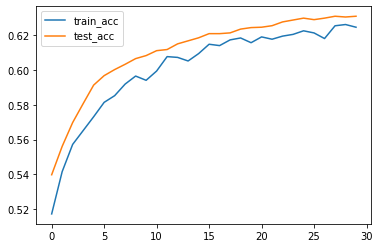

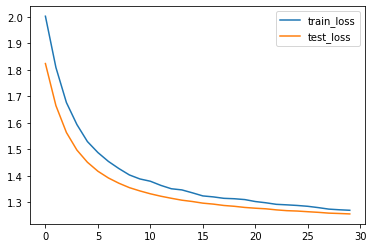

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_acc_full)
plt.plot(test_acc_full)
plt.legend(['train_acc', 'test_acc'])
plt.show()
plt.plot(train_loss_full)
plt.plot(test_loss_full)
plt.legend(['train_loss', 'test_loss'])
plt.show()